In [27]:
# Imports
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import networkx as nx
from scipy import spatial

# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters,visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD FILE W WEIBEL

In [16]:
# Load the e5 csv and add weibel gen (if uncommented)
# orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5lungairwaysvida_20140211.csv"))
orig_df = pd.read_csv(os.path.abspath('/home/sneha/e5_cleaned_normalised_0207.csv')) # original + weibel gen added
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,dircosx_norm,dircosy_norm,dircosz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.487777,0.614894,0.986467,Standard,1.0,0.0,0.0,0.0,0.0,0.0
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.804256,0.522963,0.896107,Standard,1.0,0.0,0.0,0.0,0.0,0.0
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.152888,0.476061,0.859082,Standard,1.0,0.0,0.0,0.0,0.0,0.0
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.291081,0.509083,0.954171,Standard,1.0,0.0,0.0,0.0,0.0,0.0
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.093438,0.480640,0.209599,Standard,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,8024995,-,7.76122,8.59789,2.0,9.0,308.0,284.0,165.5500,-0.145479,...,0.427260,0.790957,0.900066,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884129,8024995,-,18.25130,3.55283,2.0,9.0,309.0,285.0,172.0070,0.515058,...,0.757529,0.741433,0.854102,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884130,8024995,-,1.06394,-1.00000,2.0,9.0,310.0,285.0,120.9650,-0.577350,...,0.211325,0.788675,0.788675,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884131,8024995,-,9.27626,7.71677,2.0,9.0,311.0,286.0,152.5930,0.285831,...,0.642915,0.642915,0.957330,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0


### Apply Shift + Scale to standardise the trees + Re Do normalisation of xyz of shifted coords ACROSS ALL TREES FOR NOW (May need to change to per tree)

In [22]:
# carina_locs
def _shift_df(orig_df):
    carina_locs = orig_df.loc[orig_df.endbpid==1, ['idno', 'x','y','z']]
    carina_locs = carina_locs.rename(columns={'x':'shift_x','y':'shift_y','z':'shift_z'})
    shifted_df = orig_df.merge(carina_locs, on='idno', how='left')
    # apply shift
    shifted_df[['x','y','z']] = shifted_df[['x','y','z']].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]] = shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    # check all caaina are now 0
#     display(shifted_df.loc[shifted_df.endbpid==1, ['idno', 'x','y','z']])
    return shifted_df

shifted_df = _shift_df(orig_df)
print('Checking carina now at 0')
display(shifted_df.loc[shifted_df.startbpid==-1, ['x','y','z']])

Checking carina now at 0


,x,y,z
0,0.0,0.0,0.0
351,0.0,0.0,0.0
779,0.0,0.0,0.0
1198,0.0,0.0,0.0
1371,0.0,0.0,0.0
...,...,...,...
882842,0.0,0.0,0.0
883044,0.0,0.0,0.0
883201,0.0,0.0,0.0
883573,0.0,0.0,0.0


In [23]:
def _get_rot_mat(test):
    carina = test.loc[test.anatomicalname.str.lower() =='trachea', ['x', 'y', 'z']].values.squeeze()
    trachea = test.loc[test.anatomicalname.str.lower() =='trachea', ["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze()
    if len(carina) < 3:
        # maybe labelling not right - try another way
        carina = test.loc[test.startbpid==-1, ['x', 'y', 'z']].values.squeeze()
        assert len(carina) > 2, f'cannot find carina for {test.idno.unique()}, {carina}'
    lmb = test.loc[test.anatomicalname.str.lower() =='lmb', ['x', 'y', 'z']].values.squeeze()
    if len(lmb) < 3:
        # maybe labelling not right - try another way
        lmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'rmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(lmb) > 2, f'cannot find lmb for {test.idno.unique()}, {lmb}'
    rmb = test.loc[test.anatomicalname.str.lower() =='rmb', ['x', 'y', 'z']].values.squeeze()
    if len(rmb) < 3:
        # maybe labelling not right - try another way
        lmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'lmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(rmb) > 2, f'cannot find rmb for {test.idno.unique()}, {rmb}'
        
    print(carina, lmb, rmb)
    v1 = rmb - carina
    # trachea
#     v1 = carina - trachea 
    v2 = lmb - carina
    # normal to the plane containing v1 and v2 make this the z axis
    n3 = np.cross(v1, v2)
    n3 /= scipy.linalg.norm(n3)

    n2 = v1/scipy.linalg.norm(v1) # make v1 (rmb) this y axis

    #x axis is perpendicular to n3 and n2
    n1 = np.cross(n2, n3)
    n1 /= scipy.linalg.norm(n1)
    n1, n2, n3 = n1.squeeze(), n2.squeeze(), n3.squeeze()
    e1, e2, e3 = np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])
    new_coord_sys = [n1.squeeze(), n2.squeeze(), n3.squeeze()]
    print(new_coord_sys)
    old_coord_sys = [e1, e2, e3]
#     print('new', new_coord_sys)
#     print('old', old_coord_sys)
    rot_mat = np.inner(new_coord_sys,old_coord_sys)
    return rot_mat


def _rotate_trees(df):
    
    for i, (name, participant_df) in tqdm(list(enumerate(df.groupby('idno')))):
        rot_mat = _get_rot_mat(participant_df)
        print('Rot mat', rot_mat)
        
        def _apply_transform(v):
            transformed_v =np.matmul(rot_mat, v)
            return transformed_v

        participant_df[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, participant_df[["x","y","z"]].values.squeeze())
        participant_df[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]] = np.apply_along_axis(_apply_transform,1, participant_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze())

        if i ==0:
            df_rotated = participant_df.copy()
        else:
            df_rotated = pd.concat([df_rotated, participant_df], axis=0)
        
        print(len(df_rotated))
    return df_rotated



In [24]:
# get rotated trees
rotated_coords_df = _rotate_trees(shifted_df)
rotated_coords_df

  0%|▏                                                                                 | 6/2911 [00:00<00:54, 53.01it/s]

[0. 0. 0.] [31.04275287  2.34285264 40.41416344] [-17.66399974  -1.21820723  18.27310845]
[array([-0.7161818 , -0.05339288, -0.6958684 ]), array([-0.69422495, -0.0478776 ,  0.71816395]), array([-0.07166135,  0.99742515, -0.00277761])]
Rot mat [[-0.7161818  -0.05339288 -0.6958684 ]
 [-0.69422495 -0.0478776   0.71816395]
 [-0.07166135  0.99742515 -0.00277761]]
351
[0. 0. 0.] [27.41366972  6.72408072 40.34463206] [-20.54015445  -0.52667151  20.0134772 ]
[array([-0.68894887, -0.14176896, -0.71081011]), array([-0.71610895, -0.0183618 ,  0.69774695]), array([-0.11197061,  0.98972946, -0.08887168])]
Rot mat [[-0.68894887 -0.14176896 -0.71081011]
 [-0.71610895 -0.0183618   0.69774695]
 [-0.11197061  0.98972946 -0.08887168]]
779
[0. 0. 0.] [29.95699369  0.         38.73746988] [-8.60785005 -1.01268797 21.26643822]
[array([-0.9262151 , -0.02568104, -0.37611976]), array([-0.37482801, -0.0440974 ,  0.92604502]), array([-0.0403677 ,  0.9986971 ,  0.03121771])]
Rot mat [[-0.9262151  -0.02568104 -0.3

  1%|▌                                                                                | 18/2911 [00:00<00:56, 51.63it/s]

4342
[0. 0. 0.] [28.06214154  6.17368145 37.04199496] [-21.072017     3.41709273  25.05860324]
[array([-0.76804371, -0.11062967, -0.63076932]), array([-0.64012323,  0.10380404,  0.76122728]), array([-0.01873792,  0.98842592, -0.15054266])]
Rot mat [[-0.76804371 -0.11062967 -0.63076932]
 [-0.64012323  0.10380404  0.76122728]
 [-0.01873792  0.98842592 -0.15054266]]
4809
[0. 0. 0.] [34.26276626  5.13941273 27.4101865 ] [-14.3645721    1.59606357  23.9409535 ]
[array([-0.85554384, -0.10944636, -0.50602988]), array([-0.51365713,  0.05707301,  0.85609522]), array([-0.06481585,  0.99235284, -0.10504637])]
Rot mat [[-0.85554384 -0.10944636 -0.50602988]
 [-0.51365713  0.05707301  0.85609522]
 [-0.06481585  0.99235284 -0.10504637]]
5415
[0. 0. 0.] [34.08541312  9.08941734 34.08541312] [-14.87165193   4.40640327  19.82885245]
[array([-0.80648598, -0.15794888, -0.56976531]), array([-0.59073786,  0.17503296,  0.78764982]), array([-0.0246807 ,  0.97181048, -0.23446802])]
Rot mat [[-0.80648598 -0.157

  1%|▊                                                                                | 29/2911 [00:00<00:59, 48.07it/s]

8426
[0. 0. 0.] [36.43369437  2.35055965 33.49547003] [-13.80293017   0.          14.95316757]
[array([-0.73397592, -0.04744129, -0.67751654]), array([-0.67828027,  0.        ,  0.73480329]), array([-0.03486002,  0.99887403, -0.03217849])]
Rot mat [[-0.73397592 -0.04744129 -0.67751654]
 [-0.67828027  0.          0.73480329]
 [-0.03486002  0.99887403 -0.03217849]]
8790
[0. 0. 0.] [34.67459521  0.55038894 33.57378836] [-12.82399455   0.53433329  17.63298978]
[array([-0.80882583, -0.00804635, -0.58799323]), array([-0.58799521,  0.02449981,  0.80849329]), array([ 0.0079003 ,  0.99966745, -0.02454729])]
Rot mat [[-0.80882583 -0.00804635 -0.58799323]
 [-0.58799521  0.02449981  0.80849329]
 [ 0.0079003   0.99966745 -0.02454729]]
9284
[0. 0. 0.] [37.69594922  5.21943589 46.39495903] [-16.8074463    3.36147669  26.33167739]
[array([-0.8448219 , -0.05555799, -0.53215531]), array([-0.53494707,  0.10698901,  0.83808411]), array([ 0.01037251,  0.99270673, -0.12010724])]
Rot mat [[-0.8448219  -0.055

  1%|▉                                                                                | 34/2911 [00:00<01:09, 41.39it/s]

11318
[0. 0. 0.] [33.52014935 -4.96594767 39.72757088] [-17.26079374  -3.83572355  17.9000768 ]
[array([-0.72595213,  0.07803455, -0.68330383]), array([-0.68602216, -0.15244904,  0.71143017]), array([-0.04865287,  0.98522581,  0.16420414])]
Rot mat [[-0.72595213  0.07803455 -0.68330383]
 [-0.68602216 -0.15244904  0.71143017]
 [-0.04865287  0.98522581  0.16420414]]
11679
[0. 0. 0.] [35.59045562 11.15520721 37.1840416 ] [-9.21718017  7.16892637 22.5309187 ]
[array([-0.93162075, -0.09712674, -0.35021305]), array([-0.36320998,  0.28249698,  0.88784794]), array([ 0.01270035,  0.95433844, -0.29845745])]
Rot mat [[-0.93162075 -0.09712674 -0.35021305]
 [-0.36320998  0.28249698  0.88784794]
 [ 0.01270035  0.95433844 -0.29845745]]
12128
[0. 0. 0.] [33.02709476 16.25144171 33.02709476] [-10.25292756   3.07587827  21.01850151]
[array([-0.8734439 , -0.30212833, -0.38185629]), array([-0.43467991,  0.13040397,  0.89109381]), array([-0.2194291 ,  0.94430571, -0.24522967])]
Rot mat [[-0.8734439  -0.302

  2%|█▏                                                                               | 44/2911 [00:00<01:05, 43.81it/s]

14985
[0. 0. 0.] [37.80889106 -0.5728626  33.79885793] [-18.85660178   0.55460665  23.84806771]
[array([-0.78421481,  0.01241501, -0.62036522]), array([-0.62013221,  0.01823921,  0.78428526]), array([ 0.02105188,  0.99975657, -0.00660451])]
Rot mat [[-0.78421481  0.01241501 -0.62036522]
 [-0.62013221  0.01823921  0.78428526]
 [ 0.02105188  0.99975657 -0.00660451]]
15419
[0. 0. 0.] [42.25868499  3.01847831 38.0328108 ] [-18.60132238   0.62004485  13.6409636 ]
[array([-0.59160235, -0.05967622, -0.80401829]), array([-0.80611395,  0.0268705 ,  0.59114996]), array([-0.01367322,  0.99785606, -0.06400249])]
Rot mat [[-0.59160235 -0.05967622 -0.80401829]
 [-0.80611395  0.0268705   0.59114996]
 [-0.01367322  0.99785606 -0.06400249]]
15660
[0. 0. 0.] [35.09276396 -0.55702931 42.33411747] [-15.45122404   1.65549031  20.41770266]
[array([-0.79615208,  0.02548696, -0.60455957]), array([-0.60218509,  0.06451991,  0.79574512]), array([ 0.05928725,  0.9975909 , -0.03601979])]
Rot mat [[-0.79615208  0.

  2%|█▌                                                                               | 56/2911 [00:01<00:57, 49.67it/s]

Rot mat [[-0.71419895  0.05318812 -0.69791897]
 [-0.67040152  0.23464083  0.7039215 ]
 [ 0.20120055  0.97062593 -0.13192284]]
18892
[0. 0. 0.] [34.15315931  7.83843684 38.63228098] [-11.44210519   1.63458617  16.34586169]
[array([-0.81805749, -0.13448641, -0.5591917 ]), array([-0.57154767,  0.08164965,  0.81649653]), array([-0.06414988,  0.98754582, -0.14365951])]
Rot mat [[-0.81805749 -0.13448641 -0.5591917 ]
 [-0.57154767  0.08164965  0.81649653]
 [-0.06414988  0.98754582 -0.14365951]]
19251
[0. 0. 0.] [27.29787646 11.84626878 29.35812983] [-12.29331101  -1.53666339  14.85440055]
[array([-0.72147585, -0.2929996 , -0.62739447]), array([-0.635553 , -0.0794441,  0.767959 ]), array([-0.27485447,  0.95280631, -0.12889978])]
Rot mat [[-0.72147585 -0.2929996  -0.62739447]
 [-0.635553   -0.0794441   0.767959  ]
 [-0.27485447  0.95280631 -0.12889978]]
19583
[0. 0. 0.] [39.33786964  1.68591045 47.20539439] [-17.57814413  -2.83518884  19.8462952 ]
[array([-0.74478647, -0.04350633, -0.6658831 ])

  2%|█▉                                                                               | 69/2911 [00:01<00:51, 55.28it/s]

23770
[0. 0. 0.] [36.31739655  2.26983606 32.91260076] [-15.09696692  -0.55914801  16.77441772]
[array([-0.74172836, -0.04631898, -0.66909909]), array([-0.66875927, -0.02476891,  0.74306631]), array([-0.05099093,  0.99861957, -0.01260444])]
Rot mat [[-0.74172836 -0.04631898 -0.66909909]
 [-0.66875927 -0.02476891  0.74306631]
 [-0.05099093  0.99861957 -0.01260444]]
24088
[0. 0. 0.] [30.25214477 10.25494695 36.91787738] [-22.85197634  -1.03872594  16.61963201]
[array([-0.56908563, -0.20813542, -0.79550059]), array([-0.80818998, -0.0367359 ,  0.58777498]), array([-0.15156022,  0.9774099 , -0.14730709])]
Rot mat [[-0.56908563 -0.20813542 -0.79550059]
 [-0.80818998 -0.0367359   0.58777498]
 [-0.15156022  0.9774099  -0.14730709]]
24285
[0. 0. 0.] [29.20120507  5.12303543 35.34881991] [-10.16186767  -1.01618677  16.76707085]
[array([-0.84375101, -0.13479198, -0.51953379]), array([-0.51760718, -0.05176072,  0.8540513 ]), array([-0.14201071,  0.98952107, -0.02609614])]
Rot mat [[-0.84375101 -0.

  3%|██▎                                                                              | 81/2911 [00:01<00:52, 53.41it/s]

Rot mat [[-0.84424535 -0.13684118 -0.51819329]
 [-0.51727897 -0.0449807   0.85463396]
 [-0.14025782  0.98957123 -0.03281032]]
28539
[0. 0. 0.] [30.74556334 14.34793765 22.03431837] [-15.38375271   9.7430323   17.94770723]
[array([-0.79765376, -0.33231778, -0.50330246]), array([-0.60168726,  0.38106816,  0.7019683 ]), array([-0.041484  ,  0.86275834, -0.50391183])]
Rot mat [[-0.79765376 -0.33231778 -0.50330246]
 [-0.60168726  0.38106816  0.7019683 ]
 [-0.041484    0.86275834 -0.50391183]]
28886
[0. 0. 0.] [38.93666189  4.58078375 37.21885447] [-12.75922752  -1.66424742  15.5329665 ]
[array([-0.76477488, -0.09052149, -0.63790692]), array([-0.63257527, -0.08250984,  0.77009133]), array([-0.12234341,  0.99247065,  0.00583979])]
Rot mat [[-0.76477488 -0.09052149 -0.63790692]
 [-0.63257527 -0.08250984  0.77009133]
 [-0.12234341  0.99247065  0.00583979]]
29181
[0. 0. 0.] [29.68450513  9.21244478 31.21990525] [-13.75888273   5.09588762  17.83560669]
[array([-0.80315374, -0.16991566, -0.5710277

  3%|██▌                                                                              | 93/2911 [00:01<00:52, 54.07it/s]

 [38.96877641  2.39807855 51.55868878] [-14.12442027  -3.95482097  25.98891301]
[array([-0.86789505, -0.09909799, -0.48676254]), array([-0.47330184, -0.13252396,  0.87087471]), array([-0.15080963,  0.98621346,  0.06811363])]
Rot mat [[-0.86789505 -0.09909799 -0.48676254]
 [-0.47330184 -0.13252396  0.87087471]
 [-0.15080963  0.98621346  0.06811363]]
31479
[0. 0. 0.] [33.38253946  5.47255384 35.02433483] [-18.94233427  -3.8998879   16.15670725]
[array([-0.63340237, -0.10157453, -0.76712714]), array([-0.75166789, -0.15475498,  0.64112891]), array([-0.18383911,  0.98271741,  0.02167186])]
Rot mat [[-0.63340237 -0.10157453 -0.76712714]
 [-0.75166789 -0.15475498  0.64112891]
 [-0.18383911  0.98271741  0.02167186]]
31906
[0. 0. 0.] [34.38830813 -0.53731691 47.28391637] [-17.79099687  -2.15648636  23.72135889]
[array([-0.79938164, -0.01269411, -0.60068949]), array([-0.59841901, -0.0725357 ,  0.79789301]), array([-0.05369997,  0.99728503,  0.05038731])]
Rot mat [[-0.79938164 -0.01269411 -0.6006

  3%|██▊                                                                              | 99/2911 [00:01<00:52, 53.81it/s]

34957
[0. 0. 0.] [32.84087513  5.97108121 34.03509137] [-11.60792669  -1.10551749  19.8992963 ]
[array([-0.85143587, -0.14291552, -0.50461085]), array([-0.50329199, -0.0479326 ,  0.86278598]), array([-0.14749281,  0.98857353, -0.0311167 ])]
Rot mat [[-0.85143587 -0.14291552 -0.50461085]
 [-0.50329199 -0.0479326   0.86278598]
 [-0.14749281  0.98857353 -0.0311167 ]]
35328
[0. 0. 0.] [29.99375559  5.99874192 34.35651462] [-13.31697343   1.06535645  19.70910734]
[array([-0.82536767, -0.12301235, -0.55103192]), array([-0.55929697,  0.0447437 ,  0.82775896]), array([-0.07716937,  0.99139597, -0.10573044])]
Rot mat [[-0.82536767 -0.12301235 -0.55103192]
 [-0.55929697  0.0447437   0.82775896]
 [-0.07716937  0.99139597 -0.10573044]]
35705
[0. 0. 0.] [31.9534389  0.        40.7681628] [-11.23537676   1.60505255  19.26063949]
[array([-0.86239732,  0.02842027, -0.50543363]), array([-0.50257084,  0.07179578,  0.86154972]), array([ 0.06077348,  0.99701437, -0.04763329])]
Rot mat [[-0.86239732  0.028

  4%|███                                                                             | 111/2911 [00:02<00:56, 49.94it/s]

38423
[0. 0. 0.] [30.68999128 14.04458336 27.56895823] [-12.44071632   1.03672608  11.40398855]
[array([-0.65314158, -0.32751594, -0.68274401]), array([-0.73576725,  0.06131392,  0.67445323]), array([-0.17903247,  0.94285413, -0.28102217])]
Rot mat [[-0.65314158 -0.32751594 -0.68274401]
 [-0.73576725  0.06131392  0.67445323]
 [-0.17903247  0.94285413 -0.28102217]]
38540
[0. 0. 0.] [37.03200889  6.46591175 42.91010011] [-12.20568275  -1.109606    20.52773374]
[array([-0.84854758, -0.1342687 , -0.51179969]), array([-0.51052477, -0.04641128,  0.85860961]), array([-0.13903768,  0.98985752, -0.02916532])]
Rot mat [[-0.84854758 -0.1342687  -0.51179969]
 [-0.51052477 -0.04641128  0.85860961]
 [-0.13903768  0.98985752 -0.02916532]]
38834
[0. 0. 0.] [40.07725409 17.03284228 44.08496711] [-13.54622729  13.04453258  25.08561306]
[array([-0.89799762, -0.11666896, -0.42425066]), array([-0.43206896,  0.41606696,  0.80012793]), array([ 0.08316659,  0.90181852, -0.42403618])]
Rot mat [[-0.89799762 -0.

  4%|███▎                                                                            | 122/2911 [00:02<01:00, 46.29it/s]

41050
[0. 0. 0.] [33.84613786  8.32284567 32.1815877 ] [-13.4783309    3.77394003  18.33052633]
[array([-0.81095161, -0.15249266, -0.56489245]), array([-0.58440577,  0.16363394,  0.79479169]), array([-0.02876433,  0.974664  , -0.2218168 ])]
Rot mat [[-0.81095161 -0.15249266 -0.56489245]
 [-0.58440577  0.16363394  0.79479169]
 [-0.02876433  0.974664   -0.2218168 ]]
41544
[0. 0. 0.] [32.55068622  7.8751509  39.9007958 ] [-14.58631696   2.08376028  20.31666025]
[array([-0.81147309, -0.13375134, -0.56887785]), array([-0.58119303,  0.0830276 ,  0.80951904]), array([-0.06104169,  0.98753076, -0.14511001])]
Rot mat [[-0.81147309 -0.13375134 -0.56887785]
 [-0.58119303  0.0830276   0.80951904]
 [-0.06104169  0.98753076 -0.14511001]]
42067
[0. 0. 0.] [31.02156353 12.20523023 38.14125583] [-19.27801586   2.53658002  25.36580025]
[array([-0.78598395, -0.22840934, -0.5745071 ]), array([-0.60317476,  0.07936507,  0.79365068]), array([-0.13568143,  0.97032487, -0.20015042])]
Rot mat [[-0.78598395 -0.

  4%|███▌                                                                            | 128/2911 [00:02<00:56, 49.33it/s]

Rot mat [[-0.83188675 -0.00430027 -0.55492878]
 [-0.55352303 -0.0651203   0.83028405]
 [-0.03970758  0.99786815  0.05179242]]
44750
[0. 0. 0.] [32.92641086  3.18642753 40.36141191] [-9.71832582 -2.04596265 24.04007735]
[array([-0.91796455, -0.11173169, -0.380601  ]), array([-0.37362783, -0.07865846,  0.92423757]), array([-0.13320411,  0.99062045,  0.03045961])]
Rot mat [[-0.91796455 -0.11173169 -0.380601  ]
 [-0.37362783 -0.07865846  0.92423757]
 [-0.13320411  0.99062045  0.03045961]]
44937
[0. 0. 0.] [36.72544955  4.08060494 35.55959319] [-13.21735873  -0.55072249  19.8260381 ]
[array([-0.82794477, -0.08503503, -0.55432526]), array([-0.5545521 , -0.0231063 ,  0.83182815]), array([-0.08354294,  0.99611001, -0.02802561])]
Rot mat [[-0.82794477 -0.08503503 -0.55432526]
 [-0.5545521  -0.0231063   0.83182815]
 [-0.08354294  0.99611001 -0.02802561]]
45284
[0. 0. 0.] [38.09260833 -3.12234379 38.71705859] [-12.64496801   1.20428344  15.6556766 ]
[array([-0.77390291,  0.06435625, -0.63002584])

  5%|███▊                                                                            | 139/2911 [00:02<00:56, 49.11it/s]

47361
[0. 0. 0.] [39.65142519  4.88851227 26.07216084] [-12.04956627  -2.61947788  15.71682731]
[array([-0.78282722, -0.09168174, -0.6154478 ]), array([-0.60317813, -0.13112603,  0.78675416]), array([-0.15283221,  0.98711723,  0.0473486 ])]
Rot mat [[-0.78282722 -0.09168174 -0.6154478 ]
 [-0.60317813 -0.13112603  0.78675416]
 [-0.15283221  0.98711723  0.0473486 ]]
47698
[0. 0. 0.] [28.87687211  2.77662145 34.43011502] [-11.68089708  -2.22493975  13.90581853]
[array([-0.75651575, -0.08276813, -0.6487167 ]), array([-0.63841907, -0.12160401,  0.76002208]), array([-0.14179216,  0.98912178,  0.0391546 ])]
Rot mat [[-0.75651575 -0.08276813 -0.6487167 ]
 [-0.63841907 -0.12160401  0.76002208]
 [-0.14179216  0.98912178  0.0391546 ]]
47950
[0. 0. 0.] [28.95302775 14.23115207 26.49936789] [-16.37570512   8.4359839   23.81922387]
[array([-0.83389211, -0.28615043, -0.47195538]), array([-0.54384082,  0.28016091,  0.79104174]), array([-0.09413349,  0.91631206, -0.38924426])]
Rot mat [[-0.83389211 -0.

  5%|████                                                                            | 149/2911 [00:03<00:57, 47.89it/s]

51023
[0. 0. 0.] [35.3155061  -1.99899108 27.98584808] [-17.96263984   1.85820355  21.05964575]
[array([-0.75834917,  0.04174398, -0.65051055]), array([-0.64748922,  0.06698162,  0.75912526]), array([ 0.07526116,  0.99688059, -0.02376668])]
Rot mat [[-0.75834917  0.04174398 -0.65051055]
 [-0.64748922  0.06698162  0.75912526]
 [ 0.07526116  0.99688059 -0.02376668]]
51343
[0. 0. 0.] [31.78845295  6.35770028 36.02691981] [-11.41248187  -2.0749963   18.67498433]
[array([-0.83352281, -0.16396691, -0.5275932 ]), array([-0.51912182, -0.09438577,  0.8494727 ]), array([-0.18908271,  0.98194001, -0.00644611])]
Rot mat [[-0.83352281 -0.16396691 -0.5275932 ]
 [-0.51912182 -0.09438577  0.8494727 ]
 [-0.18908271  0.98194001 -0.00644611]]
51559
[0. 0. 0.] [27.62272371  3.24972943 32.49729433] [-18.25956991   0.5533206   16.59961798]
[array([-0.67201374, -0.07523692, -0.73670682]), array([-0.73975395,  0.0224168 ,  0.67250396]), array([-0.03408252,  0.99691368, -0.0707212 ])]
Rot mat [[-0.67201374 -0.

  6%|████▍                                                                           | 161/2911 [00:03<00:54, 50.57it/s]

54585
[0. 0. 0.] [30.97334383 13.58476867 38.03740319] [-7.23349761  5.68346079 20.66711987]
[array([-0.945098  , -0.15318701, -0.28865811]), array([-0.31975495,  0.25123596,  0.91358484]), array([-0.06742803,  0.95572707, -0.2864249 ])]
Rot mat [[-0.945098   -0.15318701 -0.28865811]
 [-0.31975495  0.25123596  0.91358484]
 [-0.06742803  0.95572707 -0.2864249 ]]
54915
[0. 0. 0.] [36.65348704  0.59118562 46.70365683] [-13.07446374  -1.13690881  21.03282543]
[array([-0.84830892, -0.02724676, -0.52880015]), array([-0.52737883, -0.04585899,  0.84839173]), array([-0.04736616,  0.99857627,  0.02453322])]
Rot mat [[-0.84830892 -0.02724676 -0.52880015]
 [-0.52737883 -0.04585899  0.84839173]
 [-0.04736616  0.99857627  0.02453322]]
55275
[0. 0. 0.] [35.22940303  4.69725206 35.81653116] [-13.6494971   -4.54983237  18.19935266]
[array([-0.77977838, -0.11913278, -0.61461619]), array([-0.58834794, -0.19611598,  0.78446493]), array([-0.21399155,  0.97331696,  0.08283547])]
Rot mat [[-0.77977838 -0.119

  6%|████▊                                                                           | 173/2911 [00:03<00:54, 50.53it/s]

58220
[0. 0. 0.] [34.9329053  11.64428524 33.18624268] [-12.0203811    1.14479897  10.87558212]
[array([-0.66385572, -0.23928149, -0.70854778]), array([-0.73969347,  0.07044704,  0.66924643]), array([-0.11022318,  0.96839123, -0.22376163])]
Rot mat [[-0.66385572 -0.23928149 -0.70854778]
 [-0.73969347  0.07044704  0.66924643]
 [-0.11022318  0.96839123 -0.22376163]]
58488
[0. 0. 0.] [32.11235428 -5.94673413 38.05908841] [-15.8696132    1.22073861  15.8696132 ]
[array([-0.6969726 ,  0.12314379, -0.70644519]), array([-0.70606308,  0.05431251,  0.70606308]), array([0.12531609, 0.99090149, 0.04909295])]
Rot mat [[-0.6969726   0.12314379 -0.70644519]
 [-0.70606308  0.05431251  0.70606308]
 [ 0.12531609  0.99090149  0.04909295]]
58837
[0. 0. 0.] [38.1787183  -1.10663137 40.3919588 ] [-14.51763409  -2.15076099  20.96990169]
[array([-0.82231092,  0.0025325 , -0.56903281]), array([-0.56719711, -0.08402922,  0.81928416]), array([-0.04574055,  0.99646007,  0.07053457])]
Rot mat [[-0.82231092  0.002

  6%|█████                                                                           | 186/2911 [00:03<00:52, 51.45it/s]

61075
[0. 0. 0.] [36.21774218  6.22492931 36.78365902] [-17.35962302   0.54248881  26.03941889]
[array([-0.82730876, -0.11868325, -0.54906693]), array([-0.55461711,  0.0173318 ,  0.83192516]), array([-0.08921926,  0.99278089, -0.08016251])]
Rot mat [[-0.82730876 -0.11868325 -0.54906693]
 [-0.55461711  0.0173318   0.83192516]
 [-0.08921926  0.99278089 -0.08016251]]
61312
[0. 0. 0.] [35.95449725  4.05937992 38.85405434] [-14.41553514  -0.57662141  16.14538636]
[array([-0.7421818 , -0.07927139, -0.66549397]), array([-0.66577985, -0.02663119,  0.74567283]), array([-0.07683342,  0.99649728, -0.0330121 ])]
Rot mat [[-0.7421818  -0.07927139 -0.66549397]
 [-0.66577985 -0.02663119  0.74567283]
 [-0.07683342  0.99649728 -0.0330121 ]]
61669
[0. 0. 0.] [32.89091258 -1.13416961 49.90348655] [-12.38944182  -1.07734421  27.47226678]
[array([-9.11584362e-01, -1.72035239e-04, -4.11113027e-01]), array([-0.41084499, -0.0357257 ,  0.91100498]), array([-0.01484403,  0.99936162,  0.03249631])]
Rot mat [[-9.

  7%|█████▎                                                                          | 192/2911 [00:03<00:56, 47.90it/s]


Rot mat [[-0.65353892 -0.11563862 -0.74800708]
 [-0.75675669  0.08108107  0.64864873]
 [-0.01435963  0.98997655 -0.14049993]]
64561
[0. 0. 0.] [43.6041608   6.4598544  27.99275462] [-19.07921829   0.52997829  15.36937029]
[array([-0.62370136, -0.13726045, -0.76951685]), array([-0.77857177,  0.02162699,  0.62718281]), array([-0.06944506,  0.99029887, -0.12035589])]
Rot mat [[-0.62370136 -0.13726045 -0.76951685]
 [-0.77857177  0.02162699  0.62718281]
 [-0.06944506  0.99029887 -0.12035589]]
64675
[0. 0. 0.] [35.62259594  3.14317118 40.33734732] [-16.04429309   0.          23.29012385]
[array([-0.82202006, -0.06008328, -0.56627998]), array([-0.56730489,  0.        ,  0.82350784]), array([-0.04947905,  0.99819337, -0.03408554])]
Rot mat [[-0.82202006 -0.06008328 -0.56627998]
 [-0.56730489  0.          0.82350784]
 [-0.04947905  0.99819337 -0.03408554]]
65298
[0. 0. 0.] [36.43716623  7.41096403 40.76019179] [-13.12311889  -0.596506    17.29864783]
[array([-0.78626854, -0.14188983, -0.601372

  7%|█████▌                                                                          | 202/2911 [00:04<01:03, 42.51it/s]

67299
[0. 0. 0.] [32.08717666  4.08382422 35.00421438] [-15.70623376   1.74513735  17.45137346]
[array([-0.74489056, -0.07855896, -0.66254551]), array([-0.66712433,  0.07412494,  0.74124937]), array([-0.00912063,  0.99414988, -0.10762356])]
Rot mat [[-0.74489056 -0.07855896 -0.66254551]
 [-0.66712433  0.07412494  0.74124937]
 [-0.00912063  0.99414988 -0.10762356]]
67628
[0. 0. 0.] [34.08926517  1.21747376 46.87275411] [-20.78580264  -1.94867037  23.38403189]
[array([-0.7455034 , -0.03497029, -0.66558377]), array([-0.66307888, -0.06216369,  0.74596386]), array([-0.06746171,  0.99745313,  0.02315518])]
Rot mat [[-0.7455034  -0.03497029 -0.66558377]
 [-0.66307888 -0.06216369  0.74596386]
 [-0.06746171  0.99745313  0.02315518]]
67830
[0. 0. 0.] [39.42886075  1.06564562 37.29756951] [-15.10887128  -1.07920536  11.33165819]
[array([-0.59950787, -0.01009744, -0.80030516]), array([-0.79869695, -0.0570498 ,  0.59902296]), array([-0.05170584,  0.99832027,  0.02613701])]
Rot mat [[-0.59950787 -0.

  7%|█████▊                                                                          | 213/2911 [00:04<00:58, 46.01it/s]

69681
[0. 0. 0.] [36.17065882  1.09608109 44.39128131] [-15.60157148   0.          23.13334729]
[array([-0.8289062 , -0.01999416, -0.55903018]), array([-0.55914196,  0.        ,  0.82907193]), array([-0.0165766 ,  0.9998001 , -0.01117957])]
Rot mat [[-0.8289062  -0.01999416 -0.55903018]
 [-0.55914196  0.          0.82907193]
 [-0.0165766   0.9998001  -0.01117957]]
70060
[0. 0. 0.] [29.90103602 -0.58629568 31.65992305] [-14.27885984  -1.18990532  13.68389826]
[array([-0.69241035,  0.01297689, -0.72138721]), array([-0.7206852 , -0.06005712,  0.6906562 ]), array([-0.03436186,  0.99811059,  0.05093642])]
Rot mat [[-0.69241035  0.01297689 -0.72138721]
 [-0.7206852  -0.06005712  0.6906562 ]
 [-0.03436186  0.99811059  0.05093642]]
70404
[0. 0. 0.] [35.22256823  8.52161386 38.63122437] [-6.59367805  0.54947317  9.34104962]
[array([-0.81145762, -0.15409932, -0.5637286 ]), array([-0.5760182 ,  0.04800152,  0.81602628]), array([-0.09868927,  0.98688867, -0.12771521])]
Rot mat [[-0.81145762 -0.154

  7%|█████▉                                                                          | 218/2911 [00:04<01:01, 43.49it/s]

[0. 0. 0.] [33.81829579 10.73594738 37.03904923] [-8.30781384  5.71161185 17.65408408]
[array([-0.9123965 , -0.10153681, -0.39651343]), array([-0.40864797,  0.28094498,  0.86837593]), array([ 0.02322633,  0.95433757, -0.29782603])]
Rot mat [[-0.9123965  -0.10153681 -0.39651343]
 [-0.40864797  0.28094498  0.86837593]
 [ 0.02322633  0.95433757 -0.29782603]]
73042
[0. 0. 0.] [26.20277719  9.43300722 37.20796777] [-16.72106392   0.          23.51397811]
[array([-0.79595538, -0.21467221, -0.56601315]), array([-0.57952408,  0.        ,  0.81495511]), array([-0.17494822,  0.97668615, -0.12440772])]
Rot mat [[-0.79595538 -0.21467221 -0.56601315]
 [-0.57952408  0.          0.81495511]
 [-0.17494822  0.97668615 -0.12440772]]
73415
[0. 0. 0.] [32.01906477  2.80868888 30.89557317] [-13.32456752  -1.11038161  14.43494323]
[array([-0.73083385, -0.06405329, -0.67954327]), array([-0.6771993 , -0.05643332,  0.73363232]), array([-0.08534045,  0.99634956, -0.00213346])]
Rot mat [[-0.73083385 -0.06405329 

  8%|██████▎                                                                         | 228/2911 [00:04<01:03, 42.18it/s]

75317
[-12.97821954  16.22285554  78.41027916] [ 26.62543675  20.56298025 121.26902167] [-30.01390823  18.35231953 101.83436563]
[array([-0.80986127, -0.06078276, -0.58346394]), array([-0.58658822,  0.07332363,  0.8065593 ]), array([-0.00624321,  0.99545422, -0.09503642])]
Rot mat [[-0.80986127 -0.06078276 -0.58346394]
 [-0.58658822  0.07332363  0.8065593 ]
 [-0.00624321  0.99545422 -0.09503642]]
75638
[0. 0. 0.] [41.89335622  8.1743081  33.71904812] [-17.30472349   6.61652572  18.32265453]
[array([-0.74583303, -0.15989135, -0.64665898]), array([-0.66411804,  0.25392801,  0.70318404]), array([ 0.05177178,  0.95391578, -0.29557463])]
Rot mat [[-0.74583303 -0.15989135 -0.64665898]
 [-0.66411804  0.25392801  0.70318404]
 [ 0.05177178  0.95391578 -0.29557463]]
76053
[0. 0. 0.] [42.60808428  3.55067369 33.13963914] [-9.17810333  5.73631256 12.04625961]
[array([-0.80652501, -0.05413631, -0.58871611]), array([-0.56674913,  0.35421808,  0.74385817]), array([ 0.16826416,  0.93359456, -0.3163674

  8%|██████▌                                                                         | 239/2911 [00:04<00:58, 45.98it/s]

[0. 0. 0.] [33.07457637  0.         33.07457637] [-14.88979128   2.20589483  17.64715402]
[array([-0.76377228,  0.0080228 , -0.64543593]), array([-0.64194812,  0.09510342,  0.76082715]), array([ 0.06748713,  0.99543507, -0.06748713])]
Rot mat [[-0.76377228  0.0080228  -0.64543593]
 [-0.64194812  0.09510342  0.76082715]
 [ 0.06748713  0.99543507 -0.06748713]]
78452
[0. 0. 0.] [37.81005828  1.18156626 23.04050219] [-14.4120593   -2.77154204  17.18360135]
[array([-0.76552162, -0.00811178, -0.64335903]), array([-0.63776102, -0.122646  ,  0.76040702]), array([-0.08507367,  0.99241733,  0.08871479])]
Rot mat [[-0.76552162 -0.00811178 -0.64335903]
 [-0.63776102 -0.122646    0.76040702]
 [-0.08507367  0.99241733  0.08871479]]
78597
[0. 0. 0.] [33.18211488  8.00947442 30.8937265 ] [-12.96161022   1.1270976   13.52516746]
[array([-0.71816135, -0.17419525, -0.67372123]), array([-0.6906562 ,  0.06005712,  0.7206852 ]), array([-0.08507818,  0.982878  , -0.16343973])]
Rot mat [[-0.71816135 -0.174195

  9%|██████▊                                                                         | 249/2911 [00:05<01:00, 44.21it/s]

 [26.38095562  3.59740109 33.5757578 ] [-15.29279151  -2.5487951   14.01839396]
[array([-0.6644757 , -0.09205078, -0.74161897]), array([-0.73165289, -0.12194198,  0.6706819 ]), array([-0.15217128,  0.98825948,  0.01367826])]
Rot mat [[-0.6644757  -0.09205078 -0.74161897]
 [-0.73165289 -0.12194198  0.6706819 ]
 [-0.15217128  0.98825948  0.01367826]]
81162
[0. 0. 0.] [32.62467459  0.55295997 50.31935033] [-17.28234226  -1.11498766  25.08726808]
[array([-0.82272732, -0.02508273, -0.56788256]), array([-0.56692569, -0.03657578,  0.82295655]), array([-0.04141274,  0.99901605,  0.01587185])]
Rot mat [[-0.82272732 -0.02508273 -0.56788256]
 [-0.56692569 -0.03657578  0.82295655]
 [-0.04141274  0.99901605  0.01587185]]
81679
[0. 0. 0.] [31.05996521  9.10378124 35.87962832] [-12.7551312    3.18879441  19.1326968 ]
[array([-0.83368112, -0.15574237, -0.52983026]), array([-0.54944222,  0.13736105,  0.82416333]), array([-0.05557911,  0.97820052, -0.20008675])]
Rot mat [[-0.83368112 -0.15574237 -0.5298

  9%|███████                                                                         | 259/2911 [00:05<01:00, 43.71it/s]

 [30.98103375 10.51142051 32.64076334] [-16.09401523   0.          22.53161578]
[array([-0.79163796, -0.23144987, -0.56545583]), array([-0.58123829,  0.        ,  0.8137334 ]), array([-0.18833849,  0.97284683, -0.13452752])]
Rot mat [[-0.79163796 -0.23144987 -0.56545583]
 [-0.58123829  0.          0.8137334 ]
 [-0.18833849  0.97284683 -0.13452752]]
84025
[0. 0. 0.] [33.96876691  4.77684295 29.72269942] [-12.56015276   2.09336203  14.65349538]
[array([-0.76244141, -0.10295511, -0.63881402]), array([-0.64699703,  0.10783301,  0.75482904]), array([-0.00882827,  0.98882369, -0.148828  ])]
Rot mat [[-0.76244141 -0.10295511 -0.63881402]
 [-0.64699703  0.10783301  0.75482904]
 [-0.00882827  0.98882369 -0.148828  ]]
84238
[0. 0. 0.] [34.84377902  7.17372059 30.74453026] [-16.80910704  -1.01873189  19.35593677]
[array([-0.74219422, -0.15263995, -0.65257091]), array([-0.65516964, -0.03970718,  0.75443759]), array([-0.14106907,  0.98748387, -0.07053463])]
Rot mat [[-0.74219422 -0.15263995 -0.6525

  9%|███████▎                                                                        | 264/2911 [00:05<01:02, 42.50it/s]

 [31.18305502  5.56840652 43.43350636] [-8.52457874 -1.59835974 17.58195713]
[array([-0.88250258, -0.15962296, -0.44239089]), array([-0.43482087, -0.08152898,  0.89681873]), array([-0.17922053,  0.98380564,  0.00254214])]
Rot mat [[-0.88250258 -0.15962296 -0.44239089]
 [-0.43482087 -0.08152898  0.89681873]
 [-0.17922053  0.98380564  0.00254214]]
87129
[0. 0. 0.] [30.32575288  2.16612723 36.28261579] [-17.39490661  -2.7179433   20.11287663]
[array([-0.75071415, -0.06229293, -0.6576837 ]), array([-0.6507612 , -0.10168103,  0.75244324]), array([-0.11374585,  0.99286482,  0.03579557])]
Rot mat [[-0.75071415 -0.06229293 -0.6576837 ]
 [-0.6507612  -0.10168103  0.75244324]
 [-0.11374585  0.99286482  0.03579557]]
87617
[0. 0. 0.] [21.51431206  7.36014995 27.74215056] [-14.38728638   1.10671414  21.02757632]
[array([-0.81327028, -0.20162996, -0.54583588]), array([-0.56415188,  0.04339629,  0.82452982]), array([-0.14256266,  0.97849993, -0.14904283])]
Rot mat [[-0.81327028 -0.20162996 -0.5458358

  9%|███████▍                                                                        | 269/2911 [00:05<01:16, 34.50it/s]

89838
[0. 0. 0.] [36.56157726  8.06506246 38.17462183] [-12.80981131   2.56195897  30.23111782]
[array([-0.91679369, -0.1305937 , -0.37740511]), array([-0.38896709,  0.07779332,  0.91796122]), array([-0.09052036,  0.98837922, -0.12211708])]
Rot mat [[-0.91679369 -0.1305937  -0.37740511]
 [-0.38896709  0.07779332  0.91796122]
 [-0.09052036  0.98837922 -0.12211708]]
90191
[0. 0. 0.] [32.37088821 -2.69757335 23.19912524] [-11.82901318   1.61305135   9.14060929]
[array([-0.60776604,  0.03791301, -0.79321059]), array([-0.78671811,  0.10728001,  0.60791908]), array([ 0.10814369,  0.99350571, -0.0353743 ])]
Rot mat [[-0.60776604  0.03791301 -0.79321059]
 [-0.78671811  0.10728001  0.60791908]
 [ 0.10814369  0.99350571 -0.0353743 ]]
90524
[0. 0. 0.] [34.71318632 13.08856418 35.2822432 ] [-11.3911033    0.          16.81544885]
[array([-0.79935456, -0.26040794, -0.54149791]), array([-0.5608479 ,  0.        ,  0.82791886]), array([-0.21559664,  0.96549868, -0.14604925])]
Rot mat [[-0.79935456 -0.

 10%|███████▌                                                                        | 277/2911 [00:06<01:16, 34.22it/s]

 [36.88576931 -3.68857693 44.8776695 ] [-16.38016474  -2.34002485  25.74027636]
[array([-0.84463904,  0.0414415 , -0.5337298 ]), array([-0.53530312, -0.07647192,  0.84119119]), array([-0.00595511,  0.99621014,  0.08677493])]
Rot mat [[-0.84463904  0.0414415  -0.5337298 ]
 [-0.53530312 -0.07647192  0.84119119]
 [-0.00595511  0.99621014  0.08677493]]
91993
[0. 0. 0.] [27.1081719   3.72072858 31.360426  ] [-15.08972123   3.12200319  24.97608423]
[array([-0.85767078, -0.0588056 , -0.51082554]), array([-0.51418127,  0.10638206,  0.85105845]), array([ 0.00429567,  0.99258489, -0.12147752])]
Rot mat [[-0.85767078 -0.0588056  -0.51082554]
 [-0.51418127  0.10638206  0.85105845]
 [ 0.00429567  0.99258489 -0.12147752]]
92676
[0. 0. 0.] [38.58452945  3.97193995 48.23067729] [-18.80971708   3.31936265  28.76781884]
[array([-0.83831669, -0.03564287, -0.5440172 ]), array([-0.54471492,  0.09612619,  0.83309388]), array([ 0.02260044,  0.99473079, -0.09999939])]
Rot mat [[-0.83831669 -0.03564287 -0.5440

 10%|███████▊                                                                        | 286/2911 [00:06<01:07, 38.90it/s]

94710
[0. 0. 0.] [37.33921195  8.24374621 41.21861862] [-13.7056689    5.87386558  21.53747221]
[array([-0.85097665, -0.08564142, -0.518174  ]), array([-0.52320465,  0.22423085,  0.82217846]), array([ 0.04577807,  0.97076571, -0.23562321])]
Rot mat [[-0.85097665 -0.08564142 -0.518174  ]
 [-0.52320465  0.22423085  0.82217846]
 [ 0.04577807  0.97076571 -0.23562321]]
95112
[0. 0. 0.] [35.0428128   1.84436087 41.80546567] [-10.22196441  -1.70366145  18.74028236]
[array([-0.87334557, -0.06704524, -0.48246497]), array([-0.47733409, -0.07955572,  0.87511317]), array([-0.09705502,  0.99457319,  0.03747665])]
Rot mat [[-0.87334557 -0.06704524 -0.48246497]
 [-0.47733409 -0.07955572  0.87511317]
 [-0.09705502  0.99457319  0.03747665]]
95412
[0. 0. 0.] [34.65314344  3.35352931 41.36019125] [-14.11854534  -1.08604235  21.72084696]
[array([-0.83415058, -0.07745791, -0.54607058]), array([-0.54450994, -0.0418854 ,  0.83770791]), array([-0.08775949,  0.9961154 , -0.00723788])]
Rot mat [[-0.83415058 -0.

 10%|████████▏                                                                       | 296/2911 [00:06<01:06, 39.20it/s]

97761
[0. 0. 0.] [31.04257012 14.45087197 35.3243209 ] [-16.19374362   1.04475851  24.55180579]
[array([-0.80340564, -0.29474461, -0.51736349]), array([-0.55024768,  0.03549988,  0.83424652]), array([-0.22752333,  0.95491642, -0.19070334])]
Rot mat [[-0.80340564 -0.29474461 -0.51736349]
 [-0.55024768  0.03549988  0.83424652]
 [-0.22752333  0.95491642 -0.19070334]]
98090
[0. 0. 0.] [25.36465354 11.57949521 35.28993515] [-15.51415427  -1.10815318  18.83862114]
[array([-0.7339486 , -0.27587267, -0.62065588]), array([-0.63505279, -0.04536089,  0.77113575]), array([-0.24088877,  0.96012325, -0.14190115])]
Rot mat [[-0.7339486  -0.27587267 -0.62065588]
 [-0.63505279 -0.04536089  0.77113575]
 [-0.24088877  0.96012325 -0.14190115]]
98437
[0. 0. 0.] [24.62755783 18.73833712 28.91059663] [-14.85816933   3.18390143  16.45012004]
[array([-0.71142024, -0.42389812, -0.56052798]), array([-0.66347718,  0.14217404,  0.7345642 ]), array([-0.23168786,  0.89448137, -0.38239222])]
Rot mat [[-0.71142024 -0.

 10%|████████▎                                                                       | 304/2911 [00:06<01:09, 37.64it/s]

100731
[0. 0. 0.] [35.26424718 -5.97698634 42.43663079] [-13.71410483   1.14284164  21.71400146]
[array([-0.83560316,  0.12706178, -0.53443677]), array([-0.53346503,  0.0444554 ,  0.84465305]), array([0.13108172, 0.99089809, 0.03063594])]
Rot mat [[-0.83560316  0.12706178 -0.53443677]
 [-0.53346503  0.0444554   0.84465305]
 [ 0.13108172  0.99089809  0.03063594]]
100992
[0. 0. 0.] [28.67859852 -2.75756094 36.39980072] [-18.0640856    4.07899456  13.98509104]
[array([-0.60325622,  0.05610841, -0.79557136]), array([-0.77841315,  0.17577103,  0.60264211]), array([ 0.17365169,  0.9828308 , -0.06235944])]
Rot mat [[-0.60325622  0.05610841 -0.79557136]
 [-0.77841315  0.17577103  0.60264211]
 [ 0.17365169  0.9828308  -0.06235944]]
101405
[0. 0. 0.] [35.84147448  4.41125728 32.53301573] [-11.08494746   1.58356481  17.41921499]
[array([-0.84427339, -0.07857151, -0.53012165]), array([-0.53530312,  0.07647192,  0.84119119]), array([-0.02555424,  0.99397111, -0.10662278])]
Rot mat [[-0.84427339 -0.

 11%|████████▋                                                                       | 314/2911 [00:06<01:01, 42.00it/s]

103840
[0. 0. 0.] [33.13375789  5.71273104 30.84868373] [-18.87879628   1.71625328  17.16253277]
[array([-0.67338881, -0.13051606, -0.72767649]), array([-0.73827184,  0.06711559,  0.67115586]), array([-0.03875818,  0.9891719 , -0.14155122])]
Rot mat [[-0.67338881 -0.13051606 -0.72767649]
 [-0.73827184  0.06711559  0.67115586]
 [-0.03875818  0.9891719  -0.14155122]]
104132
[0. 0. 0.] [26.9991526  14.32605768 29.20314522] [-10.5623925    4.75307444  18.48417597]
[array([-0.86270266, -0.28036541, -0.42087927]), array([-0.48421772,  0.21789787,  0.8473805 ]), array([-0.14586748,  0.93483461, -0.32373897])]
Rot mat [[-0.86270266 -0.28036541 -0.42087927]
 [-0.48421772  0.21789787  0.8473805 ]
 [-0.14586748  0.93483461 -0.32373897]]
104345
[0. 0. 0.] [33.41666929  8.06607821 39.17813883] [-15.31583287   2.83626535  19.85385742]
[array([-0.79383405, -0.1333227 , -0.59334017]), array([-0.60693316,  0.11239503,  0.78676521]), array([-0.03820518,  0.98467884, -0.17014097])]
Rot mat [[-0.79383405 

 11%|████████▊                                                                       | 319/2911 [00:07<01:05, 39.63it/s]

107424
[0. 0. 0.] [26.07219019  8.51338541 29.26471473] [-14.74297498   6.00640007  10.92071863]
[array([-0.63667909, -0.2177817 , -0.73973702]), array([-0.76367537,  0.31112715,  0.56568527]), array([ 0.10695637,  0.92507893, -0.36440267])]
Rot mat [[-0.63667909 -0.2177817  -0.73973702]
 [-0.76367537  0.31112715  0.56568527]
 [ 0.10695637  0.92507893 -0.36440267]]
107802
[0. 0. 0.] [39.18449081  2.9242164  40.35417962] [-24.50763817  -1.69894174   4.16934102]
[array([-0.16661259, -0.01603304, -0.98589208]), array([-0.98354148, -0.068182  ,  0.16732415]), array([-0.0699028 ,  0.99754406, -0.00440918])]
Rot mat [[-0.16661259 -0.01603304 -0.98589208]
 [-0.98354148 -0.068182    0.16732415]
 [-0.0699028   0.99754406 -0.00440918]]
108183
[0. 0. 0.] [32.71450028  0.58418622 30.96195064] [-17.3174655   -4.04073768  18.47195465]
[array([-0.72800938, -0.01338254, -0.68543654]), array([-0.67539498, -0.157592  ,  0.72042098]), array([-0.11766038,  0.98741363,  0.10568995])]
Rot mat [[-0.72800938 

 11%|█████████                                                                       | 328/2911 [00:07<01:07, 38.00it/s]

110227
[0. 0. 0.] [ 45.12819565 -11.74571584  36.47345454] [-12.37191321   2.24944072  17.43314946]
[array([-0.7860283 ,  0.20276817, -0.58399023]), array([-0.57556925,  0.10464905,  0.81102935]), array([0.22556495, 0.97361884, 0.03445001])]
Rot mat [[-0.7860283   0.20276817 -0.58399023]
 [-0.57556925  0.10464905  0.81102935]
 [ 0.22556495  0.97361884  0.03445001]]
110408
[0. 0. 0.] [34.14138194  9.75466466 42.81221969] [-10.31347706   3.09404032  25.78367868]
[array([-0.92515064, -0.13846816, -0.35344428]), array([-0.36910691,  0.11073197,  0.92276677]), array([-0.08863623,  0.984157  , -0.15355331])]
Rot mat [[-0.92515064 -0.13846816 -0.35344428]
 [-0.36910691  0.11073197  0.92276677]
 [-0.08863623  0.984157   -0.15355331]]
110829
[0. 0. 0.] [36.21603919 -0.60360154 38.63043475] [-17.18634952  -2.96317866  20.74216934]
[array([-0.76985232, -0.00238485, -0.63821761]), array([-0.63419187, -0.10934398,  0.76540484]), array([-0.07161062,  0.99400111,  0.08266627])]
Rot mat [[-0.76985232 

 12%|█████████▏                                                                      | 336/2911 [00:07<01:18, 33.01it/s]

112540
[0. 0. 0.] [34.40395117 -1.6382843  33.31179038] [-15.25068221   0.          16.88469851]
[array([-0.74166853,  0.03421094, -0.66989358]), array([-0.67028594,  0.        ,  0.74210293]), array([0.02538804, 0.99941463, 0.02293111])]
Rot mat [[-0.74166853  0.03421094 -0.66989358]
 [-0.67028594  0.          0.74210293]
 [ 0.02538804  0.99941463  0.02293111]]
112773
[0. 0. 0.] [28.90983102  4.28293984 49.25380527] [-13.06367095   2.72159424  19.05118292]
[array([-0.8262293 , -0.02714421, -0.56267961]), array([-0.56164374,  0.11700895,  0.81906362]), array([ 0.04360571,  0.99275984, -0.11192159])]
Rot mat [[-0.8262293  -0.02714421 -0.56267961]
 [-0.56164374  0.11700895  0.81906362]
 [ 0.04360571  0.99275984 -0.11192159]]
113231
[0. 0. 0.] [33.5785897  -0.57894244 38.7890614 ] [-20.27459863   1.19262181  19.08197682]
[array([-0.68489914,  0.01305143, -0.72852099]), array([-0.72753281,  0.04279599,  0.68473682]), array([ 0.04011457,  0.99899858, -0.01981559])]
Rot mat [[-0.68489914  0.

 12%|█████████▍                                                                      | 344/2911 [00:07<01:13, 34.97it/s]

 [36.45350926 -3.70713848 37.07138479] [-9.46668313 -1.77499523 12.42501375]
[array([-0.79799745,  0.05491146, -0.60015398]), array([-0.60216822, -0.11290604,  0.79034528]), array([-0.024362  ,  0.99208717,  0.12316467])]
Rot mat [[-0.79799745  0.05491146 -0.60015398]
 [-0.60216822 -0.11290604  0.79034528]
 [-0.024362    0.99208717  0.12316467]]
115152
[0. 0. 0.] [37.48477895  6.44267486 46.27029367] [-16.41966073  -1.75924752  19.93815576]
[array([-0.76074668, -0.12277686, -0.63733063]), array([-0.63423786, -0.06795398,  0.77014583]), array([-0.13786524,  0.99010509, -0.02617396])]
Rot mat [[-0.76074668 -0.12277686 -0.63733063]
 [-0.63423786 -0.06795398  0.77014583]
 [-0.13786524  0.99010509 -0.02617396]]
115510
[0. 0. 0.] [29.79136273 18.549326   25.29458265] [-15.1689469    0.54174728  17.33593602]
[array([-0.6864519 , -0.42886945, -0.58724338]), array([-0.65832265,  0.02351149,  0.7523686 ]), array([-0.30886094,  0.90306047, -0.29847398])]
Rot mat [[-0.6864519  -0.42886945 -0.58724

 12%|█████████▌                                                                      | 348/2911 [00:07<01:13, 34.69it/s]

117539
[0. 0. 0.] [37.60835294  0.         51.43496641] [-14.10820888   0.          22.79016295]
[array([-0.85026493,  0.        , -0.52635496]), array([-0.52635496,  0.        ,  0.85026493]), array([ 0.,  1., -0.])]
Rot mat [[-0.85026493  0.         -0.52635496]
 [-0.52635496  0.          0.85026493]
 [ 0.          1.          0.        ]]
118033
[0. 0. 0.] [38.97586603  8.78331026 38.97586603] [-11.94294453   1.55777656  24.40515698]
[array([-0.89216391, -0.14669954, -0.42722688]), array([-0.43883208,  0.05723901,  0.89674417]), array([-0.10709791,  0.98752364, -0.11544304])]
Rot mat [[-0.89216391 -0.14669954 -0.42722688]
 [-0.43883208  0.05723901  0.89674417]
 [-0.10709791  0.98752364 -0.11544304]]
118225
[0. 0. 0.] [27.39641544  4.74171149 37.40664864] [-11.45965677   3.12536917  19.27305706]
[array([-0.86202288, -0.0507848 , -0.5043188 ]), array([-0.50618202,  0.13805001,  0.85130603]), array([ 0.02638781,  0.98912239, -0.14470862])]
Rot mat [[-0.86202288 -0.0507848  -0.5043188 ]

 12%|█████████▊                                                                      | 356/2911 [00:08<01:13, 34.92it/s]

119547
[0. 0. 0.] [31.17686978  3.69894907 34.34737762] [-12.13367105  -1.05510111  13.71633098]
[array([-0.74293483, -0.08594914, -0.6638227 ]), array([-0.66147671, -0.05751968,  0.74775668]), array([-0.10245191,  0.99463774, -0.01411999])]
Rot mat [[-0.74293483 -0.08594914 -0.6638227 ]
 [-0.66147671 -0.05751968  0.74775668]
 [-0.10245191  0.99463774 -0.01411999]]
119983
[0. 0. 0.] [30.7271064  12.71467682 28.60797897] [-14.67367922   2.09624237  19.91430376]
[array([-0.78648943, -0.281091  , -0.54992928]), array([-0.59107998,  0.0844401 ,  0.80218098]), array([-0.17904977,  0.95595906, -0.23255851])]
Rot mat [[-0.78648943 -0.281091   -0.54992928]
 [-0.59107998  0.0844401   0.80218098]
 [-0.17904977  0.95595906 -0.23255851]]
120197
[0. 0. 0.] [39.64182093  4.17282667 36.51220633] [-13.74619751  -1.01823557  25.4559181 ]
[array([-0.87497866, -0.08839268, -0.47602424]), array([-0.47485493, -0.0351744 ,  0.87936088]), array([-0.09447293,  0.99546446, -0.01119685])]
Rot mat [[-0.87497866 

 13%|██████████                                                                      | 365/2911 [00:08<01:08, 36.98it/s]

122661
[0. 0. 0.] [33.12167929  0.         40.29805618] [-11.34566425   2.1610789   17.28863123]
[array([-0.83376363,  0.03219675, -0.55118198]), array([-0.54568469,  0.10393994,  0.83151952]), array([ 0.08406205,  0.9940623 , -0.06909207])]
Rot mat [[-0.83376363  0.03219675 -0.55118198]
 [-0.54568469  0.10393994  0.83151952]
 [ 0.08406205  0.9940623  -0.06909207]]
122910
[0. 0. 0.] [38.71554661  3.66228488 46.56333025] [-15.92949436   0.          15.92949436]
[array([-0.70580629, -0.06062143, -0.70580629]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.04286582,  0.99816083, -0.04286582])]
Rot mat [[-0.70580629 -0.06062143 -0.70580629]
 [-0.70710678  0.          0.70710678]
 [-0.04286582  0.99816083 -0.04286582]]
123345
[0. 0. 0.] [39.12519357  5.83958199 41.46101491] [-16.24351131  -0.5601205   22.96497979]
[array([-0.81041393, -0.10782846, -0.57584918]), array([-0.57735001, -0.0199086 ,  0.81625401]), array([-0.09947977,  0.99397016, -0.04612056])]
Rot mat [[-0.81041393 

 13%|██████████▎                                                                     | 373/2911 [00:08<01:11, 35.42it/s]

125145
[0. 0. 0.] [33.56576927 -1.73616048 26.62112735] [-12.18598122   2.76954119  14.9555419 ]
[array([-0.77123867,  0.03782813, -0.63542108]), array([-0.62526199,  0.142105  ,  0.76736798]), array([ 0.1193246 ,  0.98912851, -0.08594438])]
Rot mat [[-0.77123867  0.03782813 -0.63542108]
 [-0.62526199  0.142105    0.76736798]
 [ 0.1193246   0.98912851 -0.08594438]]
125525
[0. 0. 0.] [33.37548782  4.92426187 35.01685982] [-13.96269861   2.14810606  18.25891534]
[array([-0.79625571, -0.08720305, -0.59864219]), array([-0.6048147 ,  0.09304835,  0.79091161]), array([-0.01326723,  0.99183549, -0.12683197])]
Rot mat [[-0.79625571 -0.08720305 -0.59864219]
 [-0.6048147   0.09304835  0.79091161]
 [-0.01326723  0.99183549 -0.12683197]]
125833
[0. 0. 0.] [33.53937377 -2.94204864 41.77709493] [-12.49443697  -1.13585874  19.30958022]
[array([-0.83995969,  0.04134821, -0.5410712 ]), array([-0.54259007, -0.04932641,  0.8385481 ]), array([0.00798337, 0.99792647, 0.06386732])]
Rot mat [[-0.83995969  0.

 13%|██████████▍                                                                     | 381/2911 [00:08<01:09, 36.31it/s]

127907
[0. 0. 0.] [28.74566946  3.79659618 43.38966317] [-15.6510264   -1.67689466  17.88689071]
[array([-0.74485849, -0.09401806, -0.66056524]), array([-0.65687166, -0.07037906,  0.75071061]), array([-0.11707032,  0.99307975, -0.00933536])]
Rot mat [[-0.74485849 -0.09401806 -0.66056524]
 [-0.65687166 -0.07037906  0.75071061]
 [-0.11707032  0.99307975 -0.00933536]]
128312
[0. 0. 0.] [40.08586604 -0.54912102 43.3805721 ] [-19.74694172  -3.73589329  29.88725438]
[array([-0.83331578, -0.01588208, -0.55256906]), array([-0.54828368, -0.10372894,  0.82983451]), array([-0.0704969 ,  0.99447879,  0.07773108])]
Rot mat [[-0.83331578 -0.01588208 -0.55256906]
 [-0.54828368 -0.10372894  0.82983451]
 [-0.0704969   0.99447879  0.07773108]]
128656
[0. 0. 0.] [35.98181022  3.87496456 34.32112894] [-13.28575384  -0.5314287   20.1943294 ]
[array([-0.83154012, -0.08287619, -0.54924727]), array([-0.54948404, -0.0219793 ,  0.83521506]), array([-0.08129152,  0.99631744, -0.02726247])]
Rot mat [[-0.83154012 

 13%|██████████▋                                                                     | 389/2911 [00:09<01:17, 32.47it/s]

130405
[0. 0. 0.] [31.13247578  6.97798178 39.18402432] [-9.60984522 -1.60164141 12.81313769]
[array([-0.77878336, -0.16623305, -0.60486615]), array([-0.597022  , -0.0995037 ,  0.79602999]), array([-0.19251291,  0.98105331, -0.02175296])]
Rot mat [[-0.77878336 -0.16623305 -0.60486615]
 [-0.597022   -0.0995037   0.79602999]
 [-0.19251291  0.98105331 -0.02175296]]
130778
[0. 0. 0.] [28.68949874  7.31301906 38.81520993] [-9.19826044 -1.62322243 16.77329846]
[array([-0.85071365, -0.20042783, -0.48591663]), array([-0.47911091, -0.08454898,  0.87367283]), array([-0.2161921 ,  0.97605336, -0.02410018])]
Rot mat [[-0.85071365 -0.20042783 -0.48591663]
 [-0.47911091 -0.08454898  0.87367283]
 [-0.2161921   0.97605336 -0.02410018]]
131107
[0. 0. 0.] [27.13942739  2.76932993 41.53989932] [-13.20612062  -2.20102095  21.45996815]
[array([-0.84257242, -0.10155627, -0.52892159]), array([-0.52210899, -0.0870182 ,  0.84842798]), array([-0.13218898,  0.99101673,  0.02029569])]
Rot mat [[-0.84257242 -0.101

 14%|██████████▉                                                                     | 397/2911 [00:09<01:13, 34.37it/s]

132481
[0. 0. 0.] [40.0141226   1.09627407 48.23614678] [-12.26848922   0.53341237  19.73627638]
[array([-0.8493667 , -0.01077339, -0.52769323]), array([-0.52779489,  0.0229476 ,  0.84906182]), array([ 0.00296202,  0.99967862, -0.02517706])]
Rot mat [[-0.8493667  -0.01077339 -0.52769323]
 [-0.52779489  0.0229476   0.84906182]
 [ 0.00296202  0.99967862 -0.02517706]]
132854
[0. 0. 0.] [32.32709452 -5.73546014 43.27663896] [-16.08967254  -1.55706692  23.35597536]
[array([-0.82283187,  0.09283606, -0.56065068]), array([-0.56645223, -0.05481802,  0.82226933]), array([0.04560248, 0.99417124, 0.09769321])]
Rot mat [[-0.82283187  0.09283606 -0.56065068]
 [-0.56645223 -0.05481802  0.82226933]
 [ 0.04560248  0.99417124  0.09769321]]
133183
[0. 0. 0.] [34.18245909  9.07969929 32.04602557] [-17.09515051  -1.60267108  15.49249099]
[array([-0.65041874, -0.18460923, -0.73680044]), array([-0.73920526, -0.06930052,  0.66990523]), array([-0.17473135,  0.98036568, -0.09138976])]
Rot mat [[-0.65041874 -0.

 14%|███████████▏                                                                    | 405/2911 [00:09<01:11, 35.17it/s]

134669
[0. 0. 0.] [33.33087002 -0.55551192 39.44150113] [-18.24223794  -1.14014112  17.10209181]
[array([-0.68419631,  0.0084027 , -0.72924948]), array([-0.72878015, -0.04554881,  0.68323114]), array([-0.02747546,  0.99892677,  0.03728805])]
Rot mat [[-0.68419631  0.0084027  -0.72924948]
 [-0.72878015 -0.04554881  0.68323114]
 [-0.02747546  0.99892677  0.03728805]]
135010
[0. 0. 0.] [34.62882323 -0.5869281  36.38961256] [-18.75151786   0.          19.92347918]
[array([-0.72814999,  0.01170105, -0.68531794]), array([-0.68536485,  0.        ,  0.72819985]), array([0.0085207 , 0.99993154, 0.00801949])]
Rot mat [[-0.72814999  0.01170105 -0.68531794]
 [-0.68536485  0.          0.72819985]
 [ 0.0085207   0.99993154  0.00801949]]
135132
[0. 0. 0.] [27.56058672 11.44024973 28.08056455] [-13.37152192   4.11432847  18.00014145]
[array([-0.80388955, -0.24851926, -0.54037003]), array([-0.5865321 ,  0.18047203,  0.78956313]), array([-0.09869997,  0.95166592, -0.2908441 ])]
Rot mat [[-0.80388955 -0.

 14%|███████████▏                                                                    | 409/2911 [00:09<01:13, 33.88it/s]

137048
[0. 0. 0.] [36.84043487 -1.84202174 33.77039029] [-19.30942531  -2.49154022  16.19501903]
[array([-0.6455732 ,  0.04964847, -0.76208285]), array([-0.76247407, -0.09838381,  0.63949506]), array([-0.04322666,  0.99390928,  0.10136962])]
Rot mat [[-0.6455732   0.04964847 -0.76208285]
 [-0.76247407 -0.09838381  0.63949506]
 [-0.04322666  0.99390928  0.10136962]]
137415
[0. 0. 0.] [28.50668539  0.         34.44554837] [-20.46607229   0.          22.87383106]
[array([-0.7452411 ,  0.        , -0.66679509]), array([-0.66679509,  0.        ,  0.7452411 ]), array([ 0.,  1., -0.])]
Rot mat [[-0.7452411   0.         -0.66679509]
 [-0.66679509  0.          0.7452411 ]
 [ 0.          1.          0.        ]]
137622
[0. 0. 0.] [34.00900186 -8.50223816 34.57583087] [-18.58909797   1.16181921  14.52274607]
[array([-0.60035582,  0.1679772 , -0.78189292]), array([-0.78707008,  0.0491919 ,  0.61489906]), array([0.14175183, 0.98456275, 0.10267718])]
Rot mat [[-0.60035582  0.1679772  -0.78189292]
 [

 14%|███████████▍                                                                    | 417/2911 [00:09<01:13, 34.08it/s]

139029
[0. 0. 0.] [26.94288379  6.86781142 29.58432786] [-16.02790816  -0.5342629   13.89086506]
[array([-0.64235155, -0.16851069, -0.74765543]), array([-0.75544918, -0.02518161,  0.65472316]), array([-0.12915501,  0.98537812, -0.11112582])]
Rot mat [[-0.64235155 -0.16851069 -0.74765543]
 [-0.75544918 -0.02518161  0.65472316]
 [-0.12915501  0.98537812 -0.11112582]]
139419
[0. 0. 0.] [27.39216591  7.66981031 38.89685728] [-17.28985211  -1.11547389  21.19399019]
[array([-0.75825259, -0.17575134, -0.6278252 ]), array([-0.6316021 , -0.04074851,  0.77422112]), array([-0.16165334,  0.98359088, -0.08010725])]
Rot mat [[-0.75825259 -0.17575134 -0.6278252 ]
 [-0.6316021  -0.04074851  0.77422112]
 [-0.16165334  0.98359088 -0.08010725]]
139631
[0. 0. 0.] [36.31229703 -2.4208198  49.02162236] [-10.22232191  -1.80394648  14.43150074]
[array([-0.81648094,  0.00821818, -0.57731389]), array([-0.57503388, -0.10147698,  0.81181184]), array([-0.05191245,  0.99480394,  0.08757975])]
Rot mat [[-0.81648094 

 15%|███████████▋                                                                    | 425/2911 [00:10<01:16, 32.48it/s]

Rot mat [[-0.71949057 -0.10970212 -0.68578332]
 [-0.66949603 -0.15302801  0.72688203]
 [-0.18468456  0.98211398  0.03665707]]
142722
[0. 0. 0.] [38.52819839  8.84255228 41.05465818] [-12.74198972  -1.82028365  16.38256119]
[array([-0.76881277, -0.16898698, -0.6167417 ]), array([-0.61159277, -0.08737037,  0.78633371]), array([-0.18676511,  0.98173816, -0.03617976])]
Rot mat [[-0.76881277 -0.16898698 -0.6167417 ]
 [-0.61159277 -0.08737037  0.78633371]
 [-0.18676511  0.98173816 -0.03617976]]
143120
[0. 0. 0.] [40.39259914  1.59444375 32.4203804 ] [-11.47502752   1.56477742  17.21254128]
[array([-0.83281757, -0.02406036, -0.55302441]), array([-0.5531201 ,  0.07542551,  0.82968015]), array([ 0.02174975,  0.99686112, -0.07612396])]
Rot mat [[-0.83281757 -0.02406036 -0.55302441]
 [-0.5531201   0.07542551  0.82968015]
 [ 0.02174975  0.99686112 -0.07612396]]
143322
[0. 0. 0.] [35.68809929  5.09827833 35.12162951] [-9.90774106  1.04292037 22.94425824]
[array([-0.91565218, -0.09246572, -0.391192 

 15%|███████████▊                                                                    | 429/2911 [00:10<01:18, 31.66it/s]

144579
[0. 0. 0.] [24.65613276  2.05467551 36.98417689] [-13.88690158   0.51433005  20.05885242]
[array([-0.82198559, -0.04131442, -0.56800775]), array([-0.56908363,  0.02107719,  0.82200947]), array([-0.02198884,  0.99892386, -0.04083651])]
Rot mat [[-0.82198559 -0.04131442 -0.56800775]
 [-0.56908363  0.02107719  0.82200947]
 [-0.02198884  0.99892386 -0.04083651]]
144977
[0. 0. 0.] [31.51893437  4.42370716 39.26040042] [-12.51410328  -0.54409211  17.95502441]
[array([-0.81502171, -0.0983359 , -0.5710251 ]), array([-0.5716159 , -0.0248529 ,  0.82014486]), array([-0.09484131,  0.99484289, -0.03595472])]
Rot mat [[-0.81502171 -0.0983359  -0.5710251 ]
 [-0.5716159  -0.0248529   0.82014486]
 [-0.09484131  0.99484289 -0.03595472]]
145232
[0. 0. 0.] [35.81691399  5.28446209 52.25745425] [-15.51042767  -0.5744593   25.27626239]
[array([-0.84708924, -0.09944053, -0.52206456]), array([-0.52291797, -0.0193673 ,  0.85216296]), array([-0.09485051,  0.99485501, -0.03559341])]
Rot mat [[-0.84708924 

 15%|████████████                                                                    | 437/2911 [00:10<01:19, 31.14it/s]

146574
[0. 0. 0.] [36.14120887  4.66337904 34.39240352] [-14.91073268   0.          13.19025816]
[array([-0.65967684, -0.09340902, -0.74572195]), array([-0.7489967 ,  0.        ,  0.66257373]), array([-0.06189036,  0.99562782, -0.06996305])]
Rot mat [[-0.65967684 -0.09340902 -0.74572195]
 [-0.7489967   0.          0.66257373]
 [-0.06189036  0.99562782 -0.06996305]]
146796
[0. 0. 0.] [31.3538592  13.28551485 51.01648005] [-10.45076068   4.18030875  19.3338916 ]
[array([-0.88339904, -0.13976605, -0.44729364]), array([-0.4671421 ,  0.18685704,  0.86421219]), array([-0.03720756,  0.9723939 , -0.23035994])]
Rot mat [[-0.88339904 -0.13976605 -0.44729364]
 [-0.4671421   0.18685704  0.86421219]
 [-0.03720756  0.9723939  -0.23035994]]
147196
[0. 0. 0.] [29.44669627  9.27025064 39.80757648] [-12.15442197   1.05690659  22.19503583]
[array([-0.86586577, -0.18344573, -0.46542898]), array([-0.47989616,  0.04173011,  0.87633229]), array([-0.14133701,  0.98214371, -0.12416758])]
Rot mat [[-0.86586577 

 15%|████████████▏                                                                   | 445/2911 [00:10<01:27, 28.32it/s]

148401
[0. 0. 0.] [25.60716781  3.73437977 28.80808799] [-21.78692222   3.81271139  17.97421083]
[array([-0.64353178, -0.09959677, -0.75891194]), array([-0.76443976,  0.13377696,  0.6306628 ]), array([ 0.03871295,  0.98599402, -0.16222546])]
Rot mat [[-0.64353178 -0.09959677 -0.75891194]
 [-0.76443976  0.13377696  0.6306628 ]
 [ 0.03871295  0.98599402 -0.16222546]]
148793
[0. 0. 0.] [33.90271751  4.23784101 40.56219408] [-10.25337141  -0.56963086  17.08894571]
[array([-0.85228352, -0.09428221, -0.51451305]), array([-0.51428586, -0.02857139,  0.85714277]), array([-0.09551367,  0.99513544, -0.02413708])]
Rot mat [[-0.85228352 -0.09428221 -0.51451305]
 [-0.51428586 -0.02857139  0.85714277]
 [-0.09551367  0.99513544 -0.02413708]]
149246
[0. 0. 0.] [27.18450294  1.08738195 36.97094052] [-12.97954352   2.70406729  15.68361081]
[array([-0.76962872,  0.00868989, -0.63843254]), array([-0.6320169 ,  0.13166998,  0.76368688]), array([ 0.09069875,  0.99125552, -0.09584484])]
Rot mat [[-0.76962872 

 15%|████████████▎                                                                   | 448/2911 [00:10<01:26, 28.45it/s]

[0. 0. 0.] [27.04694052  0.         42.33435041] [-15.00623555  -3.00124711  21.60898449]
[array([-0.81739897, -0.04693507, -0.57415679]), array([-0.56671997, -0.11334399,  0.81607696]), array([-0.10337985,  0.99244659,  0.06604822])]
Rot mat [[-0.81739897 -0.04693507 -0.57415679]
 [-0.56671997 -0.11334399  0.81607696]
 [-0.10337985  0.99244659  0.06604822]]
150597
[0. 0. 0.] [36.3816073   9.63045376 42.26690975] [-13.47696826   1.03668943  24.880535  ]
[array([-0.86968716, -0.16816512, -0.46407407]), array([-0.47596414,  0.03661261,  0.87870226]), array([-0.1307761 ,  0.98507868, -0.11188208])]
Rot mat [[-0.86968716 -0.16816512 -0.46407407]
 [-0.47596414  0.03661261  0.87870226]
 [-0.1307761   0.98507868 -0.11188208]]
150907
[0. 0. 0.] [33.75100838  3.01348253 37.96989715] [-17.80537957  -4.74810899  22.55348856]
[array([-0.77293659, -0.08688988, -0.62850551]), array([-0.61135421, -0.16302806,  0.77438226]), array([-0.16975002,  0.98278787,  0.07288985])]
Rot mat [[-0.77293659 -0.0868

 16%|████████████▌                                                                   | 456/2911 [00:11<01:18, 31.26it/s]

152961
[0. 0. 0.] [35.20527553  6.24608771 34.06960077] [-15.07707981  -5.58410274  17.86911916]
[array([-0.73610131, -0.13499738, -0.66327262]), array([-0.62722914, -0.23230705,  0.74338216]), array([-0.25443755,  0.9632285 ,  0.08632723])]
Rot mat [[-0.73610131 -0.13499738 -0.66327262]
 [-0.62722914 -0.23230705  0.74338216]
 [-0.25443755  0.9632285   0.08632723]]
153129
[0. 0. 0.] [24.94908334  4.33896984 37.42360241] [-11.68053843   1.59279957  21.7682649 ]
[array([-0.88097526, -0.0744189 , -0.46727339]), array([-0.47183819,  0.06434153,  0.87933435]), array([-0.03537401,  0.99514923, -0.09179697])]
Rot mat [[-0.88097526 -0.0744189  -0.46727339]
 [-0.47183819  0.06434153  0.87933435]
 [-0.03537401  0.99514923 -0.09179697]]
153402
[0. 0. 0.] [33.93766319 13.13717298 35.03244444] [-15.45668482   3.73093812  22.38554637]
[array([-0.81763181, -0.235745  , -0.52526425]), array([-0.56292103,  0.13587801,  0.81526504]), array([-0.12082279,  0.96226891, -0.24380399])]
Rot mat [[-0.81763181 

 16%|████████████▊                                                                   | 464/2911 [00:11<01:20, 30.38it/s]

155185
[0. 0. 0.] [32.02146845 10.6738396  37.35838825] [-8.37376897 -0.52335999 12.56066101]
[array([-0.80559711, -0.22859078, -0.54658902]), array([-0.55436691, -0.03464789,  0.83155087]), array([-0.20902302,  0.97290584, -0.09881092])]
Rot mat [[-0.80559711 -0.22859078 -0.54658902]
 [-0.55436691 -0.03464789  0.83155087]
 [-0.20902302  0.97290584 -0.09881092]]
155519
[0. 0. 0.] [30.50068629  6.10015716 38.8190598 ] [-10.68239767  -0.53411988  18.6942067 ]
[array([-0.85770649, -0.14189361, -0.49417181]), array([-0.49598614, -0.02479931,  0.86797624]), array([-0.1354154 ,  0.98957122, -0.04910674])]
Rot mat [[-0.85770649 -0.14189361 -0.49417181]
 [-0.49598614 -0.02479931  0.86797624]
 [-0.1354154   0.98957122 -0.04910674]]
155950
[0. 0. 0.] [35.29934913  4.81354711 41.18253768] [-17.7652644   -1.6150238   18.84194866]
[array([-0.72021169, -0.09508742, -0.68720703]), array([-0.68468264, -0.06224387,  0.72617862]), array([-0.11182488,  0.99352105, -0.02027595])]
Rot mat [[-0.72021169 -0.

 16%|████████████▊                                                                   | 468/2911 [00:11<01:21, 29.88it/s]

157345
[0. 0. 0.] [33.91353467  1.1119199  36.13738438] [-17.21545669   3.33202138  18.88148026]
[array([-0.73996605, -0.01212421, -0.67253495]), array([-0.66809703,  0.12930901,  0.73275203]), array([ 0.07808078,  0.99153022, -0.10378442])]
Rot mat [[-0.73996605 -0.01212421 -0.67253495]
 [-0.66809703  0.12930901  0.73275203]
 [ 0.07808078  0.99153022 -0.10378442]]
157632
[0. 0. 0.] [38.43522786  3.44196142 37.28790202] [-14.87772598   0.          20.38799861]
[array([-0.80609469, -0.06477245, -0.58823115]), array([-0.589469,  0.      ,  0.807791]), array([-0.0523226 ,  0.99790006, -0.03818135])]
Rot mat [[-0.80609469 -0.06477245 -0.58823115]
 [-0.589469    0.          0.807791  ]
 [-0.0523226   0.99790006 -0.03818135]]
158030
[0. 0. 0.] [32.95106283  2.70090637 27.54924149] [-15.56184414   0.53661554  14.48862158]
[array([-0.68114171, -0.06635268, -0.72913874]), array([-0.73166081,  0.02522969,  0.68120182]), array([-0.02680362,  0.99747721, -0.06573265])]
Rot mat [[-0.68114171 -0.066

 16%|█████████████                                                                   | 476/2911 [00:11<01:16, 31.76it/s]

159973
[0. 0. 0.] [41.69799134 -4.83454867 36.86345943] [-13.69320493   4.56439373  18.82816567]
[array([-0.79269435,  0.10149862, -0.60111038]), array([-0.57718315,  0.19239405,  0.79362721]), array([ 0.19620213,  0.97605459, -0.09392638])]
Rot mat [[-0.79269435  0.10149862 -0.60111038]
 [-0.57718315  0.19239405  0.79362721]
 [ 0.19620213  0.97605459 -0.09392638]]
160082
[0. 0. 0.] [43.04320898 -4.43091575 36.08032286] [-15.45513247  -4.75542733  19.61612185]
[array([-0.79176897,  0.07041106, -0.60674886]), array([-0.60794822, -0.18706107,  0.77162628]), array([-0.05916806,  0.97982164,  0.19091543])]
Rot mat [[-0.79176897  0.07041106 -0.60674886]
 [-0.60794822 -0.18706107  0.77162628]
 [-0.05916806  0.97982164  0.19091543]]
160461
[0. 0. 0.] [28.77050563  2.21311793 35.40987767] [-13.42757178  -2.23793541  15.10601825]
[array([-0.74087166, -0.06626538, -0.66836971]), array([-0.66032816, -0.11005503,  0.74286918]), array([-0.12278396,  0.99171407,  0.03777975])]
Rot mat [[-0.74087166 

 17%|█████████████▎                                                                  | 484/2911 [00:12<01:19, 30.40it/s]

161871
[0. 0. 0.] [30.17012202  8.12270289 42.35420268] [-15.21926042   2.81838145  24.80176963]
[array([-0.85182804, -0.12635291, -0.50835414]), array([-0.52057999,  0.0964037 ,  0.84835299]), array([-0.05818465,  0.98728986, -0.14789617])]
Rot mat [[-0.85182804 -0.12635291 -0.50835414]
 [-0.52057999  0.0964037   0.84835299]
 [-0.05818465  0.98728986 -0.14789617]]
162288
[0. 0. 0.] [25.59187187 16.52810979 36.78834566] [-11.5900399    6.84865101  20.54597758]
[array([-0.87752317, -0.24057414, -0.41482184]), array([-0.47183808,  0.27881305,  0.83644014]), array([-0.08556813,  0.92972435, -0.35817695])]
Rot mat [[-0.87752317 -0.24057414 -0.41482184]
 [-0.47183808  0.27881305  0.83644014]
 [-0.08556813  0.92972435 -0.35817695]]
162638
[0. 0. 0.] [32.31274177 11.65377495 32.31274177] [-15.0464246    3.22424189  10.74743542]
[array([-0.59732982, -0.2685447 , -0.7556989 ]), array([-0.80163787,  0.17177997,  0.57259791]), array([-0.0239542 ,  0.94782666, -0.3178849 ])]
Rot mat [[-0.59732982 

 17%|█████████████▍                                                                  | 488/2911 [00:12<01:20, 30.02it/s]

163864
[0. 0. 0.] [34.7762338  -1.14020566 38.19682494] [-14.57829372  -0.56070475  20.18534125]
[array([-0.81078555,  0.01781798, -0.58507206]), array([-0.58534194, -0.0225132 ,  0.81047392]), array([0.00126916, 0.99958775, 0.02868298])]
Rot mat [[-0.81078555  0.01781798 -0.58507206]
 [-0.58534194 -0.0225132   0.81047392]
 [ 0.00126916  0.99958775  0.02868298]]
164128
[0. 0. 0.] [37.50088289  2.79857423 31.90374429] [-13.19850571   0.          13.19850571]
[array([-0.70595988, -0.05693226, -0.70595988]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.04025719,  0.99837804, -0.04025719])]
Rot mat [[-0.70595988 -0.05693226 -0.70595988]
 [-0.70710678  0.          0.70710678]
 [-0.04025719  0.99837804 -0.04025719]]
164378
[0. 0. 0.] [37.19969059  3.71996906 45.17101516] [-11.91555846   0.          21.75882215]
[array([-0.87504683, -0.06831744, -0.47919283]), array([-0.48031503,  0.        ,  0.87709605]), array([-0.05992096,  0.99766363, -0.03281389])]
Rot mat [[-0.87504683 -0.

 17%|█████████████▋                                                                  | 496/2911 [00:12<01:19, 30.21it/s]

166160
[0. 0. 0.] [36.55067178  0.         43.51271804] [-13.36520144  -3.48657614  16.27067444]
[array([-0.76920833, -0.03005732, -0.63829077]), array([-0.6262128 , -0.16335995,  0.76234576]), array([-0.12718522,  0.98610856,  0.10683555])]
Rot mat [[-0.76920833 -0.03005732 -0.63829077]
 [-0.6262128  -0.16335995  0.76234576]
 [-0.12718522  0.98610856  0.10683555]]
166444
[0. 0. 0.] [30.13327044  2.19151152 42.18652673] [-9.61175097 -3.20392392 18.15552037]
[array([-0.86824293, -0.12134309, -0.4810718 ]), array([-0.4622991 , -0.15410003,  0.87323119]), array([-0.18009375,  0.98057587,  0.07769946])]
Rot mat [[-0.86824293 -0.12134309 -0.4810718 ]
 [-0.4622991  -0.15410003  0.87323119]
 [-0.18009375  0.98057587  0.07769946]]
166775
[0. 0. 0.] [32.64089906  9.63172227 29.43030998] [-19.97633513   6.30831034  19.45063307]
[array([-0.7153078 , -0.21733019, -0.66415536]), array([-0.69880829,  0.22067609,  0.68041828]), array([-0.00131222,  0.95082577, -0.30972347])]
Rot mat [[-0.7153078  -0.

 17%|█████████████▊                                                                  | 503/2911 [00:12<01:22, 29.05it/s]

168302
[0. 0. 0.] [27.39470929  7.26797563 36.33992425] [-13.18624265   2.19770711  19.77935204]
[array([-0.83132625, -0.13443727, -0.53928035]), array([-0.552345 ,  0.0920575,  0.828517 ]), array([-0.06173876,  0.98663673, -0.15078557])]
Rot mat [[-0.83132625 -0.13443727 -0.53928035]
 [-0.552345    0.0920575   0.828517  ]
 [-0.06173876  0.98663673 -0.15078557]]
168557
[0. 0. 0.] [29.00460454 16.11368298 24.70765826] [-14.6581172   14.6581172   15.74390558]
[array([-0.81999741, -0.28995431, -0.49348834]), array([-0.56311132,  0.56311132,  0.60482335]), array([ 0.10251773,  0.77384245, -0.62502638])]
Rot mat [[-0.81999741 -0.28995431 -0.49348834]
 [-0.56311132  0.56311132  0.60482335]
 [ 0.10251773  0.77384245 -0.62502638]]
169005
[0. 0. 0.] [37.52790425  6.4501229  34.00966003] [-15.42356339   4.74571341  13.05069631]
[array([-0.66509307, -0.14958415, -0.73162545]), array([-0.74316077,  0.22866493,  0.62882781]), array([ 0.07323441,  0.96194435, -0.26324853])]
Rot mat [[-0.66509307 -0.

 18%|██████████████                                                                  | 510/2911 [00:12<01:17, 30.91it/s]

170279
[0. 0. 0.] [29.25368425 14.34006734 44.74096141] [-15.91563608   1.70524773  23.30504763]
[array([-0.80698752, -0.25555048, -0.5324144 ]), array([-0.56293476,  0.06031447,  0.82429765]), array([-0.17853737,  0.96491249, -0.19253128])]
Rot mat [[-0.80698752 -0.25555048 -0.5324144 ]
 [-0.56293476  0.06031447  0.82429765]
 [-0.17853737  0.96491249 -0.19253128]]
170605
[0. 0. 0.] [27.19933452  6.93316795 46.39888071] [-7.10937198  2.03124658 28.94526821]
[array([-0.96667005, -0.11356908, -0.22945824]), array([-0.237973  ,  0.0679922 ,  0.96888901]), array([-0.09443446,  0.99120085, -0.0927524 ])]
Rot mat [[-0.96667005 -0.11356908 -0.22945824]
 [-0.237973    0.0679922   0.96888901]
 [-0.09443446  0.99120085 -0.0927524 ]]
171145
[0. 0. 0.] [35.88252167  1.08735191 32.07684052] [-17.07553057  -0.55082336  12.66893517]
[array([-0.59538449, -0.01771813, -0.80324553]), array([-0.80282882, -0.02589769,  0.59564687]), array([-0.03135596,  0.99950757,  0.00119446])]
Rot mat [[-0.59538449 -0.

 18%|██████████████▏                                                                 | 514/2911 [00:13<01:15, 31.59it/s]

172716
[0. 0. 0.] [33.70382848  3.80527062 40.22714503] [-13.12841856   4.3761464   15.31649176]
[array([-0.76379277, -0.03572534, -0.64447211]), array([-0.6359986 ,  0.21199987,  0.74199854]), array([ 0.11011985,  0.97661648, -0.18464523])]
Rot mat [[-0.76379277 -0.03572534 -0.64447211]
 [-0.6359986   0.21199987  0.74199854]
 [ 0.11011985  0.97661648 -0.18464523]]
173098
[0. 0. 0.] [39.56316656  6.88055071 37.84302888] [-15.66862416   2.23837384  18.46658234]
[array([-0.76417562, -0.11851998, -0.63402574]), array([-0.64423186,  0.09203308,  0.75927283]), array([-0.03163766,  0.98867736, -0.14668378])]
Rot mat [[-0.76417562 -0.11851998 -0.63402574]
 [-0.64423186  0.09203308  0.75927283]
 [-0.03163766  0.98867736 -0.14668378]]
173338
[0. 0. 0.] [33.7271366  -1.74450375 45.35714275] [-15.44736549  -3.56478617  19.01215167]
[array([-0.77563937, -0.00506324, -0.63115603]), array([-0.62401975, -0.14400494,  0.76802469]), array([-0.09477828,  0.98956402,  0.10853634])]
Rot mat [[-0.77563937 

 18%|██████████████▎                                                                 | 522/2911 [00:13<01:17, 30.71it/s]

174939
[0. 0. 0.] [23.07472846  4.10217279 46.66222983] [-20.02508727   1.05395112  24.76789122]
[array([-0.77713377, -0.0712592 , -0.62528811]), array([-0.6283779 ,  0.03307249,  0.77720488]), array([-0.03470316,  0.99690939, -0.07047946])]
Rot mat [[-0.77713377 -0.0712592  -0.62528811]
 [-0.6283779   0.03307249  0.77720488]
 [-0.03470316  0.99690939 -0.07047946]]
175060
[0. 0. 0.] [33.84183849  0.         38.07204283] [-16.57452822  -0.57153535  25.71907546]
[array([-0.84050683, -0.00520185, -0.54177598]), array([-0.54160715, -0.01867611,  0.84042424]), array([-0.01449003,  0.99981205,  0.01288003])]
Rot mat [[-0.84050683 -0.00520185 -0.54177598]
 [-0.54160715 -0.01867611  0.84042424]
 [-0.01449003  0.99981205  0.01288003]]
175432
[0. 0. 0.] [37.59557023  2.80564089 35.91218882] [-18.684681    -2.26480853  18.684681  ]
[array([-0.70303388, -0.0515663 , -0.70928434]), array([-0.70452374, -0.08539677,  0.70452374]), array([-0.09690027,  0.99501171,  0.02370714])]
Rot mat [[-0.70303388 

 18%|██████████████▌                                                                 | 530/2911 [00:13<01:15, 31.61it/s]

176896
[0. 0. 0.] [38.15482482 13.24818927 20.13727116] [-13.63714672   2.0980268   12.06362204]
[array([-0.65125012, -0.34413441, -0.67634665]), array([-0.74407314,  0.11447302,  0.65821812]), array([-0.14909206,  0.931916  , -0.33061174])]
Rot mat [[-0.65125012 -0.34413441 -0.67634665]
 [-0.74407314  0.11447302  0.65821812]
 [-0.14909206  0.931916   -0.33061174]]
177139
[0. 0. 0.] [33.39855849 12.19315405 35.51914417] [-25.42242848   6.88523457  28.60023204]
[array([-0.75470045, -0.22172622, -0.61746636]), array([-0.6538636 ,  0.17708789,  0.73559655]), array([-0.05375522,  0.95889382, -0.27862701])]
Rot mat [[-0.75470045 -0.22172622 -0.61746636]
 [-0.6538636   0.17708789  0.73559655]
 [-0.05375522  0.95889382 -0.27862701]]
177618
[0. 0. 0.] [36.81334243 17.25624209 37.96379936] [-15.25760967   4.7351375   24.72788466]
[array([-0.84066608, -0.27621892, -0.46581503]), array([-0.51826991,  0.16084297,  0.83995585]), array([-0.15708862,  0.94754031, -0.27837119])]
Rot mat [[-0.84066608 

 18%|██████████████▋                                                                 | 534/2911 [00:13<01:17, 30.69it/s]

178950
[0. 0. 0.] [28.43094238 -1.16044671 26.69028597] [-14.04082909   0.          12.28572778]
[array([-0.65821048,  0.02988859, -0.75224041]), array([-0.75257663,  0.        ,  0.65850468]), array([0.01968178, 0.99955324, 0.02249346])]
Rot mat [[-0.65821048  0.02988859 -0.75224041]
 [-0.75257663  0.          0.65850468]
 [ 0.01968178  0.99955324  0.02249346]]
179386
[0. 0. 0.] [33.51858022  0.58804602 41.75119236] [-14.98444012   3.88487015  27.74897261]
[array([-0.87690406,  0.03941744, -0.47904649]), array([-0.4715841 ,  0.12226303,  0.87330418]), array([ 0.09299309,  0.99171469, -0.0886243 ])]
Rot mat [[-0.87690406  0.03941744 -0.47904649]
 [-0.4715841   0.12226303  0.87330418]
 [ 0.09299309  0.99171469 -0.0886243 ]]
179666
[0. 0. 0.] [30.13654694  4.46467214 39.62393025] [-14.88776875   1.65419536  21.50456069]
[array([-0.82261232, -0.07322423, -0.56386805]), array([-0.56807486,  0.06311938,  0.8205528 ]), array([-0.02449334,  0.99531611, -0.09351963])]
Rot mat [[-0.82261232 -0.

 19%|██████████████▉                                                                 | 542/2911 [00:14<01:21, 29.19it/s]

181030
[0. 0. 0.] [22.75525801  9.33549461 32.09075262] [-6.78549918  4.17569382 25.05416295]
[array([-0.95821195, -0.16802467, -0.2315115 ]), array([-0.25809698,  0.15882899,  0.95297393]), array([-0.12335239,  0.97290342, -0.19555849])]
Rot mat [[-0.95821195 -0.16802467 -0.2315115 ]
 [-0.25809698  0.15882899  0.95297393]
 [-0.12335239  0.97290342 -0.19555849]]
181373
[0. 0. 0.] [30.22988438 -1.18548501 28.45164856] [-17.32162437  -2.38919118  15.52971929]
[array([-0.66991064,  0.03697238, -0.74152058]), array([-0.74067396, -0.10216199,  0.66405196]), array([-0.05120364,  0.99408046,  0.09582389])]
Rot mat [[-0.66991064  0.03697238 -0.74152058]
 [-0.74067396 -0.10216199  0.66405196]
 [-0.05120364  0.99408046  0.09582389]]
181669
[0. 0. 0.] [30.39215747  6.07844949 32.60248638] [-11.95717798   2.17403059  15.2182336 ]
[array([-0.78894012, -0.11817843, -0.60299863]), array([-0.61395996,  0.11162899,  0.78140395]), array([-0.02503296,  0.98669794, -0.16062541])]
Rot mat [[-0.78894012 -0.

 19%|███████████████                                                                 | 549/2911 [00:14<01:16, 30.68it/s]

182813
[0. 0. 0.] [23.26673745 12.18734516 37.11594371] [-10.31131449  -0.54270098  17.36639888]
[array([-0.81311864, -0.31031343, -0.49248721]), array([-0.5103551 , -0.02686081,  0.85954416]), array([-0.2799567 ,  0.95025474, -0.13652902])]
Rot mat [[-0.81311864 -0.31031343 -0.49248721]
 [-0.5103551  -0.02686081  0.85954416]
 [-0.2799567   0.95025474 -0.13652902]]
183015
[0. 0. 0.] [39.99255407 -4.44361486 31.10531418] [-15.57367937  -4.03762775  22.49532694]
[array([-0.82617934,  0.07770419, -0.55802308]), array([-0.56311112, -0.14599203,  0.81338318]), array([-0.01826364,  0.98622938,  0.16437169])]
Rot mat [[-0.82617934  0.07770419 -0.55802308]
 [-0.56311112 -0.14599203  0.81338318]
 [-0.01826364  0.98622938  0.16437169]]
183362
[0. 0. 0.] [38.20998256  5.97031302 34.62777398] [-6.86003124 -1.05538788 16.88620967]
[array([-0.91387825, -0.14247372, -0.38016811]), array([-0.37574806, -0.05780731,  0.92491714]), array([-1.53752877e-01,  9.88109081e-01, -7.05380175e-04])]
Rot mat [[-9.

 19%|███████████████▏                                                                | 553/2911 [00:14<01:15, 31.22it/s]

184916
[0. 0. 0.] [35.13609745 -0.58559928 31.03687436] [-17.93669228   1.15720628  17.93669228]
[array([-0.70676177,  0.00966853, -0.70738555]), array([-0.70637212,  0.04557241,  0.70637212]), array([ 0.03906684,  0.99891425, -0.02537926])]
Rot mat [[-0.70676177  0.00966853 -0.70738555]
 [-0.70637212  0.04557241  0.70637212]
 [ 0.03906684  0.99891425 -0.02537926]]
185310
[0. 0. 0.] [37.83398419  6.30565407 45.85941644] [-13.08509143   1.09042473  22.89892979]
[array([-0.86612347, -0.0971287 , -0.4903021 ]), array([-0.49571511,  0.04130961,  0.86750219]), array([-0.06400517,  0.99441416, -0.08392739])]
Rot mat [[-0.86612347 -0.0971287  -0.4903021 ]
 [-0.49571511  0.04130961  0.86750219]
 [-0.06400517  0.99441416 -0.08392739]]
185657
[0. 0. 0.] [34.05268383  2.30865707 40.40147226] [-8.18635305  0.54575796 14.18968408]
[array([-0.86624577, -0.03435226, -0.49843574]), array([-0.49944522,  0.03329641,  0.86570539]), array([-0.01314281,  0.99885498, -0.04599995])]
Rot mat [[-0.86624577 -0.

 19%|███████████████▍                                                                | 561/2911 [00:14<01:21, 28.67it/s]

187056
[0. 0. 0.] [39.29761546 -1.24754335 34.30744207] [-15.95512221  -1.91461547  12.12588724]
[array([-0.60782202,  0.0436637 , -0.79287191]), array([-0.79255341, -0.09510645,  0.60234031]), array([-0.04910683,  0.99450905,  0.09241361])]
Rot mat [[-0.60782202  0.0436637  -0.79287191]
 [-0.79255341 -0.09510645  0.60234031]
 [-0.04910683  0.99450905  0.09241361]]
187326
[ 0.49822721 15.21288842 84.31151671] [ 35.92066495  19.38023403 124.94313646] [-22.6794264   15.21288842 104.85535942]
[array([-0.66133422, -0.07708261, -0.74612018]), array([-0.74834672,  0.        ,  0.66330776]), array([-0.05112949,  0.99702471, -0.05768452])]
Rot mat [[-0.66133422 -0.07708261 -0.74612018]
 [-0.74834672  0.          0.66330776]
 [-0.05112949  0.99702471 -0.05768452]]
187899
[0. 0. 0.] [35.15022193  5.02146653 25.66522958] [-14.52787639   5.38069496  18.29436286]
[array([-0.79423397, -0.11764096, -0.59611493]), array([-0.60601519,  0.22445007,  0.76313024]), array([ 0.04402266,  0.96735866, -0.2495

 20%|███████████████▌                                                                | 568/2911 [00:14<01:19, 29.55it/s]

188974
[0. 0. 0.] [34.58541276  5.18782183 35.16182639] [-23.22231293  -2.97722489  17.8633199 ]
[array([-0.5996592 , -0.09221009, -0.79492524]), array([-0.78856292, -0.10109799,  0.60658694]), array([-0.13629878,  0.99059401, -0.01208912])]
Rot mat [[-0.5996592  -0.09221009 -0.79492524]
 [-0.78856292 -0.10109799  0.60658694]
 [-0.13629878  0.99059401 -0.01208912]]
189372
[0. 0. 0.] [34.14521606  7.1884803  38.93753626] [-18.36713346   1.18497635  21.92206251]
[array([-0.7632661 , -0.13263239, -0.6323239 ]), array([-0.64166931,  0.04139802,  0.76586337]), array([-0.07540133,  0.99030039, -0.11670384])]
Rot mat [[-0.7632661  -0.13263239 -0.6323239 ]
 [-0.64166931  0.04139802  0.76586337]
 [-0.07540133  0.99030039 -0.11670384]]
189544
[0. 0. 0.] [33.78000248  3.07090846 32.55162593] [-13.68009065  -1.78435947  16.0592479 ]
[array([-0.75551238, -0.07010056, -0.65137313]), array([-0.64615894, -0.08428159,  0.75853493]), array([-0.10807249,  0.9939731 ,  0.01837968])]
Rot mat [[-0.75551238 

 20%|███████████████▋                                                                | 572/2911 [00:15<01:18, 29.75it/s]

Rot mat [[-0.58991837 -0.10150222 -0.80105781]
 [-0.7970772  -0.08540112  0.59780815]
 [-0.12909009  0.99116293 -0.03052542]]
190820
[0. 0. 0.] [32.06543946 -3.69985942 30.21553406] [-20.36025666   2.467908    19.7432697 ]
[array([-0.68898504,  0.07928132, -0.72042632]), array([-0.71519787,  0.08669058,  0.69352487]), array([ 0.11743775,  0.99307563, -0.00302668])]
Rot mat [[-0.68898504  0.07928132 -0.72042632]
 [-0.71519787  0.08669058  0.69352487]
 [ 0.11743775  0.99307563 -0.00302668]]
191049
[0. 0. 0.] [34.99905232  4.5160074  36.12804913] [-13.16841755  -2.74341642  19.20393836]
[array([-0.81181251, -0.11319268, -0.57284191]), array([-0.56164374, -0.11700895,  0.81906362]), array([-0.15973964,  0.98665917,  0.03141536])]
Rot mat [[-0.81181251 -0.11319268 -0.57284191]
 [-0.56164374 -0.11700895  0.81906362]
 [-0.15973964  0.98665917  0.03141536]]
191409
[0. 0. 0.] [29.54993821 10.4293753  27.23231309] [-17.12598389  -2.28346533  17.12598389]
[array([-0.668831  , -0.24579822, -0.7016

 20%|███████████████▉                                                                | 578/2911 [00:15<01:22, 28.12it/s]

[0. 0. 0.] [32.53573857  2.24384221 35.34053532] [-17.59007197  -2.198759    23.08695491]
[array([-0.79119558, -0.06042466, -0.60857079]), array([-0.6043119 , -0.07553899,  0.79315887]), array([-0.09389718,  0.99531036,  0.02325077])]
Rot mat [[-0.79119558 -0.06042466 -0.60857079]
 [-0.6043119  -0.07553899  0.79315887]
 [-0.09389718  0.99531036  0.02325077]]
192982
[0. 0. 0.] [32.98512048 12.73111454 26.04089615] [-12.36826355   1.68658219  12.36826355]
[array([-0.69483999, -0.29898193, -0.65406971]), array([-0.70384235,  0.09597855,  0.70384235]), array([-0.14765948,  0.94941978, -0.27712588])]
Rot mat [[-0.69483999 -0.29898193 -0.65406971]
 [-0.70384235  0.09597855  0.70384235]
 [-0.14765948  0.94941978 -0.27712588]]
193034
[0. 0. 0.] [34.40910714 -0.55498439 41.06894124] [-17.9705472   -1.08912502  25.59442235]
[array([-0.81844048,  0.00140924, -0.57458958]), array([-0.57428217, -0.03480501,  0.81791724]), array([-0.01884595,  0.99939313,  0.02929513])]
Rot mat [[-0.81844048  0.0014

 20%|████████████████                                                                | 585/2911 [00:15<01:18, 29.50it/s]

194485
[0. 0. 0.] [37.4377019   7.01955745 26.90836573] [-14.12697277  -1.13015702  14.12697277]
[array([-0.69408678, -0.14306647, -0.70553209]), array([-0.70597812, -0.05647821,  0.70597812]), array([-0.14084899,  0.9881003 , -0.06180102])]
Rot mat [[-0.69408678 -0.14306647 -0.70553209]
 [-0.70597812 -0.05647821  0.70597812]
 [-0.14084899  0.9881003  -0.06180102]]
194813
[0. 0. 0.] [37.24455264  4.13828152 28.96798013] [-13.24050577  -4.58325293  19.86077081]
[array([-0.81748359, -0.09787368, -0.56757495]), array([-0.54474883, -0.18856694,  0.81712375]), array([-0.18700078,  0.97717104,  0.10083381])]
Rot mat [[-0.81748359 -0.09787368 -0.56757495]
 [-0.54474883 -0.18856694  0.81712375]
 [-0.18700078  0.97717104  0.10083381]]
195238
[0. 0. 0.] [26.32718931 18.42904954 27.90680024] [-22.19298181  -3.09669553  24.7735642 ]
[array([-0.64232136, -0.43652148, -0.62997799]), array([-0.66437494, -0.09270349,  0.74162794]), array([-0.38213769,  0.89490506, -0.2304685 ])]
Rot mat [[-0.64232136 

 20%|████████████████▏                                                               | 588/2911 [00:15<01:22, 28.26it/s]

[0. 0. 0.] [31.55127134  4.0156185  34.99325573] [-19.9162241    1.65968534  24.89529608]
[array([-0.78103742, -0.07739228, -0.61967006]), array([-0.62385005,  0.0519875 ,  0.77981306]), array([-0.02813641,  0.99564438, -0.08888537])]
Rot mat [[-0.78103742 -0.07739228 -0.61967006]
 [-0.62385005  0.0519875   0.77981306]
 [-0.02813641  0.99564438 -0.08888537]]
196830
[0. 0. 0.] [26.9541006   7.18776295 31.14693096] [-12.7949686    3.04641305  13.40424746]
[array([-0.73197385, -0.15349171, -0.66381819]), array([-0.68133016,  0.16222104,  0.71377416]), array([-0.00187314,  0.97474337, -0.22332009])]
Rot mat [[-0.73197385 -0.15349171 -0.66381819]
 [-0.68133016  0.16222104  0.71377416]
 [-0.00187314  0.97474337 -0.22332009]]
197103
[0. 0. 0.] [27.3161502   1.09264321 37.69627238] [-13.72338217   0.54893574  18.11485901]
[array([-0.79722493, -0.01717094, -0.60343813]), array([-0.60368173,  0.02414729,  0.79685964]), array([ 8.88563639e-04,  9.99560937e-01, -2.96166051e-02])]
Rot mat [[-7.9722

 20%|████████████████▎                                                               | 594/2911 [00:15<01:27, 26.36it/s]

198204
[0. 0. 0.] [33.96533798 10.54095187 41.57826894] [-10.36322724   2.18173229  20.18102026]
[array([-0.88416231, -0.16821831, -0.43584356]), array([-0.45470685,  0.09572777,  0.88548172]), array([-0.10723191,  0.98109061, -0.16112891])]
Rot mat [[-0.88416231 -0.16821831 -0.43584356]
 [-0.45470685  0.09572777  0.88548172]
 [-0.10723191  0.98109061 -0.16112891]]
198404
[0. 0. 0.] [33.06181113  4.80898037 28.25278701] [-9.29526265 -0.54678091 15.85661153]
[array([-0.85503735, -0.11674209, -0.5052548 ]), array([-0.50549619, -0.02973511,  0.86231632]), array([-0.11569241,  0.99271703, -0.03358805])]
Rot mat [[-0.85503735 -0.11674209 -0.5052548 ]
 [-0.50549619 -0.02973511  0.86231632]
 [-0.11569241  0.99271703 -0.03358805]]
198736
[0. 0. 0.] [28.26119866 18.45632442 38.64288756] [-10.55237688   3.33232322  16.66165612]
[array([-0.82804911, -0.31986388, -0.46045822]), array([-0.52757412,  0.16660204,  0.83301219]), array([-0.18973723,  0.93270084, -0.30670657])]
Rot mat [[-0.82804911 -0.

 21%|████████████████▌                                                               | 601/2911 [00:16<01:18, 29.32it/s]

200135
[0. 0. 0.] [31.9358486 -1.3035024 42.3638678] [-12.32106372  -3.08027205  20.94582058]
[array([-0.86000663, -0.02554745, -0.50964294]), array([-0.50299522, -0.12574906,  0.85509238]), array([-0.08593255,  0.99173308,  0.09529478])]
Rot mat [[-0.86000663 -0.02554745 -0.50964294]
 [-0.50299522 -0.12574906  0.85509238]
 [-0.08593255  0.99173308  0.09529478]]
200232
[0. 0. 0.] [31.34117632 -1.84359758 30.11211997] [-14.80104257  -3.08354967  14.18433678]
[array([-0.69626768,  0.04753355, -0.71620659]), array([-0.71395684, -0.14874097,  0.68420885]), array([-0.07400638,  0.9877331 ,  0.13750043])]
Rot mat [[-0.69626768  0.04753355 -0.71620659]
 [-0.71395684 -0.14874097  0.68420885]
 [-0.07400638  0.9877331   0.13750043]]
200464
[0. 0. 0.] [29.38002151  3.52560258 37.01882237] [-14.45691197   1.20474373  15.6616493 ]
[array([-0.73572288, -0.06633503, -0.67402634]), array([-0.6771993 ,  0.05643332,  0.73363232]), array([-0.01062798,  0.99620025, -0.08644132])]
Rot mat [[-0.73572288 -0.

 21%|████████████████▋                                                               | 608/2911 [00:16<01:18, 29.30it/s]

202174
[0. 0. 0.] [29.05386799  0.56968348 43.86559637] [-10.80728762  -0.56880513  16.49533893]
[array([-0.83583532, -0.02414962, -0.54844882]), array([-0.54779831, -0.02883152,  0.83611348]), array([-0.03600443,  0.99929252,  0.01086928])]
Rot mat [[-0.83583532 -0.02414962 -0.54844882]
 [-0.54779831 -0.02883152  0.83611348]
 [-0.03600443  0.99929252  0.01086928]]
202525
[0. 0. 0.] [29.66595571  4.84341423 31.48223605] [-10.27655266  -0.60450301  10.88106016]
[array([-0.7191505 , -0.11358572, -0.68550773]), array([-0.68606402, -0.0403567 ,  0.72642102]), array([-0.11017589,  0.99270823, -0.04890454])]
Rot mat [[-0.7191505  -0.11358572 -0.68550773]
 [-0.68606402 -0.0403567   0.72642102]
 [-0.11017589  0.99270823 -0.04890454]]
202939
[0. 0. 0.] [38.02729252  6.86602914 32.21754072] [-15.74877468   2.09983662  15.22381332]
[array([-0.69759988, -0.14509786, -0.70164166]), array([-0.71570723,  0.09542763,  0.69185022]), array([-0.03342999,  0.98480464, -0.17041789])]
Rot mat [[-0.69759988 

 21%|████████████████▊                                                               | 614/2911 [00:16<01:21, 28.26it/s]

203800
[0. 0. 0.] [28.68792451 10.62514211 33.46922259] [-14.0484094    3.12186284  22.37337698]
[array([-0.84117819, -0.20798462, -0.49916095]), array([-0.52809396,  0.11735399,  0.84103794]), array([-0.11634442,  0.97106665, -0.20855104])]
Rot mat [[-0.84117819 -0.20798462 -0.49916095]
 [-0.52809396  0.11735399  0.84103794]
 [-0.11634442  0.97106665 -0.20855104]]
204329
[0. 0. 0.] [31.86168319 -6.37234592 33.13616165] [-14.91185673   1.86398152  17.39716235]
[array([-0.74356543,  0.14461871, -0.6528368 ]), array([-0.64864873,  0.08108107,  0.75675669]), array([0.16237388, 0.98615987, 0.03351766])]
Rot mat [[-0.74356543  0.14461871 -0.6528368 ]
 [-0.64864873  0.08108107  0.75675669]
 [ 0.16237388  0.98615987  0.03351766]]
204494
[0. 0. 0.] [38.51631546  6.2458793  45.28271459] [-17.54720252  -6.19312461  26.32080378]
[array([-0.80428846, -0.15698135, -0.57312906]), array([-0.54436596, -0.19212898,  0.81654893]), array([-0.23829766,  0.96873284,  0.06907182])]
Rot mat [[-0.80428846 -0.

 21%|█████████████████                                                               | 621/2911 [00:16<01:17, 29.54it/s]

205471
[0. 0. 0.] [32.69089871  3.1636341  28.47271122] [-11.90264141   6.72759275  18.11272702]
[array([-0.8402148 , -0.0286595 , -0.54149582]), array([-0.52449088,  0.29645193,  0.79813882]), array([ 0.13765322,  0.95461766, -0.26411495])]
Rot mat [[-0.8402148  -0.0286595  -0.54149582]
 [-0.52449088  0.29645193  0.79813882]
 [ 0.13765322  0.95461766 -0.26411495]]
205667
[0. 0. 0.] [28.76730465  8.85146244 42.04449831] [-11.42047312   0.54383164  18.49031052]
[array([-0.83981438, -0.1760648 , -0.51352993]), array([-0.52532801,  0.0250156 ,  0.85053201]), array([-0.13690249,  0.98406067, -0.11350023])]
Rot mat [[-0.83981438 -0.1760648  -0.51352993]
 [-0.52532801  0.0250156   0.85053201]
 [-0.13690249  0.98406067 -0.11350023]]
206043
[0. 0. 0.] [31.77551076  5.29592665 37.0713883 ] [-15.26369529  -1.05266856  19.47438437]
[array([-0.77844179, -0.1180737 , -0.61651195]), array([-0.61632387, -0.04250509,  0.78634484]), array([-0.11905154,  0.99209471, -0.0396839 ])]
Rot mat [[-0.77844179 

 22%|█████████████████▎                                                              | 629/2911 [00:17<01:15, 30.10it/s]

207778
[0. 0. 0.] [42.20929998  9.25134445 49.14784104] [-18.41331098   3.34788075  27.34100402]
[array([-0.83027294, -0.11809399, -0.54470235]), array([-0.55574106,  0.10104401,  0.82519209]), array([-0.04241132,  0.98784812, -0.14952379])]
Rot mat [[-0.83027294 -0.11809399 -0.54470235]
 [-0.55574106  0.10104401  0.82519209]
 [-0.04241132  0.98784812 -0.14952379]]
208171
[0. 0. 0.] [27.91429971  1.74464431 37.21903525] [-18.36226104   0.59233036  21.91624889]
[array([-0.76653416, -0.03363131, -0.64132232]), array([-0.64208206,  0.0207123 ,  0.76635607]), array([-0.0124903 ,  0.99921966, -0.03747075])]
Rot mat [[-0.76653416 -0.03363131 -0.64132232]
 [-0.64208206  0.0207123   0.76635607]
 [-0.0124903   0.99921966 -0.03747075]]
208631
[0. 0. 0.] [39.56678126 -0.6280437  40.19479676] [-13.26308905  -1.80860095  16.27741694]
[array([-0.77532692,  0.00171433, -0.63155778]), array([-0.62934277, -0.08581937,  0.77237472]), array([-0.05287578,  0.99630924,  0.06761697])]
Rot mat [[-0.77532692 

 22%|█████████████████▍                                                              | 633/2911 [00:17<01:17, 29.39it/s]

[0. 0. 0.] [30.50385258  6.90655415 44.31690664] [-10.14994472   0.          16.35268122]
[array([-0.84141953, -0.13876961, -0.52226064]), array([-0.52736304,  0.        ,  0.84964006]), array([-0.11790422,  0.99032469, -0.07318196])]
Rot mat [[-0.84141953 -0.13876961 -0.52226064]
 [-0.52736304  0.          0.84964006]
 [-0.11790422  0.99032469 -0.07318196]]
209787
[0. 0. 0.] [25.95906139  5.94893974 34.6120964 ] [-11.02693184   0.52509133  20.47859436]
[array([-0.87333872, -0.13960549, -0.46667954]), array([-0.47397893,  0.0225704 ,  0.88024687]), array([-0.11235415,  0.98994994, -0.08588166])]
Rot mat [[-0.87333872 -0.13960549 -0.46667954]
 [-0.47397893  0.0225704   0.88024687]
 [-0.11235415  0.98994994 -0.08588166]]
210146
[0. 0. 0.] [29.93026792 12.19383629 31.59305556] [-9.53299025 -3.17766342 16.41793408]
[array([-0.79313255, -0.31470846, -0.52143969]), array([-0.495246  , -0.165082  ,  0.85292399]), array([-0.3545027,  0.9347227, -0.0249262])]
Rot mat [[-0.79313255 -0.31470846 -

 22%|█████████████████▌                                                              | 641/2911 [00:17<01:17, 29.27it/s]

211749
[0. 0. 0.] [31.86465454  0.         35.05110579] [-18.87482532   0.          16.17840394]
[array([-0.65079096,  0.        , -0.75925696]), array([-0.75925696,  0.        ,  0.65079096]), array([ 0.,  1., -0.])]
Rot mat [[-0.65079096  0.         -0.75925696]
 [-0.75925696  0.          0.65079096]
 [ 0.          1.          0.        ]]
212073
[0. 0. 0.] [31.10141633  9.79119468 28.79761094] [-13.01960299   3.96249121  13.58566767]
[array([-0.73558337, -0.21898681, -0.64106309]), array([-0.67705663,  0.20606089,  0.70649362]), array([-0.02261475,  0.95372097, -0.29984143])]
Rot mat [[-0.73558337 -0.21898681 -0.64106309]
 [-0.67705663  0.20606089  0.70649362]
 [-0.02261475  0.95372097 -0.29984143]]
212470
[0. 0. 0.] [26.43396082 10.12365172 38.80727556] [-17.07961255   2.2772826   21.63419434]
[array([-0.77971134, -0.19484456, -0.59505111]), array([-0.6175399 ,  0.08233869,  0.78221788]), array([-0.10341517,  0.97737196, -0.1845247 ])]
Rot mat [[-0.77971134 -0.19484456 -0.59505111]

 22%|█████████████████▋                                                              | 644/2911 [00:17<01:24, 26.92it/s]

213711
[0. 0. 0.] [31.34986434  2.23927535 35.26859147] [-14.80168503  -4.93388634  20.83198477]
[array([-0.80178772, -0.08944837, -0.59087684]), array([-0.56870501, -0.189568  ,  0.80039901]), array([-0.18360573,  0.97778472,  0.10112356])]
Rot mat [[-0.80178772 -0.08944837 -0.59087684]
 [-0.56870501 -0.189568    0.80039901]
 [-0.18360573  0.97778472  0.10112356]]
214181
[0. 0. 0.] [36.36543876  9.22703257 28.7666699 ] [-14.4068753    2.66794762  14.94046482]
[array([-0.72261583, -0.20463334, -0.66026628]), array([-0.68847084,  0.12749497,  0.71396984]), array([-0.0619214 ,  0.97049999, -0.23301397])]
Rot mat [[-0.72261583 -0.20463334 -0.66026628]
 [-0.68847084  0.12749497  0.71396984]
 [-0.0619214   0.97049999 -0.23301397]]
214316
[0. 0. 0.] [33.40674348  2.30391414 47.23025149] [-10.7473755    0.          16.96954133]
[array([-0.84403663, -0.04302932, -0.5345565 ]), array([-0.53505206,  0.        ,  0.84481909]), array([-0.03635199,  0.99907381, -0.02302293])]
Rot mat [[-0.84403663 

 22%|█████████████████▊                                                              | 650/2911 [00:17<01:25, 26.34it/s]

215546
[0. 0. 0.] [34.63533713 -1.8891998  28.3379746 ] [-14.57676322  -0.63377223  11.40789279]
[array([-0.61688088,  0.05083616, -0.78541306]), array([-0.78704403, -0.0342193 ,  0.61594702]), array([0.00443609, 0.9981206 , 0.06111953])]
Rot mat [[-0.61688088  0.05083616 -0.78541306]
 [-0.78704403 -0.0342193   0.61594702]
 [ 0.00443609  0.9981206   0.06111953]]
215847
[0. 0. 0.] [34.39627676  9.98599812 41.60841702] [-16.72523778   4.85572134  26.43668046]
[array([-0.84820828, -0.13908923, -0.51107425]), array([-0.52831508,  0.15338202,  0.83507912]), array([-0.03776091,  0.97832926, -0.20358284])]
Rot mat [[-0.84820828 -0.13908923 -0.51107425]
 [-0.52831508  0.15338202  0.83507912]
 [-0.03776091  0.97832926 -0.20358284]]
216137
[0. 0. 0.] [32.15369487  2.72488795 42.50827548] [-8.35784683 -1.04472875 19.32748918]
[array([-0.91272548, -0.08629075, -0.39935711]), array([-0.39642409, -0.04955291,  0.91672921]), array([-0.09889456,  0.99503689,  0.01102047])]
Rot mat [[-0.91272548 -0.086

 23%|██████████████████                                                              | 657/2911 [00:18<01:20, 27.99it/s]

217243
[0. 0. 0.] [35.58295814 -1.1860986  37.95519699] [-17.27802763  -4.60749153  23.03739934]
[array([-0.79952257, -0.00487541, -0.60061626]), array([-0.59246385, -0.15799096,  0.78995281]), array([-0.09874328,  0.98742852,  0.12342883])]
Rot mat [[-0.79952257 -0.00487541 -0.60061626]
 [-0.59246385 -0.15799096  0.78995281]
 [-0.09874328  0.98742852  0.12342883]]
217446
[0. 0. 0.] [29.77727167 13.36937298 33.42345581] [-8.18779532  2.72926511 17.46729278]
[array([-0.89101203, -0.25067993, -0.37849323]), array([-0.42024894,  0.14008298,  0.89653086]), array([-0.17172184,  0.95788117, -0.2301636 ])]
Rot mat [[-0.89101203 -0.25067993 -0.37849323]
 [-0.42024894  0.14008298  0.89653086]
 [-0.17172184  0.95788117 -0.2301636 ]]
217773
[0. 0. 0.] [30.87121716  5.34309528 25.52812188] [-15.12869884   0.          14.54683307]
[array([-0.68694581, -0.13305949, -0.71442328]), array([-0.72083289,  0.        ,  0.6931089 ]), array([-0.09222472,  0.99110805, -0.09591366])]
Rot mat [[-0.68694581 -0.

 23%|██████████████████▏                                                             | 663/2911 [00:18<01:27, 25.74it/s]

219334
[0. 0. 0.] [24.87087568 24.31818855 28.73968559] [-13.51623158   2.70324632  15.13817527]
[array([-0.67975113, -0.52380894, -0.51338348]), array([-0.66018476,  0.13203695,  0.73940674]), array([-0.31952227,  0.84154051, -0.43556295])]
Rot mat [[-0.67975113 -0.52380894 -0.51338348]
 [-0.66018476  0.13203695  0.73940674]
 [-0.31952227  0.84154051 -0.43556295]]
219710
[0. 0. 0.] [36.22970568  2.70370833 29.74076813] [-11.5110397    5.23229474  17.78978465]
[array([-0.84300749, -0.02828002, -0.5371579 ]), array([-0.52740969,  0.23973186,  0.81508752]), array([ 0.10572317,  0.97042716, -0.21701091])]
Rot mat [[-0.84300749 -0.02828002 -0.5371579 ]
 [-0.52740969  0.23973186  0.81508752]
 [ 0.10572317  0.97042716 -0.21701091]]
219981
[0. 0. 0.] [36.92854167  7.03399078 35.17005685] [-22.80309643   1.75408292  20.46431101]
[array([-0.66722475, -0.1409593 , -0.73139702]), array([-0.74302575,  0.05715578,  0.66681778]), array([-0.0521906 ,  0.98836415, -0.14287215])]
Rot mat [[-0.66722475 

 23%|██████████████████▍                                                             | 669/2911 [00:18<01:23, 26.76it/s]

221032
[0. 0. 0.] [37.81691297  4.01088521 40.10885211] [-18.27778988  -0.57118246  19.99134538]
[array([-0.73493189, -0.07428682, -0.67405978]), array([-0.674619 , -0.0210819,  0.737865 ]), array([-0.06902411,  0.99701405, -0.03462154])]
Rot mat [[-0.73493189 -0.07428682 -0.67405978]
 [-0.674619   -0.0210819   0.737865  ]
 [-0.06902411  0.99701405 -0.03462154]]
221327
[0. 0. 0.] [22.83947577 16.85767916 35.34676564] [-9.40423411  3.6571971  20.37582542]
[array([-0.87578465, -0.33932871, -0.34330348]), array([-0.41360215,  0.16084506,  0.89613734]), array([-0.24886646,  0.92681438, -0.28121272])]
Rot mat [[-0.87578465 -0.33932871 -0.34330348]
 [-0.41360215  0.16084506  0.89613734]
 [-0.24886646  0.92681438 -0.28121272]]
221624
[0. 0. 0.] [29.93972074  8.38311413 36.52641901] [-20.99387206   4.08215158  27.99184116]
[array([-0.80130839, -0.15031284, -0.57906037]), array([-0.59595771,  0.11588094,  0.79461061]), array([-0.05233812,  0.98182364, -0.18243647])]
Rot mat [[-0.80130839 -0.150

 23%|██████████████████▌                                                             | 675/2911 [00:18<01:21, 27.55it/s]

222805
[0. 0. 0.] [35.55114053  7.83332097 34.94854632] [-12.69432685   0.          16.15639731]
[array([-0.77667116, -0.15616081, -0.61024233]), array([-0.61782199,  0.        ,  0.78631799]), array([-0.12279206,  0.98773164, -0.09647959])]
Rot mat [[-0.77667116 -0.15616081 -0.61024233]
 [-0.61782199  0.          0.78631799]
 [-0.12279206  0.98773164 -0.09647959]]
223271
[0. 0. 0.] [34.9832516   5.62230486 32.48445478] [-13.26515101   2.41184204  14.47107203]
[array([-0.74173833, -0.11447407, -0.6608479 ]), array([-0.6706819 ,  0.12194198,  0.73165289]), array([-0.00317018,  0.98591371, -0.16722473])]
Rot mat [[-0.74173833 -0.11447407 -0.6608479 ]
 [-0.6706819   0.12194198  0.73165289]
 [-0.00317018  0.98591371 -0.16722473]]
223513
[0. 0. 0.] [34.07434519  6.92137429 36.73642   ] [-10.82966178  -0.51569753  20.11223555]
[array([-0.86863561, -0.15181352, -0.47161937]), array([-0.47397893, -0.0225704 ,  0.88024687]), array([-0.14427802,  0.98815142, -0.05235096])]
Rot mat [[-0.86863561 

 23%|██████████████████▋                                                             | 681/2911 [00:18<01:22, 27.11it/s]

225057
[0. 0. 0.] [27.8150909   7.37950532 36.89757338] [-11.58064166  -2.20583672  18.74961875]
[array([-0.82202012, -0.20389273, -0.53170545]), array([-0.52287993, -0.09959619,  0.84656788]), array([-0.22556487,  0.97391394, -0.02474135])]
Rot mat [[-0.82202012 -0.20389273 -0.53170545]
 [-0.52287993 -0.09959619  0.84656788]
 [-0.22556487  0.97391394 -0.02474135]]
225517
[0. 0. 0.] [32.448161   14.60168828 38.9378354 ] [-15.52972608  -3.74855984  19.81377264]
[array([-0.72102734, -0.3040219 , -0.62264777]), array([-0.61015487, -0.14727897,  0.77847283]), array([-0.32837571,  0.94121177, -0.07930828])]
Rot mat [[-0.72102734 -0.3040219  -0.62264777]
 [-0.61015487 -0.14727897  0.77847283]
 [-0.32837571  0.94121177 -0.07930828]]
225808
[0. 0. 0.] [38.60717673  6.63561677 35.59102578] [-9.52883725 -1.68155891 14.01299095]
[array([-0.81093786, -0.13972466, -0.5682049 ]), array([-0.55956195, -0.09874619,  0.82288493]), array([-0.17108539,  0.98525439,  0.00189242])]
Rot mat [[-0.81093786 -0.

 23%|██████████████████▊                                                             | 684/2911 [00:19<01:23, 26.60it/s]

227078
[0. 0. 0.] [28.35986563  8.02637974 36.92136569] [-6.69731357  1.54553403 15.45534031]
[array([-0.91321284, -0.14351311, -0.38137422]), array([-0.39594416,  0.09137174,  0.91371737]), array([-0.09628359,  0.98542133, -0.14026502])]
Rot mat [[-0.91321284 -0.14351311 -0.38137422]
 [-0.39594416  0.09137174  0.91371737]
 [-0.09628359  0.98542133 -0.14026502]]
227372
[0. 0. 0.] [38.45245546  1.24039995 34.73124006] [-6.53742403 -1.08957067 13.61964096]
[array([-0.89913083, -0.04596449, -0.43525971]), array([-0.43160981, -0.07193497,  0.8991876 ]), array([-0.0726411 ,  0.99634965,  0.04484022])]
Rot mat [[-0.89913083 -0.04596449 -0.43525971]
 [-0.43160981 -0.07193497  0.8991876 ]
 [-0.0726411   0.99634965  0.04484022]]
227770
[0. 0. 0.] [38.80030245  2.31643627 31.2718796 ] [-16.5563243   10.84724881  18.26903078]
[array([-0.75717794, -0.06024114, -0.65042492]), array([-0.6146609 ,  0.40270894,  0.67824589]), array([ 0.22107362,  0.91334359, -0.3419502 ])]
Rot mat [[-0.75717794 -0.060

 24%|██████████████████▉                                                             | 691/2911 [00:19<01:23, 26.55it/s]

228986
[0. 0. 0.] [31.64225289  5.55127004 32.19737535] [-13.67504613  -0.56979302  10.2562846 ]
[array([-0.59259536, -0.11862568, -0.79671745]), array([-0.79955593, -0.0333148 ,  0.59966694]), array([-0.09767838,  0.99238   , -0.07510567])]
Rot mat [[-0.59259536 -0.11862568 -0.79671745]
 [-0.79955593 -0.0333148   0.59966694]
 [-0.09767838  0.99238    -0.07510567]]
229254
[0. 0. 0.] [25.89514759 10.78966214 43.69807454] [-13.39729772   1.60767678  22.50746962]
[array([-0.8476583 , -0.20332492, -0.49003509]), array([-0.51052297,  0.0612628 ,  0.85767894]), array([-0.14436658,  0.97719284, -0.15573196])]
Rot mat [[-0.8476583  -0.20332492 -0.49003509]
 [-0.51052297  0.0612628   0.85767894]
 [-0.14436658  0.97719284 -0.15573196]]
229531
[0. 0. 0.] [34.97603012  1.72013148 46.44357336] [-16.15991615  -3.4628276   21.35417105]
[array([-0.79044413, -0.0663372 , -0.6089314 ]), array([-0.59846013, -0.12824103,  0.79082217]), array([-0.13055092,  0.98952191,  0.0616672 ])]
Rot mat [[-0.79044413 

 24%|███████████████████▏                                                            | 697/2911 [00:19<01:31, 24.27it/s]


Rot mat [[-0.75898236 -0.11748059 -0.64042492]
 [-0.64680475  0.02310019  0.76230571]
 [-0.07476219  0.99280647 -0.09351964]]
230547
[0. 0. 0.] [28.59604075  5.93504725 32.91242675] [-14.80154196  -1.6446151   13.7051292 ]
[array([-0.66483197, -0.13655528, -0.73440527]), array([-0.73133418, -0.08125932,  0.67716116]), array([-0.15214721,  0.98729407, -0.04584375])]
Rot mat [[-0.66483197 -0.13655528 -0.73440527]
 [-0.73133418 -0.08125932  0.67716116]
 [-0.15214721  0.98729407 -0.04584375]]
230856
[0. 0. 0.] [37.92682671  9.62319993 39.05893861] [-18.56435793   1.68766866  19.68947217]
[array([-0.72415188, -0.17093826, -0.66811987]), array([-0.68468264,  0.06224387,  0.72617862]), array([-0.08254535,  0.98331369, -0.16211247])]
Rot mat [[-0.72415188 -0.17093826 -0.66811987]
 [-0.68468264  0.06224387  0.72617862]
 [-0.08254535  0.98331369 -0.16211247]]
231107
[0. 0. 0.] [35.95446136  8.69864407 36.53432591] [-13.0134626    1.62668347  22.23133301]
[array([-0.85736727, -0.15614758, -0.490

 24%|███████████████████▎                                                            | 703/2911 [00:19<01:25, 25.78it/s]

232586
[0. 0. 0.] [33.37442107  7.48047718 37.40238592] [-15.09378463   4.64423794  16.25485545]
[array([-0.74454135, -0.12370991, -0.65601374]), array([-0.66600998,  0.20492599,  0.71724197]), array([ 0.04570433,  0.97092801, -0.23496791])]
Rot mat [[-0.74454135 -0.12370991 -0.65601374]
 [-0.66600998  0.20492599  0.71724197]
 [ 0.04570433  0.97092801 -0.23496791]]
232755
[0. 0. 0.] [30.13369521 10.43088087 30.71319105] [-9.50255756  6.14870072 14.533306  ]
[array([-0.85535286, -0.14962035, -0.49596899]), array([-0.51586306,  0.33379304,  0.7889661 ]), array([ 0.04750561,  0.93069649, -0.36269445])]
Rot mat [[-0.85535286 -0.14962035 -0.49596899]
 [-0.51586306  0.33379304  0.7889661 ]
 [ 0.04750561  0.93069649 -0.36269445]]
232973
[0. 0. 0.] [31.1989231   6.02085505 31.74626947] [-15.78835697   3.81098828  16.33278387]
[array([-0.72779627, -0.12637256, -0.67404938]), array([-0.68544317,  0.16545204,  0.70907918]), array([ 0.02191469,  0.97808772, -0.20703659])]
Rot mat [[-0.72779627 -0.

 24%|███████████████████▍                                                            | 709/2911 [00:20<01:25, 25.65it/s]

234071
[0. 0. 0.] [35.44587886  3.08225166 35.95958578] [-10.60574479  -1.01007117  22.72658881]
[array([-0.90193688, -0.07971604, -0.42444695]), array([-0.42254302, -0.0402422 ,  0.90544904]), array([-0.0892595 ,  0.99600498,  0.00261247])]
Rot mat [[-0.90193688 -0.07971604 -0.42444695]
 [-0.42254302 -0.0402422   0.90544904]
 [-0.0892595   0.99600498  0.00261247]]
234430
[0. 0. 0.] [31.25840796  6.25168159 30.12170668] [-12.02790409  -1.64016985  16.40169852]
[array([-0.78949233, -0.15334608, -0.59429525]), array([-0.58944994, -0.08037959,  0.80379592]), array([-0.17102816,  0.98489802, -0.02693077])]
Rot mat [[-0.78949233 -0.15334608 -0.59429525]
 [-0.58944994 -0.08037959  0.80379592]
 [-0.17102816  0.98489802 -0.02693077]]
234522
[0. 0. 0.] [26.59783406  6.09532338 42.11321635] [-23.25218502   3.48782428  25.57742436]
[array([-0.74299603, -0.09760128, -0.66214114]), array([-0.66927419,  0.10039103,  0.73620221]), array([-0.00538125,  0.9901493 , -0.13991215])]
Rot mat [[-0.74299603 

 25%|███████████████████▋                                                            | 715/2911 [00:20<01:26, 25.50it/s]

236189
[0. 0. 0.] [32.8136245  20.97920809 28.51019596] [-11.13256441   5.30122744  14.3132971 ]
[array([-0.79070796, -0.39290555, -0.46947433]), array([-0.58927415,  0.28060707,  0.7576382 ]), array([-0.16594244,  0.87571965, -0.45340733])]
Rot mat [[-0.79070796 -0.39290555 -0.46947433]
 [-0.58927415  0.28060707  0.7576382 ]
 [-0.16594244  0.87571965 -0.45340733]]
236363
[0. 0. 0.] [31.66609528  2.72983534 31.12012198] [-12.60230095   2.73963755  12.05438403]
[array([-0.69707951, -0.06463522, -0.71407454]), array([-0.71388619,  0.15519304,  0.68284818]), array([ 0.06668335,  0.98576742, -0.15432408])]
Rot mat [[-0.69707951 -0.06463522 -0.71407454]
 [-0.71388619  0.15519304  0.68284818]
 [ 0.06668335  0.98576742 -0.15432408]]
236657
[0. 0. 0.] [33.62667571  7.07931994 41.29593451] [-14.57034556   1.07928377  25.36318327]
[array([-0.8624083 , -0.12700641, -0.49002173]), array([-0.49778588,  0.03687299,  0.86651578]), array([-0.09198449,  0.9912163 , -0.09502157])]
Rot mat [[-0.8624083  

 25%|███████████████████▊                                                            | 721/2911 [00:20<01:20, 27.09it/s]

[0. 0. 0.] [34.62607896 20.24292829 25.03729608] [-11.38268327   2.58697865  15.00444958]
[array([-0.75544842, -0.42329853, -0.50011603]), array([-0.59876405,  0.13608301,  0.78928007]), array([-0.26604379,  0.89571188, -0.35625964])]
Rot mat [[-0.75544842 -0.42329853 -0.50011603]
 [-0.59876405  0.13608301  0.78928007]
 [-0.26604379  0.89571188 -0.35625964]]
237511
[0. 0. 0.] [35.16811331  1.70168035 39.13867448] [-10.47593595  -1.65409467  14.88686116]
[array([-0.81382661, -0.05351338, -0.57863854]), array([-0.57313201, -0.0904945 ,  0.81445101]), array([-0.09594763,  0.99445818,  0.0429766 ])]
Rot mat [[-0.81382661 -0.05351338 -0.57863854]
 [-0.57313201 -0.0904945   0.81445101]
 [-0.09594763  0.99445818  0.0429766 ]]
237644
[0. 0. 0.] [27.31226859  9.63964075 27.84781981] [-8.80249434  0.         15.01603512]
[array([-0.83573413, -0.24806069, -0.48991261]), array([-0.50571911,  0.        ,  0.8626982 ]), array([-0.21400151,  0.96874449, -0.12544903])]
Rot mat [[-0.83573413 -0.2480606

 25%|███████████████████▉                                                            | 727/2911 [00:20<01:24, 25.77it/s]

238910
[0. 0. 0.] [38.99282389  1.79967103 43.19202331] [-16.91898098  -1.81274974  18.12749738]
[array([-0.72870022, -0.03708459, -0.683828  ]), array([-0.68050187, -0.07291099,  0.72910986]), array([-0.07689731,  0.99664875,  0.02789412])]
Rot mat [[-0.72870022 -0.03708459 -0.683828  ]
 [-0.68050187 -0.07291099  0.72910986]
 [-0.07689731  0.99664875  0.02789412]]
239327
[0. 0. 0.] [27.11623309 -4.98052673 39.29083798] [-13.74651489  -3.84901077  21.44453644]
[array([-0.84482618,  0.04864364, -0.53282503]), array([-0.53360901, -0.14941   ,  0.83242902]), array([-0.03911701,  0.98757807,  0.15218217])]
Rot mat [[-0.84482618  0.04864364 -0.53282503]
 [-0.53360901 -0.14941     0.83242902]
 [-0.03911701  0.98757807  0.15218217]]
239537
[0. 0. 0.] [33.794067    3.55727326 40.31571795] [-11.27030119  -2.25406461  18.59601117]
[array([-0.84477519, -0.10502176, -0.5247145 ]), array([-0.51553897, -0.10310799,  0.85063994]), array([-0.14343797,  0.98911029,  0.03296026])]
Rot mat [[-0.84477519 

 25%|████████████████████                                                            | 730/2911 [00:20<01:26, 25.09it/s]

[0. 0. 0.] [29.11268022  3.03256881 46.09506337] [-12.49738633   2.9755706   22.01917656]
[array([-8.69697590e-01, -2.06209985e-04, -4.93584905e-01]), array([-0.49023201,  0.116722  ,  0.86374102]), array([ 0.05743411,  0.9931646 , -0.10161394])]
Rot mat [[-8.69697590e-01 -2.06209985e-04 -4.93584905e-01]
 [-4.90232011e-01  1.16722003e-01  8.63741020e-01]
 [ 5.74341066e-02  9.93164604e-01 -1.01613935e-01]]
240878
[0. 0. 0.] [25.32931204  3.37724486 41.6526443 ] [-14.31640849   2.29062279  21.18828456]
[array([-0.82982864, -0.03481661, -0.55693108]), array([-0.55762468,  0.08921985,  0.82528452]), array([ 0.0209557 ,  0.99540325, -0.09345178])]
Rot mat [[-0.82982864 -0.03481661 -0.55693108]
 [-0.55762468  0.08921985  0.82528452]
 [ 0.0209557   0.99540325 -0.09345178]]
241259
[0. 0. 0.] [30.10184267 14.51337254 40.31492953] [-14.56135207   5.20048527  29.64275602]
[array([-0.88870832, -0.23098483, -0.39603475]), array([-0.43553723,  0.15554908,  0.88662946]), array([-0.14319512,  0.960442

 25%|████████████████████▏                                                           | 736/2911 [00:21<01:38, 22.16it/s]

 [32.6340795   9.90677068 34.3823303 ] [-18.35660124   2.96075097  16.5801656 ]
[array([-0.67407889, -0.20453295, -0.70977737]), array([-0.73684295,  0.11884599,  0.66553595]), array([-0.05176984,  0.97161819, -0.23082024])]
Rot mat [[-0.67407889 -0.20453295 -0.70977737]
 [-0.73684295  0.11884599  0.66553595]
 [-0.05176984  0.97161819 -0.23082024]]
242740
[0. 0. 0.] [36.02608197  2.15080937 42.47846548] [-13.72703748   0.52796374  20.59055622]
[array([-0.8319711 , -0.03401699, -0.55377517]), array([-0.554574 ,  0.0213298,  0.831861 ]), array([-0.0164855 ,  0.99919362, -0.03661072])]
Rot mat [[-0.8319711  -0.03401699 -0.55377517]
 [-0.554574    0.0213298   0.831861  ]
 [-0.0164855   0.99919362 -0.03661072]]
243073
[0. 0. 0.] [29.71503155  7.68490528 34.32598393] [-12.77760882   5.11104788  16.86645148]
[array([-0.80823408, -0.11430052, -0.57766172]), array([-0.58697719,  0.23479108,  0.77481025]), array([ 0.0470686 ,  0.96530231, -0.25685795])]
Rot mat [[-0.80823408 -0.11430052 -0.57766

 25%|████████████████████▍                                                           | 742/2911 [00:21<01:28, 24.49it/s]

[0. 0. 0.] [24.24016228 10.77340009 40.40028657] [-10.68870042   2.67217511  21.37742489]
[array([-0.88696666, -0.19363918, -0.41927796]), array([-0.44444405,  0.11111101,  0.8888891 ]), array([-0.12553735,  0.97476059, -0.18461354])]
Rot mat [[-0.88696666 -0.19363918 -0.41927796]
 [-0.44444405  0.11111101  0.8888891 ]
 [-0.12553735  0.97476059 -0.18461354]]
244297
[0. 0. 0.] [31.37469388  7.28339999 35.29652465] [-15.10849563   1.11914732  16.78720983]
[array([-0.74002229, -0.14764134, -0.6561776 ]), array([-0.66814509,  0.04949221,  0.7423831 ]), array([-0.07713076,  0.98780188, -0.13527117])]
Rot mat [[-0.74002229 -0.14764134 -0.6561776 ]
 [-0.66814509  0.04949221  0.7423831 ]
 [-0.07713076  0.98780188 -0.13527117]]
244545
[0. 0. 0.] [33.57506858  4.55255369 39.26578014] [-17.63966756   2.43304626  12.77355313]
[array([-0.59244652, -0.09579202, -0.79989437]), array([-0.80493473,  0.11102496,  0.58288381]), array([ 0.03297262,  0.98919025, -0.14288268])]
Rot mat [[-0.59244652 -0.0957

 26%|████████████████████▍                                                           | 745/2911 [00:21<01:28, 24.34it/s]

245755
[0. 0. 0.] [26.53182056  7.49810085 35.18347883] [-14.33453408   0.59727278  15.52908387]
[array([-0.72784924, -0.16536175, -0.66550054]), array([-0.67800926,  0.02825041,  0.73451028]), array([-0.10265925,  0.98582828, -0.13267884])]
Rot mat [[-0.72784924 -0.16536175 -0.66550054]
 [-0.67800926  0.02825041  0.73451028]
 [-0.10265925  0.98582828 -0.13267884]]
246072
[0. 0. 0.] [24.84732479  5.08241293 32.18861523] [-20.17976544  -3.05754606  12.84166453]
[array([-0.52147465, -0.11134367, -0.84597091]), array([-0.83685222, -0.12679603,  0.53254214]), array([-0.16656095,  0.98565986, -0.02705728])]
Rot mat [[-0.52147465 -0.11134367 -0.84597091]
 [-0.83685222 -0.12679603  0.53254214]
 [-0.16656095  0.98565986 -0.02705728]]
246241
[0. 0. 0.] [32.62276459 11.41798491 35.34133242] [-6.67240442  3.59284083 18.47742149]
[array([-0.93751714, -0.16460123, -0.30654209]), array([-0.3341031 ,  0.17990206,  0.92520828]), array([-0.09714287,  0.96981528, -0.22365504])]
Rot mat [[-0.93751714 -0.

 26%|████████████████████▋                                                           | 751/2911 [00:21<01:25, 25.16it/s]

246916
[0. 0. 0.] [29.12270496  5.29503261 41.83080372] [-13.49912681   3.11516932  26.47907367]
[array([-0.89213307, -0.06096427, -0.44764041]), array([-0.45171283,  0.10424096,  0.88605267]), array([-0.00735509,  0.99268181, -0.12053515])]
Rot mat [[-0.89213307 -0.06096427 -0.44764041]
 [-0.45171283  0.10424096  0.88605267]
 [-0.00735509  0.99268181 -0.12053515]]
247167
[0. 0. 0.] [25.75750387  6.71933657 30.23707502] [-15.29506354  -2.26592632  15.86155066]
[array([-0.69604267, -0.17541465, -0.69624299]), array([-0.69049413, -0.10229502,  0.71606814]), array([-0.19683103,  0.97916568, -0.04992109])]
Rot mat [[-0.69604267 -0.17541465 -0.69624299]
 [-0.69049413 -0.10229502  0.71606814]
 [-0.19683103  0.97916568 -0.04992109]]
247536
[0. 0. 0.] [29.59611243  8.22112809 41.10574306] [-16.88519099   0.54468254  23.9660728 ]
[array([-0.80828416, -0.1630457 , -0.56576746]), array([-0.57585423,  0.01857591,  0.81734133]), array([-0.12275435,  0.98644363, -0.10890517])]
Rot mat [[-0.80828416 

 26%|████████████████████▊                                                           | 757/2911 [00:21<01:20, 26.80it/s]

248898
[0. 0. 0.] [37.87798033  3.00618958 36.07426449] [-16.22548051   4.05636355  20.28187035]
[array([-0.78432977, -0.04308596, -0.61884603]), array([-0.61721307,  0.15430302,  0.77151708]), array([ 0.06224825,  0.98708367, -0.14761767])]
Rot mat [[-0.78432977 -0.04308596 -0.61884603]
 [-0.61721307  0.15430302  0.77151708]
 [ 0.06224825  0.98708367 -0.14761767]]
249369
[0. 0. 0.] [30.79693974 10.26563024 36.74017613] [-9.83168556  1.03491439 20.6982878 ]
[array([-0.88722663, -0.20963887, -0.41095066]), array([-0.42861985,  0.04511788,  0.90235769]), array([-0.17062802,  0.97673739, -0.12988517])]
Rot mat [[-0.88722663 -0.20963887 -0.41095066]
 [-0.42861985  0.04511788  0.90235769]
 [-0.17062802  0.97673739 -0.12988517]]
249639
[0. 0. 0.] [30.42250471  7.47220493 40.56333961] [-14.41242798   1.06758857  18.68278226]
[array([-0.78794325, -0.1387406 , -0.59991372]), array([-0.61017912,  0.04519851,  0.79097316]), array([-0.08262489,  0.98929679, -0.12027048])]
Rot mat [[-0.78794325 -0.

 26%|████████████████████▉                                                           | 763/2911 [00:22<01:24, 25.43it/s]

250905
[0. 0. 0.] [35.29879042  2.4343976  35.90735201] [-14.34260033   3.5856445   16.73304489]
[array([-0.76238211, -0.03369687, -0.6462492 ]), array([-0.64234506,  0.16058601,  0.74940307]), array([ 0.07852604,  0.98644648, -0.14407293])]
Rot mat [[-0.76238211 -0.03369687 -0.6462492 ]
 [-0.64234506  0.16058601  0.74940307]
 [ 0.07852604  0.98644648 -0.14407293]]
251381
[0. 0. 0.] [25.0574093   4.35781209 32.13883858] [-12.16288307   1.10571648  13.26860135]
[array([-0.73768304, -0.09726916, -0.66810361]), array([-0.67445323,  0.06131392,  0.73576725]), array([-0.03060341,  0.99336766, -0.11083374])]
Rot mat [[-0.73768304 -0.09726916 -0.66810361]
 [-0.67445323  0.06131392  0.73576725]
 [-0.03060341  0.99336766 -0.11083374]]
251702
[0. 0. 0.] [28.54109025  4.56657545 41.67000292] [-13.92587337  -3.89924454  24.50953712]
[array([-0.84654802, -0.16261898, -0.5068644 ]), array([-0.48935018, -0.13701805,  0.86125632]), array([-0.2095062 ,  0.97712902,  0.03641473])]
Rot mat [[-0.84654802 

 26%|█████████████████████▏                                                          | 769/2911 [00:22<01:23, 25.62it/s]

Rot mat [[-0.85409114 -0.18025704 -0.48788904]
 [-0.48717906 -0.05128211  0.87179511]
 [-0.18216718  0.98228181 -0.04401786]]
253149
[0. 0. 0.] [31.7615704   2.64679473 46.05424628] [-10.97951122   2.09133685  19.34485417]
[array([-0.86998885, -0.00698894, -0.49302187]), array([-0.49143817,  0.09360733,  0.8658673 ]), array([ 0.04009897,  0.99558466, -0.08487197])]
Rot mat [[-0.86998885 -0.00698894 -0.49302187]
 [-0.49143817  0.09360733  0.8658673 ]
 [ 0.04009897  0.99558466 -0.08487197]]
253446
[0. 0. 0.] [35.92595451 -1.65812304 39.79487788] [-12.18203926  -1.58896164  21.18615523]
[array([-0.86721734,  0.01131742, -0.49780116]), array([-0.49742085, -0.06488098,  0.86507974]), array([-0.02250736,  0.99782883,  0.06189543])]
Rot mat [[-0.86721734  0.01131742 -0.49780116]
 [-0.49742085 -0.06488098  0.86507974]
 [-0.02250736  0.99782883  0.06189543]]
253905
[0. 0. 0.] [36.91198419 -4.76283778 43.46088184] [-18.10925793  -0.60364193  19.31656298]
[array([-0.72839518,  0.08115888, -0.6803

 27%|█████████████████████▏                                                          | 772/2911 [00:22<01:27, 24.50it/s]

Rot mat [[-0.75498396 -0.17628149 -0.63160435]
 [-0.62460993 -0.09993759  0.77451592]
 [-0.19965384  0.97925345 -0.03465589]]
255248
[0. 0. 0.] [29.74540019  7.29605208 40.40885702] [-14.60327674   3.36997363  19.65823718]
[array([-0.80682667, -0.10723827, -0.58097391]), array([-0.59075696,  0.13632799,  0.79524895]), array([-0.00607812,  0.98484244, -0.17334481])]
Rot mat [[-0.80682667 -0.10723827 -0.58097391]
 [-0.59075696  0.13632799  0.79524895]
 [-0.00607812  0.98484244 -0.17334481]]
255719
[0. 0. 0.] [30.6587182   7.38081313 35.76850457] [-11.79866681  -1.12368327  14.60787498]
[array([-0.76063424, -0.16737382, -0.62723326]), array([-0.62721503, -0.0597348 ,  0.77655203]), array([-0.16744214,  0.98408219, -0.05954304])]
Rot mat [[-0.76063424 -0.16737382 -0.62723326]
 [-0.62721503 -0.0597348   0.77655203]
 [-0.16744214  0.98408219 -0.05954304]]
256117
[0. 0. 0.] [24.57832557  6.8590623  37.72491099] [-15.13698604   2.91095984  20.37671885]
[array([-0.80514214, -0.11760614, -0.5813

 27%|█████████████████████▍                                                          | 778/2911 [00:22<01:33, 22.76it/s]

257056
[0. 0. 0.] [30.28613793 14.60224774 36.7759926 ] [-8.2780899   4.13903432 19.14305764]
[array([-0.91079829, -0.227149  , -0.344746  ]), array([-0.38931906,  0.19465903,  0.90029914]), array([-0.13739413,  0.9542071 , -0.26572855])]
Rot mat [[-0.91079829 -0.227149   -0.344746  ]
 [-0.38931906  0.19465903  0.90029914]
 [-0.13739413  0.9542071  -0.26572855]]
257273
[0. 0. 0.] [36.2536202  15.86095884 28.32314078] [-18.04598733   1.09369547  19.6865292 ]
[array([-0.7051408, -0.329041 , -0.6280991]), array([-0.67515874,  0.04091868,  0.73653672]), array([-0.21664979,  0.94342869, -0.25100834])]
Rot mat [[-0.7051408  -0.329041   -0.6280991 ]
 [-0.67515874  0.04091868  0.73653672]
 [-0.21664979  0.94342869 -0.25100834]]
257732
[0. 0. 0.] [28.11516527  2.81151653 38.79888776] [-17.92636377   1.73480765  20.2394316 ]
[array([-0.74974611, -0.04560423, -0.66015228]), array([-0.66167476,  0.06403298,  0.74705173]), array([ 0.00820279,  0.99690523, -0.07818364])]
Rot mat [[-0.74974611 -0.045

 27%|█████████████████████▌                                                          | 784/2911 [00:23<01:24, 25.11it/s]

258893
[0. 0. 0.] [30.93318452  2.47465392 28.45851797] [-15.43621221   6.17449396  15.43621221]
[array([-0.71854001, -0.06532186, -0.69241123]), array([-0.68041374,  0.2721659 ,  0.68041374]), array([ 0.14400483,  0.96003061, -0.24000798])]
Rot mat [[-0.71854001 -0.06532186 -0.69241123]
 [-0.68041374  0.2721659   0.68041374]
 [ 0.14400483  0.96003061 -0.24000798]]
258962
[0. 0. 0.] [35.02802928 10.77785516 31.79467273] [-14.50252685   2.1485306   13.42827149]
[array([-0.67940036, -0.22903865, -0.69710576]), array([-0.72946318,  0.10806903,  0.67542917]), array([-0.07936384,  0.96739981, -0.2404974 ])]
Rot mat [[-0.67940036 -0.22903865 -0.69710576]
 [-0.72946318  0.10806903  0.67542917]
 [-0.07936384  0.96739981 -0.2404974 ]]
259224
[0. 0. 0.] [25.88615111  8.4280408  29.49816286] [-7.624443    2.17841229 16.33809215]
[array([-0.90081829, -0.17603542, -0.39691048]), array([-0.4198321 ,  0.11995203,  0.89964022]), array([-0.11075833,  0.97704813, -0.1819603 ])]
Rot mat [[-0.90081829 -0.

 27%|█████████████████████▋                                                          | 790/2911 [00:23<01:23, 25.34it/s]

 [29.50875847  6.68121872 35.07647934] [-20.42392152   5.25186854  15.75560563]
[array([-0.62756837, -0.14668912, -0.76461771]), array([-0.77586425,  0.19950806,  0.59852419]), array([ 0.06475041,  0.96885439, -0.23901579])]
Rot mat [[-0.62756837 -0.14668912 -0.76461771]
 [-0.77586425  0.19950806  0.59852419]
 [ 0.06475041  0.96885439 -0.23901579]]
260315
[0. 0. 0.] [24.7677362   4.95353784 39.62839672] [-14.67088231   0.          19.74926844]
[array([-0.79759241, -0.11310853, -0.5924971 ]), array([-0.59632393,  0.        ,  0.8027439 ]), array([-0.09079718,  0.99358264, -0.06744932])]
Rot mat [[-0.79759241 -0.11310853 -0.5924971 ]
 [-0.59632393  0.          0.8027439 ]
 [-0.09079718  0.99358264 -0.06744932]]
260642
[0. 0. 0.] [32.79214855  4.25083846 34.0067077 ] [-11.68621579  -1.16862158  15.19207477]
[array([-0.78501286, -0.09919238, -0.61148646]), array([-0.60858076, -0.06085808,  0.79115469]), array([-0.1156904,  0.9932055, -0.0125922])]
Rot mat [[-0.78501286 -0.09919238 -0.61148

 27%|█████████████████████▉                                                          | 796/2911 [00:23<01:25, 24.81it/s]

[0. 0. 0.] [36.20360195 10.86109304 49.47828505] [-12.8072123    3.89786043  27.28493186]
[array([-0.90470121, -0.12796602, -0.40637473]), array([-0.42139807,  0.12825202,  0.89776115]), array([-0.06276454,  0.98345113, -0.16995439])]
Rot mat [[-0.90470121 -0.12796602 -0.40637473]
 [-0.42139807  0.12825202  0.89776115]
 [-0.06276454  0.98345113 -0.16995439]]
261993
[0. 0. 0.] [25.7418199   3.83388844 35.05269557] [-15.10389177   0.          16.78209193]
[array([-0.74029954, -0.0896711 , -0.66626998]), array([-0.66896495,  0.        ,  0.74329395]), array([-0.06665199,  0.99597143, -0.05998682])]
Rot mat [[-0.74029954 -0.0896711  -0.66626998]
 [-0.66896495  0.          0.74329395]
 [-0.06665199  0.99597143 -0.05998682]]
262256
[0. 0. 0.] [31.60983629  6.65472098 38.81911314] [-9.23965561  1.63052688 13.58772399]
[array([-0.82808882, -0.10740286, -0.55021226]), array([-0.55956195,  0.09874619,  0.82288493]), array([-0.03404883,  0.98929966, -0.14186917])]
Rot mat [[-0.82808882 -0.1074028

 28%|██████████████████████                                                          | 802/2911 [00:23<01:22, 25.68it/s]

263564
[0. 0. 0.] [28.15036124  8.49824562 39.83545516] [-17.94000188  -0.54363704  17.94000188]
[array([-0.6931823 , -0.17751119, -0.69856143]), array([-0.70694451, -0.02142259,  0.70694451]), array([-0.14045555,  0.98388559, -0.1106408 ])]
Rot mat [[-0.6931823  -0.17751119 -0.69856143]
 [-0.70694451 -0.02142259  0.70694451]
 [-0.14045555  0.98388559 -0.1106408 ]]
263843
[0. 0. 0.] [29.65837945  3.12193444 34.86161116] [-17.74740011   0.          19.31336801]
[array([-0.73459514, -0.0685632 , -0.67503264]), array([-0.67662489,  0.        ,  0.73632788]), array([-0.05048499,  0.99764678, -0.04639157])]
Rot mat [[-0.73459514 -0.0685632  -0.67503264]
 [-0.67662489  0.          0.73632788]
 [-0.05048499  0.99764678 -0.04639157]]
264099
[0. 0. 0.] [31.64164406  6.66137187 46.62977333] [-18.1869645    0.          20.46032138]
[array([-0.74191358, -0.12104313, -0.65947918]), array([-0.66436409,  0.        ,  0.7474091 ]), array([-0.09046874,  0.99264725, -0.08041671])]
Rot mat [[-0.74191358 

 28%|██████████████████████▏                                                         | 808/2911 [00:23<01:22, 25.60it/s]

265433
[0. 0. 0.] [28.50746766  6.27167267 44.47169636] [-17.36702583   0.          25.38256438]
[array([-0.81853083, -0.12788228, -0.56004767]), array([-0.56468409,  0.        ,  0.82530714]), array([-0.10554216,  0.99178935, -0.07221309])]
Rot mat [[-0.81853083 -0.12788228 -0.56004767]
 [-0.56468409  0.          0.82530714]
 [-0.10554216  0.99178935 -0.07221309]]
265818
[0. 0. 0.] [35.25213503  8.0118536  37.38861545] [-11.43105955   1.03918803  18.70538015]
[array([-0.84765215, -0.14673531, -0.50985741]), array([-0.52086489,  0.04735139,  0.85232483]), array([-0.10092369,  0.9880418 , -0.11656678])]
Rot mat [[-0.84765215 -0.14673531 -0.50985741]
 [-0.52086489  0.04735139  0.85232483]
 [-0.10092369  0.9880418  -0.11656678]]
266079
[0. 0. 0.] [30.51595012  4.78682026 34.70441204] [-16.88784812   0.          18.09412299]
[array([-0.72712694, -0.10352847, -0.67865181]), array([-0.68231825,  0.        ,  0.73105527]), array([-0.07568503,  0.99462649, -0.07063936])]
Rot mat [[-0.72712694 

 28%|██████████████████████▎                                                         | 811/2911 [00:24<01:22, 25.38it/s]

266905
[0. 0. 0.] [39.52518528  1.71848582 41.81647283] [-16.50054876   2.27593845  18.77648219]
[array([-0.75227575, -0.02135803, -0.65850211]), array([-0.65739536,  0.09067525,  0.74807041]), array([ 0.04373254,  0.99565146, -0.08225346])]
Rot mat [[-0.75227575 -0.02135803 -0.65850211]
 [-0.65739536  0.09067525  0.74807041]
 [ 0.04373254  0.99565146 -0.08225346]]
267148
[0. 0. 0.] [35.22826311  6.07385936 41.90948637] [-18.4966488   -0.59666544  22.0766472 ]
[array([-0.75985455, -0.1154717 , -0.63975569]), array([-0.64208206, -0.0207123 ,  0.76635607]), array([-0.10174325,  0.9930948 , -0.05840397])]
Rot mat [[-0.75985455 -0.1154717  -0.63975569]
 [-0.64208206 -0.0207123   0.76635607]
 [-0.10174325  0.9930948  -0.05840397]]
267583
[0. 0. 0.] [35.30502553  6.83323907 37.013374  ] [-20.66399538   1.72200058  20.08999711]
[array([-0.69664193, -0.13139904, -0.70528315]), array([-0.71571847,  0.05964324,  0.69583745]), array([-0.049367  ,  0.98953372, -0.1355947 ])]
Rot mat [[-0.69664193 

 28%|██████████████████████▍                                                         | 817/2911 [00:24<01:35, 22.00it/s]

268295
[0. 0. 0.] [25.86158462  5.62206851 28.11041975] [-15.37351589   0.          15.94288896]
[array([-0.71214407, -0.14587235, -0.68671106]), array([-0.69413594,  0.        ,  0.71984394]), array([-0.10500533,  0.98930342, -0.10125524])]
Rot mat [[-0.71214407 -0.14587235 -0.68671106]
 [-0.69413594  0.          0.71984394]
 [-0.10500533  0.98930342 -0.10125524]]
268516
[0. 0. 0.] [36.64514647  4.27526622 36.64514647] [-12.03324607   3.82877291  25.16045943]
[array([-0.90372814, -0.03828018, -0.42639193]), array([-0.42744592,  0.13600598,  0.89375184]), array([ 0.02377887,  0.98996818, -0.13927513])]
Rot mat [[-0.90372814 -0.03828018 -0.42639193]
 [-0.42744592  0.13600598  0.89375184]
 [ 0.02377887  0.98996818 -0.13927513]]
268669
[0. 0. 0.] [27.71306011  5.30673999 34.78872837] [-9.40598158 -0.58787404 11.75748074]
[array([-0.77107295, -0.12991033, -0.62335368]), array([-0.62421933, -0.03901372,  0.78027441]), array([-0.12568506,  0.99075791, -0.05101012])]
Rot mat [[-0.77107295 -0.

 28%|██████████████████████▌                                                         | 820/2911 [00:24<01:38, 21.17it/s]

269230
[0. 0. 0.] [30.13821469  8.92982407 34.60312673] [-15.51138121   1.06975131  20.32524932]
[array([-0.78572465, -0.18640704, -0.58982132]), array([-0.60614318,  0.04180301,  0.79425623]), array([-0.12339865,  0.98158287, -0.14583501])]
Rot mat [[-0.78572465 -0.18640704 -0.58982132]
 [-0.60614318  0.04180301  0.79425623]
 [-0.12339865  0.98158287 -0.14583501]]
269441
[0. 0. 0.] [26.1640474   2.22672531 32.28753369] [-10.01141069  -2.35562454   7.65578615]
[array([-0.5998392 , -0.04665191, -0.79875937]), array([-0.78083582, -0.18372596,  0.59710986]), array([-0.17460914,  0.98186983,  0.07377855])]
Rot mat [[-0.5998392  -0.04665191 -0.79875937]
 [-0.78083582 -0.18372596  0.59710986]
 [-0.17460914  0.98186983  0.07377855]]
269610
[0. 0. 0.] [30.04909012  5.20082547 30.04909012] [-18.35827556   3.44218173  19.50566947]
[array([-0.73341887, -0.1158227 , -0.66983719]), array([-0.67977481,  0.12745797,  0.7222608 ]), array([ 0.00172189,  0.98505816, -0.17221343])]
Rot mat [[-0.73341887 

 28%|██████████████████████▋                                                         | 826/2911 [00:24<01:33, 22.34it/s]

270546
[0. 0. 0.] [32.6317663  14.93319632 26.54789961] [-11.27494224  -2.14760311  12.8856532 ]
[array([-0.68383634, -0.32610112, -0.65270661]), array([-0.65338484, -0.12445397,  0.74672582]), array([-0.32474006,  0.93710686, -0.12796338])]
Rot mat [[-0.68383634 -0.32610112 -0.65270661]
 [-0.65338484 -0.12445397  0.74672582]
 [-0.32474006  0.93710686 -0.12796338]]
270916
[0. 0. 0.] [38.59541765  1.04312078 33.37981377] [-10.67503972  -5.08334743  22.36676917]
[array([-0.89334463, -0.07412822, -0.44321595]), array([-0.42194517, -0.20092608,  0.88407635]), array([-0.15458865,  0.97679769,  0.14821819])]
Rot mat [[-0.89334463 -0.07412822 -0.44321595]
 [-0.42194517 -0.20092608  0.88407635]
 [-0.15458865  0.97679769  0.14821819]]
271315
[0. 0. 0.] [40.4482987  16.17934204 35.82561343] [-18.44549485   1.11790836  20.68131157]
[array([-0.72264603, -0.28652885, -0.62903412]), array([-0.66507393,  0.0403075 ,  0.74568892]), array([-0.1883066 ,  0.95722334, -0.21969092])]
Rot mat [[-0.72264603 

 29%|██████████████████████▊                                                         | 832/2911 [00:25<01:23, 24.86it/s]

272377
[0. 0. 0.] [27.65472855  6.14550045 37.48751047] [-12.33805082   0.          16.03946   ]
[array([-0.7852623 , -0.13597411, -0.60404815]), array([-0.60971091,  0.        ,  0.79262388]), array([-0.10777633,  0.99071239, -0.0829049 ])]
Rot mat [[-0.7852623  -0.13597411 -0.60404815]
 [-0.60971091  0.          0.79262388]
 [-0.10777633  0.99071239 -0.0829049 ]]
272787
[0. 0. 0.] [34.17010927  5.42382014 32.00057179] [-14.7328736    1.63698466  12.55021703]
[array([-0.65140468, -0.12428574, -0.74848179]), array([-0.75853493,  0.08428159,  0.64615894]), array([-0.0172251 ,  0.98866054, -0.1491765 ])]
Rot mat [[-0.65140468 -0.12428574 -0.74848179]
 [-0.75853493  0.08428159  0.64615894]
 [-0.0172251   0.98866054 -0.1491765 ]]
273083
[0. 0. 0.] [39.25735997  6.76851034 30.4583216 ] [-13.79521816   0.62705537  15.67638428]
[array([-0.74635373, -0.13691307, -0.65131476]), array([-0.66033025,  0.03001501,  0.75037528]), array([-0.08318696,  0.99012823, -0.11280965])]
Rot mat [[-0.74635373 

 29%|██████████████████████▉                                                         | 835/2911 [00:25<01:34, 21.96it/s]

Rot mat [[-0.6652911  -0.44502855 -0.59944753]
 [-0.73620985  0.25767395  0.62577887]
 [-0.12402745  0.85764429 -0.49906258]]
273818
[0. 0. 0.] [31.8585368   4.12981182 31.26857137] [-21.00620081   1.16701218  22.17320688]
[array([-0.72531386, -0.09133585, -0.68233245]), array([-0.68724328,  0.03818022,  0.72542329]), array([-0.04020555,  0.99508795, -0.09046259])]
Rot mat [[-0.72531386 -0.09133585 -0.68233245]
 [-0.68724328  0.03818022  0.72542329]
 [-0.04020555  0.99508795 -0.09046259]]
273970
[0. 0. 0.] [34.11325311 -1.19695778 38.30258738] [-12.12937976  -2.20534487  23.15611725]
[array([-0.8855436 , -0.00683001, -0.46450607]), array([-0.46236404, -0.08406631,  0.88269607]), array([-0.04507814,  0.99643676,  0.07128643])]
Rot mat [[-0.8855436  -0.00683001 -0.46450607]
 [-0.46236404 -0.08406631  0.88269607]
 [-0.04507814  0.99643676  0.07128643]]
274440
[0. 0. 0.] [34.48230019  7.25945168 32.06248297] [-12.80602731   6.09811804  12.19621738]
[array([-0.71898453, -0.15467378, -0.6775

 29%|███████████████████████                                                         | 841/2911 [00:25<01:27, 23.54it/s]

274874
[0. 0. 0.] [32.2213923  8.0553363 33.3721479] [-15.52710493   1.10908005  21.07250517]
[array([-0.79800661, -0.16628818, -0.5792527 ]), array([-0.59266716,  0.04233341,  0.80433421]), array([-0.10922953,  0.98516807, -0.13233588])]
Rot mat [[-0.79800661 -0.16628818 -0.5792527 ]
 [-0.59266716  0.04233341  0.80433421]
 [-0.10922953  0.98516807 -0.13233588]]
275166
[0. 0. 0.] [29.27758769  9.21701278 39.57896671] [-19.30141      3.30882503  17.09553532]
[array([-0.66953135, -0.17116002, -0.72279459]), array([-0.74249919,  0.12728603,  0.65764217]), array([-0.02056039,  0.97698644, -0.21230817])]
Rot mat [[-0.66953135 -0.17116002 -0.72279459]
 [-0.74249919  0.12728603  0.65764217]
 [-0.02056039  0.97698644 -0.21230817]]
275550
[0. 0. 0.] [35.48717406  1.66346018 36.04167935] [-17.52722922   1.0954525   20.26586046]
[array([-0.75682308, -0.02964935, -0.65294697]), array([-0.65360586,  0.04085039,  0.75573184]), array([ 0.00426618,  0.99872527, -0.05029551])]
Rot mat [[-0.75682308 -0.

 29%|███████████████████████▎                                                        | 847/2911 [00:25<01:23, 24.62it/s]

[0. 0. 0.] [19.36208214 16.51473872 31.89050744] [-11.33328874   0.56666444  14.73326793]
[array([-0.72716239, -0.41970713, -0.54321338]), array([-0.60942783,  0.03047139,  0.79225578]), array([-0.31596293,  0.90714796, -0.27793886])]
Rot mat [[-0.72716239 -0.41970713 -0.54321338]
 [-0.60942783  0.03047139  0.79225578]
 [-0.31596293  0.90714796 -0.27793886]]
276903
[0. 0. 0.] [38.32340341  6.66494187 30.54764613] [-14.37090896   1.65818166  12.16000134]
[array([-0.64856408, -0.15304679, -0.74561472]), array([-0.76044196,  0.0877433 ,  0.64345096]), array([-0.03305541,  0.9843159 , -0.17329035])]
Rot mat [[-0.64856408 -0.15304679 -0.74561472]
 [-0.76044196  0.0877433   0.64345096]
 [-0.03305541  0.9843159  -0.17329035]]
277286
[0. 0. 0.] [28.25751655  9.61957407 36.67463204] [-13.99181095   2.91495367  15.15778825]
[array([-0.73981317, -0.1799752 , -0.64829423]), array([-0.67160809,  0.13991802,  0.7275751 ]), array([-0.04023743,  0.97366928, -0.224386  ])]
Rot mat [[-0.73981317 -0.1799

 29%|███████████████████████▍                                                        | 853/2911 [00:25<01:27, 23.65it/s]

278524
[0. 0. 0.] [35.32526433  0.56976328 34.1857476 ] [-12.74847375  -1.66284475  15.51987495]
[array([-0.77163753, -0.01824942, -0.63580066]), array([-0.63257527, -0.08250984,  0.77009133]), array([-0.06651353,  0.99642315,  0.05212355])]
Rot mat [[-0.77163753 -0.01824942 -0.63580066]
 [-0.63257527 -0.08250984  0.77009133]
 [-0.06651353  0.99642315  0.05212355]]
278865
[0. 0. 0.] [36.19721535  3.68107275 42.33233659] [-11.7352126    1.76027986  16.42928142]
[array([-0.81519723, -0.04606853, -0.5773484 ]), array([-0.57904199,  0.0868562 ,  0.81065799]), array([ 0.01280046,  0.99515511, -0.09748055])]
Rot mat [[-0.81519723 -0.04606853 -0.5773484 ]
 [-0.57904199  0.0868562   0.81065799]
 [ 0.01280046  0.99515511 -0.09748055]]
279249
[0. 0. 0.] [30.76202788 -5.12699621 39.87668781] [-19.15833024   0.56347992  25.92009575]
[array([-0.79814083,  0.11010793, -0.59232378]), array([-0.59430022,  0.01747941,  0.8040533 ]), array([0.09888611, 0.99376593, 0.05148614])]
Rot mat [[-0.79814083  0.

 29%|███████████████████████▌                                                        | 856/2911 [00:26<01:25, 24.00it/s]

280225
[0. 0. 0.] [31.81922589  4.12471861 39.47943722] [-14.04820235   4.09738641  18.73093647]
[array([-0.80341268, -0.03824743, -0.5941929 ]), array([-0.59101831,  0.17238009,  0.78802441]), array([ 0.07228712,  0.98428768, -0.16109728])]
Rot mat [[-0.80341268 -0.03824743 -0.5941929 ]
 [-0.59101831  0.17238009  0.78802441]
 [ 0.07228712  0.98428768 -0.16109728]]
280668
[0. 0. 0.] [35.47828025  6.50435399 37.84350939] [-12.14339754   0.          20.42300513]
[array([-0.85230747, -0.12941824, -0.50677696]), array([-0.51107505,  0.        ,  0.85953609]), array([-0.11123964,  0.9915901 , -0.06614243])]
Rot mat [[-0.85230747 -0.12941824 -0.50677696]
 [-0.51107505  0.          0.85953609]
 [-0.11123964  0.9915901  -0.06614243]]
280826
[0. 0. 0.] [35.89846415 -1.21689475 36.5068936 ] [-18.80581828   0.          23.50728038]
[array([-0.78064529,  0.02393002, -0.62451604]), array([-0.62469493,  0.        ,  0.78086891]), array([0.01868621, 0.99971364, 0.01494896])]
Rot mat [[-0.78064529  0.

 30%|███████████████████████▋                                                        | 862/2911 [00:26<01:31, 22.43it/s]

282320
[0. 0. 0.] [47.15862075  2.98472597 35.21972868] [-13.69691794  -4.56563931  18.26258054]
[array([-0.79323156, -0.04831091, -0.60700062]), array([-0.58834794, -0.19611598,  0.78446493]), array([-0.15694074,  0.9793899 ,  0.12714176])]
Rot mat [[-0.79323156 -0.04831091 -0.60700062]
 [-0.58834794 -0.19611598  0.78446493]
 [-0.15694074  0.9793899   0.12714176]]
282518
[0. 0. 0.] [31.25606277 15.04919806 38.7806618 ] [-8.36796338  2.09198962 23.01186856]
[array([-0.9084492 , -0.28657576, -0.30429324]), array([-0.34050301,  0.0851257 ,  0.93638203]), array([-0.24244122,  0.95426828, -0.17491229])]
Rot mat [[-0.9084492  -0.28657576 -0.30429324]
 [-0.34050301  0.0851257   0.93638203]
 [-0.24244122  0.95426828 -0.17491229]]
282683
[0. 0. 0.] [36.06998484  4.50874811 37.76076211] [-10.72895506   0.          17.70276964]
[array([-0.85179857, -0.08907112, -0.51624174]), array([-0.51830185,  0.        ,  0.85519775]), array([-0.07617342,  0.99602527, -0.04616572])]
Rot mat [[-0.85179857 -0.

 30%|███████████████████████▊                                                        | 868/2911 [00:26<01:29, 22.83it/s]

283796
[0. 0. 0.] [31.35755911 -1.16139034 38.32591109] [-13.6262099    0.56775776  19.30378751]
[array([-0.81614665,  0.03096534, -0.57701455]), array([-0.57651699,  0.0240215 ,  0.81673198]), array([ 0.03915114,  0.99923176, -0.00175302])]
Rot mat [[-0.81614665  0.03096534 -0.57701455]
 [-0.57651699  0.0240215   0.81673198]
 [ 0.03915114  0.99923176 -0.00175302]]
284245
[0. 0. 0.] [33.37751659  2.98013852 38.7417649 ] [-16.02804209   0.64112208  11.54018952]
[array([-0.58482092, -0.0611558 , -0.80885379]), array([-0.81110712,  0.0324443 ,  0.58399709]), array([-0.00947211,  0.99760079, -0.06857801])]
Rot mat [[-0.58482092 -0.0611558  -0.80885379]
 [-0.81110712  0.0324443   0.58399709]
 [-0.00947211  0.99760079 -0.06857801]]
284553
[0. 0. 0.] [36.12592626 13.61268941 39.26729918] [-11.74004073   0.51043677  22.45922819]
[array([-0.85928329, -0.25505281, -0.44337376]), array([-0.46315995,  0.0201374 ,  0.8860459 ]), array([-0.21706011,  0.96671741, -0.13543398])]
Rot mat [[-0.85928329 

 30%|████████████████████████                                                        | 874/2911 [00:26<01:24, 24.13it/s]

285282
[0. 0. 0.] [33.16177579  4.42155275 27.63479147] [-12.37061502  -0.53785283  14.52202633]
[array([-0.75545095, -0.10152099, -0.64729233]), array([-0.64820887, -0.02818299,  0.76094085]), array([-0.09549411,  0.99443411, -0.04451594])]
Rot mat [[-0.75545095 -0.10152099 -0.64729233]
 [-0.64820887 -0.02818299  0.76094085]
 [-0.09549411  0.99443411 -0.04451594]]
285631
[0. 0. 0.] [34.9177735   4.28814719 34.30517754] [-16.62055343   4.15513836  20.18208546]
[array([-0.77714855, -0.07196422, -0.625189  ]), array([-0.62782821,  0.15695705,  0.76236226]), array([ 0.04326502,  0.98498002, -0.16716011])]
Rot mat [[-0.77714855 -0.07196422 -0.625189  ]
 [-0.62782821  0.15695705  0.76236226]
 [ 0.04326502  0.98498002 -0.16716011]]
285988
[ 1.01890081 19.32915184 94.81811277] [ 32.23955737  37.59027679 132.51853514] [-12.9286568   23.79237455 117.1341996 ]
[array([-0.83272114, -0.31068234, -0.45831429]), array([-0.52253715,  0.16721205,  0.83605924]), array([-0.18311317,  0.93569045, -0.3015

 30%|████████████████████████                                                        | 877/2911 [00:26<01:24, 24.04it/s]

287391
[0. 0. 0.] [32.24501111 -2.22379368 43.36400657] [-19.85349262  -0.56724308  22.68972309]
[array([-0.75250403,  0.03799769, -0.65749058]), array([-0.65838781, -0.01881109,  0.75244378]), array([0.01622301, 0.99910075, 0.03917264])]
Rot mat [[-0.75250403  0.03799769 -0.65749058]
 [-0.65838781 -0.01881109  0.75244378]
 [ 0.01622301  0.99910075  0.03917264]]
287695
[0. 0. 0.] [32.98971188  2.27515408 36.97122285] [-9.34891991  0.54993647 13.74841163]
[array([-0.82702227, -0.03898578, -0.56081572]), array([-0.56200266,  0.03305898,  0.82647451]), array([-0.01368075,  0.99869275, -0.04925062])]
Rot mat [[-0.82702227 -0.03898578 -0.56081572]
 [-0.56200266  0.03305898  0.82647451]
 [-0.01368075  0.99869275 -0.04925062]]
288086
[0. 0. 0.] [34.38556436  0.         36.79858995] [-12.43157291  -1.86474351  11.18841057]
[array([-0.66913379,  0.00205935, -0.7431391 ]), array([-0.73871697, -0.11080799,  0.66484497]), array([-0.0809766 ,  0.9938397 ,  0.07566665])]
Rot mat [[-0.66913379  0.002

 30%|████████████████████████▎                                                       | 883/2911 [00:27<01:29, 22.54it/s]

288910
[0. 0. 0.] [33.94891639  2.92662836 35.11955011] [-11.12965274   1.66944791  16.69447912]
[array([-0.83325867, -0.04286944, -0.55121883]), array([-0.55278999,  0.0829185 ,  0.82918499]), array([ 0.01015954,  0.99563384, -0.09279036])]
Rot mat [[-0.83325867 -0.04286944 -0.55121883]
 [-0.55278999  0.0829185   0.82918499]
 [ 0.01015954  0.99563384 -0.09279036]]
289248
[0. 0. 0.] [26.44330334  9.77253262 40.23982866] [-9.2343759   1.08639666 19.55513114]
[array([-0.88983951, -0.20232571, -0.40896205]), array([-0.42646883,  0.05017278,  0.90310964]), array([-0.16220354,  0.97803221, -0.13093133])]
Rot mat [[-0.88983951 -0.20232571 -0.40896205]
 [-0.42646883  0.05017278  0.90310964]
 [-0.16220354  0.97803221 -0.13093133]]
289581
[0. 0. 0.] [31.07673093 -4.87477782 31.68605583] [-14.1399846    2.26239647  22.62396465]
[array([-0.83470074,  0.1313121 , -0.53481942]), array([-0.52810372,  0.08449656,  0.84496556]), array([ 0.1561446 ,  0.9877335 , -0.00118293])]
Rot mat [[-0.83470074  0.

 31%|████████████████████████▍                                                       | 889/2911 [00:27<01:24, 23.79it/s]

290442
[0. 0. 0.] [35.11696314  8.77926525 32.92215906] [-9.38145191  2.60596448 17.72053825]
[array([-0.88279138, -0.14932609, -0.44539992]), array([-0.46398496,  0.12888499,  0.87641692]), array([-0.07346655,  0.98035217, -0.18306362])]
Rot mat [[-0.88279138 -0.14932609 -0.44539992]
 [-0.46398496  0.12888499  0.87641692]
 [-0.07346655  0.98035217 -0.18306362]]
290681
[0. 0. 0.] [34.48476621 -0.63860519 25.54429352] [-13.29467153   5.69770848  11.39543537]
[array([-0.66294496, -0.05334019, -0.74676556]), array([-0.7219949 ,  0.30942596,  0.61885292]), array([ 0.19805892,  0.94942635, -0.24364373])]
Rot mat [[-0.66294496 -0.05334019 -0.74676556]
 [-0.7219949   0.30942596  0.61885292]
 [ 0.19805892  0.94942635 -0.24364373]]
290843
[0. 0. 0.] [41.11286136  2.74085742 42.75738769] [-13.90665183  -1.06974117  19.25534578]
[array([-0.80800335, -0.05494012, -0.58661075]), array([-0.58489802, -0.0449921 ,  0.80985802]), array([-0.07088654,  0.99747546,  0.0042194 ])]
Rot mat [[-0.80800335 -0.

 31%|████████████████████████▌                                                       | 892/2911 [00:27<01:23, 24.25it/s]

Rot mat [[-0.9256935  -0.2279179  -0.30190226]
 [-0.35777106  0.26832805  0.89442715]
 [-0.12284711  0.93597729 -0.32993195]]
292349
[0. 0. 0.] [32.35604689  5.3926663  36.55034836] [-13.57711102   1.13142549  21.49709457]
[array([-0.84353299, -0.10138263, -0.5274217 ]), array([-0.53346503,  0.0444554 ,  0.84465305]), array([-0.0621864 ,  0.99385375, -0.09158368])]
Rot mat [[-0.84353299 -0.10138263 -0.5274217 ]
 [-0.53346503  0.0444554   0.84465305]
 [-0.0621864   0.99385375 -0.09158368]]
292761
[0. 0. 0.] [34.98087281  7.95021591 41.87108566] [-17.71732667   4.1687788   28.13927368]
[array([-0.84835961, -0.11016306, -0.51783209]), array([-0.52867499,  0.124394  ,  0.83965998]), array([-0.02808431,  0.98609849, -0.1637713 ])]
Rot mat [[-0.84835961 -0.11016306 -0.51783209]
 [-0.52867499  0.124394    0.83965998]
 [-0.02808431  0.98609849 -0.1637713 ]]
293187
[0. 0. 0.] [37.14409854  4.36989395 36.05165103] [-9.86631813  2.19250903  9.318184  ]
[array([-0.6942721 , -0.08884112, -0.7142083

 31%|████████████████████████▋                                                       | 898/2911 [00:27<01:24, 23.82it/s]

293666
[0. 0. 0.] [32.72452297 15.33961026 27.10002029] [-10.10354587   9.09319884  21.21746396]
[array([-0.91311992, -0.23143992, -0.33563011]), array([-0.40096319,  0.36086717,  0.8420234 ]), array([-0.07375993,  0.90344366, -0.42231389])]
Rot mat [[-0.91311992 -0.23143992 -0.33563011]
 [-0.40096319  0.36086717  0.8420234 ]
 [-0.07375993  0.90344366 -0.42231389]]
293826
[0. 0. 0.] [30.43382872  2.13571    28.83207036] [-12.65766015  -0.52740186  14.76728315]
[array([-0.75729709, -0.05224744, -0.6509772 ]), array([-0.65055192, -0.0271063 ,  0.7589779 ]), array([-0.05730023,  0.99826622, -0.01346215])]
Rot mat [[-0.75729709 -0.05224744 -0.6509772 ]
 [-0.65055192 -0.0271063   0.7589779 ]
 [-0.05730023  0.99826622 -0.01346215]]
293960
[0. 0. 0.] [25.7092719   7.01161565 34.47376967] [-9.98370502  4.69820465 14.09463186]
[array([-0.82554488, -0.0771844 , -0.55903329]), array([-0.55775224,  0.26247111,  0.78741434]), array([ 0.08595398,  0.96184795, -0.25973146])]
Rot mat [[-0.82554488 -0.

 31%|████████████████████████▊                                                       | 901/2911 [00:28<01:24, 23.92it/s]

295305
[0. 0. 0.] [29.30050159  2.25388635 43.38726508] [-14.94425287   2.29911431  19.54248643]
[array([-0.79506988, -0.01390772, -0.60635836]), array([-0.6048147 ,  0.09304835,  0.79091161]), array([ 0.04542087,  0.99556445, -0.08239154])]
Rot mat [[-0.79506988 -0.01390772 -0.60635836]
 [-0.6048147   0.09304835  0.79091161]
 [ 0.04542087  0.99556445 -0.08239154]]
295642
[0. 0. 0.] [35.43483966  9.44928109 30.11962795] [-14.50823788   6.38362117  15.08857702]
[array([-0.74712019, -0.19892244, -0.63422495]), array([-0.66296423,  0.2917041 ,  0.68948324]), array([ 0.04785233,  0.93559531, -0.34981649])]
Rot mat [[-0.74712019 -0.19892244 -0.63422495]
 [-0.66296423  0.2917041   0.68948324]
 [ 0.04785233  0.93559531 -0.34981649]]
296010
[0. 0. 0.] [19.58722449  8.47017074 43.40955853] [-16.15219871   2.78485095  20.60798129]
[array([-0.78830725, -0.14198407, -0.59867537]), array([-0.6134218 ,  0.10576197,  0.78264175]), array([-0.04780558,  0.98420269, -0.17046905])]
Rot mat [[-0.78830725 

 31%|████████████████████████▉                                                       | 907/2911 [00:28<01:36, 20.80it/s]

296587
[0. 0. 0.] [34.48029322 -1.11226827 46.15912731] [-14.87469826   3.30547957  22.03660192]
[array([-0.82283206,  0.06269544, -0.56481562]), array([-0.5551982 ,  0.12337704,  0.8225163 ]), array([ 0.12125331,  0.9903774 , -0.06671019])]
Rot mat [[-0.82283206  0.06269544 -0.56481562]
 [-0.5551982   0.12337704  0.8225163 ]
 [ 0.12125331  0.9903774  -0.06671019]]
297039
[0. 0. 0.] [38.63947666  9.65986917 42.86564382] [-15.96782112   2.851396    24.52201206]
[array([-0.8368125 , -0.14435688, -0.52811546]), array([-0.54310091,  0.09698228,  0.83404786]), array([-0.06918271,  0.98476166, -0.15955634])]
Rot mat [[-0.8368125  -0.14435688 -0.52811546]
 [-0.54310091  0.09698228  0.83404786]
 [-0.06918271  0.98476166 -0.15955634]]
297428
[0. 0. 0.] [35.62501195 11.68030777 33.8729481 ] [-13.84277301   3.87597743  19.93361574]
[array([-0.82208467, -0.2057758 , -0.53087956]), array([-0.56325696,  0.15771199,  0.81109095]), array([-0.08317682,  0.96580704, -0.24555726])]
Rot mat [[-0.82208467 

 31%|█████████████████████████                                                       | 913/2911 [00:28<01:29, 22.31it/s]

[0. 0. 0.] [28.35849726 13.04490772 40.26908955] [-15.02897608  -0.55662934  22.26514676]
[array([-0.79255547, -0.27952081, -0.54196304]), array([-0.55935283, -0.02071679,  0.82867076]), array([-0.24285846,  0.95991611, -0.13993155])]
Rot mat [[-0.79255547 -0.27952081 -0.54196304]
 [-0.55935283 -0.02071679  0.82867076]
 [-0.24285846  0.95991611 -0.13993155]]
298725
[0. 0. 0.] [30.10323034  5.47329754 35.57652788] [-8.63482386  1.61903594 11.87289574]
[array([-0.81122781, -0.09241278, -0.57738144]), array([-0.58462684,  0.10961797,  0.80386278]), array([-0.01099582,  0.98966852, -0.14295214])]
Rot mat [[-0.81122781 -0.09241278 -0.57738144]
 [-0.58462684  0.10961797  0.80386278]
 [-0.01099582  0.98966852 -0.14295214]]
298898
[0. 0. 0.] [35.39955702 -3.59995414 39.59950086] [-13.83963408  -3.61034117  15.64480466]
[array([-0.75348514,  0.04647027, -0.6558206 ]), array([-0.65289287, -0.17031997,  0.73805285]), array([-0.07740183,  0.98429245,  0.15867367])]
Rot mat [[-0.75348514  0.0464702

 31%|█████████████████████████▏                                                      | 916/2911 [00:28<01:31, 21.88it/s]

300740
[0. 0. 0.] [28.64525763  7.30173682 48.86545628] [-13.13404488   1.64175855  26.26811918]
[array([-0.89124951, -0.11626108, -0.43835793]), array([-0.44651606,  0.05581461,  0.89303311]), array([-0.07935822,  0.99164918, -0.10165718])]
Rot mat [[-0.89124951 -0.11626108 -0.43835793]
 [-0.44651606  0.05581461  0.89303311]
 [-0.07935822  0.99164918 -0.10165718]]
301292
[0. 0. 0.] [36.88190047  8.06789563 38.03442637] [-11.569818    -3.85661314  17.63018558]
[array([-0.80201358, -0.18709229, -0.56724835]), array([-0.53970514, -0.17990205,  0.82240721]), array([-0.25591519,  0.9657286 ,  0.04330921])]
Rot mat [[-0.80201358 -0.18709229 -0.56724835]
 [-0.53970514 -0.17990205  0.82240721]
 [-0.25591519  0.9657286   0.04330921]]
301535
[0. 0. 0.] [35.01175825  4.92353112 48.14118252] [-15.76167516   0.          22.82724507]
[array([-0.81975303, -0.08732787, -0.56602016]), array([-0.56819086,  0.        ,  0.8228968 ]), array([-0.07186183,  0.99617962, -0.0496189 ])]
Rot mat [[-0.81975303 

 32%|█████████████████████████▎                                                      | 922/2911 [00:29<01:31, 21.71it/s]

302651
[0. 0. 0.] [27.32897772  5.46579554 38.26056881] [-7.87609852  1.05014647 16.80234722]
[array([-0.9032601 , -0.10070344, -0.41710911]), array([-0.42375579,  0.05650077,  0.90401255]), array([-0.06747019,  0.99331087, -0.09370856])]
Rot mat [[-0.9032601  -0.10070344 -0.41710911]
 [-0.42375579  0.05650077  0.90401255]
 [-0.06747019  0.99331087 -0.09370856]]
302960
[0. 0. 0.] [34.29655864  9.1100165  33.76066955] [-10.01780471   4.74527963  13.70857579]
[array([-0.82180756, -0.13781306, -0.55284708]), array([-0.56824112,  0.26916706,  0.77759316]), array([ 0.04164573,  0.95318238, -0.29951457])]
Rot mat [[-0.82180756 -0.13781306 -0.55284708]
 [-0.56824112  0.26916706  0.77759316]
 [ 0.04164573  0.95318238 -0.29951457]]
303188
[0. 0. 0.] [34.07447521  8.51860554 39.75358094] [-12.79285561   1.66863475  17.24254827]
[array([-0.8011532 , -0.14665813, -0.58021112]), array([-0.59405541,  0.07748555,  0.80068356]), array([-0.07246877,  0.98614775, -0.14920086])]
Rot mat [[-0.8011532  -0.

 32%|█████████████████████████▌                                                      | 928/2911 [00:29<01:25, 23.27it/s]

[0. 0. 0.] [36.8751799   8.25565302 33.0225619 ] [-14.77221532   5.4711917   16.4135751 ]
[array([-0.75947462, -0.15567186, -0.63163643]), array([-0.64933114,  0.24049305,  0.72147915]), array([ 0.03959017,  0.9580863 , -0.28373095])]
Rot mat [[-0.75947462 -0.15567186 -0.63163643]
 [-0.64933114  0.24049305  0.72147915]
 [ 0.03959017  0.9580863  -0.28373095]]
304112
[0. 0. 0.] [25.81915894 10.32765436 36.72055908] [-10.81615451   2.27708416  15.37030391]
[array([-0.81554512, -0.19421353, -0.5451305 ]), array([-0.57131606,  0.12027701,  0.81186908]), array([-0.09210929,  0.97355768, -0.20904864])]
Rot mat [[-0.81554512 -0.19421353 -0.5451305 ]
 [-0.57131606  0.12027701  0.81186908]
 [-0.09210929  0.97355768 -0.20904864]]
304349
[0. 0. 0.] [36.64051482  7.6562054  35.54677119] [-17.70334776   0.          21.45859408]
[array([-0.76278724, -0.14878659, -0.62929975]), array([-0.63638312,  0.        ,  0.77137314]), array([-0.11476998,  0.98886933, -0.09468527])]
Rot mat [[-0.76278724 -0.1487

 32%|█████████████████████████▌                                                      | 931/2911 [00:29<01:25, 23.08it/s]

305393
[0. 0. 0.] [29.04075782  0.58081332 35.42972729] [-15.83756157  -3.04567906  14.6192943 ]
[array([-0.67599416, -0.02060276, -0.73661891]), array([-0.7275751 , -0.13991802,  0.67160809]), array([-0.11690324,  0.98994872,  0.07959371])]
Rot mat [[-0.67599416 -0.02060276 -0.73661891]
 [-0.7275751  -0.13991802  0.67160809]
 [-0.11690324  0.98994872  0.07959371]]
305886
[0. 0. 0.] [33.80462533 11.2681922  33.24119866] [-8.68463408  1.62837539 11.94138487]
[array([-0.80343514, -0.21587537, -0.55487819]), array([-0.58462684,  0.10961797,  0.80386278]), array([-0.11270956,  0.97024828, -0.21427746])]
Rot mat [[-0.80343514 -0.21587537 -0.55487819]
 [-0.58462684  0.10961797  0.80386278]
 [-0.11270956  0.97024828 -0.21427746]]
306140
[0. 0. 0.] [29.15709174  8.25198606 35.20855748] [-19.29356523   1.65373584  22.04980141]
[array([-0.74784693, -0.17063128, -0.64156834]), array([-0.65745795,  0.0563536 ,  0.75138094]), array([-0.09205441,  0.98372213, -0.15432676])]
Rot mat [[-0.74784693 -0.

 32%|█████████████████████████▊                                                      | 937/2911 [00:29<01:27, 22.50it/s]

306707
[0. 0. 0.] [31.01207375  7.60675565 40.9592937 ] [-21.64870553   3.18362268  16.55487632]
[array([-0.6143942 , -0.14398219, -0.77575054]), array([-0.78899298,  0.116028  ,  0.60334698]), array([ 0.00313756,  0.98275461, -0.18488787])]
Rot mat [[-0.6143942  -0.14398219 -0.77575054]
 [-0.78899298  0.116028    0.60334698]
 [ 0.00313756  0.98275461 -0.18488787]]
307116
[0. 0. 0.] [30.31339579  6.9953714  40.80645289] [-12.8689872    0.          21.82132942]
[array([-0.85191763, -0.14770796, -0.50241289]), array([-0.50798496,  0.        ,  0.86136594]), array([-0.1272306 ,  0.98903102, -0.07503342])]
Rot mat [[-0.85191763 -0.14770796 -0.50241289]
 [-0.50798496  0.          0.86136594]
 [-0.1272306   0.98903102 -0.07503342]]
307291
[0. 0. 0.] [31.17563157 19.02242247 30.11880402] [-15.12186238   6.7787659   20.85774122]
[array([-0.80820226, -0.35337554, -0.47109959]), array([-0.56764621,  0.2544621 ,  0.78296029]), array([-0.15680203,  0.90020818, -0.40624913])]
Rot mat [[-0.80820226 

 32%|█████████████████████████▊                                                      | 940/2911 [00:29<01:24, 23.20it/s]

308087
[0. 0. 0.] [29.06835575  7.87270056 31.4907151 ] [-14.54344901   0.          15.14941555]
[array([-0.70947238, -0.18099715, -0.68109396]), array([-0.69253208,  0.        ,  0.72138708]), array([-0.13056901,  0.98348362, -0.12534633])]
Rot mat [[-0.70947238 -0.18099715 -0.68109396]
 [-0.69253208  0.          0.72138708]
 [-0.13056901  0.98348362 -0.12534633]]
308324
[0. 0. 0.] [31.68973876  3.52108155 36.38452383] [-18.25111279   0.60837124  16.42599168]
[array([-0.66854278, -0.07234732, -0.74014622]), array([-0.74306631,  0.02476891,  0.66875927]), array([-0.03005033,  0.9970719 , -0.07031793])]
Rot mat [[-0.66854278 -0.07234732 -0.74014622]
 [-0.74306631  0.02476891  0.66875927]
 [-0.03005033  0.9970719  -0.07031793]]
308874
[0. 0. 0.] [29.3286324   8.09065535 44.4985775 ] [-11.57206791   1.00626533  25.15666093]
[array([-0.89996016, -0.15413456, -0.40781644]), array([-0.41763006,  0.03631561,  0.90789113]), array([-0.1251273 ,  0.98738225, -0.09705382])]
Rot mat [[-0.89996016 

 32%|█████████████████████████▉                                                      | 946/2911 [00:30<01:40, 19.47it/s]

309206
[0. 0. 0.] [46.16738587  9.23349987 31.65767331] [-24.47983557   3.13844275  21.96909591]
[array([-0.66925571, -0.18775272, -0.71891982]), array([-0.7408772 ,  0.09498433,  0.66489018]), array([-0.05654882,  0.97761286, -0.20267051])]
Rot mat [[-0.66925571 -0.18775272 -0.71891982]
 [-0.7408772   0.09498433  0.66489018]
 [-0.05654882  0.97761286 -0.20267051]]
309306
[0. 0. 0.] [39.56058653  2.70962699 42.27019034] [-15.21158953   1.08654148  15.75487233]
[array([-0.72022011, -0.04419572, -0.69233643]), array([-0.69374094,  0.0495529 ,  0.71851793]), array([ 0.00255186,  0.99779319, -0.06634937])]
Rot mat [[-0.72022011 -0.04419572 -0.69233643]
 [-0.69374094  0.0495529   0.71851793]
 [ 0.00255186  0.99779319 -0.06634937]]
309742
[0. 0. 0.] [32.24236514 12.77525808 35.28411917] [-15.78442189   4.50983037  26.49529629]
[array([-0.85354326, -0.22415202, -0.47034006]), array([-0.50641915,  0.14469104,  0.85006126]), array([-0.12248895,  0.96375328, -0.23701494])]
Rot mat [[-0.85354326 

 33%|██████████████████████████                                                      | 949/2911 [00:30<01:41, 19.35it/s]

[0. 0. 0.] [32.06712715  6.87154558 39.51125874] [-14.32532839  -0.57301314  17.19039407]
[array([-0.75821189, -0.14114302, -0.63654801]), array([-0.63997461, -0.02559898,  0.76796953]), array([-0.12468852,  0.98965819, -0.07091849])]
Rot mat [[-0.75821189 -0.14114302 -0.63654801]
 [-0.63997461 -0.02559898  0.76796953]
 [-0.12468852  0.98965819 -0.07091849]]
310700
[0. 0. 0.] [36.01521556 15.94958536 37.55872558] [-14.88364495   3.07937785  15.91008956]
[array([-0.72733992, -0.28132626, -0.625965  ]), array([-0.676434,  0.139952,  0.723084]), array([-0.11581746,  0.94935187, -0.29209132])]
Rot mat [[-0.72733992 -0.28132626 -0.625965  ]
 [-0.676434    0.139952    0.723084  ]
 [-0.11581746  0.94935187 -0.29209132]]
311467
[0. 0. 0.] [35.78286526 10.22368252 28.96707691] [-17.13644925   2.2848485   12.56673088]
[array([-0.59424025, -0.2470176 , -0.76541546]), array([-0.80178374,  0.10690397,  0.58797481]), array([-0.06341418,  0.96309597, -0.26158133])]
Rot mat [[-0.59424025 -0.2470176  -

 33%|██████████████████████████▏                                                     | 955/2911 [00:30<01:32, 21.13it/s]

312414
[0. 0. 0.] [34.37938154  7.81349813 36.98389795] [-10.77999365  -0.51333359  16.42667104]
[array([-0.82245692, -0.1634305 , -0.5448441 ]), array([-0.54846895, -0.0261176 ,  0.83576293]), array([-0.15081917,  0.98620908, -0.06815596])]
Rot mat [[-0.82245692 -0.1634305  -0.5448441 ]
 [-0.54846895 -0.0261176   0.83576293]
 [-0.15081917  0.98620908 -0.06815596]]
313013
[0. 0. 0.] [35.5258314   0.         38.43780624] [-10.30323112   0.          18.9796215 ]
[array([-0.87885328,  0.        , -0.47709215]), array([-0.47709215,  0.        ,  0.87885328]), array([ 0.,  1., -0.])]
Rot mat [[-0.87885328  0.         -0.47709215]
 [-0.47709215  0.          0.87885328]
 [ 0.          1.          0.        ]]
313374
[0. 0. 0.] [ 30.9062325  -12.69362737  41.944188  ] [-7.51190951  8.58504886 18.77979575]
[array([-0.7628098 ,  0.4158039 , -0.49520533]), array([-0.34187005,  0.39070906,  0.85467613]), array([ 0.54885888,  0.82125121, -0.1558858 ])]
Rot mat [[-0.7628098   0.4158039  -0.49520533]

 33%|██████████████████████████▎                                                     | 958/2911 [00:30<01:31, 21.31it/s]

314334
[0. 0. 0.] [30.62194614 11.69199772 48.43836817] [-10.13053814   2.66593369  22.39378863]
[array([-0.90547176, -0.1683864 , -0.38957272]), array([-0.40976502,  0.10783301,  0.90579505]), array([-0.11051477,  0.97980511, -0.1666386 ])]
Rot mat [[-0.90547176 -0.1683864  -0.38957272]
 [-0.40976502  0.10783301  0.90579505]
 [-0.11051477  0.97980511 -0.1666386 ]]
314811
[0. 0. 0.] [40.4392866   9.65714389 35.61074203] [-18.99388125   6.52915247  17.21320571]
[array([-0.6944691 , -0.19249504, -0.69329527]), array([-0.71805932,  0.24683311,  0.65074129]), array([ 0.04586376,  0.94974685, -0.30964083])]
Rot mat [[-0.6944691  -0.19249504 -0.69329527]
 [-0.71805932  0.24683311  0.65074129]
 [ 0.04586376  0.94974685 -0.30964083]]
314879
[0. 0. 0.] [39.65131882 -8.41086029 44.4575247 ] [-13.61100166   6.23837922  23.25211054]
[array([-0.81906591,  0.20709625, -0.53501605]), array([-0.49215911,  0.22557305,  0.8407712 ]), array([ 0.29480576,  0.95196005, -0.08283489])]
Rot mat [[-0.81906591 

 33%|██████████████████████████▍                                                     | 964/2911 [00:30<01:29, 21.65it/s]

316153
[0. 0. 0.] [25.72448365 12.57638472 42.30245925] [-14.55388244   3.49292385  19.79326821]
[array([-0.80526044, -0.20720106, -0.55553879]), array([-0.58649286,  0.14075797,  0.79762981]), array([-0.08707323,  0.96811927, -0.23486877])]
Rot mat [[-0.80526044 -0.20720106 -0.55553879]
 [-0.58649286  0.14075797  0.79762981]
 [-0.08707323  0.96811927 -0.23486877]]
316517
[0. 0. 0.] [24.20158286  5.62826292 40.52360714] [-16.19390176   1.15670727  22.55581258]
[array([-0.80999054, -0.1110244 , -0.57583758]), array([-0.58270105,  0.0416215 ,  0.81162007]), array([-0.0661424 ,  0.99294574, -0.09840706])]
Rot mat [[-0.80999054 -0.1110244  -0.57583758]
 [-0.58270105  0.0416215   0.81162007]
 [-0.0661424   0.99294574 -0.09840706]]
316876
[0. 0. 0.] [29.68677216  1.78120633 31.46796117] [-12.04971695   1.72138727  16.06628255]
[array([-0.80108791, -0.02677332, -0.59794761]), array([-0.59780815,  0.08540112,  0.7970772 ]), array([ 0.029725  ,  0.99598687, -0.08441911])]
Rot mat [[-0.80108791 

 33%|██████████████████████████▋                                                     | 970/2911 [00:31<01:29, 21.76it/s]

317886
[0. 0. 0.] [30.50050586  4.60385348 43.73659464] [-13.32049257   0.          23.86589846]
[array([-0.8692004 , -0.09557667, -0.48513478]), array([-0.48736591,  0.        ,  0.87319784]), array([-0.08345735,  0.99542207, -0.04658081])]
Rot mat [[-0.8692004  -0.09557667 -0.48513478]
 [-0.48736591  0.          0.87319784]
 [-0.08345735  0.99542207 -0.04658081]]
318219
[0. 0. 0.] [41.09896886  4.76510156 37.52514548] [-15.1709384   -5.25148137  16.92143219]
[array([-0.72906625, -0.08297166, -0.6793954 ]), array([-0.6504066 , -0.22514086,  0.72545355]), array([-0.21315175,  0.97078695,  0.11017729])]
Rot mat [[-0.72906625 -0.08297166 -0.6793954 ]
 [-0.6504066  -0.22514086  0.72545355]
 [-0.21315175  0.97078695  0.11017729]]
318441
[0. 0. 0.] [29.90510312  7.61222948 33.16749366] [-14.74974738  -1.63886129  15.296043  ]
[array([-0.69973965, -0.17257976, -0.69323925]), array([-0.69208002, -0.0768978 ,  0.71771302]), array([-0.17717132,  0.98198928, -0.06563056])]
Rot mat [[-0.69973965 

 33%|██████████████████████████▋                                                     | 973/2911 [00:31<01:29, 21.76it/s]

319525
[0. 0. 0.] [35.75024614  7.15003069 28.60016911] [-18.28095159  -0.53767521  19.89399342]
[array([-0.72555895, -0.15328066, -0.67087201]), array([-0.67649104, -0.0198968 ,  0.73618204]), array([-0.12619068,  0.98798237, -0.08925669])]
Rot mat [[-0.72555895 -0.15328066 -0.67087201]
 [-0.67649104 -0.0198968   0.73618204]
 [-0.12619068  0.98798237 -0.08925669]]
319823
[0. 0. 0.] [34.23837633  3.99447332 31.95580537] [-12.00321869   1.63680236  16.91362161]
[array([-0.81662529, -0.07476214, -0.57230565]), array([-0.57695316,  0.07867542,  0.81297923]), array([-0.01575368,  0.99409295, -0.10738259])]
Rot mat [[-0.81662529 -0.07476214 -0.57230565]
 [-0.57695316  0.07867542  0.81297923]
 [-0.01575368  0.99409295 -0.10738259]]
319984
[0. 0. 0.] [23.67756741 13.38297488 37.06054229] [-14.36698872   8.20971632  24.62911928]
[array([-0.87469384, -0.17634943, -0.45145495]), array([-0.48420014,  0.27668608,  0.83005725]), array([-0.02146882,  0.94464051, -0.32740403])]
Rot mat [[-0.87469384 

 34%|██████████████████████████▊                                                     | 976/2911 [00:31<01:31, 21.14it/s]

321170
[0. 0. 0.] [39.03804507  3.16524824 48.00621949] [-16.08134811   0.          26.45642838]
[array([-0.85326519, -0.05421812, -0.51865106]), array([-0.51941505,  0.        ,  0.85452209]), array([-0.04633058,  0.99852912, -0.02816171])]
Rot mat [[-0.85326519 -0.05421812 -0.51865106]
 [-0.51941505  0.          0.85452209]
 [-0.04633058  0.99852912 -0.02816171]]
321692
[0. 0. 0.] [32.25037591 -2.34548188 41.04593297] [-13.0086991    0.5913045   14.78261261]
[array([-0.74871544,  0.05114643, -0.66091545]), array([-0.66033025,  0.03001501,  0.75037528]), array([0.0582164 , 0.99824002, 0.01130083])]
Rot mat [[-0.74871544  0.05114643 -0.66091545]
 [-0.66033025  0.03001501  0.75037528]
 [ 0.0582164   0.99824002  0.01130083]]


 34%|██████████████████████████▉                                                     | 981/2911 [00:31<01:55, 16.73it/s]

322042
[0. 0. 0.] [29.23282391 13.68344306 28.61085903] [-7.38087517  9.65192571 18.7360832 ]
[array([-0.94351239, -0.12941285, -0.30501914]), array([-0.33052007,  0.4322191 ,  0.83901319]), array([ 0.02325601,  0.89243429, -0.45057762])]
Rot mat [[-0.94351239 -0.12941285 -0.30501914]
 [-0.33052007  0.4322191   0.83901319]
 [ 0.02325601  0.89243429 -0.45057762]]
322407
[0. 0. 0.] [30.95809919  2.92057386 40.30393757] [-13.52254667  -1.12687975  21.97414479]
[array([-0.84729471, -0.07776112, -0.52539973]), array([-0.52359817, -0.04363321,  0.85084728]), array([-0.08908772,  0.99601674, -0.00374539])]
Rot mat [[-0.84729471 -0.07776112 -0.52539973]
 [-0.52359817 -0.04363321  0.85084728]
 [-0.08908772  0.99601674 -0.00374539]]
322698
[0. 0. 0.] [35.61850844 15.41695183 41.99796242] [-12.44175412   9.33129292  25.9202984 ]
[array([-0.91135216, -0.14459389, -0.3853957 ]), array([-0.41159696,  0.30869697,  0.85749293]), array([-0.00501775,  0.94010573, -0.34084606])]
Rot mat [[-0.91135216 -0.

 34%|███████████████████████████                                                     | 985/2911 [00:32<01:47, 17.92it/s]

323301
[0. 0. 0.] [36.12171669 15.40486136 29.74728451] [-8.27065757  5.16915444 14.47364639]
[array([-0.87666695, -0.24746565, -0.41257219]), array([-0.47387925,  0.29617416,  0.82928844]), array([-0.08302718,  0.92251917, -0.37691493])]
Rot mat [[-0.87666695 -0.24746565 -0.41257219]
 [-0.47387925  0.29617416  0.82928844]
 [-0.08302718  0.92251917 -0.37691493]]
323462
[0. 0. 0.] [34.70645179  2.89220282 28.34359032] [-10.71828574   2.25647873  11.28240935]
[array([-0.7303534 , -0.0738494 , -0.67906567]), array([-0.68162112,  0.14349902,  0.71749612]), array([ 0.04445861,  0.98689123, -0.15514231])]
Rot mat [[-0.7303534  -0.0738494  -0.67906567]
 [-0.68162112  0.14349902  0.71749612]
 [ 0.04445861  0.98689123 -0.15514231]]
323680
[0. 0. 0.] [28.76301269  3.38388385 38.91466423] [-18.89263493   0.59039632  18.30224913]
[array([-0.69530014, -0.06736083, -0.71555589]), array([-0.7180592 ,  0.02243941,  0.6956202 ]), array([-0.0308009 ,  0.99747631, -0.06397119])]
Rot mat [[-0.69530014 -0.

 34%|███████████████████████████▏                                                    | 991/2911 [00:32<01:36, 19.80it/s]

324717
[0. 0. 0.] [31.06328046 -1.19474401 43.01072052] [-13.32346157   0.          13.92906908]
[array([-0.72245238,  0.02289164, -0.69104163]), array([-0.69122276,  0.        ,  0.72264175]), array([0.01654245, 0.99973795, 0.01582322])]
Rot mat [[-0.72245238  0.02289164 -0.69104163]
 [-0.69122276  0.          0.72264175]
 [ 0.01654245  0.99973795  0.01582322]]
325021
[0. 0. 0.] [40.69394345 -2.39376018 30.52045759] [-14.09333067   0.          16.9120012 ]
[array([-0.76736992,  0.04706841, -0.63947476]), array([-0.6401843 ,  0.        ,  0.76822136]), array([0.03615896, 0.99889167, 0.03013246])]
Rot mat [[-0.76736992  0.04706841 -0.63947476]
 [-0.6401843   0.          0.76822136]
 [ 0.03615896  0.99889167  0.03013246]]
325458
[0. 0. 0.] [32.59242793  0.         33.17440402] [-12.39364479  -2.25339184  16.33707535]
[array([-0.79553483, -0.01588085, -0.60569971]), array([-0.60077011, -0.10923102,  0.79192415]), array([-0.07873763,  0.99388952,  0.07735634])]
Rot mat [[-0.79553483 -0.015

 34%|███████████████████████████▎                                                    | 994/2911 [00:32<01:35, 20.14it/s]

326308
[0. 0. 0.] [28.03906093  7.59393248 30.37564584] [-20.8421176   -0.59548781  20.8421176 ]
[array([-0.69276275, -0.1815136 , -0.69794884]), array([-0.70696252, -0.02019889,  0.70696252]), array([-0.1424211 ,  0.98318097, -0.11433028])]
Rot mat [[-0.69276275 -0.1815136  -0.69794884]
 [-0.70696252 -0.02019889  0.70696252]
 [-0.1424211   0.98318097 -0.11433028]]
326607
[0. 0. 0.] [36.89991707  7.37999321 31.36490992] [-16.43034632   3.79161838  11.37485514]
[array([-0.58838257, -0.1970227 , -0.78421171]), array([-0.8077807 ,  0.18641093,  0.55923279]), array([ 0.03600408,  0.96251391, -0.26883207])]
Rot mat [[-0.58838257 -0.1970227  -0.78421171]
 [-0.8077807   0.18641093  0.55923279]
 [ 0.03600408  0.96251391 -0.26883207]]
326749
[0. 0. 0.] [23.96065424  1.71147716 35.94100298] [-13.40246188  -1.07219626  31.62983615]
[array([-0.91780946, -0.06774627, -0.39119847]), array([-0.38995886, -0.03119669,  0.92030367]), array([-0.07455124,  0.99721473,  0.00221436])]
Rot mat [[-0.91780946 

 34%|███████████████████████████▏                                                   | 1000/2911 [00:32<01:33, 20.38it/s]

 [37.10409015  2.21517012 38.21167254] [-12.41560435   0.          16.73407272]
[array([-0.80238586, -0.04210295, -0.59531864]), array([-0.59584699,  0.        ,  0.80309798]), array([-0.03381279,  0.99911328, -0.02508691])]
Rot mat [[-0.80238586 -0.04210295 -0.59531864]
 [-0.59584699  0.          0.80309798]
 [-0.03381279  0.99911328 -0.02508691]]
327444
[0. 0. 0.] [41.00765174  1.66247364 32.69530975] [-15.21189841   1.57364436  25.17831562]
[array([-0.85633831, -0.02491494, -0.51581386]), array([-0.5163773 ,  0.05341833,  0.85469349]), array([ 0.00625928,  0.99826135, -0.05860967])]
Rot mat [[-0.85633831 -0.02491494 -0.51581386]
 [-0.5163773   0.05341833  0.85469349]
 [ 0.00625928  0.99826135 -0.05860967]]
327681
[0. 0. 0.] [25.15879933 10.78235429 30.54999698] [-5.44303814 -1.81434605  6.0478146 ]
[array([-0.66959745, -0.28181428, -0.68718262]), array([-0.65292894, -0.21764298,  0.72547593]), array([-0.35400995,  0.93445826, -0.03827151])]
Rot mat [[-0.66959745 -0.28181428 -0.68718

 34%|███████████████████████████▏                                                   | 1003/2911 [00:32<01:29, 21.43it/s]

328934
[0. 0. 0.] [31.0715473   1.79259108 35.254299  ] [-13.98452392  -2.33075477  18.64604751]
[array([-0.79504787, -0.05904467, -0.60366598]), array([-0.597022  , -0.0995037 ,  0.79602999]), array([-0.10706832,  0.99328382,  0.04385924])]
Rot mat [[-0.79504787 -0.05904467 -0.60366598]
 [-0.597022   -0.0995037   0.79602999]
 [-0.10706832  0.99328382  0.04385924]]
329202
[0. 0. 0.] [31.62018986  4.90658894 31.62018986] [-11.66742377   0.          16.44045802]
[array([-0.81050292, -0.11061145, -0.57519572]), array([-0.57874707,  0.        ,  0.8155071 ]), array([-0.09020442,  0.99386373, -0.06401605])]
Rot mat [[-0.81050292 -0.11061145 -0.57519572]
 [-0.57874707  0.          0.8155071 ]
 [-0.09020442  0.99386373 -0.06401605]]
329648
[0. 0. 0.] [36.02285852  5.58972557 38.50715153] [-19.39366963   2.21641899  19.94775694]
[array([-0.71891064, -0.10117593, -0.68769974]), array([-0.69487711,  0.07941451,  0.71473011]), array([-0.01770014,  0.99169389, -0.12739677])]
Rot mat [[-0.71891064 

 35%|███████████████████████████▍                                                   | 1009/2911 [00:33<01:29, 21.37it/s]

330472
[0. 0. 0.] [37.17038865  5.71851996 45.74814787] [-14.34923084  -2.29586972  17.21909052]
[array([-0.75523182, -0.11690985, -0.64494727]), array([-0.63685198, -0.101896  ,  0.76422298]), array([-0.15506274,  0.98790146,  0.00250083])]
Rot mat [[-0.75523182 -0.11690985 -0.64494727]
 [-0.63685198 -0.101896    0.76422298]
 [-0.15506274  0.98790146  0.00250083]]
330891
[0. 0. 0.] [29.24774039 -1.06355563 26.5888513 ] [-14.84496608   1.06035384  14.31478503]
[array([-0.69307293,  0.0235103 , -0.72048399]), array([-0.71889472,  0.05134958,  0.69321973]), array([ 0.05329435,  0.99840397, -0.01868758])]
Rot mat [[-0.69307293  0.0235103  -0.72048399]
 [-0.71889472  0.05134958  0.69321973]
 [ 0.05329435  0.99840397 -0.01868758]]
331487
[0. 0. 0.] [25.27936224  6.19087163 37.14518441] [-13.87458283   3.59711208  22.61045706]
[array([-0.85519578, -0.08809873, -0.51076295]), array([-0.51827289,  0.13436697,  0.84459382]), array([-0.00577797,  0.98700767, -0.16056925])]
Rot mat [[-0.85519578 

 35%|███████████████████████████▍                                                   | 1012/2911 [00:33<02:50, 11.15it/s]

332960
[0. 0. 0.] [34.72266261 10.81526448 40.4148899 ] [-10.02939884   3.34313295  13.92970896]
[array([-0.81901066, -0.15393325, -0.55274415]), array([-0.57352799,  0.191176  ,  0.79656599]), array([-0.01694658,  0.96941028, -0.24486021])]
Rot mat [[-0.81901066 -0.15393325 -0.55274415]
 [-0.57352799  0.191176    0.79656599]
 [-0.01694658  0.96941028 -0.24486021]]
333403
[0. 0. 0.] [32.07341298 15.75536242 30.9480367 ] [-11.37049688   5.41452232  17.32647143]
[array([-0.84061136, -0.27826948, -0.46469199]), array([-0.53083815,  0.25278007,  0.80889622]), array([-0.10762626,  0.92664358, -0.36020585])]
Rot mat [[-0.84061136 -0.27826948 -0.46469199]
 [-0.53083815  0.25278007  0.80889622]
 [-0.10762626  0.92664358 -0.36020585]]


 35%|███████████████████████████▌                                                   | 1014/2911 [00:34<03:06, 10.17it/s]

333742
[0. 0. 0.] [40.99388214  2.41140335 28.93684025] [-11.48767368   3.82921716  18.59910235]
[array([-0.85355833, -0.036247  , -0.51973486]), array([-0.51761185,  0.17253695,  0.83803876]), array([ 0.05929707,  0.9843359 , -0.16603223])]
Rot mat [[-0.85355833 -0.036247   -0.51973486]
 [-0.51761185  0.17253695  0.83803876]
 [ 0.05929707  0.9843359  -0.16603223]]
333886
[0. 0. 0.] [28.19599349  7.59122574 30.90715161] [-11.12676309   0.52984642  15.89537307]
[array([-0.80907694, -0.17686372, -0.56045849]), array([-0.57324871,  0.02729759,  0.81892659]), array([-0.12953924,  0.98385673, -0.12347275])]
Rot mat [[-0.80907694 -0.17686372 -0.56045849]
 [-0.57324871  0.02729759  0.81892659]
 [-0.12953924  0.98385673 -0.12347275]]


 35%|███████████████████████████▋                                                   | 1019/2911 [00:34<02:36, 12.09it/s]

334410
[0. 0. 0.] [29.335405    3.94899646 36.66923269] [-11.2576752    0.          21.44318854]
[array([-0.88169078, -0.09141305, -0.46288771]), array([-0.46483394,  0.        ,  0.88539788]), array([-0.08093692,  0.99581306, -0.04249189])]
Rot mat [[-0.88169078 -0.09141305 -0.46288771]
 [-0.46483394  0.          0.88539788]
 [-0.08093692  0.99581306 -0.04249189]]
334891
[0. 0. 0.] [27.57588715 -1.6883221  37.7058478 ] [-17.32875684   0.57762523  19.63926299]
[array([-0.74857255,  0.04179544, -0.66173429]), array([-0.6614607 ,  0.02204869,  0.74965566]), array([0.04592256, 0.99888287, 0.011141  ])]
Rot mat [[-0.74857255  0.04179544 -0.66173429]
 [-0.6614607   0.02204869  0.74965566]
 [ 0.04592256  0.99888287  0.011141  ]]
335151
[0. 0. 0.] [26.750433   10.7001732  31.56549385] [-18.13737268  -0.53345283  22.93845397]
[array([-0.75486295, -0.25830866, -0.60287525]), array([-0.62013221, -0.01823921,  0.78428526]), array([-0.21358364,  0.96589025, -0.14641742])]
Rot mat [[-0.75486295 -0.

 35%|███████████████████████████▊                                                   | 1023/2911 [00:34<02:10, 14.51it/s]

336220
[0. 0. 0.] [28.89866997 16.11657749 32.23310879] [-11.63490963   7.40404324  23.26981927]
[array([-0.89466268, -0.25663226, -0.36567551]), array([-0.430134  ,  0.273722  ,  0.86026799]), array([-0.12067908,  0.92693913, -0.35527511])]
Rot mat [[-0.89466268 -0.25663226 -0.36567551]
 [-0.430134    0.273722    0.86026799]
 [-0.12067908  0.92693913 -0.35527511]]
336591
[0. 0. 0.] [25.46912221  5.41897358 36.30702469] [-12.10676053   2.75153648  14.85831637]
[array([-0.78006491, -0.08435673, -0.61998602]), array([-0.62526199,  0.142105  ,  0.76736798]), array([ 0.02337046,  0.98625053, -0.16359618])]
Rot mat [[-0.78006491 -0.08435673 -0.61998602]
 [-0.62526199  0.142105    0.76736798]
 [ 0.02337046  0.98625053 -0.16359618]]
337132
[0. 0. 0.] [28.28257667 -0.55455774 47.13757282] [-13.8187401   -0.57578046  17.84921914]
[array([-0.79073746,  0.00088697, -0.61215478]), array([-0.61197386, -0.02549889,  0.79046682]), array([-0.01490815,  0.99967446,  0.02070573])]
Rot mat [[-7.90737465e

 35%|███████████████████████████▉                                                   | 1028/2911 [00:34<01:46, 17.74it/s]

337918
[0. 0. 0.] [31.35775909  7.41184527 35.34870487] [-15.25968305   5.08656867  16.39001378]
[array([-0.74537509, -0.12804214, -0.65423328]), array([-0.66449301,  0.221498  ,  0.71371401]), array([ 0.05352589,  0.96671808, -0.2501822 ])]
Rot mat [[-0.74537509 -0.12804214 -0.65423328]
 [-0.66449301  0.221498    0.71371401]
 [ 0.05352589  0.96671808 -0.2501822 ]]
338338
[0. 0. 0.] [26.28206084 19.30929108 30.57299952] [-15.9065375    3.18131736  18.55762709]
[array([-0.7247423 , -0.41492596, -0.5500773 ]), array([-0.64534782,  0.12906996,  0.75290579]), array([-0.2414017 ,  0.90065387, -0.36131403])]
Rot mat [[-0.7247423  -0.41492596 -0.5500773 ]
 [-0.64534782  0.12906996  0.75290579]
 [-0.2414017   0.90065387 -0.36131403]]
338466
[0. 0. 0.] [32.57507795  4.96908552 27.60599243] [-13.31887806   2.21981872  10.54410895]
[array([-0.62884211, -0.14105035, -0.7646322 ]), array([-0.7774363 ,  0.12957305,  0.61547024]), array([ 0.01226343,  0.98148644, -0.19113866])]
Rot mat [[-0.62884211 

 35%|████████████████████████████                                                   | 1033/2911 [00:35<01:45, 17.81it/s]

339155
[0. 0. 0.] [36.63824623  0.         44.32043967] [-20.99187342  -1.23481439  19.75705903]
[array([-0.68527623, -0.00275362, -0.72827804]), array([-0.72753281, -0.04279599,  0.68473682]), array([-0.03305288,  0.99908004,  0.02732373])]
Rot mat [[-0.68527623 -0.00275362 -0.72827804]
 [-0.72753281 -0.04279599  0.68473682]
 [-0.03305288  0.99908004  0.02732373]]
339697
[0. 0. 0.] [31.0443297   0.         35.06856777] [-15.14434405  -1.74742431  15.72680787]
[array([-0.71995293, -0.00634832, -0.69399386]), array([-0.69143092, -0.07978049,  0.71802392]), array([-0.05992542,  0.99679224,  0.05304877])]
Rot mat [[-0.71995293 -0.00634832 -0.69399386]
 [-0.69143092 -0.07978049  0.71802392]
 [-0.05992542  0.99679224  0.05304877]]
340164
[0. 0. 0.] [31.09039656 10.36348083 32.18125543] [-6.92503617  4.79425689 11.18660875]
[array([-0.866899  , -0.12814947, -0.48173004]), array([-0.49454296,  0.34237597,  0.79887793]), array([ 0.062557  ,  0.93078268, -0.36018081])]
Rot mat [[-0.866899   -0.

 36%|████████████████████████████▏                                                  | 1038/2911 [00:35<01:37, 19.16it/s]

340753
[0. 0. 0.] [35.29650774 -1.23847337 32.20033626] [-9.08344027  1.81668537  9.68899759]
[array([-0.72712036,  0.02361586, -0.68610369]), array([-0.67763114,  0.13552603,  0.72280615]), array([ 0.1100546 ,  0.9904923 , -0.08254089])]
Rot mat [[-0.72712036  0.02361586 -0.68610369]
 [-0.67763114  0.13552603  0.72280615]
 [ 0.1100546   0.9904923  -0.08254089]]
341217
[0. 0. 0.] [32.80049499  6.18878571 36.51377631] [-10.32734779   0.          14.91727611]
[array([-0.81537288, -0.12852687, -0.56448907]), array([-0.56921008,  0.        ,  0.82219212]), array([-0.10567378,  0.99170603, -0.07315879])]
Rot mat [[-0.81537288 -0.12852687 -0.56448907]
 [-0.56921008  0.          0.82219212]
 [-0.10567378  0.99170603 -0.07315879]]
341718
[0. 0. 0.] [34.90538747  1.2036321  37.9144806 ] [-8.84483639  1.65840659 16.58406587]
[array([-0.88208327,  0.00609598, -0.47105408]), array([-0.46876704,  0.08789381,  0.87893808]), array([ 0.04676072,  0.9961112 , -0.07467206])]
Rot mat [[-0.88208327  0.006

 36%|████████████████████████████▎                                                  | 1041/2911 [00:35<01:31, 20.45it/s]

342360
[0. 0. 0.] [35.86194443  2.3907981  40.64356234] [-10.56352548   1.76058184  13.49784577]
[array([-0.78886043, -0.02549413, -0.61404338]), array([-0.61308224,  0.10218004,  0.78338331]), array([ 0.0427713 ,  0.99443918, -0.09623579])]
Rot mat [[-0.78886043 -0.02549413 -0.61404338]
 [-0.61308224  0.10218004  0.78338331]
 [ 0.0427713   0.99443918 -0.09623579]]
342843
[0. 0. 0.] [27.67283919  6.64146892 34.31430811] [-13.44071481  -0.56003028  14.56077934]
[array([-0.7230159 , -0.15446995, -0.67334022]), array([-0.67800926, -0.02825041,  0.73451028]), array([-0.1324819 ,  0.98759351, -0.08430656])]
Rot mat [[-0.7230159  -0.15446995 -0.67334022]
 [-0.67800926 -0.02825041  0.73451028]
 [-0.1324819   0.98759351 -0.08430656]]
343253
[0. 0. 0.] [26.97972143 13.21455308 30.28337036] [-14.82286313   5.48995015  16.46985046]
[array([-0.75861398, -0.27169933, -0.59218604]), array([-0.64933114,  0.24049305,  0.72147915]), array([-0.05360878,  0.931849  , -0.35886423])]
Rot mat [[-0.75861398 

 36%|████████████████████████████▍                                                  | 1047/2911 [00:35<01:27, 21.40it/s]

344144
[0. 0. 0.] [34.35238228  9.57363347 48.43123734] [-17.26910677   2.22827324  25.62513916]
[array([-0.82647173, -0.14288027, -0.54454542]), array([-0.55740593,  0.07192339,  0.82711889]), array([-0.07901342,  0.98712322, -0.13908496])]
Rot mat [[-0.82647173 -0.14288027 -0.54454542]
 [-0.55740593  0.07192339  0.82711889]
 [-0.07901342  0.98712322 -0.13908496]]
344719
[0. 0. 0.] [40.41381047  1.78296321 38.0365373 ] [-14.05272579  -2.92764423  15.2237793 ]
[array([-0.73125351, -0.03282276, -0.68131561]), array([-0.67160809, -0.13991802,  0.7275751 ]), array([-0.11920936,  0.98961892,  0.08027151])]
Rot mat [[-0.73125351 -0.03282276 -0.68131561]
 [-0.67160809 -0.13991802  0.7275751 ]
 [-0.11920936  0.98961892  0.08027151]]
344979
[0. 0. 0.] [31.984953    4.65235896 34.89268033] [-12.06124213   3.28942746  20.83305681]
[array([-0.86792879, -0.05892832, -0.49318057]), array([-0.49642302,  0.135388  ,  0.85745803]), array([ 0.01624217,  0.9890387 , -0.14676052])]
Rot mat [[-0.86792879 

 36%|████████████████████████████▍                                                  | 1050/2911 [00:35<01:28, 20.95it/s]


Rot mat [[-0.89475644  0.01104338 -0.44641792]
 [-0.44586707 -0.07754211  0.89173414]
 [-0.02476843  0.99692791  0.07430518]]
346163
[0. 0. 0.] [26.20058762  2.22983938 45.71166239] [-14.1549743   -2.94894251  17.69372358]
[array([-0.76959098, -0.09476286, -0.63146633]), array([-0.6194708 , -0.12905596,  0.77433875]), array([-0.15487304,  0.98709906,  0.04061748])]
Rot mat [[-0.76959098 -0.09476286 -0.63146633]
 [-0.6194708  -0.12905596  0.77433875]
 [-0.15487304  0.98709906  0.04061748]]
346465
[0. 0. 0.] [31.81741656  3.29145444 30.72024438] [-21.50761052  -4.96327875  19.85317437]
[array([-0.66907087, -0.06284085, -0.7405371 ]), array([-0.72446182, -0.16718296,  0.66873383]), array([-0.16582899,  0.98392118,  0.06633145])]
Rot mat [[-0.66907087 -0.06284085 -0.7405371 ]
 [-0.72446182 -0.16718296  0.66873383]
 [-0.16582899  0.98392118  0.06633145]]
346894
[0. 0. 0.] [38.71767658 -3.02481666 36.29783176] [-15.56138276  -2.30539042  20.17215336]
[array([-0.79351649,  0.04808801, -0.606

 36%|████████████████████████████▋                                                  | 1056/2911 [00:36<01:28, 21.05it/s]

347729
[0. 0. 0.] [22.13105233  8.85239193 42.04894625] [-12.27070308   1.67327769  20.63707952]
[array([-0.85275356, -0.17231293, -0.49307162]), array([-0.50983897,  0.0695235 ,  0.85745595]), array([-0.11347068,  0.98258574, -0.14713825])]
Rot mat [[-0.85275356 -0.17231293 -0.49307162]
 [-0.50983897  0.0695235   0.85745595]
 [-0.11347068  0.98258574 -0.14713825]]
348170
[0. 0. 0.] [31.65733944 12.54345579 34.64390197] [-11.75884041   1.67983529  18.47819034]
[array([-0.82758313, -0.24672816, -0.50421362]), array([-0.53530312,  0.07647192,  0.84119119]), array([-0.16898737,  0.96606276, -0.19536122])]
Rot mat [[-0.82758313 -0.24672816 -0.50421362]
 [-0.53530312  0.07647192  0.84119119]
 [-0.16898737  0.96606276 -0.19536122]]
348705
[0. 0. 0.] [37.32798667  1.72283015 43.64503057] [-21.67210353  24.68210163  36.12012372]
[array([-0.81246848,  0.1211622 , -0.57027597]), array([-0.44390391,  0.5055569 ,  0.73983886]), array([ 0.37794746,  0.85424349, -0.35696467])]
Rot mat [[-0.81246848 

 36%|████████████████████████████▋                                                  | 1059/2911 [00:36<01:26, 21.43it/s]

Rot mat [[-0.74156871 -0.23573884 -0.62809477]
 [-0.67035495  0.22345198  0.70759695]
 [-0.02645906  0.9457782  -0.3237337 ]]
349373
[0. 0. 0.] [37.77532502 -6.49265902 37.18506388] [-13.38741991  -0.55780857  19.5233355 ]
[array([-0.82042616,  0.11929283, -0.55916915]), array([-0.56537113, -0.02355711,  0.82450018]), array([0.08518455, 0.99257961, 0.08677158])]
Rot mat [[-0.82042616  0.11929283 -0.55916915]
 [-0.56537113 -0.02355711  0.82450018]
 [ 0.08518455  0.99257961  0.08677158]]
349845
[0. 0. 0.] [42.02770466  1.20079309 33.02178323] [-11.69090003  -1.67012828  16.70128284]
[array([-0.81767375, -0.02684097, -0.57505582]), array([-0.57154767, -0.08164965,  0.81649653]), array([-0.06886867,  0.9962996 ,  0.05142188])]
Rot mat [[-0.81767375 -0.02684097 -0.57505582]
 [-0.57154767 -0.08164965  0.81649653]
 [-0.06886867  0.9962996   0.05142188]]
350095
[0. 0. 0.] [43.66294053 13.28869321 36.06939325] [-16.65946594   1.18996264  22.01429921]
[array([-0.78253106, -0.22652522, -0.5799409

 37%|████████████████████████████▉                                                  | 1065/2911 [00:36<01:24, 21.77it/s]

350842
[0. 0. 0.] [38.93705442  2.70395954 42.72261745] [-10.32728153  -0.5163653   22.20366632]
[array([-0.90459101, -0.05940313, -0.42212127]), array([-0.42163685, -0.02108189,  0.90651968]), array([-0.06274922,  0.99801143, -0.00597606])]
Rot mat [[-0.90459101 -0.05940313 -0.42212127]
 [-0.42163685 -0.02108189  0.90651968]
 [-0.06274922  0.99801143 -0.00597606]]
351216
[0. 0. 0.] [46.19333975 14.72828376 30.79555984] [-17.98278666   3.10048708  20.46319278]
[array([-0.74334332, -0.26884259, -0.61250663]), array([-0.65587994,  0.11308299,  0.74634693]), array([-0.13138576,  0.95652282, -0.26038794])]
Rot mat [[-0.74334332 -0.26884259 -0.61250663]
 [-0.65587994  0.11308299  0.74634693]
 [-0.13138576  0.95652282 -0.26038794]]
351422
[0. 0. 0.] [36.95626463  4.96427389 35.30152721] [-14.39037105  -2.13190557  19.18714535]
[array([-0.78966652, -0.10698143, -0.60413721]), array([-0.5976439 , -0.08853979,  0.79685787]), array([-0.13873917,  0.9903109 ,  0.00598011])]
Rot mat [[-0.78966652 

 37%|█████████████████████████████                                                  | 1071/2911 [00:36<01:20, 22.74it/s]

352314
[0. 0. 0.] [32.74288303  7.76951374 40.51239677] [-18.76341151   2.20745982  23.73020672]
[array([-0.78333879, -0.13447522, -0.60687458]), array([-0.61859078,  0.07277537,  0.78233573]), array([-0.06103925,  0.98824094, -0.14019291])]
Rot mat [[-0.78333879 -0.13447522 -0.60687458]
 [-0.61859078  0.07277537  0.78233573]
 [-0.06103925  0.98824094 -0.14019291]]
352793
[0. 0. 0.] [34.54371222  8.06017987 33.96796404] [-14.80853831   3.41734822  15.94766173]
[array([-0.74026713, -0.15606347, -0.65394859]), array([-0.67221392,  0.15512598,  0.72392291]), array([-0.01153351,  0.97548968, -0.2197427 ])]
Rot mat [[-0.74026713 -0.15606347 -0.65394859]
 [-0.67221392  0.15512598  0.72392291]
 [-0.01153351  0.97548968 -0.2197427 ]]
353037
[0. 0. 0.] [36.55149133  1.92376365 26.29142754] [-8.07650764 -1.73067514 11.53787211]
[array([-0.81536808, -0.04360613, -0.57729836]), array([-0.56918083, -0.12196696,  0.81311576]), array([-0.10586816,  0.9915758 ,  0.07462819])]
Rot mat [[-0.81536808 -0.

 37%|█████████████████████████████▏                                                 | 1074/2911 [00:37<01:23, 21.91it/s]

353858
[0. 0. 0.] [41.73798499  0.59625773 37.56419772] [-12.35113441   1.17629793  12.35113441]
[array([-0.70770805, -0.01411216, -0.70636404]), array([-0.7055088 ,  0.06719128,  0.7055088 ]), array([ 0.03750525,  0.99764031, -0.05750806])]
Rot mat [[-0.70770805 -0.01411216 -0.70636404]
 [-0.7055088   0.06719128  0.7055088 ]
 [ 0.03750525  0.99764031 -0.05750806]]
354216
[0. 0. 0.] [26.44129897 11.92452208 36.8104588 ] [-10.35514143   2.58878096  13.97942774]
[array([-0.8030946 , -0.21812156, -0.5544926 ]), array([-0.58874518,  0.14718605,  0.79480525]), array([-0.09175058,  0.96475865, -0.24662233])]
Rot mat [[-0.8030946  -0.21812156 -0.5544926 ]
 [-0.58874518  0.14718605  0.79480525]
 [-0.09175058  0.96475865 -0.24662233]]
354672
[0. 0. 0.] [27.61473737  5.41467061 30.32207267] [-15.25982976   2.17997663  15.80482999]
[array([-0.72234707, -0.12372062, -0.68037336]), array([-0.69119987,  0.09874288,  0.71588587]), array([-0.02138781,  0.98739205, -0.15684231])]
Rot mat [[-0.72234707 

 37%|█████████████████████████████▎                                                 | 1080/2911 [00:37<01:24, 21.56it/s]

[0. 0. 0.] [29.22852521  3.71999866 40.3885412 ] [-13.83907723   1.06454387  18.62952346]
[array([-0.80285703, -0.06351124, -0.59277898]), array([-0.59569768,  0.04582288,  0.80190058]), array([-0.02376686,  0.99692858, -0.07462272])]
Rot mat [[-0.80285703 -0.06351124 -0.59277898]
 [-0.59569768  0.04582288  0.80190058]
 [-0.02376686  0.99692858 -0.07462272]]
355243
[0. 0. 0.] [35.0429849  -3.13817601 36.61209575] [-16.9048483   -3.16965068  14.26348391]
[array([-0.65088776,  0.06943193, -0.75599229]), array([-0.75656214, -0.14185503,  0.63835012]), array([-0.06291943,  0.98744942,  0.14486127])]
Rot mat [[-0.65088776  0.06943193 -0.75599229]
 [-0.75656214 -0.14185503  0.63835012]
 [-0.06291943  0.98744942  0.14486127]]
355778
[0. 0. 0.] [33.89797786  7.90952515 28.81325407] [-15.35837221   2.8441379   11.94540279]
[array([-0.62430206, -0.20317148, -0.75429987]), array([-0.78105173,  0.14463895,  0.60748479]), array([-0.01432244,  0.96840122, -0.24898583])]
Rot mat [[-0.62430206 -0.2031

 37%|█████████████████████████████▍                                                 | 1083/2911 [00:37<01:23, 21.97it/s]

356809
[0. 0. 0.] [34.55046369 10.46985172 37.69142442] [-16.66113425  -4.16529011  19.78508874]
[array([-0.72390976, -0.21623433, -0.65513157]), array([-0.63594303, -0.15898601,  0.75518204]), array([-0.26745303,  0.96331   , -0.02242119])]
Rot mat [[-0.72390976 -0.21623433 -0.65513157]
 [-0.63594303 -0.15898601  0.75518204]
 [-0.26745303  0.96331    -0.02242119]]
357198
[0. 0. 0.] [39.08081916  3.16871534 32.74339869] [-17.80934495   3.14281778  19.38075385]
[array([-0.74004953, -0.06658385, -0.6692483 ]), array([-0.67185289,  0.11856198,  0.73113388]), array([ 0.0306657 ,  0.99071169, -0.13247629])]
Rot mat [[-0.74004953 -0.06658385 -0.6692483 ]
 [-0.67185289  0.11856198  0.73113388]
 [ 0.0306657   0.99071169 -0.13247629]]
357756
[0. 0. 0.] [40.92748358 -1.22171651 37.87320624] [-10.9387389   -3.82856776  19.6897346 ]
[array([-0.87248347, -0.01842737, -0.48829604]), array([-0.47877578, -0.16757192,  0.86179661]), array([-0.09770535,  0.98568762,  0.13738116])]
Rot mat [[-0.87248347 

 37%|█████████████████████████████▌                                                 | 1089/2911 [00:37<01:27, 20.73it/s]

358702
[0. 0. 0.] [33.1326268  12.62194619 32.60671439] [-16.88295033   3.69315462  14.77259574]
[array([-0.66703412, -0.26674974, -0.69563644]), array([-0.74258098,  0.16244   ,  0.64975898]), array([-0.06032386,  0.9499778 , -0.3064363 ])]
Rot mat [[-0.66703412 -0.26674974 -0.69563644]
 [-0.74258098  0.16244     0.64975898]
 [-0.06032386  0.9499778  -0.3064363 ]]
359183
[0. 0. 0.] [35.11063144  2.83149923 40.77361913] [-18.1869645    0.          20.46032137]
[array([-0.74635788, -0.05301872, -0.66342967]), array([-0.66436409,  0.        ,  0.7474091 ]), array([-0.03962668,  0.99859352, -0.03522374])]
Rot mat [[-0.74635788 -0.05301872 -0.66342967]
 [-0.66436409  0.          0.7474091 ]
 [-0.03962668  0.99859352 -0.03522374]]
359534
[0. 0. 0.] [23.50802244  2.67136736 35.79633031] [-15.39493491   3.84873965  17.59419441]
[array([-0.75445108, -0.01851544, -0.65609507]), array([-0.64975898,  0.16244   ,  0.74258098]), array([ 0.09282686,  0.98654469, -0.13458361])]
Rot mat [[-0.75445108 

 38%|█████████████████████████████▋                                                 | 1092/2911 [00:37<01:24, 21.49it/s]

 [33.33857153  2.38132654 38.69656263] [-12.75005122   4.43480042  24.39140233]
[array([-0.88513776,  0.01346679, -0.46513416]), array([-0.45735499,  0.15908   ,  0.87493998]), array([ 0.08577617,  0.98717385, -0.13464861])]
Rot mat [[-0.88513776  0.01346679 -0.46513416]
 [-0.45735499  0.15908     0.87493998]
 [ 0.08577617  0.98717385 -0.13464861]]
360521
[0. 0. 0.] [28.57609203  2.24126102 42.02363783] [-16.77889436   4.05007978  20.25037232]
[array([-0.77014966, -0.0013134 , -0.63786188]), array([-0.63058411,  0.15221003,  0.76104913]), array([ 0.09608941,  0.9883473 , -0.11805271])]
Rot mat [[-0.77014966 -0.0013134  -0.63786188]
 [-0.63058411  0.15221003  0.76104913]
 [ 0.09608941  0.9883473  -0.11805271]]
360883
[0. 0. 0.] [36.93955041  6.34900427 31.16775937] [-16.36875589  -2.25775976  16.9331982 ]
[array([-0.70527041, -0.123082  , -0.69817223]), array([-0.69185022, -0.09542763,  0.71570723]), array([-0.1547156 ,  0.98779775, -0.01785202])]
Rot mat [[-0.70527041 -0.123082   -0.69

 38%|█████████████████████████████▊                                                 | 1098/2911 [00:38<01:27, 20.66it/s]

361964
[0. 0. 0.] [32.64877461  6.19199735 34.90042753] [-13.17922788   2.09518478  27.84552134]
[array([-0.90147533, -0.11121512, -0.41829824]), array([-0.42681521,  0.0678535 ,  0.90178971]), array([-0.07190965,  0.99147723, -0.10863656])]
Rot mat [[-0.90147533 -0.11121512 -0.41829824]
 [-0.42681521  0.0678535   0.90178971]
 [-0.07190965  0.99147723 -0.10863656]]
362397
[0. 0. 0.] [27.00139824  6.06154613 38.57341928] [-13.66545566   1.70818251  17.08182506]
[array([-0.78147069, -0.10990711, -0.61418564]), array([-0.62279903,  0.0778499 ,  0.77849904]), array([-0.03774828,  0.9908884 , -0.12928746])]
Rot mat [[-0.78147069 -0.10990711 -0.61418564]
 [-0.62279903  0.0778499   0.77849904]
 [-0.03774828  0.9908884  -0.12928746]]
362664
[0. 0. 0.] [31.85709015 12.63298958 30.75857933] [-11.15475819  -0.53118005  15.40418716]
[array([-0.77288555, -0.28018366, -0.56933737]), array([-0.58628126, -0.02791821,  0.80962637]), array([-0.24273896,  0.95954035, -0.14268885])]
Rot mat [[-0.77288555 

 38%|█████████████████████████████▉                                                 | 1101/2911 [00:38<01:30, 20.05it/s]

363359
[0. 0. 0.] [37.40828839 14.22569465 35.30077016] [-13.96693073   3.10377301  19.13985388]
[array([-0.80106718, -0.24947726, -0.54410703]), array([-0.58447607,  0.12988402,  0.8009481 ]), array([-0.12914753,  0.95963078, -0.24985932])]
Rot mat [[-0.80106718 -0.24947726 -0.54410703]
 [-0.58447607  0.12988402  0.8009481 ]
 [-0.12914753  0.95963078 -0.24985932]]
363747
[0. 0. 0.] [44.60152846 -5.57518954 40.88469898] [-14.35823788   1.14865802  20.67585448]
[array([-0.81480375,  0.0984975 , -0.57130824]), array([-0.56980303,  0.0455842 ,  0.82051605]), array([0.10686141, 0.99409271, 0.01898199])]
Rot mat [[-0.81480375  0.0984975  -0.57130824]
 [-0.56980303  0.0455842   0.82051605]
 [ 0.10686141  0.99409271  0.01898199]]
364102
[0. 0. 0.] [28.65024505  5.15704994 29.79625151] [-17.4573002    0.          15.71157958]
[array([-0.6638132 , -0.12386628, -0.73756978]), array([-0.74329395,  0.        ,  0.66896495]), array([-0.0828622 ,  0.99229892, -0.09206906])]
Rot mat [[-0.6638132  -0.

 38%|██████████████████████████████                                                 | 1107/2911 [00:38<01:28, 20.31it/s]

364781
[0. 0. 0.] [43.45870252  9.65745535 42.25148224] [-17.71733226   0.          25.7187313 ]
[array([-0.81296   , -0.15953931, -0.56003861]), array([-0.56730489,  0.        ,  0.82350784]), array([-0.13138187,  0.98719158, -0.09050743])]
Rot mat [[-0.81296    -0.15953931 -0.56003861]
 [-0.56730489  0.          0.82350784]
 [-0.13138187  0.98719158 -0.09050743]]
365297
[0. 0. 0.] [30.6470999   0.54727057 42.13975584] [-20.03163472   2.78217288  23.92668177]
[array([-0.76605693,  0.011372  , -0.64267213]), array([-0.63940024,  0.08880563,  0.76372829]), array([ 0.06575803,  0.99598405, -0.06075891])]
Rot mat [[-0.76605693  0.011372   -0.64267213]
 [-0.63940024  0.08880563  0.76372829]
 [ 0.06575803  0.99598405 -0.06075891]]
365684
[0. 0. 0.] [35.18318553  0.58638926 44.56539105] [-9.94966341 -2.21104581 18.79380391]
[array([-0.87961498, -0.05647161, -0.47232239]), array([-0.46537899, -0.103418  ,  0.87904898]), array([-0.09848795,  0.99303357,  0.06468732])]
Rot mat [[-0.87961498 -0.

 38%|██████████████████████████████                                                 | 1110/2911 [00:38<01:30, 19.97it/s]

366662
[0. 0. 0.] [32.6044392   5.7846455  30.50091538] [-12.44135216  -0.51838877  17.62523991]
[array([-0.80788075, -0.13285347, -0.5741765 ]), array([-0.57651699, -0.0240215 ,  0.81673198]), array([-0.12229826,  0.99084455, -0.05718577])]
Rot mat [[-0.80788075 -0.13285347 -0.5741765 ]
 [-0.57651699 -0.0240215   0.81673198]
 [-0.12229826  0.99084455 -0.05718577]]
366804
[0. 0. 0.] [34.55457008 -0.53160912 30.30171547] [-14.2698456    2.64255948  14.2698456 ]
[array([-0.70683006,  0.00295469, -0.70737722]), array([-0.70112136,  0.12983707,  0.70112136]), array([ 0.09391538,  0.99153094, -0.08970115])]
Rot mat [[-0.70683006  0.00295469 -0.70737722]
 [-0.70112136  0.12983707  0.70112136]
 [ 0.09391538  0.99153094 -0.08970115]]
367145
[0. 0. 0.] [36.2991065   5.53716746 35.68386567] [-14.85933414   1.78311823  17.83118234]
[array([-0.76921615, -0.10169113, -0.63084501]), array([-0.63830405,  0.07659641,  0.76596406]), array([-0.02957129,  0.99186285, -0.12382905])]
Rot mat [[-0.76921615 

 38%|██████████████████████████████▎                                                | 1116/2911 [00:39<01:27, 20.55it/s]

368057
[0. 0. 0.] [36.46718042  8.41547725 30.29577587] [-18.78318498   0.          18.23072066]
[array([-0.68563438, -0.17574914, -0.70641187]), array([-0.71758103,  0.        ,  0.69647503]), array([-0.12240489,  0.98443498, -0.12611425])]
Rot mat [[-0.68563438 -0.17574914 -0.70641187]
 [-0.71758103  0.          0.69647503]
 [-0.12240489  0.98443498 -0.12611425]]
368386
[0. 0. 0.] [31.99998817 15.00001382 31.99998817] [-14.99999583   5.49999482  14.99999583]
[array([-0.72751676, -0.29573   , -0.61908249]), array([-0.684475,  0.250974,  0.684475]), array([-0.04704619,  0.92171352, -0.38500759])]
Rot mat [[-0.72751676 -0.29573    -0.61908249]
 [-0.684475    0.250974    0.684475  ]
 [-0.04704619  0.92171352 -0.38500759]]
368814
[0. 0. 0.] [33.14674139 16.29249057 44.38298559] [-6.17207132  0.         19.54492324]
[array([-0.89656344, -0.34060875, -0.28312485]), array([-0.30113094,  0.        ,  0.9535828 ]), array([-0.32479864,  0.94020513, -0.10256783])]
Rot mat [[-0.89656344 -0.340608

 38%|██████████████████████████████▎                                                | 1119/2911 [00:39<01:25, 21.04it/s]

369678
[0. 0. 0.] [37.9207823   3.84703527 28.02842076] [-17.24273924   2.69417341  17.24273924]
[array([-0.71131296, -0.09740269, -0.69609381]), array([-0.70283007,  0.10981701,  0.70283007]), array([ 0.0079854,  0.9891678, -0.1465718])]
Rot mat [[-0.71131296 -0.09740269 -0.69609381]
 [-0.70283007  0.10981701  0.70283007]
 [ 0.0079854   0.9891678  -0.1465718 ]]
369896
[0. 0. 0.] [31.90873292  7.0908083  34.86326027] [-13.39608166  -0.58243833  15.72583499]
[array([-0.74950693, -0.15277302, -0.64412713]), array([-0.64820887, -0.02818299,  0.76094085]), array([-0.13440466,  0.98785936, -0.07790548])]
Rot mat [[-0.74950693 -0.15277302 -0.64412713]
 [-0.64820887 -0.02818299  0.76094085]
 [-0.13440466  0.98785936 -0.07790548]]
370273
[0. 0. 0.] [39.27827697  1.20856389 30.21409733] [-24.27051361   2.95981857  23.08659022]
[array([-0.69115013, -0.03813646, -0.72170431]), array([-0.72174592,  0.08801779,  0.68653892]), array([ 0.03734066,  0.99538861, -0.08835834])]
Rot mat [[-0.69115013 -0.

 39%|██████████████████████████████▌                                                | 1125/2911 [00:39<01:26, 20.62it/s]

371331
[0. 0. 0.] [25.98230522 14.31678342 38.70835118] [-10.28683288   4.62906258  24.68838804]
[array([-0.91142521, -0.2389794 , -0.33495213]), array([-0.37898113,  0.17054106,  0.90955431]), array([-0.16024166,  0.95593127, -0.24600411])]
Rot mat [[-0.91142521 -0.2389794  -0.33495213]
 [-0.37898113  0.17054106  0.90955431]
 [-0.16024166  0.95593127 -0.24600411]]
371739
[0. 0. 0.] [28.95395319 19.64730076 34.64132455] [-14.78350928   6.62709037  25.48877891]
[array([-0.849142  , -0.34012502, -0.40407033]), array([-0.48949111,  0.21942705,  0.84394918]), array([-0.19838427,  0.91442153, -0.35281289])]
Rot mat [[-0.849142   -0.34012502 -0.40407033]
 [-0.48949111  0.21942705  0.84394918]
 [-0.19838427  0.91442153 -0.35281289]]
371991
[0. 0. 0.] [35.65811141 11.1764475  45.23792355] [-9.40890541  4.7044527  16.72692758]
[array([-0.87901648, -0.10210499, -0.46573017]), array([-0.47616413,  0.23808207,  0.84651323]), array([ 0.02444878,  0.96586309, -0.25789679])]
Rot mat [[-0.87901648 -0.

 39%|██████████████████████████████▌                                                | 1128/2911 [00:39<01:25, 20.84it/s]

372751
[0. 0. 0.] [40.27789413 -2.96160898 29.02380883] [-15.36116027   0.          15.93007574]
[array([-0.71854015,  0.06015932, -0.69287871]), array([-0.69413594,  0.        ,  0.71984394]), array([0.04330532, 0.99818879, 0.04175874])]
Rot mat [[-0.71854015  0.06015932 -0.69287871]
 [-0.69413594  0.          0.71984394]
 [ 0.04330532  0.99818879  0.04175874]]
373257
[0. 0. 0.] [52.22553479  4.49252229 32.00919676] [-9.90056773  5.73192087 22.4065586 ]
[array([-0.91771236, -0.04026889, -0.39519925]), array([-0.39353399,  0.22783599,  0.89062998]), array([ 0.05417593,  0.97286647, -0.22493508])]
Rot mat [[-0.91771236 -0.04026889 -0.39519925]
 [-0.39353399  0.22783599  0.89062998]
 [ 0.05417593  0.97286647 -0.22493508]]
373379
[0. 0. 0.] [34.83493946  9.13703962 41.68770541] [-11.7972148    2.24709513  15.72960654]
[array([-0.80149935, -0.14251108, -0.58076621]), array([-0.5961199 ,  0.11354698,  0.79482586]), array([-0.04732724,  0.9832587 , -0.17596152])]
Rot mat [[-0.80149935 -0.142

 39%|██████████████████████████████▊                                                | 1134/2911 [00:39<01:22, 21.49it/s]

374185
[0. 0. 0.] [31.78813359  7.51356822 39.87967256] [-11.45975863  -1.63710803  21.28242619]
[array([-0.85925541, -0.18503484, -0.47690905]), array([-0.47301587, -0.06757368,  0.87845876]), array([-0.19477198,  0.98040599, -0.02946137])]
Rot mat [[-0.85925541 -0.18503484 -0.47690905]
 [-0.47301587 -0.06757368  0.87845876]
 [-0.19477198  0.98040599 -0.02946137]]
374488
[0. 0. 0.] [34.17573126 10.84942149 26.58110943] [-14.04605894   8.10348915  12.96559926]
[array([-0.73198054, -0.26341355, -0.62834528]), array([-0.67652378,  0.39030188,  0.6244838 ]), array([ 0.08074684,  0.88220051, -0.46389891])]
Rot mat [[-0.73198054 -0.26341355 -0.62834528]
 [-0.67652378  0.39030188  0.6244838 ]
 [ 0.08074684  0.88220051 -0.46389891]]
374614
[0. 0. 0.] [36.99262228 11.20986105 32.50863746] [-14.4716739    1.11320619  16.14147992]
[array([-0.73356892, -0.2218608 , -0.64238183]), array([-0.66666672,  0.05128208,  0.74358969]), array([-0.13203073,  0.97372888, -0.18552615])]
Rot mat [[-0.73356892 

 39%|██████████████████████████████▊                                                | 1137/2911 [00:40<01:26, 20.41it/s]

[0. 0. 0.] [32.46748217  2.31910459 30.72816715] [-12.62715821  -1.09801415  18.66624957]
[array([-0.82512346, -0.06034114, -0.56172076]), array([-0.55964517, -0.04866481,  0.82730225]), array([-0.0772564 ,  0.99699081,  0.00638485])]
Rot mat [[-0.82512346 -0.06034114 -0.56172076]
 [-0.55964517 -0.04866481  0.82730225]
 [-0.0772564   0.99699081  0.00638485]]
375633
[0. 0. 0.] [35.68507597 11.54518923 39.35857245] [-16.7120424    3.65574863  19.84554871]
[array([-0.76778436, -0.19258731, -0.6110788 ]), array([-0.6378351 ,  0.13952602,  0.75742912]), array([-0.06060984,  0.97130974, -0.22996484])]
Rot mat [[-0.76778436 -0.19258731 -0.6110788 ]
 [-0.6378351   0.13952602  0.75742912]
 [-0.06060984  0.97130974 -0.22996484]]
376048
[0. 0. 0.] [32.91648285  6.90182018 38.22558313] [-14.34960057   2.65732692  16.47546651]
[array([-0.75816019, -0.11807837, -0.64128825]), array([-0.65197618,  0.12073603,  0.74856521]), array([-0.01096276,  0.98563701, -0.16852154])]
Rot mat [[-0.75816019 -0.1180

 39%|██████████████████████████████▉                                                | 1140/2911 [00:40<01:32, 19.16it/s]

376748
[0. 0. 0.] [42.63490251 12.57181924 48.64750598] [-8.82453541  5.70999205 22.32087352]
[array([-0.93384326, -0.09070855, -0.3459895 ]), array([-0.35767697,  0.23143798,  0.90471192]), array([-0.00198999,  0.96861159, -0.24857115])]
Rot mat [[-0.93384326 -0.09070855 -0.3459895 ]
 [-0.35767697  0.23143798  0.90471192]
 [-0.00198999  0.96861159 -0.24857115]]
377127
[0. 0. 0.] [32.36099391 20.03298971 25.16966193] [-15.25819865  11.69796588  21.87011773]
[array([-0.84448741, -0.35977975, -0.39673611]), array([-0.52398195,  0.40171996,  0.75104193]), array([-0.11083286,  0.84212802, -0.52776555])]
Rot mat [[-0.84448741 -0.35977975 -0.39673611]
 [-0.52398195  0.40171996  0.75104193]
 [-0.11083286  0.84212802 -0.52776555]]
377267
[0. 0. 0.] [34.42289824  7.48323065 30.43186052] [-15.47275549   4.9912177   17.96836434]
[array([-0.76944081, -0.15149826, -0.62049102]), array([-0.63853078,  0.20597793,  0.74151975]), array([ 0.0154685 ,  0.96675818, -0.25522413])]
Rot mat [[-0.76944081 -0.

 39%|███████████████████████████████                                                | 1146/2911 [00:40<01:27, 20.14it/s]

377735
[0. 0. 0.] [51.63564291 21.51485121 39.4439167 ] [-16.04015466   9.25392462  20.97559978]
[array([-0.81811664, -0.28161282, -0.50137749]), array([-0.5732659 ,  0.33072994,  0.74965587]), array([-0.04529215,  0.90072855, -0.43201469])]
Rot mat [[-0.81811664 -0.28161282 -0.50137749]
 [-0.5732659   0.33072994  0.74965587]
 [-0.04529215  0.90072855 -0.43201469]]
377860
[0. 0. 0.] [39.23844881 12.29861983 31.62505948] [-11.36578403   1.08245592  17.86052382]
[array([-0.82684075, -0.23262875, -0.5120725 ]), array([-0.53617494,  0.05106429,  0.8425609 ]), array([-0.16985527,  0.97122413, -0.16695175])]
Rot mat [[-0.82684075 -0.23262875 -0.5120725 ]
 [-0.53617494  0.05106429  0.8425609 ]
 [-0.16985527  0.97122413 -0.16695175]]
378242
[0. 0. 0.] [31.79270936 11.5609719  35.26098627] [-11.02924547   0.55146128  16.54385826]
[array([-0.81196212, -0.23705468, -0.53340659]), array([-0.5544872 ,  0.02772431,  0.83173031]), array([-0.18237723,  0.97110063, -0.15395488])]
Rot mat [[-0.81196212 

 40%|███████████████████████████████▎                                               | 1152/2911 [00:40<01:27, 20.10it/s]

379028
[0. 0. 0.] [33.91860518 11.87149926 35.04921699] [-8.92883493  2.10090431 18.90813462]
[array([-0.89213691, -0.21482966, -0.3974166 ]), array([-0.424867 ,  0.0999688,  0.899719 ]), array([-0.15355707,  0.97152172, -0.18045989])]
Rot mat [[-0.89213691 -0.21482966 -0.3974166 ]
 [-0.424867    0.0999688   0.899719  ]
 [-0.15355707  0.97152172 -0.18045989]]
379198
[0. 0. 0.] [35.63660737  9.93151629 42.06292216] [-9.11938454  4.82789803 21.99379549]
[array([-0.92678383, -0.09399869, -0.36364265]), array([-0.37537588,  0.19872794,  0.90531771]), array([-0.01283273,  0.97553649, -0.21946268])]
Rot mat [[-0.92678383 -0.09399869 -0.36364265]
 [-0.37537588  0.19872794  0.90531771]
 [-0.01283273  0.97553649 -0.21946268]]
379634
[0. 0. 0.] [32.7329214  10.91098977 33.25250603] [-12.24812347   4.59303689  21.43419725]
[array([-0.87010464, -0.18106266, -0.45840399]), array([-0.48776895,  0.18291298,  0.85359492]), array([-0.07070613,  0.96631214, -0.24747018])]
Rot mat [[-0.87010464 -0.181062

 40%|███████████████████████████████▎                                               | 1155/2911 [00:40<01:26, 20.35it/s]

Rot mat [[-0.74403265 -0.19957637 -0.63763993]
 [-0.66776124  0.25438509  0.69955925]
 [ 0.0225906   0.94628616 -0.32254018]]
380597
[0. 0. 0.] [37.2030383   3.54314853 28.93569645] [-11.68479733   0.55641965  15.02331901]
[array([-0.78847755, -0.07490107, -0.61048586]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.04125797,  0.99676269, -0.06900668])]
Rot mat [[-0.78847755 -0.07490107 -0.61048586]
 [-0.61367821  0.02922281  0.78901526]
 [-0.04125797  0.99676269 -0.06900668]]
380841
[0. 0. 0.] [36.50853648 -2.51783176 39.02636289] [-15.19488333   4.25457034  19.44945367]
[array([-0.77821734,  0.07236402, -0.62381184]), array([-0.60669598,  0.16987499,  0.77657097]), array([ 0.16216583,  0.98280514, -0.0882967 ])]
Rot mat [[-0.77821734  0.07236402 -0.62381184]
 [-0.60669598  0.16987499  0.77657097]
 [ 0.16216583  0.98280514 -0.0882967 ]]
381122
[0. 0. 0.] [37.63811753  0.58809541 39.99051018] [-16.02107256   0.59337423  16.02107256]
[array([-0.70725559, -0.00991283, -0.7068

 40%|███████████████████████████████▍                                               | 1160/2911 [00:41<01:29, 19.57it/s]


Rot mat [[-0.76900895 -0.02520057 -0.63874108]
 [-0.63887676  0.06388768  0.76665171]
 [ 0.02148762  0.99763886 -0.06523025]]
381779
[0. 0. 0.] [30.65318473  1.11465819 37.34114352] [-9.72404636  0.         15.66651196]
[array([-0.84938784, -0.02436406, -0.52720649]), array([-0.52736304,  0.        ,  0.84964006]), array([-0.02070068,  0.99970315, -0.01284871])]
Rot mat [[-0.84938784 -0.02436406 -0.52720649]
 [-0.52736304  0.          0.84964006]
 [-0.02070068  0.99970315 -0.01284871]]
381960
[0. 0. 0.] [34.64773497  9.59474929 38.37904973] [-16.28176004   5.2521955   23.10959118]
[array([-0.82410969, -0.14175342, -0.54840605]), array([-0.56626318,  0.18266606,  0.80372826]), array([-0.01375606,  0.9729024 , -0.23080661])]
Rot mat [[-0.82410969 -0.14175342 -0.54840605]
 [-0.56626318  0.18266606  0.80372826]
 [-0.01375606  0.9729024  -0.23080661]]
382078
[0. 0. 0.] [32.90728179  5.77322937 37.52586528] [-17.92920337   2.24114965  25.21293739]
[array([-0.81502012, -0.10065811, -0.570622

 40%|███████████████████████████████▌                                               | 1164/2911 [00:41<01:31, 19.10it/s]

Rot mat [[-0.73075591 -0.12741844 -0.67064174]
 [-0.59029191  0.61137391  0.52704592]
 [ 0.3428575   0.78101632 -0.52197917]]
382731
[0. 0. 0.] [32.13585096 13.77252252 39.02213842] [-11.84885218   1.07716792  22.08191987]
[array([-0.85468428, -0.26634207, -0.44561943]), array([-0.47238206,  0.04294381,  0.8803471 ]), array([-0.21533688,  0.96292146, -0.16251861])]
Rot mat [[-0.85468428 -0.26634207 -0.44561943]
 [-0.47238206  0.04294381  0.8803471 ]
 [-0.21533688  0.96292146 -0.16251861]]
383073
[0. 0. 0.] [30.98601882  3.44288725 46.47897226] [-17.4755407    1.16503703  23.88324586]
[array([-0.80716284, -0.05107211, -0.58811546]), array([-0.59005283,  0.03933689,  0.80640577]), array([-0.01805021,  0.99791996, -0.06188652])]
Rot mat [[-0.80716284 -0.05107211 -0.58811546]
 [-0.59005283  0.03933689  0.80640577]
 [-0.01805021  0.99791996 -0.06188652]]
383579
[0. 0. 0.] [29.36008913  9.4371841  39.84586044] [-19.37528004   1.57096909  25.65915638]
[array([-0.79016805, -0.18091175, -0.5855

 40%|███████████████████████████████▋                                               | 1169/2911 [00:41<01:31, 19.08it/s]

384224
[0. 0. 0.] [30.42859559 10.33424081 26.98387663] [-10.49577154  -0.55240964  12.70540679]
[array([-0.74172632, -0.24721644, -0.62347903]), array([-0.63652397, -0.0335013 ,  0.77052897]), array([-0.21137479,  0.96838097, -0.1325104 ])]
Rot mat [[-0.74172632 -0.24721644 -0.62347903]
 [-0.63652397 -0.0335013   0.77052897]
 [-0.21137479  0.96838097 -0.1325104 ]]
384462
[0. 0. 0.] [24.35585451  5.48007081 40.18713865] [-13.66422105  -0.5693414   23.91239373]
[array([-0.85780842, -0.14330231, -0.49358805]), array([-0.49603285, -0.02066799,  0.86805774]), array([-0.13459616,  0.98946313, -0.05335348])]
Rot mat [[-0.85780842 -0.14330231 -0.49358805]
 [-0.49603285 -0.02066799  0.86805774]
 [-0.13459616  0.98946313 -0.05335348]]
384835
[0. 0. 0.] [36.60179172  1.18070535 38.37284445] [-9.63992837 -2.26820953 13.60930767]
[array([-0.81126058, -0.04827334, -0.58268856]), array([-0.57274468, -0.13476292,  0.80858054]), array([-0.1175577 ,  0.98970129,  0.08167955])]
Rot mat [[-0.81126058 -0.

 40%|███████████████████████████████▊                                               | 1172/2911 [00:41<01:29, 19.49it/s]

385522
[0. 0. 0.] [27.94443349 16.30093902 33.76622749] [-9.6518961   1.07243242 19.30377059]
[array([-0.84290058, -0.3581529 , -0.40155337]), array([-0.4466629 ,  0.04962919,  0.8933248 ]), array([-0.3000181 ,  0.93234298, -0.20180609])]
Rot mat [[-0.84290058 -0.3581529  -0.40155337]
 [-0.4466629   0.04962919  0.8933248 ]
 [-0.3000181   0.93234298 -0.20180609]]
385773
[0. 0. 0.] [35.05966979 10.92023867 28.16271592] [-16.60171997   6.08730781  19.36869953]
[array([-0.77343216, -0.23032686, -0.59055248]), array([-0.63301794,  0.23210698,  0.73852193]), array([-0.03303008,  0.94502692, -0.32532003])]
Rot mat [[-0.77343216 -0.23032686 -0.59055248]
 [-0.63301794  0.23210698  0.73852193]
 [-0.03303008  0.94502692 -0.32532003]]
385979
[0. 0. 0.] [38.03089592  7.48148219 28.67905524] [-17.59201143   4.24634674  16.37878694]
[array([-0.69321254, -0.1817831 , -0.69743192]), array([-0.72073293,  0.17396998,  0.67102793]), array([-6.49317224e-04,  9.67827128e-01, -2.51615238e-01])]
Rot mat [[-6.

 40%|███████████████████████████████▉                                               | 1177/2911 [00:42<01:27, 19.77it/s]

386412
[0. 0. 0.] [25.37903809 10.25959711 38.33855893] [-16.90480374   1.6359471   19.08605802]
[array([-0.74096573, -0.20826091, -0.63843338]), array([-0.66167476,  0.06403298,  0.74705173]), array([-0.11470089,  0.97597498, -0.18524723])]
Rot mat [[-0.74096573 -0.20826091 -0.63843338]
 [-0.66167476  0.06403298  0.74705173]
 [-0.11470089  0.97597498 -0.18524723]]
386551
[0. 0. 0.] [35.29154272 -1.19632568 47.25479954] [-11.21468746  -3.36441636  22.42937493]
[array([-0.89091659, -0.04388771, -0.45204147]), array([-0.44324218, -0.13297306,  0.88648437]), array([-0.09901511,  0.99014748,  0.09901502])]
Rot mat [[-0.89091659 -0.04388771 -0.45204147]
 [-0.44324218 -0.13297306  0.88648437]
 [-0.09901511  0.99014748  0.09901502]]
386897
[0. 0. 0.] [32.9599489   2.39708624 40.75044507] [-17.2686884    1.23347738  18.50218605]
[array([-0.73179599, -0.03920628, -0.68039511]), array([-0.68150895,  0.0486792 ,  0.73018894]), array([ 0.0044931 ,  0.99804469, -0.06234267])]
Rot mat [[-0.73179599 

 41%|████████████████████████████████                                               | 1183/2911 [00:42<01:26, 20.02it/s]

387741
[0. 0. 0.] [31.68314072  4.18456987 36.46554092] [-12.34638344  -1.12239696  20.76436666]
[array([-0.85219502, -0.10574719, -0.51242675]), array([-0.51052477, -0.04641128,  0.85860961]), array([-0.11457793,  0.99330938, -0.0144351 ])]
Rot mat [[-0.85219502 -0.10574719 -0.51242675]
 [-0.51052477 -0.04641128  0.85860961]
 [-0.11457793  0.99330938 -0.0144351 ]]
387972
[0. 0. 0.] [20.87830937  2.60979223 28.70769318] [-17.54944105   3.72260947  17.54944105]
[array([-0.71147538, -0.0495703 , -0.70096046]), array([-0.69928438,  0.14833308,  0.69928438]), array([ 0.06931189,  0.98769433, -0.14019907])]
Rot mat [[-0.71147538 -0.0495703  -0.70096046]
 [-0.69928438  0.14833308  0.69928438]
 [ 0.06931189  0.98769433 -0.14019907]]
388193
[0. 0. 0.] [24.99500868  6.24877344 33.84742355] [-16.06283645   4.66340222  24.35335555]
[array([-0.83927092, -0.09659772, -0.53506374]), array([-0.54369199,  0.157846  ,  0.82430799]), array([ 0.0048314 ,  0.98272759, -0.18499496])]
Rot mat [[-0.83927092 

 41%|████████████████████████████████▏                                              | 1187/2911 [00:42<01:31, 18.76it/s]

[0. 0. 0.] [35.98564586  4.06289475 45.27230717] [-17.17343885   0.57244893  23.47035091]
[array([-0.80598324, -0.06727044, -0.58810348]), array([-0.59039589,  0.0196799 ,  0.80687384]), array([-0.04270494,  0.99754067, -0.05557786])]
Rot mat [[-0.80598324 -0.06727044 -0.58810348]
 [-0.59039589  0.0196799   0.80687384]
 [-0.04270494  0.99754067 -0.05557786]]
389117
[0. 0. 0.] [30.11301532 12.04520613 33.39808001] [-11.7494682    5.8747341   18.15825069]
[array([-0.85125827, -0.18667878, -0.49041859]), array([-0.52425586,  0.26212793,  0.81021278]), array([-0.02269712,  0.94680515, -0.32100601])]
Rot mat [[-0.85125827 -0.18667878 -0.49041859]
 [-0.52425586  0.26212793  0.81021278]
 [-0.02269712  0.94680515 -0.32100601]]
389541
[0. 0. 0.] [31.93583053  2.16514394 28.14682863] [-14.95880734   2.13697279  16.02729043]
[array([-0.73354511, -0.05308147, -0.67756471]), array([-0.67909982,  0.09701427,  0.72760681]), array([ 0.02711101,  0.99386648, -0.10721196])]
Rot mat [[-0.73354511 -0.0530

 41%|████████████████████████████████▎                                              | 1192/2911 [00:42<01:30, 19.01it/s]

390349
[0. 0. 0.] [35.26507958 10.00054839 27.89627142] [-12.07856955   4.72640621  10.50311193]
[array([-0.68920713, -0.25022723, -0.6799852 ]), array([-0.72371396,  0.28319298,  0.62931696]), array([ 0.0350948 ,  0.92584452, -0.37627156])]
Rot mat [[-0.68920713 -0.25022723 -0.6799852 ]
 [-0.72371396  0.28319298  0.62931696]
 [ 0.0350948   0.92584452 -0.37627156]]
390687
[0. 0. 0.] [35.02080466  2.41522653 27.17130401] [-12.97996589   6.20782205  18.62344263]
[array([-0.82566732, -0.03770658, -0.56289581]), array([-0.55154099,  0.26378099,  0.79134198]), array([ 0.11864242,  0.96384532, -0.23859207])]
Rot mat [[-0.82566732 -0.03770658 -0.56289581]
 [-0.55154099  0.26378099  0.79134198]
 [ 0.11864242  0.96384532 -0.23859207]]
390807
[0. 0. 0.] [33.69600967 -5.14006927 46.83174226] [-7.36403155 -3.15601352 21.5660809 ]
[array([-0.94677161,  0.01064685, -0.32172996]), array([-0.320089  , -0.137181  ,  0.93740301]), array([-0.03415485,  0.99048878,  0.13328702])]
Rot mat [[-0.94677161  0.

 41%|████████████████████████████████▍                                              | 1196/2911 [00:43<01:32, 18.56it/s]

391537
[0. 0. 0.] [32.81688121 -1.11243747 42.82882387] [-16.1623575   -3.34392585  21.1782597 ]
[array([-0.7939348 , -0.01251716, -0.60787405]), array([-0.60195007, -0.12454102,  0.7887621 ]), array([-0.08557831,  0.9921355 ,  0.09134274])]
Rot mat [[-0.7939348  -0.01251716 -0.60787405]
 [-0.60195007 -0.12454102  0.7887621 ]
 [-0.08557831  0.9921355   0.09134274]]
391755
[0. 0. 0.] [28.97788676 11.47040402 33.20384186] [-16.99774565   6.67768392  18.81893455]
[array([-0.76146247, -0.21058384, -0.61304922]), array([-0.64818981,  0.25464592,  0.71763879]), array([ 0.00498735,  0.94382726, -0.33040161])]
Rot mat [[-0.76146247 -0.21058384 -0.61304922]
 [-0.64818981  0.25464592  0.71763879]
 [ 0.00498735  0.94382726 -0.33040161]]
392048
[0. 0. 0.] [31.18584683  8.50524772 32.88692405] [-16.41221793   2.82969614  18.11004546]
[array([-0.74304277, -0.17430088, -0.64614754]), array([-0.66706313,  0.11501102,  0.73607014]), array([-0.05398359,  0.97795279, -0.2017278 ])]
Rot mat [[-0.74304277 

 41%|████████████████████████████████▌                                              | 1200/2911 [00:43<01:31, 18.77it/s]

392632
[0. 0. 0.] [36.96148295  5.1977144  36.38399561] [-11.84580843  -1.69225755  14.10215554]
[array([-0.75505065, -0.1062779 , -0.64699577]), array([-0.64049393, -0.09149909,  0.76249291]), array([-0.14023567,  0.99011763,  0.0010161 ])]
Rot mat [[-0.75505065 -0.1062779  -0.64699577]
 [-0.64049393 -0.09149909  0.76249291]
 [-0.14023567  0.99011763  0.0010161 ]]
392886
[0. 0. 0.] [23.42177072  1.67298257 28.4407295 ] [-12.53133036   5.44841329  21.24877647]
[array([-0.85751649,  0.03055116, -0.51354853]), array([-0.49603074,  0.21566589,  0.84109556]), array([ 0.13645134,  0.97598917, -0.16978274])]
Rot mat [[-0.85751649  0.03055116 -0.51354853]
 [-0.49603074  0.21566589  0.84109556]
 [ 0.13645134  0.97598917 -0.16978274]]
393136
[0. 0. 0.] [31.07984914  7.48219665 36.259824  ] [-14.25153899  -2.28024624  17.67189922]
[array([-0.75554558, -0.17351135, -0.63169984]), array([-0.62460993, -0.09993759,  0.77451592]), array([-0.19751786,  0.97974808, -0.03286951])]
Rot mat [[-0.75554558 

 41%|████████████████████████████████▋                                              | 1205/2911 [00:43<01:27, 19.45it/s]

[0. 0. 0.] [42.74712014  8.08731081 33.50452628] [-10.04689327   1.58635225  19.03623132]
[array([-0.88080563, -0.13595178, -0.45354002]), array([-0.46549592,  0.07349939,  0.88199285]), array([-0.08657359,  0.9879853 , -0.12802368])]
Rot mat [[-0.88080563 -0.13595178 -0.45354002]
 [-0.46549592  0.07349939  0.88199285]
 [-0.08657359  0.9879853  -0.12802368]]
393817
[0. 0. 0.] [29.90609302  4.02582229 51.76052948] [-13.58920553   0.56621738  25.47973872]
[array([-0.88099018, -0.06694782, -0.4683741 ]), array([-0.47049811,  0.0196041 ,  0.88218321]), array([-0.04987819,  0.99756387, -0.04876985])]
Rot mat [[-0.88099018 -0.06694782 -0.4683741 ]
 [-0.47049811  0.0196041   0.88218321]
 [-0.04987819  0.99756387 -0.04876985]]
394129
[0. 0. 0.] [31.58022342 13.38143962 31.04497323] [-11.92243399   7.25713145  22.28974961]
[array([-0.88905472, -0.2080019 , -0.40781971]), array([-0.45333978,  0.27594587,  0.84754759]), array([-0.06375534,  0.93839709, -0.33962651])]
Rot mat [[-0.88905472 -0.2080

 42%|████████████████████████████████▊                                              | 1209/2911 [00:43<01:29, 19.12it/s]

Rot mat [[-0.70983078 -0.19909742 -0.67564819]
 [-0.67636178 -0.07515128  0.73272576]
 [-0.19665963  0.97709391 -0.0813172 ]]
394986
[0. 0. 0.] [36.30370341 12.10125062 29.70299043] [-12.60952605  -1.0507927   18.91427769]
[array([-0.79806614, -0.25450702, -0.54618368]), array([-0.55410875, -0.04617568,  0.83116262]), array([-0.23675713,  0.9659679 , -0.10417332])]
Rot mat [[-0.79806614 -0.25450702 -0.54618368]
 [-0.55410875 -0.04617568  0.83116262]
 [-0.23675713  0.9659679  -0.10417332]]
395308
[0. 0. 0.] [34.17307907  8.2486927  33.58392494] [-17.66672902   1.13978852  21.65596786]
[array([-0.76832539, -0.16647642, -0.6180305 ]), array([-0.6316021 ,  0.04074851,  0.77422112]), array([-0.10370574,  0.98520311, -0.13645497])]
Rot mat [[-0.76832539 -0.16647642 -0.6180305 ]
 [-0.6316021   0.04074851  0.77422112]
 [-0.10370574  0.98520311 -0.13645497]]
395514
[0. 0. 0.] [28.61351215 12.54977849 43.6732356 ] [-11.04341483   9.03552122  20.07891142]
[array([-0.8850392 , -0.0542951 , -0.4623

 42%|████████████████████████████████▊                                              | 1211/2911 [00:43<01:28, 19.26it/s]

396174
[0. 0. 0.] [39.56203467  8.60044485 41.85545557] [-14.73112932   3.27357809  23.46067091]
[array([-0.84818008, -0.12108515, -0.51568298]), array([-0.52809396,  0.11735399,  0.84103794]), array([-0.04131975,  0.98568069, -0.16348165])]
Rot mat [[-0.84818008 -0.12108515 -0.51568298]
 [-0.52809396  0.11735399  0.84103794]
 [-0.04131975  0.98568069 -0.16348165]]
396782
[0. 0. 0.] [33.04264333 10.46351377 36.34689762] [-12.40638794   5.39408754  17.80047548]
[array([-0.83186669, -0.15051165, -0.53417606]), array([-0.55490181,  0.24126192,  0.79616372]), array([ 0.00904443,  0.95871734, -0.28421693])]
Rot mat [[-0.83186669 -0.15051165 -0.53417606]
 [-0.55490181  0.24126192  0.79616372]
 [ 0.00904443  0.95871734 -0.28421693]]
397087
[0. 0. 0.] [32.56738213  1.12301393 43.79757602] [-12.7893547    2.13155711  27.17737498]
[array([-0.90428141,  0.01458108, -0.42668786]), array([-0.42472892,  0.07078809,  0.90254883]), array([ 0.04336456,  0.9973848 , -0.05781934])]
Rot mat [[-0.90428141 

 42%|█████████████████████████████████                                              | 1216/2911 [00:44<01:28, 19.17it/s]

397774
[0. 0. 0.] [32.06323344  4.31620491 41.31228144] [-6.69147977  1.67286593 14.49820884]
[array([-0.90896649, -0.03819918, -0.41511533]), array([-0.41677718,  0.10419404,  0.90301738]), array([ 0.00875802,  0.99382313, -0.11062944])]
Rot mat [[-0.90896649 -0.03819918 -0.41511533]
 [-0.41677718  0.10419404  0.90301738]
 [ 0.00875802  0.99382313 -0.11062944]]
398056
[0. 0. 0.] [33.36498989  2.82754464 40.71661123] [-8.90673196  2.09570121 22.528774  ]
[array([-0.93029939, -0.01322913, -0.36656247]), array([-0.36629111,  0.08618613,  0.92650028]), array([ 0.01933581,  0.99619122, -0.08502461])]
Rot mat [[-0.93029939 -0.01322913 -0.36656247]
 [-0.36629111  0.08618613  0.92650028]
 [ 0.01933581  0.99619122 -0.08502461]]
398404
[0. 0. 0.] [41.99820233  9.20509622 42.57350194] [-10.26367184   0.          17.28618098]
[array([-0.84917092, -0.15714903, -0.50419533]), array([-0.51053882,  0.        ,  0.8598547 ]), array([-0.13512533,  0.9875749 , -0.08023068])]
Rot mat [[-0.84917092 -0.157

 42%|█████████████████████████████████▏                                             | 1221/2911 [00:44<02:21, 11.96it/s]

398818
[0. 0. 0.] [36.61085214 15.00446934 49.21459123] [-4.66433799  0.51825978 17.62085066]
[array([-0.93049417, -0.27835112, -0.23812024]), array([-0.25578894,  0.02842099,  0.96631479]), array([-0.26220719,  0.9600588 , -0.09764471])]
Rot mat [[-0.93049417 -0.27835112 -0.23812024]
 [-0.25578894  0.02842099  0.96631479]
 [-0.26220719  0.9600588  -0.09764471]]
399271
[0. 0. 0.] [43.99864729 12.29375032 31.70489698] [-15.49601409   2.29570497  22.95704968]
[array([-0.81897341, -0.21736155, -0.5310711 ]), array([-0.55756108,  0.08260161,  0.82601611]), array([-0.13567681,  0.97258981, -0.18884086])]
Rot mat [[-0.81897341 -0.21736155 -0.5310711 ]
 [-0.55756108  0.08260161  0.82601611]
 [-0.13567681  0.97258981 -0.18884086]]
399432
[0. 0. 0.] [34.42780924 11.27808294 50.45456194] [-12.74890009   1.15899181  20.86184763]
[array([-0.84404179, -0.17786761, -0.50592151]), array([-0.52086489,  0.04735139,  0.85232483]), array([-0.12764489,  0.98291452, -0.13261155])]
Rot mat [[-0.84404179 -0.

 42%|█████████████████████████████████▏                                             | 1225/2911 [00:45<01:59, 14.11it/s]

400315
[0. 0. 0.] [40.48214941 -1.20842471 38.66954594] [-16.37807281  -0.58493171  19.30273138]
[array([-0.76265547,  0.02024567, -0.64648801]), array([-0.64680475, -0.02310019,  0.76230571]), array([4.99396285e-04, 9.99528136e-01, 3.07124853e-02])]
Rot mat [[-7.62655468e-01  2.02456741e-02 -6.46488012e-01]
 [-6.46804753e-01 -2.31001912e-02  7.62305708e-01]
 [ 4.99396285e-04  9.99528136e-01  3.07124853e-02]]
400671
[0. 0. 0.] [34.54772926  0.59565177 30.37820825] [-16.21353254   4.20349959  13.81153897]
[array([-0.65394897, -0.04009644, -0.75547536]), array([-0.74683706,  0.19362402,  0.63619505]), array([ 0.12076901,  0.9802561 , -0.15656574])]
Rot mat [[-0.65394897 -0.04009644 -0.75547536]
 [-0.74683706  0.19362402  0.63619505]
 [ 0.12076901  0.9802561  -0.15656574]]
400816
[0. 0. 0.] [38.73447343  7.53170887 32.81670951] [-13.75680578   0.52910763  12.16947921]
[array([-0.65813632, -0.15214841, -0.73736521]), array([-0.74868605,  0.0287956 ,  0.66229904]), array([-0.07953487,  0.98

 42%|█████████████████████████████████▍                                             | 1230/2911 [00:45<01:39, 16.96it/s]

401077
[0. 0. 0.] [32.30490399 10.20154336 36.83888434] [-9.88016171 -1.64669304 14.27133501]
[array([-0.78755946, -0.22987583, -0.57175799]), array([-0.56666595, -0.09444429,  0.81851693]), array([-0.24215654,  0.96862654, -0.05588231])]
Rot mat [[-0.78755946 -0.22987583 -0.57175799]
 [-0.56666595 -0.09444429  0.81851693]
 [-0.24215654  0.96862654 -0.05588231]]
401259
[0. 0. 0.] [45.9465755  -9.5061765  30.10289225] [-15.76020654  -0.65667505  21.0135912 ]
[array([-0.79061558,  0.17227415, -0.58757861]), array([-0.59981291, -0.0249922 ,  0.79974988]), array([0.12309135, 0.98473195, 0.12309148])]
Rot mat [[-0.79061558  0.17227415 -0.58757861]
 [-0.59981291 -0.0249922   0.79974988]
 [ 0.12309135  0.98473195  0.12309148]]
401548
[0. 0. 0.] [36.23084022  7.57063618 30.28249688] [-13.39227455   1.07138159  12.85657539]
[array([-0.68989201, -0.16479739, -0.70490484]), array([-0.72018922,  0.05761512,  0.69138121]), array([-0.07332464,  0.98464324, -0.15843351])]
Rot mat [[-0.68989201 -0.164

 42%|█████████████████████████████████▍                                             | 1232/2911 [00:45<01:37, 17.29it/s]

 [35.82884482  6.41708976 35.82884482] [-16.38251541  -1.05693648  19.55332484]
[array([-0.75661287, -0.12946862, -0.64091719]), array([-0.64166931, -0.04139802,  0.76586337]), array([-0.12568798,  0.99071897, -0.05175376])]
Rot mat [[-0.75661287 -0.12946862 -0.64091719]
 [-0.64166931 -0.04139802  0.76586337]
 [-0.12568798  0.99071897 -0.05175376]]
402231
[0. 0. 0.] [36.05745316  4.57872253 31.47871139] [-14.73840932   2.26745392  14.17155613]
[array([-0.69761685, -0.10387431, -0.70890116]), array([-0.71644081,  0.11022197,  0.68888582]), array([ 0.00657894,  0.98846408, -0.1513125 ])]
Rot mat [[-0.69761685 -0.10387431 -0.70890116]
 [-0.71644081  0.11022197  0.68888582]
 [ 0.00657894  0.98846408 -0.1513125 ]]
402607
[0. 0. 0.] [24.74833998  4.64029676 37.63811359] [-7.57954773  0.         22.2333306 ]
[array([-0.93855711, -0.12936139, -0.31996279]), array([-0.32267405,  0.        ,  0.94651015]), array([-0.12244187,  0.99159751, -0.04174156])]
Rot mat [[-0.93855711 -0.12936139 -0.31996

 42%|█████████████████████████████████▌                                             | 1237/2911 [00:45<01:28, 18.83it/s]

[0. 0. 0.] [37.71122028  6.48164326 36.53273969] [-12.992655     1.12979572  16.94693573]
[array([-0.79190673, -0.11699905, -0.59932876]), array([-0.6075819 ,  0.05283319,  0.79249788]), array([-0.06105705,  0.99172571, -0.11292546])]
Rot mat [[-0.79190673 -0.11699905 -0.59932876]
 [-0.6075819   0.05283319  0.79249788]
 [-0.06105705  0.99172571 -0.11292546]]
403919
[0. 0. 0.] [37.56214723  3.26627502 23.40826957] [-16.56046858   0.53420787  14.95783827]
[array([-0.66943574, -0.0832825 , -0.73818684]), array([-0.74189019,  0.02393191,  0.67009418]), array([-0.0381409 ,  0.99623857, -0.07780734])]
Rot mat [[-0.66943574 -0.0832825  -0.73818684]
 [-0.74189019  0.02393191  0.67009418]
 [-0.0381409   0.99623857 -0.07780734]]
404234
[0. 0. 0.] [34.87489676  5.31990039 38.42147963] [-11.8972267   -2.83266283  17.56255236]
[array([-0.81022864, -0.13428374, -0.57052382]), array([-0.55591408, -0.13236002,  0.82063412]), array([-0.18571236,  0.98206349,  0.03259165])]
Rot mat [[-0.81022864 -0.1342

 43%|█████████████████████████████████▋                                             | 1241/2911 [00:45<01:29, 18.71it/s]

405023
[0. 0. 0.] [36.1434663  20.95271931 38.23874956] [-12.22983191   8.15321073  28.02670341]
[array([-0.90617574, -0.28488686, -0.31254601]), array([-0.38644385,  0.2576289 ,  0.88560065]), array([-0.1717751 ,  0.9232913 , -0.34354983])]
Rot mat [[-0.90617574 -0.28488686 -0.31254601]
 [-0.38644385  0.2576289   0.88560065]
 [-0.1717751   0.9232913  -0.34354983]]
405300
[0. 0. 0.] [42.41330687  2.35629343 46.53686133] [-12.40071457  -0.53916245  24.26225578]
[array([-0.88900992, -0.04733285, -0.45543491]), array([-0.45502216, -0.01978361,  0.89026032]), array([-0.0511487 ,  0.99868324, -0.00394967])]
Rot mat [[-0.88900992 -0.04733285 -0.45543491]
 [-0.45502216 -0.01978361  0.89026032]
 [-0.0511487   0.99868324 -0.00394967]]
405749
[0. 0. 0.] [29.671381    8.24203428 36.81444858] [-12.73226099   3.87504128  15.5001447 ]
[array([-0.78189308, -0.13175024, -0.60933167]), array([-0.62321694,  0.18967498,  0.75869892]), array([ 0.01561621,  0.97296725, -0.23041453])]
Rot mat [[-0.78189308 

 43%|█████████████████████████████████▊                                             | 1245/2911 [00:46<01:35, 17.47it/s]

406327
[0. 0. 0.] [42.04129264 -3.82193366 36.58137145] [-19.50994181  -2.70971414  18.96801265]
[array([-0.70047188,  0.07616513, -0.70960412]), array([-0.71346578, -0.09909247,  0.69364779]), array([-0.01748465,  0.99215904,  0.1237527 ])]
Rot mat [[-0.70047188  0.07616513 -0.70960412]
 [-0.71346578 -0.09909247  0.69364779]
 [-0.01748465  0.99215904  0.1237527 ]]
406550
[0. 0. 0.] [34.07682776  7.63792397 42.889851  ] [-13.18531886  -1.6481655   21.97553143]
[array([-0.83936511, -0.16983031, -0.51635635]), array([-0.51343506, -0.06417941,  0.8557251 ]), array([-0.1784675 ,  0.98338124, -0.03332688])]
Rot mat [[-0.83936511 -0.16983031 -0.51635635]
 [-0.51343506 -0.06417941  0.8557251 ]
 [-0.1784675   0.98338124 -0.03332688]]
406759
[0. 0. 0.] [33.12199309 -2.90543712 37.18961503] [-12.97280891  -3.53803532  13.5624942 ]
[array([-0.72744338,  0.04188566, -0.68488811]), array([-0.67925799, -0.185252  ,  0.71013399]), array([-0.09713246,  0.98179799,  0.16321151])]
Rot mat [[-0.72744338 

 43%|█████████████████████████████████▉                                             | 1249/2911 [00:46<01:32, 17.93it/s]

407464
[0. 0. 0.] [37.67198248 -2.55403131 45.33406461] [-17.26457832   0.75063409   8.25697307]
[array([-0.42996673,  0.03471427, -0.9021771 ]), array([-0.90144105,  0.0391931 ,  0.43112403]), array([0.05032528, 0.99862847, 0.01444114])]
Rot mat [[-0.42996673  0.03471427 -0.9021771 ]
 [-0.90144105  0.0391931   0.43112403]
 [ 0.05032528  0.99862847  0.01444114]]
407600
[0. 0. 0.] [31.90770879 -1.18176476 28.95327535] [-14.37817186  -1.10601422  21.56725779]
[array([-0.83236527,  0.02129097, -0.55381834]), array([-0.55419592, -0.04263049,  0.83129388]), array([-0.00591049,  0.99886402,  0.04728351])]
Rot mat [[-0.83236527  0.02129097 -0.55381834]
 [-0.55419592 -0.04263049  0.83129388]
 [-0.00591049  0.99886402  0.04728351]]
408046
[0. 0. 0.] [31.0788149   1.79301156 41.83688427] [-9.11426989  5.12678075 18.22856079]
[array([-0.88179123,  0.08308784, -0.46426355]), array([-0.4337011 ,  0.24395706,  0.8674032 ]), array([ 0.18533103,  0.96622014, -0.1790839 ])]
Rot mat [[-0.88179123  0.083

 43%|██████████████████████████████████                                             | 1254/2911 [00:46<01:28, 18.73it/s]

408940
[0. 0. 0.] [33.62369604  9.3399127  37.98231853] [-16.40570504   1.75775517  24.60857238]
[array([-0.82532906, -0.17153384, -0.53796662]), array([-0.5537229 ,  0.05932749,  0.83058485]), array([-0.1105572 ,  0.98339025, -0.14394691])]
Rot mat [[-0.82532906 -0.17153384 -0.53796662]
 [-0.5537229   0.05932749  0.83058485]
 [-0.1105572   0.98339025 -0.14394691]]
409280
[0. 0. 0.] [40.34606421  0.59332598 40.34606421] [-13.04398213  -2.83564241  18.14815199]
[array([-0.80934442, -0.03078798, -0.58652682]), array([-0.57899432, -0.12586807,  0.80555745]), array([-0.09862649,  0.99156912,  0.08404455])]
Rot mat [[-0.80934442 -0.03078798 -0.58652682]
 [-0.57899432 -0.12586807  0.80555745]
 [-0.09862649  0.99156912  0.08404455]]
409500
[0. 0. 0.] [32.69035888  6.64890984 46.54219712] [-16.30929437   1.12478009  20.24602598]
[array([-0.77710154, -0.10834802, -0.61997896]), array([-0.62674315,  0.04322371,  0.77802618]), array([-0.05749981,  0.9931729 , -0.10149559])]
Rot mat [[-0.77710154 

 43%|██████████████████████████████████▏                                            | 1258/2911 [00:46<01:29, 18.47it/s]

409952
[0. 0. 0.] [32.78229567  6.66756078 31.11540547] [-12.94609079   3.23651179  17.26144711]
[array([-0.80480394, -0.12711652, -0.57976893]), array([-0.59336201,  0.14834   ,  0.79114902]), array([-0.01456518,  0.9807327 , -0.19481073])]
Rot mat [[-0.80480394 -0.12711652 -0.57976893]
 [-0.59336201  0.14834     0.79114902]
 [-0.01456518  0.9807327  -0.19481073]]
410427
[0. 0. 0.] [34.28114369  7.86782043 41.58698084] [-14.09985055   2.2559836   15.22783191]
[array([-0.73706263, -0.12993707, -0.66321569]), array([-0.67542917,  0.10806903,  0.72946318]), array([-0.02311123,  0.98561526, -0.16741692])]
Rot mat [[-0.73706263 -0.12993707 -0.66321569]
 [-0.67542917  0.10806903  0.72946318]
 [-0.02311123  0.98561526 -0.16741692]]
410697
[0. 0. 0.] [30.14266986 -2.23279073 40.19024324] [-16.51617674  -2.20215889  24.77428004]
[array([-0.83272535,  0.02090881, -0.55329134]), array([-0.55318903, -0.0737586 ,  0.82978405]), array([-0.0234602 ,  0.99705691,  0.07298718])]
Rot mat [[-0.83272535 

 43%|██████████████████████████████████▎                                            | 1263/2911 [00:47<01:25, 19.32it/s]

411073
[0. 0. 0.] [38.1230861   2.31048974 37.5454717 ] [-20.70028848   2.87504007  20.12529498]
[array([-0.69957306, -0.04486293, -0.71315135]), array([-0.71346578,  0.09909247,  0.69364779]), array([ 0.03954886,  0.9940664 , -0.10133059])]
Rot mat [[-0.69957306 -0.04486293 -0.71315135]
 [-0.71346578  0.09909247  0.69364779]
 [ 0.03954886  0.9940664  -0.10133059]]
411626
[0. 0. 0.] [34.10473528  5.1673838  42.37255155] [-15.87285738   3.0721679   25.60140924]
[array([-0.85158181, -0.0640433 , -0.52029499]), array([-0.52421996,  0.10146199,  0.84551694]), array([-0.00135953,  0.99277587, -0.11997596])]
Rot mat [[-0.85158181 -0.0640433  -0.52029499]
 [-0.52421996  0.10146199  0.84551694]
 [-0.00135953  0.99277587 -0.11997596]]
411912
[0. 0. 0.] [34.64588502  8.51947458 40.89352142] [-15.7890492    3.9472559   19.73633068]
[array([-0.78678044, -0.12722063, -0.60397968]), array([-0.61721307,  0.15430302,  0.77151708]), array([-0.004957  ,  0.9797987 , -0.19992483])]
Rot mat [[-0.78678044 

 43%|██████████████████████████████████▎                                            | 1266/2911 [00:47<01:23, 19.77it/s]

[0. 0. 0.] [34.3347325   3.61418309 29.51581869] [-15.05949917   0.55775962  21.75260403]
[array([-0.82063368, -0.07777813, -0.56613685]), array([-0.56908363,  0.02107719,  0.82200947]), array([-0.05200179,  0.99674787, -0.06155891])]
Rot mat [[-0.82063368 -0.07777813 -0.56613685]
 [-0.56908363  0.02107719  0.82200947]
 [-0.05200179  0.99674787 -0.06155891]]
412625
[0. 0. 0.] [36.96623368  8.94341793 42.3323072 ] [-18.14097093   2.26762137  27.77838251]
[array([-0.8338954 , -0.14387784, -0.53283922]), array([-0.5455159 ,  0.06818949,  0.83532185]), array([-0.08385027,  0.98724331, -0.13535055])]
Rot mat [[-0.8338954  -0.14387784 -0.53283922]
 [-0.5455159   0.06818949  0.83532185]
 [-0.08385027  0.98724331 -0.13535055]]
412785
[0. 0. 0.] [42.4487788   1.81923425 43.66156102] [-15.13686594  -4.65751309  20.37656817]
[array([-0.79501251, -0.05792735, -0.60382078]), array([-0.5865321 , -0.18047203,  0.78956313]), array([-0.15471006,  0.98187284,  0.10950127])]
Rot mat [[-0.79501251 -0.0579

 44%|██████████████████████████████████▍                                            | 1268/2911 [00:47<01:25, 19.26it/s]

[0. 0. 0.] [33.57521454  5.24612097 37.24751939] [-16.13449179   1.04093402  20.81870674]
[array([-0.78894729, -0.0985502 , -0.60650642]), array([-0.6120937 ,  0.03948988,  0.78979861]), array([-0.05388395,  0.99434823, -0.09147739])]
Rot mat [[-0.78894729 -0.0985502  -0.60650642]
 [-0.6120937   0.03948988  0.78979861]
 [-0.05388395  0.99434823 -0.09147739]]
413602
[0. 0. 0.] [34.21730593 18.60942084 40.22037742] [-12.71223293   4.84275268  13.31757464]
[array([-0.74265421, -0.29155   , -0.6028792 ]), array([-0.66776124,  0.25438509,  0.69955925]), array([-0.05059302,  0.92210998, -0.38360595])]
Rot mat [[-0.74265421 -0.29155    -0.6028792 ]
 [-0.66776124  0.25438509  0.69955925]
 [-0.05059302  0.92210998 -0.38360595]]
413966
[0. 0. 0.] [34.84634993  3.93426638 31.47414988] [-14.2120555   -3.27971387  17.49176938]
[array([-0.76476082, -0.08925198, -0.63810264]), array([-0.62401975, -0.14400494,  0.76802469]), array([-0.16043765,  0.98554384,  0.05443434])]
Rot mat [[-0.76476082 -0.0892

 44%|██████████████████████████████████▍                                            | 1270/2911 [00:47<02:27, 11.16it/s]

414179
[0. 0. 0.] [32.72365341  6.86140309 31.14024567] [-16.54433184   5.87056446  12.80851217]
[array([-0.64120789, -0.17894248, -0.74621179]), array([-0.76132395,  0.27014698,  0.58941196]), array([ 0.09611603,  0.9460445 , -0.30945357])]
Rot mat [[-0.64120789 -0.17894248 -0.74621179]
 [-0.76132395  0.27014698  0.58941196]
 [ 0.09611603  0.9460445  -0.30945357]]


 44%|██████████████████████████████████▌                                            | 1272/2911 [00:48<03:18,  8.26it/s]

414464
[0. 0. 0.] [31.2444801   3.40848874 33.51678755] [-15.40914543   0.          21.46273733]
[array([-0.80999605, -0.07564844, -0.58153565]), array([-0.5832068 ,  0.        ,  0.81232372]), array([-0.06145102,  0.99713455, -0.04411869])]
Rot mat [[-0.80999605 -0.07564844 -0.58153565]
 [-0.5832068   0.          0.81232372]
 [-0.06145102  0.99713455 -0.04411869]]
414686
[0. 0. 0.] [30.65285151  8.84214214 35.36866383] [-16.02717376  -1.717197    21.75115472]
[array([-0.78060734, -0.20282536, -0.59119714]), array([-0.59200471, -0.06342907,  0.80343461]), array([-0.200456  ,  0.97715845, -0.07056037])]
Rot mat [[-0.78060734 -0.20282536 -0.59119714]
 [-0.59200471 -0.06342907  0.80343461]
 [-0.200456    0.97715845 -0.07056037]]


 44%|██████████████████████████████████▋                                            | 1277/2911 [00:48<02:15, 12.06it/s]

415199
[0. 0. 0.] [27.20420097 16.10045552 31.64572599] [-8.33548026  1.04193552 17.71290781]
[array([-0.84896601, -0.36951492, -0.37777697]), array([-0.42519496,  0.0531494 ,  0.90353992]), array([-0.31379286,  0.92770354, -0.20223791])]
Rot mat [[-0.84896601 -0.36951492 -0.37777697]
 [-0.42519496  0.0531494   0.90353992]
 [-0.31379286  0.92770354 -0.20223791]]
415419
[0. 0. 0.] [35.02296875 10.00654773 36.69072671] [-17.93677947  -0.54353948  22.82865217]
[array([-0.76846793, -0.19792645, -0.60850814]), array([-0.61771291, -0.0187186 ,  0.78618088]), array([-0.16699641,  0.98003813, -0.10787708])]
Rot mat [[-0.76846793 -0.19792645 -0.60850814]
 [-0.61771291 -0.0187186   0.78618088]
 [-0.16699641  0.98003813 -0.10787708]]
415807
[0. 0. 0.] [22.86241996 10.59479983 40.70623541] [-7.98778627  3.72763359 20.76826686]
[array([-0.93151798, -0.14988745, -0.33137291]), array([-0.35404514,  0.16522106,  0.92051835]), array([-0.08322436,  0.97480037, -0.20697331])]
Rot mat [[-0.93151798 -0.149

 44%|██████████████████████████████████▊                                            | 1281/2911 [00:48<01:54, 14.20it/s]

Rot mat [[-0.6438328  -0.28224988 -0.71120625]
 [-0.76516504  0.23911401  0.59778503]
 [ 0.00133462  0.92906377 -0.36991719]]
416597
[0. 0. 0.] [32.42972579  5.03220225 44.17154204] [-9.92110381 -0.52216222 21.93086612]
[array([-0.90383262, -0.1167307 , -0.41165586]), array([-0.41207084, -0.02168789,  0.91089366]), array([-0.1152572 ,  0.99292677, -0.02849909])]
Rot mat [[-0.90383262 -0.1167307  -0.41165586]
 [-0.41207084 -0.02168789  0.91089366]
 [-0.1152572   0.99292677 -0.02849909]]
416882
[0. 0. 0.] [24.47761388 11.96684943 43.51576943] [-12.39607652   0.          21.55839179]
[array([-0.83504301, -0.26862494, -0.48014978]), array([-0.49847116,  0.        ,  0.86690628]), array([-0.23287265,  0.96324485, -0.13390179])]
Rot mat [[-0.83504301 -0.26862494 -0.48014978]
 [-0.49847116  0.          0.86690628]
 [-0.23287265  0.96324485 -0.13390179]]
417091
[0. 0. 0.] [29.82791596 11.93114747 34.70883992] [-8.39256817  1.04907185 14.16246909]
[array([-0.84194149, -0.24490526, -0.48078679])

 44%|██████████████████████████████████▊                                            | 1285/2911 [00:48<01:44, 15.55it/s]

417448
[0. 0. 0.] [40.24033453 19.03261241 33.17113083] [-12.70581279   5.82350283  11.64700567]
[array([-0.71517952, -0.34734509, -0.60652258]), array([-0.69837083,  0.32008692,  0.64017384]), array([-0.02822129,  0.8814169 , -0.47149529])]
Rot mat [[-0.71517952 -0.34734509 -0.60652258]
 [-0.69837083  0.32008692  0.64017384]
 [-0.02822129  0.8814169  -0.47149529]]
417806
[0. 0. 0.] [33.97448498  3.96368805 44.1668193 ] [-10.19960855   0.53682137  22.0096982 ]
[array([-0.90581613, -0.06849527, -0.41809752]), array([-0.42035784,  0.02212409,  0.90708865]), array([-0.05288126,  0.9974061 , -0.04883288])]
Rot mat [[-0.90581613 -0.06849527 -0.41809752]
 [-0.42035784  0.02212409  0.90708865]
 [-0.05288126  0.9974061  -0.04883288]]
418048
[0. 0. 0.] [36.54414105  7.30881914 25.86199984] [-13.94429126   1.07263796  17.69852525]
[array([-0.77973284, -0.16331811, -0.60443684]), array([-0.61817211,  0.04755171,  0.78460314]), array([-0.0993979 ,  0.98542683, -0.13803633])]
Rot mat [[-0.77973284 

 44%|███████████████████████████████████                                            | 1290/2911 [00:49<01:30, 17.96it/s]

418415
[0. 0. 0.] [31.19623712  7.37363325 38.56992052] [-16.28630995   1.80959135  12.06393556]
[array([-0.59920763, -0.14965221, -0.78648231]), array([-0.80037332,  0.08893044,  0.59286924]), array([-0.01878198,  0.98473123, -0.17306543])]
Rot mat [[-0.59920763 -0.14965221 -0.78648231]
 [-0.80037332  0.08893044  0.59286924]
 [-0.01878198  0.98473123 -0.17306543]]
418741
[0. 0. 0.] [26.14091253  1.21585746 32.22017907] [-12.29592011  -2.34208002  18.73664016]
[array([-0.83073106, -0.06323123, -0.55307116]), array([-0.54568469, -0.10393994,  0.83151952]), array([-0.11006419,  0.99257156,  0.05184182])]
Rot mat [[-0.83073106 -0.06323123 -0.55307116]
 [-0.54568469 -0.10393994  0.83151952]
 [-0.11006419  0.99257156  0.05184182]]
418892
[0. 0. 0.] [29.28789541  5.13822505 29.8017137 ] [-8.63271116  2.03122221 14.21857224]
[array([-0.85690206, -0.09405425, -0.50682606]), array([-0.51515181,  0.12121196,  0.84848469]), array([-0.01837021,  0.98816065, -0.15231899])]
Rot mat [[-0.85690206 -0.

 44%|███████████████████████████████████                                            | 1294/2911 [00:49<01:29, 18.08it/s]

419712
[0. 0. 0.] [36.71291601  7.78759429 32.81914379] [-11.37459425   3.24988407  14.08283097]
[array([-0.78581719, -0.14314938, -0.60166403]), array([-0.61845007,  0.17670002,  0.76570008]), array([-0.00329544,  0.97379945, -0.22738465])]
Rot mat [[-0.78581719 -0.14314938 -0.60166403]
 [-0.61845007  0.17670002  0.76570008]
 [-0.00329544  0.97379945 -0.22738465]]
419891
[0. 0. 0.] [35.08478801  1.2758122  31.89525751] [-19.9607838   -1.24754899  20.58455829]
[array([-0.71689595, -0.02546294, -0.69671504]), array([-0.69548785, -0.04346799,  0.71722185]), array([-0.04854738,  0.99873028,  0.01345286])]
Rot mat [[-0.71689595 -0.02546294 -0.69671504]
 [-0.69548785 -0.04346799  0.71722185]
 [-0.04854738  0.99873028  0.01345286]]
420265
[0. 0. 0.] [31.40244332  3.3055214  38.56443294] [-17.5976201    0.          29.86263016]
[array([-0.85938222, -0.07070591, -0.50642163]), array([-0.50769228,  0.        ,  0.86153848]), array([-0.06091586,  0.99749721, -0.03589684])]
Rot mat [[-0.85938222 

 45%|███████████████████████████████████▏                                           | 1296/2911 [00:49<01:31, 17.68it/s]

420957
[0. 0. 0.] [38.35161493  8.45988985 38.91561496] [-14.31264174   1.06019462  24.91458794]
[array([-0.860199  , -0.14857658, -0.48783468]), array([-0.49778588,  0.03687299,  0.86651578]), array([-0.11075603,  0.98821323, -0.10567744])]
Rot mat [[-0.860199   -0.14857658 -0.48783468]
 [-0.49778588  0.03687299  0.86651578]
 [-0.11075603  0.98821323 -0.10567744]]
421165
[0. 0. 0.] [37.89268975  2.78622468 37.33544587] [-10.09835388   0.          16.47625854]
[array([-0.85137135, -0.05369245, -0.52180834]), array([-0.52256213,  0.        ,  0.85260121]), array([-0.04577825,  0.99855752, -0.02805764])]
Rot mat [[-0.85137135 -0.05369245 -0.52180834]
 [-0.52256213  0.          0.85260121]
 [-0.04577825  0.99855752 -0.02805764]]
421292
[0. 0. 0.] [40.23705692 -1.23806415 38.99899277] [-19.11403454  -2.46632721  19.11403454]
[array([-0.7084175 ,  0.02332212, -0.7054082 ]), array([-0.70418182, -0.09086218,  0.70418182]), array([-0.04767191,  0.99559035,  0.08079137])]
Rot mat [[-0.7084175  

 45%|███████████████████████████████████▏                                           | 1298/2911 [00:49<02:43,  9.89it/s]

421548
[0. 0. 0.] [29.44802354  1.69892682 42.47311883] [-14.14531473   5.65812589  22.06670706]
[array([-0.8346653 ,  0.05177904, -0.54831813]), array([-0.52751513,  0.21100605,  0.8229242 ]), array([ 0.15830867,  0.97611238, -0.1488052 ])]
Rot mat [[-0.8346653   0.05177904 -0.54831813]
 [-0.52751513  0.21100605  0.8229242 ]
 [ 0.15830867  0.97611238 -0.1488052 ]]


 45%|███████████████████████████████████▎                                           | 1302/2911 [00:50<02:43,  9.83it/s]

421743
[0. 0. 0.] [42.3664489   3.34471965 38.46426165] [-9.48015632  1.0533507  15.80026054]
[array([-0.85791313, -0.04799403, -0.51154828]), array([-0.51365713,  0.05707301,  0.85609522]), array([-0.01189186,  0.99721575, -0.07361616])]
Rot mat [[-0.85791313 -0.04799403 -0.51154828]
 [-0.51365713  0.05707301  0.85609522]
 [-0.01189186  0.99721575 -0.07361616]]
421907
[0. 0. 0.] [31.37291595 11.2046205  42.01730007] [-10.21474402   2.68809848  18.81662463]
[array([-0.87584987, -0.1720053 , -0.45088932]), array([-0.47337571,  0.12457292,  0.87200747]), array([-0.0938213 ,  0.97718768, -0.19053031])]
Rot mat [[-0.87584987 -0.1720053  -0.45088932]
 [-0.47337571  0.12457292  0.87200747]
 [-0.0938213   0.97718768 -0.19053031]]
422114
[0. 0. 0.] [29.27797941 -1.10482851 44.19319348] [-13.09757612   0.          21.82928505]
[array([-0.85726429,  0.0230867 , -0.51435877]), array([-0.5144959 ,  0.        ,  0.85749284]), array([0.01979668, 0.99973347, 0.01187801])]
Rot mat [[-0.85726429  0.023

 45%|███████████████████████████████████▍                                           | 1305/2911 [00:50<02:12, 12.09it/s]

422960
[0. 0. 0.] [30.93289651  3.86661339 43.08513434] [-14.23621897  -1.64263986  21.35430274]
[array([-0.82418479, -0.10105959, -0.55723101]), array([-0.55356797, -0.0638732 ,  0.83035096]), array([-0.11950705,  0.99282787, -0.00330003])]
Rot mat [[-0.82418479 -0.10105959 -0.55723101]
 [-0.55356797 -0.0638732   0.83035096]
 [-0.11950705  0.99282787 -0.00330003]]
423367
[0. 0. 0.] [52.8560013   6.42844705 26.42800065] [-13.92185714  -1.81589594  18.76424631]
[array([-0.7949552 , -0.09572249, -0.59906881]), array([-0.59405541, -0.07748555,  0.80068356]), array([-0.1230626 ,  0.99238762,  0.00473308])]
Rot mat [[-0.7949552  -0.09572249 -0.59906881]
 [-0.59405541 -0.07748555  0.80068356]
 [-0.1230626   0.99238762  0.00473308]]
423712
[0. 0. 0.] [32.2245067   1.7577023  42.18481263] [-13.24042406   1.10336915  25.37746751]
[array([-0.88676266, -0.01849157, -0.46185501]), array([-0.4622229 ,  0.03851859,  0.88592681]), array([ 0.00140782,  0.99908677, -0.04270408])]
Rot mat [[-0.88676266 

 45%|███████████████████████████████████▌                                           | 1309/2911 [00:50<01:58, 13.53it/s]

424290
[0. 0. 0.] [34.25225679  1.68453959 52.78217342] [-14.38310531   2.21278632  24.89386051]
[array([-0.8654781 ,  0.00911579, -0.50086382]), array([-0.49880203,  0.0767388 ,  0.86331205]), array([ 0.04630546,  0.99700956, -0.06186878])]
Rot mat [[-0.8654781   0.00911579 -0.50086382]
 [-0.49880203  0.0767388   0.86331205]
 [ 0.04630546  0.99700956 -0.06186878]]
424770
[0. 0. 0.] [38.32479509  6.49574715 26.63248792] [-12.71317202   0.          10.17053436]
[array([-0.61821238, -0.14368927, -0.77276572]), array([-0.78086891,  0.        ,  0.62469493]), array([-0.08976196,  0.98962285, -0.11220248])]
Rot mat [[-0.61821238 -0.14368927 -0.77276572]
 [-0.78086891  0.          0.62469493]
 [-0.08976196  0.98962285 -0.11220248]]
425138
[0. 0. 0.] [39.44413962  6.96071232 32.4834273 ] [-13.595886     0.54383592  19.57808347]
[array([-0.81574842, -0.13353012, -0.56278257]), array([-0.57024725,  0.02280991,  0.82115637]), array([-0.09681209,  0.99078222, -0.09475233])]
Rot mat [[-0.81574842 

 45%|███████████████████████████████████▋                                           | 1313/2911 [00:50<01:47, 14.92it/s]

425534
[0. 0. 0.] [38.08590306  9.21432905 28.25730474] [-12.52770971  -1.13888307  15.94436705]
[array([-0.76559053, -0.18874658, -0.61501696]), array([-0.61684915, -0.05607721,  0.78508119]), array([-0.18266983,  0.98042342, -0.07349599])]
Rot mat [[-0.76559053 -0.18874658 -0.61501696]
 [-0.61684915 -0.05607721  0.78508119]
 [-0.18266983  0.98042342 -0.07349599]]
425866
[0. 0. 0.] [29.46222926 10.01713585 42.42557225] [-14.07874118   2.34645686  19.94487108]
[array([-0.81461014, -0.1674075 , -0.55532427]), array([-0.57403808,  0.09567301,  0.81322012]), array([-0.0830096 ,  0.98123463, -0.17403449])]
Rot mat [[-0.81461014 -0.1674075  -0.55532427]
 [-0.57403808  0.09567301  0.81322012]
 [-0.0830096   0.98123463 -0.17403449]]
426157
[0. 0. 0.] [32.48053812  5.95476075 43.84871274] [-10.35248069   1.55287076  24.84595905]
[array([-0.92119374, -0.09194969, -0.37808379]), array([-0.38397683,  0.05759647,  0.92154459]), array([-0.06295944,  0.99409653, -0.08836406])]
Rot mat [[-0.92119374 

 45%|███████████████████████████████████▋                                           | 1317/2911 [00:51<01:36, 16.54it/s]

426901
[0. 0. 0.] [38.26903597  3.47900414 28.41183686] [-16.94601319   1.12973421  16.38114137]
[array([-0.69551467, -0.08143925, -0.71388164]), array([-0.71816395,  0.0478776 ,  0.69422495]), array([-0.02235822,  0.99552769, -0.0917863 ])]
Rot mat [[-0.69551467 -0.08143925 -0.71388164]
 [-0.71816395  0.0478776   0.69422495]
 [-0.02235822  0.99552769 -0.0917863 ]]
427301
[0. 0. 0.] [34.4971663   6.12044813 28.93311015] [-9.99267743  1.57779045 16.82978182]
[array([-0.85835754, -0.12281313, -0.49813579]), array([-0.5088878 ,  0.08035067,  0.85707466]), array([-0.06523448,  0.98917173, -0.13146771])]
Rot mat [[-0.85835754 -0.12281313 -0.49813579]
 [-0.5088878   0.08035067  0.85707466]
 [-0.06523448  0.98917173 -0.13146771]]
427649
[0. 0. 0.] [28.70156291 12.99694122 34.65847868] [-9.66793484  4.29686549 12.89057978]
[array([-0.81442069, -0.21222243, -0.54007461]), array([-0.57974091,  0.25766296,  0.77298789]), array([-0.02488814,  0.94264067, -0.33288007])]
Rot mat [[-0.81442069 -0.212

 45%|███████████████████████████████████▊                                           | 1321/2911 [00:51<01:31, 17.30it/s]

428270
[0. 0. 0.] [31.93744907  0.         45.54041191] [-12.70888053   2.7627964   27.62796398]
[array([-0.90523493,  0.05248663, -0.42165729]), array([-0.41619207,  0.09047642,  0.90476416]), array([ 0.08563806,  0.99451454, -0.06005789])]
Rot mat [[-0.90523493  0.05248663 -0.42165729]
 [-0.41619207  0.09047642  0.90476416]
 [ 0.08563806  0.99451454 -0.06005789]]
428617
[0. 0. 0.] [36.26202912 16.48275058 38.45975135] [-15.69553121   2.7061395   18.4016707 ]
[array([-0.74953608, -0.28521942, -0.59736551]), array([-0.64492203,  0.11119401,  0.75611604]), array([-0.14923552,  0.95199043, -0.26728821])]
Rot mat [[-0.74953608 -0.28521942 -0.59736551]
 [-0.64492203  0.11119401  0.75611604]
 [-0.14923552  0.95199043 -0.26728821]]
428821
[0. 0. 0.] [34.94019193 -4.58231572 17.7564981 ] [-13.8142821   -1.10514367  12.15657857]
[array([-0.66002184,  0.1475814 , -0.73660769]), array([-0.74936303, -0.0599491 ,  0.65944003]), array([0.05316211, 0.9872314 , 0.15015976])]
Rot mat [[-0.66002184  0.

 46%|███████████████████████████████████▉                                           | 1325/2911 [00:51<01:29, 17.67it/s]

429456
[0. 0. 0.] [36.37467286  1.13670922 41.48985605] [-18.6432289   -0.58260026  17.47800792]
[array([-0.68342944, -0.02135718, -0.7297041 ]), array([-0.72934806, -0.0227921 ,  0.68376306]), array([-3.12347421e-02,  9.99512076e-01, -2.56080216e-08])]
Rot mat [[-6.83429435e-01 -2.13571815e-02 -7.29704103e-01]
 [-7.29348064e-01 -2.27921020e-02  6.83763060e-01]
 [-3.12347421e-02  9.99512076e-01 -2.56080216e-08]]
429711
[0. 0. 0.] [32.36727277  0.53945374 35.60399524] [-13.62376878  -3.14394263  22.00762448]
[array([-0.84644274, -0.04569154, -0.53051576]), array([-0.52251416, -0.12058004,  0.84406126]), array([-0.10253607,  0.99165152,  0.07818962])]
Rot mat [[-0.84644274 -0.04569154 -0.53051576]
 [-0.52251416 -0.12058004  0.84406126]
 [-0.10253607  0.99165152  0.07818962]]
429926
[0. 0. 0.] [42.33723554  5.7996186  44.65704343] [-20.53343602   1.66487172  29.9676909 ]
[array([-0.82409463, -0.08605696, -0.55987699]), array([-0.56463912,  0.04578151,  0.82406718]), array([-0.04528471,  0

 46%|████████████████████████████████████                                           | 1327/2911 [00:51<01:28, 17.85it/s]

430759
[0. 0. 0.] [37.40131085  2.16819263 37.94333101] [-14.73704564   2.63161471  22.63189248]
[array([-0.8388975 , -0.02014338, -0.54391656]), array([-0.54310091,  0.09698228,  0.83404786]), array([ 0.03594972,  0.99508225, -0.09229809])]
Rot mat [[-0.8388975  -0.02014338 -0.54391656]
 [-0.54310091  0.09698228  0.83404786]
 [ 0.03594972  0.99508225 -0.09229809]]
431002
[0. 0. 0.] [36.20514768  1.69711497 48.65066151] [-10.29458369  -1.62546128  19.50553979]
[array([-0.88020426, -0.06569353, -0.4700264 ]), array([-0.46549592, -0.07349939,  0.88199285]), array([-0.09248787,  0.99512924,  0.03411441])]
Rot mat [[-0.88020426 -0.06569353 -0.4700264 ]
 [-0.46549592 -0.07349939  0.88199285]
 [-0.09248787  0.99512924  0.03411441]]
431290
[0. 0. 0.] [48.09175791  6.53095168 28.49879032] [-16.71421266  -0.55714042  18.38562399]
[array([-0.73340817, -0.11385971, -0.67018536]), array([-0.67250396, -0.0224168 ,  0.73975395]), array([-0.09925158,  0.9932439 , -0.06013044])]
Rot mat [[-0.73340817 

 46%|████████████████████████████████████                                           | 1331/2911 [00:51<01:39, 15.93it/s]

431573
[0. 0. 0.] [31.6151004  14.87769431 37.1942868 ] [-11.12916094   0.          21.70183579]
[array([-0.84503295, -0.31325133, -0.43335079]), array([-0.45631711,  0.        ,  0.88981722]), array([-0.27873643,  0.94967026, -0.14294194])]
Rot mat [[-0.84503295 -0.31325133 -0.43335079]
 [-0.45631711  0.          0.88981722]
 [-0.27873643  0.94967026 -0.14294194]]
431839
[0. 0. 0.] [33.14074626  1.80767799 37.96122761] [-16.45184574  -0.60932753  17.67049114]
[array([-0.7306828 , -0.03863006, -0.68162333]), array([-0.68120182, -0.02522969,  0.73166081]), array([-0.04546125,  0.99893502, -0.00787996])]
Rot mat [[-0.7306828  -0.03863006 -0.68162333]
 [-0.68120182 -0.02522969  0.73166081]
 [-0.04546125  0.99893502 -0.00787996]]
432117
[0. 0. 0.] [35.94890815  1.58598021 25.3756921 ] [-16.89662311  13.82450741  14.84855478]
[array([-0.71313785, -0.13216328, -0.68845281]), array([-0.63996279,  0.52360583,  0.56239182]), array([ 0.28615036,  0.84164708, -0.45798272])]
Rot mat [[-0.71313785 

 46%|████████████████████████████████████▎                                          | 1336/2911 [00:52<01:26, 18.18it/s]

432416
[0. 0. 0.] [40.70005733  1.13055911 29.95977355] [-13.25157028  -2.65030903  21.20252251]
[array([-0.84591484, -0.03014901, -0.53246514]), array([-0.52704611, -0.10540902,  0.84327418]), array([-0.08155051,  0.99397182,  0.07327714])]
Rot mat [[-0.84591484 -0.03014901 -0.53246514]
 [-0.52704611 -0.10540902  0.84327418]
 [-0.08155051  0.99397182  0.07327714]]
432850
[0. 0. 0.] [32.04123909  8.30698374 17.80070091] [-1.63654291  0.5455143   2.18206   ]
[array([-0.80456017, -0.23892956, -0.54368704]), array([-0.58834794,  0.19611598,  0.78446493]), array([-0.08080614,  0.95102639, -0.29836082])]
Rot mat [[-0.80456017 -0.23892956 -0.54368704]
 [-0.58834794  0.19611598  0.78446493]
 [-0.08080614  0.95102639 -0.29836082]]
432947
[0. 0. 0.] [35.35033682  4.71337824 41.83120167] [-14.57398515   1.12107599  23.54257647]
[array([-0.84937891, -0.07696792, -0.52214118]), array([-0.52592395,  0.0404557 ,  0.84956891]), array([-0.04426597,  0.99621247, -0.07484149])]
Rot mat [[-0.84937891 -0.

 46%|████████████████████████████████████▍                                          | 1341/2911 [00:52<01:22, 18.93it/s]

Rot mat [[-0.8532969  -0.13950153 -0.50241788]
 [-0.51966791  0.14847697  0.84136785]
 [-0.04277462  0.97902702 -0.19918941]]
434057
[0. 0. 0.] [33.72990996  1.63209164 34.27394853] [-10.89437164   0.54471935  10.89437164]
[array([-0.70754702, -0.03359724, -0.70586716]), array([-0.70666525,  0.03533331,  0.70666525]), array([ 0.00119863,  0.99881068, -0.04874198])]
Rot mat [[-0.70754702 -0.03359724 -0.70586716]
 [-0.70666525  0.03533331  0.70666525]
 [ 0.00119863  0.99881068 -0.04874198]]
434266
[0. 0. 0.] [40.06920069 11.44832608 42.35887779] [-15.86716393   0.          23.52715649]
[array([-0.81278639, -0.1972317 , -0.54815868]), array([-0.55914196,  0.        ,  0.82907193]), array([-0.16351927,  0.9803569 , -0.11028052])]
Rot mat [[-0.81278639 -0.1972317  -0.54815868]
 [-0.55914196  0.          0.82907193]
 [-0.16351927  0.9803569  -0.11028052]]
434452
[0. 0. 0.] [42.07719203  5.61030283 31.41765362] [-17.04296825  -0.54977428  17.59273272]
[array([-0.71270047, -0.10420507, -0.6936

 46%|████████████████████████████████████▌                                          | 1345/2911 [00:52<01:30, 17.33it/s]

434920
[0. 0. 0.] [40.09206476 -6.39147023 33.70059452] [-11.87671588  -2.15940465  21.05420021]
[array([-0.87068716,  0.10595254, -0.48028942]), array([-0.48937207, -0.08897681,  0.86752412]), array([0.04918176, 0.99038234, 0.12932118])]
Rot mat [[-0.87068716  0.10595254 -0.48028942]
 [-0.48937207 -0.08897681  0.86752412]
 [ 0.04918176  0.99038234  0.12932118]]
435143
[0. 0. 0.] [32.90878678 10.42114351 43.32993029] [-7.93859829  1.58772135 14.81873145]
[array([-0.8767863 , -0.16366932, -0.45217048]), array([-0.47012899,  0.0940259 ,  0.87757499]), array([-0.10111637,  0.98202418, -0.15938631])]
Rot mat [[-0.8767863  -0.16366932 -0.45217048]
 [-0.47012899  0.0940259   0.87757499]
 [-0.10111637  0.98202418 -0.15938631]]
435450
[0. 0. 0.] [33.35153027 10.94348214 32.83039834] [-15.87466287   1.024173    16.89884515]
[array([-0.716737  , -0.22637212, -0.65957845]), array([-0.68400824,  0.04412962,  0.72813825]), array([-0.13572326,  0.97304072, -0.18646972])]
Rot mat [[-0.716737   -0.226

 46%|████████████████████████████████████▌                                          | 1349/2911 [00:52<01:28, 17.64it/s]

436050
[0. 0. 0.] [35.26462933 11.02021871 45.73378125] [-15.78963135   0.54446995  24.501133  ]
[array([-0.8268447 , -0.19215882, -0.52858569]), array([-0.54160715,  0.01867611,  0.84042424]), array([-0.15162301,  0.98118611, -0.11951683])]
Rot mat [[-0.8268447  -0.19215882 -0.52858569]
 [-0.54160715  0.01867611  0.84042424]
 [-0.15162301  0.98118611 -0.11951683]]
436303
[0. 0. 0.] [33.45122939  9.73127674 35.88408609] [-9.96797477  0.         18.27463429]
[array([-0.85931945, -0.20462713, -0.46871934]), array([-0.47885185,  0.        ,  0.87789573]), array([-0.17964129,  0.97884   , -0.09798608])]
Rot mat [[-0.85931945 -0.20462713 -0.46871934]
 [-0.47885185  0.          0.87789573]
 [-0.17964129  0.97884    -0.09798608]]
436648
[0. 0. 0.] [33.60721097  9.95767283 38.58604738] [-9.51902783  2.7997101  20.15795319]
[array([-0.90162721, -0.15312591, -0.40450071]), array([-0.42367788,  0.12461096,  0.89720074]), array([-0.08697946,  0.9803186 , -0.1772287 ])]
Rot mat [[-0.90162721 -0.153

 46%|████████████████████████████████████▋                                          | 1353/2911 [00:53<01:28, 17.61it/s]

436854
[0. 0. 0.] [30.8866328   4.0793665  40.21092235] [-14.22464476  -0.5926928   16.59543346]
[array([-0.75479765, -0.08751024, -0.6500942 ]), array([-0.65055192, -0.0271063 ,  0.7589779 ]), array([-0.08403998,  0.99579476, -0.03647018])]
Rot mat [[-0.75479765 -0.08751024 -0.6500942 ]
 [-0.65055192 -0.0271063   0.7589779 ]
 [-0.08403998  0.99579476 -0.03647018]]
436950
[0. 0. 0.] [30.62323356 10.40034809 24.84524881] [-20.54444519  -3.52189396  14.67459642]
[array([-0.5405935 , -0.22462629, -0.81074145]), array([-0.80592995, -0.13815899,  0.57566397]), array([-0.24132048,  0.96460102, -0.1063452 ])]
Rot mat [[-0.5405935  -0.22462629 -0.81074145]
 [-0.80592995 -0.13815899  0.57566397]
 [-0.24132048  0.96460102 -0.1063452 ]]
437276
[0. 0. 0.] [30.92673636  2.91761646 35.59494348] [-10.91233301  -1.0912333   20.18783905]
[array([-0.87473755, -0.08352101, -0.47734522]), array([-0.47497992, -0.04749799,  0.87871384]), array([-0.09606401,  0.99537339,  0.00187747])]
Rot mat [[-0.87473755 

 47%|████████████████████████████████████▊                                          | 1357/2911 [00:53<01:33, 16.64it/s]

437934
[0. 0. 0.] [34.89799209  3.00844684 41.51653278] [-12.50822973   0.          20.46801665]
[array([-0.85182556, -0.05839996, -0.52055995]), array([-0.52144993,  0.        ,  0.85328188]), array([-0.04983162,  0.99829327, -0.03045265])]
Rot mat [[-0.85182556 -0.05839996 -0.52055995]
 [-0.52144993  0.          0.85328188]
 [-0.04983162  0.99829327 -0.03045265]]
438178
[0. 0. 0.] [33.65204013 10.68317505 33.11785233] [-12.58558296  -1.04879927  16.25638656]
[array([-0.7628909 , -0.22721906, -0.6052842 ]), array([-0.61137796, -0.0509482 ,  0.78969695]), array([-0.21027234,  0.97251004, -0.10004881])]
Rot mat [[-0.7628909  -0.22721906 -0.6052842 ]
 [-0.61137796 -0.0509482   0.78969695]
 [-0.21027234  0.97251004 -0.10004881]]
438467
[0. 0. 0.] [25.8724395   9.19909851 35.07149346] [-19.88709745   6.21471633  15.53679082]
[array([-0.64054456, -0.18898498, -0.74430326]), array([-0.76516504,  0.23911401,  0.59778503]), array([ 0.06500095,  0.95242279, -0.29776788])]
Rot mat [[-0.64054456 

 47%|████████████████████████████████████▉                                          | 1359/2911 [00:53<01:34, 16.50it/s]

[0. 0. 0.] [35.37124934  0.         36.01435563] [-12.75300863  -3.03642853  17.61132063]
[array([-0.80782241, -0.02317696, -0.5889701 ]), array([-0.58087294, -0.13830298,  0.80215891]), array([-0.10004793,  0.99011874,  0.09826138])]
Rot mat [[-0.80782241 -0.02317696 -0.5889701 ]
 [-0.58087294 -0.13830298  0.80215891]
 [-0.10004793  0.99011874  0.09826138]]
438998
[0. 0. 0.] [35.78551608  6.64586974 41.40897401] [-13.74550368   2.03637022  18.83642924]
[array([-0.80876174, -0.10306586, -0.57903529]), array([-0.58723414,  0.08699762,  0.8047282 ]), array([-0.03256531,  0.99086268, -0.13088414])]
Rot mat [[-0.80876174 -0.10306586 -0.57903529]
 [-0.58723414  0.08699762  0.8047282 ]
 [-0.03256531  0.99086268 -0.13088414]]
439393
[0. 0. 0.] [33.53937809  7.73984113 36.11934177] [-21.39127089  10.37152528  22.03949122]
[array([-0.7406124 , -0.12430072, -0.66033522]), array([-0.65986804,  0.31993602,  0.67986404]), array([ 0.12675743,  0.93924985, -0.31897065])]
Rot mat [[-0.7406124  -0.1243

 47%|████████████████████████████████████▉                                          | 1363/2911 [00:53<01:34, 16.42it/s]

440149
[0. 0. 0.] [35.62987669 15.89640743 43.85216044] [-21.08304648   3.88371826  23.3023412 ]
[array([-0.73801822, -0.25296823, -0.62556869]), array([-0.665847,  0.122656,  0.735937]), array([-0.10943893,  0.95966795, -0.2589605 ])]
Rot mat [[-0.73801822 -0.25296823 -0.62556869]
 [-0.665847    0.122656    0.735937  ]
 [-0.10943893  0.95966795 -0.2589605 ]]
440425
[0. 0. 0.] [32.15037    -0.57411408 33.8727029 ] [-10.96789101   2.19358634  17.00022292]
[array([-0.83740023,  0.03853195, -0.54523036]), array([-0.53896821,  0.10779404,  0.83540033]), array([ 0.09096218,  0.99342626, -0.06949926])]
Rot mat [[-0.83740023  0.03853195 -0.54523036]
 [-0.53896821  0.10779404  0.83540033]
 [ 0.09096218  0.99342626 -0.06949926]]
440730
[0. 0. 0.] [34.29727453  1.68675182 32.04827523] [-21.27180641  -2.2391391   21.27180641]
[array([-0.70496525, -0.03322881, -0.70846302]), array([-0.70515614, -0.07422701,  0.70515614]), array([-0.07601859,  0.99668761,  0.02889597])]
Rot mat [[-0.70496525 -0.033

 47%|█████████████████████████████████████▏                                         | 1368/2911 [00:54<01:25, 18.07it/s]

441299
[0. 0. 0.] [27.59049277  5.95087139 40.03329956] [-17.94662012   4.89452142  25.01648094]
[array([-0.81701291, -0.07093907, -0.57223906]), array([-0.57567903,  0.15700301,  0.80246104]), array([ 0.03291742,  0.98504706, -0.16911162])]
Rot mat [[-0.81701291 -0.07093907 -0.57223906]
 [-0.57567903  0.15700301  0.80246104]
 [ 0.03291742  0.98504706 -0.16911162]]
441652
[0. 0. 0.] [33.91251636  0.         38.28832987] [-11.14576237   2.12300256  18.04552814]
[array([-0.84884556,  0.0298443 , -0.52779782]), array([-0.52287993,  0.09959619,  0.84656788]), array([ 0.07783188,  0.99458027, -0.0689368 ])]
Rot mat [[-0.84884556  0.0298443  -0.52779782]
 [-0.52287993  0.09959619  0.84656788]
 [ 0.07783188  0.99458027 -0.0689368 ]]
441962
[0. 0. 0.] [35.3880339   8.16646936 33.75474995] [-14.32708055   2.12252921  19.10275809]
[array([-0.79855973, -0.15447124, -0.58175682]), array([-0.5976439 ,  0.08853979,  0.79685787]), array([-0.071583  ,  0.98402202, -0.1630231 ])]
Rot mat [[-0.79855973 

 47%|█████████████████████████████████████▏                                         | 1372/2911 [00:54<01:25, 17.96it/s]

442669
[0. 0. 0.] [30.33802593  4.96441344 34.19925683] [-18.37935527   1.67084957  16.70849574]
[array([-0.67412637, -0.1066801 , -0.7308714 ]), array([-0.73827184,  0.06711559,  0.67115586]), array([-0.02254611,  0.99202563, -0.1240033 ])]
Rot mat [[-0.67412637 -0.1066801  -0.7308714 ]
 [-0.73827184  0.06711559  0.67115586]
 [-0.02254611  0.99202563 -0.1240033 ]]
443064
[0. 0. 0.] [34.69013893  6.21313548 44.52762237] [-14.93610999  -1.54511474  21.63159577]
[array([-0.81122958, -0.13223115, -0.5695801 ]), array([-0.56721194, -0.05867709,  0.82147892]), array([-0.1420464 ,  0.98948063, -0.02740249])]
Rot mat [[-0.81122958 -0.13223115 -0.5695801 ]
 [-0.56721194 -0.05867709  0.82147892]
 [-0.1420464   0.98948063 -0.02740249]]
443412
[0. 0. 0.] [37.63176709 -1.21392758 46.73622397] [-15.72294713   0.60472933  20.56078697]
[array([-0.79370195,  0.02652299, -0.60772835]), array([-0.6072842 ,  0.02335711,  0.79414126]), array([ 0.03525778,  0.99937529, -0.00243159])]
Rot mat [[-0.79370195 

 47%|█████████████████████████████████████▎                                         | 1374/2911 [00:54<01:33, 16.36it/s]

444125
[0. 0. 0.] [35.11778908  2.6604404  30.32899543] [-8.23850501  4.11924351 15.44719464]
[array([-0.88292467, -0.00528092, -0.46948498]), array([-0.45807877,  0.22903888,  0.85889757]), array([ 0.10299455,  0.97340295, -0.20464316])]
Rot mat [[-0.88292467 -0.00528092 -0.46948498]
 [-0.45807877  0.22903888  0.85889757]
 [ 0.10299455  0.97340295 -0.20464316]]
444304
[0. 0. 0.] [32.82560846 12.66953891 42.61566149] [-14.10853932   1.08527179  26.589183  ]
[array([-0.86250802, -0.23521317, -0.44805657]), array([-0.46841127,  0.03603162,  0.88277551]), array([-0.19149622,  0.9712757 , -0.14125406])]
Rot mat [[-0.86250802 -0.23521317 -0.44805657]
 [-0.46841127  0.03603162  0.88277551]
 [-0.19149622  0.9712757  -0.14125406]]
444539
[0. 0. 0.] [27.56072172  8.32020325 35.36092082] [-13.4525392    1.55221695  18.62660336]
[array([-0.80551921, -0.17029545, -0.56757225]), array([-0.58415883,  0.06740298,  0.80883577]), array([-0.09948499,  0.98308509, -0.15377399])]
Rot mat [[-0.80551921 -0.

 47%|█████████████████████████████████████▍                                         | 1379/2911 [00:54<01:28, 17.37it/s]

444958
[0. 0. 0.] [32.33439073 11.29138802 40.54628517] [-15.76315887   8.13582838  29.49236065]
[array([-0.88894144, -0.1238549 , -0.440957  ]), array([-0.45801695,  0.23639597,  0.8569349 ]), array([-0.00189513,  0.96373072, -0.26686982])]
Rot mat [[-0.88894144 -0.1238549  -0.440957  ]
 [-0.45801695  0.23639597  0.8569349 ]
 [-0.00189513  0.96373072 -0.26686982]]
445301
[0. 0. 0.] [31.46276141  9.79987813 37.13638552] [-8.58418828  1.00990615 21.71297295]
[array([-0.91420158, -0.20066028, -0.35209506]), array([-0.36731506,  0.04321361,  0.92909215]), array([-0.1712166 ,  0.97870733, -0.11321149])]
Rot mat [[-0.91420158 -0.20066028 -0.35209506]
 [-0.36731506  0.04321361  0.92909215]
 [-0.1712166   0.97870733 -0.11321149]]
445454
[0. 0. 0.] [34.76726019  5.51860637 52.97861858] [-11.78613893   0.53573359  23.03654428]
[array([-0.88762052, -0.08803253, -0.45208416]), array([-0.45537822,  0.02069901,  0.89005743]), array([-0.06899632,  0.99590252, -0.05846096])]
Rot mat [[-0.88762052 -0.

 47%|█████████████████████████████████████▍                                         | 1381/2911 [00:54<01:33, 16.39it/s]

446099
[0. 0. 0.] [35.34283529  6.47121194 31.36054735] [-10.48007565   4.99051557  20.46108328]
[array([-0.89500398, -0.08132027, -0.43858281]), array([-0.44549981,  0.21214291,  0.86978463]), array([ 0.02231111,  0.97384927, -0.22609691])]
Rot mat [[-0.89500398 -0.08132027 -0.43858281]
 [-0.44549981  0.21214291  0.86978463]
 [ 0.02231111  0.97384927 -0.22609691]]
446463
[0. 0. 0.] [27.58483808 11.2590992  33.77734264] [-14.50697762   1.74083693  12.76612711]
[array([-0.65687712, -0.24519349, -0.71301655]), array([-0.74768609,  0.08972231,  0.65796308]), array([-0.09735477,  0.96531345, -0.2422643 ])]
Rot mat [[-0.65687712 -0.24519349 -0.71301655]
 [-0.74768609  0.08972231  0.65796308]
 [-0.09735477  0.96531345 -0.2422643 ]]
446795
[0. 0. 0.] [29.10938326  2.69531378 36.11716935] [-14.28073651   6.59111642  17.57629472]
[array([-0.77566216,  0.00244853, -0.63114358]), array([-0.60547024,  0.27944811,  0.7451943 ]), array([ 0.17819651,  0.96015767, -0.21527481])]
Rot mat [[-0.77566216 

 48%|█████████████████████████████████████▌                                         | 1385/2911 [00:55<01:33, 16.26it/s]

447022
[0. 0. 0.] [43.16295432 11.8254978  29.56369085] [-12.02362598   3.43532655  11.45106591]
[array([-0.70408094, -0.25464916, -0.66289051]), array([-0.70911976,  0.20260593,  0.67535177]), array([-0.03767221,  0.94557107, -0.32322773])]
Rot mat [[-0.70408094 -0.25464916 -0.66289051]
 [-0.70911976  0.20260593  0.67535177]
 [-0.03767221  0.94557107 -0.32322773]]
447129
[0. 0. 0.] [31.82747512 14.51777762 41.31986193] [-18.31503779   4.4400193   23.8650391 ]
[array([-0.79156663, -0.23641871, -0.56349663]), array([-0.60229421,  0.14601105,  0.78480727]), array([-0.10326639,  0.96061801, -0.2579711 ])]
Rot mat [[-0.79156663 -0.23641871 -0.56349663]
 [-0.60229421  0.14601105  0.78480727]
 [-0.10326639  0.96061801 -0.2579711 ]]
447428
[0. 0. 0.] [28.46990489  1.21148551 35.73883623] [-12.89864778  -1.75890757  19.34797166]
[array([-0.82876057, -0.05171628, -0.55720853]), array([-0.5531201 , -0.07542551,  0.82968015]), array([-0.08493571,  0.99580943,  0.03390438])]
Rot mat [[-0.82876057 

 48%|█████████████████████████████████████▋                                         | 1389/2911 [00:55<01:28, 17.20it/s]

447933
[0. 0. 0.] [35.15740506 18.71282502 23.24926884] [-15.01852311   2.31054452   5.77636129]
[array([-0.37380887, -0.53419276, -0.75822491]), array([-0.92386962,  0.14213394,  0.35533486]), array([-0.08204781,  0.83332829, -0.5466554 ])]
Rot mat [[-0.37380887 -0.53419276 -0.75822491]
 [-0.92386962  0.14213394  0.35533486]
 [-0.08204781  0.83332829 -0.5466554 ]]
448168
[0. 0. 0.] [31.41989058 -1.59762069 34.08255308] [-16.94645095  -2.18664086  12.02651425]
[array([-0.58217203,  0.04766184, -0.81166747]), array([-0.81102935, -0.10464905,  0.57556925]), array([-0.05750753,  0.99336646,  0.0995789 ])]
Rot mat [[-0.58217203  0.04766184 -0.81166747]
 [-0.81102935 -0.10464905  0.57556925]
 [-0.05750753  0.99336646  0.0995789 ]]
448461
[0. 0. 0.] [34.51724478  8.35097527 41.19801411] [-11.81837378   5.9091995   21.48796379]
[array([-0.88201313, -0.06889152, -0.46616177]), array([-0.46850924,  0.23425512,  0.85183544]), array([ 0.05051654,  0.96973115, -0.23889241])]
Rot mat [[-0.88201313 

 48%|█████████████████████████████████████▊                                         | 1393/2911 [00:55<01:31, 16.64it/s]

449078
[0. 0. 0.] [33.10568733  7.47547026 32.03773634] [-14.07354686  -1.56372633  20.32846208]
[array([-0.80377016, -0.17159745, -0.5696559 ]), array([-0.56807486, -0.06311938,  0.8205528 ]), array([-0.1767611 ,  0.98314305, -0.04674672])]
Rot mat [[-0.80377016 -0.17159745 -0.5696559 ]
 [-0.56807486 -0.06311938  0.8205528 ]
 [-0.1767611   0.98314305 -0.04674672]]
449204
[0. 0. 0.] [39.05998727  5.49283762 36.61873807] [-15.8837053   -0.61091207  14.66187682]
[array([-0.67278044, -0.10022696, -0.73302185]), array([-0.73451028, -0.02825041,  0.67800926]), array([-0.08866298,  0.99456346, -0.05461141])]
Rot mat [[-0.67278044 -0.10022696 -0.73302185]
 [-0.73451028 -0.02825041  0.67800926]
 [-0.08866298  0.99456346 -0.05461141]]
449473
[0. 0. 0.] [33.35750758  4.09654015 38.62452288] [-19.53024075  -1.22063939  17.69925924]
[array([-0.66653183, -0.08095772, -0.74106759]), array([-0.74019401, -0.0462621 ,  0.67080001]), array([-0.08858978,  0.99564334, -0.02908926])]
Rot mat [[-0.66653183 

 48%|█████████████████████████████████████▉                                         | 1397/2911 [00:55<01:26, 17.48it/s]

449921
[0. 0. 0.] [38.08767557  8.83191551 29.80773327] [-11.9982133    3.65163553  21.38809781]
[array([-0.8725693 , -0.15632925, -0.46280016]), array([-0.48391606,  0.14727902,  0.8626321 ]), array([-0.06669387,  0.97666271, -0.20416138])]
Rot mat [[-0.8725693  -0.15632925 -0.46280016]
 [-0.48391606  0.14727902  0.8626321 ]
 [-0.06669387  0.97666271 -0.20416138]]
450041
[0. 0. 0.] [35.62794527  5.8406538  39.71637073] [-10.69260239   0.          15.1947537 ]
[array([-0.81269481, -0.11163266, -0.57189623]), array([-0.57549333,  0.        ,  0.81780647]), array([-0.09129391,  0.99374954, -0.06424385])]
Rot mat [[-0.81269481 -0.11163266 -0.57189623]
 [-0.57549333  0.          0.81780647]
 [-0.09129391  0.99374954 -0.06424385]]
450243
[0. 0. 0.] [33.56744249  4.5515209  39.82580138] [-12.40171856   1.69114252  15.78400361]
[array([-0.78801499, -0.07108563, -0.61153839]), array([-0.61564062,  0.08395095,  0.78354251]), array([-0.00435939,  0.99393112, -0.10991781])]
Rot mat [[-0.78801499 

 48%|██████████████████████████████████████                                         | 1401/2911 [00:56<01:26, 17.46it/s]

450994
[0. 0. 0.] [31.37769369  7.57390631 35.16467071] [-11.75758514   0.          14.96418196]
[array([-0.77604663, -0.16110424, -0.60975163]), array([-0.61782199,  0.        ,  0.78631799]), array([-0.12667916,  0.9869374 , -0.09953374])]
Rot mat [[-0.77604663 -0.16110424 -0.60975163]
 [-0.61782199  0.          0.78631799]
 [-0.12667916  0.9869374  -0.09953374]]
451207
[0. 0. 0.] [31.54613717  7.1947512  40.40121955] [-16.15413769   0.55704018  18.93935102]
[array([-0.75561827, -0.1373079 , -0.64045888]), array([-0.64878385,  0.02237189,  0.76064382]), array([-0.09011413,  0.99027574, -0.10598776])]
Rot mat [[-0.75561827 -0.1373079  -0.64045888]
 [-0.64878385  0.02237189  0.76064382]
 [-0.09011413  0.99027574 -0.10598776]]
451461
[0. 0. 0.] [29.55527453 11.36739062 37.5124676 ] [-11.13885724   1.67082666  15.59438475]
[array([-0.80537213, -0.21561488, -0.55216479]), array([-0.57904199,  0.0868562 ,  0.81065799]), array([-0.12683099,  0.97260795, -0.19480163])]
Rot mat [[-0.80537213 

 48%|██████████████████████████████████████▏                                        | 1405/2911 [00:56<01:28, 17.01it/s]

452229
[0. 0. 0.] [42.31361166 -5.05236687 31.57732609] [-18.39623051  -3.06605089  16.55661993]
[array([-0.67510186,  0.11956181, -0.72797146]), array([-0.73765507, -0.12294301,  0.66389006]), array([-0.0101231 ,  0.98518526,  0.17119443])]
Rot mat [[-0.67510186  0.11956181 -0.72797146]
 [-0.73765507 -0.12294301  0.66389006]
 [-0.0101231   0.98518526  0.17119443]]
452514
[0. 0. 0.] [38.09654486 12.16973155 23.81034635] [-13.69097237   6.31890891  10.53150872]
[array([-0.66722313, -0.3483446 , -0.65838388]), array([-0.74437805,  0.34355902,  0.57259804]), array([ 0.02673229,  0.87213716, -0.4885306 ])]
Rot mat [[-0.66722313 -0.3483446  -0.65838388]
 [-0.74437805  0.34355902  0.57259804]
 [ 0.02673229  0.87213716 -0.4885306 ]]
452720
[0. 0. 0.] [36.02717312  7.4028416  38.49478699] [-7.46928356  5.47747778 21.90988735]
[array([-0.94840432, -0.03116791, -0.31552783]), array([-0.31400287,  0.2302689 ,  0.92107461]), array([ 0.04394828,  0.97262778, -0.22817483])]
Rot mat [[-0.94840432 -0.

 48%|██████████████████████████████████████▏                                        | 1409/2911 [00:56<01:26, 17.44it/s]

453254
[0. 0. 0.] [33.86923249 -2.22093086 31.09306891] [-11.12509779   3.89378739  10.56884923]
[array([-0.68307397,  0.02915725, -0.72976695]), array([-0.70272815,  0.24595505,  0.66759214]), array([ 0.19895502,  0.96884259, -0.14751588])]
Rot mat [[-0.68307397  0.02915725 -0.72976695]
 [-0.70272815  0.24595505  0.66759214]
 [ 0.19895502  0.96884259 -0.14751588]]
453654
[0. 0. 0.] [28.52428253 12.86388615 30.20217127] [-9.66062452  1.61010409 14.49092803]
[array([-0.81246021, -0.28193578, -0.51031425]), array([-0.552345 ,  0.0920575,  0.828517 ]), array([-0.18661033,  0.95500661, -0.23051887])]
Rot mat [[-0.81246021 -0.28193578 -0.51031425]
 [-0.552345    0.0920575   0.828517  ]
 [-0.18661033  0.95500661 -0.23051887]]
453779
[0. 0. 0.] [34.36068863  2.91192524 39.01978359] [-21.46606482   1.69468863  25.42032939]
[array([-0.76472052, -0.04886624, -0.64250651]), array([-0.64434567,  0.05086937,  0.76304061]), array([-0.00460302,  0.9975091 , -0.0703876 ])]
Rot mat [[-0.76472052 -0.048

 49%|██████████████████████████████████████▎                                        | 1413/2911 [00:56<01:28, 16.84it/s]

454368
[0. 0. 0.] [30.96311738  9.74764973 30.96311738] [-15.43101718   3.30664654  22.59541801]
[array([-0.82282223, -0.19683589, -0.53312213]), array([-0.55988803,  0.11997601,  0.81983605]), array([-0.0974113 ,  0.97306803, -0.20892499])]
Rot mat [[-0.82282223 -0.19683589 -0.53312213]
 [-0.55988803  0.11997601  0.81983605]
 [-0.0974113   0.97306803 -0.20892499]]
454695
[0. 0. 0.] [32.56505079  6.30293542 36.76699123] [-23.49658205  -0.52214835  29.24019517]
[array([-0.7716048 , -0.13138542, -0.62238566]), array([-0.62633038, -0.01391851,  0.77943347]), array([-0.11106887,  0.99123365, -0.07155109])]
Rot mat [[-0.7716048  -0.13138542 -0.62238566]
 [-0.62633038 -0.01391851  0.77943347]
 [-0.11106887  0.99123365 -0.07155109]]
454870
[0. 0. 0.] [38.7477483  7.6321247 38.7477483] [-18.36059074   4.01636753  21.80319971]
[array([-0.7701429 , -0.12423594, -0.62565594]), array([-0.6378351 ,  0.13952602,  0.75742912]), array([-0.00680463,  0.98239397, -0.18669702])]
Rot mat [[-0.7701429  -0.

 49%|██████████████████████████████████████▍                                        | 1417/2911 [00:57<01:33, 15.98it/s]

 [36.87729602 10.53640488 46.82831817] [-12.16562387   0.55298223  21.56631184]
[array([-0.85888003, -0.17891965, -0.47990922]), array([-0.49119908,  0.0223272 ,  0.87076114]), array([-0.14508124,  0.98361032, -0.10706155])]
Rot mat [[-0.85888003 -0.17891965 -0.47990922]
 [-0.49119908  0.0223272   0.87076114]
 [-0.14508124  0.98361032 -0.10706155]]
455469
[0. 0. 0.] [34.10828928  6.25318272 26.71815629] [-11.76698584  -1.06972656  17.65047876]
[array([-0.81893248, -0.14662992, -0.55484165]), array([-0.55399626, -0.05036332,  0.83099439]), array([-0.14979231,  0.9879085 , -0.03998827])]
Rot mat [[-0.81893248 -0.14662992 -0.55484165]
 [-0.55399626 -0.05036332  0.83099439]
 [-0.14979231  0.9879085  -0.03998827]]
455707
[0. 0. 0.] [34.05963086 -1.08126037 40.00656555] [-18.87534329  -3.23578001  23.18970661]
[array([-0.77562736,  0.00096217, -0.63119036]), array([-0.6276071 , -0.10759002,  0.77106012]), array([-0.06716789,  0.99419488,  0.08405363])]
Rot mat [[-7.75627360e-01  9.62174143e-

 49%|██████████████████████████████████████▌                                        | 1421/2911 [00:57<01:27, 17.07it/s]

456425
[0. 0. 0.] [29.67697965 11.12888393 30.73687336] [-13.2602228    3.18244649  13.79062085]
[array([-0.72683248, -0.24016805, -0.64345462]), array([-0.68371405,  0.16409101,  0.71106205]), array([-0.06518927,  0.95676196, -0.28347295])]
Rot mat [[-0.72683248 -0.24016805 -0.64345462]
 [-0.68371405  0.16409101  0.71106205]
 [-0.06518927  0.95676196 -0.28347295]]
456719
[0. 0. 0.] [40.37348697 12.72042913 41.4796164 ] [-12.41907253   5.69208056  31.04771524]
[array([-0.92645389, -0.1580982 , -0.34159648]), array([-0.36612396,  0.16780698,  0.91531091]), array([-0.08738674,  0.97306001, -0.21334897])]
Rot mat [[-0.92645389 -0.1580982  -0.34159648]
 [-0.36612396  0.16780698  0.91531091]
 [-0.08738674  0.97306001 -0.21334897]]
457045
[0. 0. 0.] [39.78522852  4.6806116  36.85982245] [-15.44444274   2.28806636  17.16051513]
[array([-0.74621006, -0.08375588, -0.6604207 ]), array([-0.66570296,  0.09862269,  0.73967096]), array([ 0.00318068,  0.99159393, -0.12934978])]
Rot mat [[-0.74621006 

 49%|██████████████████████████████████████▋                                        | 1425/2911 [00:57<01:26, 17.10it/s]

457764
[0. 0. 0.] [18.8771706  13.32506368 26.65012735] [-9.07249056  0.53367665 15.47658887]
[array([-0.79734554, -0.39800708, -0.45368542]), array([-0.50549619,  0.02973511,  0.86231632]), array([-0.32971761,  0.91690032, -0.22490022])]
Rot mat [[-0.79734554 -0.39800708 -0.45368542]
 [-0.50549619  0.02973511  0.86231632]
 [-0.32971761  0.91690032 -0.22490022]]
458138
[0. 0. 0.] [37.23278726  2.402114   34.23011944] [-13.80706228  -2.30118402  15.53294507]
[array([-0.74292892, -0.0487013 , -0.66759629]), array([-0.66032816, -0.11005503,  0.74286918]), array([-0.10965102,  0.99273162,  0.04960422])]
Rot mat [[-0.74292892 -0.0487013  -0.66759629]
 [-0.66032816 -0.11005503  0.74286918]
 [-0.10965102  0.99273162  0.04960422]]
458303
[0. 0. 0.] [38.04314695  5.26753088 31.01982181] [-18.54413419   0.56194449  21.35385664]
[array([-0.75206944, -0.1073131 , -0.65028875]), array([-0.65555717,  0.01986541,  0.7548842 ]), array([-0.06809071,  0.99402679, -0.08529004])]
Rot mat [[-0.75206944 -0.

 49%|██████████████████████████████████████▊                                        | 1429/2911 [00:57<01:26, 17.21it/s]

459038
[0. 0. 0.] [32.65498678 12.03077025 29.21761736] [-10.31373568   8.68524742  18.9990064 ]
[array([-0.89632215, -0.1586435 , -0.41405174]), array([-0.44269897,  0.37279898,  0.81549895]), array([ 0.02498446,  0.91425005, -0.4043793 ])]
Rot mat [[-0.89632215 -0.1586435  -0.41405174]
 [-0.44269897  0.37279898  0.81549895]
 [ 0.02498446  0.91425005 -0.4043793 ]]
459328
[0. 0. 0.] [38.47244146  6.32425357 38.99947178] [-15.18172842   5.23507023  18.84627758]
[array([-0.78746756, -0.08698031, -0.6101879 ]), array([-0.61314772,  0.2114299 ,  0.76114865]), array([ 0.06280703,  0.97351519, -0.21982597])]
Rot mat [[-0.78746756 -0.08698031 -0.6101879 ]
 [-0.61314772  0.2114299   0.76114865]
 [ 0.06280703  0.97351519 -0.21982597]]
459753
[0. 0. 0.] [36.76091683  0.         39.87625244] [-10.27638227  -6.04492962  15.11233367]
[array([-0.81184049, -0.06926317, -0.57975653]), array([-0.53386301, -0.31403701,  0.78509302]), array([-0.23644304,  0.94688086,  0.21797091])]
Rot mat [[-0.81184049 

 49%|██████████████████████████████████████▉                                        | 1433/2911 [00:57<01:23, 17.64it/s]

460134
[0. 0. 0.] [35.75384898  2.30670188 48.44067919] [-17.5612381   -0.58537553  21.65887799]
[array([-0.7753759 , -0.04495669, -0.6298977 ]), array([-0.62966291, -0.0209888 ,  0.77658489]), array([-0.04813348,  0.99876842, -0.01203335])]
Rot mat [[-0.7753759  -0.04495669 -0.6298977 ]
 [-0.62966291 -0.0209888   0.77658489]
 [-0.04813348  0.99876842 -0.01203335]]
460506
[0. 0. 0.] [38.88181776 -1.21505985 37.66677957] [-12.77139661   2.90259596  16.83502669]
[array([-0.79289442,  0.03849015, -0.60814221]), array([-0.59876405,  0.13608301,  0.78928007]), array([ 0.11313733,  0.98994945, -0.08485294])]
Rot mat [[-0.79289442  0.03849015 -0.60814221]
 [-0.59876405  0.13608301  0.78928007]
 [ 0.11313733  0.98994945 -0.08485294]]
460950
[0. 0. 0.] [35.56206757  7.77922151 36.1177409 ] [-15.83856468  -2.73080079  19.11553063]
[array([-0.74849617, -0.16129536, -0.64322413]), array([-0.63419187, -0.10934398,  0.76540484]), array([-0.19378894,  0.98083011, -0.02044866])]
Rot mat [[-0.74849617 

 49%|██████████████████████████████████████▉                                        | 1437/2911 [00:58<01:26, 17.08it/s]

461437
[0. 0. 0.] [42.68315144  4.26831514 32.92701181] [-11.62792759   7.55813984  16.86047755]
[array([-0.83290074, -0.05236927, -0.55093904]), array([-0.53262408,  0.34620505,  0.77230412]), array([ 0.15029288,  0.93669607, -0.31624758])]
Rot mat [[-0.83290074 -0.05236927 -0.55093904]
 [-0.53262408  0.34620505  0.77230412]
 [ 0.15029288  0.93669607 -0.31624758]]
461480
[0. 0. 0.] [31.619012   18.33902592 36.67810363] [-8.12252447  6.96217522 16.82523353]
[array([-0.91138373, -0.21460332, -0.35117674]), array([-0.40738302,  0.34918602,  0.84386504]), array([-0.05847023,  0.91214831, -0.4056682 ])]
Rot mat [[-0.91138373 -0.21460332 -0.35117674]
 [-0.40738302  0.34918602  0.84386504]
 [-0.05847023  0.91214831 -0.4056682 ]]
461642
[0. 0. 0.] [39.2263328  14.26409989 40.41498843] [-18.10211702   4.08757481  18.68605628]
[array([-0.7232739 , -0.23555954, -0.64914294]), array([-0.68736311,  0.15521102,  0.70953611]), array([-0.06638386,  0.95938587, -0.27417502])]
Rot mat [[-0.7232739  -0.

 50%|███████████████████████████████████████                                        | 1441/2911 [00:58<01:22, 17.81it/s]

462293
[0. 0. 0.] [35.45623169  5.14685187 33.16876909] [-14.17750784  -0.54528914  20.17569088]
[array([-0.81188366, -0.10943759, -0.57347043]), array([-0.57480487, -0.02210789,  0.81799181]), array([-0.10219727,  0.99374778, -0.04495622])]
Rot mat [[-0.81188366 -0.10943759 -0.57347043]
 [-0.57480487 -0.02210789  0.81799181]
 [-0.10219727  0.99374778 -0.04495622]]
462524
[0. 0. 0.] [33.4335251  -0.55722795 37.89133855] [-13.44071481  -0.56003028  14.56077934]
[array([-0.73493569,  0.00817425, -0.67808755]), array([-0.67800926, -0.02825041,  0.73451028]), array([-0.01315218,  0.99956745,  0.02630445])]
Rot mat [[-0.73493569  0.00817425 -0.67808755]
 [-0.67800926 -0.02825041  0.73451028]
 [-0.01315218  0.99956745  0.02630445]]
462751
[0. 0. 0.] [36.72764861  7.45197392 31.40480311] [-16.55676108  13.88631317  15.48858723]
[array([-0.74251126, -0.15973383, -0.65050914]), array([-0.62274611,  0.52230309,  0.5825691 ]), array([ 0.24670694,  0.83766615, -0.48728955])]
Rot mat [[-0.74251126 

 50%|███████████████████████████████████████▏                                       | 1445/2911 [00:58<01:24, 17.39it/s]

463094
[0. 0. 0.] [33.23597721 16.0987033  38.94843763] [-15.90847013   6.67131109  22.06659483]
[array([-0.82037027, -0.24098763, -0.51857264]), array([-0.56797117,  0.23818207,  0.78783123]), array([-0.06634288,  0.94084763, -0.33227152])]
Rot mat [[-0.82037027 -0.24098763 -0.51857264]
 [-0.56797117  0.23818207  0.78783123]
 [-0.06634288  0.94084763 -0.33227152]]
463246
[0. 0. 0.] [30.74002522  8.48001376 37.63002407] [-13.57908497   1.5668173   20.89090571]
[array([-0.83304482, -0.1603666 , -0.52945149]), array([-0.54391391,  0.06275929,  0.83679085]), array([-0.10096531,  0.98506032, -0.13950693])]
Rot mat [[-0.83304482 -0.1603666  -0.52945149]
 [-0.54391391  0.06275929  0.83679085]
 [-0.10096531  0.98506032 -0.13950693]]
463621
[0. 0. 0.] [35.6270898   7.12540614 46.58930764] [-11.5016594    2.61401478  25.61733359]
[array([-0.91211101, -0.08668204, -0.4006741 ]), array([-0.40782718,  0.09268804,  0.9083424 ]), array([-0.04159928,  0.99191489, -0.11989307])]
Rot mat [[-0.91211101 

 50%|███████████████████████████████████████▎                                       | 1449/2911 [00:58<01:29, 16.31it/s]

464552
[0. 0. 0.] [29.44107465  4.20586651 34.24778441] [-14.5925178    0.5837017   19.84583308]
[array([-0.80366116, -0.08969243, -0.58828905]), array([-0.59222404,  0.023689  ,  0.80542505]), array([-0.05830455,  0.99568775, -0.07215594])]
Rot mat [[-0.80366116 -0.08969243 -0.58828905]
 [-0.59222404  0.023689    0.80542505]
 [-0.05830455  0.99568775 -0.07215594]]
464769
[0. 0. 0.] [37.04902826  1.88385096 34.53721685] [-17.03939043   3.78654428  15.77721684]
[array([-0.68434452, -0.04796941, -0.72757922]), array([-0.72419627,  0.16093306,  0.67055225]), array([ 0.08492556,  0.98579891, -0.14487292])]
Rot mat [[-0.68434452 -0.04796941 -0.72757922]
 [-0.72419627  0.16093306  0.67055225]
 [ 0.08492556  0.98579891 -0.14487292]]
465161
[0. 0. 0.] [33.21525289 10.13346375 32.65230917] [-19.98300568   1.11016698  21.64824878]
[array([-0.72359037, -0.21129129, -0.65709434]), array([-0.67779918,  0.03765551,  0.73428219]), array([-0.13040421,  0.97669752, -0.17046023])]
Rot mat [[-0.72359037 

 50%|███████████████████████████████████████▍                                       | 1453/2911 [00:59<01:25, 17.08it/s]

465689
[0. 0. 0.] [32.31879681  2.64908504 36.02751199] [-22.59475969   3.76578822  19.90490663]
[array([-0.66517075, -0.05491685, -0.74466906]), array([-0.74455917,  0.12409303,  0.65592115]), array([ 0.05638712,  0.99074975, -0.1234319 ])]
Rot mat [[-0.66517075 -0.05491685 -0.74466906]
 [-0.74455917  0.12409303  0.65592115]
 [ 0.05638712  0.99074975 -0.1234319 ]]
465961
[0. 0. 0.] [29.74159638  2.85976669 42.32456153] [-13.18294807  -1.64786851  24.71802763]
[array([-0.87615902, -0.09101122, -0.47335223]), array([-0.46977618, -0.05872202,  0.88083033]), array([-0.10796165,  0.99411704,  0.00869492])]
Rot mat [[-0.87615902 -0.09101122 -0.47335223]
 [-0.46977618 -0.05872202  0.88083033]
 [-0.10796165  0.99411704  0.00869492]]
466177
[0. 0. 0.] [31.66630295  0.57574961 37.99955364] [-15.87851222   0.58809254  16.46662306]
[array([-0.71997489, -0.00889351, -0.69394313]), array([-0.69390591,  0.0257002 ,  0.7196069 ]), array([ 0.01143465,  0.99963013, -0.02467475])]
Rot mat [[-0.71997489 

 50%|███████████████████████████████████████▌                                       | 1457/2911 [00:59<01:28, 16.49it/s]

466790
[0. 0. 0.] [32.86752644  2.78538388 44.56613097] [-18.32854464  -2.22164311  25.54890524]
[array([-0.80713435, -0.0751492 , -0.58556531]), array([-0.58145793, -0.07047979,  0.8105179 ]), array([-0.1021803 ,  0.99467844,  0.01319056])]
Rot mat [[-0.80713435 -0.0751492  -0.58556531]
 [-0.58145793 -0.07047979  0.8105179 ]
 [-0.1021803   0.99467844  0.01319056]]
467001
[0. 0. 0.] [33.81305142  4.15247958 33.21983665] [-10.44550661   1.09952755  17.59244081]
[array([-0.85942431, -0.07656284, -0.50549776]), array([-0.50980292,  0.05366349,  0.85861587]), array([-0.03861129,  0.99561959, -0.08515167])]
Rot mat [[-0.85942431 -0.07656284 -0.50549776]
 [-0.50980292  0.05366349  0.85861587]
 [-0.03861129  0.99561959 -0.08515167]]
467155
[0. 0. 0.] [30.58886414  3.05888641 38.54198853] [-11.40230507   0.          15.00303596]
[array([-0.79452852, -0.06402982, -0.60384155]), array([-0.60508319,  0.        ,  0.79616225]), array([-0.05097813,  0.99794799, -0.03874337])]
Rot mat [[-0.79452852 

 50%|███████████████████████████████████████▋                                       | 1461/2911 [00:59<01:21, 17.78it/s]

467728
[0. 0. 0.] [31.130134    0.61039667 36.62370402] [-10.18595669   0.          18.10838592]
[array([-0.87149589, -0.01353682, -0.49021594]), array([-0.49026086,  0.        ,  0.87157575]), array([-0.01179837,  0.99990837, -0.00663658])]
Rot mat [[-0.87149589 -0.01353682 -0.49021594]
 [-0.49026086  0.          0.87157575]
 [-0.01179837  0.99990837 -0.00663658]]
468010
[0. 0. 0.] [37.80775551  0.         35.94836454] [-15.71445855   2.41761265  17.52767987]
[array([-0.74436227,  0.00297722, -0.66776938]), array([-0.66405196,  0.10216199,  0.74067396]), array([ 0.0704258 ,  0.99476332, -0.0740685 ])]
Rot mat [[-0.74436227  0.00297722 -0.66776938]
 [-0.66405196  0.10216199  0.74067396]
 [ 0.0704258   0.99476332 -0.0740685 ]]
468146
[0. 0. 0.] [32.53465663  4.732316   26.6192722 ] [-11.98243131  -1.14118402  13.12363136]
[array([-0.72945183, -0.10816499, -0.67542606]), array([-0.67288295, -0.0640841 ,  0.73696795]), array([-0.1229982 ,  0.9920653 , -0.02603611])]
Rot mat [[-0.72945183 

 50%|███████████████████████████████████████▊                                       | 1465/2911 [00:59<01:25, 16.98it/s]

468785
[0. 0. 0.] [38.83501505  6.78072101 33.28713364] [-15.728665     0.58254278  19.22392665]
[array([-0.76924192, -0.13085816, -0.62541427]), array([-0.63306365,  0.02344679,  0.77374457]), array([-0.08658684,  0.9911238 , -0.1008778 ])]
Rot mat [[-0.76924192 -0.13085816 -0.62541427]
 [-0.63306365  0.02344679  0.77374457]
 [-0.08658684  0.9911238  -0.1008778 ]]
469025
[0. 0. 0.] [34.22003067 -2.07394152 29.03519932] [-11.17847059  -0.50811181  14.2271378 ]
[array([-0.78629985,  0.04510616, -0.61619638]), array([-0.61757825, -0.02807171,  0.78600832]), array([0.01815613, 0.99858771, 0.04992937])]
Rot mat [[-0.78629985  0.04510616 -0.61619638]
 [-0.61757825 -0.02807171  0.78600832]
 [ 0.01815613  0.99858771  0.04992937]]
469404
[0. 0. 0.] [32.94136663 14.70598169 13.52947542] [-13.09970564   6.83463529  10.25195293]
[array([-0.67951398, -0.50709311, -0.53020499]), array([-0.728417,  0.380044,  0.570066]), array([-0.08757531,  0.77357814, -0.62762045])]
Rot mat [[-0.67951398 -0.507093

 50%|███████████████████████████████████████▊                                       | 1467/2911 [00:59<01:27, 16.50it/s]

470055
[0. 0. 0.] [37.72641475 -7.0736819  28.29482299] [-16.9904403    1.69904403  18.1231413 ]
[array([-0.71557808,  0.14127069, -0.68409839]), array([-0.68234697,  0.0682347 ,  0.72783696]), array([0.14950128, 0.98761664, 0.04756837])]
Rot mat [[-0.71557808  0.14127069 -0.68409839]
 [-0.68234697  0.0682347   0.72783696]
 [ 0.14950128  0.98761664  0.04756837]]
470328
[0. 0. 0.] [28.92733141  2.83601783 42.54024174] [-14.67353961   2.9347033   17.60824291]
[array([-0.76972711, -0.02034364, -0.63804883]), array([-0.63500075,  0.12699995,  0.7620007 ]), array([ 0.0655303 ,  0.99169408, -0.11067353])]
Rot mat [[-0.76972711 -0.02034364 -0.63804883]
 [-0.63500075  0.12699995  0.7620007 ]
 [ 0.0655303   0.99169408 -0.11067353]]
470822
[0. 0. 0.] [33.64210854  3.86056897 47.98134289] [-7.23530389 -0.51680806 21.18909464]
[array([-0.94107521, -0.09785968, -0.32372973]), array([-0.32305794, -0.0230756 ,  0.94609782]), array([-0.10005508,  0.99493266, -0.00989848])]
Rot mat [[-0.94107521 -0.097

 51%|███████████████████████████████████████▉                                       | 1471/2911 [01:00<01:32, 15.60it/s]

471020
[0. 0. 0.] [41.01869743  6.56298551 28.98654888] [-11.84331262  -0.51492754  23.17168728]
[array([-0.88124725, -0.13358931, -0.45338414]), array([-0.45502216, -0.01978361,  0.89026032]), array([-0.12789883,  0.99083929, -0.04335185])]
Rot mat [[-0.88124725 -0.13358931 -0.45338414]
 [-0.45502216 -0.01978361  0.89026032]
 [-0.12789883  0.99083929 -0.04335185]]
471362
[0. 0. 0.] [35.45652906  7.40881962 33.33973752] [-10.78665912   4.10921008  20.03239336]
[array([-0.88443268, -0.10530713, -0.45463089]), array([-0.466551  ,  0.177734  ,  0.86645299]), array([-0.01044031,  0.97842784, -0.2063249 ])]
Rot mat [[-0.88443268 -0.10530713 -0.45463089]
 [-0.466551    0.177734    0.86645299]
 [-0.01044031  0.97842784 -0.2063249 ]]
471521
[0. 0. 0.] [37.89768993 18.22926857 24.46559729] [-9.7884161  10.27783577 17.6191535 ]
[array([-0.89921922, -0.27971479, -0.33639921]), array([-0.432641  ,  0.454273  ,  0.77875401]), array([-0.06501193,  0.84581066, -0.5295071 ])]
Rot mat [[-0.89921922 -0.

 51%|███████████████████████████████████████▉                                       | 1473/2911 [01:00<01:33, 15.35it/s]

471695
[0. 0. 0.] [34.04052879 -1.85675849 39.6108304 ] [-12.10490127  -1.15284806  19.02199416]
[array([-0.84405712,  0.02159511, -0.53581828]), array([-0.53617494, -0.05106429,  0.8425609 ]), array([-0.00916599,  0.99846186,  0.05467994])]
Rot mat [[-0.84405712  0.02159511 -0.53581828]
 [-0.53617494 -0.05106429  0.8425609 ]
 [-0.00916599  0.99846186  0.05467994]]
472097
[0. 0. 0.] [27.44680972  2.15269028 26.90861887] [-14.94302094   0.          16.54407323]
[array([-0.74093987, -0.05596475, -0.66923543]), array([-0.67028594,  0.        ,  0.74210293]), array([-0.0415316 ,  0.99843275, -0.03751238])]
Rot mat [[-0.74093987 -0.05596475 -0.66923543]
 [-0.67028594  0.          0.74210293]
 [-0.0415316   0.99843275 -0.03751238]]
472465
[0. 0. 0.] [33.97798199  4.70461863 31.36429464] [-14.43184527   1.54627102  19.07066552]
[array([-0.7974891 , -0.09506361, -0.59579699]), array([-0.60218509,  0.06451991,  0.79574512]), array([-0.03720563,  0.99337812, -0.10869981])]
Rot mat [[-0.7974891  

 51%|████████████████████████████████████████                                       | 1477/2911 [01:00<01:38, 14.59it/s]

472812
[0. 0. 0.] [34.78727993  2.28113454 37.63866604] [-17.34456905   0.5781523   16.7664264 ]
[array([-0.69510814, -0.04391423, -0.71756269]), array([-0.71878178,  0.02395939,  0.69482279]), array([-0.01332024,  0.99874796, -0.04821912])]
Rot mat [[-0.69510814 -0.04391423 -0.71756269]
 [-0.71878178  0.02395939  0.69482279]
 [-0.01332024  0.99874796 -0.04821912]]
473203
[0. 0. 0.] [24.53685333  2.72631704 38.16843852] [-12.94990892  -1.07915908  22.12277391]
[array([-0.85776352, -0.0882612 , -0.50641061]), array([-0.50473192, -0.04206099,  0.86225087]), array([-0.09740343,  0.99520894, -0.00846986])]
Rot mat [[-0.85776352 -0.0882612  -0.50641061]
 [-0.50473192 -0.04206099  0.86225087]
 [-0.09740343  0.99520894 -0.00846986]]
473572
[0. 0. 0.] [23.96158744 16.16010961 29.53403618] [-14.37891717  -2.21214443  16.03803632]
[array([-0.65272893, -0.40393811, -0.6409204 ]), array([-0.66405196, -0.10216199,  0.74067396]), array([-0.36466414,  0.90906377, -0.20155181])]
Rot mat [[-0.65272893 

 51%|████████████████████████████████████████▏                                      | 1481/2911 [01:00<01:29, 15.93it/s]

473988
[0. 0. 0.] [32.28581988 10.94433616 38.3052022 ] [-14.91065092   1.59756916  22.89851038]
[array([-0.82662896, -0.20534895, -0.52394311]), array([-0.54474278,  0.05836528,  0.83656966]), array([-0.14120862,  0.97694693, -0.16010879])]
Rot mat [[-0.82662896 -0.20534895 -0.52394311]
 [-0.54474278  0.05836528  0.83656966]
 [-0.14120862  0.97694693 -0.16010879]]
474256
[0. 0. 0.] [36.34993378 -3.24552599 38.94631188] [-14.93671511   0.          19.29327024]
[array([-0.78922212,  0.06160282, -0.61101026]), array([-0.61217293,  0.        ,  0.79072391]), array([0.04871082, 0.99810074, 0.03771158])]
Rot mat [[-0.78922212  0.06160282 -0.61101026]
 [-0.61217293  0.          0.79072391]
 [ 0.04871082  0.99810074  0.03771158]]
474652
[0. 0. 0.] [24.0598201   9.16566084 37.23544342] [-15.68081298   1.1615419   20.90775937]
[array([-0.78920931, -0.19947781, -0.58082464]), array([-0.59940812,  0.04440061,  0.79921117]), array([-0.13363592,  0.9788959 , -0.15460999])]
Rot mat [[-0.78920931 -0.

 51%|████████████████████████████████████████▎                                      | 1485/2911 [01:01<01:29, 15.95it/s]

475106
[0. 0. 0.] [30.36151089  0.59532289 45.24458309] [-16.55935027   4.45830018  18.47005035]
[array([-0.74014759,  0.03330374, -0.67161924]), array([-0.65701813,  0.17689004,  0.73282815]), array([ 0.14320867,  0.983667  , -0.10904357])]
Rot mat [[-0.74014759  0.03330374 -0.67161924]
 [-0.65701813  0.17689004  0.73282815]
 [ 0.14320867  0.983667   -0.10904357]]
475515
[0. 0. 0.] [26.03729875 10.4148919  36.45219065] [-17.87093952   0.          20.25372425]
[array([-0.72935595, -0.23212889, -0.64354959]), array([-0.66162177,  0.        ,  0.74983774]), array([-0.174059  ,  0.97268503, -0.15358153])]
Rot mat [[-0.72935595 -0.23212889 -0.64354959]
 [-0.66162177  0.          0.74983774]
 [-0.174059    0.97268503 -0.15358153]]
475736
[0. 0. 0.] [30.48984234  7.62244945 31.57875732] [-12.38993791   4.30954101  15.08340354]
[array([-0.78438305, -0.14082196, -0.6040798 ]), array([-0.61981326,  0.21558709,  0.75455532]), array([ 0.02397385,  0.96627707, -0.25638618])]
Rot mat [[-0.78438305 

 51%|████████████████████████████████████████▍                                      | 1489/2911 [01:01<01:25, 16.56it/s]

476223
[0. 0. 0.] [28.79035929 16.29641452 34.22246573] [-14.79881719   2.64264459  22.19821238]
[array([-0.8036035 , -0.32788485, -0.49670207]), array([-0.55199904,  0.09857121,  0.82799806]), array([-0.22252749,  0.9395612 , -0.26020429])]
Rot mat [[-0.8036035  -0.32788485 -0.49670207]
 [-0.55199904  0.09857121  0.82799806]
 [-0.22252749  0.9395612  -0.26020429]]
476531
[0. 0. 0.] [31.41020109  8.00651562 41.88032108] [-16.38929799  -0.65557237  15.73373698]
[array([-0.68085756, -0.15555031, -0.7157074 ]), array([-0.72108694, -0.0288435 ,  0.69224394]), array([-0.12832226,  0.98740678, -0.09252698])]
Rot mat [[-0.68085756 -0.15555031 -0.7157074 ]
 [-0.72108694 -0.0288435   0.69224394]
 [-0.12832226  0.98740678 -0.09252698]]
476918
[0. 0. 0.] [39.46274456  3.2885613  21.04679411] [-12.86646203  -0.61268907  11.02838634]
[array([-0.64765665, -0.06459907, -0.75918893]), array([-0.75876112, -0.03613151,  0.65036611]), array([-0.06944369,  0.99725697, -0.02561446])]
Rot mat [[-0.64765665 

 51%|████████████████████████████████████████▌                                      | 1493/2911 [01:01<01:21, 17.30it/s]

477513
[0. 0. 0.] [33.83677837  7.51927396 29.54006341] [-9.99947378 -0.52628867 12.10462533]
[array([-0.75673068, -0.16585853, -0.63233664]), array([-0.63652397, -0.0335013 ,  0.77052897]), array([-0.1489829 ,  0.98558034, -0.08022147])]
Rot mat [[-0.75673068 -0.16585853 -0.63233664]
 [-0.63652397 -0.0335013   0.77052897]
 [-0.1489829   0.98558034 -0.08022147]]
477746
[0. 0. 0.] [27.0119453   4.02305816 42.52947483] [-13.39936639   3.3498416   25.68211892]
[array([-0.88764283, -0.02504834, -0.45985082]), array([-0.45950375,  0.11487594,  0.88071552]), array([ 0.03076533,  0.993064  , -0.11347861])]
Rot mat [[-0.88764283 -0.02504834 -0.45985082]
 [-0.45950375  0.11487594  0.88071552]
 [ 0.03076533  0.993064   -0.11347861]]
478172
[0. 0. 0.] [21.99200172 14.66133448 26.50316428] [-15.36692339   7.13463974  15.36692339]
[array([-0.73944667, -0.33532402, -0.58376059]), array([-0.67182806,  0.31192003,  0.67182806]), array([-0.04319347,  0.88896777, -0.45592831])]
Rot mat [[-0.73944667 -0.

 51%|████████████████████████████████████████▋                                      | 1497/2911 [01:01<01:24, 16.70it/s]

478737
[0. 0. 0.] [36.15950511 10.33128717 38.74229991] [-16.1484737    3.22969926  15.50255194]
[array([-0.6995628 , -0.18564923, -0.69003351]), array([-0.71399396,  0.14279899,  0.68543496]), array([-0.02871438,  0.97218456, -0.23244929])]
Rot mat [[-0.6995628  -0.18564923 -0.69003351]
 [-0.71399396  0.14279899  0.68543496]
 [-0.02871438  0.97218456 -0.23244929]]
479035
[0. 0. 0.] [37.3025166   7.8215028  42.71739434] [-14.47949257   0.57917871  20.27130455]
[array([-0.80811371, -0.13490752, -0.57336916]), array([-0.58108088,  0.0232432 ,  0.81351384]), array([-0.0964222 ,  0.99058554, -0.09717533])]
Rot mat [[-0.80811371 -0.13490752 -0.57336916]
 [-0.58108088  0.0232432   0.81351384]
 [-0.0964222   0.99058554 -0.09717533]]
479219
[0. 0. 0.] [39.86769918  6.96105185 25.31282033] [-16.55779066   1.22650365  13.49153154]
[array([-0.62992949, -0.17132247, -0.75752059]), array([-0.77395996,  0.0573304 ,  0.63063397]), array([-0.06461281,  0.98354554, -0.16871084])]
Rot mat [[-0.62992949 

 52%|████████████████████████████████████████▋                                      | 1501/2911 [01:02<01:21, 17.36it/s]

479704
[0. 0. 0.] [35.94155507  5.48261776 34.72319557] [-8.42754755 -0.5618365  13.48407926]
[array([-0.8397751 , -0.1186808 , -0.52980435]), array([-0.52966832, -0.03531122,  0.84746952]), array([-0.1192864 ,  0.99230438, -0.03320797])]
Rot mat [[-0.8397751  -0.1186808  -0.52980435]
 [-0.52966832 -0.03531122  0.84746952]
 [-0.1192864   0.99230438 -0.03320797]]
479972
[0. 0. 0.] [29.63078763  6.93485203 36.56563967] [-12.87020392   1.83860119  17.77313455]
[array([-0.80951952, -0.12805868, -0.57295647]), array([-0.58446195,  0.08349459,  0.80711392]), array([-0.05551918,  0.98824573, -0.14243593])]
Rot mat [[-0.80951952 -0.12805868 -0.57295647]
 [-0.58446195  0.08349459  0.80711392]
 [-0.05551918  0.98824573 -0.14243593]]
480181
[0. 0. 0.] [31.10685069  8.64077509 38.59549224] [-13.33985849  -0.55582764  20.56563255]
[array([-0.82177614, -0.18741129, -0.5381087 ]), array([-0.54405094, -0.0226688 ,  0.83874591]), array([-0.16938873,  0.98201992, -0.08333261])]
Rot mat [[-0.82177614 -0.

 52%|████████████████████████████████████████▊                                      | 1505/2911 [01:02<01:27, 16.09it/s]

480619
[0. 0. 0.] [27.6306782  -1.76366198 40.56420596] [-14.09861288   3.06492169  17.16351215]
[array([-0.76376029,  0.07621429, -0.64098487]), array([-0.62878187,  0.13669197,  0.76547284]), array([ 0.14595746,  0.98767742, -0.05647773])]
Rot mat [[-0.76376029  0.07621429 -0.64098487]
 [-0.62878187  0.13669197  0.76547284]
 [ 0.14595746  0.98767742 -0.05647773]]
480770
[0. 0. 0.] [35.46266488  9.88302997 37.78810542] [-14.0862928    1.17385806  13.49935498]
[array([-0.68785924, -0.18608533, -0.70158529]), array([-0.7206852 ,  0.06005712,  0.6906562 ]), array([-0.08638579,  0.98069638, -0.17541978])]
Rot mat [[-0.68785924 -0.18608533 -0.70158529]
 [-0.7206852   0.06005712  0.6906562 ]
 [-0.08638579  0.98069638 -0.17541978]]
481302
[0. 0. 0.] [36.52865494  2.56341447 35.24692991] [-12.45853517  -0.5932642   17.79790428]
[array([-0.81711021, -0.05531849, -0.5738212 ]), array([-0.57324871, -0.02729759,  0.81892659]), array([-0.06096572,  0.99809554, -0.00940612])]
Rot mat [[-0.81711021 

 52%|████████████████████████████████████████▉                                      | 1509/2911 [01:02<01:28, 15.77it/s]

481564
[ -6.2824481   26.56074284 108.32316183] [ 31.48829893  35.52331075 143.53320512] [-16.933452    26.000163   127.38284153]
[array([-0.85610613, -0.18181962, -0.48376018]), array([-0.48766088, -0.02566639,  0.87265578]), array([-0.17108232,  0.98299688, -0.06669316])]
Rot mat [[-0.85610613 -0.18181962 -0.48376018]
 [-0.48766088 -0.02566639  0.87265578]
 [-0.17108232  0.98299688 -0.06669316]]
481709
[0. 0. 0.] [37.69311604  7.53864492 38.32133193] [-12.30610826   0.58600577  17.58015159]
[array([-0.81372572, -0.13619168, -0.56506838]), array([-0.57324871,  0.02729759,  0.81892659]), array([-0.09610599,  0.99030635, -0.10028445])]
Rot mat [[-0.81372572 -0.13619168 -0.56506838]
 [-0.57324871  0.02729759  0.81892659]
 [-0.09610599  0.99030635 -0.10028445]]
481900
[0. 0. 0.] [37.36223905  2.5330349  35.46248866] [-9.72082405 -0.60755188 11.54348422]
[array([-0.76255896, -0.05150331, -0.6448653 ]), array([-0.6436142 , -0.04022591,  0.76429224]), array([-0.06530388,  0.99786236, -0.0024

 52%|█████████████████████████████████████████                                      | 1513/2911 [01:02<01:25, 16.33it/s]

482312
[0. 0. 0.] [33.98730388  4.32565587 42.02066169] [-15.42382947  -1.23390734  19.12555149]
[array([-0.77219734, -0.09205573, -0.62867878]), array([-0.62696227, -0.05015702,  0.77743333]), array([-0.10309985,  0.99448983, -0.01898435])]
Rot mat [[-0.77219734 -0.09205573 -0.62867878]
 [-0.62696227 -0.05015702  0.77743333]
 [-0.10309985  0.99448983 -0.01898435]]
482926
[0. 0. 0.] [30.4629116   3.65555042 41.42957833] [-14.70381603   2.45063683  19.60510446]
[array([-0.80184742, -0.04358127, -0.5959374 ]), array([-0.597022  ,  0.0995037 ,  0.79602999]), array([ 0.02460598,  0.99408233, -0.10580576])]
Rot mat [[-0.80184742 -0.04358127 -0.5959374 ]
 [-0.597022    0.0995037   0.79602999]
 [ 0.02460598  0.99408233 -0.10580576]]
483127
[0. 0. 0.] [30.62818081 10.2093936  33.63097654] [-15.65838457  -0.60224469  16.26062926]
[array([-0.69842217, -0.22091607, -0.68073678]), array([-0.69339499, -0.026669  ,  0.72006399]), array([-0.17722827,  0.97492813, -0.13455587])]
Rot mat [[-0.69842217 

 52%|█████████████████████████████████████████▏                                     | 1517/2911 [01:03<01:22, 16.81it/s]

483667
[0. 0. 0.] [31.06758835 10.16757823 27.11352779] [-8.3798205   0.52373927 17.80712348]
[array([-0.8808002 , -0.24128466, -0.40739749]), array([-0.42564624,  0.02660292,  0.90449851]), array([-0.20740366,  0.97008968, -0.12613376])]
Rot mat [[-0.8808002  -0.24128466 -0.40739749]
 [-0.42564624  0.02660292  0.90449851]
 [-0.20740366  0.97008968 -0.12613376]]
484027
[0. 0. 0.] [33.03503598  7.66884341 33.03503598] [-12.87075755  -1.67879476  18.46674007]
[array([-0.79996707, -0.1762495 , -0.57357546]), array([-0.57020897, -0.0743751 ,  0.81812595]), array([-0.18685402,  0.98153169, -0.04100142])]
Rot mat [[-0.79996707 -0.1762495  -0.57357546]
 [-0.57020897 -0.0743751   0.81812595]
 [-0.18685402  0.98153169 -0.04100142]]
484338
[0. 0. 0.] [34.07406734  7.50784622 38.11674979] [-9.73482289  2.7041233  18.38801744]
[array([-0.88516813, -0.10606953, -0.45301947]), array([-0.46398496,  0.12888499,  0.87641692]), array([-0.03457372,  0.98597054, -0.16329955])]
Rot mat [[-0.88516813 -0.106

 52%|█████████████████████████████████████████▎                                     | 1521/2911 [01:03<01:28, 15.63it/s]

485081
[0. 0. 0.] [32.60535518 11.06254275 41.33891325] [-12.74250401   2.77010248  23.82296826]
[array([-0.87598248, -0.17958008, -0.44766693]), array([-0.469192,  0.101998,  0.877186]), array([-0.111864  ,  0.97844131, -0.173606  ])]
Rot mat [[-0.87598248 -0.17958008 -0.44766693]
 [-0.469192    0.101998    0.877186  ]
 [-0.111864    0.97844131 -0.173606  ]]
485385
[0. 0. 0.] [31.87925055 15.6498181  29.56074699] [-10.35148658   3.45050041   9.77639585]
[array([-0.70362797, -0.33423181, -0.62705404]), array([-0.70656201,  0.235521  ,  0.66730801]), array([-0.07535117,  0.91258915, -0.40187467])]
Rot mat [[-0.70362797 -0.33423181 -0.62705404]
 [-0.70656201  0.235521    0.66730801]
 [-0.07535117  0.91258915 -0.40187467]]
485766
[0. 0. 0.] [37.77111707 12.59039024 35.97249756] [-14.47251136   4.05229216  17.36700904]
[array([-0.77419996, -0.217352  , -0.59445146]), array([-0.63014101,  0.176439  ,  0.75616902]), array([-0.05947043,  0.96001426, -0.27356148])]
Rot mat [[-0.77419996 -0.217

 52%|█████████████████████████████████████████▎                                     | 1523/2911 [01:03<01:27, 15.79it/s]


Rot mat [[-0.82528656 -0.08850784 -0.55773512]
 [-0.56470987  0.12549097  0.81569282]
 [-0.00220449  0.98813885 -0.15354726]]
486258
[0. 0. 0.] [35.89194037 10.83530379 39.95518614] [-11.00633007  -0.68789621  11.00633007]
[array([-0.68656409, -0.19987507, -0.69905629]), array([-0.70641726, -0.04415112,  0.70641726]), array([-0.17205931,  0.97882615, -0.11088263])]
Rot mat [[-0.68656409 -0.19987507 -0.69905629]
 [-0.70641726 -0.04415112  0.70641726]
 [-0.17205931  0.97882615 -0.11088263]]
486543
[0. 0. 0.] [32.28464055  8.80488491 32.87164851] [-16.93002177   5.07901235  23.13771001]
[array([-0.81311554, -0.15751428, -0.56038591]), array([-0.58145626,  0.17443708,  0.79465736]), array([-0.0274178 ,  0.97198815, -0.23342516])]
Rot mat [[-0.81311554 -0.15751428 -0.56038591]
 [-0.58145626  0.17443708  0.79465736]
 [-0.0274178   0.97198815 -0.23342516]]
486907
[0. 0. 0.] [36.0008795   1.96368434 47.78298552] [-15.0860239   -5.48583342  17.8289526 ]
[array([-0.74822177, -0.08204805, -0.658

 52%|█████████████████████████████████████████▍                                     | 1527/2911 [01:03<01:26, 15.94it/s]

487178
[0. 0. 0.] [31.07911573  4.99484354 31.63409834] [-11.51756304   4.9360876   14.25983814]
[array([-0.78844111, -0.07651157, -0.61033318]), array([-0.60672373,  0.26002388,  0.75118167]), array([ 0.10122712,  0.96256613, -0.2514349 ])]
Rot mat [[-0.78844111 -0.07651157 -0.61033318]
 [-0.60672373  0.26002388  0.75118167]
 [ 0.10122712  0.96256613 -0.2514349 ]]
487519
[0. 0. 0.] [25.9743603   3.16760619 34.84365937] [-11.0097186    1.8349524   17.73786134]
[array([-0.85084463, -0.0433754 , -0.5236239 ]), array([-0.52533796,  0.08755629,  0.84637694]), array([ 0.00913463,  0.99521479, -0.09728355])]
Rot mat [[-0.85084463 -0.0433754  -0.5236239 ]
 [-0.52533796  0.08755629  0.84637694]
 [ 0.00913463  0.99521479 -0.09728355]]
487744
[0. 0. 0.] [27.09077763 10.01179965 38.86935976] [-19.43325984   3.64373248  22.46970856]
[array([-0.7582037 , -0.18099211, -0.62639365]), array([-0.64928625,  0.12174105,  0.75073729]), array([-0.05961971,  0.97592058, -0.2098202 ])]
Rot mat [[-0.7582037  

 53%|█████████████████████████████████████████▌                                     | 1531/2911 [01:03<01:27, 15.71it/s]

488128
[0. 0. 0.] [32.47323386  2.89939476 40.59151629] [-15.56050685   0.5763162   20.17104156]
[array([-0.7914347 , -0.05180003, -0.60905491]), array([-0.61064695,  0.0226166 ,  0.79157993]), array([-0.02722912,  0.99840135, -0.04953109])]
Rot mat [[-0.7914347  -0.05180003 -0.60905491]
 [-0.61064695  0.0226166   0.79157993]
 [-0.02722912  0.99840135 -0.04953109]]
488446
[0. 0. 0.] [26.39697685  1.68491342 40.99955979] [-12.96106653   5.63523739  21.41394827]
[array([-0.8455058 ,  0.06792532, -0.52962826]), array([-0.50515894,  0.21963397,  0.8346109 ]), array([ 0.17301557,  0.97321481, -0.15138872])]
Rot mat [[-0.8455058   0.06792532 -0.52962826]
 [-0.50515894  0.21963397  0.8346109 ]
 [ 0.17301557  0.97321481 -0.15138872]]
488800
[0. 0. 0.] [32.16396121  3.88185788 34.38216706] [-13.61783233   2.17885228  17.43082271]
[array([-0.79030096, -0.06720632, -0.60902193]), array([-0.61267891,  0.09802859,  0.78422889]), array([ 0.00699642,  0.99291173, -0.11864798])]
Rot mat [[-0.79030096 

 53%|█████████████████████████████████████████▌                                     | 1533/2911 [01:04<01:59, 11.50it/s]

488980
[0. 0. 0.] [32.43516307 11.74378365 34.67207424] [-16.47332536   1.70413538  14.20114631]
[array([-0.64779649, -0.24176968, -0.7224314 ]), array([-0.7550956 ,  0.07811326,  0.65094466]), array([-0.10094721,  0.96718444, -0.23316072])]
Rot mat [[-0.64779649 -0.24176968 -0.7224314 ]
 [-0.7550956   0.07811326  0.65094466]
 [-0.10094721  0.96718444 -0.23316072]]
489419
[0. 0. 0.] [32.58298934 10.07111373 27.25121555] [-10.17151518   0.59832388   8.37653959]
[array([-0.62527718, -0.24181644, -0.74199276]), array([-0.77113575,  0.04536089,  0.63505279]), array([-0.11990875,  0.96926116, -0.21483643])]
Rot mat [[-0.62527718 -0.24181644 -0.74199276]
 [-0.77113575  0.04536089  0.63505279]
 [-0.11990875  0.96926116 -0.21483643]]
489747
[0. 0. 0.] [24.90210221  4.15034686 46.24671609] [-11.60319368   1.83208509  18.93154295]
[array([-0.85366196, -0.04307469, -0.51904319]), array([-0.52079199,  0.0822304 ,  0.84971399]), array([ 0.00607996,  0.99568204, -0.09262992])]
Rot mat [[-0.85366196 

 53%|█████████████████████████████████████████▋                                     | 1537/2911 [01:04<01:47, 12.73it/s]

490161
[0. 0. 0.] [30.74148153  2.95591096 35.47092214] [-17.12290511   1.14152601  24.54282267]
[array([-0.82008061, -0.05514919, -0.56958437]), array([-0.57176589,  0.03811769,  0.81953085]), array([-0.02348522,  0.99775027, -0.06279201])]
Rot mat [[-0.82008061 -0.05514919 -0.56958437]
 [-0.57176589  0.03811769  0.81953085]
 [-0.02348522  0.99775027 -0.06279201]]
490418
[0. 0. 0.] [28.38202902 13.59970494 33.70363063] [-9.33627009  4.39353886 14.27900131]
[array([-0.84587375, -0.22347895, -0.48430854]), array([-0.52995773,  0.24939187,  0.81052359]), array([-0.06035234,  0.94226369, -0.32938844])]
Rot mat [[-0.84587375 -0.22347895 -0.48430854]
 [-0.52995773  0.24939187  0.81052359]
 [-0.06035234  0.94226369 -0.32938844]]
490735
[0. 0. 0.] [32.10457999  7.32210242 37.17371636] [-14.56858887   3.92231052  19.051226  ]
[array([-0.80036727, -0.1143198 , -0.58850931]), array([-0.59948598,  0.1614    ,  0.78394298]), array([ 0.00536519,  0.98024539, -0.19771239])]
Rot mat [[-0.80036727 -0.

 53%|█████████████████████████████████████████▊                                     | 1541/2911 [01:04<01:34, 14.47it/s]

[0. 0. 0.] [35.9325539  -3.15197727 34.67174498] [-14.94849457   2.491423    15.57136662]
[array([-0.71496758,  0.06246143, -0.69636192]), array([-0.68796394,  0.11466099,  0.71662994]), array([ 0.12460728,  0.99143907, -0.03900768])]
Rot mat [[-0.71496758  0.06246143 -0.69636192]
 [-0.68796394  0.11466099  0.71662994]
 [ 0.12460728  0.99143907 -0.03900768]]
491146
[0. 0. 0.] [23.22724315  1.74204508 28.45337838] [-15.07125117   1.20569967  14.46839191]
[array([-0.69367616, -0.04275156, -0.71901717]), array([-0.72018922,  0.05761512,  0.69138121]), array([ 0.01186863,  0.99742308, -0.07075545])]
Rot mat [[-0.69367616 -0.04275156 -0.71901717]
 [-0.72018922  0.05761512  0.69138121]
 [ 0.01186863  0.99742308 -0.07075545]]
491424
[0. 0. 0.] [32.32286601 13.46785655 37.70996746] [-17.18913064   4.62785004  19.83358972]
[array([-0.76110305, -0.23353017, -0.60513288]), array([-0.644981,  0.173649,  0.744208]), array([-0.0687143 ,  0.95671818, -0.28278731])]
Rot mat [[-0.76110305 -0.23353017 -

 53%|█████████████████████████████████████████▉                                     | 1545/2911 [01:04<01:31, 14.93it/s]

491985
[0. 0. 0.] [31.46464558  1.21017934 29.04427834] [-13.55386842  -1.76789468  14.14316534]
[array([-0.72008969, -0.02635434, -0.69338033]), array([-0.68910479, -0.08988317,  0.71906578]), array([-0.08127373,  0.99560357,  0.04656305])]
Rot mat [[-0.72008969 -0.02635434 -0.69338033]
 [-0.68910479 -0.08988317  0.71906578]
 [-0.08127373  0.99560357  0.04656305]]
492386
[0. 0. 0.] [24.10638386 10.40958704 41.09039046] [-12.40373214   2.15717002  22.65027093]
[array([-0.86739531, -0.19913659, -0.45603727]), array([-0.47864795,  0.08324309,  0.8740519 ]), array([-0.13609376,  0.97642983, -0.16752099])]
Rot mat [[-0.86739531 -0.19913659 -0.45603727]
 [-0.47864795  0.08324309  0.8740519 ]
 [-0.13609376  0.97642983 -0.16752099]]
492817
[0. 0. 0.] [42.14813182  7.54891251 35.22827687] [-14.39039604   2.3984066   16.18919554]
[array([-0.75032802, -0.13780843, -0.64654211]), array([-0.66032816,  0.11005503,  0.74286918]), array([-0.03121843,  0.98432552, -0.17357616])]
Rot mat [[-0.75032802 

 53%|█████████████████████████████████████████▉                                     | 1547/2911 [01:05<01:31, 14.95it/s]

[0. 0. 0.] [39.8045793   1.30506864 40.4571562 ] [-14.78727382   0.59148934  22.47663791]
[array([-0.83549638, -0.0187837 , -0.54917481]), array([-0.54948404,  0.0219793 ,  0.83521506]), array([-0.00361795,  0.99958195, -0.02868497])]
Rot mat [[-0.83549638 -0.0187837  -0.54917481]
 [-0.54948404  0.0219793   0.83521506]
 [-0.00361795  0.99958195 -0.02868497]]
493187
[0. 0. 0.] [30.33227163  3.71415152 44.56983984] [-10.48064017  -1.74677413  20.37903914]
[array([-0.87887454, -0.11835834, -0.46213725]), array([-0.45602484, -0.07600417,  0.88671569]), array([-0.14007455,  0.99005791,  0.01282379])]
Rot mat [[-0.87887454 -0.11835834 -0.46213725]
 [-0.45602484 -0.07600417  0.88671569]
 [-0.14007455  0.99005791  0.01282379]]
493437
[0. 0. 0.] [39.33153891 -2.10704545 32.30803709] [-11.90648738   1.25331489  16.29307735]
[array([-0.80493821,  0.04476296, -0.59166777]), array([-0.58888219,  0.06198762,  0.80583826]), array([ 0.07274778,  0.99707262, -0.02353609])]
Rot mat [[-0.80493821  0.0447

 53%|██████████████████████████████████████████                                     | 1551/2911 [01:05<01:26, 15.68it/s]

493973
[0. 0. 0.] [28.09480731 11.56845316 42.96856287] [-13.39903735   4.46634578  17.86540591]
[array([-0.80849921, -0.15858004, -0.56672868]), array([-0.58834794,  0.19611598,  0.78446493]), array([-0.01325593,  0.96767293, -0.25185986])]
Rot mat [[-0.80849921 -0.15858004 -0.56672868]
 [-0.58834794  0.19611598  0.78446493]
 [-0.01325593  0.96767293 -0.25185986]]
494178
[0. 0. 0.] [46.36691853  8.27981607 20.69951444] [-13.80185243   1.38018524  15.8721166 ]
[array([-0.74935679, -0.18631639, -0.63541372]), array([-0.65477092,  0.06547709,  0.75298591]), array([-0.09868858,  0.98030554, -0.17106026])]
Rot mat [[-0.74935679 -0.18631639 -0.63541372]
 [-0.65477092  0.06547709  0.75298591]
 [-0.09868858  0.98030554 -0.17106026]]
494385
[0. 0. 0.] [34.04516779  9.63541403 26.33680128] [-10.96403698   0.          16.15754462]
[array([-0.80741635, -0.21885236, -0.54788911]), array([-0.56150103,  0.        ,  0.82747604]), array([-0.18109509,  0.97575798, -0.12288583])]
Rot mat [[-0.80741635 

 53%|██████████████████████████████████████████▏                                    | 1555/2911 [01:05<01:19, 16.97it/s]

495026
[0. 0. 0.] [30.57034819  7.79242733 29.37149664] [-13.96005246   3.35041155  21.77766202]
[array([-0.84223154, -0.15706869, -0.51572808]), array([-0.53519607,  0.12844702,  0.8349051 ]), array([-0.06489372,  0.97919906, -0.19224468])]
Rot mat [[-0.84223154 -0.15706869 -0.51572808]
 [-0.53519607  0.12844702  0.8349051 ]
 [-0.06489372  0.97919906 -0.19224468]]
495123
[0. 0. 0.] [39.88357779 15.60661539 16.76266779] [-18.14916425   7.02548366  11.12368059]
[array([-0.58389338, -0.51586507, -0.62685864]), array([-0.80964514,  0.31341105,  0.49623408]), array([-0.0595254 ,  0.79728084, -0.60066628])]
Rot mat [[-0.58389338 -0.51586507 -0.62685864]
 [-0.80964514  0.31341105  0.49623408]
 [-0.0595254   0.79728084 -0.60066628]]
495172
[0. 0. 0.] [31.79462219  3.90460217 41.83499315] [-14.67027602   0.56424121  17.49149348]
[array([-0.76540874, -0.07037207, -0.63968526]), array([-0.64241585,  0.02470829,  0.76595782]), array([-0.0380965 ,  0.99721476, -0.06412008])]
Rot mat [[-0.76540874 

 54%|██████████████████████████████████████████▎                                    | 1559/2911 [01:05<01:20, 16.70it/s]

495711
[0. 0. 0.] [34.1719165   3.59704566 35.37095966] [-12.48718676   4.16238912  14.27107891]
[array([-0.7590625 , -0.05235496, -0.64890914]), array([-0.64319193,  0.21439698,  0.73507692]), array([ 0.10063923,  0.97534245, -0.19641499])]
Rot mat [[-0.7590625  -0.05235496 -0.64890914]
 [-0.64319193  0.21439698  0.73507692]
 [ 0.10063923  0.97534245 -0.19641499]]
495904
[0. 0. 0.] [28.31567667 10.15090866 30.98697752] [-18.1014999    4.25917806  20.23107519]
[array([-0.74978202, -0.21638685, -0.62530285]), array([-0.65873684,  0.15499696,  0.73623482]), array([-0.06239149,  0.96392566, -0.25875593])]
Rot mat [[-0.74978202 -0.21638685 -0.62530285]
 [-0.65873684  0.15499696  0.73623482]
 [-0.06239149  0.96392566 -0.25875593]]
496284
[0. 0. 0.] [32.83517526 14.07222568 40.45766906] [-12.57387641   2.7334444   23.50770761]
[array([-0.86735071, -0.23996162, -0.43602886]), array([-0.469192,  0.101998,  0.877186]), array([-0.1660169 ,  0.96540915, -0.20105611])]
Rot mat [[-0.86735071 -0.239

 54%|██████████████████████████████████████████▍                                    | 1563/2911 [01:06<01:31, 14.80it/s]

497050
[0. 0. 0.] [34.97849471 11.01175021 34.97849471] [-9.32944522  4.08163228 16.32654837]
[array([-0.87369449, -0.16156671, -0.45886178]), array([-0.48484807,  0.21212103,  0.84848513]), array([-0.03975272,  0.96379503, -0.26366429])]
Rot mat [[-0.87369449 -0.16156671 -0.45886178]
 [-0.48484807  0.21212103  0.84848513]
 [-0.03975272  0.96379503 -0.26366429]]
497422
[0. 0. 0.] [35.40563813  0.63224335 39.83136288] [-14.29689877  -1.19140694  21.44533526]
[array([-0.83118033, -0.02431115, -0.55547117]), array([-0.55410875, -0.04617568,  0.83116262]), array([-0.04585578,  0.99863746,  0.0249093 ])]
Rot mat [[-0.83118033 -0.02431115 -0.55547117]
 [-0.55410875 -0.04617568  0.83116262]
 [-0.04585578  0.99863746  0.0249093 ]]
497706
[0. 0. 0.] [36.47855628  2.70211803 43.909368  ] [-13.00109573   3.61141649  12.27880148]
[array([-0.69110287, -0.03319375, -0.72199377]), array([-0.71262711,  0.19795203,  0.6730361 ]), array([ 0.12057954,  0.97964951, -0.16045998])]
Rot mat [[-0.69110287 -0.

 54%|██████████████████████████████████████████▌                                    | 1567/2911 [01:06<01:27, 15.30it/s]

Rot mat [[-0.70399003 -0.1561164  -0.69283887]
 [-0.70620658  0.05044327  0.70620658]
 [-0.07530137  0.98644977 -0.14576199]]
498359
[0. 0. 0.] [36.2295826   6.46953865 41.40521352] [-13.18069933   0.          16.94659809]
[array([-0.78375096, -0.11891598, -0.60958463]), array([-0.61394096,  0.        ,  0.78935195]), array([-0.09386656,  0.99290432, -0.07300739])]
Rot mat [[-0.78375096 -0.11891598 -0.60958463]
 [-0.61394096  0.          0.78935195]
 [-0.09386656  0.99290432 -0.07300739]]
498589
[0. 0. 0.] [30.90753936  3.15383294 40.36903308] [-17.76333462  10.65799558  15.63173032]
[array([-0.66917955, -0.02609042, -0.74264259]), array([-0.68448222,  0.41068913,  0.60234419]), array([ 0.28927983,  0.91140207, -0.2926832 ])]
Rot mat [[-0.66917955 -0.02609042 -0.74264259]
 [-0.68448222  0.41068913  0.60234419]
 [ 0.28927983  0.91140207 -0.2926832 ]]
498917
[0. 0. 0.] [30.10455059 -0.62717902 29.47737158] [-14.77816116   0.          16.00966732]
[array([-0.73472182,  0.01489046, -0.6782

 54%|██████████████████████████████████████████▋                                    | 1571/2911 [01:06<01:22, 16.23it/s]

499085
[0. 0. 0.] [29.82016711  6.69431145 37.12304358] [-11.98371515   0.          20.54351509]
[array([-0.85415231, -0.14888034, -0.49825543]), array([-0.50387096,  0.        ,  0.86377894]), array([-0.1285997 ,  0.98885522, -0.07501648])]
Rot mat [[-0.85415231 -0.14888034 -0.49825543]
 [-0.50387096  0.          0.86377894]
 [-0.1285997   0.98885522 -0.07501648]]
499433
[0. 0. 0.] [35.831619    9.66884543 22.75023221] [-7.7070771   0.          7.15657535]
[array([-0.66232935, -0.22924921, -0.71327739]), array([-0.73279331,  0.        ,  0.68045129]), array([-0.15599292,  0.97336776, -0.16799229])]
Rot mat [[-0.66232935 -0.22924921 -0.71327739]
 [-0.73279331  0.          0.68045129]
 [-0.15599292  0.97336776 -0.16799229]]
499590
[0. 0. 0.] [34.25185042  5.07433787 31.08040088] [-15.91018209   0.          14.00095346]
[array([-0.65663771, -0.10974038, -0.74617958]), array([-0.75071368,  0.        ,  0.66062771]), array([-0.07249754,  0.99396029, -0.08238361])]
Rot mat [[-0.65663771 -0.

 54%|██████████████████████████████████████████▋                                    | 1575/2911 [01:06<01:19, 16.81it/s]

500096
[0. 0. 0.] [27.59091204 20.96912943 29.24638036] [-21.74025604   3.26104009  25.54481854]
[array([-0.7065358 , -0.45330104, -0.54343844]), array([-0.64507713,  0.09676162,  0.75796615]), array([-0.29100286,  0.88608992, -0.36077968])]
Rot mat [[-0.7065358  -0.45330104 -0.54343844]
 [-0.64507713  0.09676162  0.75796615]
 [-0.29100286  0.88608992 -0.36077968]]
500456
[0. 0. 0.] [36.05318891  3.32798746 36.60787237] [-15.47972948  -2.66891977  24.02028076]
[array([-0.83304893, -0.08624048, -0.54643578]), array([-0.53935389, -0.09299208,  0.83692882]), array([-0.12299135,  0.99192492,  0.03095281])]
Rot mat [[-0.83304893 -0.08624048 -0.54643578]
 [-0.53935389 -0.09299208  0.83692882]
 [-0.12299135  0.99192492  0.03095281]]
500794
[0. 0. 0.] [29.18931532  6.29573676 44.07010412] [-18.54569979   2.89776896  25.50034909]
[array([-0.81025729, -0.09167044, -0.57886065]), array([-0.58570331,  0.09151625,  0.80534242]), array([-0.02085094,  0.99157516, -0.12784339])]
Rot mat [[-0.81025729 

 54%|██████████████████████████████████████████▊                                    | 1579/2911 [01:07<01:21, 16.44it/s]

501271
[0. 0. 0.] [30.14035676  6.57606552 37.26443581] [-12.86918212   6.15483231  13.98823709]
[array([-0.75114773, -0.08185598, -0.65503945]), array([-0.64412888,  0.30806194,  0.70013987]), array([ 0.14448209,  0.9478383 , -0.28412583])]
Rot mat [[-0.75114773 -0.08185598 -0.65503945]
 [-0.64412888  0.30806194  0.70013987]
 [ 0.14448209  0.9478383  -0.28412583]]
501586
[0. 0. 0.] [30.19023706 11.09028317 36.96764322] [-11.29349902   4.16077036  16.64306091]
[array([-0.83463496, -0.17071259, -0.52368091]), array([-0.54985887,  0.20257995,  0.81031881]), array([-0.03224437,  0.96427101, -0.26294815])]
Rot mat [[-0.83463496 -0.17071259 -0.52368091]
 [-0.54985887  0.20257995  0.81031881]
 [-0.03224437  0.96427101 -0.26294815]]
501887
[0. 0. 0.] [35.67751841  5.00736807 42.56260072] [-16.99772379  -3.64235701  23.06834769]
[array([-0.789962  , -0.12076586, -0.60114528]), array([-0.58846379, -0.12609895,  0.79862971]), array([-0.172251  ,  0.98463936,  0.02854705])]
Rot mat [[-0.789962   

 54%|██████████████████████████████████████████▉                                    | 1583/2911 [01:07<01:18, 16.99it/s]

502519
[0. 0. 0.] [31.02666989  9.02594961 33.28319209] [-13.70700728   2.7413968   18.64152152]
[array([-0.80537872, -0.17428049, -0.56656105]), array([-0.58827619,  0.11765504,  0.80005526]), array([-0.07277526,  0.97764186, -0.19728193])]
Rot mat [[-0.80537872 -0.17428049 -0.56656105]
 [-0.58827619  0.11765504  0.80005526]
 [-0.07277526  0.97764186 -0.19728193]]
502914
[0. 0. 0.] [33.60198249  1.73803416 44.60955449] [-18.58001121   5.57400597  17.34135767]
[array([-0.68353654, -0.00772997, -0.72987536]), array([-0.71408307,  0.21422502,  0.66647806]), array([ 0.15120571,  0.97675375, -0.15195047])]
Rot mat [[-0.68353654 -0.00772997 -0.72987536]
 [-0.71408307  0.21422502  0.66647806]
 [ 0.15120571  0.97675375 -0.15195047]]
503155
[0. 0. 0.] [36.11331545 10.90213906 26.57397261] [-21.77964404   1.9799679   19.13968102]
[array([-0.65139523, -0.2539726 , -0.71497005]), array([-0.74941968,  0.06812907,  0.65858072]), array([-0.11855121,  0.96480897, -0.23471102])]
Rot mat [[-0.65139523 

 55%|███████████████████████████████████████████                                    | 1587/2911 [01:07<01:22, 15.99it/s]

503615
[0. 0. 0.] [33.10791496  1.71247615 36.53283766] [-15.92054098   1.70577121  18.19490744]
[array([-0.75354564, -0.02662515, -0.6568562 ]), array([-0.65687166,  0.07037906,  0.75071061]), array([ 0.02624114,  0.99716493, -0.07052314])]
Rot mat [[-0.75354564 -0.02662515 -0.6568562 ]
 [-0.65687166  0.07037906  0.75071061]
 [ 0.02624114  0.99716493 -0.07052314]]
504022
[0. 0. 0.] [30.01914752 10.41481521 23.89281603] [-12.76204774  -1.74028065  14.50234196]
[array([-0.71019043, -0.25625122, -0.65571707]), array([-0.65796308, -0.08972231,  0.74768609]), array([-0.25042792,  0.96243713, -0.10488391])]
Rot mat [[-0.71019043 -0.25625122 -0.65571707]
 [-0.65796308 -0.08972231  0.74768609]
 [-0.25042792  0.96243713 -0.10488391]]
504365
[0. 0. 0.] [33.66198368  1.74113845 35.9835049 ] [-12.73038871   0.          13.8876865 ]
[array([-0.73669139, -0.03541789, -0.67530094]), array([-0.6757249 ,  0.        ,  0.73715389]), array([-0.02610844,  0.99937259, -0.02393275])]
Rot mat [[-0.73669139 

 55%|███████████████████████████████████████████▏                                   | 1591/2911 [01:07<01:49, 12.09it/s]

505109
[0. 0. 0.] [31.19037008  1.87142496 33.68562174] [-13.39353102   1.2175945   16.43751727]
[array([-0.77600781, -0.0329413 , -0.62986249]), array([-0.63063397,  0.0573304 ,  0.77395996]), array([ 0.01061502,  0.99781165, -0.06526274])]
Rot mat [[-0.77600781 -0.0329413  -0.62986249]
 [-0.63063397  0.0573304   0.77395996]
 [ 0.01061502  0.99781165 -0.06526274]]
505510
[0. 0. 0.] [30.44044916  5.18134728 33.0311228 ] [-11.56632218  -0.60875253  16.43635045]
[array([-0.80938731, -0.12349915, -0.57414296]), array([-0.57522965, -0.03027518,  0.8174315 ]), array([-0.11833438,  0.99188274, -0.04653603])]
Rot mat [[-0.80938731 -0.12349915 -0.57414296]
 [-0.57522965 -0.03027518  0.8174315 ]
 [-0.11833438  0.99188274 -0.04653603]]
505886
[0. 0. 0.] [27.34041394  4.16049837 36.25574152] [-17.81397978   1.84282504  19.65679152]
[array([-0.74234003, -0.07939048, -0.66530326]), array([-0.66990523,  0.06930052,  0.73920526]), array([-0.01258   ,  0.99443179, -0.10462865])]
Rot mat [[-0.74234003 

 55%|███████████████████████████████████████████▎                                   | 1595/2911 [01:08<01:38, 13.40it/s]

506115
[0. 0. 0.] [26.816643   -0.57056882 37.08683599] [-15.0947305    0.60378964  14.49095133]
[array([-0.69209079,  0.01660755, -0.72161938]), array([-0.72108694,  0.0288435 ,  0.69224394]), array([ 0.0323105 ,  0.99944597, -0.00798683])]
Rot mat [[-0.69209079  0.01660755 -0.72161938]
 [-0.72108694  0.0288435   0.69224394]
 [ 0.0323105   0.99944597 -0.00798683]]
506409
[0. 0. 0.] [34.66046172  9.80958067 34.66046172] [-13.3863344    1.27488909  14.66124139]
[array([-0.73291118, -0.19289421, -0.65240557]), array([-0.67288295,  0.0640841 ,  0.73696795]), array([-0.10034803,  0.97912464, -0.17676317])]
Rot mat [[-0.73291118 -0.19289421 -0.65240557]
 [-0.67288295  0.0640841   0.73696795]
 [-0.10034803  0.97912464 -0.17676317]]
506601
[0. 0. 0.] [34.25810835  6.97852062 37.43017249] [-11.45565357  -0.63642575  12.09207599]
[array([-0.71523755, -0.1390381 , -0.68491142]), array([-0.68724328, -0.03818022,  0.72542329]), array([-0.12701154,  0.98955075, -0.06824508])]
Rot mat [[-0.71523755 

 55%|███████████████████████████████████████████▍                                   | 1599/2911 [01:08<01:28, 14.78it/s]

507268
[0. 0. 0.] [40.42612252  7.70019602 34.00924802] [-9.24668157  1.84933359  9.86312155]
[array([-0.73518339, -0.14880363, -0.66133415]), array([-0.67763114,  0.13552603,  0.72280615]), array([-0.01792819,  0.97953569, -0.20047046])]
Rot mat [[-0.73518339 -0.14880363 -0.66133415]
 [-0.67763114  0.13552603  0.72280615]
 [-0.01792819  0.97953569 -0.20047046]]
507487
[0. 0. 0.] [26.51396826  4.8206969  36.15540716] [-10.92622479   1.82103152  13.96129515]
[array([-0.79001682, -0.0816742 , -0.60762057]), array([-0.61308224,  0.10218004,  0.78338331]), array([-0.00189551,  0.99140737, -0.13079695])]
Rot mat [[-0.79001682 -0.0816742  -0.60762057]
 [-0.61308224  0.10218004  0.78338331]
 [-0.00189551  0.99140737 -0.13079695]]
507678
[0. 0. 0.] [37.82284124  2.48018955 31.62241673] [-9.39734783 -0.55278651 16.5835763 ]
[array([-0.86783604, -0.05630542, -0.49364998]), array([-0.4928049 , -0.02898859,  0.86965682]), array([-0.06327661,  0.99799267, -0.00259024])]
Rot mat [[-0.86783604 -0.056

 55%|███████████████████████████████████████████▌                                   | 1603/2911 [01:08<01:24, 15.41it/s]

508231
[0. 0. 0.] [35.68805346 18.6937599  22.6591043 ] [-14.17047148   5.99521114  15.26051775]
[array([-0.74169918, -0.41812279, -0.52445748]), array([-0.65389378,  0.27664791,  0.70419376]), array([-0.1493494 ,  0.86523943, -0.47859742])]
Rot mat [[-0.74169918 -0.41812279 -0.52445748]
 [-0.65389378  0.27664791  0.70419376]
 [-0.1493494   0.86523943 -0.47859742]]
508317
[0. 0. 0.] [30.95548169  4.42220766 34.74592403] [-13.83388642   1.31751388  12.51637254]
[array([-0.67285486, -0.0936067 , -0.7338284 ]), array([-0.73969347,  0.07044704,  0.66924643]), array([-0.01094991,  0.99311379, -0.1166409 ])]
Rot mat [[-0.67285486 -0.0936067  -0.7338284 ]
 [-0.73969347  0.07044704  0.66924643]
 [-0.01094991  0.99311379 -0.1166409 ]]
508551
[0. 0. 0.] [23.27968608 25.55087227 43.15259288] [-16.87432299  10.12458807  20.81165166]
[array([-0.80513083, -0.33290275, -0.4908565 ]), array([-0.58914226,  0.35348515,  0.72660832]), array([-0.06837942,  0.87419907, -0.48072887])]
Rot mat [[-0.80513083 

 55%|███████████████████████████████████████████▌                                   | 1607/2911 [01:09<01:23, 15.61it/s]

509045
[0. 0. 0.] [36.23266573  7.36937465 41.75969672] [-15.16366979   3.63927391  18.8029437 ]
[array([-0.78394672, -0.10538626, -0.61181801]), array([-0.62074709,  0.14897902,  0.76972612]), array([ 0.01002949,  0.98320852, -0.18220983])]
Rot mat [[-0.78394672 -0.10538626 -0.61181801]
 [-0.62074709  0.14897902  0.76972612]
 [ 0.01002949  0.98320852 -0.18220983]]
509474
[0. 0. 0.] [34.72301223  4.19070572 24.54557246] [-18.3078364    1.18115177  13.58324303]
[array([-0.59653719, -0.11954167, -0.79363289]), array([-0.80202201,  0.0517434 ,  0.59504901]), array([-0.03006789,  0.99147991, -0.12674191])]
Rot mat [[-0.59653719 -0.11954167 -0.79363289]
 [-0.80202201  0.0517434   0.59504901]
 [-0.03006789  0.99147991 -0.12674191]]
509786
[0. 0. 0.] [37.47953875 13.29918215 39.29303055] [-11.1432659    4.45730178  19.50071533]
[array([-0.87083761, -0.1855304 , -0.45521459]), array([-0.48664827,  0.19465911,  0.85163448]), array([-0.06939242,  0.96316473, -0.25980453])]
Rot mat [[-0.87083761 

 55%|███████████████████████████████████████████▋                                   | 1609/2911 [01:09<01:24, 15.43it/s]

Rot mat [[-0.83877952 -0.14235939 -0.52553089]
 [-0.5271368  -0.02928539  0.84927567]
 [-0.13629274  0.98938171 -0.05047889]]
510515
[0. 0. 0.] [36.63314022  5.9085718  49.04110163] [-14.69737899   1.63304291  32.66082229]
[array([-0.91022792, -0.08460662, -0.40537248]), array([-0.40993897,  0.0455488 ,  0.91097494]), array([-0.05861028,  0.99537281, -0.07614334])]
Rot mat [[-0.91022792 -0.08460662 -0.40537248]
 [-0.40993897  0.0455488   0.91097494]
 [-0.05861028  0.99537281 -0.07614334]]
510941
[0. 0. 0.] [39.9685748   6.97865203 35.52763403] [-16.02165421   0.61621658  16.63787079]
[array([-0.71657459, -0.13045013, -0.68520335]), array([-0.69339499,  0.026669  ,  0.72006399]), array([-0.07565875,  0.99109612, -0.10956379])]
Rot mat [[-0.71657459 -0.13045013 -0.68520335]
 [-0.69339499  0.026669    0.72006399]
 [-0.07565875  0.99109612 -0.10956379]]
511233
[0. 0. 0.] [39.00285122  7.91364389 25.43665853] [-10.61648192  -1.06164819  15.39389878]
[array([-0.80646038, -0.16566893, -0.5676

 55%|███████████████████████████████████████████▊                                   | 1613/2911 [01:09<01:26, 15.02it/s]

511596
[0. 0. 0.] [35.19491669  9.10214717 28.52002108] [-9.52537371 -0.56031591 13.44757186]
[array([-0.79572866, -0.19924009, -0.57194342]), array([-0.57768393, -0.0339814 ,  0.8155529 ]), array([-0.18192627,  0.97936135, -0.08805783])]
Rot mat [[-0.79572866 -0.19924009 -0.57194342]
 [-0.57768393 -0.0339814   0.8155529 ]
 [-0.18192627  0.97936135 -0.08805783]]
511704
[0. 0. 0.] [35.33128523  3.09923442 34.09157375] [-13.26795135  -4.03806576  20.19035329]
[array([-0.82349708, -0.09270077, -0.55969556]), array([-0.54166416, -0.16485405,  0.82427124]), array([-0.16867866,  0.98195199,  0.08554414])]
Rot mat [[-0.82349708 -0.09270077 -0.55969556]
 [-0.54166416 -0.16485405  0.82427124]
 [-0.16867866  0.98195199  0.08554414]]
511995
[0. 0. 0.] [28.46216908  3.41545924 43.83174876] [-15.53972309   2.3021816   22.44625146]
[array([-0.82337896, -0.03576406, -0.56636386]), array([-0.56719711,  0.08402922,  0.81928416]), array([ 0.01829018,  0.99582128, -0.08947316])]
Rot mat [[-0.82337896 -0.

 56%|███████████████████████████████████████████▉                                   | 1617/2911 [01:09<01:26, 15.02it/s]

512372
[0. 0. 0.] [37.5409152  11.07764795 33.23294385] [-10.91940573   3.44822469  14.36763042]
[array([-0.80281422, -0.19593862, -0.563114  ]), array([-0.59433096,  0.18768299,  0.78201394]), array([-0.04753981,  0.962488  , -0.26712696])]
Rot mat [[-0.80281422 -0.19593862 -0.563114  ]
 [-0.59433096  0.18768299  0.78201394]
 [-0.04753981  0.962488   -0.26712696]]
512749
[0. 0. 0.] [27.98882211  0.58309831 50.14666115] [-12.86570262   0.          22.22258191]
[array([-0.86536592, -0.01181533, -0.50100122]), array([-0.50103619,  0.        ,  0.86542633]), array([-0.0102253 ,  0.9999302 , -0.00591991])]
Rot mat [[-0.86536592 -0.01181533 -0.50100122]
 [-0.50103619  0.          0.86542633]
 [-0.0102253   0.9999302  -0.00591991]]
512988
[0. 0. 0.] [35.23914841  2.84186421 35.80750716] [-15.6954078   -0.56054943  17.93760551]
[array([-0.75039007, -0.0583493 , -0.65841485]), array([-0.65832265, -0.02351149,  0.7523686 ]), array([-0.05938049,  0.99801932, -0.02076988])]
Rot mat [[-0.75039007 

 56%|███████████████████████████████████████████▉                                   | 1621/2911 [01:09<01:20, 15.96it/s]

513572
[0. 0. 0.] [30.81826508  7.25134044 32.63112292] [-15.98866438   0.59217238  19.54170372]
[array([-0.76660076, -0.15778104, -0.62243748]), array([-0.63306365,  0.02344679,  0.77374457]), array([-0.10748807,  0.98719572, -0.11785977])]
Rot mat [[-0.76660076 -0.15778104 -0.62243748]
 [-0.63306365  0.02344679  0.77374457]
 [-0.10748807  0.98719572 -0.11785977]]
513732
[0. 0. 0.] [40.26948587  1.91759559 35.79509256] [-14.63330068  -0.63623003  13.36084061]
[array([-0.6731478 , -0.03237742, -0.73879885]), array([-0.7381051, -0.0320915,  0.6739221]), array([-0.04552902,  0.99896038, -0.00229561])]
Rot mat [[-0.6731478  -0.03237742 -0.73879885]
 [-0.7381051  -0.0320915   0.6739221 ]
 [-0.04552902  0.99896038 -0.00229561]]
513945
[0. 0. 0.] [33.2137577   6.87182859 34.35904637] [-15.50649804   2.76901469  21.04452743]
[array([-0.80650448, -0.12551209, -0.57775188]), array([-0.5898988 ,  0.10533896,  0.80057673]), array([-0.03962228,  0.98648387, -0.15899578])]
Rot mat [[-0.80650448 -0.

 56%|████████████████████████████████████████████                                   | 1625/2911 [01:10<01:20, 15.88it/s]

514394
[0. 0. 0.] [33.95230345  3.28570556 42.16660803] [-15.23714423   3.80927307  20.67898145]
[array([-0.80687118, -0.02314009, -0.59027403]), array([-0.58678168,  0.14669492,  0.79634657]), array([ 0.06816267,  0.98891109, -0.13194209])]
Rot mat [[-0.80687118 -0.02314009 -0.59027403]
 [-0.58678168  0.14669492  0.79634657]
 [ 0.06816267  0.98891109 -0.13194209]]
514532
[0. 0. 0.] [30.35137075 12.49760596 26.1854741 ] [-16.79594741   1.15834194  16.79594741]
[array([-0.68464911, -0.3008119 , -0.66390345]), array([-0.70626748,  0.04870813,  0.70626748]), array([-0.18011617,  0.95243883, -0.24580164])]
Rot mat [[-0.68464911 -0.3008119  -0.66390345]
 [-0.70626748  0.04870813  0.70626748]
 [-0.18011617  0.95243883 -0.24580164]]
514632
[0. 0. 0.] [24.86499854 11.10989297 39.67818916] [-12.56370033   8.73997654  14.74869447]
[array([-0.78345398, -0.08811286, -0.61517151]), array([-0.59110518,  0.41120413,  0.69390621]), array([ 0.191819  ,  0.90727465, -0.37424348])]
Rot mat [[-0.78345398 

 56%|████████████████████████████████████████████▏                                  | 1629/2911 [01:10<01:21, 15.75it/s]

515260
[0. 0. 0.] [34.08412714  9.40250131 32.32116413] [-10.35544333   3.45181933   9.78013278]
[array([-0.70709972, -0.19775633, -0.67889794]), array([-0.70656201,  0.235521  ,  0.66730801]), array([ 0.02793034,  0.9515368 , -0.30626395])]
Rot mat [[-0.70709972 -0.19775633 -0.67889794]
 [-0.70656201  0.235521    0.66730801]
 [ 0.02793034  0.9515368  -0.30626395]]
515402
[0. 0. 0.] [36.70932241  4.21254643 44.53263201] [-18.58144268  -0.58067008  27.29147742]
[array([-0.82309074, -0.08086565, -0.56212309]), array([-0.56270419, -0.01758451,  0.82647128]), array([-0.0767178 ,  0.99656988, -0.0310298 ])]
Rot mat [[-0.82309074 -0.08086565 -0.56212309]
 [-0.56270419 -0.01758451  0.82647128]
 [-0.0767178   0.99656988 -0.0310298 ]]
515565
[0. 0. 0.] [27.54837665  1.72177411 36.73113824] [-13.52989856   3.52953232  15.88292716]
[array([-7.61275857e-01, -2.97227166e-04, -6.48428085e-01]), array([-0.6393824 ,  0.1667951 ,  0.75057947]), array([ 0.10793154,  0.98599153, -0.12716713])]
Rot mat [[

 56%|████████████████████████████████████████████▎                                  | 1633/2911 [01:10<01:20, 15.89it/s]

516162
[0. 0. 0.] [37.18560077  1.14417389 34.32516604] [-19.25332045   7.21998645  10.82997968]
[array([-0.51967578, -0.11615823, -0.84643035]), array([-0.82844891,  0.31066797,  0.46600195]), array([ 0.20882883,  0.94339423, -0.25767778])]
Rot mat [[-0.51967578 -0.11615823 -0.84643035]
 [-0.82844891  0.31066797  0.46600195]
 [ 0.20882883  0.94339423 -0.25767778]]
516400
[0. 0. 0.] [27.45702019 16.15119088 29.07212633] [-16.3628445    0.          11.99942606]
[array([-0.54773056, -0.37699379, -0.74690489]), array([-0.80640484,  0.        ,  0.59136388]), array([-0.22294051,  0.92621579, -0.30400961])]
Rot mat [[-0.54773056 -0.37699379 -0.74690489]
 [-0.80640484  0.          0.59136388]
 [-0.22294051  0.92621579 -0.30400961]]
516617
[0. 0. 0.] [33.34816873  3.70535208 31.49546968] [-11.53773956   1.82174126  12.14499788]
[array([-0.72863877, -0.07989094, -0.68022274]), array([-0.68471224,  0.10811204,  0.72075026]), array([ 0.01595885,  0.99092342, -0.13347693])]
Rot mat [[-0.72863877 

 56%|████████████████████████████████████████████▍                                  | 1637/2911 [01:10<01:21, 15.70it/s]

517003
[0. 0. 0.] [22.06450721  2.20645072 35.85482948] [-12.39781123   3.09945281   8.67847713]
[array([-0.57951314, -0.03873263, -0.81404196]), array([-0.80257208,  0.20064302,  0.56180106]), array([ 0.14157181,  0.97889844, -0.14736099])]
Rot mat [[-0.57951314 -0.03873263 -0.81404196]
 [-0.80257208  0.20064302  0.56180106]
 [ 0.14157181  0.97889844 -0.14736099]]
517342
[0. 0. 0.] [31.68508923 13.57932395 36.85815781] [-12.44747611   4.35661771  16.80407245]
[array([-0.81007022, -0.22321428, -0.54218229]), array([-0.58271698,  0.20395099,  0.78666697]), array([-0.06501668,  0.9531943 , -0.29528537])]
Rot mat [[-0.81007022 -0.22321428 -0.54218229]
 [-0.58271698  0.20395099  0.78666697]
 [-0.06501668  0.9531943  -0.29528537]]
517509
[0. 0. 0.] [35.08509648  5.44424497 46.57851944] [-17.21171445   1.2294074   20.89994478]
[array([-0.77159873, -0.08461516, -0.63045672]), array([-0.63505279,  0.04536089,  0.77113575]), array([-0.0366517 ,  0.99538066, -0.08873549])]
Rot mat [[-0.77159873 

 56%|████████████████████████████████████████████▌                                  | 1641/2911 [01:11<01:21, 15.55it/s]

518268
[0. 0. 0.] [32.07730346 -4.31809624 43.79782627] [-10.16569005  -0.63535602  12.07176285]
[array([-0.764797  ,  0.07176104, -0.64026237]), array([-0.6436142 , -0.04022591,  0.76429224]), array([0.02909127, 0.99661037, 0.07695108])]
Rot mat [[-0.764797    0.07176104 -0.64026237]
 [-0.6436142  -0.04022591  0.76429224]
 [ 0.02909127  0.99661037  0.07695108]]
518558
[0. 0. 0.] [35.39109569  6.96217434 36.55144096] [-17.44487263   1.80464359  13.23403979]
[array([-0.6074707 , -0.14523373, -0.78095231]), array([-0.79399926,  0.08213793,  0.6023442 ]), array([-0.02333489,  0.98598201, -0.16521186])]
Rot mat [[-0.6074707  -0.14523373 -0.78095231]
 [-0.79399926  0.08213793  0.6023442 ]
 [-0.02333489  0.98598201 -0.16521186]]
518807
[0. 0. 0.] [36.13253728 -0.66911994 35.46342747] [-15.31299281   3.828242    19.14125962]
[array([-0.77776911,  0.028455  , -0.62790567]), array([-0.61721307,  0.15430302,  0.77151708]), array([ 0.11884126,  0.98761374, -0.10244932])]
Rot mat [[-0.77776911  0.

 56%|████████████████████████████████████████████▌                                  | 1643/2911 [01:11<01:26, 14.66it/s]

[0. 0. 0.] [32.47726662  5.95416149 35.72501761] [-13.97335107   1.61231024  16.6605348 ]
[array([-0.76664041, -0.11302149, -0.63205113]), array([-0.640853 ,  0.0739446,  0.764094 ]), array([-0.03962228,  0.99083719, -0.12911908])]
Rot mat [[-0.76664041 -0.11302149 -0.63205113]
 [-0.640853    0.0739446   0.764094  ]
 [-0.03962228  0.99083719 -0.12911908]]
519284
[0. 0. 0.] [32.88994198  5.48165883 43.8532927 ] [-18.37111514   3.16743744  20.27158862]
[array([-0.74476685, -0.07816735, -0.66273086]), array([-0.66706313,  0.11501102,  0.73607014]), array([ 0.01868471,  0.99028396, -0.13779895])]
Rot mat [[-0.74476685 -0.07816735 -0.66273086]
 [-0.66706313  0.11501102  0.73607014]
 [ 0.01868471  0.99028396 -0.13779895]]
519588
[0. 0. 0.] [30.36496534  5.95390427 32.15116339] [-13.52508792   1.1760938   15.28923783]
[array([-0.74767275, -0.12848513, -0.65151901]), array([-0.66147671,  0.05751968,  0.74775668]), array([-0.05860045,  0.99004195, -0.12799581])]
Rot mat [[-0.74767275 -0.1284851

 57%|████████████████████████████████████████████▋                                  | 1647/2911 [01:11<01:31, 13.77it/s]

520016
[0. 0. 0.] [33.031189    3.24896557 35.73866031] [-12.68289066   2.11381511  19.0243245 ]
[array([-0.83351992, -0.04592978, -0.55057697]), array([-0.552345 ,  0.0920575,  0.828517 ]), array([ 0.01263113,  0.99469386, -0.10210085])]
Rot mat [[-0.83351992 -0.04592978 -0.55057697]
 [-0.552345    0.0920575   0.828517  ]
 [ 0.01263113  0.99469386 -0.10210085]]
520310
[0. 0. 0.] [31.2886432   5.11995929 45.51077392] [-13.50679575  -0.58725199  15.85580371]
[array([-0.7553119 , -0.10296066, -0.6472272 ]), array([-0.64820887, -0.02818299,  0.76094085]), array([-0.09658777,  0.99428609, -0.04545306])]
Rot mat [[-0.7553119  -0.10296066 -0.6472272 ]
 [-0.64820887 -0.02818299  0.76094085]
 [-0.09658777  0.99428609 -0.04545306]]
520737
[0. 0. 0.] [33.34173585  6.66836555 30.91689236] [-11.42004441   0.          15.4170446 ]
[array([-0.79495031, -0.14596757, -0.58885267]), array([-0.59522793,  0.        ,  0.80355691]), array([-0.11729325,  0.98928938, -0.08688398])]
Rot mat [[-0.79495031 -0.

 57%|████████████████████████████████████████████▊                                  | 1651/2911 [01:11<01:25, 14.75it/s]

521041
[0. 0. 0.] [37.13269499  3.97850339 33.1541866 ] [-17.09134836  -1.76807221  27.6997816 ]
[array([-0.84498383, -0.09019987, -0.52713025]), array([-0.52433415, -0.05424152,  0.84978324]), array([-0.10524268,  0.99444549, -0.00146167])]
Rot mat [[-0.84498383 -0.09019987 -0.52713025]
 [-0.52433415 -0.05424152  0.84978324]
 [-0.10524268  0.99444549 -0.00146167]]
521228
[0. 0. 0.] [23.0207831  14.03707827 40.4267446 ] [-18.00746347   0.          21.49276089]
[array([-0.72965171, -0.30640434, -0.61133032]), array([-0.64222018,  0.        ,  0.76652022]), array([-0.23486512,  0.95190146, -0.19677905])]
Rot mat [[-0.72965171 -0.30640434 -0.61133032]
 [-0.64222018  0.          0.76652022]
 [-0.23486512  0.95190146 -0.19677905]]
521401
[0. 0. 0.] [39.69688867 17.64307269 24.25918763] [-15.88168195   5.82329028  19.58742154]
[array([-0.77344345, -0.36407729, -0.51887662]), array([-0.61365193,  0.22500597,  0.75683791]), array([-0.15879716,  0.90378097, -0.39744613])]
Rot mat [[-0.77344345 

 57%|████████████████████████████████████████████▊                                  | 1653/2911 [01:12<01:25, 14.77it/s]

522010
[0. 0. 0.] [26.60472705  8.86824235 38.42905018] [-14.31857635   2.98304175  19.0914191 ]
[array([-0.80185602, -0.1540082 , -0.57732868]), array([-0.59536703,  0.12403501,  0.79382203]), array([-0.05064614,  0.98025343, -0.19114962])]
Rot mat [[-0.80185602 -0.1540082  -0.57732868]
 [-0.59536703  0.12403501  0.79382203]
 [-0.05064614  0.98025343 -0.19114962]]
522388
[0. 0. 0.] [30.24459203  4.83911907 30.84946561] [-11.25894194   1.77772859  13.03667052]
[array([-0.75971207, -0.10218051, -0.64218121]), array([-0.65016659,  0.10265793,  0.75282452]), array([-0.010999  ,  0.98945464, -0.14442483])]
Rot mat [[-0.75971207 -0.10218051 -0.64218121]
 [-0.65016659  0.10265793  0.75282452]
 [-0.010999    0.98945464 -0.14442483]]
522699
[0. 0. 0.] [42.09269126 -0.70154393 36.48036213] [-12.0309711   -3.60928193  19.85107412]
[array([-0.85403312, -0.01346308, -0.5200444 ]), array([-0.51214807, -0.15364402,  0.84504312]), array([-0.09127859,  0.98803454,  0.12432199])]
Rot mat [[-0.85403312 

 57%|████████████████████████████████████████████▉                                  | 1657/2911 [01:12<01:20, 15.63it/s]

522836
[0. 0. 0.] [36.84612578  4.09401459 40.94014589] [-9.3812487  -2.50165917 15.00999077]
[array([-0.83368254, -0.11478637, -0.54018285]), array([-0.52478378, -0.13994194,  0.83965364]), array([-0.17197503,  0.98348378,  0.05642913])]
Rot mat [[-0.83368254 -0.11478637 -0.54018285]
 [-0.52478378 -0.13994194  0.83965364]
 [-0.17197503  0.98348378  0.05642913]]
523080
[0. 0. 0.] [36.89409528  6.54572021 32.13359393] [-15.75699749   1.16718516  15.75699749]
[array([-0.70555218, -0.13606102, -0.69547359]), array([-0.7061388 ,  0.05230659,  0.7061388 ]), array([-0.05970012,  0.98931866, -0.13298299])]
Rot mat [[-0.70555218 -0.13606102 -0.69547359]
 [-0.7061388   0.05230659  0.7061388 ]
 [-0.05970012  0.98931866 -0.13298299]]
523580
[0. 0. 0.] [28.83990343  4.03758648 47.29743051] [-14.82899034   0.          25.6655374 ]
[array([-0.86289624, -0.08273635, -0.49856271]), array([-0.50027793,  0.        ,  0.86586488]), array([-0.0716385 ,  0.99657147, -0.04139117])]
Rot mat [[-0.86289624 -0.

 57%|█████████████████████████████████████████████                                  | 1661/2911 [01:12<01:18, 15.98it/s]

524159
[0. 0. 0.] [27.41538274  6.03136667 25.77044377] [-8.20442446  0.5469624   8.20442446]
[array([-0.70335855, -0.15940414, -0.6927316 ]), array([-0.70632241,  0.04708823,  0.70632241]), array([-0.07997121,  0.98608976, -0.14571063])]
Rot mat [[-0.70335855 -0.15940414 -0.6927316 ]
 [-0.70632241  0.04708823  0.70632241]
 [-0.07997121  0.98608976 -0.14571063]]
524342
[0. 0. 0.] [40.99090103 10.07971748 32.92711635] [-7.86562954 10.11295603 23.03506358]
[array([-0.9513036 , -0.04543328, -0.30488897]), array([-0.29841312,  0.38367415,  0.87392434]), array([ 0.07727276,  0.92235024, -0.37854849])]
Rot mat [[-0.9513036  -0.04543328 -0.30488897]
 [-0.29841312  0.38367415  0.87392434]
 [ 0.07727276  0.92235024 -0.37854849]]
524608
[0. 0. 0.] [30.58912101 12.0171449  31.68159287] [-18.91466997   3.33788743  16.68941169]
[array([-0.66389432, -0.2643586 , -0.6995419 ]), array([-0.74335814,  0.13118102,  0.65590412]), array([-0.08162727,  0.95546118, -0.28360345])]
Rot mat [[-0.66389432 -0.264

 57%|█████████████████████████████████████████████▏                                 | 1663/2911 [01:12<01:22, 15.21it/s]

[0. 0. 0.] [36.41058113 10.31633329 45.51319682] [-17.87498775   5.10715409  17.87498775]
[array([-0.72013716, -0.14782462, -0.67790143]), array([-0.6931032 ,  0.19803006,  0.6931032 ]), array([ 0.03178714,  0.96898502, -0.24506652])]
Rot mat [[-0.72013716 -0.14782462 -0.67790143]
 [-0.6931032   0.19803006  0.6931032 ]
 [ 0.03178714  0.96898502 -0.24506652]]
525023
[0. 0. 0.] [32.42097211 10.61048579 34.77883619] [-9.97804942  6.6520255  18.84740931]
[array([-0.89416425, -0.11586864, -0.4324867 ]), array([-0.44666284,  0.29777489,  0.84369569]), array([ 0.03102581,  0.94757827, -0.31801388])]
Rot mat [[-0.89416425 -0.11586864 -0.4324867 ]
 [-0.44666284  0.29777489  0.84369569]
 [ 0.03102581  0.94757827 -0.31801388]]
525348
[0. 0. 0.] [37.4310585   6.13625429 30.68122268] [-16.7540022   -0.57772421  20.79807169]
[array([-0.77084537, -0.12590457, -0.62445612]), array([-0.62718281, -0.02162699,  0.77857177]), array([-0.11153085,  0.99180659, -0.06229411])]
Rot mat [[-0.77084537 -0.1259045

 57%|█████████████████████████████████████████████▏                                 | 1667/2911 [01:12<01:23, 14.95it/s]

525676
[0. 0. 0.] [38.57965083  2.8057918  37.87822725] [-14.57948459   1.38852165  14.57948459]
[array([-0.70862416, -0.05220681, -0.70365208]), array([-0.7055088 ,  0.06719128,  0.7055088 ]), array([ 0.01044692,  0.99637331, -0.08444573])]
Rot mat [[-0.70862416 -0.05220681 -0.70365208]
 [-0.7055088   0.06719128  0.7055088 ]
 [ 0.01044692  0.99637331 -0.08444573]]
525803
[0. 0. 0.] [33.72784044  0.         40.34109919] [-21.46767894  -0.69250539  20.08267404]
[array([-0.68313406, -0.00131343, -0.73029181]), array([-0.73006876, -0.02355059,  0.68296777]), array([-0.01809583,  0.99972178,  0.01512932])]
Rot mat [[-0.68313406 -0.00131343 -0.73029181]
 [-0.73006876 -0.02355059  0.68296777]
 [-0.01809583  0.99972178  0.01512932]]
526108
[0. 0. 0.] [39.1686202  -2.17603392 28.28847479] [-11.00737364   1.94248184  13.59733769]
[array([-0.77397313,  0.03848518, -0.63204786]), array([-0.62535526,  0.11035705,  0.77249733]), array([ 0.09948063,  0.99314662, -0.06134648])]
Rot mat [[-0.77397313 

 57%|█████████████████████████████████████████████▎                                 | 1671/2911 [01:13<01:17, 15.97it/s]

526599
[0. 0. 0.] [39.16796304  6.83881933 44.76336067] [-16.51727282   0.61175046  20.18778079]
[array([-0.77075717, -0.11187941, -0.62722913]), array([-0.63306365,  0.02344679,  0.77374457]), array([-0.07185958,  0.99344514, -0.08889857])]
Rot mat [[-0.77075717 -0.11187941 -0.62722913]
 [-0.63306365  0.02344679  0.77374457]
 [-0.07185958  0.99344514 -0.08889857]]
526852
[0. 0. 0.] [33.08116622 10.61092037 32.45701121] [-12.38011291   5.89529288  16.50682436]
[array([-0.8166451 , -0.17538083, -0.54984757]), array([-0.57691421,  0.2747211 ,  0.76921928]), array([ 0.01614841,  0.94539404, -0.32552933])]
Rot mat [[-0.8166451  -0.17538083 -0.54984757]
 [-0.57691421  0.2747211   0.76921928]
 [ 0.01614841  0.94539404 -0.32552933]]
526921
[0. 0. 0.] [30.46993278  9.77337118 33.3444809 ] [-16.39913709   4.52388687  20.92302396]
[array([-0.79261675, -0.18235084, -0.58181342]), array([-0.60813915,  0.16776204,  0.7759012 ]), array([-0.04388003,  0.96881581, -0.24386569])]
Rot mat [[-0.79261675 

 58%|█████████████████████████████████████████████▍                                 | 1675/2911 [01:13<01:22, 14.99it/s]

527477
[0. 0. 0.] [36.38919781  2.46706291 43.79037513] [-16.61345031   1.78001359  24.32684744]
[array([-0.82642687, -0.02768956, -0.5623628 ]), array([-0.56293476,  0.06031447,  0.82429765]), array([ 0.01109418,  0.9977953 , -0.06543292])]
Rot mat [[-0.82642687 -0.02768956 -0.5623628 ]
 [-0.56293476  0.06031447  0.82429765]
 [ 0.01109418  0.9977953  -0.06543292]]
527861
[0. 0. 0.] [30.58474301 -3.46242364 43.28030874] [-15.06650686   0.55801799  26.22686663]
[array([-0.86356782,  0.08028208, -0.49780058]), array([-0.49803993,  0.0184459 ,  0.86695788]), array([0.07878356, 0.99660149, 0.0240544 ])]
Rot mat [[-0.86356782  0.08028208 -0.49780058]
 [-0.49803993  0.0184459   0.86695788]
 [ 0.07878356  0.99660149  0.0240544 ]]
528145
[0. 0. 0.] [30.11276645  5.21183144 28.95458637] [-9.77076903  0.57475128  9.77076903]
[array([-0.70526297, -0.1244066 , -0.69794494]), array([-0.70649589,  0.04155859,  0.70649589]), array([-0.05888714,  0.99136062, -0.11720249])]
Rot mat [[-0.70526297 -0.124

 58%|█████████████████████████████████████████████▌                                 | 1679/2911 [01:13<01:21, 15.16it/s]

528414
[0. 0. 0.] [32.59474597  6.62945571 48.063437  ] [-8.26219315  1.03277414 25.30300648]
[array([-0.94582591, -0.1134436 , -0.30421028]), array([-0.31016795,  0.03877099,  0.94989086]), array([-0.09596451,  0.99278767, -0.07185718])]
Rot mat [[-0.94582591 -0.1134436  -0.30421028]
 [-0.31016795  0.03877099  0.94989086]
 [-0.09596451  0.99278767 -0.07185718]]
528626
[0. 0. 0.] [33.58054259  3.80157067 35.48131323] [-6.30206315 -1.26040885  6.93226285]
[array([-0.72932486, -0.08626355, -0.67870748]), array([-0.66666704, -0.13333301,  0.73333305]), array([-0.15375402,  0.98730994,  0.03973401])]
Rot mat [[-0.72932486 -0.08626355 -0.67870748]
 [-0.66666704 -0.13333301  0.73333305]
 [-0.15375402  0.98730994  0.03973401]]
528867
[0. 0. 0.] [34.65155719  1.92508651 37.21832224] [-16.06487914  -1.23576111  19.77217268]
[array([-0.77395961, -0.04484861, -0.63164478]), array([-0.62985179, -0.04845018,  0.77520275]), array([-0.06537007,  0.99781821,  0.00925051])]
Rot mat [[-0.77395961 -0.044

 58%|█████████████████████████████████████████████▋                                 | 1683/2911 [01:13<01:19, 15.37it/s]

529589
[0. 0. 0.] [27.59573882 -3.94225055 41.67518716] [-16.80253836  -2.24034054  26.32400599]
[array([-0.8437699 ,  0.05408748, -0.53397275]), array([-0.53665589, -0.07155419,  0.84076183]), array([0.00726671, 0.99596915, 0.08940163])]
Rot mat [[-0.8437699   0.05408748 -0.53397275]
 [-0.53665589 -0.07155419  0.84076183]
 [ 0.00726671  0.99596915  0.08940163]]
529812
[0. 0. 0.] [27.10002266  7.7428574  33.18370566] [-11.94340856   0.54288239  16.82934185]
[array([-0.8052863 , -0.177231  , -0.56577659]), array([-0.578547 ,  0.0262976,  0.815225 ]), array([-0.12960458,  0.98381787, -0.12371356])]
Rot mat [[-0.8052863  -0.177231   -0.56577659]
 [-0.578547    0.0262976   0.815225  ]
 [-0.12960458  0.98381787 -0.12371356]]
529963
[0. 0. 0.] [31.09933691  4.36481666 37.10091728] [-14.90032368   0.55186283  19.86710652]
[array([-0.798124  , -0.08702245, -0.59617546]), array([-0.59985175,  0.02221669,  0.79980266]), array([-0.05635574,  0.99595859, -0.06993224])]
Rot mat [[-0.798124   -0.087

 58%|█████████████████████████████████████████████▊                                 | 1687/2911 [01:14<01:18, 15.53it/s]

530547
[0. 0. 0.] [31.8384829   3.18384829 46.48418843] [-14.70433447   0.61267972  22.0565017 ]
[array([-0.83160532, -0.05151665, -0.55297253]), array([-0.5545521 ,  0.0231063 ,  0.83182815]), array([-0.03007585,  0.99840479, -0.04778399])]
Rot mat [[-0.83160532 -0.05151665 -0.55297253]
 [-0.5545521   0.0231063   0.83182815]
 [-0.03007585  0.99840479 -0.04778399]]
530836
[0. 0. 0.] [33.71144332  0.68798845 33.02341712] [-15.53676677  -2.48588479  21.13000491]
[array([-0.80376624, -0.02792307, -0.5942896 ]), array([-0.58974727, -0.09435964,  0.80205637]), array([-0.07847283,  0.9951465 ,  0.05937554])]
Rot mat [[-0.80376624 -0.02792307 -0.5942896 ]
 [-0.58974727 -0.09435964  0.80205637]
 [-0.07847283  0.9951465   0.05937554]]
531171
[0. 0. 0.] [38.13807075  3.98457623 48.95338816] [-13.09406038   1.0911717   22.36903279]
[array([-0.86294662, -0.05217672, -0.50259399]), array([-0.50473192,  0.04206099,  0.86225087]), array([-0.02384982,  0.9977517 , -0.06263165])]
Rot mat [[-0.86294662 

 58%|█████████████████████████████████████████████▊                                 | 1689/2911 [01:14<01:32, 13.14it/s]

531567
[0. 0. 0.] [40.71425224  4.00467976 34.70721383] [-12.89220879  -0.6139155   16.57570602]
[array([-0.78570674, -0.07595688, -0.61391813]), array([-0.61367821, -0.02922281,  0.78901526]), array([-0.07787155,  0.99668279, -0.02365253])]
Rot mat [[-0.78570674 -0.07595688 -0.61391813]
 [-0.61367821 -0.02922281  0.78901526]
 [-0.07787155  0.99668279 -0.02365253]]
531854
[0. 0. 0.] [33.5067112   2.39333651 42.48171636] [-15.14576976   2.52430552  14.51470394]
[array([-0.69434753, -0.03233202, -0.71891317]), array([-0.716817,  0.11947 ,  0.68695 ]), array([ 0.06367808,  0.99231122, -0.10612984])]
Rot mat [[-0.69434753 -0.03233202 -0.71891317]
 [-0.716817    0.11947     0.68695   ]
 [ 0.06367808  0.99231122 -0.10612984]]


 58%|█████████████████████████████████████████████▉                                 | 1691/2911 [01:14<01:38, 12.43it/s]

532131
[0. 0. 0.] [36.65023519  2.90874999 31.99622547] [-15.94104653   1.13864652  17.64903536]
[array([-0.74268393, -0.06035521, -0.66691666]), array([-0.66951893,  0.0478228 ,  0.74125392]), array([-0.01284472,  0.99703071, -0.07592618])]
Rot mat [[-0.74268393 -0.06035521 -0.66691666]
 [-0.66951893  0.0478228   0.74125392]
 [-0.01284472  0.99703071 -0.07592618]]
532476
[0. 0. 0.] [26.83732921 15.75233698 29.75445735] [-14.58802196   6.73293523  20.75986832]
[array([-0.82306234, -0.30389743, -0.47980698]), array([-0.55571303,  0.25648301,  0.79082204]), array([-0.11726645,  0.91753082, -0.37998127])]
Rot mat [[-0.82306234 -0.30389743 -0.47980698]
 [-0.55571303  0.25648301  0.79082204]
 [-0.11726645  0.91753082 -0.37998127]]
533046
[0. 0. 0.] [28.56701226  8.92719811 45.23107562] [-14.60701405   2.24723059  30.33763159]
[array([-0.89482307, -0.15257298, -0.41953923]), array([-0.4328528 ,  0.06659267,  0.89900159]), array([-0.10922512,  0.9860461 , -0.1256303 ])]
Rot mat [[-0.89482307 

 58%|█████████████████████████████████████████████▉                                 | 1695/2911 [01:14<01:27, 13.85it/s]

533435
[0. 0. 0.] [31.50948795  8.03183185 24.09549555] [-9.19617829  1.14952229 12.0699764 ]
[array([-0.78877264, -0.19722047, -0.58218709]), array([-0.6043119 ,  0.07553899,  0.79315887]), array([-0.11244934,  0.9774446 , -0.17876576])]
Rot mat [[-0.78877264 -0.19722047 -0.58218709]
 [-0.6043119   0.07553899  0.79315887]
 [-0.11244934  0.9774446  -0.17876576]]
533501
[0. 0. 0.] [35.35165749  3.10102209 43.41430933] [-17.28960845   1.19238903  25.63632238]
[array([-0.8291838 , -0.04607694, -0.55707373]), array([-0.55872632,  0.03853292,  0.82845647]), array([-0.01670706,  0.99819443, -0.05769528])]
Rot mat [[-0.8291838  -0.04607694 -0.55707373]
 [-0.55872632  0.03853292  0.82845647]
 [-0.01670706  0.99819443 -0.05769528]]
533783
[0. 0. 0.] [44.05590299  8.01015438 30.03813283] [-18.20123945  -3.90026901  14.95102324]
[array([-0.6177805 , -0.10458808, -0.77936422]), array([-0.76234576, -0.16335995,  0.6262128 ]), array([-0.19281129,  0.98100707,  0.02118832])]
Rot mat [[-0.6177805  -0.

 58%|██████████████████████████████████████████████                                 | 1699/2911 [01:15<01:28, 13.77it/s]

534163
[0. 0. 0.] [33.54862564 14.12573415 42.96578174] [-18.91817041   4.13836092  26.01248026]
[array([-0.80490057, -0.22303919, -0.54989871]), array([-0.58336304,  0.12761101,  0.80212405]), array([-0.10873197,  0.96642069, -0.23282699])]
Rot mat [[-0.80490057 -0.22303919 -0.54989871]
 [-0.58336304  0.12761101  0.80212405]
 [-0.10873197  0.96642069 -0.23282699]]
534534
[0. 0. 0.] [35.46205005 18.01244717 41.09089332] [-8.79618303  1.5522695  23.28403003]
[array([-0.89197511, -0.32391308, -0.31537393]), array([-0.3527151 ,  0.06224392,  0.93365826]), array([-0.28279402,  0.94403708, -0.16976906])]
Rot mat [[-0.89197511 -0.32391308 -0.31537393]
 [-0.3527151   0.06224392  0.93365826]
 [-0.28279402  0.94403708 -0.16976906]]
534709
[0. 0. 0.] [28.89088315  5.1361733  28.24887167] [-12.74259762   1.15841886  20.8515345 ]
[array([-0.85019098, -0.11842824, -0.51298153]), array([-0.52086489,  0.04735139,  0.85232483]), array([-0.07664894,  0.99183295, -0.10194284])]
Rot mat [[-0.85019098 -0.

 58%|██████████████████████████████████████████████▏                                | 1701/2911 [01:15<01:28, 13.73it/s]

534976
[0. 0. 0.] [42.33100519  8.09267329 35.48334997] [-11.3929833    0.56964917  16.5198298 ]
[array([-0.8170617 , -0.14288801, -0.55856352]), array([-0.56750426,  0.02837521,  0.82288138]), array([-0.10173052,  0.98933203, -0.10427385])]
Rot mat [[-0.8170617  -0.14288801 -0.55856352]
 [-0.56750426  0.02837521  0.82288138]
 [-0.10173052  0.98933203 -0.10427385]]
535129
[0. 0. 0.] [29.2982752   8.8447456  32.06226928] [-17.27336518   1.67161567  16.71615674]
[array([-0.69158803, -0.19681902, -0.69495919]), array([-0.71687086,  0.06937459,  0.69374587]), array([-0.08832987,  0.97798233, -0.18907245])]
Rot mat [[-0.69158803 -0.19681902 -0.69495919]
 [-0.71687086  0.06937459  0.69374587]
 [-0.08832987  0.97798233 -0.18907245]]
535256
[0. 0. 0.] [33.73690121  1.32301573 49.61315002] [-9.83844546 -1.8447096  19.06200423]
[array([-0.88355688, -0.07104265, -0.46290407]), array([-0.45695608, -0.08567931,  0.88535315]), array([-0.10255913,  0.9937867 ,  0.04323918])]
Rot mat [[-0.88355688 -0.

 59%|██████████████████████████████████████████████▎                                | 1705/2911 [01:15<01:22, 14.65it/s]

535475
[0. 0. 0.] [40.29877793  7.11153674 32.59460442] [-12.71546595   2.31189796  12.71546595]
[array([-0.71265398, -0.14743902, -0.68584695]), array([-0.70133441,  0.12751507,  0.70133441]), array([-0.01594823,  0.98081682, -0.19427818])]
Rot mat [[-0.71265398 -0.14743902 -0.68584695]
 [-0.70133441  0.12751507  0.70133441]
 [-0.01594823  0.98081682 -0.19427818]]
535719
[0. 0. 0.] [28.19358258  4.11155993 48.16402292] [-18.76826884   1.81628484  27.84967623]
[array([-0.82966197, -0.0554926 , -0.5555012 ]), array([-0.55803813,  0.05400371,  0.82805619]), array([-0.01595186,  0.99699758, -0.07577181])]
Rot mat [[-0.82966197 -0.0554926  -0.5555012 ]
 [-0.55803813  0.05400371  0.82805619]
 [-0.01595186  0.99699758 -0.07577181]]
535944
[0. 0. 0.] [29.86214116  6.31698702 33.88200883] [-14.32136602   1.19344779  11.93447791]
[array([-0.64075038, -0.13972714, -0.75492734]), array([-0.76665171,  0.06388768,  0.63887676]), array([-0.04103787,  0.98812686, -0.1480581 ])]
Rot mat [[-0.64075038 

 59%|██████████████████████████████████████████████▍                                | 1709/2911 [01:15<01:19, 15.15it/s]

536452
[0. 0. 0.] [33.29354138  5.16623635 43.05199694] [-10.27654692   1.14183855  13.70206256]
[array([-0.80063711, -0.07947974, -0.59385452]), array([-0.59867109,  0.06651901,  0.79822813]), array([-0.02394035,  0.9946146 , -0.10083981])]
Rot mat [[-0.80063711 -0.07947974 -0.59385452]
 [-0.59867109  0.06651901  0.79822813]
 [-0.02394035  0.9946146  -0.10083981]]
536875
[0. 0. 0.] [38.80736601  1.84797182 35.72741297] [-13.99906284   1.82596515  13.99906284]
[array([-0.70908961, -0.03851765, -0.70406556]), array([-0.70411829,  0.09184154,  0.70411829]), array([ 0.03754148,  0.9950284 , -0.09224486])]
Rot mat [[-0.70908961 -0.03851765 -0.70406556]
 [-0.70411829  0.09184154  0.70411829]
 [ 0.03754148  0.9950284  -0.09224486]]
537222
[0. 0. 0.] [34.69922517 11.19331236 39.73621034] [-11.86936436   2.69757705  17.26453958]
[array([-0.82348905, -0.17998179, -0.53802633]), array([-0.5618902 ,  0.12770205,  0.81729529]), array([-0.07839121,  0.97534545, -0.20629124])]
Rot mat [[-0.82348905 

 59%|██████████████████████████████████████████████▍                                | 1713/2911 [01:16<01:20, 14.88it/s]

537651
[0. 0. 0.] [33.15650512  8.88122846 40.26146673] [-17.70175287  -1.18011594  21.24212005]
[array([-0.75104176, -0.17815448, -0.6357651 ]), array([-0.63960186, -0.04264009,  0.76752283]), array([-0.16384671,  0.98307823, -0.08192345])]
Rot mat [[-0.75104176 -0.17815448 -0.6357651 ]
 [-0.63960186 -0.04264009  0.76752283]
 [-0.16384671  0.98307823 -0.08192345]]
537792
[0. 0. 0.] [38.43689016  5.40519078 39.03748894] [-17.4737581    2.32983534  21.55095812]
[array([-0.77836055, -0.08886691, -0.6214962 ]), array([-0.62759327,  0.08367914,  0.77403133]), array([-0.01677951,  0.99252228, -0.12090481])]
Rot mat [[-0.77836055 -0.08886691 -0.6214962 ]
 [-0.62759327  0.08367914  0.77403133]
 [-0.01677951  0.99252228 -0.12090481]]
538217
[0. 0. 0.] [34.50973694 10.03917997 38.27440974] [-11.00427938   0.          25.3098481 ]
[array([-0.89676312, -0.20927563, -0.38989693]), array([-0.39872604,  0.        ,  0.91707009]), array([-0.19192042,  0.97785669, -0.08344364])]
Rot mat [[-0.89676312 

 59%|██████████████████████████████████████████████▌                                | 1715/2911 [01:16<01:19, 15.02it/s]

 [35.46197654  2.40420272 34.2598974 ] [-15.86857347  -1.90422427  10.15588172]
[array([-0.53667348, -0.02582401, -0.84339474]), array([-0.83800205, -0.10056001,  0.53632103]), array([-0.09866174,  0.9945958 ,  0.03232731])]
Rot mat [[-0.53667348 -0.02582401 -0.84339474]
 [-0.83800205 -0.10056001  0.53632103]
 [-0.09866174  0.9945958   0.03232731]]
538755
[0. 0. 0.] [31.17421669 10.39142066 31.17421669] [-8.67896619  3.25461569  9.76384706]
[array([-0.76447112, -0.20385906, -0.61157616]), array([-0.64465798,  0.24174699,  0.72524098]), array([-2.43248092e-07,  9.48683233e-01, -3.16227961e-01])]
Rot mat [[-7.64471116e-01 -2.03859055e-01 -6.11576159e-01]
 [-6.44657982e-01  2.41746993e-01  7.25240979e-01]
 [-2.43248092e-07  9.48683233e-01 -3.16227961e-01]]
538952
[0. 0. 0.] [34.02746116  2.34672201 41.06762186] [-14.00306187  -1.16692182  17.50383856]
[array([-0.77785922, -0.05547477, -0.62598529]), array([-0.62385005, -0.0519875 ,  0.77981306]), array([-0.07580337,  0.99710574,  0.005831

 59%|██████████████████████████████████████████████▌                                | 1717/2911 [01:16<01:25, 14.03it/s]

539257
[0. 0. 0.] [40.66414987  8.5910333  37.22773655] [-7.91768859  6.33414637 20.05812644]
[array([-0.93428856, -0.05008504, -0.35298212]), array([-0.35228382,  0.28182685,  0.89245153]), array([ 0.05478137,  0.95815714, -0.28095175])]
Rot mat [[-0.93428856 -0.05008504 -0.35298212]
 [-0.35228382  0.28182685  0.89245153]
 [ 0.05478137  0.95815714 -0.28095175]]
539495
[0. 0. 0.] [33.96313665 10.75497279 36.79334682] [-18.07811807   6.02602853  26.29541494]
[array([-0.829853  , -0.16875115, -0.53185247]), array([-0.55668998,  0.18556299,  0.80972998]), array([-0.03795073,  0.96803379, -0.24793209])]
Rot mat [[-0.829853   -0.16875115 -0.53185247]
 [-0.55668998  0.18556299  0.80972998]
 [-0.03795073  0.96803379 -0.24793209]]
539810
[0. 0. 0.] [28.92250121  9.07372587 44.80152148] [-18.19854551   2.84352192  26.72910154]
[array([-0.82498045, -0.14487558, -0.54627678]), array([-0.56062773,  0.08759806,  0.8234216 ]), array([-0.0714409 ,  0.98556463, -0.15348795])]
Rot mat [[-0.82498045 -0.

 59%|██████████████████████████████████████████████▋                                | 1721/2911 [01:16<01:26, 13.78it/s]

540029
[0. 0. 0.] [31.08687834  2.43818715 31.69642846] [-12.55993192   1.19618563  14.3542161 ]
[array([-0.75369685, -0.05002553, -0.65531557]), array([-0.65721321,  0.06259182,  0.75110124]), array([ 0.00344316,  0.99678469, -0.0800527 ])]
Rot mat [[-0.75369685 -0.05002553 -0.65531557]
 [-0.65721321  0.06259182  0.75110124]
 [ 0.00344316  0.99678469 -0.0800527 ]]
540220
[0. 0. 0.] [34.45914296 15.56217671 28.90119212] [-9.87622633  2.74339697  9.32753862]
[array([-0.69438512, -0.33572338, -0.63648968]), array([-0.71262711,  0.19795203,  0.6730361 ]), array([-0.09995953,  0.92092606, -0.37670053])]
Rot mat [[-0.69438512 -0.33572338 -0.63648968]
 [-0.71262711  0.19795203  0.6730361 ]
 [-0.09995953  0.92092606 -0.37670053]]
540740
[0. 0. 0.] [33.07162127  9.92147148 35.71731719] [-13.91127029   1.89699038  17.70525105]
[array([-0.78196567, -0.18816933, -0.59424068]), array([-0.61564062,  0.08395095,  0.78354251]), array([-0.0975516 ,  0.97854205, -0.18149144])]
Rot mat [[-0.78196567 -0.

 59%|██████████████████████████████████████████████▊                                | 1723/2911 [01:16<01:27, 13.56it/s]

540872
[0. 0. 0.] [36.80399661  9.49781337 46.89537804] [-12.04218027   1.72031021  18.34999317]
[array([-0.83382342, -0.13947662, -0.53412057]), array([-0.54697879,  0.07813977,  0.83349168]), array([-0.07451654,  0.9871375 , -0.14144552])]
Rot mat [[-0.83382342 -0.13947662 -0.53412057]
 [-0.54697879  0.07813977  0.83349168]
 [-0.07451654  0.9871375  -0.14144552]]
541336
[0. 0. 0.] [36.11751437 20.31611123 28.2168128 ] [-19.67610553   5.05956999  14.61653553]
[array([-0.60536091, -0.44211918, -0.66186766]), array([-0.78616955,  0.20215788,  0.58401167]), array([-0.124401  ,  0.87387803, -0.46995912])]
Rot mat [[-0.60536091 -0.44211918 -0.66186766]
 [-0.78616955  0.20215788  0.58401167]
 [-0.124401    0.87387803 -0.46995912]]
541656
[0. 0. 0.] [34.98682032  3.0161038  36.79651413] [-12.77647829   0.          16.84172906]
[array([-0.79525236, -0.06007733, -0.60329462]), array([-0.60438631,  0.        ,  0.7966914 ]), array([-0.04786309,  0.99819373, -0.03630992])]
Rot mat [[-0.79525236 

 59%|██████████████████████████████████████████████▊                                | 1727/2911 [01:17<01:24, 13.95it/s]

541942
[0. 0. 0.] [34.38212207  5.52568239 38.67988083] [-12.47123954  -1.1877369   16.62831245]
[array([-0.79017397, -0.11932678, -0.60115407]), array([-0.59902296, -0.0570498 ,  0.79869695]), array([-0.12960165,  0.99121463, -0.02640022])]
Rot mat [[-0.79017397 -0.11932678 -0.60115407]
 [-0.59902296 -0.0570498   0.79869695]
 [-0.12960165  0.99121463 -0.02640022]]
542225
[0. 0. 0.] [38.77115173  3.0770757  35.07863365] [-11.34459528  -1.79124831  12.53877216]
[array([-0.73614008, -0.05809955, -0.67433094]), array([-0.66717999, -0.105344  ,  0.73740999]), array([-0.11387991,  0.99273717,  0.03878508])]
Rot mat [[-0.73614008 -0.05809955 -0.67433094]
 [-0.66717999 -0.105344    0.73740999]
 [-0.11387991  0.99273717  0.03878508]]
542613
[0. 0. 0.] [36.96691289  6.16116797 29.12543501] [-13.81030391  -3.31447123  16.01995853]
[array([-0.73947582, -0.12024428, -0.66235702]), array([-0.6450672 , -0.15481605,  0.74827823]), array([-0.19251967,  0.98059844,  0.03691708])]
Rot mat [[-0.73947582 

 59%|██████████████████████████████████████████████▉                                | 1729/2911 [01:17<01:23, 14.08it/s]

542773
[0. 0. 0.] [40.82303301 11.66372372 29.80728242] [-8.84042042  1.7680813  10.60850172]
[array([-0.76621758, -0.22920015, -0.60031484]), array([-0.63500075,  0.12699995,  0.7620007 ]), array([-0.09841072,  0.9650587 , -0.24285186])]
Rot mat [[-0.76621758 -0.22920015 -0.60031484]
 [-0.63500075  0.12699995  0.7620007 ]
 [-0.09841072  0.9650587  -0.24285186]]
542966
[0. 0. 0.] [36.31961325  5.27218095 33.9764495 ] [-9.14974987  1.14371839 10.29345996]
[array([-0.74909664, -0.10266722, -0.65445677]), array([-0.66208502,  0.0827606 ,  0.74484502]), array([-0.02230793,  0.99126693, -0.12997012])]
Rot mat [[-0.74909664 -0.10266722 -0.65445677]
 [-0.66208502  0.0827606   0.74484502]
 [-0.02230793  0.99126693 -0.12997012]]
543407
[0. 0. 0.] [29.43007314  5.2974089  44.14510971] [-13.94154264   0.          22.07411136]
[array([-0.84048123, -0.10867664, -0.5308302 ]), array([-0.53399295,  0.        ,  0.84548893]), array([-0.0918849 ,  0.99407715, -0.05803256])]
Rot mat [[-0.84048123 -0.108

 60%|███████████████████████████████████████████████                                | 1733/2911 [01:17<01:20, 14.65it/s]

543737
[0. 0. 0.] [30.11911522 19.32169238 26.141108  ] [-16.89339366   5.44947729  21.79793727]
[array([-0.7667414 , -0.41383029, -0.49076687]), array([-0.60095112,  0.19385504,  0.77542116]), array([-0.22575513,  0.88947441, -0.39732846])]
Rot mat [[-0.7667414  -0.41383029 -0.49076687]
 [-0.60095112  0.19385504  0.77542116]
 [-0.22575513  0.88947441 -0.39732846]]
543930
[0. 0. 0.] [34.41606865  1.22914414 42.40556291] [-11.09298857   1.2325539   13.5581069 ]
[array([-0.77430559, -0.00843288, -0.63275567]), array([-0.6316759 ,  0.07018619,  0.77204887]), array([ 0.03790011,  0.99749826, -0.05967241])]
Rot mat [[-0.77430559 -0.00843288 -0.63275567]
 [-0.6316759   0.07018619  0.77204887]
 [ 0.03790011  0.99749826 -0.05967241]]
544257
[0. 0. 0.] [27.89388669 11.27627851 32.64181913] [-5.91323851  3.22540573 14.51432579]
[array([-0.92443866, -0.17855526, -0.33694387]), array([-0.36955194,  0.20157397,  0.90708285]), array([-0.0940453 ,  0.96306072, -0.25232821])]
Rot mat [[-0.92443866 -0.

 60%|███████████████████████████████████████████████▏                               | 1737/2911 [01:17<01:20, 14.66it/s]

544720
[0. 0. 0.] [27.63771836  2.45668497 41.14949068] [-16.81401821  -0.64669281  20.04749533]
[array([-0.76394355, -0.05859979, -0.64261678]), array([-0.64241585, -0.02470829,  0.76595782]), array([-0.06076293,  0.99797573, -0.01876969])]
Rot mat [[-0.76394355 -0.05859979 -0.64261678]
 [-0.64241585 -0.02470829  0.76595782]
 [-0.06076293  0.99797573 -0.01876969]]
544900
[0. 0. 0.] [31.56610564 16.44066839 36.16949076] [-12.47604305  -1.31326862  12.47604305]
[array([-0.6507361 , -0.32721688, -0.68518001]), array([-0.70515614, -0.07422701,  0.70515614]), array([-0.28159786,  0.94202944, -0.18243679])]
Rot mat [[-0.6507361  -0.32721688 -0.68518001]
 [-0.70515614 -0.07422701  0.70515614]
 [-0.28159786  0.94202944 -0.18243679]]
545231
[0. 0. 0.] [28.24997043 15.56631348 42.0867112 ] [-10.88986354   3.43890428  15.47506924]
[array([-0.81787274, -0.2431224 , -0.52151288]), array([-0.56621896,  0.17880599,  0.80462694]), array([-0.10237321,  0.95337292, -0.28390105])]
Rot mat [[-0.81787274 

 60%|███████████████████████████████████████████████▏                               | 1739/2911 [01:17<01:21, 14.38it/s]

545443
[0. 0. 0.] [34.17850914 -2.5317404  43.03961429] [-13.92564281   0.63298315  17.72353719]
[array([-0.78423814,  0.05391576, -0.61811296]), array([-0.61757825,  0.02807171,  0.78600832]), array([0.05972973, 0.99815082, 0.0112823 ])]
Rot mat [[-0.78423814  0.05391576 -0.61811296]
 [-0.61757825  0.02807171  0.78600832]
 [ 0.05972973  0.99815082  0.0112823 ]]
545798
[0. 0. 0.] [28.25515986  7.34633042 47.46869085] [-14.32718082   2.86543092  21.77730121]
[array([-0.8373725 , -0.09292587, -0.53867623]), array([-0.546326,  0.109265,  0.830415]), array([-0.01830858,  0.98965951, -0.14226333])]
Rot mat [[-0.8373725  -0.09292587 -0.53867623]
 [-0.546326    0.109265    0.830415  ]
 [-0.01830858  0.98965951 -0.14226333]]
546013
[0. 0. 0.] [33.84244376  1.41010034 28.9070948 ] [-17.84145416  -2.14097542  14.27315415]
[array([-0.62359281, -0.01419306, -0.78162047]), array([-0.77746321, -0.09329562,  0.62197017]), array([-0.08174943,  0.99553728,  0.0471439 ])]
Rot mat [[-0.62359281 -0.014193

 60%|███████████████████████████████████████████████▎                               | 1743/2911 [01:18<01:26, 13.44it/s]

546159
[0. 0. 0.] [38.1386038   3.28781467 36.16591921] [-11.7618809   -0.61904716  14.8571167 ]
[array([-0.78103119, -0.06551471, -0.62104597]), array([-0.62037189, -0.03265119,  0.78362786]), array([-0.07161705,  0.99731726, -0.01514188])]
Rot mat [[-0.78103119 -0.06551471 -0.62104597]
 [-0.62037189 -0.03265119  0.78362786]
 [-0.07161705  0.99731726 -0.01514188]]
546385
[0. 0. 0.] [33.00370685  6.00065559 37.80426165] [-12.86122016  -1.1692028   16.95342464]
[array([-0.78532768, -0.13191217, -0.6048633 ]), array([-0.6034763 , -0.05486153,  0.7954914 ]), array([-0.13811872,  0.98974208, -0.03652159])]
Rot mat [[-0.78532768 -0.13191217 -0.6048633 ]
 [-0.6034763  -0.05486153  0.7954914 ]
 [-0.13811872  0.98974208 -0.03652159]]
546814
[0. 0. 0.] [28.77450528 12.11558352 31.8034123 ] [-16.69960908   0.50604812  13.15727227]
[array([-0.60033926, -0.27373304, -0.75144062]), array([-0.78526915,  0.023796  ,  0.61869711]), array([-0.15147656,  0.9615113 , -0.22923979])]
Rot mat [[-0.60033926 

 60%|███████████████████████████████████████████████▎                               | 1745/2911 [01:18<01:27, 13.40it/s]

547023
[0. 0. 0.] [35.80713012  7.67296403 38.36476712] [-8.80988912  1.10123392 20.37283526]
[array([-0.9119588 , -0.13625395, -0.38699613]), array([-0.39642409,  0.04955291,  0.91672921]), array([-0.10573119,  0.98943386, -0.09920456])]
Rot mat [[-0.9119588  -0.13625395 -0.38699613]
 [-0.39642409  0.04955291  0.91672921]
 [-0.10573119  0.98943386 -0.09920456]]
547073
[0. 0. 0.] [29.14508513 10.49223255 36.1399227 ] [-11.50223709   2.30045502  14.95290062]
[array([-0.79157821, -0.19615546, -0.57872875]), array([-0.60522769,  0.12104594,  0.7867956 ]), array([-0.08428149,  0.97307292, -0.21453605])]
Rot mat [[-0.79157821 -0.19615546 -0.57872875]
 [-0.60522769  0.12104594  0.7867956 ]
 [-0.08428149  0.97307292 -0.21453605]]
547303
[0. 0. 0.] [44.52378654  6.89805927 32.60898218] [-13.11155945   0.57006771  17.10203125]
[array([-0.78942815, -0.12453711, -0.60107711]), array([-0.60821883,  0.02644429,  0.79332878]), array([-0.08290381,  0.99186249, -0.09662168])]
Rot mat [[-0.78942815 -0.

 60%|███████████████████████████████████████████████▍                               | 1749/2911 [01:18<01:24, 13.73it/s]

547441
[0. 0. 0.] [36.11889539 11.85991982 33.9625556 ] [-11.79214041   1.60801881  13.93616427]
[array([-0.75621863, -0.22698405, -0.61368691]), array([-0.64345096,  0.0877433 ,  0.76044196]), array([-0.11876129,  0.96993781, -0.21240622])]
Rot mat [[-0.75621863 -0.22698405 -0.61368691]
 [-0.64345096  0.0877433   0.76044196]
 [-0.11876129  0.96993781 -0.21240622]]
547802
[0. 0. 0.] [30.70525892  7.96061737 35.822826  ] [-10.34398549   4.02266621  10.91865654]
[array([-0.74335074, -0.13108778, -0.65593115]), array([-0.66439191,  0.25837497,  0.70130291]), array([ 0.07754394,  0.95710938, -0.27915688])]
Rot mat [[-0.74335074 -0.13108778 -0.65593115]
 [-0.66439191  0.25837497  0.70130291]
 [ 0.07754394  0.95710938 -0.27915688]]
548114
[0. 0. 0.] [29.44127293  2.50564165 32.57336348] [-12.16822999   2.43365404  15.81869094]
[array([-0.79474469, -0.03524872, -0.60591948]), array([-0.60522769,  0.12104594,  0.7867956 ]), array([ 0.04561055,  0.99202087, -0.11753412])]
Rot mat [[-0.79474469 

 60%|███████████████████████████████████████████████▌                               | 1751/2911 [01:18<01:25, 13.60it/s]

548475
[0. 0. 0.] [29.38470336  9.99080425 40.55092639] [-12.18896896   4.43233729  24.37793792]
[array([-0.89582162, -0.13534644, -0.42330245]), array([-0.44141483,  0.16051394,  0.88282967]), array([-0.0515419 ,  0.97770988, -0.20353578])]
Rot mat [[-0.89582162 -0.13534644 -0.42330245]
 [-0.44141483  0.16051394  0.88282967]
 [-0.0515419   0.97770988 -0.20353578]]
548844
[0. 0. 0.] [36.32274403  4.38377692 37.57523075] [-15.40301863   0.          17.25138272]
[array([-0.74331311, -0.08381305, -0.66367235]), array([-0.66601573,  0.        ,  0.7459377 ]), array([-0.06251931,  0.9964815 , -0.05582081])]
Rot mat [[-0.74331311 -0.08381305 -0.66367235]
 [-0.66601573  0.          0.7459377 ]
 [-0.06251931  0.9964815  -0.05582081]]
549157
[0. 0. 0.] [28.36198566  1.15763062 37.62303066] [-14.95516684   1.72559845  19.55677752]
[array([-0.79459659, -0.00592991, -0.60710881]), array([-0.60596307,  0.06991891,  0.7924141 ]), array([ 0.03774944,  0.99753505, -0.05915063])]
Rot mat [[-0.79459659 

 60%|███████████████████████████████████████████████▋                               | 1755/2911 [01:19<01:24, 13.60it/s]

549451
[0. 0. 0.] [36.68709465  7.10073638 36.09538827] [-16.96752344   1.13116634  22.62335515]
[array([-0.79612028, -0.13243583, -0.59046867]), array([-0.59952074,  0.03996798,  0.79936065]), array([-0.08226415,  0.99038544, -0.11121735])]
Rot mat [[-0.79612028 -0.13243583 -0.59046867]
 [-0.59952074  0.03996798  0.79936065]
 [-0.08226415  0.99038544 -0.11121735]]
549605
[0. 0. 0.] [42.55540358  2.43173814 35.2601947 ] [-13.22936025   4.81067473  12.62802827]
[array([-0.70199737, -0.07009917, -0.70872124]), array([-0.69955925,  0.25438509,  0.66776124]), array([ 0.13347861,  0.96455914, -0.22761619])]
Rot mat [[-0.70199737 -0.07009917 -0.70872124]
 [-0.69955925  0.25438509  0.66776124]
 [ 0.13347861  0.96455914 -0.22761619]]
549773
[0. 0. 0.] [30.50072433  8.05679089 31.65166892] [-7.36110275  3.0671269   4.29397585]
[array([-0.56125548, -0.23671813, -0.79306797]), array([-0.81274256,  0.33864282,  0.47409975]), array([ 0.15633877,  0.91065118, -0.38245604])]
Rot mat [[-0.56125548 -0.

 60%|███████████████████████████████████████████████▋                               | 1759/2911 [01:19<01:20, 14.30it/s]

549934
[0. 0. 0.] [27.9820915  14.25504602 33.78972847] [-15.68646932   6.79747468  21.96105705]
[array([-0.82319199, -0.24512224, -0.51212306]), array([-0.563635  ,  0.244242  ,  0.78908899]), array([-0.0683413 ,  0.93822222, -0.33921753])]
Rot mat [[-0.82319199 -0.24512224 -0.51212306]
 [-0.563635    0.244242    0.78908899]
 [-0.0683413   0.93822222 -0.33921753]]
550295
[0. 0. 0.] [34.18431276  8.40595358 41.46948703] [-15.68527135   6.72227047  20.166785  ]
[array([-0.80082676, -0.09433588, -0.59141969]), array([-0.59373206,  0.25445702,  0.76337007]), array([ 0.07847771,  0.96247201, -0.25978623])]
Rot mat [[-0.80082676 -0.09433588 -0.59141969]
 [-0.59373206  0.25445702  0.76337007]
 [ 0.07847771  0.96247201 -0.25978623]]
550646
[0. 0. 0.] [39.70073643  9.30488061 29.77552708] [-19.50239064   1.88732844  13.84041013]
[array([-0.5789274 , -0.21558114, -0.78636368]), array([-0.81297923,  0.07867542,  0.57695316]), array([-0.06251273,  0.97331133, -0.22081035])]
Rot mat [[-0.5789274  

 60%|███████████████████████████████████████████████▊                               | 1761/2911 [01:19<01:26, 13.25it/s]


Rot mat [[-0.87728593 -0.06631166 -0.47536529]
 [-0.47823087  0.20495595  0.85398378]
 [ 0.04079987  0.97652231 -0.21151725]]
551028
[0. 0. 0.] [31.07417708  1.15089771 40.28136893] [-16.77011553   0.59893388  16.77011553]
[array([-0.7073206 , -0.01953517, -0.70662292]), array([-0.70688141,  0.02524581,  0.70688141]), array([ 0.00403022,  0.99949038, -0.03166593])]
Rot mat [[-0.7073206  -0.01953517 -0.70662292]
 [-0.70688141  0.02524581  0.70688141]
 [ 0.00403022  0.99949038 -0.03166593]]
551448
[0. 0. 0.] [29.93207697  5.54296616 39.35512441] [-13.68750761   0.          19.71000521]
[array([-0.81572459, -0.11704193, -0.56647558]), array([-0.57039592,  0.        ,  0.82136989]), array([-0.09613472,  0.99312697, -0.06676024])]
Rot mat [[-0.81572459 -0.11704193 -0.56647558]
 [-0.57039592  0.          0.82136989]
 [-0.09613472  0.99312697 -0.06676024]]


 61%|███████████████████████████████████████████████▊                               | 1763/2911 [01:19<01:29, 12.88it/s]

551835
[0. 0. 0.] [39.5960655   8.17061587 32.05398236] [-15.32933059   0.58958945  18.2772898 ]
[array([-0.75899617, -0.15870111, -0.63145766]), array([-0.64241585,  0.02470829,  0.76595782]), array([-0.10595611,  0.98701746, -0.12070561])]
Rot mat [[-0.75899617 -0.15870111 -0.63145766]
 [-0.64241585  0.02470829  0.76595782]
 [-0.10595611  0.98701746 -0.12070561]]
552124
[0. 0. 0.] [32.41021303  5.78755873 41.09152479] [-15.18205895   2.33570028  18.10166649]
[array([-0.76876156, -0.09111304, -0.63301191]), array([-0.63949506,  0.09838381,  0.76247407]), array([-0.00719321,  0.99096874, -0.13390003])]
Rot mat [[-0.76876156 -0.09111304 -0.63301191]
 [-0.63949506  0.09838381  0.76247407]
 [-0.00719321  0.99096874 -0.13390003]]
552494
[0. 0. 0.] [27.01062655  5.40210755 34.81369052] [-16.01276474   5.54289581  19.09214847]
[array([-0.77451967, -0.07346008, -0.62826977]), array([-0.62728028,  0.2171361 ,  0.74791133]), array([ 0.08147842,  0.97337327, -0.21425624])]
Rot mat [[-0.77451967 

 61%|███████████████████████████████████████████████▉                               | 1767/2911 [01:20<01:23, 13.66it/s]

552868
[0. 0. 0.] [44.20526864 12.53582679 35.62817296] [-17.06597244   5.68865039  11.37730077]
[array([-0.59553573, -0.28279645, -0.75190648]), array([-0.80178408,  0.26726103,  0.53452206]), array([ 0.04979436,  0.92119363, -0.38590519])]
Rot mat [[-0.59553573 -0.28279645 -0.75190648]
 [-0.80178408  0.26726103  0.53452206]
 [ 0.04979436  0.92119363 -0.38590519]]
553291
[0. 0. 0.] [32.02515205  5.438234   45.92285742] [-8.16979302  2.72327215 21.7861069 ]
[array([-0.93719861, -0.03680818, -0.34684857]), array([-0.34874301,  0.116248  ,  0.92998103]), array([ 0.00608954,  0.99253794, -0.12178406])]
Rot mat [[-0.93719861 -0.03680818 -0.34684857]
 [-0.34874301  0.116248    0.92998103]
 [ 0.00608954  0.99253794 -0.12178406]]
553632
[0. 0. 0.] [36.23187005 17.49125721 23.11345034] [-18.40191375   0.59360924  16.62107859]
[array([-0.62308771, -0.39380075, -0.67578301]), array([-0.74189019,  0.02393191,  0.67009418]), array([-0.24771081,  0.91888423, -0.30706859])]
Rot mat [[-0.62308771 -0.

 61%|████████████████████████████████████████████████                               | 1769/2911 [01:20<01:24, 13.49it/s]

[0. 0. 0.] [35.82177581 12.29704264 33.68312223] [-11.87486005   6.1955826   22.71713619]
[array([-0.89114849, -0.17835864, -0.4171841 ]), array([-0.45028824,  0.23493312,  0.86142146]), array([-0.05563159,  0.95550752, -0.2896731 ])]
Rot mat [[-0.89114849 -0.17835864 -0.4171841 ]
 [-0.45028824  0.23493312  0.86142146]
 [-0.05563159  0.95550752 -0.2896731 ]]
554189
[0. 0. 0.] [43.05646481 11.23213356 34.94435264] [-11.67534666   0.64863006   7.78356912]
[array([-0.54950824, -0.22039159, -0.80589592]), array([-0.83116262,  0.04617568,  0.55410875]), array([-0.08490812,  0.97431789, -0.20855517])]
Rot mat [[-0.54950824 -0.22039159 -0.80589592]
 [-0.83116262  0.04617568  0.55410875]
 [-0.08490812  0.97431789 -0.20855517]]
554533
[0. 0. 0.] [31.65788636  3.79894737 39.25578111] [-9.75215595 -2.43804786 14.62823392]
[array([-0.81681743, -0.11929396, -0.56442735]), array([-0.54944222, -0.13736105,  0.82416333]), array([-0.17584804,  0.98331119,  0.04665376])]
Rot mat [[-0.81681743 -0.1192939

 61%|████████████████████████████████████████████████                               | 1773/2911 [01:20<01:24, 13.40it/s]

554765
[0. 0. 0.] [35.4757531   3.94174714 32.09710994] [-14.59621325   3.92975448  14.03483154]
[array([-0.70294455, -0.09221638, -0.70524116]), array([-0.70763008,  0.19051602,  0.68041408]), array([ 0.07161442,  0.97734323, -0.19917728])]
Rot mat [[-0.70294455 -0.09221638 -0.70524116]
 [-0.70763008  0.19051602  0.68041408]
 [ 0.07161442  0.97734323 -0.19917728]]
555040
[0. 0. 0.] [33.99025882 11.52211859 27.07696069] [-12.24350111   2.22608779  13.35654501]
[array([-0.73291056, -0.26073248, -0.62837941]), array([-0.6706819 ,  0.12194198,  0.73165289]), array([-0.11413984,  0.95767882, -0.26424112])]
Rot mat [[-0.73291056 -0.26073248 -0.62837941]
 [-0.6706819   0.12194198  0.73165289]
 [-0.11413984  0.95767882 -0.26424112]]
555291
[0. 0. 0.] [29.50416615  9.17905431 31.47108116] [-10.68153517   0.59341885  17.20913437]
[array([-0.83431544, -0.20763459, -0.51069132]), array([-0.5271368 ,  0.02928539,  0.84927567]), array([-0.16138321,  0.97776799, -0.13388508])]
Rot mat [[-0.83431544 

 61%|████████████████████████████████████████████████▏                              | 1777/2911 [01:20<01:19, 14.23it/s]

555433
[0. 0. 0.] [27.29214605  7.1197054  40.93821907] [-10.24084493   2.84468528  19.34383782]
[array([-0.88556565, -0.09224472, -0.45526298]), array([-0.46398496,  0.12888499,  0.87641692]), array([-0.02216827,  0.9873599 , -0.15693628])]
Rot mat [[-0.88556565 -0.09224472 -0.45526298]
 [-0.46398496  0.12888499  0.87641692]
 [-0.02216827  0.9873599  -0.15693628]]
555738
[0. 0. 0.] [35.01566599 -1.22861641 38.08718113] [-16.00151625  -0.61544221  17.23241479]
[array([-0.73300756,  0.02172943, -0.67987333]), array([-0.68021792, -0.0261622 ,  0.73254291]), array([-0.00186924,  0.99942152,  0.03395784])]
Rot mat [[-0.73300756  0.02172943 -0.67987333]
 [-0.68021792 -0.0261622   0.73254291]
 [-0.00186924  0.99942152  0.03395784]]
555950
[0. 0. 0.] [28.19682908  2.21151852 24.87955507] [-9.06162736  2.13215214 12.25984788]
[array([-0.80713026, -0.04595814, -0.58858185]), array([-0.58866186,  0.13850897,  0.79642481]), array([ 0.04492166,  0.98929425, -0.13884858])]
Rot mat [[-0.80713026 -0.

 61%|████████████████████████████████████████████████▎                              | 1781/2911 [01:21<01:16, 14.83it/s]

556167
[0. 0. 0.] [28.03478045 21.35978481 43.38710832] [-18.00831542   3.7258487   29.80685965]
[array([-0.81384547, -0.37368632, -0.44498774]), array([-0.51418127,  0.10638206,  0.85105845]), array([-0.27069019,  0.92143442, -0.27872106])]
Rot mat [[-0.81384547 -0.37368632 -0.44498774]
 [-0.51418127  0.10638206  0.85105845]
 [-0.27069019  0.92143442 -0.27872106]]
556255
[0. 0. 0.] [32.93535581  1.19765114 38.32478595] [-8.2922065   1.65843949 16.0315944 ]
[array([-0.88767695,  0.01142277, -0.46032505]), array([-0.45749582,  0.09149906,  0.88449166]), array([ 0.05222266,  0.99573965, -0.07599574])]
Rot mat [[-0.88767695  0.01142277 -0.46032505]
 [-0.45749582  0.09149906  0.88449166]
 [ 0.05222266  0.99573965 -0.07599574]]
556380
[0. 0. 0.] [41.19182061  6.47298799 24.12665293] [-10.6246233   5.591907   12.3021954]
[array([-0.78323731, -0.17688872, -0.59602826]), array([-0.61807005,  0.32530002,  0.71566005]), array([ 0.06729582,  0.92891887, -0.36411673])]
Rot mat [[-0.78323731 -0.176

 61%|████████████████████████████████████████████████▍                              | 1785/2911 [01:21<01:13, 15.23it/s]

556671
[0. 0. 0.] [39.52900046 19.76446878 44.76077346] [-21.7948994    9.50033149  32.4129335 ]
[array([-0.83547457, -0.25386288, -0.48737652]), array([-0.54218983,  0.23633892,  0.80633374]), array([-0.08951216,  0.93792193, -0.33509703])]
Rot mat [[-0.83547457 -0.25386288 -0.48737652]
 [-0.54218983  0.23633892  0.80633374]
 [-0.08951216  0.93792193 -0.33509703]]
556865
[0. 0. 0.] [26.03093455  8.22029746 34.93627527] [-11.69903387   1.94983681  18.19848988]
[array([-0.83768153, -0.164078  , -0.52093   ]), array([-0.53857482,  0.08976237,  0.83778272]), array([-0.0907018 ,  0.98235489, -0.16356056])]
Rot mat [[-0.83768153 -0.164078   -0.52093   ]
 [-0.53857482  0.08976237  0.83778272]
 [-0.0907018   0.98235489 -0.16356056]]
557022
[0. 0. 0.] [32.83117333  3.71673724 35.30900138] [-16.93815759  -3.76402679  17.56549127]
[array([-0.70835788, -0.08333427, -0.70091691]), array([-0.68602216, -0.15244904,  0.71143017]), array([-0.16614062,  0.9847917 ,  0.05081932])]
Rot mat [[-0.70835788 

 61%|████████████████████████████████████████████████▍                              | 1787/2911 [01:21<01:21, 13.76it/s]

557355
[0. 0. 0.] [27.36893332  5.24086982 33.77447493] [-16.83995076   3.00712721  16.83995076]
[array([-0.71251963, -0.10569058, -0.69364636]), array([-0.70153632,  0.12527406,  0.70153632]), array([ 0.01275011,  0.98647651, -0.163406  ])]
Rot mat [[-0.71251963 -0.10569058 -0.69364636]
 [-0.70153632  0.12527406  0.70153632]
 [ 0.01275011  0.98647651 -0.163406  ]]
557575
[0. 0. 0.] [32.92267045  7.94683076 36.89611087] [-11.97312188   5.13133525  13.68357325]
[array([-0.76871105, -0.11669904, -0.6288598 ]), array([-0.63375012,  0.27160705,  0.72428613]), array([ 0.08627926,  0.95530673, -0.28274537])]
Rot mat [[-0.76871105 -0.11669904 -0.6288598 ]
 [-0.63375012  0.27160705  0.72428613]
 [ 0.08627926  0.95530673 -0.28274537]]
558032
[0. 0. 0.] [39.61963101  2.43812952 34.74340363] [-18.26457864   3.65291573  16.43810835]
[array([-0.67454799, -0.06271062, -0.73556263]), array([-0.73521487,  0.14704297,  0.66169288]), array([ 0.06666415,  0.98714018, -0.14529332])]
Rot mat [[-0.67454799 

 62%|████████████████████████████████████████████████▌                              | 1791/2911 [01:21<01:21, 13.73it/s]

558329
[0. 0. 0.] [31.0871575  12.64560565 33.7216785 ] [-14.875057     4.78125734  13.28130456]
[array([-0.68831531, -0.25510978, -0.67907366]), array([-0.72537887,  0.23315696,  0.64765988]), array([-0.00689362,  0.9383799 , -0.34553675])]
Rot mat [[-0.68831531 -0.25510978 -0.67907366]
 [-0.72537887  0.23315696  0.64765988]
 [-0.00689362  0.9383799  -0.34553675]]
558506
[0. 0. 0.] [33.91304669  7.11081012 32.8190759 ] [-13.03959679   3.8032092   14.12623638]
[array([-0.74604498, -0.13912829, -0.65119905]), array([-0.66538425,  0.19407007,  0.72083327]), array([ 0.02608995,  0.97107164, -0.23735878])]
Rot mat [[-0.74604498 -0.13912829 -0.65119905]
 [-0.66538425  0.19407007  0.72083327]
 [ 0.02608995  0.97107164 -0.23735878]]
558728
[0. 0. 0.] [33.13584145 -0.66271683 43.07662106] [-12.65845335  -1.26584534  19.62061205]
[array([-0.84009335, -0.00634411, -0.54240475]), array([-0.54133178, -0.05413318,  0.83906466]), array([-0.03468521,  0.99851357,  0.04204265])]
Rot mat [[-0.84009335 

 62%|████████████████████████████████████████████████▋                              | 1795/2911 [01:21<01:16, 14.57it/s]

559022
[0. 0. 0.] [30.68775951  0.60172113 33.69636517] [-14.84922334   2.37586827  17.819082  ]
[array([-0.76816739,  0.00082164, -0.64024854]), array([-0.63685198,  0.101896  ,  0.76422298]), array([ 0.06586668,  0.99479472, -0.07774992])]
Rot mat [[-7.68167387e-01  8.21636361e-04 -6.40248538e-01]
 [-6.36851981e-01  1.01895997e-01  7.64222978e-01]
 [ 6.58666765e-02  9.94794718e-01 -7.77499211e-02]]
559299
[0. 0. 0.] [46.22999586 13.59706112 35.3523111 ] [-10.41544344   2.89318455  17.93770232]
[array([-0.85997768, -0.20879063, -0.46566605]), array([-0.49732117,  0.13814505,  0.85649729]), array([-0.11449915,  0.96815413, -0.22263766])]
Rot mat [[-0.85997768 -0.20879063 -0.46566605]
 [-0.49732117  0.13814505  0.85649729]
 [-0.11449915  0.96815413 -0.22263766]]
559367
[0. 0. 0.] [33.5038664   7.14017202 30.75763577] [-11.37213461   2.1661225   12.45519586]
[array([-0.74291722, -0.15227485, -0.65183308]), array([-0.66877621,  0.12738604,  0.73246923]), array([-0.02850221,  0.98009447, -

 62%|████████████████████████████████████████████████▊                              | 1797/2911 [01:22<01:17, 14.30it/s]

 [35.50229489  5.15353602 30.92135819] [-12.44241191   3.95895427  13.00797944]
[array([-0.73500304, -0.113542  , -0.6684899 ]), array([-0.67508793,  0.21480098,  0.70577392]), array([ 0.0634573 ,  0.97003544, -0.2345302 ])]
Rot mat [[-0.73500304 -0.113542   -0.6684899 ]
 [-0.67508793  0.21480098  0.70577392]
 [ 0.0634573   0.97003544 -0.2345302 ]]
559563
[0. 0. 0.] [24.59416195  8.0073907  38.89311395] [-19.75474265   1.79588652  22.74787175]
[array([-0.75143471, -0.16106715, -0.63984627]), array([-0.65452511,  0.05950231,  0.75369513]), array([-0.08332319,  0.98514814, -0.15013459])]
Rot mat [[-0.75143471 -0.16106715 -0.63984627]
 [-0.65452511  0.05950231  0.75369513]
 [-0.08332319  0.98514814 -0.15013459]]
559784
[0. 0. 0.] [34.04857854  7.63159212 42.26717826] [-13.26586558  -0.55274304  23.76800235]
[array([-0.86069752, -0.15775748, -0.48405822]), array([-0.48726581, -0.02030269,  0.87301766]), array([-0.14755275,  0.98726915, -0.05939535])]
Rot mat [[-0.86069752 -0.15775748 -0.48

 62%|████████████████████████████████████████████████▉                              | 1801/2911 [01:22<01:14, 14.83it/s]

559964
[0. 0. 0.] [40.02476536  1.23153298 40.02476536] [-15.59796645   0.57770287  22.53038989]
[array([-0.82227407, -0.01826962, -0.56879836]), array([-0.56908363,  0.02107719,  0.82200947]), array([-0.00302913,  0.99961091, -0.02772817])]
Rot mat [[-0.82227407 -0.01826962 -0.56879836]
 [-0.56908363  0.02107719  0.82200947]
 [-0.00302913  0.99961091 -0.02772817]]
560270
[0. 0. 0.] [37.05231807 -2.79640276 37.75142141] [-15.68408685   2.04575056  17.72984454]
[array([-0.7443485 ,  0.05855997, -0.66521879]), array([-0.66011316,  0.08610172,  0.74621519]), array([ 0.10097482,  0.99456384, -0.02543348])]
Rot mat [[-0.7443485   0.05855997 -0.66521879]
 [-0.66011316  0.08610172  0.74621519]
 [ 0.10097482  0.99456384 -0.02543348]]
560454
[0. 0. 0.] [38.98895801 -4.47414146 33.23645002] [-11.91195305   3.97064286  20.98772564]
[array([-0.85413825,  0.11651736, -0.50682498]), array([-0.48705683,  0.16235194,  0.85814771]), array([ 0.18227313,  0.97982935, -0.08192043])]
Rot mat [[-0.85413825 

 62%|████████████████████████████████████████████████▉                              | 1805/2911 [01:22<01:13, 14.99it/s]

561100
[0. 0. 0.] [31.11135201 11.52271065 33.9920178 ] [-16.04179945  -0.57292175  17.18762883]
[array([-0.70470604, -0.24490856, -0.66588978]), array([-0.68211604, -0.0243613 ,  0.73083804]), array([-0.19521043,  0.96924008, -0.1498885 ])]
Rot mat [[-0.70470604 -0.24490856 -0.66588978]
 [-0.68211604 -0.0243613   0.73083804]
 [-0.19521043  0.96924008 -0.1498885 ]]
561478
[0. 0. 0.] [38.75713997 -0.61519226 39.37230461] [-18.86272001   2.51502678  16.97642505]
[array([-0.66845967,  0.00664689, -0.74371869]), array([-0.73967096,  0.09862269,  0.66570296]), array([ 0.0777724 ,  0.9951027 , -0.06100878])]
Rot mat [[-0.66845967  0.00664689 -0.74371869]
 [-0.73967096  0.09862269  0.66570296]
 [ 0.0777724   0.9951027  -0.06100878]]
561846
[0. 0. 0.] [34.04316188 11.53073979 32.3958926 ] [-11.56445271   2.6282908   18.92365801]
[array([-0.84607348, -0.21697817, -0.48690877]), array([-0.51782609,  0.11768802,  0.84735215]), array([-0.12655359,  0.96905624, -0.21192967])]
Rot mat [[-0.84607348 

 62%|█████████████████████████████████████████████████                              | 1807/2911 [01:22<01:16, 14.47it/s]

562503
[0. 0. 0.] [31.37458253  8.55671654 30.80413476] [-12.49163701  -0.54311591  18.46590983]
[array([-0.80913765, -0.19819367, -0.55318671]), array([-0.56014294, -0.0243541 ,  0.8280379 ]), array([-0.17758423,  0.97986027, -0.09131097])]
Rot mat [[-0.80913765 -0.19819367 -0.55318671]
 [-0.56014294 -0.0243541   0.8280379 ]
 [-0.17758423  0.97986027 -0.09131097]]
562705
[0. 0. 0.] [30.56884534 11.1693858  41.73823114] [-17.1743534    0.61336945  13.49414106]
[array([-0.60866048, -0.21009852, -0.76510851]), array([-0.78600832,  0.02807171,  0.61757825]), array([-0.10827437,  0.97727713, -0.18222533])]
Rot mat [[-0.60866048 -0.21009852 -0.76510851]
 [-0.78600832  0.02807171  0.61757825]
 [-0.10827437  0.97727713 -0.18222533]]
563032
[0. 0. 0.] [34.5417332   8.9140158  26.74200281] [-13.27334619   5.53055426  13.82641558]
[array([-0.74598548, -0.21244107, -0.63116913]), array([-0.66538412,  0.27724305,  0.69310913]), array([ 0.02774241,  0.93701926, -0.3481742 ])]
Rot mat [[-0.74598548 

 62%|█████████████████████████████████████████████████▏                             | 1811/2911 [01:23<01:16, 14.41it/s]

563124
[0. 0. 0.] [37.96909266  6.73645192 41.03105996] [-12.27116292  -2.23112029  22.86899018]
[array([-0.86430663, -0.15402481, -0.478801  ]), array([-0.47108012, -0.08565092,  0.87792223]), array([-0.17623155,  0.98434764,  0.00147063])]
Rot mat [[-0.86430663 -0.15402481 -0.478801  ]
 [-0.47108012 -0.08565092  0.87792223]
 [-0.17623155  0.98434764  0.00147063]]
563346
[0. 0. 0.] [36.84690146 11.51468717 37.99840267] [-9.73589026  6.49059351 19.47180325]
[array([-0.90329511, -0.11489721, -0.413348  ]), array([-0.42857106,  0.28571404,  0.85714312]), array([ 0.01961597,  0.95140218, -0.30732572])]
Rot mat [[-0.90329511 -0.11489721 -0.413348  ]
 [-0.42857106  0.28571404  0.85714312]
 [ 0.01961597  0.95140218 -0.30732572]]
563699
[0. 0. 0.] [33.1401297  -2.65121132 33.80295505] [-10.42777254   1.30347117  11.73123427]
[array([-0.74261081,  0.06130858, -0.66691112]), array([-0.66208502,  0.0827606 ,  0.74484502]), array([ 0.10085936,  0.99468183, -0.02086742])]
Rot mat [[-0.74261081  0.

 62%|█████████████████████████████████████████████████▏                             | 1813/2911 [01:23<01:17, 14.17it/s]

564045
[0. 0. 0.] [33.9749401   2.47090253 34.59268394] [-16.88215296   0.          15.63161544]
[array([-0.6785266 , -0.05091648, -0.73280909]), array([-0.73376084,  0.        ,  0.67940785]), array([-0.03459306,  0.99870291, -0.03736052])]
Rot mat [[-0.6785266  -0.05091648 -0.73280909]
 [-0.73376084  0.          0.67940785]
 [-0.03459306  0.99870291 -0.03736052]]
564296
[0. 0. 0.] [39.77920224  9.359826   41.53415505] [-17.73895152   3.43333043  20.60006478]
[array([-0.76150904, -0.14730621, -0.63119321]), array([-0.64738076,  0.12529895,  0.75179673]), array([-0.03165648,  0.98112234, -0.19077949])]
Rot mat [[-0.76150904 -0.14730621 -0.63119321]
 [-0.64738076  0.12529895  0.75179673]
 [-0.03165648  0.98112234 -0.19077949]]
564614
[0. 0. 0.] [36.88324477  0.65862973 33.59009613] [-17.38306683   0.          18.67068913]
[array([-0.73182996, -0.0132022 , -0.68135938]), array([-0.68141877,  0.        ,  0.73189375]), array([-0.00966261,  0.99991285, -0.00899623])]
Rot mat [[-0.73182996 

 62%|█████████████████████████████████████████████████▎                             | 1817/2911 [01:23<01:19, 13.75it/s]

564884
[0. 0. 0.] [36.89760938  6.34178435 40.35673445] [-15.90127593   0.          25.22272176]
[array([-0.83987438, -0.11939753, -0.52948585]), array([-0.5333008 ,  0.        ,  0.84592568]), array([-0.10100144,  0.99284653, -0.0636748 ])]
Rot mat [[-0.83987438 -0.11939753 -0.52948585]
 [-0.5333008   0.          0.84592568]
 [-0.10100144  0.99284653 -0.0636748 ]]
565196
[0. 0. 0.] [27.25513573  9.08506495 51.67122191] [-12.60797655   1.09634592  28.50498776]
[array([-0.90393804, -0.16781052, -0.39336453]), array([-0.40425604,  0.0351527 ,  0.9139701 ]), array([-0.13954597,  0.98519232, -0.09961428])]
Rot mat [[-0.90393804 -0.16781052 -0.39336453]
 [-0.40425604  0.0351527   0.9139701 ]
 [-0.13954597  0.98519232 -0.09961428]]
565467
[0. 0. 0.] [32.49040346 15.92665518 36.94984829] [-23.6240056    8.77462062  19.57417334]
[array([-0.67219352, -0.29254542, -0.68012723]), array([-0.74033681,  0.27498193,  0.61342184]), array([ 0.00756894,  0.91586141, -0.40142321])]
Rot mat [[-0.67219352 

 63%|█████████████████████████████████████████████████▍                             | 1821/2911 [01:23<01:14, 14.61it/s]

565691
[0. 0. 0.] [29.19712391  4.34850605 32.30320278] [-11.70670618   3.08071598  13.55514303]
[array([-0.76315449, -0.07676999, -0.64163977]), array([-0.64416005,  0.16951601,  0.74587006]), array([ 0.05150778,  0.98253279, -0.17881907])]
Rot mat [[-0.76315449 -0.07676999 -0.64163977]
 [-0.64416005  0.16951601  0.74587006]
 [ 0.05150778  0.98253279 -0.17881907]]
565796
[0. 0. 0.] [42.23403491  3.78215203 40.34298231] [-14.05398478  -0.61104263  15.88711692]
[array([-0.74612239, -0.06570894, -0.66255846]), array([-0.66229904, -0.0287956 ,  0.74868605]), array([-0.06827413,  0.99742325, -0.02203392])]
Rot mat [[-0.74612239 -0.06570894 -0.66255846]
 [-0.66229904 -0.0287956   0.74868605]
 [-0.06827413  0.99742325 -0.02203392]]
566254
[0. 0. 0.] [31.68362623  6.91280739 37.44429906] [-21.07245764   4.68276836  22.24313423]
[array([-0.73321342, -0.12111798, -0.66912518]), array([-0.67985086,  0.15107797,  0.71761985]), array([ 0.0141734 ,  0.98107384, -0.19311456])]
Rot mat [[-0.73321342 

 63%|█████████████████████████████████████████████████▍                             | 1823/2911 [01:23<01:18, 13.92it/s]

566690
[0. 0. 0.] [39.29884629 12.50420469 32.74904735] [-17.92501293  -1.79250129  14.93752638]
[array([-0.60999005, -0.22693254, -0.75921918]), array([-0.76596406, -0.07659641,  0.63830405]), array([-0.20300542,  0.97089372, -0.12709912])]
Rot mat [[-0.60999005 -0.22693254 -0.75921918]
 [-0.76596406 -0.07659641  0.63830405]
 [-0.20300542  0.97089372 -0.12709912]]
566827
[0. 0. 0.] [38.807357    5.9703779  30.44882794] [-14.17500032   2.8349956   17.00999592]
[array([-0.77238939, -0.12191582, -0.62333872]), array([-0.63500075,  0.12699995,  0.7620007 ]), array([-0.01373595,  0.98438181, -0.17551005])]
Rot mat [[-0.77238939 -0.12191582 -0.62333872]
 [-0.63500075  0.12699995  0.7620007 ]
 [-0.01373595  0.98438181 -0.17551005]]
567003
[0. 0. 0.] [34.99678657 -1.90891474 34.36048493] [-11.04030789   1.16213963  17.4320738 ]
[array([-0.84212942,  0.05167846, -0.5367936 ]), array([-0.53420529,  0.05623223,  0.84348245]), array([ 0.07377498,  0.99707937, -0.01974791])]
Rot mat [[-0.84212942 

 63%|█████████████████████████████████████████████████▌                             | 1827/2911 [01:24<01:21, 13.31it/s]

567251
[0. 0. 0.] [31.06620677  2.98713687 34.05337135] [-13.81619079   3.60421558  15.01759598]
[array([-0.74079666, -0.04800539, -0.67001178]), array([-0.6667368 ,  0.17393095,  0.72471378]), array([ 0.08174562,  0.98358706, -0.16085442])]
Rot mat [[-0.74079666 -0.04800539 -0.67001178]
 [-0.6667368   0.17393095  0.72471378]
 [ 0.08174562  0.98358706 -0.16085442]]
567619
[0. 0. 0.] [36.42014018  6.16342989 36.42014018] [-16.26253198   5.60777546  16.82332637]
[array([-0.73258545, -0.10865472, -0.67194696]), array([-0.67588197,  0.23306299,  0.69918897]), array([ 0.08063579,  0.96637249, -0.24417632])]
Rot mat [[-0.73258545 -0.10865472 -0.67194696]
 [-0.67588197  0.23306299  0.69918897]
 [ 0.08063579  0.96637249 -0.24417632]]
567849
[0. 0. 0.] [30.16333576  5.12208788 33.57807616] [-7.81495043  0.55821093 10.04779159]
[array([-0.78771593, -0.10659699, -0.60674599]), array([-0.6133512 ,  0.04381081,  0.78859426]), array([-0.05747974,  0.99333665, -0.09989187])]
Rot mat [[-0.78771593 -0.

 63%|█████████████████████████████████████████████████▋                             | 1829/2911 [01:24<01:21, 13.30it/s]

568108
[0. 0. 0.] [28.81930136  6.40430451 35.22355992] [-17.74204608   5.25689353  19.71338454]
[array([-0.75305041, -0.10707763, -0.64919139]), array([-0.65619862,  0.19442889,  0.72910958]), array([ 0.04815024,  0.97505476, -0.21667894])]
Rot mat [[-0.75305041 -0.10707763 -0.64919139]
 [-0.65619862  0.19442889  0.72910958]
 [ 0.04815024  0.97505476 -0.21667894]]
568442
[0. 0. 0.] [35.07946259 10.46230671 36.31031007] [-12.08972194   5.75701045  19.57383553]
[array([-0.86030024, -0.13979685, -0.49024519]), array([-0.50977481,  0.24274991,  0.8253497 ]), array([ 0.00362569,  0.95996319, -0.28010272])]
Rot mat [[-0.86030024 -0.13979685 -0.49024519]
 [-0.50977481  0.24274991  0.8253497 ]
 [ 0.00362569  0.95996319 -0.28010272]]
568708
[0. 0. 0.] [35.01623427 10.56047263 38.35110363] [-13.49365987   2.69873197  19.43087498]
[array([-0.81971942, -0.17734415, -0.54461833]), array([-0.56671997,  0.11334399,  0.81607696]), array([-0.08299726,  0.97760022, -0.19341475])]
Rot mat [[-0.81971942 

 63%|█████████████████████████████████████████████████▋                             | 1833/2911 [01:24<01:19, 13.51it/s]

569059
[0. 0. 0.] [36.29545763  6.43948391 42.73494154] [-7.73656609  0.55261186 13.26268472]
[array([-0.8606552 , -0.10830738, -0.49753606]), array([-0.503545 ,  0.0359675,  0.86322  ]), array([-0.07559797,  0.99346658, -0.08549326])]
Rot mat [[-0.8606552  -0.10830738 -0.49753606]
 [-0.503545    0.0359675   0.86322   ]
 [-0.07559797  0.99346658 -0.08549326]]
569329
[0. 0. 0.] [35.8761196  13.45354485 25.78596096] [-13.66364176   1.09309096  13.11708775]
[array([-0.67228553, -0.30407879, -0.67495797]), array([-0.72018922,  0.05761512,  0.69138121]), array([-0.17134658,  0.95090304, -0.25772808])]
Rot mat [[-0.67228553 -0.30407879 -0.67495797]
 [-0.72018922  0.05761512  0.69138121]
 [-0.17134658  0.95090304 -0.25772808]]
569486
[0. 0. 0.] [38.24993428 15.18748991 31.49997331] [-19.43917271   3.88784519  17.77294574]
[array([-0.67484316, -0.30749472, -0.67084551]), array([-0.73011814,  0.14602403,  0.66753613]), array([-0.10730427,  0.94027867, -0.32305079])]
Rot mat [[-0.67484316 -0.307

 63%|█████████████████████████████████████████████████▊                             | 1835/2911 [01:24<01:18, 13.65it/s]

569769
[0. 0. 0.] [26.86177802  9.51354366 33.01761578] [-16.71171131   0.57626715  14.98291436]
[array([-0.65576564, -0.21708178, -0.72308155]), array([-0.74432414,  0.0256664 ,  0.66732512]), array([-0.12630522,  0.97581593, -0.17841036])]
Rot mat [[-0.65576564 -0.21708178 -0.72308155]
 [-0.74432414  0.0256664   0.66732512]
 [-0.12630522  0.97581593 -0.17841036]]
570155
[0. 0. 0.] [28.0043997   9.33478373 38.50606778] [-16.62106583   2.3744394   18.40191033]
[array([-0.74172488, -0.17575812, -0.64726601]), array([-0.66723396,  0.09531919,  0.73872396]), array([-0.06813986,  0.97980781, -0.1879724 ])]
Rot mat [[-0.74172488 -0.17575812 -0.64726601]
 [-0.66723396  0.09531919  0.73872396]
 [-0.06813986  0.97980781 -0.1879724 ]]
570470
[0. 0. 0.] [31.67427787  5.65613648 28.84620963] [-13.28738415   2.21457073  14.94830717]
[array([-0.75060069, -0.12804098, -0.64823152]), array([-0.66032816,  0.11005503,  0.74286918]), array([-0.02377656,  0.98564365, -0.16715644])]
Rot mat [[-0.75060069 

 63%|█████████████████████████████████████████████████▉                             | 1839/2911 [01:25<01:18, 13.60it/s]

570793
[0. 0. 0.] [31.72997189  2.9933931  39.51279902] [-15.47415163  -1.8568964   16.09311859]
[array([-0.71505566, -0.06964602, -0.69558956]), array([-0.69072369, -0.08288676,  0.71835268]), array([-0.10768557,  0.99412233,  0.01116249])]
Rot mat [[-0.71505566 -0.06964602 -0.69558956]
 [-0.69072369 -0.08288676  0.71835268]
 [-0.10768557  0.99412233  0.01116249]]
571330
[0. 0. 0.] [37.19817373 10.36670035 43.29624641] [-16.20665011   0.          19.80811369]
[array([-0.76111954, -0.18137986, -0.62273461]), array([-0.63323806,  0.        ,  0.77395708]), array([-0.14038023,  0.98341311, -0.11485663])]
Rot mat [[-0.76111954 -0.18137986 -0.62273461]
 [-0.63323806  0.          0.77395708]
 [-0.14038023  0.98341311 -0.11485663]]
571511
[0. 0. 0.] [43.14856491  9.0161376  32.20041343] [-16.99363204   1.82074807  18.20748074]
[array([-0.72860736, -0.17294116, -0.66273876]), array([-0.68050187,  0.07291099,  0.72910986]), array([-0.07777217,  0.98222978, -0.17081027])]
Rot mat [[-0.72860736 

 63%|█████████████████████████████████████████████████▉                             | 1841/2911 [01:25<01:18, 13.67it/s]

571851
[0. 0. 0.] [33.68485815  5.9763577  35.3147873 ] [-15.09008535   3.77251543  17.7847561 ]
[array([-0.76912027, -0.10276423, -0.63078801]), array([-0.63867686,  0.15966897,  0.75272684]), array([ 0.02336388,  0.98180718, -0.18843777])]
Rot mat [[-0.76912027 -0.10276423 -0.63078801]
 [-0.63867686  0.15966897  0.75272684]
 [ 0.02336388  0.98180718 -0.18843777]]
572100
[0. 0. 0.] [32.18925165 -0.64378612 43.77734747] [-11.40428124  -2.01252752  13.41680876]
[array([-0.76077076, -0.01466748, -0.64885492]), array([-0.64345926, -0.11355205,  0.7570113 ]), array([-0.08478225,  0.99342378,  0.07694915])]
Rot mat [[-0.76077076 -0.01466748 -0.64885492]
 [-0.64345926 -0.11355205  0.7570113 ]
 [-0.08478225  0.99342378  0.07694915]]
572404
[0. 0. 0.] [28.78636817 10.79487577 38.38182423] [-16.84844261   3.00865999  20.45883459]
[array([-0.7707926 , -0.19735576, -0.60574704]), array([-0.63165014,  0.11279502,  0.76700416]), array([-0.08304744,  0.97382133, -0.21160136])]
Rot mat [[-0.7707926  

 63%|██████████████████████████████████████████████████                             | 1845/2911 [01:25<01:15, 14.13it/s]

572535
[0. 0. 0.] [39.14931399 12.30404153 37.47144973] [-10.0534176    2.64562804  19.57771845]
[array([-0.88302157, -0.19441716, -0.42717077]), array([-0.45353925,  0.11935207,  0.88320849]), array([-0.12072717,  0.97363086, -0.19356626])]
Rot mat [[-0.88302157 -0.19441716 -0.42717077]
 [-0.45353925  0.11935207  0.88320849]
 [-0.12072717  0.97363086 -0.19356626]]
572777
[0. 0. 0.] [28.64613613  5.72921767 37.81293219] [-13.32891983  -2.31807393  16.22651752]
[array([-0.75390425, -0.14713236, -0.64029716]), array([-0.63090685, -0.10972297,  0.76806082]), array([-0.18326191,  0.98301218, -0.0101062 ])]
Rot mat [[-0.75390425 -0.14713236 -0.64029716]
 [-0.63090685 -0.10972297  0.76806082]
 [-0.18326191  0.98301218 -0.0101062 ]]
572915
[0. 0. 0.] [23.21426775 11.0795357  45.37328698] [-10.01826245   3.69093307  18.98196637]
[array([-0.88668698, -0.13929742, -0.44088822]), array([-0.46000673,  0.1694759 ,  0.87159149]), array([-0.04669052,  0.97564038, -0.21434983])]
Rot mat [[-0.88668698 

 64%|██████████████████████████████████████████████████▏                            | 1849/2911 [01:25<01:13, 14.49it/s]

Rot mat [[-0.83996272 -0.10100605 -0.53316077]
 [-0.53386083 -0.02224419  0.84527973]
 [-0.09723809  0.99463711 -0.03523888]]
573504
[0. 0. 0.] [38.0805265  12.0890408  44.72953493] [-13.75924015   3.43982186  18.91896111]
[array([-0.81141452, -0.16992922, -0.55922315]), array([-0.58191422,  0.14547905,  0.8001323 ]), array([-0.0546106 ,  0.97465887, -0.21692804])]
Rot mat [[-0.81141452 -0.16992922 -0.55922315]
 [-0.58191422  0.14547905  0.8001323 ]
 [-0.0546106   0.97465887 -0.21692804]]
573667
[0. 0. 0.] [25.03412267  5.68954942 31.29264322] [-15.29972853   1.13331277  19.26632938]
[array([-0.77990232, -0.13360745, -0.61147479]), array([-0.62122328,  0.04601652,  0.78228135]), array([-0.07638068,  0.98996542, -0.11888845])]
Rot mat [[-0.77990232 -0.13360745 -0.61147479]
 [-0.62122328  0.04601652  0.78228135]
 [-0.07638068  0.98996542 -0.11888845]]
573825
[0. 0. 0.] [32.14048146  6.67064524 37.59828211] [-13.09036856  -0.59501617  16.66046137]
[array([-0.77593222, -0.14159956, -0.6147

 64%|██████████████████████████████████████████████████▏                            | 1851/2911 [01:25<01:13, 14.33it/s]

574127
[0. 0. 0.] [38.97388866 12.3417482  33.7773631 ] [-11.51368419   0.57568312  18.42189905]
[array([-0.82820881, -0.23143927, -0.51039792]), array([-0.52981285,  0.02649059,  0.84770077]), array([-0.1826705 ,  0.97248862, -0.14455924])]
Rot mat [[-0.82820881 -0.23143927 -0.51039792]
 [-0.52981285  0.02649059  0.84770077]
 [-0.1826705   0.97248862 -0.14455924]]
574486
[0. 0. 0.] [30.41728561 12.95550504 26.47428923] [-7.51242172  2.14640241 10.73203861]
[array([-0.81109576, -0.2850437 , -0.51075803]), array([-0.56591622,  0.16169006,  0.80845232]), array([-0.14785974,  0.9447785 , -0.29245698])]
Rot mat [[-0.81109576 -0.2850437  -0.51075803]
 [-0.56591622  0.16169006  0.80845232]
 [-0.14785974  0.9447785  -0.29245698]]
574704
[0. 0. 0.] [33.46307711 12.69287586 34.61700207] [-9.39674084  2.21098916 13.26598418]
[array([-0.81162211, -0.23164954, -0.53629101]), array([-0.57274468,  0.13476292,  0.80858054]), array([-0.11503516,  0.96341966, -0.24205261])]
Rot mat [[-0.81162211 -0.231

 64%|██████████████████████████████████████████████████▎                            | 1855/2911 [01:26<01:14, 14.24it/s]

574878
[0. 0. 0.] [30.77006382  8.12792383 24.96440972] [-10.8163332    2.16327467  16.76530844]
[array([-0.83610669, -0.18876215, -0.51506742]), array([-0.53896821,  0.10779404,  0.83540033]), array([-0.10217076,  0.97608877, -0.19186412])]
Rot mat [[-0.83610669 -0.18876215 -0.51506742]
 [-0.53896821  0.10779404  0.83540033]
 [-0.10217076  0.97608877 -0.19186412]]
575204
[0. 0. 0.] [26.86461013 11.51339867 26.86461013] [-12.8860913    1.61076091  15.57067591]
[array([-0.75309827, -0.28287239, -0.59399176]), array([-0.635553 ,  0.0794441,  0.767959 ]), array([-0.17004526,  0.95586183, -0.23960961])]
Rot mat [[-0.75309827 -0.28287239 -0.59399176]
 [-0.635553    0.0794441   0.767959  ]
 [-0.17004526  0.95586183 -0.23960961]]
575409
[0. 0. 0.] [27.73397718 12.80031125 34.13413281] [-10.95752769   2.60892916  17.74077713]
[array([-0.83947322, -0.25199241, -0.48144006]), array([-0.52142707,  0.12414902,  0.84421611]), array([-0.15296575,  0.95973269, -0.23561544])]
Rot mat [[-0.83947322 -0.

 64%|██████████████████████████████████████████████████▍                            | 1857/2911 [01:26<01:13, 14.25it/s]

575633
[0. 0. 0.] [30.82159368  6.51994798 34.97061726] [-9.74599147  0.         13.1857522 ]
[array([-0.79607017, -0.14162639, -0.58839973]), array([-0.59439109,  0.        ,  0.80417612]), array([-0.11389256,  0.98992018, -0.08418147])]
Rot mat [[-0.79607017 -0.14162639 -0.58839973]
 [-0.59439109  0.          0.80417612]
 [-0.11389256  0.98992018 -0.08418147]]
576033
[0. 0. 0.] [32.4592208   1.98730223 34.44652777] [-13.16830059   1.97524312  14.48514245]
[array([-0.74181311, -0.03393516, -0.6697475 ]), array([-0.66927419,  0.10039103,  0.73620221]), array([ 0.0422535 ,  0.99436917, -0.09718331])]
Rot mat [[-0.74181311 -0.03393516 -0.6697475 ]
 [-0.66927419  0.10039103  0.73620221]
 [ 0.0422535   0.99436917 -0.09718331]]
576349
[0. 0. 0.] [31.97351014 15.14533348 23.55942181] [-6.056733    2.20245146  9.36040452]
[array([-0.82510425, -0.33476217, -0.45512335]), array([-0.53295175,  0.19380091,  0.82365262]), array([-0.18752442,  0.92215806, -0.33831804])]
Rot mat [[-0.82510425 -0.334

 64%|██████████████████████████████████████████████████▌                            | 1861/2911 [01:26<01:18, 13.35it/s]

576429
[0. 0. 0.] [31.87515478 -3.00708977 42.09927799] [-15.36781641   1.77320897  21.8695612 ]
[array([-0.81245931,  0.08044846, -0.57744083]), array([-0.57368493,  0.06619439,  0.8163969 ]), array([ 0.10390121,  0.99455837, -0.00762818])]
Rot mat [[-0.81245931  0.08044846 -0.57744083]
 [-0.57368493  0.06619439  0.8163969 ]
 [ 0.10390121  0.99455837 -0.00762818]]
576643
[0. 0. 0.] [23.2711031   6.81104804 37.46080882] [-15.49910493   5.96118642  19.07581173]
[array([-0.78526699, -0.07496974, -0.61460173]), array([-0.6128261 ,  0.23570204,  0.75424712]), array([ 0.08831717,  0.96892935, -0.23103245])]
Rot mat [[-0.78526699 -0.07496974 -0.61460173]
 [-0.6128261   0.23570204  0.75424712]
 [ 0.08831717  0.96892935 -0.23103245]]
576790
[0. 0. 0.] [36.82442427 14.97945049 33.07957458] [-17.46498473   3.61344868  18.66945041]
[array([-0.72667054, -0.28671246, -0.62429632]), array([-0.676434,  0.139952,  0.723084]), array([-0.11994568,  0.9477391 , -0.29564106])]
Rot mat [[-0.72667054 -0.286

 64%|██████████████████████████████████████████████████▌                            | 1863/2911 [01:26<01:16, 13.75it/s]

577150
[0. 0. 0.] [27.49754766  9.89910618 35.19683722] [-12.65143464   3.16287266  24.77571917]
[array([-0.88450601, -0.18576884, -0.42794749]), array([-0.45186611,  0.11296703,  0.88490421]), array([-0.11604367,  0.97607807, -0.18386266])]
Rot mat [[-0.88450601 -0.18576884 -0.42794749]
 [-0.45186611  0.11296703  0.88490421]
 [-0.11604367  0.97607807 -0.18386266]]
577399
[0. 0. 0.] [41.54047265 13.63049043 28.559088  ] [-13.49916086   0.58691994  17.02068486]
[array([-0.760299  , -0.26305679, -0.59392471]), array([-0.62116796,  0.0270073 ,  0.78321195]), array([-0.18998892,  0.96440227, -0.18393607])]
Rot mat [[-0.760299   -0.26305679 -0.59392471]
 [-0.62116796  0.0270073   0.78321195]
 [-0.18998892  0.96440227 -0.18393607]]
577688
[0. 0. 0.] [36.27660581  1.20922185 33.85819189] [-15.34272512   0.59010412  16.52294689]
[array([-0.73300995, -0.02427803, -0.67978452]), array([-0.68021792,  0.0261622 ,  0.73254291]), array([-4.45709236e-08,  9.99362855e-01, -3.56915037e-02])]
Rot mat [[

 64%|██████████████████████████████████████████████████▋                            | 1867/2911 [01:27<01:14, 14.05it/s]

578109
[0. 0. 0.] [35.48739227  6.01478962 31.27702046] [-11.26258349   2.96382923  11.26258349]
[array([-0.7181144 , -0.13324345, -0.68305043]), array([-0.69517371,  0.18293992,  0.69517371]), array([ 0.03232985,  0.97405296, -0.22399914])]
Rot mat [[-0.7181144  -0.13324345 -0.68305043]
 [-0.69517371  0.18293992  0.69517371]
 [ 0.03232985  0.97405296 -0.22399914]]
578393
[0. 0. 0.] [27.61296032  1.84086232 42.95343705] [-13.89170834  -1.32302165  15.87624717]
[array([-0.74913764, -0.0552919 , -0.66010272]), array([-0.65721321, -0.06259182,  0.75110124]), array([-0.08284685,  0.99650643,  0.01055132])]
Rot mat [[-0.74913764 -0.0552919  -0.66010272]
 [-0.65721321 -0.06259182  0.75110124]
 [-0.08284685  0.99650643  0.01055132]]
578561
[0. 0. 0.] [30.52019222 17.44012696 48.5053194 ] [-12.62416921   4.2080564   26.30036726]
[array([-0.88710252, -0.25446199, -0.38509507]), array([-0.42829818,  0.14276606,  0.89228836]), array([-0.17207497,  0.95648677, -0.23563374])]
Rot mat [[-0.88710252 

 64%|██████████████████████████████████████████████████▊                            | 1871/2911 [01:27<01:11, 14.55it/s]

578693
[0. 0. 0.] [35.31209246  7.30594349 32.2679574 ] [-10.72255197   4.1698896   11.91394664]
[array([-0.75982383, -0.13973149, -0.63493532]), array([-0.64741492,  0.25177297,  0.71934991]), array([ 0.05934372,  0.9576458 , -0.28176735])]
Rot mat [[-0.75982383 -0.13973149 -0.63493532]
 [-0.64741492  0.25177297  0.71934991]
 [ 0.05934372  0.9576458  -0.28176735]]
578957
[0. 0. 0.] [29.05695702  8.30197305 41.50996794] [-15.60168554   4.68051103  21.32231609]
[array([-0.81346832, -0.10863857, -0.57137287]), array([-0.58145626,  0.17443708,  0.79465736]), array([ 0.01333817,  0.97865692, -0.20506761])]
Rot mat [[-0.81346832 -0.10863857 -0.57137287]
 [-0.58145626  0.17443708  0.79465736]
 [ 0.01333817  0.97865692 -0.20506761]]
579215
[0. 0. 0.] [31.37618553  3.01694253 34.39315605] [-18.42542263  -1.27071913  14.61328409]
[array([-0.61765772, -0.06093054, -0.78408317]), array([-0.78235602, -0.0539556 ,  0.62049001]), array([-0.08011247,  0.99668263, -0.01434328])]
Rot mat [[-0.61765772 

 64%|██████████████████████████████████████████████████▊                            | 1873/2911 [01:27<01:10, 14.68it/s]

Rot mat [[-0.74695175 -0.20530694 -0.63238607]
 [-0.66335797  0.16583999  0.72969397]
 [-0.04493633  0.96454453 -0.26006647]]
579831
[0. 0. 0.] [29.74494086  6.54388282 42.23782228] [-12.07338346   0.57492235  20.12232925]
[array([-0.85218715, -0.12658097, -0.5076951 ]), array([-0.51434097,  0.0244924 ,  0.85723596]), array([-0.09607509,  0.99165386, -0.08597789])]
Rot mat [[-0.85218715 -0.12658097 -0.5076951 ]
 [-0.51434097  0.0244924   0.85723596]
 [-0.09607509  0.99165386 -0.08597789]]
580270
[0. 0. 0.] [34.36694636  7.57236318 29.70701284] [-12.80498906   2.78368248  18.37237658]
[array([-0.82160546, -0.15049948, -0.54983122]), array([-0.56742578,  0.12335295,  0.81413269]), array([-0.05470324,  0.98088427, -0.18674475])]
Rot mat [[-0.82160546 -0.15049948 -0.54983122]
 [-0.56742578  0.12335295  0.81413269]
 [-0.05470324  0.98088427 -0.18674475]]
580388
[0. 0. 0.] [29.53468243  6.81568912 32.37454551] [-12.11371296   2.20249518  17.06932185]
[array([-0.81625257, -0.13357403, -0.5620

 64%|██████████████████████████████████████████████████▉                            | 1877/2911 [01:27<01:13, 14.16it/s]

580568
[0. 0. 0.] [33.01142451  4.35999657 41.10852245] [-16.11272526   0.67136445  14.09863193]
[array([-0.65824722, -0.08109717, -0.7484209 ]), array([-0.75220703,  0.031342  ,  0.65818103]), array([-0.02991961,  0.99621329, -0.08163265])]
Rot mat [[-0.65824722 -0.08109717 -0.7484209 ]
 [-0.75220703  0.031342    0.65818103]
 [-0.02991961  0.99621329 -0.08163265]]
580785
[0. 0. 0.] [37.81092261  2.40069477 37.81092261] [-12.27168393   1.16873162  14.60913571]
[array([-0.7666616 , -0.03955883, -0.64083156]), array([-0.64198904,  0.0611418 ,  0.76427204]), array([ 0.00894789,  0.99734486, -0.07227141])]
Rot mat [[-0.7666616  -0.03955883 -0.64083156]
 [-0.64198904  0.0611418   0.76427204]
 [ 0.00894789  0.99734486 -0.07227141]]
581081
[0. 0. 0.] [37.01818348 -1.19413735 38.21229955] [-13.83828238   1.72978585  17.29785853]
[array([-0.77888004,  0.03234487, -0.62633832]), array([-0.62279903,  0.0778499 ,  0.77849904]), array([ 0.07394083,  0.99644026, -0.04049138])]
Rot mat [[-0.77888004 

 65%|██████████████████████████████████████████████████▉                            | 1879/2911 [01:27<01:17, 13.38it/s]

581312
[0. 0. 0.] [40.14581967  6.69097879 34.06311168] [-13.97480073   6.40511603  17.46850673]
[array([-0.79534267, -0.10915214, -0.59625149]), array([-0.60056319,  0.27525809,  0.75070423]), array([ 0.08218207,  0.95515381, -0.28447726])]
Rot mat [[-0.79534267 -0.10915214 -0.59625149]
 [-0.60056319  0.27525809  0.75070423]
 [ 0.08218207  0.95515381 -0.28447726]]
581404
[0. 0. 0.] [28.35158529 10.47777847 36.9803328 ] [-14.76865965   2.46144328  18.46084833]
[array([-0.77797034, -0.199556  , -0.59576804]), array([-0.62133597,  0.10355599,  0.77667096]), array([-0.093294  ,  0.97439908, -0.20455481])]
Rot mat [[-0.77797034 -0.199556   -0.59576804]
 [-0.62133597  0.10355599  0.77667096]
 [-0.093294    0.97439908 -0.20455481]]
581640
[0. 0. 0.] [29.30635646 13.2165884  35.05266823] [-19.17584781   4.64868869  19.75694088]
[array([-0.72303988, -0.25650173, -0.64142045]), array([-0.68675512,  0.16648603,  0.70756612]), array([-0.07470439,  0.9520973 , -0.29652991])]
Rot mat [[-0.72303988 

 65%|███████████████████████████████████████████████████                            | 1883/2911 [01:28<01:14, 13.88it/s]

581921
[0. 0. 0.] [44.26733449 -3.07412181 41.80805168] [-16.87818277  -2.41116782  20.49494384]
[array([-0.77371727,  0.0440204 , -0.63199983]), array([-0.63310175, -0.09044306,  0.76876669]), array([-0.02331858,  0.99492827,  0.09784675])]
Rot mat [[-0.77371727  0.0440204  -0.63199983]
 [-0.63310175 -0.09044306  0.76876669]
 [-0.02331858  0.99492827  0.09784675]]
582345
[0. 0. 0.] [33.37532237 13.99611187 41.98828018] [-9.78357371  3.60448678 23.68656459]
[array([-0.91434801, -0.21111823, -0.34553843]), array([-0.37803902,  0.13927801,  0.91525305]), array([-0.1451007 ,  0.96748681, -0.2071595 ])]
Rot mat [[-0.91434801 -0.21111823 -0.34553843]
 [-0.37803902  0.13927801  0.91525305]
 [-0.1451007   0.96748681 -0.2071595 ]]
582674
[0. 0. 0.] [35.24682018 -1.67841825 39.16309253] [-18.7032445   -0.55009381  24.20418256]
[array([-0.79126978,  0.02908319, -0.61077517]), array([-0.61134891, -0.0179808 ,  0.79115688]), array([0.01202715, 0.99941526, 0.03200764])]
Rot mat [[-0.79126978  0.029

 65%|███████████████████████████████████████████████████▏                           | 1885/2911 [01:28<01:14, 13.83it/s]

582881
[0. 0. 0.] [28.39749063 18.37484688 36.74969376] [-14.80946473   3.83947904  19.19744428]
[array([-0.77685976, -0.33702274, -0.53188775]), array([-0.6032863 ,  0.15640708,  0.78203738]), array([-0.18037337,  0.92841397, -0.32482756])]
Rot mat [[-0.77685976 -0.33702274 -0.53188775]
 [-0.6032863   0.15640708  0.78203738]
 [-0.18037337  0.92841397 -0.32482756]]
583108
[0. 0. 0.] [33.52800462  1.76463281 32.93978741] [-10.21572439  -1.13508104  13.05343114]
[array([-0.78478415, -0.04526051, -0.61811433]), array([-0.61486812, -0.06831871,  0.78566516]), array([-0.07778838,  0.99663636,  0.0257862 ])]
Rot mat [[-0.78478415 -0.04526051 -0.61811433]
 [-0.61486812 -0.06831871  0.78566516]
 [-0.07778838  0.99663636  0.0257862 ]]
583473
[0. 0. 0.] [30.44595597  8.61679424 35.04157642] [-13.94592188   2.23134605  19.52428099]
[array([-0.81141491, -0.16484169, -0.56074332]), array([-0.57874111,  0.09259852,  0.81023715]), array([-0.08163686,  0.98196371, -0.17053648])]
Rot mat [[-0.81141491 

 65%|███████████████████████████████████████████████████▎                           | 1889/2911 [01:28<01:12, 14.03it/s]

583869
[0. 0. 0.] [42.5231778   5.74640275 31.60508187] [-18.95669024   0.          19.51422075]
[array([-0.71302429, -0.10875845, -0.69265285]), array([-0.69678604,  0.        ,  0.71727904]), array([-0.07801016,  0.99406821, -0.07578137])]
Rot mat [[-0.71302429 -0.10875845 -0.69265285]
 [-0.69678604  0.          0.71727904]
 [-0.07801016  0.99406821 -0.07578137]]
584082
[0. 0. 0.] [33.79614292  5.36446473 37.014852  ] [-14.93052322  -0.53323347  17.59669055]
[array([-0.75622307, -0.11012055, -0.64498072]), array([-0.64680475, -0.02310019,  0.76230571]), array([-0.0988447 ,  0.99364976, -0.0537576 ])]
Rot mat [[-0.75622307 -0.11012055 -0.64498072]
 [-0.64680475 -0.02310019  0.76230571]
 [-0.0988447   0.99364976 -0.0537576 ]]
584367
[0. 0. 0.] [49.52027324  2.35810728 45.98308188] [-18.83683679  -1.71244049  21.69088988]
[array([-0.75308517, -0.03674353, -0.65689622]), array([-0.65452511, -0.05950231,  0.75369513]), array([-0.06678026,  0.9975517 ,  0.02076074])]
Rot mat [[-0.75308517 

 65%|███████████████████████████████████████████████████▎                           | 1891/2911 [01:28<01:19, 12.82it/s]

584764
[0. 0. 0.] [33.62313146  3.20220221 43.76347254] [-13.22164322  -3.70205621  20.09688699]
[array([-0.8206699 , -0.1114064 , -0.56043691]), array([-0.54322181, -0.15210195,  0.82569671]), array([-0.17723144,  0.98206599,  0.0643071 ])]
Rot mat [[-0.8206699  -0.1114064  -0.56043691]
 [-0.54322181 -0.15210195  0.82569671]
 [-0.17723144  0.98206599  0.0643071 ]]
585042
[0. 0. 0.] [34.00012634 -1.56923618 43.41549926] [-14.94747115   1.03086152  25.77150815]
[array([-0.86340582,  0.04440985, -0.50255165]), array([-0.50141793,  0.0345806 ,  0.86451388]), array([ 0.05577147,  0.99841472, -0.00758919])]
Rot mat [[-0.86340582  0.04440985 -0.50255165]
 [-0.50141793  0.0345806   0.86451388]
 [ 0.05577147  0.99841472 -0.00758919]]
585244
[0. 0. 0.] [31.13262987  6.63482029 38.78816087] [-15.7127344   -2.02745168  26.35686266]
[array([-0.8417149 , -0.16401437, -0.51440773]), array([-0.51095019, -0.06592912,  0.85707832]), array([-0.17448761,  0.98425232, -0.02830965])]
Rot mat [[-0.8417149  

 65%|███████████████████████████████████████████████████▍                           | 1895/2911 [01:29<01:15, 13.50it/s]

585605
[0. 0. 0.] [30.02586633  7.50645483 35.38765336] [-21.3384919    2.18856327  18.60278781]
[array([-0.65805028, -0.15775516, -0.73626295]), array([-0.75153019,  0.07708002,  0.65518016]), array([-0.04660689,  0.98446533, -0.16928029])]
Rot mat [[-0.65805028 -0.15775516 -0.73626295]
 [-0.75153019  0.07708002  0.65518016]
 [-0.04660689  0.98446533 -0.16928029]]
585835
[0. 0. 0.] [38.3223781   1.85431051 37.08615686] [-14.35034772  -1.79379404  17.93794041]
[array([-0.77812565, -0.04201515, -0.62670184]), array([-0.62279903, -0.0778499 ,  0.77849904]), array([-0.08149743,  0.99607937,  0.03441001])]
Rot mat [[-0.77812565 -0.04201515 -0.62670184]
 [-0.62279903 -0.0778499   0.77849904]
 [-0.08149743  0.99607937  0.03441001]]
586040
[0. 0. 0.] [30.97877396  3.64455691 39.48273336] [-14.34894889  -0.62386734  16.84441826]
[array([-0.75737873, -0.07949549, -0.64811875]), array([-0.64820887, -0.02818299,  0.76094085]), array([-0.0787573 ,  0.99643674, -0.03018448])]
Rot mat [[-0.75737873 

 65%|███████████████████████████████████████████████████▍                           | 1897/2911 [01:29<01:13, 13.84it/s]

586534
[0. 0. 0.] [31.9209811   7.57447091 35.70819231] [-15.39991337   3.18619453  21.77227557]
[array([-0.81828645, -0.13175188, -0.55950758]), array([-0.57338711,  0.11863202,  0.81065015]), array([-0.04042916,  0.98415847, -0.1726198 ])]
Rot mat [[-0.81828645 -0.13175188 -0.55950758]
 [-0.57338711  0.11863202  0.81065015]
 [-0.04042916  0.98415847 -0.1726198 ]]
586804
[0. 0. 0.] [33.20755646 -3.87421413 33.20755646] [-15.6065138   -3.22893574  21.52622039]
[array([-0.8124714 ,  0.06311656, -0.57957443]), array([-0.58268664, -0.12055593,  0.80370551]), array([-0.01914401,  0.99069802,  0.13472542])]
Rot mat [[-0.8124714   0.06311656 -0.57957443]
 [-0.58268664 -0.12055593  0.80370551]
 [-0.01914401  0.99069802  0.13472542]]
586952
[0. 0. 0.] [29.2932759   2.76351733 32.05682369] [-16.62388349  -1.66238835  17.73214726]
[array([-0.7245979 , -0.06863913, -0.68574526]), array([-0.68234697, -0.0682347 ,  0.72783696]), array([-0.09674972,  0.99530533,  0.00260701])]
Rot mat [[-0.7245979  

 65%|███████████████████████████████████████████████████▌                           | 1901/2911 [01:29<01:51,  9.08it/s]

587333
[0. 0. 0.] [35.8410813  -1.08609396 32.5828188 ] [-18.38835552  -2.70418223  18.38835552]
[array([-0.70883673,  0.02709639, -0.70485195]), array([-0.70331445, -0.10342907,  0.70331445]), array([-0.05384489,  0.99426768,  0.09237161])]
Rot mat [[-0.70883673  0.02709639 -0.70485195]
 [-0.70331445 -0.10342907  0.70331445]
 [-0.05384489  0.99426768  0.09237161]]
587632
[0. 0. 0.] [26.52320863 19.3823322  33.15399912] [-6.6050373  -2.03232005  9.1454345 ]
[array([-0.67303812, -0.45088352, -0.58627958]), array([-0.57621493, -0.17729698,  0.79783591]), array([-0.46367666,  0.87479702, -0.14047819])]
Rot mat [[-0.67303812 -0.45088352 -0.58627958]
 [-0.57621493 -0.17729698  0.79783591]
 [-0.46367666  0.87479702 -0.14047819]]
587983


 65%|███████████████████████████████████████████████████▋                           | 1903/2911 [01:30<01:41,  9.97it/s]

[0. 0. 0.] [26.59970364  4.34281044 36.91385672] [-15.03688007   1.07406365  23.09235056]
[array([-0.83667651, -0.08680095, -0.54077538]), array([-0.54525917,  0.03894711,  0.83736226]), array([-0.0516222 ,  0.99546407, -0.07991515])]
Rot mat [[-0.83667651 -0.08680095 -0.54077538]
 [-0.54525917  0.03894711  0.83736226]
 [-0.0516222   0.99546407 -0.07991515]]
588394
[0. 0. 0.] [26.04865114  6.51214083 34.73152021] [-15.09399535   1.07814253  21.02379867]
[array([-0.80748886, -0.14242219, -0.57243136]), array([-0.58270105,  0.0416215 ,  0.81162007]), array([-0.09176725,  0.98893052, -0.11659846])]
Rot mat [[-0.80748886 -0.14242219 -0.57243136]
 [-0.58270105  0.0416215   0.81162007]
 [-0.09176725  0.98893052 -0.11659846]]
588616
[0. 0. 0.] [38.48446948  5.01971078 46.29291519] [-11.60557449   2.11010494  24.26619876]
[array([-0.90261741, -0.05527113, -0.42688044]), array([-0.43013407,  0.07820621,  0.89937115]), array([-0.01632455,  0.99540388, -0.09436428])]
Rot mat [[-0.90261741 -0.0552

 65%|███████████████████████████████████████████████████▋                           | 1905/2911 [01:30<01:34, 10.59it/s]

589183
[0. 0. 0.] [30.15786953  1.07706584 31.23492233] [-15.51508546  -0.53500319  17.65507941]
[array([-0.75049414, -0.02673707, -0.66033603]), array([-0.65994404, -0.0227567 ,  0.75097004]), array([-3.51058117e-02,  9.99383441e-01, -5.66201937e-04])]
Rot mat [[-7.50494138e-01 -2.67370745e-02 -6.60336034e-01]
 [-6.59944036e-01 -2.27567012e-02  7.50970041e-01]
 [-3.51058117e-02  9.99383441e-01 -5.66201937e-04]]
589479
[0. 0. 0.] [23.21864449  1.03194073 37.14982242] [-14.54995382   2.59820783  20.26599098]
[array([-0.81116482,  0.01710025, -0.58456755]), array([-0.58006985,  0.10358397,  0.80795379]), array([ 0.07436804,  0.9944737 , -0.07410434])]
Rot mat [[-0.81116482  0.01710025 -0.58456755]
 [-0.58006985  0.10358397  0.80795379]
 [ 0.07436804  0.9944737  -0.07410434]]
589765
[0. 0. 0.] [35.20332098  5.58782873 43.0262812 ] [-8.8351488  -1.0394297  22.86743386]
[array([-0.9217384 , -0.13806869, -0.36240221]), array([-0.3600759 , -0.04236189,  0.93196074]), array([-0.14402664,  0.98

 66%|███████████████████████████████████████████████████▊                           | 1909/2911 [01:30<01:23, 12.05it/s]

590266
[0. 0. 0.] [30.24922005  4.86146789 34.03036683] [-13.18668188   0.52746584  20.04374013]
[array([-0.83213865, -0.10403256, -0.54472239]), array([-0.54948404,  0.0219793 ,  0.83521506]), array([-0.07491694,  0.994331  , -0.07545406])]
Rot mat [[-0.83213865 -0.10403256 -0.54472239]
 [-0.54948404  0.0219793   0.83521506]
 [-0.07491694  0.994331   -0.07545406]]
590571
[0. 0. 0.] [35.86997002 10.39710272 37.42950634] [-16.69566503   4.17392789  15.65218888]
[array([-0.69633441, -0.19226443, -0.69148592]), array([-0.71769796,  0.17942499,  0.67284196]), array([-0.00529373,  0.96480105, -0.26292759])]
Rot mat [[-0.69633441 -0.19226443 -0.69148592]
 [-0.71769796  0.17942499  0.67284196]
 [-0.00529373  0.96480105 -0.26292759]]
590848
[0. 0. 0.] [33.46836838  9.17681993 38.8665192 ] [-13.39532462  -1.60743938  16.61020339]
[array([-0.75496971, -0.1909927 , -0.62732968]), array([-0.62597884, -0.07511748,  0.7762138 ]), array([-0.1953746 ,  0.97871301, -0.06284597])]
Rot mat [[-0.75496971 

 66%|███████████████████████████████████████████████████▊                           | 1911/2911 [01:30<01:20, 12.43it/s]

591057
[0. 0. 0.] [29.05869645  6.705832   45.82335846] [-15.76713383   1.68933677  23.08759782]
[array([-0.82466053, -0.10751572, -0.55531557]), array([-0.56293476,  0.06031447,  0.82429765]), array([-0.05513139,  0.99237218, -0.1102633 ])]
Rot mat [[-0.82466053 -0.10751572 -0.55531557]
 [-0.56293476  0.06031447  0.82429765]
 [-0.05513139  0.99237218 -0.1102633 ]]
591553
[0. 0. 0.] [38.19470205 -1.25228455 26.2979756 ] [-16.05141484   3.4395772   21.78407078]
[array([-0.80314537,  0.02257339, -0.59535532]), array([-0.58846379,  0.12609895,  0.79862971]), array([ 0.09310146,  0.99176081, -0.08799217])]
Rot mat [[-0.80314537  0.02257339 -0.59535532]
 [-0.58846379  0.12609895  0.79862971]
 [ 0.09310146  0.99176081 -0.08799217]]
591659
[0. 0. 0.] [43.22987429 -1.33015179 39.90449482] [-15.17765635  -2.42842344  21.2487084 ]
[array([-0.81427783,  0.0109902 , -0.58037129]), array([-0.57874111, -0.09259852,  0.81023715]), array([-0.04483685,  0.99564287,  0.0817614 ])]
Rot mat [[-0.81427783 

 66%|███████████████████████████████████████████████████▉                           | 1915/2911 [01:30<01:17, 12.93it/s]

591943
[0. 0. 0.] [33.46518715 12.32929071 23.48432463] [-12.23558473   0.55616294  13.90407356]
[array([-0.72355415, -0.29297358, -0.6250087 ]), array([-0.66033025,  0.03001501,  0.75037528]), array([-0.20108049,  0.9556493 , -0.2151768 ])]
Rot mat [[-0.72355415 -0.29297358 -0.6250087 ]
 [-0.66033025  0.03001501  0.75037528]
 [-0.20108049  0.9556493  -0.2151768 ]]
592143
[0. 0. 0.] [33.6623985  -0.56103978 49.37152178] [-10.1428826    1.06767276  22.42114521]
[array([-0.90980313,  0.03735404, -0.4133557 ]), array([-0.41177994,  0.04334529,  0.91025187]), array([ 0.05191861,  0.99836159, -0.02405404])]
Rot mat [[-0.90980313  0.03735404 -0.4133557 ]
 [-0.41177994  0.04334529  0.91025187]
 [ 0.05191861  0.99836159 -0.02405404]]
592552
[0. 0. 0.] [26.37074043  6.99633683 31.75251223] [-14.76204596   2.18697893  14.21532183]
[array([-0.69696619, -0.15824147, -0.69942674]), array([-0.71625297,  0.106112  ,  0.68972598]), array([-0.03492569,  0.98168217, -0.1872974 ])]
Rot mat [[-0.69696619 

 66%|████████████████████████████████████████████████████                           | 1917/2911 [01:31<01:15, 13.25it/s]

592857
[0. 0. 0.] [34.03915516  8.64488276 19.99124088] [-9.18534661  1.53089038 19.39127534]
[array([-0.89025987, -0.20777395, -0.40529909]), array([-0.42700112,  0.07116682,  0.90144624]), array([-0.1584532 ,  0.97558458, -0.15207667])]
Rot mat [[-0.89025987 -0.20777395 -0.40529909]
 [-0.42700112  0.07116682  0.90144624]
 [-0.1584532   0.97558458 -0.15207667]]
593208
[0. 0. 0.] [31.06054287 10.00256262 26.32246482] [-14.05688879   2.08249283  15.0981352 ]
[array([-0.72670403, -0.24075965, -0.64337862]), array([-0.67797279,  0.10043997,  0.72819277]), array([-0.11069851,  0.96537382, -0.23621862])]
Rot mat [[-0.72670403 -0.24075965 -0.64337862]
 [-0.67797279  0.10043997  0.72819277]
 [-0.11069851  0.96537382 -0.23621862]]
593522
[0. 0. 0.] [36.07361109  6.99935066 42.53453287] [-15.61944224   2.15440648  17.77384397]
[array([-0.75313637, -0.11178499, -0.64829756]), array([-0.65739536,  0.09067525,  0.74807041]), array([-0.0248385 ,  0.98958684, -0.14177776])]
Rot mat [[-0.75313637 -0.

 66%|████████████████████████████████████████████████████▏                          | 1921/2911 [01:31<01:12, 13.70it/s]

593795
[0. 0. 0.] [37.20746101  8.15507265 34.6589815 ] [-15.80385126   4.58821203  14.78424367]
[array([-0.69893013, -0.16540085, -0.69580114]), array([-0.71439203,  0.20740401,  0.66830203]), array([ 0.03377422,  0.96417122, -0.26312196])]
Rot mat [[-0.69893013 -0.16540085 -0.69580114]
 [-0.71439203  0.20740401  0.66830203]
 [ 0.03377422  0.96417122 -0.26312196]]
594051
[0. 0. 0.] [43.76016994 11.7564543  15.02214931] [-19.19237643  -0.5644815   20.32132824]
[array([-0.69829656, -0.26046604, -0.66673785]), array([-0.68648377, -0.02019069,  0.72686475]), array([-0.20278548,  0.96527187, -0.16470662])]
Rot mat [[-0.69829656 -0.26046604 -0.66673785]
 [-0.68648377 -0.02019069  0.72686475]
 [-0.20278548  0.96527187 -0.16470662]]
594226
[0. 0. 0.] [32.3270259   6.46542538 38.25362374] [-11.02301288   1.04981167  18.37168813]
[array([-0.85441996, -0.11855107, -0.50587763]), array([-0.51387922,  0.04894092,  0.85646537]), array([-0.07677677,  0.99174111, -0.10273703])]
Rot mat [[-0.85441996 

 66%|████████████████████████████████████████████████████▏                          | 1923/2911 [01:31<01:16, 13.00it/s]

594517
[0. 0. 0.] [31.16054881 11.74905276 30.13890767] [-15.38460275   1.02563938  18.46153773]
[array([-0.74904474, -0.25894924, -0.60981741]), array([-0.63960186,  0.04264009,  0.76752283]), array([-0.17274678,  0.96494928, -0.19756375])]
Rot mat [[-0.74904474 -0.25894924 -0.60981741]
 [-0.63960186  0.04264009  0.76752283]
 [-0.17274678  0.96494928 -0.19756375]]
594856
[0. 0. 0.] [38.75704865  3.32202965 37.64970904] [-9.92842677  1.04509618 19.33427498]
[array([-0.88956275, -0.04942081, -0.4541318 ]), array([-0.45627806,  0.04802921,  0.88854011]), array([-0.02210078,  0.99762256, -0.06527462])]
Rot mat [[-0.88956275 -0.04942081 -0.4541318 ]
 [-0.45627806  0.04802921  0.88854011]
 [-0.02210078  0.99762256 -0.06527462]]


 66%|████████████████████████████████████████████████████▏                          | 1925/2911 [01:31<01:23, 11.81it/s]

595092
[0. 0. 0.] [30.94639303  7.00675132 33.28197681] [-20.23035481   1.83912453  14.71297619]
[array([-0.59002396, -0.16115334, -0.79113926]), array([-0.8065593 ,  0.07332363,  0.58658822]), array([-0.03652145,  0.98420183, -0.17324242])]
Rot mat [[-0.59002396 -0.16115334 -0.79113926]
 [-0.8065593   0.07332363  0.58658822]
 [-0.03652145  0.98420183 -0.17324242]]
595386
[0. 0. 0.] [31.75824519  5.47556712 30.11557505] [-18.11832161   7.13752858  17.56929507]
[array([-0.71571672, -0.1258396 , -0.68695995]), array([-0.69080573,  0.2721359 ,  0.66987274]), array([ 0.10264994,  0.95399499, -0.28170293])]
Rot mat [[-0.71571672 -0.1258396  -0.68695995]
 [-0.69080573  0.2721359   0.66987274]
 [ 0.10264994  0.95399499 -0.28170293]]
595821
[0. 0. 0.] [39.02429909  7.60211989 33.95621917] [-13.09134952   0.50351344  20.14051369]
[array([-0.83135914, -0.14388061, -0.53678707]), array([-0.54486912,  0.0209565 ,  0.83825919]), array([-0.10936006,  0.98937313, -0.09581848])]
Rot mat [[-0.83135914 

 66%|████████████████████████████████████████████████████▎                          | 1929/2911 [01:32<01:19, 12.28it/s]

596082
[0. 0. 0.] [28.92441901 23.1395444  27.18897501] [-11.30702626   4.30742977  13.99917449]
[array([-0.7519489 , -0.46932068, -0.4629373 ]), array([-0.61107485,  0.23278994,  0.75656881]), array([-0.24730624,  0.85179043, -0.46183621])]
Rot mat [[-0.7519489  -0.46932068 -0.4629373 ]
 [-0.61107485  0.23278994  0.75656881]
 [-0.24730624  0.85179043 -0.46183621]]
596246
[0. 0. 0.] [29.69346408  3.99719814 34.26167882] [-12.61623095   0.          19.74714818]
[array([-0.83915588, -0.09156946, -0.53612726]), array([-0.5383892 ,  0.        ,  0.84269631]), array([-0.07716525,  0.99579869, -0.04930001])]
Rot mat [[-0.83915588 -0.09156946 -0.53612726]
 [-0.5383892   0.          0.84269631]
 [-0.07716525  0.99579869 -0.04930001]]
596524
[0. 0. 0.] [26.28713461  8.04707488 51.50131423] [-7.72973848  2.06126006 25.25043842]
[array([-0.95218325, -0.11790646, -0.28186012]), array([-0.29182701,  0.0778204 ,  0.95330005]), array([-0.09046577,  0.98997073, -0.10850758])]
Rot mat [[-0.95218325 -0.

 66%|████████████████████████████████████████████████████▍                          | 1931/2911 [01:32<01:18, 12.48it/s]

596868
[0. 0. 0.] [35.87967087  0.         41.2616297 ] [-13.94316399   0.557726    24.53997201]
[array([-0.86936773,  0.00695059, -0.49411683]), array([-0.49391294,  0.0197565 ,  0.86928689]), array([ 0.01580408,  0.99978066, -0.01374267])]
Rot mat [[-0.86936773  0.00695059 -0.49411683]
 [-0.49391294  0.0197565   0.86928689]
 [ 0.01580408  0.99978066 -0.01374267]]
597166
[0. 0. 0.] [33.22250568  2.76854214 38.20588153] [-17.74562462   3.88185881  20.51836134]
[array([-0.75910352, -0.0340633 , -0.6500781 ]), array([-0.64755602,  0.141653  ,  0.74873602]), array([ 0.06658109,  0.98933014, -0.12958719])]
Rot mat [[-0.75910352 -0.0340633  -0.6500781 ]
 [-0.64755602  0.141653    0.74873602]
 [ 0.06658109  0.98933014 -0.12958719]]
597617
[0. 0. 0.] [35.94336931  9.65643167 40.23514107] [-13.08505483   6.54252741  12.53985545]
[array([-0.72149757, -0.14548765, -0.67695982]), array([-0.67909394,  0.33954697,  0.65079895]), array([ 0.13517645,  0.92926917, -0.3437821 ])]
Rot mat [[-0.72149757 

 66%|████████████████████████████████████████████████████▌                          | 1935/2911 [01:32<01:15, 12.93it/s]

597840
[0. 0. 0.] [33.29732577  2.82180734 29.34681595] [-14.80379121   1.09657764  17.54524679]
[array([-0.76472281, -0.06229757, -0.64134081]), array([-0.64413619,  0.04771381,  0.76342122]), array([-0.01695847,  0.99691645, -0.07661596])]
Rot mat [[-0.76472281 -0.06229757 -0.64134081]
 [-0.64413619  0.04771381  0.76342122]
 [-0.01695847  0.99691645 -0.07661596]]
598132
[0. 0. 0.] [36.70954703  8.56557638 34.87407738] [-9.5074552   1.11852587 15.65935849]
[array([-0.84909496, -0.15726101, -0.50428833]), array([-0.51801299,  0.0609428 ,  0.85319899]), array([-0.10344219,  0.98567487, -0.13320947])]
Rot mat [[-0.84909496 -0.15726101 -0.50428833]
 [-0.51801299  0.0609428   0.85319899]
 [-0.10344219  0.98567487 -0.13320947]]
598350
[0. 0. 0.] [36.16650125  6.02777539 34.52258997] [-8.41509825 -2.10377456 14.20046166]
[array([-0.84084129, -0.14904369, -0.52035748]), array([-0.50571206, -0.12642802,  0.85338811]), array([-0.19297988,  0.98071501,  0.0309327 ])]
Rot mat [[-0.84084129 -0.149

 67%|████████████████████████████████████████████████████▌                          | 1937/2911 [01:32<01:14, 13.00it/s]

598588
[0. 0. 0.] [36.23934329  6.22863791 33.97437495] [-9.02611782 -0.5309494  15.92846368]
[array([-0.86016304, -0.13468341, -0.49191455]), array([-0.4928049 , -0.02898859,  0.86965682]), array([-0.13138826,  0.99046456, -0.04143773])]
Rot mat [[-0.86016304 -0.13468341 -0.49191455]
 [-0.4928049  -0.02898859  0.86965682]
 [-0.13138826  0.99046456 -0.04143773]]
598947
[0. 0. 0.] [37.09481733 -0.56204288 50.58385893] [-17.09667274  -0.56989     21.08591358]
[array([-0.77680012,  0.00375033, -0.62973606]), array([-0.62966291, -0.0209888 ,  0.77658489]), array([-0.01030495,  0.99977268,  0.01866555])]
Rot mat [[-0.77680012  0.00375033 -0.62973606]
 [-0.62966291 -0.0209888   0.77658489]
 [-0.01030495  0.99977268  0.01866555]]
599306
[0. 0. 0.] [38.73794764 -6.65806272 31.47456987] [-12.44223169   0.56555655  16.40111517]
[array([-0.7873889 ,  0.1330872 , -0.60191903]), array([-0.60415874,  0.02746179,  0.79639065]), array([0.12251918, 0.9907238 , 0.05878269])]
Rot mat [[-0.7873889   0.133

 67%|████████████████████████████████████████████████████▋                          | 1941/2911 [01:32<01:12, 13.31it/s]

599562
[0. 0. 0.] [35.75666869 12.85006127 38.55012968] [-14.98412995   0.5351473   23.54646999]
[array([-0.82141101, -0.24027143, -0.51725582]), array([-0.53677715,  0.01917061,  0.84350624]), array([-0.19275434,  0.97051642, -0.14471916])]
Rot mat [[-0.82141101 -0.24027143 -0.51725582]
 [-0.53677715  0.01917061  0.84350624]
 [-0.19275434  0.97051642 -0.14471916]]
599878
[0. 0. 0.] [39.15807221 11.10452794 20.45570937] [-16.12949472   1.66856842  14.4609263 ]
[array([-0.65627259, -0.2833392 , -0.69930336]), array([-0.74237054,  0.07679695,  0.66557359]), array([-0.13487872,  0.95593992, -0.26074241])]
Rot mat [[-0.65627259 -0.2833392  -0.69930336]
 [-0.74237054  0.07679695  0.66557359]
 [-0.13487872  0.95593992 -0.26074241]]
600042
[0. 0. 0.] [38.84073864  7.44892159 29.26356078] [-15.61253929   1.56125393  19.77587973]
[array([-0.78154554, -0.1522194 , -0.60499242]), array([-0.61845818,  0.06184582,  0.78338023]), array([-0.08182942,  0.98640983, -0.14247666])]
Rot mat [[-0.78154554 

 67%|████████████████████████████████████████████████████▋                          | 1943/2911 [01:33<01:13, 13.19it/s]

600277
[0. 0. 0.] [30.82682933 12.5397014  33.96175468] [-16.59471244   1.03716985  20.22480824]
[array([-0.75284845, -0.26072783, -0.60435107]), array([-0.63381867,  0.03961368,  0.7724666 ]), array([-0.17746297,  0.96459927, -0.19507726])]
Rot mat [[-0.75284845 -0.26072783 -0.60435107]
 [-0.63381867  0.03961368  0.7724666 ]
 [-0.17746297  0.96459927 -0.19507726]]
600594
[0. 0. 0.] [32.70563877  6.20278538 33.83338341] [-14.46387377  -1.11260653  16.68908682]
[array([-0.74427403, -0.13518526, -0.65404978]), array([-0.65410095, -0.0503155 ,  0.75473194]), array([-0.13493747,  0.98954196, -0.05097629])]
Rot mat [[-0.74427403 -0.13518526 -0.65404978]
 [-0.65410095 -0.0503155   0.75473194]
 [-0.13493747  0.98954196 -0.05097629]]
600838
[0. 0. 0.] [33.22934795  4.583359   34.3751925 ] [-17.73616876   2.28853816  19.45257304]
[array([-0.74120997, -0.08952288, -0.66527696]), array([-0.67122211,  0.08660931,  0.73617912]), array([-0.00828569,  0.99221191, -0.12428542])]
Rot mat [[-0.74120997 

 67%|████████████████████████████████████████████████████▊                          | 1947/2911 [01:33<01:14, 12.99it/s]

601287
[0. 0. 0.] [29.97862981  6.31130167 29.45268446] [-14.98523229   1.60555969  10.16855502]
[array([-0.56580046, -0.16722155, -0.80740745]), array([-0.82424262,  0.08831166,  0.55930774]), array([-0.02222481,  0.98195621, -0.1877979 ])]
Rot mat [[-0.56580046 -0.16722155 -0.80740745]
 [-0.82424262  0.08831166  0.55930774]
 [-0.02222481  0.98195621 -0.1877979 ]]
601508
[0. 0. 0.] [34.44251777 12.77707003 31.10939418] [-10.35036234   6.21022845  24.84085857]
[array([-0.92163733, -0.19570191, -0.33509014]), array([-0.37476595,  0.22485997,  0.89943787]), array([-0.10067335,  0.95453589, -0.28058175])]
Rot mat [[-0.92163733 -0.19570191 -0.33509014]
 [-0.37476595  0.22485997  0.89943787]
 [-0.10067335  0.95453589 -0.28058175]]
601840
[0. 0. 0.] [25.72270474  9.50619736 41.93921212] [-18.15625536   3.40429985  25.5322016 ]
[array([-0.81442587, -0.15972691, -0.55785107]), array([-0.576133,  0.108025,  0.810186]), array([-0.06914664,  0.98123285, -0.1800023 ])]
Rot mat [[-0.81442587 -0.159

 67%|████████████████████████████████████████████████████▉                          | 1949/2911 [01:33<01:20, 11.94it/s]

602141
[0. 0. 0.] [32.01702134  4.34127563 28.7610538 ] [-14.10323808   1.08486588  14.64567815]
[array([-0.72032959, -0.10195329, -0.68609825]), array([-0.69265621,  0.05328132,  0.71929721]), array([-0.0367785 ,  0.99336128, -0.10899869])]
Rot mat [[-0.72032959 -0.10195329 -0.68609825]
 [-0.69265621  0.05328132  0.71929721]
 [-0.0367785   0.99336128 -0.10899869]]
602470
[0. 0. 0.] [35.23720014  0.         43.89190957] [-22.58661236   5.64664487  23.21401369]
[array([-0.71403046,  0.02085004, -0.6998041 ]), array([-0.68699297,  0.17174799,  0.70607597]), array([ 0.13491166,  0.98492025, -0.10830947])]
Rot mat [[-0.71403046  0.02085004 -0.6998041 ]
 [-0.68699297  0.17174799  0.70607597]
 [ 0.13491166  0.98492025 -0.10830947]]
602698
[0. 0. 0.] [32.30042385  7.06572494 32.30042385] [-16.12315342   2.51924272  16.62700197]
[array([-0.72105631, -0.1495151 , -0.67655231]), array([-0.69206379,  0.10813497,  0.71369079]), array([-0.03354859,  0.9828286 , -0.18144539])]
Rot mat [[-0.72105631 

 67%|█████████████████████████████████████████████████████                          | 1953/2911 [01:33<01:16, 12.46it/s]

603052
[0. 0. 0.] [27.70553915 13.06864072 36.06945406] [-7.65145431  5.10097669 19.38366422]
[array([-0.93068303, -0.17475602, -0.32138672]), array([-0.35663805,  0.23775903,  0.90348212]), array([-0.08147634,  0.95547422, -0.28360294])]
Rot mat [[-0.93068303 -0.17475602 -0.32138672]
 [-0.35663805  0.23775903  0.90348212]
 [-0.08147634  0.95547422 -0.28360294]]
603298
[0. 0. 0.] [35.95569011  4.33947984 37.81549337] [-15.96999231   0.59148161  22.47628445]
[array([-0.8135473 , -0.08024747, -0.57593501]), array([-0.57907392,  0.0214472 ,  0.81499289]), array([-0.05304893,  0.99654421, -0.06391753])]
Rot mat [[-0.8135473  -0.08024747 -0.57593501]
 [-0.57907392  0.0214472   0.81499289]
 [-0.05304893  0.99654421 -0.06391753]]
603664
[0. 0. 0.] [32.83438466 19.91591503 30.14301444] [-10.86570607   2.0696583   18.10951012]
[array([-0.80659743, -0.39618172, -0.43868055]), array([-0.51204284,  0.09753197,  0.85340474]), array([-0.29531798,  0.91297731, -0.28153105])]
Rot mat [[-0.80659743 -0.

 67%|█████████████████████████████████████████████████████                          | 1955/2911 [01:34<01:16, 12.51it/s]

603746
[0. 0. 0.] [33.13619073  9.0371348  28.61760098] [-12.49999097   4.4999903   11.99999204]
[array([-0.7154258 , -0.21175591, -0.66582682]), array([-0.69822601,  0.251361  ,  0.67029701]), array([ 0.02542354,  0.94444538, -0.32768364])]
Rot mat [[-0.7154258  -0.21175591 -0.66582682]
 [-0.69822601  0.251361    0.67029701]
 [ 0.02542354  0.94444538 -0.32768364]]
603929
[0. 0. 0.] [31.38827582  4.70824642 39.23537001] [-14.06734371   3.12608708  19.27745675]
[array([-0.81095229, -0.06032058, -0.58199468]), array([-0.58447607,  0.12988402,  0.8009481 ]), array([ 0.02727815,  0.98969266, -0.14058568])]
Rot mat [[-0.81095229 -0.06032058 -0.58199468]
 [-0.58447607  0.12988402  0.8009481 ]
 [ 0.02727815  0.98969266 -0.14058568]]
604076
[0. 0. 0.] [34.90519323  7.47970305 38.64504476] [-14.13602044  -1.84382856  16.59447019]
[array([-0.7438183 , -0.15303473, -0.6506264 ]), array([-0.64615894, -0.08428159,  0.75853493]), array([-0.17091801,  0.98462022, -0.03619457])]
Rot mat [[-0.7438183  

 67%|█████████████████████████████████████████████████████▏                         | 1959/2911 [01:34<01:12, 13.05it/s]

604549
[0. 0. 0.] [35.62720571  2.4570479  42.3840819 ] [-13.15027624  -2.5048164   14.40268444]
[array([-0.73184789, -0.06067672, -0.67876138]), array([-0.66877621, -0.12738604,  0.73246923]), array([-0.13090855,  0.98999552,  0.05264806])]
Rot mat [[-0.73184789 -0.06067672 -0.67876138]
 [-0.66877621 -0.12738604  0.73246923]
 [-0.13090855  0.98999552  0.05264806]]
604700
[0. 0. 0.] [33.8645972   6.9879165  34.40211423] [-14.28881235   1.05843012  17.99332351]
[array([-0.77951187, -0.13854077, -0.61087454]), array([-0.62122328,  0.04601652,  0.78228135]), array([-0.08026754,  0.98928708, -0.12193517])]
Rot mat [[-0.77951187 -0.13854077 -0.61087454]
 [-0.62122328  0.04601652  0.78228135]
 [-0.08026754  0.98928708 -0.12193517]]
605013
[0. 0. 0.] [41.98506044  2.6657205  35.98721839] [-10.00173943  -2.94168921  16.473444  ]
[array([-0.84680259, -0.07207664, -0.52700127]), array([-0.51303609, -0.15089303,  0.84500015]), array([-0.14042559,  0.98591899,  0.09079869])]
Rot mat [[-0.84680259 

 67%|█████████████████████████████████████████████████████▏                         | 1961/2911 [01:34<01:14, 12.76it/s]

605331
[0. 0. 0.] [33.10459324 16.03506538 33.62187432] [-16.97347695   5.14346907  19.54519829]
[array([-0.75814481, -0.29816831, -0.57992422]), array([-0.64311517,  0.19488305,  0.74055619]), array([-0.10779299,  0.9344069 , -0.33950614])]
Rot mat [[-0.75814481 -0.29816831 -0.57992422]
 [-0.64311517  0.19488305  0.74055619]
 [-0.10779299  0.9344069  -0.33950614]]
605553
[0. 0. 0.] [32.19541682 -2.29967263 40.81918268] [-12.14509845  -0.55204863  20.42582794]
[array([-0.85935697,  0.03841514, -0.50993125]), array([-0.5109379 , -0.0232244 ,  0.85930384]), array([0.02116744, 0.99899194, 0.0395858 ])]
Rot mat [[-0.85935697  0.03841514 -0.50993125]
 [-0.5109379  -0.0232244   0.85930384]
 [ 0.02116744  0.99899194  0.0395858 ]]
605787
[0. 0. 0.] [40.47809827  2.4166049  22.95771625] [-13.06182642   2.1769718   17.41578315]
[array([-0.80218697, -0.06440257, -0.5935894 ]), array([-0.597022  ,  0.0995037 ,  0.79602999]), array([ 0.00779796,  0.99295082, -0.11827032])]
Rot mat [[-0.80218697 -0.

 68%|█████████████████████████████████████████████████████▎                         | 1965/2911 [01:34<01:13, 12.88it/s]

605932
[0. 0. 0.] [31.37404338 11.13270727 26.31369874] [-14.13266705  -0.50473767  14.63739862]
[array([-0.68990388, -0.26123243, -0.6751224 ]), array([-0.69438105, -0.0247993 ,  0.71918005]), array([-0.20461572,  0.96495731, -0.16428572])]
Rot mat [[-0.68990388 -0.26123243 -0.6751224 ]
 [-0.69438105 -0.0247993   0.71918005]
 [-0.20461572  0.96495731 -0.16428572]]
606131
[0. 0. 0.] [26.9436411  15.25108979 36.09430448] [-10.09806601   5.049033    19.69123326]
[array([-0.88689001, -0.24410148, -0.39222517]), array([-0.44488398,  0.22244199,  0.86752395]), array([-0.12451653,  0.94389302, -0.30587841])]
Rot mat [[-0.88689001 -0.24410148 -0.39222517]
 [-0.44488398  0.22244199  0.86752395]
 [-0.12451653  0.94389302 -0.30587841]]
606428
[0. 0. 0.] [33.71009016  7.18412176 24.86810069] [-15.99954812   2.75853917  13.24100896]
[array([-0.64486626, -0.20182415, -0.73716655]), array([-0.76368688,  0.13166998,  0.6320169 ]), array([-0.03049357,  0.9705308 , -0.23903998])]
Rot mat [[-0.64486626 

 68%|█████████████████████████████████████████████████████▍                         | 1967/2911 [01:35<01:12, 13.09it/s]

606806
[0. 0. 0.] [31.93915981  8.40504205 28.57714299] [-9.89393713  2.7483142  10.99325679]
[array([-0.75297904, -0.18663813, -0.63102201]), array([-0.65770591,  0.18269598,  0.7307839 ]), array([-0.02110696,  0.96529187, -0.26031924])]
Rot mat [[-0.75297904 -0.18663813 -0.63102201]
 [-0.65770591  0.18269598  0.7307839 ]
 [-0.02110696  0.96529187 -0.26031924]]
607069
[0. 0. 0.] [32.99439568  1.73654515 42.83481998] [-12.63529921  -0.57433275  17.22996125]
[array([-0.8050675 , -0.04114942, -0.59175421]), array([-0.59114996, -0.0268705 ,  0.80611395]), array([-0.04907185,  0.99879162, -0.00269292])]
Rot mat [[-0.8050675  -0.04114942 -0.59175421]
 [-0.59114996 -0.0268705   0.80611395]
 [-0.04907185  0.99879162 -0.00269292]]
607411
[0. 0. 0.] [38.17421272  0.         39.93613091] [-20.7393645   -1.21996184  16.46949144]
[array([-0.62202898,  0.00422713, -0.78298281]), array([-0.78228135, -0.04601652,  0.62122328]), array([-0.03340415,  0.99893173,  0.03193041])]
Rot mat [[-0.62202898  0.

 68%|█████████████████████████████████████████████████████▍                         | 1971/2911 [01:35<01:19, 11.85it/s]

607745
[0. 0. 0.] [30.8621067   9.77302347 39.60638816] [-13.84455249   2.56379902  18.97217415]
[array([-0.80707071, -0.16681427, -0.5664008 ]), array([-0.58598789,  0.10851598,  0.80302085]), array([-0.0724918 ,  0.97999861, -0.18533121])]
Rot mat [[-0.80707071 -0.16681427 -0.5664008 ]
 [-0.58598789  0.10851598  0.80302085]
 [-0.0724918   0.97999861 -0.18533121]]
608055
[0. 0. 0.] [34.107217    2.58387801 29.9729758 ] [-21.31369087   3.11908441  15.07554834]
[array([-0.58365838, -0.08546569, -0.80748901]), array([-0.81065015,  0.11863202,  0.57338711]), array([ 0.04678913,  0.98925328, -0.13852335])]
Rot mat [[-0.58365838 -0.08546569 -0.80748901]
 [-0.81065015  0.11863202  0.57338711]
 [ 0.04678913  0.98925328 -0.13852335]]
608274
[0. 0. 0.] [22.43270194 15.29501545 38.74735985] [-27.39989258   6.41274478  24.48501197]
[array([-0.67454115, -0.29000434, -0.67889006]), array([-0.73455432,  0.17191708,  0.65641029]), array([-0.07364904,  0.94145738, -0.32898908])]
Rot mat [[-0.67454115 

 68%|█████████████████████████████████████████████████████▌                         | 1973/2911 [01:35<01:15, 12.42it/s]

608438
[0. 0. 0.] [33.80433125 -2.50402645 38.81238414] [-7.48987117  1.87246488  8.73818886]
[array([-0.7497778 ,  0.07096579, -0.65787317]), array([-0.64234506,  0.16058601,  0.74940307]), array([ 0.15882721,  0.98446736, -0.0748193 ])]
Rot mat [[-0.7497778   0.07096579 -0.65787317]
 [-0.64234506  0.16058601  0.74940307]
 [ 0.15882721  0.98446736 -0.0748193 ]]
608746
[0. 0. 0.] [34.77057892  0.         41.94547153] [-22.95273315   3.27896032  27.87118632]
[array([-0.77081549,  0.0172947 , -0.63682366]), array([-0.63310175,  0.09044306,  0.76876669]), array([ 0.07089187,  0.99575145, -0.05876561])]
Rot mat [[-0.77081549  0.0172947  -0.63682366]
 [-0.63310175  0.09044306  0.76876669]
 [ 0.07089187  0.99575145 -0.05876561]]
609074
[0. 0. 0.] [38.36051945  4.94974274 35.8856217 ] [-12.76051153   0.          17.40068773]
[array([-0.80279768, -0.09447892, -0.58871863]), array([-0.59136388,  0.        ,  0.80640484]), array([-0.07618826,  0.99552686, -0.05587142])]
Rot mat [[-0.80279768 -0.

 68%|█████████████████████████████████████████████████████▋                         | 1977/2911 [01:35<01:18, 11.85it/s]

609337
[0. 0. 0.] [42.8135564   7.42099994 48.52204796] [-13.35881616   3.89631257  18.92498369]
[array([-0.82189526, -0.07556064, -0.56460497]), array([-0.56869498,  0.16586899,  0.80565098]), array([ 0.03277496,  0.98324873, -0.1792979 ])]
Rot mat [[-0.82189526 -0.07556064 -0.56460497]
 [-0.56869498  0.16586899  0.80565098]
 [ 0.03277496  0.98324873 -0.1792979 ]]
609559
[0. 0. 0.] [32.71730085  4.16402445 41.64024454] [-8.35546197 -0.55702962 15.59683992]
[array([-0.87566736, -0.09905788, -0.47264597]), array([-0.47198811, -0.03146581,  0.8810432 ]), array([-0.10214646,  0.99458405, -0.01920056])]
Rot mat [[-0.87566736 -0.09905788 -0.47264597]
 [-0.47198811 -0.03146581  0.8810432 ]
 [-0.10214646  0.99458405 -0.01920056]]
609838
[0. 0. 0.] [30.3590715  12.34942742 33.44642836] [-17.94626735   7.69124891  22.56100476]
[array([-0.79873035, -0.21261518, -0.56287175]), array([-0.60148498,  0.25777899,  0.75615198]), array([-0.01567288,  0.94252044, -0.33378074])]
Rot mat [[-0.79873035 -0.

 68%|█████████████████████████████████████████████████████▋                         | 1979/2911 [01:36<01:18, 11.87it/s]

610104
[0. 0. 0.] [34.6116554   4.79238057 41.00147461] [-7.73607735 -2.06295634 15.98790273]
[array([-0.88301159, -0.14591995, -0.44609181]), array([-0.4326521 , -0.11537403,  0.8941482 ]), array([-0.18194147,  0.98254578,  0.03874403])]
Rot mat [[-0.88301159 -0.14591995 -0.44609181]
 [-0.4326521  -0.11537403  0.8941482 ]
 [-0.18194147  0.98254578  0.03874403]]
610525
[0. 0. 0.] [35.76808762  5.86361041 39.28626455] [-12.34477639   2.93923777  13.52046408]
[array([-0.74527491, -0.09315223, -0.66021813]), array([-0.66574486,  0.15851097,  0.72914885]), array([ 0.03672997,  0.98295317, -0.18014987])]
Rot mat [[-0.74527491 -0.09315223 -0.66021813]
 [-0.66574486  0.15851097  0.72914885]
 [ 0.03672997  0.98295317 -0.18014987]]
610874
[0. 0. 0.] [36.43635782 11.133345   37.95451923] [-11.54810631   3.01254251  16.06692008]
[array([-0.8144507 , -0.17978298, -0.55167757]), array([-0.57698708,  0.15051802,  0.80276412]), array([-0.06128591,  0.97212263, -0.22632196])]
Rot mat [[-0.8144507  -0.

 68%|█████████████████████████████████████████████████████▊                         | 1983/2911 [01:36<01:13, 12.60it/s]

611251
[0. 0. 0.] [34.51487706  4.18362114 39.22144167] [-16.25401662   3.14594986  18.35130828]
[array([-0.75245514, -0.06348945, -0.65557635]), array([-0.65764217,  0.12728603,  0.74249919]), array([ 0.03630485,  0.98983198, -0.13753037])]
Rot mat [[-0.75245514 -0.06348945 -0.65557635]
 [-0.65764217  0.12728603  0.74249919]
 [ 0.03630485  0.98983198 -0.13753037]]
611582
[0. 0. 0.] [28.536541    5.18847733 30.61191506] [-8.64015827  6.09893662 20.83803151]
[array([-0.92493099, -0.0121921 , -0.3799395 ]), array([-0.36973995,  0.26099296,  0.89172588]), array([ 0.08828953,  0.96526371, -0.24590839])]
Rot mat [[-0.92493099 -0.0121921  -0.3799395 ]
 [-0.36973995  0.26099296  0.89172588]
 [ 0.08828953  0.96526371 -0.24590839]]
611884
[0. 0. 0.] [37.28096705 16.63302223 31.54542969] [-16.01021788   5.52077542  19.32266258]
[array([-0.77415207, -0.30641681, -0.55389287]), array([-0.62311601,  0.21486801,  0.75203602]), array([-0.11142262,  0.92732976, -0.35727373])]
Rot mat [[-0.77415207 -0.

 68%|█████████████████████████████████████████████████████▊                         | 1985/2911 [01:36<01:13, 12.58it/s]

611964
[0. 0. 0.] [36.45073228 12.65650693 28.35059083] [-13.04908492   1.00377707  13.55098004]
[array([-0.70348055, -0.27001593, -0.65742415]), array([-0.69265621,  0.05328132,  0.71929721]), array([-0.15919328,  0.96138052, -0.22451058])]
Rot mat [[-0.70348055 -0.27001593 -0.65742415]
 [-0.69265621  0.05328132  0.71929721]
 [-0.15919328  0.96138052 -0.22451058]]
612255
[0. 0. 0.] [38.63200036 14.34900288 38.63200036] [-14.28575205   6.34922313  24.33865976]
[array([-0.86699287, -0.19834898, -0.45714445]), array([-0.49385695,  0.21949198,  0.84138492]), array([-0.0665483 ,  0.95523869, -0.288254  ])]
Rot mat [[-0.86699287 -0.19834898 -0.45714445]
 [-0.49385695  0.21949198  0.84138492]
 [-0.0665483   0.95523869 -0.288254  ]]
612415
[0. 0. 0.] [34.91643397  0.         40.73588434] [-11.85649665  -0.53893068  24.25189428]
[array([-0.89827529, -0.00861282, -0.43934876]), array([-0.43912308, -0.0199601 ,  0.89820516]), array([-0.01650553,  0.99976368,  0.01414758])]
Rot mat [[-0.89827529 

 68%|█████████████████████████████████████████████████████▉                         | 1989/2911 [01:36<01:13, 12.59it/s]

612722
[0. 0. 0.] [33.13268851 10.85378541 37.13145424] [-12.40099681   1.07834766  21.56692823]
[array([-0.85204336, -0.2101971 , -0.47941558]), array([-0.49800391,  0.04330469,  0.86609284]), array([-0.16128926,  0.97669948, -0.14157646])]
Rot mat [[-0.85204336 -0.2101971  -0.47941558]
 [-0.49800391  0.04330469  0.86609284]
 [-0.16128926  0.97669948 -0.14157646]]
613262
[0. 0. 0.] [32.03709259 17.28984775 28.47742077] [-15.17081344   4.04556328  18.71066909]
[array([-0.76145929, -0.35887389, -0.53980485]), array([-0.62110333,  0.16562809,  0.76602741]), array([-0.18550039,  0.91857328, -0.34901682])]
Rot mat [[-0.76145929 -0.35887389 -0.53980485]
 [-0.62110333  0.16562809  0.76602741]
 [-0.18550039  0.91857328 -0.34901682]]
613541
[0. 0. 0.] [41.0376203   0.         38.69264243] [-11.85208165  -1.6161934   21.54926178]
[array([-0.87555404, -0.0169254 , -0.48282363]), array([-0.48088111, -0.06557472,  0.87433021]), array([-0.04645941,  0.99770411,  0.0492751 ])]
Rot mat [[-0.87555404 

 68%|██████████████████████████████████████████████████████                         | 1991/2911 [01:37<01:58,  7.77it/s]

613734
[ -5.88032737  53.58511924 112.12677353] [ 32.98501722  61.60494316 153.45972539] [-14.54327817  55.7508547  132.70127048]
[array([-0.92013859, -0.10988082, -0.37586059]), array([-0.38624382,  0.09656086,  0.91732857]), array([-0.0645034 ,  0.98924325, -0.13129016])]
Rot mat [[-0.92013859 -0.10988082 -0.37586059]
 [-0.38624382  0.09656086  0.91732857]
 [-0.0645034   0.98924325 -0.13129016]]
614017
[0. 0. 0.] [36.28656113 11.20612553 29.34945409] [-10.90272864   2.07670042  15.05614819]
[array([-0.80358516, -0.22555497, -0.55079564]), array([-0.58288381,  0.11102496,  0.80493473]), array([-0.12040497,  0.96788347, -0.22069036])]
Rot mat [[-0.80358516 -0.22555497 -0.55079564]
 [-0.58288381  0.11102496  0.80493473]
 [-0.12040497  0.96788347 -0.22069036]]
614135
[0. 0. 0.] [34.52127549  4.09574163 36.86169493] [-21.09003354   0.          18.07715177]
[array([-0.64865717, -0.08091217, -0.75676753]), array([-0.75925696,  0.        ,  0.65079096]), array([-0.05265691,  0.99672124, -0.0

 69%|██████████████████████████████████████████████████████▏                        | 1995/2911 [01:37<01:32,  9.89it/s]

614548
[0. 0. 0.] [37.79204048 -2.82030101 32.71545962] [-12.1375186    0.55170588  13.24093755]
[array([-0.73486927,  0.05543416, -0.6759395 ]), array([-0.67540589,  0.03070029,  0.73680688]), array([0.06159582, 0.99799025, 0.01487986])]
Rot mat [[-0.73486927  0.05543416 -0.6759395 ]
 [-0.67540589  0.03070029  0.73680688]
 [ 0.06159582  0.99799025  0.01487986]]
614873
[0. 0. 0.] [27.96538135  8.94891113 34.67708741] [-11.77179394   2.67540995  21.40325501]
[array([-0.87250728, -0.16771487, -0.45891477]), array([-0.47905402,  0.108876  ,  0.87100704]), array([-0.09611602,  0.97980495, -0.17533959])]
Rot mat [[-0.87250728 -0.16771487 -0.45891477]
 [-0.47905402  0.108876    0.87100704]
 [-0.09611602  0.97980495 -0.17533959]]
615196
[0. 0. 0.] [33.45949425  9.32476288 37.29915346] [-11.64049937   1.05822803  19.04810003]
[array([-0.84417686, -0.17682379, -0.50606203]), array([-0.52086489,  0.04735139,  0.85232483]), array([-0.12674857,  0.98310284, -0.13207425])]
Rot mat [[-0.84417686 -0.

 69%|██████████████████████████████████████████████████████▏                        | 1997/2911 [01:37<01:27, 10.48it/s]

615553
[0. 0. 0.] [30.63782929  6.56527239 44.3153987 ] [-14.87759853   3.85714477  20.38781264]
[array([-0.81218583, -0.07383397, -0.57870781]), array([-0.58270383,  0.15107096,  0.79851976]), array([ 0.02846805,  0.98576169, -0.16572103])]
Rot mat [[-0.81218583 -0.07383397 -0.57870781]
 [-0.58270383  0.15107096  0.79851976]
 [ 0.02846805  0.98576169 -0.16572103]]
615743
[0. 0. 0.] [31.17466456  2.39805227 38.9683432 ] [-16.9782126    2.34182178  20.49093058]
[array([-0.77137613, -0.03060277, -0.63564325]), array([-0.63556187,  0.08766368,  0.76705684]), array([ 0.03224876,  0.99567994, -0.08707162])]
Rot mat [[-0.77137613 -0.03060277 -0.63564325]
 [-0.63556187  0.08766368  0.76705684]
 [ 0.03224876  0.99567994 -0.08707162]]
616113
[0. 0. 0.] [37.67695289 11.04326388 35.07857502] [-13.11945404  -2.28164319  21.67560644]
[array([-0.82174619, -0.22962036, -0.52154357]), array([-0.51571604, -0.08968971,  0.85205207]), array([-0.24242559,  0.96913892, -0.04471673])]
Rot mat [[-0.82174619 

 69%|██████████████████████████████████████████████████████▎                        | 2001/2911 [01:38<01:21, 11.21it/s]

616324
[0. 0. 0.] [31.9379282   2.36577537 41.40102967] [-11.60532651   0.          22.65800266]
[array([-0.88893203, -0.04995408, -0.45530697]), array([-0.45587612,  0.        ,  0.89004324]), array([-0.04446129,  0.99875152, -0.02277287])]
Rot mat [[-0.88893203 -0.04995408 -0.45530697]
 [-0.45587612  0.          0.89004324]
 [-0.04446129  0.99875152 -0.02277287]]
616505
[-0.85694874 19.56625713 88.73534039] [ 33.46509253  25.38353398 120.14871979] [-11.09146186  22.2595456  107.04971893]
[array([-0.87485356, -0.09613886, -0.47475106]), array([-0.48385102,  0.12732901,  0.86583804]), array([-0.0227911 ,  0.98719028, -0.15791112])]
Rot mat [[-0.87485356 -0.09613886 -0.47475106]
 [-0.48385102  0.12732901  0.86583804]
 [-0.0227911   0.98719028 -0.15791112]]
616753
[0. 0. 0.] [32.90526048 11.3466634  39.71321627] [-15.58758751   3.34018597  21.15459062]
[array([-0.80460302, -0.18848854, -0.56310394]), array([-0.58846379,  0.12609895,  0.79862971]), array([-0.07952573,  0.97394616, -0.2123

 69%|██████████████████████████████████████████████████████▎                        | 2003/2911 [01:38<01:16, 11.83it/s]

616951
[0. 0. 0.] [34.91753986 15.04138538 30.08281923] [-15.90609196   7.42284291  18.02690422]
[array([-0.77382585, -0.28735574, -0.56446456]), array([-0.63217463,  0.29501483,  0.71646458]), array([-0.0393548 ,  0.91125898, -0.40994911])]
Rot mat [[-0.77382585 -0.28735574 -0.56446456]
 [-0.63217463  0.29501483  0.71646458]
 [-0.0393548   0.91125898 -0.40994911]]
617074
[0. 0. 0.] [44.44690961  1.80189996 24.02534971] [-13.5779576    4.88805731  22.26785789]
[array([-0.85722652, -0.04388185, -0.51306634]), array([-0.511698,  0.184211,  0.839185]), array([ 0.05768748,  0.98190666, -0.18036481])]
Rot mat [[-0.85722652 -0.04388185 -0.51306634]
 [-0.511698    0.184211    0.839185  ]
 [ 0.05768748  0.98190666 -0.18036481]]
617237
[0. 0. 0.] [32.9322436   8.61304275 29.89234349] [-12.64166442  -0.50566694  13.14733683]
[array([-0.7041518 , -0.18930349, -0.68434964]), array([-0.69284233, -0.02771371,  0.72055635]), array([-0.1553697 ,  0.98152745, -0.11164281])]
Rot mat [[-0.7041518  -0.189

 69%|██████████████████████████████████████████████████████▍                        | 2007/2911 [01:38<01:13, 12.27it/s]

617401
[0. 0. 0.] [26.62480271 -0.57879947 36.46440273] [-10.47076216  -1.10218632  19.83934474]
[array([-0.88412019, -0.00971479, -0.46715856]), array([-0.46619615, -0.04907332,  0.88331928]), array([-0.03150628,  0.99874793,  0.03885771])]
Rot mat [[-0.88412019 -0.00971479 -0.46715856]
 [-0.46619615 -0.04907332  0.88331928]
 [-0.03150628  0.99874793  0.03885771]]
617654
[0. 0. 0.] [32.58660461 12.92228517 28.65371356] [-15.4122888   -1.10087714  15.96273959]
[array([-0.68016835, -0.28299039, -0.67623033]), array([-0.69374094, -0.0495529 ,  0.71851793]), array([-0.23684284,  0.95784182, -0.16261771])]
Rot mat [[-0.68016835 -0.28299039 -0.67623033]
 [-0.69374094 -0.0495529   0.71851793]
 [-0.23684284  0.95784182 -0.16261771]]
618005
[0. 0. 0.] [30.78325317  2.28024019 43.32455292] [-12.56507417   2.28456092  17.70533079]
[array([-0.81600121, -0.00861551, -0.57798598]), array([-0.57556925,  0.10464905,  0.81102935]), array([ 0.05349825,  0.9944719 , -0.09035257])]
Rot mat [[-0.81600121 

 69%|██████████████████████████████████████████████████████▌                        | 2009/2911 [01:38<01:14, 12.16it/s]

618376
[0. 0. 0.] [29.72117836 14.32986224 33.43631391] [-12.98088122   3.63463422  22.32710214]
[array([-0.85011268, -0.27412374, -0.44962719]), array([-0.497716  ,  0.13936   ,  0.85607101]), array([-0.17200934,  0.95154346, -0.25490748])]
Rot mat [[-0.85011268 -0.27412374 -0.44962719]
 [-0.497716    0.13936     0.85607101]
 [-0.17200934  0.95154346 -0.25490748]]
618649
[0. 0. 0.] [41.26073276  7.50196053 27.50718861] [-15.25022749  -4.51858391  22.02810336]
[array([-0.79983265, -0.14272465, -0.58300721]), array([-0.56128331, -0.16630609,  0.81074245]), array([-0.21267058,  0.9756905 ,  0.05290808])]
Rot mat [[-0.79983265 -0.14272465 -0.58300721]
 [-0.56128331 -0.16630609  0.81074245]
 [-0.21267058  0.9756905   0.05290808]]
618868
[0. 0. 0.] [36.828382   5.9575195 40.077958 ] [-18.76601932   2.14468835  23.05537813]
[array([-0.77623745, -0.09910095, -0.62260294]), array([-0.6296352 ,  0.07195832,  0.77355124]), array([-0.0318582 ,  0.99247217, -0.11825419])]
Rot mat [[-0.77623745 -0.

 69%|██████████████████████████████████████████████████████▋                        | 2013/2911 [01:39<01:14, 12.02it/s]

619047
[0. 0. 0.] [32.88614413  4.85205721 38.27732444] [-14.51315704   1.07504917  17.20079124]
[array([-0.76398896, -0.08911712, -0.63904539]), array([-0.64413619,  0.04771381,  0.76342122]), array([-0.03754261,  0.99487765, -0.09385639])]
Rot mat [[-0.76398896 -0.08911712 -0.63904539]
 [-0.64413619  0.04771381  0.76342122]
 [-0.03754261  0.99487765 -0.09385639]]
619316
[0. 0. 0.] [33.12144796 12.09197787 38.37885457] [-15.11504752   5.73330208  20.8483496 ]
[array([-0.8192406 , -0.18032782, -0.544359  ]), array([-0.57293889,  0.21732196,  0.79026084]), array([-0.02420485,  0.9592982 , -0.28135579])]
Rot mat [[-0.8192406  -0.18032782 -0.544359  ]
 [-0.57293889  0.21732196  0.79026084]
 [-0.02420485  0.9592982  -0.28135579]]
619570
[0. 0. 0.] [24.6084703   9.22818157 32.29865631] [-9.80782608  2.06480401  9.80782608]
[array([-0.71353461, -0.2004327 , -0.67133828]), array([-0.69939968,  0.14724193,  0.69939968]), array([-0.04133342,  0.96857965, -0.24524478])]
Rot mat [[-0.71353461 -0.

 69%|██████████████████████████████████████████████████████▋                        | 2015/2911 [01:39<01:14, 12.04it/s]

619816
[0. 0. 0.] [30.92954464 11.85633681 26.80559399] [-13.74208843   4.58069614  19.84968329]
[array([-0.82184111, -0.2525327 , -0.51069015]), array([-0.55923279,  0.18641093,  0.8077807 ]), array([-0.10879281,  0.94946206, -0.29442473])]
Rot mat [[-0.82184111 -0.2525327  -0.51069015]
 [-0.55923279  0.18641093  0.8077807 ]
 [-0.10879281  0.94946206 -0.29442473]]
620249
[0. 0. 0.] [22.26041273 16.32430894 38.08999148] [-7.46744065  3.98263351 20.90886539]
[array([-0.91348168, -0.30622362, -0.26791476]), array([-0.33105201,  0.176561  ,  0.92694702]), array([-0.23654977,  0.93544284, -0.26266119])]
Rot mat [[-0.91348168 -0.30622362 -0.26791476]
 [-0.33105201  0.176561    0.92694702]
 [-0.23654977  0.93544284 -0.26266119]]
620528
[0. 0. 0.] [29.24125473  9.74706885 37.03893872] [-9.90882851  0.61930115 13.62462866]
[array([-0.7967241 , -0.19981895, -0.57035348]), array([-0.58777498,  0.0367359 ,  0.80818998]), array([-0.14053922,  0.97914394, -0.14671695])]
Rot mat [[-0.7967241  -0.199

 69%|██████████████████████████████████████████████████████▊                        | 2019/2911 [01:39<01:10, 12.57it/s]

620826
[0. 0. 0.] [32.95304317 23.68499061 27.28920067] [-14.99227502   9.82252847  17.57714829]
[array([-0.79264148, -0.42146703, -0.44055082]), array([-0.59720866,  0.39127478,  0.7001756 ]), array([-0.12272451,  0.81808899, -0.56184438])]
Rot mat [[-0.79264148 -0.42146703 -0.44055082]
 [-0.59720866  0.39127478  0.7001756 ]
 [-0.12272451  0.81808899 -0.56184438]]
621051
[0. 0. 0.] [28.80189873  5.64744592 29.93136276] [-14.25886781   2.19367289  19.19464083]
[array([-0.80343384, -0.12058577, -0.583055  ]), array([-0.59382999,  0.0913585 ,  0.79938699]), array([-0.04312767,  0.98849011, -0.14500796])]
Rot mat [[-0.80343384 -0.12058577 -0.583055  ]
 [-0.59382999  0.0913585   0.79938699]
 [-0.04312767  0.98849011 -0.14500796]]
621420
[0. 0. 0.] [39.92088432 13.11687297 35.35848656] [-7.25335024  1.55429018 18.1333756 ]
[array([-0.91110863, -0.22531244, -0.34513095]), array([-0.37022012,  0.07933293,  0.9255503 ]), array([-0.18115775,  0.97105128, -0.15569611])]
Rot mat [[-0.91110863 -0.

 69%|██████████████████████████████████████████████████████▊                        | 2021/2911 [01:39<01:11, 12.42it/s]

621732
[0. 0. 0.] [33.07711741  0.57029577 33.07711741] [-18.83530824  -2.28306637  18.83530824]
[array([-0.70632118, -0.01210171, -0.70778806]), array([-0.70452374, -0.08539677,  0.70452374]), array([-0.06896875,  0.99627353,  0.0517916 ])]
Rot mat [[-0.70632118 -0.01210171 -0.70778806]
 [-0.70452374 -0.08539677  0.70452374]
 [-0.06896875  0.99627353  0.0517916 ]]
622129
[0. 0. 0.] [35.00614338  3.82879678 33.36520691] [-12.63448562  -2.10574523  20.00458442]
[array([-0.83681145, -0.09737233, -0.53876268]), array([-0.53189099, -0.0886484 ,  0.84215998]), array([-0.12976353,  0.99129213,  0.02239053])]
Rot mat [[-0.83681145 -0.09737233 -0.53876268]
 [-0.53189099 -0.0886484   0.84215998]
 [-0.12976353  0.99129213  0.02239053]]
622445
[0. 0. 0.] [31.86118195  3.54012958 41.30150311] [-20.97279362   0.          20.97279362]
[array([-0.70545702, -0.06827003, -0.70545702]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.0482742 ,  0.99766688, -0.0482742 ])]
Rot mat [[-0.70545702 

 70%|██████████████████████████████████████████████████████▉                        | 2025/2911 [01:40<01:08, 12.97it/s]

622801
[0. 0. 0.] [31.95319291  5.76205041 34.04847113] [-15.28014376   6.32281966  15.28014376]
[array([-0.72452919, -0.10454469, -0.6812693 ]), array([-0.67865273,  0.28082189,  0.67865273]), array([ 0.12036579,  0.95404899, -0.2744132 ])]
Rot mat [[-0.72452919 -0.10454469 -0.6812693 ]
 [-0.67865273  0.28082189  0.67865273]
 [ 0.12036579  0.95404899 -0.2744132 ]]
623020
[0. 0. 0.] [27.5843781   7.96881653 31.875309  ] [-13.37051002   2.43099424  15.80150426]
[array([-0.76512164, -0.168152  , -0.62154146]), array([-0.64153323,  0.11664204,  0.75817527]), array([-0.05499083,  0.97883581, -0.19712045])]
Rot mat [[-0.76512164 -0.168152   -0.62154146]
 [-0.64153323  0.11664204  0.75817527]
 [-0.05499083  0.97883581 -0.19712045]]
623513
[0. 0. 0.] [33.62423222  2.6685924  30.95566271] [-16.96704241   0.53021992  17.49727696]
[array([-0.71754731, -0.05884221, -0.69401978]), array([-0.69598087,  0.0217494 ,  0.71773086]), array([-0.02713836,  0.99803034, -0.05655927])]
Rot mat [[-0.71754731 

 70%|███████████████████████████████████████████████████████                        | 2027/2911 [01:40<01:08, 12.92it/s]

623767
[0. 0. 0.] [42.87900982 -0.55687069 47.33397022] [-7.76597177 -0.51773004 19.67377964]
[array([-0.93013127, -0.00236416, -0.36721959]), array([-0.36705684, -0.02447039,  0.92987659]), array([-0.01118438,  0.99969776,  0.02189289])]
Rot mat [[-0.93013127 -0.00236416 -0.36721959]
 [-0.36705684 -0.02447039  0.92987659]
 [-0.01118438  0.99969776  0.02189289]]
624139
[0. 0. 0.] [32.45727904  9.19623072 36.7849229 ] [-18.86072004   5.92765745  22.63288208]
[array([-0.77850145, -0.15065209, -0.60929421]), array([-0.62760681,  0.19724794,  0.75312877]), array([ 0.0067216 ,  0.96870904, -0.24810809])]
Rot mat [[-0.77850145 -0.15065209 -0.60929421]
 [-0.62760681  0.19724794  0.75312877]
 [ 0.0067216   0.96870904 -0.24810809]]
624386
[0. 0. 0.] [41.75866716 -1.84229622 35.00358464] [-15.24574254  -1.8294879   12.80642133]
[array([-0.64590027,  0.05004536, -0.7617797 ]), array([-0.76249291, -0.09149909,  0.64049393]), array([-0.0376484 ,  0.99454682,  0.09725852])]
Rot mat [[-0.64590027  0.

 70%|███████████████████████████████████████████████████████                        | 2031/2911 [01:40<01:11, 12.36it/s]

624626
[0. 0. 0.] [34.78210691 16.05326889 29.96611166] [-21.23904817   8.80644443  28.4914034 ]
[array([-0.80709754, -0.29854355, -0.50937738]), array([-0.58011769,  0.24053687,  0.77820658]), array([-0.10980451,  0.92358744, -0.36732711])]
Rot mat [[-0.80709754 -0.29854355 -0.50937738]
 [-0.58011769  0.24053687  0.77820658]
 [-0.10980451  0.92358744 -0.36732711]]
624969
[0. 0. 0.] [35.29002086  2.35266806 31.17287769] [-11.15476729   0.           9.98058756]
[array([-0.6659528 , -0.05024742, -0.74429972]), array([-0.7452411 ,  0.        ,  0.66679509]), array([-0.03350473,  0.9987368 , -0.03744644])]
Rot mat [[-0.6659528  -0.05024742 -0.74429972]
 [-0.7452411   0.          0.66679509]
 [-0.03350473  0.9987368  -0.03744644]]
625227
[0. 0. 0.] [32.80214739  3.4528574  27.04740639] [-4.97868709 -1.10637756  6.08505671]
[array([-0.76431331, -0.07990249, -0.63987557]), array([-0.62706   , -0.139347  ,  0.76640601]), array([-0.15040249,  0.98701469,  0.05640111])]
Rot mat [[-0.76431331 -0.

 70%|███████████████████████████████████████████████████████▏                       | 2033/2911 [01:40<01:19, 11.07it/s]

625522
[0. 0. 0.] [33.88723492  6.65643697 35.097532  ] [-13.5145536   -0.58758994  16.45249263]
[array([-0.76277502, -0.13907247, -0.63153236]), array([-0.63449802, -0.0275869 ,  0.77243202]), array([-0.12484605,  0.98989788, -0.06719861])]
Rot mat [[-0.76277502 -0.13907247 -0.63153236]
 [-0.63449802 -0.0275869   0.77243202]
 [-0.12484605  0.98989788 -0.06719861]]
625761
[0. 0. 0.] [25.96748974  5.52499428 32.04499176] [-13.51426716   0.           8.81365179]
[array([-0.54138063, -0.13346435, -0.83011703]), array([-0.83761062,  0.        ,  0.54626775]), array([-0.07290727,  0.99105361, -0.11179116])]
Rot mat [[-0.54138063 -0.13346435 -0.83011703]
 [-0.83761062  0.          0.54626775]
 [-0.07290727  0.99105361 -0.11179116]]
626076
[0. 0. 0.]

 70%|███████████████████████████████████████████████████████▏                       | 2035/2911 [01:40<01:15, 11.59it/s]

 [32.06173011  3.3167321  39.24799485] [-14.1913835    1.63746826  19.64961913]
[array([-0.81163901, -0.04944477, -0.582063  ]), array([-0.58415883,  0.06740298,  0.80883577]), array([-7.59916215e-04,  9.96499901e-01, -8.35904865e-02])]
Rot mat [[-8.11639010e-01 -4.94447683e-02 -5.82062997e-01]
 [-5.84158832e-01  6.74029806e-02  8.08835767e-01]
 [-7.59916215e-04  9.96499901e-01 -8.35904865e-02]]
626311
[0. 0. 0.] [36.9152751   4.92203487 39.37631151] [-10.11184901   0.56176916  17.97662964]
[array([-0.86945284, -0.08663807, -0.48635954]), array([-0.4900793 ,  0.02722662,  0.87125254]), array([-0.06224171,  0.99586774, -0.06613178])]
Rot mat [[-0.86945284 -0.08663807 -0.48635954]
 [-0.4900793   0.02722662  0.87125254]
 [-0.06224171  0.99586774 -0.06613178]]
626576
[0. 0. 0.] [30.95287302  2.21091874 43.66564772] [-13.75577231   2.2009211   20.35854302]
[array([-0.82906294, -0.01034172, -0.55905964]), array([-0.55762468,  0.08921985,  0.82528452]), array([ 0.04134436,  0.99595827, -0.079

 70%|███████████████████████████████████████████████████████▎                       | 2039/2911 [01:41<01:11, 12.13it/s]

626722
[0. 0. 0.] [27.43450461  0.         40.60309819] [-10.18575751   1.07218613  18.76324652]
[array([-0.87793168,  0.02602224, -0.47807824]), array([-0.47649119,  0.05015702,  0.87774735]), array([ 0.04681994,  0.99840228, -0.03163507])]
Rot mat [[-0.87793168  0.02602224 -0.47807824]
 [-0.47649119  0.05015702  0.87774735]
 [ 0.04681994  0.99840228 -0.03163507]]
627091
[0. 0. 0.] [32.12942634  7.07935126 27.77288593] [-16.78719045   3.24913963  15.70415939]
[array([-0.69044039, -0.17622379, -0.70159621]), array([-0.723084,  0.139952,  0.676434]), array([-0.02101397,  0.97435035, -0.22405312])]
Rot mat [[-0.69044039 -0.17622379 -0.70159621]
 [-0.723084    0.139952    0.676434  ]
 [-0.02101397  0.97435035 -0.22405312]]
627405
[0. 0. 0.] [42.45286189  4.99445277 31.83964642] [-11.27647377   1.69147107  16.91471065]
[array([-0.8328426 , -0.08867083, -0.54636132]), array([-0.55278999,  0.0829185 ,  0.82918499]), array([-0.02822106,  0.99260365, -0.1180744 ])]
Rot mat [[-0.8328426  -0.088

 70%|███████████████████████████████████████████████████████▍                       | 2041/2911 [01:41<01:10, 12.30it/s]

627551
[0. 0. 0.] [26.76531876 11.02102619 31.48858515] [-8.71389811  2.05032787 16.40262294]
[array([-0.87050189, -0.23345544, -0.43327245]), array([-0.46632276,  0.10972294,  0.87778355]), array([-0.15738341,  0.96615704, -0.20437961])]
Rot mat [[-0.87050189 -0.23345544 -0.43327245]
 [-0.46632276  0.10972294  0.87778355]
 [-0.15738341  0.96615704 -0.20437961]]
627806
[0. 0. 0.] [38.99760243  1.79989075 46.79712292] [-14.5836159   -1.2153024   15.79891185]
[array([-0.73287458, -0.03708319, -0.6793524 ]), array([-0.6771993 , -0.05643332,  0.73363232]), array([-0.06554354,  0.99771745,  0.01624584])]
Rot mat [[-0.73287458 -0.03708319 -0.6793524 ]
 [-0.6771993  -0.05643332  0.73363232]
 [-0.06554354  0.99771745  0.01624584]]
628069
[0. 0. 0.] [36.65372618  3.43629037 36.08103346] [-16.62050805   3.87812321  22.16066808]
[array([-0.80307149, -0.04755134, -0.59398237]), array([-0.59420519,  0.13864804,  0.79227325]), array([ 0.04468084,  0.98919947, -0.13959954])]
Rot mat [[-0.80307149 -0.

 70%|███████████████████████████████████████████████████████▍                       | 2045/2911 [01:41<01:09, 12.54it/s]

628321
[0. 0. 0.] [37.65012449  8.18479093 37.65012449] [-20.28645205   0.54828219  18.64158894]
[array([-0.6709137 , -0.1528183 , -0.72561793]), array([-0.73618204,  0.0198968 ,  0.67649104]), array([-0.08894273,  0.98805399, -0.12585112])]
Rot mat [[-0.6709137  -0.1528183  -0.72561793]
 [-0.73618204  0.0198968   0.67649104]
 [-0.08894273  0.98805399 -0.12585112]]
628585
[0. 0. 0.] [37.32307585  4.52401222 45.24012225] [-11.89975036   3.78629514  20.55411863]
[array([-0.86699361, -0.02241209, -0.49781501]), array([-0.4947881 ,  0.15743303,  0.85463418]), array([ 0.05921839,  0.98727531, -0.14758267])]
Rot mat [[-0.86699361 -0.02241209 -0.49781501]
 [-0.4947881   0.15743303  0.85463418]
 [ 0.05921839  0.98727531 -0.14758267]]
628918
[0. 0. 0.] [37.75302422  4.92430985 38.30019376] [-15.06082754   1.61365993  17.75025687]
[array([-0.76354779, -0.08502432, -0.6401294 ]), array([-0.64542871,  0.06915307,  0.76068366]), array([-0.02040969,  0.99397622, -0.10767881])]
Rot mat [[-0.76354779 

 70%|███████████████████████████████████████████████████████▌                       | 2047/2911 [01:41<01:08, 12.53it/s]

629293
[0. 0. 0.] [32.70941927 10.72437286 40.21646439] [-11.41533148   1.03775741  21.79288093]
[array([-0.87143   , -0.20237447, -0.44682696]), array([-0.46359514,  0.04214501,  0.88504426]), array([-0.16027884,  0.97840093, -0.13054625])]
Rot mat [[-0.87143    -0.20237447 -0.44682696]
 [-0.46359514  0.04214501  0.88504426]
 [-0.16027884  0.97840093 -0.13054625]]
629716
[0. 0. 0.] [32.87312124  2.78585601 32.31594265] [-15.0765635    2.15379582  18.8457165 ]
[array([-0.78268996, -0.05113104, -0.62030802]), array([-0.62222198,  0.0888889 ,  0.77777797]), array([ 0.0153699 ,  0.99472829, -0.1013873 ])]
Rot mat [[-0.78268996 -0.05113104 -0.62030802]
 [-0.62222198  0.0888889   0.77777797]
 [ 0.0153699   0.99472829 -0.1013873 ]]
630006
[0. 0. 0.] [31.59496495  7.46788057 30.44603285] [-11.29308039  -0.53776483  17.7462752 ]
[array([-0.82807664, -0.1759463 , -0.53228938]), array([-0.5367   , -0.0255571,  0.843386 ]), array([-0.16199442,  0.98406795, -0.07326714])]
Rot mat [[-0.82807664 -0.

 70%|███████████████████████████████████████████████████████▋                       | 2051/2911 [01:42<01:05, 13.11it/s]

630276
[0. 0. 0.] [37.25222333  5.15800491 41.83715909] [-13.15878776   1.64484909  20.83476993]
[array([-0.84574032, -0.07605272, -0.52814704]), array([-0.53280695,  0.06660089,  0.84361192]), array([-0.02898392,  0.99487703, -0.09684848])]
Rot mat [[-0.84574032 -0.07605272 -0.52814704]
 [-0.53280695  0.06660089  0.84361192]
 [-0.02898392  0.99487703 -0.09684848]]
630472
[0. 0. 0.] [28.88079854  7.07286221 37.13245526] [-18.63807128   5.08309874  25.41555755]
[array([-0.81186005, -0.10702278, -0.5739594 ]), array([-0.58381933,  0.15922309,  0.79611745]), array([ 0.00618489,  0.98142454, -0.19174883])]
Rot mat [[-0.81186005 -0.10702278 -0.5739594 ]
 [-0.58381933  0.15922309  0.79611745]
 [ 0.00618489  0.98142454 -0.19174883]]
630750
[0. 0. 0.] [32.67287293  8.56992155 41.77843473] [-11.41800901   0.          22.31700394]
[array([-0.87645471, -0.17534987, -0.44841896]), array([-0.45547603,  0.        ,  0.89024805]), array([-0.15610488,  0.98450618, -0.07986766])]
Rot mat [[-0.87645471 

 71%|███████████████████████████████████████████████████████▋                       | 2053/2911 [01:42<01:06, 12.92it/s]

631102
[0. 0. 0.] [35.47013016  7.75909274 43.22922289] [-16.91806151  -4.36594944  24.01275162]
[array([-0.78886903, -0.17812755, -0.58818044]), array([-0.56969482, -0.14701795,  0.80859974]), array([-0.23050697,  0.97296264,  0.01449957])]
Rot mat [[-0.78886903 -0.17812755 -0.58818044]
 [-0.56969482 -0.14701795  0.80859974]
 [-0.23050697  0.97296264  0.01449957]]
631378
[0. 0. 0.] [40.700198   11.87087201 38.43908225] [-8.74333462  3.08588143 21.60116998]
[array([-0.92162467, -0.17032953, -0.34870593]), array([-0.37194598,  0.13127499,  0.91892495]), array([-0.11074369,  0.97660367, -0.18433966])]
Rot mat [[-0.92162467 -0.17032953 -0.34870593]
 [-0.37194598  0.13127499  0.91892495]
 [-0.11074369  0.97660367 -0.18433966]]
631821
[0. 0. 0.] [34.1388676  10.63344351 33.57923333] [-14.80991151   3.29107856  17.55246537]
[array([-0.76680146, -0.20308012, -0.60891213]), array([-0.63835012,  0.14185503,  0.75656214]), array([-0.06726548,  0.96883209, -0.23841086])]
Rot mat [[-0.76680146 -0.

 71%|███████████████████████████████████████████████████████▊                       | 2057/2911 [01:42<01:13, 11.64it/s]

632129
[0. 0. 0.] [37.51168244 -3.35925594 16.23639619] [-11.70716265  -3.72500546  13.83574777]
[array([-0.77414663,  0.14056853, -0.61720133]), array([-0.63271679, -0.20131893,  0.74775675]), array([-0.01914325,  0.96938701,  0.24479044])]
Rot mat [[-0.77414663  0.14056853 -0.61720133]
 [-0.63271679 -0.20131893  0.74775675]
 [-0.01914325  0.96938701  0.24479044]]
632368
[0. 0. 0.] [38.03940867  1.10259112 32.52645307] [-12.10257738  -2.6310001   19.46937765]
[array([-0.84624608, -0.0392308 , -0.53134595]), array([-0.5244909 , -0.11401998,  0.84374684]), array([-0.09368492,  0.99270358,  0.07591276])]
Rot mat [[-0.84624608 -0.0392308  -0.53134595]
 [-0.5244909  -0.11401998  0.84374684]
 [-0.09368492  0.99270358  0.07591276]]
632763
[0. 0. 0.] [37.98119691  3.56074094 38.57465735] [-13.98020024   4.66006675  16.89274196]
[array([-0.77541999, -0.04244625, -0.63001758]), array([-0.62363964,  0.20787988,  0.75356457]), array([ 0.09898199,  0.97723297, -0.18766538])]
Rot mat [[-0.77541999 

 71%|███████████████████████████████████████████████████████▉                       | 2059/2911 [01:42<01:10, 12.12it/s]

633144
[0. 0. 0.] [35.15904601  5.49360392 31.86286455] [-17.08416854   3.20326742  22.42295703]
[array([-0.7982157 , -0.10455654, -0.59322814]), array([-0.60216822,  0.11290604,  0.79034528]), array([-0.01565673,  0.98808914, -0.153084  ])]
Rot mat [[-0.7982157  -0.10455654 -0.59322814]
 [-0.60216822  0.11290604  0.79034528]
 [-0.01565673  0.98808914 -0.153084  ]]
633380
[0. 0. 0.] [44.65941488  1.17524776 29.96883133] [-16.2108882   -1.11799304  17.8878983 ]
[array([-0.74042562, -0.0152764 , -0.67196468]), array([-0.67080001, -0.0462621 ,  0.74019401]), array([-0.042394  ,  0.99881252,  0.02400624])]
Rot mat [[-0.74042562 -0.0152764  -0.67196468]
 [-0.67080001 -0.0462621   0.74019401]
 [-0.042394    0.99881252  0.02400624]]
633603
[0. 0. 0.] [41.77574658  5.37116511 33.42057576] [-10.94312938   1.64146941  17.50900287]
[array([-0.84829727, -0.0908472 , -0.52166899]), array([-0.52833207,  0.07924981,  0.84533111]), array([-0.03545379,  0.99270653, -0.11522489])]
Rot mat [[-0.84829727 

 71%|███████████████████████████████████████████████████████▉                       | 2063/2911 [01:43<01:08, 12.35it/s]

633982
[0. 0. 0.] [41.70075976  9.81196488 42.92720988] [-9.58992431  0.56411352 15.79517488]
[array([-0.84639173, -0.15925116, -0.50819298]), array([-0.51873634,  0.03051392,  0.85438956]), array([-0.12055556,  0.98676642, -0.10843609])]
Rot mat [[-0.84639173 -0.15925116 -0.50819298]
 [-0.51873634  0.03051392  0.85438956]
 [-0.12055556  0.98676642 -0.10843609]]
634243
[0. 0. 0.] [35.71508147  4.39569952 37.91292861] [-10.71571869  -0.53578501  15.00200248]
[array([-0.80878949, -0.0913022 , -0.58096771]), array([-0.58099299, -0.0290496 ,  0.81338998]), array([-0.09114118,  0.99539943, -0.02955093])]
Rot mat [[-0.80878949 -0.0913022  -0.58096771]
 [-0.58099299 -0.0290496   0.81338998]
 [-0.09114118  0.99539943 -0.02955093]]
634740
[0. 0. 0.] [28.56184065  4.86157889 37.06963899] [-17.7881001    1.77881001  20.15985397]
[array([-0.750666  , -0.09220097, -0.65421674]), array([-0.66017814,  0.06601781,  0.74820216]), array([-0.025795  ,  0.99354951, -0.11042639])]
Rot mat [[-0.750666   -0.

 71%|████████████████████████████████████████████████████████                       | 2065/2911 [01:43<01:08, 12.44it/s]

635016
[0. 0. 0.] [30.66546384  2.78777164 37.35615451] [-11.74412496  -2.66910909  21.88677947]
[array([-0.87091637, -0.10487432, -0.48011046]), array([-0.47011123, -0.10684305,  0.87611643]), array([-0.14317858,  0.98872946,  0.04374877])]
Rot mat [[-0.87091637 -0.10487432 -0.48011046]
 [-0.47011123 -0.10684305  0.87611643]
 [-0.14317858  0.98872946  0.04374877]]
635419
[0. 0. 0.] [35.75933863  4.66426241 33.16808718] [-22.46221102  -2.04202029  33.69331653]
[array([-0.82459967, -0.10415676, -0.55604565]), array([-0.55399626, -0.05036332,  0.83099439]), array([-0.11455799,  0.99328491, -0.01617288])]
Rot mat [[-0.82459967 -0.10415676 -0.55604565]
 [-0.55399626 -0.05036332  0.83099439]
 [-0.11455799  0.99328491 -0.01617288]]
635702
[0. 0. 0.] [33.58546342  7.6598344  38.29922351] [-9.8290692   2.7302958  19.11209225]
[array([-0.89023313, -0.10908615, -0.44225014]), array([-0.45370118,  0.12602805,  0.88219735]), array([-0.04049959,  0.98601072, -0.16168686])]
Rot mat [[-0.89023313 -0.

 71%|████████████████████████████████████████████████████████▏                      | 2069/2911 [01:43<01:07, 12.46it/s]

636095
[0. 0. 0.] [35.58134856  0.63538072 30.49831216] [-13.92222336   3.63187773  16.34348244]
[array([-0.762571  , -0.01267698, -0.64678031]), array([-0.6393824 ,  0.1667951 ,  0.75057947]), array([ 0.09836471,  0.98591008, -0.13529855])]
Rot mat [[-0.762571   -0.01267698 -0.64678031]
 [-0.6393824   0.1667951   0.75057947]
 [ 0.09836471  0.98591008 -0.13529855]]
636332
[0. 0. 0.] [30.32376544  1.14429424 43.48311733] [-17.72325595  -0.59077428  21.26788498]
[array([-0.76753025, -0.02819419, -0.64039238]), array([-0.64003908, -0.0213346 ,  0.7680461 ]), array([-0.03531696,  0.99937477, -0.00167043])]
Rot mat [[-0.76753025 -0.02819419 -0.64039238]
 [-0.64003908 -0.0213346   0.7680461 ]
 [-0.03531696  0.99937477 -0.00167043]]
636455
[0. 0. 0.] [33.23730987  4.50675299 33.80063554] [-10.7123175   0.         10.7123175]
[array([-0.70393255, -0.0946464 , -0.70393255]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.06692511,  0.99551095, -0.06692511])]
Rot mat [[-0.70393255 -0.

 71%|████████████████████████████████████████████████████████▏                      | 2071/2911 [01:43<01:06, 12.61it/s]

636969
[0. 0. 0.] [32.31933832  3.28671555 46.56178939] [-12.42643488   2.16111817  20.53061897]
[array([-0.85634745, -0.02311868, -0.51588233]), array([-0.51571604,  0.08968971,  0.85205207]), array([ 0.02657102,  0.9957014 , -0.08872823])]
Rot mat [[-0.85634745 -0.02311868 -0.51588233]
 [-0.51571604  0.08968971  0.85205207]
 [ 0.02657102  0.9957014  -0.08872823]]
637223
[0. 0. 0.] [33.65251656  2.24350293 43.18741634] [-16.29862607   0.54328648  27.16438734]
[array([-0.85722601, -0.03726652, -0.51359008]), array([-0.51441996,  0.0171473 ,  0.85736694]), array([-0.0231444 ,  0.99915823, -0.03386975])]
Rot mat [[-0.85722601 -0.03726652 -0.51359008]
 [-0.51441996  0.0171473   0.85736694]
 [-0.0231444   0.99915823 -0.03386975]]
637589
[0. 0. 0.] [36.09240468  4.65708396 39.0031255 ] [-10.10782008   0.56154594  14.03863996]
[array([-0.81033131, -0.08246831, -0.58013977]), array([-0.58399709,  0.0324443 ,  0.81110712]), array([-0.0480684 ,  0.99606543, -0.07445189])]
Rot mat [[-0.81033131 

 71%|████████████████████████████████████████████████████████▎                      | 2075/2911 [01:44<01:05, 12.75it/s]

637969
[0. 0. 0.] [38.2055753  -1.87896568 36.95294569] [-13.86845795  -2.88925032  21.38054468]
[array([-0.83972442,  0.01365159, -0.54284117]), array([-0.54072702, -0.11265101,  0.83362104]), array([-0.04977135,  0.99354083,  0.10197758])]
Rot mat [[-0.83972442  0.01365159 -0.54284117]
 [-0.54072702 -0.11265101  0.83362104]
 [-0.04977135  0.99354083  0.10197758]]
638249
[0. 0. 0.] [36.44164009  2.2425621  31.39586935] [-17.88516397  -3.35346367  16.20844431]
[array([-0.66822505, -0.02917334, -0.74338698]), array([-0.73393696, -0.13761299,  0.66513097]), array([-0.1217038 ,  0.99005635,  0.07054505])]
Rot mat [[-0.66822505 -0.02917334 -0.74338698]
 [-0.73393696 -0.13761299  0.66513097]
 [-0.1217038   0.99005635  0.07054505]]
638570
[0. 0. 0.] [32.68568624  2.17904883 32.68568624] [-10.26829568   0.54043645  11.34917777]
[array([-0.74184674, -0.04533055, -0.66903555]), array([-0.67049515,  0.03528921,  0.74107417]), array([-0.00998357,  0.99834854, -0.0565731 ])]
Rot mat [[-0.74184674 

 71%|████████████████████████████████████████████████████████▍                      | 2079/2911 [01:44<01:37,  8.53it/s]

639092
[0. 0. 0.] [35.96663489 10.42512269 34.92409702] [-12.83821057   0.          17.97349038]
[array([-0.79631078, -0.20582285, -0.56879355]), array([-0.58123829,  0.        ,  0.8137334 ]), array([-0.16748493,  0.97858927, -0.11963212])]
Rot mat [[-0.79631078 -0.20582285 -0.56879355]
 [-0.58123829  0.          0.8137334 ]
 [-0.16748493  0.97858927 -0.11963212]]
639399
[0. 0. 0.] [31.37254992  2.32389531 26.1437916 ] [-14.43646463   0.57745858  12.70408887]
[array([-0.66075182, -0.06208795, -0.74803216]), array([-0.75037528,  0.03001501,  0.66033025]), array([-0.01854636,  0.99761926, -0.06642174])]
Rot mat [[-0.66075182 -0.06208795 -0.74803216]
 [-0.75037528  0.03001501  0.66033025]
 [-0.01854636  0.99761926 -0.06642174]]
639735
[0. 0. 0.] [34.49166606  3.08880251 37.0656301 ] [-11.65279912   2.5332164   23.30559824]
[array([-0.89529969, -0.02850732, -0.44455123]), array([-0.44511498,  0.09676409,  0.89022995]), array([ 0.01763853,  0.99489901, -0.0993219 ])]
Rot mat [[-0.89529969 

 71%|████████████████████████████████████████████████████████▍                      | 2081/2911 [01:44<01:28,  9.35it/s]

639923
[0. 0. 0.] [35.62953534  3.95884116 35.06398875] [-10.66078676   0.          18.65637146]
[array([-0.86534504, -0.08163641, -0.49448302]), array([-0.49613905,  0.        ,  0.86824308]), array([-0.07088025,  0.99666218, -0.04050301])]
Rot mat [[-0.86534504 -0.08163641 -0.49448302]
 [-0.49613905  0.          0.86824308]
 [-0.07088025  0.99666218 -0.04050301]]
640057
[0. 0. 0.] [30.73858776  0.5039108  37.79335838] [-13.61073329   5.04101233  17.13944192]
[array([-0.77705535,  0.03809675, -0.62827829]), array([-0.60601519,  0.22445007,  0.76313024]), array([ 0.17008989,  0.97374062, -0.15132292])]
Rot mat [[-0.77705535  0.03809675 -0.62827829]
 [-0.60601519  0.22445007  0.76313024]
 [ 0.17008989  0.97374062 -0.15132292]]
640372
[0. 0. 0.] [34.19281524 11.01121698 45.78358527] [-13.08594247   3.27148562  26.17191438]
[array([-0.89117961, -0.15556495, -0.4261437 ]), array([-0.44444405,  0.11111101,  0.8888891 ]), array([-0.09093073,  0.98155687, -0.16815979])]
Rot mat [[-0.89117961 

 72%|████████████████████████████████████████████████████████▌                      | 2085/2911 [01:45<01:16, 10.73it/s]

640579
[0. 0. 0.] [44.90080348 14.39126539 33.38782584] [-11.77666679   8.41190485  11.77666679]
[array([-0.76873263, -0.25519047, -0.58645372]), array([-0.63116874,  0.45083482,  0.63116874]), array([ 0.10332551,  0.85535127, -0.50763968])]
Rot mat [[-0.76873263 -0.25519047 -0.58645372]
 [-0.63116874  0.45083482  0.63116874]
 [ 0.10332551  0.85535127 -0.50763968]]
640631
[0. 0. 0.] [32.60955494  5.17611821 38.82088661] [-11.24415997   1.02219496  18.91062767]
[array([-0.85810406, -0.09133691, -0.50528704]), array([-0.51052477,  0.04641128,  0.85860961]), array([-0.05497173,  0.99473794, -0.08645546])]
Rot mat [[-0.85810406 -0.09133691 -0.50528704]
 [-0.51052477  0.04641128  0.85860961]
 [-0.05497173  0.99473794 -0.08645546]]
641022
[0. 0. 0.] [35.75203628  1.10006097 41.25234115] [-9.43416777  0.52412022 16.77186238]
[array([-0.87167196, -0.01163168, -0.48995174]), array([-0.4900793 ,  0.02722662,  0.87125254]), array([ 0.0032056 ,  0.99956161, -0.02943312])]
Rot mat [[-0.87167196 -0.

 72%|████████████████████████████████████████████████████████▋                      | 2087/2911 [01:45<01:12, 11.33it/s]

641344
[0. 0. 0.] [38.35286115 -1.71729274 46.36687387] [-18.94329223  -6.68586154  29.5292486 ]
[array([-0.83823444, -0.02984513, -0.5444927 ]), array([-0.53040898, -0.18720299,  0.82681397]), array([-0.12660703,  0.98186776,  0.14108987])]
Rot mat [[-0.83823444 -0.02984513 -0.5444927 ]
 [-0.53040898 -0.18720299  0.82681397]
 [-0.12660703  0.98186776  0.14108987]]
641652
[0. 0. 0.] [39.5994442   9.34989989 38.49946586] [-15.59478991   0.          21.83270051]
[array([-0.80205876, -0.16878442, -0.57289926]), array([-0.58123829,  0.        ,  0.8137334 ]), array([-0.13734552,  0.98565299, -0.09810397])]
Rot mat [[-0.80205876 -0.16878442 -0.57289926]
 [-0.58123829  0.          0.8137334 ]
 [-0.13734552  0.98565299 -0.09810397]]
641830
[0. 0. 0.] [36.29350067  3.51227613 38.0496361 ] [-12.02314654   0.54650775  20.76727057]
[array([-0.86443495, -0.06277659, -0.4988099 ]), array([-0.50090607,  0.0227685 ,  0.86520212]), array([-0.04295728,  0.99776786, -0.05112706])]
Rot mat [[-0.86443495 

 72%|████████████████████████████████████████████████████████▋                      | 2091/2911 [01:45<01:07, 12.07it/s]

642085
[0. 0. 0.] [36.01060654 -2.8579878  37.7254222 ] [-14.94572977  -1.14967071  14.94572977]
[array([-0.70814869,  0.05331543, -0.70404751]), array([-0.70606308, -0.05431251,  0.70606308]), array([-5.94528686e-04,  9.97099602e-01,  7.61053864e-02])]
Rot mat [[-7.08148693e-01  5.33154289e-02 -7.04047509e-01]
 [-7.06063082e-01 -5.43125063e-02  7.06063082e-01]
 [-5.94528686e-04  9.97099602e-01  7.61053864e-02]]
642521
[0. 0. 0.] [28.65378477  1.14615139 35.53068398] [-20.54453805  -0.6042516   17.52326657]
[array([-0.64829376, -0.02571458, -0.76095595]), array([-0.76064382, -0.02237189,  0.64878385]), array([-0.03370723,  0.99941896, -0.00505607])]
Rot mat [[-0.64829376 -0.02571458 -0.76095595]
 [-0.76064382 -0.02237189  0.64878385]
 [-0.03370723  0.99941896 -0.00505607]]
642880
[0. 0. 0.] [39.42695979  6.02358301 37.23656101] [-10.73964035   3.2218956   13.42454169]
[array([-0.78822629, -0.09235882, -0.60841529]), array([-0.61400577,  0.18420193,  0.76750672]), array([ 0.04118526,  0

 72%|████████████████████████████████████████████████████████▊                      | 2093/2911 [01:45<01:05, 12.54it/s]

643196
[0. 0. 0.] [31.88190483  9.50866452 30.76326774] [-14.3937957    1.66082258  14.94739282]
[array([-0.71596519, -0.20846357, -0.66628581]), array([-0.69143092,  0.07978049,  0.71802392]), array([-0.09652522,  0.97477075, -0.20125821])]
Rot mat [[-0.71596519 -0.20846357 -0.66628581]
 [-0.69143092  0.07978049  0.71802392]
 [-0.09652522  0.97477075 -0.20125821]]
643410
[0. 0. 0.] [36.1970626   6.12563141 27.28702416] [-20.28816838   1.09665775  18.64318175]
[array([-0.67385186, -0.14299057, -0.72489817]), array([-0.73574498,  0.03977   ,  0.67608998]), array([-0.0678453 ,  0.98892469, -0.13200369])]
Rot mat [[-0.67385186 -0.14299057 -0.72489817]
 [-0.73574498  0.03977     0.67608998]
 [-0.0678453   0.98892469 -0.13200369]]
643664
[0. 0. 0.] [38.31503312 12.09950124 36.29844958] [-11.57687009   8.053478    19.63034809]
[array([-0.87675282, -0.13559186, -0.46143183]), array([-0.47895876,  0.33318883,  0.81214759]), array([ 0.04362333,  0.93305951, -0.35706716])]
Rot mat [[-0.87675282 

 72%|████████████████████████████████████████████████████████▊                      | 2095/2911 [01:46<01:04, 12.66it/s]

643781
[0. 0. 0.] [31.81237926 14.08088836 35.46298178] [-11.95023205   4.67617238  16.10682286]
[array([-0.81208447, -0.23392271, -0.5346017 ]), array([-0.58028315,  0.22706706,  0.7821202 ]), array([-0.06156524,  0.94536803, -0.32013904])]
Rot mat [[-0.81208447 -0.23392271 -0.5346017 ]
 [-0.58028315  0.22706706  0.7821202 ]
 [-0.06156524  0.94536803 -0.32013904]]
643923
[0. 0. 0.] [33.58006193  5.01196509 27.06453336] [-13.52025006   6.50974554  19.02850188]
[array([-0.82630602, -0.09189675, -0.55567378]), array([-0.55791793,  0.26862696,  0.7852179 ]), array([ 0.07710998,  0.95885064, -0.27323892])]
Rot mat [[-0.82630602 -0.09189675 -0.55567378]
 [-0.55791793  0.26862696  0.7852179 ]
 [ 0.07710998  0.95885064 -0.27323892]]


 72%|████████████████████████████████████████████████████████▉                      | 2097/2911 [01:46<01:10, 11.53it/s]

644039
[0. 0. 0.] [31.52770682  2.2124704  35.399498  ] [-12.86943312  -3.2173522   20.37661257]
[array([-0.83630156, -0.08509377, -0.54162602]), array([-0.52929714, -0.13232404,  0.83805423]), array([-0.14298334,  0.98754716,  0.06562291])]
Rot mat [[-0.83630156 -0.08509377 -0.54162602]
 [-0.52929714 -0.13232404  0.83805423]
 [-0.14298334  0.98754716  0.06562291]]
644314
[0. 0. 0.] [31.76368484  6.99878223 37.68570837] [-10.93339954   3.64446651  21.346161  ]
[array([-0.89260812, -0.08786922, -0.44218746]), array([-0.45070189,  0.15023396,  0.87994179]), array([-0.01088822,  0.98473791, -0.17370288])]
Rot mat [[-0.89260812 -0.08786922 -0.44218746]
 [-0.45070189  0.15023396  0.87994179]
 [-0.01088822  0.98473791 -0.17370288]]


 72%|█████████████████████████████████████████████████████████                      | 2101/2911 [01:46<01:13, 10.95it/s]

644709
[0. 0. 0.] [33.08605746 11.8517264  33.08605746] [-4.94822327  8.90679271 11.38090435]
[array([-0.91505437,  0.00692682, -0.40327103]), array([-0.32393203,  0.58307706,  0.74504307]), array([ 0.24029887,  0.81238732, -0.53130339])]
Rot mat [[-0.91505437  0.00692682 -0.40327103]
 [-0.32393203  0.58307706  0.74504307]
 [ 0.24029887  0.81238732 -0.53130339]]
645059
[0. 0. 0.] [34.60175755  0.57669596 48.44243676] [-11.39497921  -1.62785456  24.41780488]
[array([-0.90411095, -0.04501763, -0.42491975]), array([-0.42211599, -0.0603023 ,  0.90453398]), array([-0.06634361,  0.9971645 ,  0.03551731])]
Rot mat [[-0.90411095 -0.04501763 -0.42491975]
 [-0.42211599 -0.0603023   0.90453398]
 [-0.06634361  0.9971645   0.03551731]]
645484
[0. 0. 0.] [30.82541905  7.1135505  39.12452775] [-12.99237655  -0.56488648  21.46563615]
[array([-0.84277541, -0.15888026, -0.51428268]), array([-0.51767203, -0.0225075 ,  0.85528304]), array([-0.14746281,  0.98704127, -0.0632791 ])]
Rot mat [[-0.84277541 -0.

 72%|█████████████████████████████████████████████████████████                      | 2103/2911 [01:46<01:12, 11.09it/s]

646039
[0. 0. 0.] [36.40280048  5.96767917 38.19313609] [-13.61134212  -0.56713888  17.58132987]
[array([-0.7834218 , -0.11737522, -0.61030595]), array([-0.61197386, -0.02549889,  0.79046682]), array([-0.10834334,  0.99276023, -0.05185417])]
Rot mat [[-0.7834218  -0.11737522 -0.61030595]
 [-0.61197386 -0.02549889  0.79046682]
 [-0.10834334  0.99276023 -0.05185417]]
646245
[0. 0. 0.] [36.06182833  3.9442603  33.80794547] [-12.2743323    2.23169678  12.83225649]
[array([-0.72722577, -0.07954033, -0.68177416]), array([-0.68582766,  0.12469594,  0.71700164]), array([ 0.02798392,  0.98900165, -0.14523306])]
Rot mat [[-0.72722577 -0.07954033 -0.68177416]
 [-0.68582766  0.12469594  0.71700164]
 [ 0.02798392  0.98900165 -0.14523306]]
646486
[0. 0. 0.] [33.19836863 12.17273516 28.77191948] [-16.40098765   2.73349411  15.85428882]
[array([-0.69168011, -0.27365756, -0.66834884]), array([-0.71388113,  0.11898002,  0.69008513]), array([-0.10932685,  0.95443978, -0.27765508])]
Rot mat [[-0.69168011 

 72%|█████████████████████████████████████████████████████████▏                     | 2107/2911 [01:47<01:09, 11.62it/s]

646819
[0. 0. 0.] [28.46199739 11.49425915 42.1456169 ] [-14.51166555   3.90698071  17.30238897]
[array([-0.77340099, -0.17722302, -0.60864021]), array([-0.63320497,  0.17047799,  0.75497597]), array([-0.03003936,  0.96929317, -0.24406635])]
Rot mat [[-0.77340099 -0.17722302 -0.60864021]
 [-0.63320497  0.17047799  0.75497597]
 [-0.03003936  0.96929317 -0.24406635]]
647219
[0. 0. 0.] [31.31529775 15.93233076 43.40191468] [-18.20210536   5.51577965  22.61474681]
[array([-0.78399417, -0.24008168, -0.57246304]), array([-0.61598893,  0.18666298,  0.76531991]), array([-0.07688164,  0.95263724, -0.29423035])]
Rot mat [[-0.78399417 -0.24008168 -0.57246304]
 [-0.61598893  0.18666298  0.76531991]
 [-0.07688164  0.95263724 -0.29423035]]
647599
[0. 0. 0.] [32.90102604  5.83728067 46.69824533] [-19.80968673   5.88937613  25.69902988]
[array([-0.79646271, -0.04908334, -0.60269227]), array([-0.60069397,  0.17858499,  0.77927797]), array([ 0.06938223,  0.98269946, -0.17172035])]
Rot mat [[-0.79646271 

 72%|█████████████████████████████████████████████████████████▏                     | 2109/2911 [01:47<01:08, 11.69it/s]

647905
[0. 0. 0.] [31.72175925 12.46209743 45.31677462] [-11.68932268  -1.59399802  26.56662397]
[array([-0.87129209, -0.28378386, -0.40039582]), array([-0.40213287, -0.05483628,  0.91393771]), array([-0.28131699,  0.95731902, -0.0663404 ])]
Rot mat [[-0.87129209 -0.28378386 -0.40039582]
 [-0.40213287 -0.05483628  0.91393771]
 [-0.28131699  0.95731902 -0.0663404 ]]
648277
[0. 0. 0.] [39.24897122  7.02968339 36.31994996] [-15.06721467   2.41076408  10.84841029]
[array([-0.59346695, -0.15584808, -0.78962546]), array([-0.80477803,  0.128765  ,  0.57944102]), array([ 0.01137136,  0.97935231, -0.20184088])]
Rot mat [[-0.59346695 -0.15584808 -0.78962546]
 [-0.80477803  0.128765    0.57944102]
 [ 0.01137136  0.97935231 -0.20184088]]
648581
[0. 0. 0.] [32.11203875  4.67084053 43.20526001] [-16.48118957   1.13663326  23.86931303]
[array([-0.822124  , -0.07796865, -0.56394416]), array([-0.56775492,  0.03915549,  0.82226589]), array([-0.04202945,  0.9961866 , -0.07645776])]
Rot mat [[-0.822124   

 73%|█████████████████████████████████████████████████████████▎                     | 2113/2911 [01:47<01:07, 11.81it/s]

648847
[0. 0. 0.] [31.83672259  7.68472462 29.64111854] [-17.02581878   4.94297657  15.92737425]
[array([-0.69937022, -0.18034872, -0.69163259]), array([-0.71439203,  0.20740401,  0.66830203]), array([ 0.02291995,  0.96148734, -0.27389188])]
Rot mat [[-0.69937022 -0.18034872 -0.69163259]
 [-0.71439203  0.20740401  0.66830203]
 [ 0.02291995  0.96148734 -0.27389188]]
649194
[0. 0. 0.] [34.14249846  9.91232612 30.83840544] [-8.87989204  4.17876339 17.23741881]
[array([-0.89295869, -0.1564011 , -0.42209415]), array([-0.44767897,  0.21067198,  0.86902293]), array([-0.04699274,  0.96496425, -0.25813886])]
Rot mat [[-0.89295869 -0.1564011  -0.42209415]
 [-0.44767897  0.21067198  0.86902293]
 [-0.04699274  0.96496425 -0.25813886]]
649557
[0. 0. 0.] [33.62417664  7.28526295 45.39267833] [-26.61896607   1.73601794  30.66968272]
[array([-0.75301889, -0.12148443, -0.646687  ]), array([-0.65487472,  0.04270918,  0.75452967]), array([-0.06404414,  0.99167407, -0.11171791])]
Rot mat [[-0.75301889 -0.

 73%|█████████████████████████████████████████████████████████▍                     | 2115/2911 [01:47<01:05, 12.21it/s]

649760
[0. 0. 0.] [35.02961903  8.49202135 33.96813494] [-13.65437611  -5.25167626  16.80537741]
[array([-0.73458645, -0.18187066, -0.65368633]), array([-0.6128261 , -0.23570204,  0.75424712]), array([-0.29125062,  0.95465576,  0.06168844])]
Rot mat [[-0.73458645 -0.18187066 -0.65368633]
 [-0.6128261  -0.23570204  0.75424712]
 [-0.29125062  0.95465576  0.06168844]]
649966
[0. 0. 0.] [32.72183474  5.36425315 40.2317683 ] [-9.27621524  4.12276233 22.6751928 ]
[array([-0.92685296, -0.02526527, -0.37457343]), array([-0.37338292,  0.16594796,  0.9127138 ]), array([ 0.03909974,  0.9858108 , -0.16324298])]
Rot mat [[-0.92685296 -0.02526527 -0.37457343]
 [-0.37338292  0.16594796  0.9127138 ]
 [ 0.03909974  0.9858108  -0.16324298]]
650270
[0. 0. 0.] [36.7356626   5.65166195 28.25821637] [-15.12480863  -1.68053296  12.88408738]
[array([-0.63805096, -0.10533125, -0.76275572]), array([-0.75853493, -0.08428159,  0.64615894]), array([-0.132347  ,  0.99085919, -0.02612148])]
Rot mat [[-0.63805096 -0.

 73%|█████████████████████████████████████████████████████████▌                     | 2119/2911 [01:48<01:06, 11.89it/s]

650535
[0. 0. 0.] [39.02112713  4.3967499  32.97562422] [-16.9535232   -1.6406642   15.31285671]
[array([-0.66423461, -0.07650129, -0.74359931]), array([-0.74019634, -0.07163193,  0.66856431]), array([-0.10441149,  0.99449305, -0.00904557])]
Rot mat [[-0.66423461 -0.07650129 -0.74359931]
 [-0.74019634 -0.07163193  0.66856431]
 [-0.10441149  0.99449305 -0.00904557]]
650815
[0. 0. 0.] [31.49707347  2.21031901 45.31153965] [-13.0422746   -3.26055564  22.28054593]
[array([-0.85216188, -0.10050808, -0.51353506]), array([-0.50119801, -0.125299  ,  0.85621301]), array([-0.15040175,  0.98701484,  0.05640059])]
Rot mat [[-0.85216188 -0.10050808 -0.51353506]
 [-0.50119801 -0.125299    0.85621301]
 [-0.15040175  0.98701484  0.05640059]]
651076
[0. 0. 0.] [32.04120392 11.40447886 35.29962645] [-18.39582359   4.32843072  20.56002499]
[array([-0.74995878, -0.21360688, -0.62604627]), array([-0.65873684,  0.15499696,  0.73623482]), array([-0.06022955,  0.96454551, -0.25695205])]
Rot mat [[-0.74995878 

 73%|█████████████████████████████████████████████████████████▌                     | 2121/2911 [01:48<01:09, 11.37it/s]

651373
[0. 0. 0.] [31.00477411 11.18204509 33.0378817 ] [-12.64474312   2.0231589   18.20844345]
[array([-0.81184524, -0.22499191, -0.53878192]), array([-0.56803486,  0.09088558,  0.81797079]), array([-0.13506931,  0.9701126 , -0.20158827])]
Rot mat [[-0.81184524 -0.22499191 -0.53878192]
 [-0.56803486  0.09088558  0.81797079]
 [-0.13506931  0.9701126  -0.20158827]]
651720
[0. 0. 0.] [35.72558199  5.49624441 56.06166096] [-12.82001335   2.13666889  26.17420122]
[array([-0.89852147, -0.05176853, -0.43586602]), array([-0.43869005,  0.07311501,  0.89565911]), array([-0.01449861,  0.99597902, -0.08840574])]
Rot mat [[-0.89852147 -0.05176853 -0.43586602]
 [-0.43869005  0.07311501  0.89565911]
 [-0.01449861  0.99597902 -0.08840574]]
651999
[0. 0. 0.] [38.75052136  1.19232416 39.94283996] [-15.82316405  -1.1302244   23.16962405]
[array([-0.82474571, -0.03002793, -0.56470597]), array([-0.56350478, -0.04025028,  0.82513167]), array([-0.04750657,  0.99873832,  0.01627537])]

 73%|█████████████████████████████████████████████████████████▌                     | 2123/2911 [01:48<01:12, 10.94it/s]


Rot mat [[-0.82474571 -0.03002793 -0.56470597]
 [-0.56350478 -0.04025028  0.82513167]
 [-0.04750657  0.99873832  0.01627537]]
652408
[0. 0. 0.] [35.75656428  4.95090932 41.25758682] [-10.58156372   0.52907819  18.51774717]
[array([-0.866019  , -0.08701406, -0.4923816 ]), array([-0.49598614,  0.02479931,  0.86797624]), array([-0.06331541,  0.99589836, -0.06463444])]
Rot mat [[-0.866019   -0.08701406 -0.4923816 ]
 [-0.49598614  0.02479931  0.86797624]
 [-0.06331541  0.99589836 -0.06463444]]
652756
[0. 0. 0.] [33.45591016  0.56704932 33.45591016] [-12.9543037   -2.81614541  14.08076573]
[array([-0.73404478, -0.01774076, -0.6788693 ]), array([-0.66983979, -0.14561696,  0.72808678]), array([-0.11177169,  0.98918197,  0.0950059 ])]
Rot mat [[-0.73404478 -0.01774076 -0.6788693 ]
 [-0.66983979 -0.14561696  0.72808678]
 [-0.11177169  0.98918197  0.0950059 ]]


 73%|█████████████████████████████████████████████████████████▋                     | 2127/2911 [01:48<01:07, 11.53it/s]

653128
[0. 0. 0.] [44.0902791  11.02258454 37.70876414] [-6.69312784  0.51485599 18.01994034]
[array([-0.92228847, -0.18895255, -0.337166  ]), array([-0.34806204,  0.026774  ,  0.9370891 ]), array([-0.16803809,  0.98162115, -0.09046056])]
Rot mat [[-0.92228847 -0.18895255 -0.337166  ]
 [-0.34806204  0.026774    0.9370891 ]
 [-0.16803809  0.98162115 -0.09046056]]
653421
[0. 0. 0.] [31.43155182  9.14375424 40.00382142] [-10.39779808   6.5670202   20.79557201]
[array([-0.90029526, -0.06043254, -0.4310642 ]), array([-0.43037606,  0.27181604,  0.86075112]), array([ 0.06515279,  0.96044987, -0.27072341])]
Rot mat [[-0.90029526 -0.06043254 -0.4310642 ]
 [-0.43037606  0.27181604  0.86075112]
 [ 0.06515279  0.96044987 -0.27072341]]
653637
[0. 0. 0.] [36.43624878  5.52062772 30.91557295] [-17.59466697   3.84884016  15.94515717]
[array([-0.68137348, -0.13311594, -0.71972934]), array([-0.73144068,  0.16000293,  0.66286771]), array([ 0.02692054,  0.97809979, -0.20638817])]
Rot mat [[-0.68137348 -0.

 73%|█████████████████████████████████████████████████████████▊                     | 2129/2911 [01:49<01:07, 11.51it/s]

654033
[0. 0. 0.] [34.21774048  6.62278316 42.49626065] [-12.70026157  -2.64588668  24.3421795 ]
[array([-0.86589646, -0.17042509, -0.4702963 ]), array([-0.46043281, -0.09592346,  0.88249664]), array([-0.19551201,  0.98069056,  0.00459048])]
Rot mat [[-0.86589646 -0.17042509 -0.4702963 ]
 [-0.46043281 -0.09592346  0.88249664]
 [-0.19551201  0.98069056  0.00459048]]
654197
[0. 0. 0.] [33.21707667  8.16812408 34.3061405 ] [-12.62628969   3.15657242  20.51772075]
[array([-0.85277798, -0.13928613, -0.50335781]), array([-0.51965584,  0.12991396,  0.84444074]), array([-0.05222568,  0.9816933 , -0.18316862])]
Rot mat [[-0.85277798 -0.13928613 -0.50335781]
 [-0.51965584  0.12991396  0.84444074]
 [-0.05222568  0.9816933  -0.18316862]]
654591
[0. 0. 0.] [32.83444995  6.99750332 35.52577107] [-11.86626464   2.15750266  12.4056403 ]
[array([-0.72766419, -0.1338104 , -0.67275524]), array([-0.68582766,  0.12469594,  0.71700164]), array([-0.01205243,  0.98313056, -0.18250764])]
Rot mat [[-0.72766419 

 73%|█████████████████████████████████████████████████████████▉                     | 2133/2911 [01:49<01:05, 11.81it/s]

654876
[0. 0. 0.] [39.75821917 -3.4875654  31.38807846] [-19.46285642  -1.94628564  20.76038589]
[array([-0.73098646,  0.07435984, -0.67832839]), array([-0.68234697, -0.0682347 ,  0.72783696]), array([0.00783631, 0.99489429, 0.10061785])]
Rot mat [[-0.73098646  0.07435984 -0.67832839]
 [-0.68234697 -0.0682347   0.72783696]
 [ 0.00783631  0.99489429  0.10061785]]
654993
[0. 0. 0.] [37.99328243  6.4296485  47.9299672 ] [-17.55883802   0.56641341  26.62145894]
[array([-0.83124484, -0.10421472, -0.54605065]), array([-0.550508  ,  0.0177583 ,  0.83464099]), array([-0.07728494,  0.99439627, -0.07213253])]
Rot mat [[-0.83124484 -0.10421472 -0.54605065]
 [-0.550508    0.0177583   0.83464099]
 [-0.07728494  0.99439627 -0.07213253]]
655237
[0. 0. 0.] [37.50321658  4.41214174 28.12741243] [-15.48548815   1.10610711  11.06107114]
[array([-0.58278827, -0.11597971, -0.804305  ]), array([-0.81236219,  0.05802591,  0.58025914]), array([-0.02062775,  0.99155519, -0.12803435])]
Rot mat [[-0.58278827 -0.

 73%|█████████████████████████████████████████████████████████▉                     | 2135/2911 [01:49<01:04, 11.97it/s]

655536
[0. 0. 0.] [30.42317907  2.17308297 31.50974467] [-13.80760449   1.65691145  11.5983856 ]
[array([-0.6460986 , -0.05554478, -0.76123018]), array([-0.76249291,  0.09149909,  0.64049393]), array([ 0.03407578,  0.99425484, -0.10146993])]
Rot mat [[-0.6460986  -0.05554478 -0.76123018]
 [-0.76249291  0.09149909  0.64049393]
 [ 0.03407578  0.99425484 -0.10146993]]
655681
[0. 0. 0.] [38.47993619 -2.65378962 36.48961389] [-14.96200986  -3.11707923  19.32593556]
[array([-0.79305583,  0.03686628, -0.60803235]), array([-0.60725438, -0.12651108,  0.78437049]), array([-0.04800601,  0.99127989,  0.12271756])]
Rot mat [[-0.79305583  0.03686628 -0.60803235]
 [-0.60725438 -0.12651108  0.78437049]
 [-0.04800601  0.99127989  0.12271756]]
656021
[0. 0. 0.] [33.87345519  7.29584021 32.83118548] [-15.27298034  -2.03639911  20.87306621]
[array([-0.78844595, -0.16380265, -0.59289263]), array([-0.58868825, -0.07849183,  0.80454035]), array([-0.17832307,  0.98336551, -0.03454213])]
Rot mat [[-0.78844595 

 73%|██████████████████████████████████████████████████████████                     | 2139/2911 [01:49<01:05, 11.80it/s]

656279
[0. 0. 0.] [35.03177065  6.42248104 25.68996807] [-12.45909271   0.54170094  18.41780082]
[array([-0.82146378, -0.14537248, -0.55142007]), array([-0.56014294,  0.0243541 ,  0.8280379 ]), array([-0.10694458,  0.98907721, -0.10143537])]
Rot mat [[-0.82146378 -0.14537248 -0.55142007]
 [-0.56014294  0.0243541   0.8280379 ]
 [-0.10694458  0.98907721 -0.10143537]]
656584
[0. 0. 0.] [40.67021411  2.39236679 34.68932387] [-16.96361717   0.58495198  17.54855938]
[array([-0.71898857, -0.04625947, -0.69348071]), array([-0.69482279,  0.02395939,  0.71878178]), array([-0.01663509,  0.99864208, -0.04936866])]
Rot mat [[-0.71898857 -0.04625947 -0.69348071]
 [-0.69482279  0.02395939  0.71878178]
 [-0.01663509  0.99864208 -0.04936866]]
656854
[0. 0. 0.] [30.6323561  16.45071269 39.70858043] [-13.48947568   2.15831666  23.74149145]
[array([-0.83963458, -0.30515996, -0.44932301]), array([-0.4924732 ,  0.07879573,  0.86675335]), array([-0.22909368,  0.94903563, -0.21644272])]
Rot mat [[-0.83963458 

 74%|██████████████████████████████████████████████████████████                     | 2141/2911 [01:50<01:10, 10.98it/s]

657206
[0. 0. 0.] [32.68675195 11.08025889 47.64512498] [-7.79729737 -1.55945947 21.31261585]
[array([-0.89704589, -0.27226561, -0.34810934]), array([-0.34277317, -0.06855463,  0.93691345]), array([-0.27895382,  0.9597769 , -0.03182869])]
Rot mat [[-0.89704589 -0.27226561 -0.34810934]
 [-0.34277317 -0.06855463  0.93691345]
 [-0.27895382  0.9597769  -0.03182869]]
657477
[0. 0. 0.] [42.8110187   9.33060591 36.22468189] [-9.8719095   9.8719095  21.82214574]
[array([-0.91797211, -0.04748177, -0.39379271]), array([-0.38106812,  0.38106812,  0.84236226]), array([ 0.110065  ,  0.9233269 , -0.36790369])]
Rot mat [[-0.91797211 -0.04748177 -0.39379271]
 [-0.38106812  0.38106812  0.84236226]
 [ 0.110065    0.9233269  -0.36790369]]
657565


 74%|██████████████████████████████████████████████████████████▏                    | 2143/2911 [01:50<01:07, 11.43it/s]

[0. 0. 0.] [29.40119925 14.11255218 31.16525136] [-13.82137709   5.75890899  16.70083158]
[array([-0.78555529, -0.2683205 , -0.55759035]), array([-0.61619537,  0.25674815,  0.74456944]), array([-0.05662295,  0.92848505, -0.36702772])]
Rot mat [[-0.78555529 -0.2683205  -0.55759035]
 [-0.61619537  0.25674815  0.74456944]
 [-0.05662295  0.92848505 -0.36702772]]
657943
[0. 0. 0.] [44.24863245  7.10163391 43.15605903] [-19.28701504   3.21450251  24.10879985]
[array([-0.78336152, -0.1035057 , -0.61288767]), array([-0.62133597,  0.10355599,  0.77667096]), array([-0.01692168,  0.98922329, -0.14543359])]
Rot mat [[-0.78336152 -0.1035057  -0.61288767]
 [-0.62133597  0.10355599  0.77667096]
 [-0.01692168  0.98922329 -0.14543359]]
658255
[0. 0. 0.] [34.19929953  1.73894596 42.3144097 ] [-13.68576255   0.          18.81791187]
[array([-0.80829342, -0.03307546, -0.58785012]), array([-0.58817194,  0.        ,  0.80873591]), array([-0.02674931,  0.99945286, -0.01945406])]
Rot mat [[-0.80829342 -0.0330

 74%|██████████████████████████████████████████████████████████▎                    | 2147/2911 [01:50<01:03, 11.98it/s]

658652
[0. 0. 0.] [39.59594328 19.79797164 28.35925952] [-15.05699784  10.21726189  12.36824586]
[array([-0.728116  , -0.39417394, -0.56077982]), array([-0.68435305,  0.46438304,  0.56214704]), array([ 0.03883292,  0.79307963, -0.60787885])]
Rot mat [[-0.728116   -0.39417394 -0.56077982]
 [-0.68435305  0.46438304  0.56214704]
 [ 0.03883292  0.79307963 -0.60787885]]
658761
[0. 0. 0.] [36.25818398  9.19985997 40.58751362] [-15.85357189   2.64226198  23.78034349]
[array([-0.83041811, -0.14772982, -0.53719797]), array([-0.552345 ,  0.0920575,  0.828517 ]), array([-0.07294357,  0.98473413, -0.15804404])]
Rot mat [[-0.83041811 -0.14772982 -0.53719797]
 [-0.552345    0.0920575   0.828517  ]
 [-0.07294357  0.98473413 -0.15804404]]
659006
[0. 0. 0.] [30.50476992 -1.63418534 30.50476992] [-15.53253989  -0.55473329  12.20414413]
[array([-0.61820563,  0.04145403, -0.78492252]), array([-0.78600832, -0.02807171,  0.61757825]), array([0.00356699, 0.99874598, 0.0499373 ])]
Rot mat [[-0.61820563  0.041

 74%|██████████████████████████████████████████████████████████▎                    | 2149/2911 [01:50<01:02, 12.12it/s]

659427
[0. 0. 0.] [41.04143039 -2.89023935 35.83900939] [-10.9915423   -1.04681277  25.12354487]
[array([-0.91595508,  0.04347844, -0.39891844]), array([-0.40052686, -0.03814539,  0.91549067]), array([0.02458721, 0.99832588, 0.05235374])]
Rot mat [[-0.91595508  0.04347844 -0.39891844]
 [-0.40052686 -0.03814539  0.91549067]
 [ 0.02458721  0.99832588  0.05235374]]
659634
[0. 0. 0.] [35.97572211  6.7780232  37.53991358] [-8.69704387 -1.53477052 14.83612249]
[array([-0.84472744, -0.15754521, -0.5114832 ]), array([-0.50371781, -0.08889127,  0.85928267]), array([-0.18084226,  0.98350285, -0.00426944])]
Rot mat [[-0.84472744 -0.15754521 -0.5114832 ]
 [-0.50371781 -0.08889127  0.85928267]
 [-0.18084226  0.98350285 -0.00426944]]
659810
[0. 0. 0.] [37.29712206  8.10806527 38.91872421] [-16.4985499    2.19979568  12.09893797]
[array([-0.59750927, -0.16184494, -0.78535908]), array([-0.80178374,  0.10690397,  0.58797481]), array([-0.01120275,  0.98100854, -0.19364075])]
Rot mat [[-0.59750927 -0.161

 74%|██████████████████████████████████████████████████████████▍                    | 2153/2911 [01:51<01:06, 11.44it/s]

659987
[0. 0. 0.] [39.43844194 -1.23244998 35.74108135] [-16.53977406   0.59070676  19.49330788]
[array([-0.76193387,  0.0239031 , -0.64721359]), array([-0.64680475,  0.02310019,  0.76230571]), array([ 0.03317223,  0.99944736, -0.00214018])]
Rot mat [[-0.76193387  0.0239031  -0.64721359]
 [-0.64680475  0.02310019  0.76230571]
 [ 0.03317223  0.99944736 -0.00214018]]
660194
[0. 0. 0.] [38.21265133 -0.57898036 35.89672989] [-21.96829519   1.68986992  26.47463335]
[array([-0.76904491,  0.01405437, -0.63904022]), array([-0.63780316,  0.04906181,  0.7686352 ]), array([ 0.04215516,  0.99869686, -0.02876681])]
Rot mat [[-0.76904491  0.01405437 -0.63904022]
 [-0.63780316  0.04906181  0.7686352 ]
 [ 0.04215516  0.99869686 -0.02876681]]
660285
[0. 0. 0.] [36.56580665 -0.57133902 40.5651798 ] [-19.26776826   1.75161506  18.10002312]
[array([-0.68405916,  0.01177411, -0.7293315 ]), array([-0.72725344,  0.06611394,  0.68317741]), array([ 0.05626278,  0.99774261, -0.03666309])]


 74%|██████████████████████████████████████████████████████████▍                    | 2155/2911 [01:51<01:07, 11.25it/s]

Rot mat [[-0.68405916  0.01177411 -0.7293315 ]
 [-0.72725344  0.06611394  0.68317741]
 [ 0.05626278  0.99774261 -0.03666309]]
660702
[0. 0. 0.] [36.4811418   1.71005462 34.20109232] [-19.37376727  -1.1396318   18.23413547]
[array([-0.684041  , -0.03150811, -0.72876275]), array([-0.72753281, -0.04279599,  0.68473682]), array([-0.05276288,  0.99858687,  0.00635103])]
Rot mat [[-0.684041   -0.03150811 -0.72876275]
 [-0.72753281 -0.04279599  0.68473682]
 [-0.05276288  0.99858687  0.00635103]]
661088
[0. 0. 0.] [34.13245811  8.79171149 36.71824962] [-14.34942362  -2.56239884  19.98668128]
[array([-0.78494081, -0.19398958, -0.58841819]), array([-0.58006985, -0.10358397,  0.80795379]), array([-0.21768531,  0.97551956, -0.03122022])]
Rot mat [[-0.78494081 -0.19398958 -0.58841819]
 [-0.58006985 -0.10358397  0.80795379]
 [-0.21768531  0.97551956 -0.03122022]]


 74%|██████████████████████████████████████████████████████████▌                    | 2157/2911 [01:51<01:04, 11.73it/s]

661373
[0. 0. 0.] [36.619216    9.41634973 27.72598118] [-15.57376307  -1.03824945  14.53549656]
[array([-0.66218916, -0.19529846, -0.72343903]), array([-0.73018894, -0.0486792 ,  0.68150895]), array([-0.16831408,  0.97953502, -0.11036994])]
Rot mat [[-0.66218916 -0.19529846 -0.72343903]
 [-0.73018894 -0.0486792   0.68150895]
 [-0.16831408  0.97953502 -0.11036994]]
661589
[0. 0. 0.] [39.71853766  5.67407681 24.24378699] [-12.69804264   3.04752331  17.2693276 ]
[array([-0.80960455, -0.13082088, -0.57221182]), array([-0.58649286,  0.14075797,  0.79762981]), array([-0.02380326,  0.98136287, -0.1906838 ])]
Rot mat [[-0.80960455 -0.13082088 -0.57221182]
 [-0.58649286  0.14075797  0.79762981]
 [-0.02380326  0.98136287 -0.1906838 ]]
661845
[0. 0. 0.] [32.2271878  -0.57548378 35.68009048] [-11.29288873  -2.25858521  14.68074788]
[array([-0.79184521, -0.00993824, -0.61064097]), array([-0.60522769, -0.12104594,  0.7867956 ]), array([-0.08173497,  0.99259715,  0.08983475])]
Rot mat [[-0.79184521 

 74%|██████████████████████████████████████████████████████████▋                    | 2161/2911 [01:51<01:03, 11.83it/s]

662168
[0. 0. 0.] [28.66691542  2.20514966 41.34650585] [-11.82001008  -1.07454592  21.49091849]
[array([-0.87254761, -0.07044374, -0.48342357]), array([-0.48145707, -0.04376881,  0.87537613]), array([-0.08282364,  0.99655505,  0.00427473])]
Rot mat [[-0.87254761 -0.07044374 -0.48342357]
 [-0.48145707 -0.04376881  0.87537613]
 [-0.08282364  0.99655505  0.00427473]]
662545
[0. 0. 0.] [36.96658082 -0.56009876 25.20448896] [-14.07949227   0.5415183   15.16254129]
[array([-0.73261106,  0.00870009, -0.68059191]), array([-0.68021792,  0.0261622 ,  0.73254291]), array([ 0.02417897,  0.99961985, -0.01324875])]
Rot mat [[-0.73261106  0.00870009 -0.68059191]
 [-0.68021792  0.0261622   0.73254291]
 [ 0.02417897  0.99961985 -0.01324875]]
662760
[0. 0. 0.] [29.38463481  6.21597588 36.73080537] [-16.19303578   1.11676099  21.77685433]
[array([-0.79925579, -0.12462819, -0.58792686]), array([-0.59619792,  0.04111709,  0.8017839 ]), array([-0.07575103,  0.9913512 , -0.10716614])]
Rot mat [[-0.79925579 

 74%|██████████████████████████████████████████████████████████▋                    | 2163/2911 [01:51<01:06, 11.23it/s]

662973
[0. 0. 0.] [33.05207904  4.72172558 30.95352928] [-16.31512389   2.63146527  14.20994732]
[array([-0.66290207, -0.11473305, -0.73986294]), array([-0.74856521,  0.12073603,  0.65197618]), array([ 0.0145249 ,  0.98603202, -0.16592133])]
Rot mat [[-0.66290207 -0.11473305 -0.73986294]
 [-0.74856521  0.12073603  0.65197618]
 [ 0.0145249   0.98603202 -0.16592133]]
663297
[0. 0. 0.] [35.62828484  0.         29.90230883] [-14.4842425    1.20701945  17.50177975]
[array([-7.70381642e-01,  3.65763831e-04, -6.37582929e-01]), array([-0.63667002,  0.0530558 ,  0.76930902]), array([ 0.03410886,  0.99859148, -0.04064034])]
Rot mat [[-7.70381642e-01  3.65763831e-04 -6.37582929e-01]
 [-6.36670018e-01  5.30558015e-02  7.69309021e-01]
 [ 3.41088587e-02  9.98591482e-01 -4.06403446e-02]]
663479
[0. 0. 0.] [31.24171102  6.36408113 41.07707605] [-18.85955015   0.57150083  26.28908363]
[array([-0.80766818, -0.12261084, -0.57674838]), array([-0.58281676,  0.01766109,  0.81241166]), array([-0.08942447,  0

 74%|██████████████████████████████████████████████████████████▊                    | 2167/2911 [01:52<01:02, 11.96it/s]

663627
[0. 0. 0.] [35.607723   -4.08613345 39.11013068] [-14.18809116   0.59117046  14.18809116]
[array([-0.70329428,  0.07841025, -0.70656138]), array([-0.70680008,  0.02945   ,  0.70680008]), array([0.0762286 , 0.99648609, 0.03470835])]
Rot mat [[-0.70329428  0.07841025 -0.70656138]
 [-0.70680008  0.02945     0.70680008]
 [ 0.0762286   0.99648609  0.03470835]]
664077
[0. 0. 0.] [32.80207951  2.98200768 36.97690314] [-13.71385501  -2.98128074  17.88763894]
[array([-0.78381078, -0.08521888, -0.61512471]), array([-0.60317813, -0.13112603,  0.78675416]), array([-0.14770517,  0.98769616,  0.05137583])]
Rot mat [[-0.78381078 -0.08521888 -0.61512471]
 [-0.60317813 -0.13112603  0.78675416]
 [-0.14770517  0.98769616  0.05137583]]
664364
[0. 0. 0.] [32.25962408 10.38871471 32.25962408] [-11.47882673   3.65235743  22.43587356]
[array([-0.88674707, -0.18519088, -0.42353745]), array([-0.4507669 ,  0.14342597,  0.88104381]), array([-0.10241501,  0.97217968, -0.21066048])]
Rot mat [[-0.88674707 -0.

 75%|██████████████████████████████████████████████████████████▊                    | 2169/2911 [01:52<01:02, 11.90it/s]

664646
[0. 0. 0.] [34.53080138  3.96255341 42.45594111] [-14.96629248  -0.57562596  16.11755759]
[array([-0.72928116, -0.07651881, -0.67992196]), array([-0.68021792, -0.0261622 ,  0.73254291]), array([-0.07384157,  0.99672484, -0.03296987])]
Rot mat [[-0.72928116 -0.07651881 -0.67992196]
 [-0.68021792 -0.0261622   0.73254291]
 [-0.07384157  0.99672484 -0.03296987]]
664993
[0. 0. 0.] [42.06410005 16.825663   35.33386932] [-11.6769083    5.3076977   23.35384324]
[array([-0.88794299, -0.24741676, -0.38773984]), array([-0.43825007,  0.19920503,  0.87650113]), array([-0.13962134,  0.94821005, -0.28531312])]
Rot mat [[-0.88794299 -0.24741676 -0.38773984]
 [-0.43825007  0.19920503  0.87650113]
 [-0.13962134  0.94821005 -0.28531312]]
665121
[0. 0. 0.] [32.9597819   1.67591832 33.5184135 ] [-20.14334273  -0.55953856  20.14334272]
[array([-0.70615687, -0.0357807 , -0.70715078]), array([-0.70697042, -0.01963811,  0.70697042]), array([-0.039183  ,  0.9991667 , -0.01142831])]
Rot mat [[-0.70615687 

 75%|██████████████████████████████████████████████████████████▉                    | 2173/2911 [01:52<00:58, 12.59it/s]

665406
[0. 0. 0.] [31.68253914  3.96031167 47.52375146] [-11.14716123   0.55735806  18.39281173]
[array([-0.85429255, -0.06425137, -0.51580617]), array([-0.51812785,  0.02590639,  0.85491075]), array([-0.04156651,  0.99759742, -0.05542206])]
Rot mat [[-0.85429255 -0.06425137 -0.51580617]
 [-0.51812785  0.02590639  0.85491075]
 [-0.04156651  0.99759742 -0.05542206]]
665644
[0. 0. 0.] [42.03738872 -9.55392541 39.48965579] [-12.85755299   2.44905954  14.08208276]
[array([-0.71442638,  0.16253995, -0.68057014]), array([-0.66877621,  0.12738604,  0.73246923]), array([0.20575064, 0.97844446, 0.0176949 ])]
Rot mat [[-0.71442638  0.16253995 -0.68057014]
 [-0.66877621  0.12738604  0.73246923]
 [ 0.20575064  0.97844446  0.0176949 ]]
665973
[0. 0. 0.] [33.36599796  4.69211645 31.28062308] [-12.29727293   3.07431823  18.95828057]
[array([-0.84213324, -0.07810255, -0.53358374]), array([-0.53922404,  0.13480601,  0.83130306]), array([ 0.00700341,  0.98778911, -0.15563939])]
Rot mat [[-0.84213324 -0.

 75%|███████████████████████████████████████████████████████████                    | 2175/2911 [01:52<00:58, 12.50it/s]

666255
[0. 0. 0.] [29.97369299  8.99212661 34.76948761] [-10.95226595  -1.72930465  15.56375138]
[array([-0.78667432, -0.21757056, -0.57775995]), array([-0.57313201, -0.0904945 ,  0.81445101]), array([-0.22948466,  0.97184042, -0.05350695])]
Rot mat [[-0.78667432 -0.21757056 -0.57775995]
 [-0.57313201 -0.0904945   0.81445101]
 [-0.22948466  0.97184042 -0.05350695]]
666521
[0. 0. 0.] [42.74820533  6.7175579  46.41233359] [-10.54547823   3.33014539  18.31585313]
[array([-0.8697527 , -0.0605151 , -0.48976338]), array([-0.49288298,  0.15564699,  0.85606097]), array([ 0.02442559,  0.98595737, -0.16520125])]
Rot mat [[-0.8697527  -0.0605151  -0.48976338]
 [-0.49288298  0.15564699  0.85606097]
 [ 0.02442559  0.98595737 -0.16520125]]
666813
[0. 0. 0.] [31.25934671  7.81482371 40.63711442] [-12.29152327   0.          23.04661918]
[array([-0.87025494, -0.16502844, -0.4641357 ]), array([-0.47058803,  0.        ,  0.88235305]), array([-0.14561335,  0.98628881, -0.07766041])]
Rot mat [[-0.87025494 

 75%|███████████████████████████████████████████████████████████▏                   | 2179/2911 [01:53<00:58, 12.43it/s]

667143
[0. 0. 0.] [35.50143001  5.15343429 42.94530441] [-12.70676331  -0.55246735  19.88882947]
[array([-0.83680558, -0.10407515, -0.53751723]), array([-0.53824217, -0.02340181,  0.84246526]), array([-0.10025857,  0.99429408, -0.03643487])]
Rot mat [[-0.83680558 -0.10407515 -0.53751723]
 [-0.53824217 -0.02340181  0.84246526]
 [-0.10025857  0.99429408 -0.03643487]]
667457
[0. 0. 0.] [33.52876496  5.23888173 35.10041972] [-14.54347008  -2.07763948  15.06288574]
[array([-0.70737321, -0.11025501, -0.69818835]), array([-0.69119987, -0.09874288,  0.71588587]), array([-0.14787114,  0.98898619, -0.00636018])]
Rot mat [[-0.70737321 -0.11025501 -0.69818835]
 [-0.69119987 -0.09874288  0.71588587]
 [-0.14787114  0.98898619 -0.00636018]]
667742
[0. 0. 0.] [35.38678167 -0.58011062 43.50835284] [-10.94041682   0.54701969  20.23975847]
[array([-0.87927429,  0.02101908, -0.47585178]), array([-0.47538292,  0.0237691 ,  0.87945785]), array([ 0.02979597,  0.99949649, -0.01090744])]
Rot mat [[-0.87927429 

 75%|███████████████████████████████████████████████████████████▏                   | 2181/2911 [01:53<01:00, 12.09it/s]

668062
[0. 0. 0.] [29.38248019  6.58570956 31.40883562] [-11.60957324   4.54286818  17.16196769]
[array([-0.83627317, -0.10163493, -0.53881121]), array([-0.54730913,  0.21416405,  0.80906519]), array([ 0.03316471,  0.97149581, -0.23472537])]
Rot mat [[-0.83627317 -0.10163493 -0.53881121]
 [-0.54730913  0.21416405  0.80906519]
 [ 0.03316471  0.97149581 -0.23472537]]
668553
[0. 0. 0.] [35.55132056  5.92522925 41.47649486] [-11.03126547  -1.05059711  17.86013408]
[array([-0.8403576 , -0.12842344, -0.52659902]), array([-0.52483623, -0.04998442,  0.84973437]), array([-0.13544755,  0.99045897, -0.02539648])]
Rot mat [[-0.8403576  -0.12842344 -0.52659902]
 [-0.52483623 -0.04998442  0.84973437]
 [-0.13544755  0.99045897 -0.02539648]]
668832
[0. 0. 0.] [36.16132606 -3.61613261 36.16132606] [-16.5175698   -1.17982713  18.87724416]
[array([-0.75294899,  0.06742821, -0.65461535]), array([-0.65777696, -0.0469841 ,  0.75174595]), array([0.01993237, 0.99661724, 0.07972935])]
Rot mat [[-0.75294899  0.

 75%|███████████████████████████████████████████████████████████▎                   | 2185/2911 [01:53<01:01, 11.89it/s]

669005
[0. 0. 0.] [40.97664936  4.68304015 36.29358175] [-17.29341609   3.90496119  22.87194861]
[array([-0.80150244, -0.07366385, -0.59343701]), array([-0.59759192,  0.13493998,  0.7903639 ]), array([ 0.02185714,  0.98811175, -0.15217564])]
Rot mat [[-0.80150244 -0.07366385 -0.59343701]
 [-0.59759192  0.13493998  0.7903639 ]
 [ 0.02185714  0.98811175 -0.15217564]]
669303
[0. 0. 0.] [33.65645579  8.159131   30.596799  ] [-19.87489966   2.03844895  18.34604871]
[array([-0.67693028, -0.18249541, -0.71306438]), array([-0.73272576,  0.07515128,  0.67636178]), array([-0.06984522,  0.98033041, -0.18459126])]
Rot mat [[-0.67693028 -0.18249541 -0.71306438]
 [-0.73272576  0.07515128  0.67636178]
 [-0.06984522  0.98033041 -0.18459126]]
669608
[0. 0. 0.] [38.52547852 12.23030153 33.0218611 ] [-15.80295816   1.12878312  22.57566239]
[array([-0.80240985, -0.23131193, -0.5501211 ]), array([-0.57298172,  0.04092728,  0.8185456 ]), array([-0.1668244 ,  0.97201839, -0.16537796])]
Rot mat [[-0.80240985 

 75%|███████████████████████████████████████████████████████████▎                   | 2187/2911 [01:53<00:59, 12.13it/s]

669951
[0. 0. 0.] [31.51564376  4.6689815  42.60447349] [-17.83456557  -5.17777498  27.03952803]
[array([-0.81256129, -0.14687088, -0.56406835]), array([-0.54369199, -0.157846  ,  0.82430799]), array([-0.21010277,  0.9764802 ,  0.04840703])]
Rot mat [[-0.81256129 -0.14687088 -0.56406835]
 [-0.54369199 -0.157846    0.82430799]
 [-0.21010277  0.9764802   0.04840703]]
670335
[0. 0. 0.] [35.40831824  4.64371429 36.56921487] [-17.59827701   2.83842726  21.57207518]
[array([-0.77750889, -0.07878118, -0.62391782]), array([-0.62886676,  0.10142996,  0.77086871]), array([ 0.00255402,  0.99171845, -0.12840556])]
Rot mat [[-0.77750889 -0.07878118 -0.62391782]
 [-0.62886676  0.10142996  0.77086871]
 [ 0.00255402  0.99171845 -0.12840556]]
670717
[0. 0. 0.] [34.57515329 -1.08047354 43.21894162] [-15.27884555  -2.63428656  26.34286561]
[array([-0.86441753, -0.01256084, -0.50261771]), array([-0.49985103, -0.0861813 ,  0.86181305]), array([-0.05414134,  0.99620029,  0.06821808])]
Rot mat [[-0.86441753 

 75%|███████████████████████████████████████████████████████████▍                   | 2191/2911 [01:54<01:00, 11.92it/s]

670999
[0. 0. 0.] [38.90024471 -0.55571778 36.12168235] [-14.81322959  -2.27895421  10.25530301]
[array([-0.57274021,  0.03795494, -0.81885778]), array([-0.81569282, -0.12549097,  0.56470987]), array([-0.08132573,  0.99136847,  0.1028333 ])]
Rot mat [[-0.57274021  0.03795494 -0.81885778]
 [-0.81569282 -0.12549097  0.56470987]
 [-0.08132573  0.99136847  0.1028333 ]]
671312
[0. 0. 0.] [34.8499362   4.97858266 31.8627961 ] [-14.45669268  -1.4955209   18.44475312]
[array([-0.77799642, -0.10947559, -0.61865714]), array([-0.61562924, -0.06368582,  0.78545831]), array([-0.12538821,  0.99194718, -0.01784903])]
Rot mat [[-0.77799642 -0.10947559 -0.61865714]
 [-0.61562924 -0.06368582  0.78545831]
 [-0.12538821  0.99194718 -0.01784903]]
671582
[0. 0. 0.] [24.55672118 20.5474436  26.56135997] [-14.03317006   8.01896618  13.03080966]
[array([-0.73413243, -0.42754442, -0.52749914]), array([-0.67592604,  0.38624402,  0.62764604]), array([-0.06460317,  0.81732571, -0.57254267])]
Rot mat [[-0.73413243 

 75%|███████████████████████████████████████████████████████████▌                   | 2193/2911 [01:54<00:59, 12.13it/s]

671680
[0. 0. 0.] [32.68698213  3.75096766 34.29456277] [-16.05299061   1.07020094  17.12319625]
[array([-0.72978446, -0.07634825, -0.67940091]), array([-0.68323114,  0.04554881,  0.72878015]), array([-0.02469519,  0.99604029, -0.08540432])]
Rot mat [[-0.72978446 -0.07634825 -0.67940091]
 [-0.68323114  0.04554881  0.72878015]
 [-0.02469519  0.99604029 -0.08540432]]
671914
[0. 0. 0.] [35.24856531  6.07735182 40.11047901] [-18.67998235   4.5089558   18.03584957]
[array([-0.70361172, -0.10214075, -0.70320538]), array([-0.70879433,  0.17108808,  0.68435332]), array([ 0.0504097 ,  0.97994701, -0.19277636])]
Rot mat [[-0.70361172 -0.10214075 -0.70320538]
 [-0.70879433  0.17108808  0.68435332]
 [ 0.0504097   0.97994701 -0.19277636]]
672287
[0. 0. 0.] [40.18780903  7.41929588 32.76851315] [-11.78051522  -4.71219469  14.13660306]
[array([-0.73982135, -0.13051403, -0.66002307]), array([-0.62017413, -0.24806905,  0.74420816]), array([-0.26086091,  0.95991033,  0.10258536])]
Rot mat [[-0.73982135 

 75%|███████████████████████████████████████████████████████████▌                   | 2197/2911 [01:54<00:57, 12.40it/s]

672849
[0. 0. 0.] [39.50829623 19.75417411 27.4363356 ] [-13.06255731   9.79690502  20.13809838]
[array([-0.85831792, -0.32012801, -0.40100923]), array([-0.50384183,  0.37788087,  0.77675573]), array([-0.09712755,  0.86874859, -0.4856358 ])]
Rot mat [[-0.85831792 -0.32012801 -0.40100923]
 [-0.50384183  0.37788087  0.77675573]
 [-0.09712755  0.86874859 -0.4856358 ]]
673036
[0. 0. 0.] [32.2423327   8.06059475 32.2423327 ] [-10.54804761   1.05480476  13.71245669]
[array([-0.7876311 , -0.16729052, -0.5930018 ]), array([-0.60858076,  0.06085808,  0.79115469]), array([-0.09626373,  0.98402753, -0.14974351])]
Rot mat [[-0.7876311  -0.16729052 -0.5930018 ]
 [-0.60858076  0.06085808  0.79115469]
 [-0.09626373  0.98402753 -0.14974351]]
673329
[0. 0. 0.] [32.57191116  7.42869269 36.00053855] [-15.09486368   2.23627647  19.5674067 ]
[array([-0.79184168, -0.13673659, -0.59522253]), array([-0.60831815,  0.09012122,  0.7885602 ]), array([-0.05418285,  0.9864995 , -0.15454109])]
Rot mat [[-0.79184168 

 76%|███████████████████████████████████████████████████████████▋                   | 2199/2911 [01:54<00:57, 12.29it/s]

673695
[0. 0. 0.] [31.99482731  1.23057028 28.91840161] [-15.77829307   1.26226424  11.99151227]
[array([-0.60664716, -0.04081916, -0.79392256]), array([-0.79455193,  0.06356419,  0.60385994]), array([ 0.02581599,  0.99714261, -0.07099398])]
Rot mat [[-0.60664716 -0.04081916 -0.79392256]
 [-0.79455193  0.06356419  0.60385994]
 [ 0.02581599  0.99714261 -0.07099398]]
673917
[0. 0. 0.] [27.761093   12.21489009 34.42371861] [-18.06747085   0.          17.50286238]
[array([-0.67048409, -0.26726619, -0.69211261]), array([-0.71824022,  0.        ,  0.69579522]), array([-0.18596253,  0.96362274, -0.19196133])]
Rot mat [[-0.67048409 -0.26726619 -0.69211261]
 [-0.71824022  0.          0.69579522]
 [-0.18596253  0.96362274 -0.19196133]]
674171
[0. 0. 0.] [34.97665242  6.66223245 41.083649  ] [-12.30989863   2.23816005  13.42897866]
[array([-0.74174084, -0.10691591, -0.66210989]), array([-0.6706819 ,  0.12194198,  0.73165289]), array([ 0.00251366,  0.98676195, -0.16215592])]
Rot mat [[-0.74174084 

 76%|███████████████████████████████████████████████████████████▊                   | 2203/2911 [01:55<01:00, 11.66it/s]

674457
[0. 0. 0.] [32.47032921 11.36459926 40.58793812] [-11.56044927   3.15285628  20.49351831]
[array([-0.86874829, -0.17573292, -0.46302737]), array([-0.48696892,  0.13280998,  0.86326287]), array([-0.09020904,  0.97543808, -0.20095491])]
Rot mat [[-0.86874829 -0.17573292 -0.46302737]
 [-0.48696892  0.13280998  0.86326287]
 [-0.09020904  0.97543808 -0.20095491]]
674792
[0. 0. 0.] [34.21773339 10.31962749 45.08049311] [-17.30604042   3.90781164  16.74776767]
[array([-0.70487763, -0.15786069, -0.69153997]), array([-0.70932487,  0.16016997,  0.68644287]), array([ 0.00240159,  0.97438472, -0.22487474])]
Rot mat [[-0.70487763 -0.15786069 -0.69153997]
 [-0.70932487  0.16016997  0.68644287]
 [ 0.00240159  0.97438472 -0.22487474]]
674957
[0. 0. 0.] [31.31885675 11.61826548 31.82401076] [-15.64541035   3.02813427  16.65479612]
[array([-0.72864664, -0.24313959, -0.64027901]), array([-0.67874166,  0.13136893,  0.72253164]), array([-0.09156327,  0.96105429, -0.2607505 ])]
Rot mat [[-0.72864664 

 76%|███████████████████████████████████████████████████████████▊                   | 2205/2911 [01:55<01:03, 11.09it/s]

675225
[0. 0. 0.] [33.23423462  5.63290921 42.24690018] [-9.68935768  0.53829765 17.76381229]
[array([-0.87461258, -0.10200315, -0.47397067]), array([-0.47868299,  0.0265935 ,  0.87758497]), array([-0.0769119 ,  0.99442855, -0.07208618])]
Rot mat [[-0.87461258 -0.10200315 -0.47397067]
 [-0.47868299  0.0265935   0.87758497]
 [-0.0769119   0.99442855 -0.07208618]]
675530
[0. 0. 0.] [38.5700586   0.         30.11632433] [-14.5174163    3.11088162  18.14677037]
[array([-0.78099767, -0.00155241, -0.62453201]), array([-0.61917207,  0.13268002,  0.77396509]), array([ 0.08166141,  0.99115771, -0.10458399])]
Rot mat [[-0.78099767 -0.00155241 -0.62453201]
 [-0.61917207  0.13268002  0.77396509]
 [ 0.08166141  0.99115771 -0.10458399]]
675725
[0. 0. 0.] [33.35598154  5.37998409 29.05198536] [-13.29847445   0.          13.83040652]
[array([-0.71554707, -0.12088048, -0.68802638]), array([-0.6931089 ,  0.        ,  0.72083289]), array([-0.08713462,  0.99266707, -0.08378333])]
Rot mat [[-0.71554707 -0.

 76%|███████████████████████████████████████████████████████████▉                   | 2209/2911 [01:55<01:00, 11.52it/s]

675995
[0. 0. 0.] [30.09828565  8.2085993  31.19273026] [-19.41365725   1.1419788   15.9877133 ]
[array([-0.6307957 , -0.18962724, -0.75242162]), array([-0.77113575,  0.04536089,  0.63505279]), array([-0.0862928 ,  0.98080778, -0.17484179])]
Rot mat [[-0.6307957  -0.18962724 -0.75242162]
 [-0.77113575  0.04536089  0.63505279]
 [-0.0862928   0.98080778 -0.17484179]]
676120
[0. 0. 0.] [29.73970135 12.00023817 30.78318872] [-8.65128854  0.50889966 16.79365663]
[array([-0.85792324, -0.27559081, -0.43360976]), array([-0.45779097,  0.0269289 ,  0.88865194]), array([-0.23322768,  0.96089778, -0.14926591])]
Rot mat [[-0.85792324 -0.27559081 -0.43360976]
 [-0.45779097  0.0269289   0.88865194]
 [-0.23322768  0.96089778 -0.14926591]]
676411
[0. 0. 0.] [37.45409729  6.85779679 34.28893271] [-11.33181528  -1.54524716  17.51279973]
[array([-0.82448239, -0.147005  , -0.54645981]), array([-0.54176688, -0.07387728,  0.83727582]), array([-0.16345469,  0.98637299, -0.01873192])]
Rot mat [[-0.82448239 -0.

 76%|████████████████████████████████████████████████████████████                   | 2211/2911 [01:55<00:59, 11.76it/s]

676538
[0. 0. 0.] [44.11679962  0.58822325 34.70521645] [-18.21284562  -2.84574711  19.35115515]
[array([-0.7281262 , -0.001002  , -0.68544236]), array([-0.68146824, -0.10647904,  0.72406025]), array([-0.07371075,  0.99431444,  0.07684734])]
Rot mat [[-0.7281262  -0.001002   -0.68544236]
 [-0.68146824 -0.10647904  0.72406025]
 [-0.07371075  0.99431444  0.07684734]]
676721
[0. 0. 0.] [39.28337965  3.62616006 31.42673399] [-19.69795003   0.          17.31032767]
[array([-0.65835336, -0.07300396, -0.74916038]), array([-0.75116475,  0.        ,  0.66011478]), array([-0.04819099,  0.99733165, -0.054838  ])]
Rot mat [[-0.65835336 -0.07300396 -0.74916038]
 [-0.75116475  0.          0.66011478]
 [-0.04819099  0.99733165 -0.054838  ]]
676987
[0. 0. 0.] [38.29399852  6.01761538 36.65283554] [-14.83516692  -0.52982739  21.19309559]
[array([-0.81221238, -0.11715187, -0.57147746]), array([-0.57334211, -0.0204765 ,  0.81906016]), array([-0.10765629,  0.99290289, -0.05053683])]
Rot mat [[-0.81221238 

 76%|████████████████████████████████████████████████████████████                   | 2215/2911 [01:56<00:58, 11.97it/s]

677199
[0. 0. 0.] [37.49998994  6.4999867  29.49997667] [-19.49997419   3.50000238  14.99997823]
[array([-0.61982758, -0.17056308, -0.76597781]), array([-0.78472255,  0.14084792,  0.60363265]), array([ 0.00492893,  0.97522823, -0.22114612])]
Rot mat [[-0.61982758 -0.17056308 -0.76597781]
 [-0.78472255  0.14084792  0.60363265]
 [ 0.00492893  0.97522823 -0.22114612]]
677481
[0. 0. 0.] [26.33133314 -1.64570832 41.69124458] [-11.25047263   0.          21.96519319]
[array([-0.88937489,  0.03874629, -0.45553379]), array([-0.45587612,  0.        ,  0.89004324]), array([0.03448587, 0.99924908, 0.01766351])]
Rot mat [[-0.88937489  0.03874629 -0.45553379]
 [-0.45587612  0.          0.89004324]
 [ 0.03448587  0.99924908  0.01766351]]
678011
[0. 0. 0.] [38.09630684  1.19050898 29.76270043] [-13.88343377   0.57847731  16.77582035]
[array([-0.77057599, -0.02535705, -0.63684351]), array([-0.63734276,  0.02655599,  0.77012271]), array([-0.00261603,  0.99932567, -0.03662454])]
Rot mat [[-0.77057599 -0.

 76%|████████████████████████████████████████████████████████████▏                  | 2217/2911 [01:56<00:57, 12.07it/s]

678171
[0. 0. 0.] [37.07327587 10.35869236 47.43196823] [-13.6431863    0.5247368   26.23689901]
[array([-0.87449012, -0.17807188, -0.45117339]), array([-0.46128009,  0.0177415 ,  0.88707718]), array([-0.149959  ,  0.98385753, -0.09765578])]
Rot mat [[-0.87449012 -0.17807188 -0.45117339]
 [-0.46128009  0.0177415   0.88707718]
 [-0.149959    0.98385753 -0.09765578]]
678517
[0. 0. 0.] [38.26845657  1.66384862 41.04158439] [-3.13049672 -0.5217492   6.7827404 ]
[array([-0.90454525, -0.06016858, -0.42211093]), array([-0.41803994, -0.06967329,  0.90575286]), array([-0.08390772,  0.99575367,  0.03786977])]
Rot mat [[-0.90454525 -0.06016858 -0.42211093]
 [-0.41803994 -0.06967329  0.90575286]
 [-0.08390772  0.99575367  0.03786977]]
678885
[0. 0. 0.] [34.55592234  8.7679206  40.22928273] [-13.83719531   0.          18.96208593]
[array([-0.79638794, -0.16743182, -0.58114785]), array([-0.589469,  0.      ,  0.807791]), array([-0.13524992,  0.98588366, -0.09869587])]
Rot mat [[-0.79638794 -0.167431

 76%|████████████████████████████████████████████████████████████▎                  | 2221/2911 [01:56<00:57, 11.93it/s]

679262
[0. 0. 0.] [36.61093386  3.94271731 45.62284071] [-13.98052174  -1.67766075  18.4542822 ]
[array([-0.79025621, -0.08691843, -0.60658083]), array([-0.60227865, -0.07227336,  0.79500754]), array([-0.11294044,  0.99359033,  0.00476536])]
Rot mat [[-0.79025621 -0.08691843 -0.60658083]
 [-0.60227865 -0.07227336  0.79500754]
 [-0.11294044  0.99359033  0.00476536]]
679544
[0. 0. 0.] [30.33821586  9.92887281 23.71896731] [-11.70826568   4.25755476  15.43364097]
[array([-0.80445014, -0.23573917, -0.54524033]), array([-0.59029789,  0.21465396,  0.77812086]), array([-0.06639557,  0.94781365, -0.31183474])]
Rot mat [[-0.80445014 -0.23573917 -0.54524033]
 [-0.59029789  0.21465396  0.77812086]
 [-0.06639557  0.94781365 -0.31183474]]
679694
[0. 0. 0.] [34.68909192  8.28393665 31.58259186] [-10.72550563   2.04295077  15.32214015]
[array([-0.81857677, -0.15995008, -0.55167748]), array([-0.57007183,  0.10858497,  0.81438775]), array([-0.07035751,  0.98113469, -0.18006817])]
Rot mat [[-0.81857677 

 76%|████████████████████████████████████████████████████████████▎                  | 2223/2911 [01:56<01:00, 11.37it/s]

679961
[0. 0. 0.] [33.85974427 11.10152707 45.5163766 ] [-9.97270157  4.72389847 24.66930162]
[array([-0.92834956, -0.11648541, -0.35298477]), array([-0.3690192 ,  0.17479809,  0.91283649]), array([-0.04463107,  0.97768951, -0.20525909])]
Rot mat [[-0.92834956 -0.11648541 -0.35298477]
 [-0.3690192   0.17479809  0.91283649]
 [-0.04463107  0.97768951 -0.20525909]]
680354
[0. 0. 0.] [33.03739072  5.59955998 46.47637593] [-9.45122712  0.52506704 23.62804235]
[array([-0.92433183, -0.10292824, -0.36744584]), array([-0.37131199,  0.0206284 ,  0.92827898]), array([-0.0879663 ,  0.99447486, -0.05728598])]
Rot mat [[-0.92433183 -0.10292824 -0.36744584]
 [-0.37131199  0.0206284   0.92827898]
 [-0.0879663   0.99447486 -0.05728598]]
680809
[0. 0. 0.] [32.3675855  10.08169428 34.49003982] [-10.33872536   3.61854542  18.09276939]
[array([-0.87035728, -0.16242182, -0.46486273]), array([-0.48882375,  0.17108791,  0.85544156]), array([-0.05940998,  0.97177574, -0.22830325])]
Rot mat [[-0.87035728 -0.162

 77%|████████████████████████████████████████████████████████████▍                  | 2227/2911 [01:57<01:00, 11.38it/s]

680953
[0. 0. 0.] [33.23859746  1.10795325 43.21014944] [-21.07055048  -0.55448672  27.1699113 ]
[array([-0.78971955, -0.02520288, -0.61295012]), array([-0.61274397, -0.0161248 ,  0.79011696]), array([-0.02979692,  0.9995523 , -0.00270884])]
Rot mat [[-0.78971955 -0.02520288 -0.61295012]
 [-0.61274397 -0.0161248   0.79011696]
 [-0.02979692  0.9995523  -0.00270884]]
681222
[0. 0. 0.] [29.99980889  7.92449169 37.92430058] [-16.63862011   3.56541067  14.26166486]
[array([-0.66179827, -0.15171013, -0.73417102]), array([-0.74940307,  0.16058601,  0.64234506]), array([ 0.02044735,  0.97529286, -0.21996758])]
Rot mat [[-0.66179827 -0.15171013 -0.73417102]
 [-0.74940307  0.16058601  0.64234506]
 [ 0.02044735  0.97529286 -0.21996758]]
681464
[0. 0. 0.] [39.83045675  8.29802276 33.19209105] [-13.44884327  -0.53795417  17.21454211]
[array([-0.77561678, -0.15876438, -0.61091119]), array([-0.61545695, -0.0246183 ,  0.78778594]), array([-0.14011194,  0.98700953, -0.07861828])]
Rot mat [[-0.77561678 

 77%|████████████████████████████████████████████████████████████▍                  | 2229/2911 [01:57<00:59, 11.42it/s]

681769
[0. 0. 0.] [37.5948641  -3.69785667 30.19915075] [-20.07979137  -5.47630426  17.6458723 ]
[array([-0.67274349,  0.1084167 , -0.73188935]), array([-0.73588163, -0.2006949 ,  0.64668368]), array([-0.07677515,  0.97363616,  0.21479804])]
Rot mat [[-0.67274349  0.1084167  -0.73188935]
 [-0.73588163 -0.2006949   0.64668368]
 [-0.07677515  0.97363616  0.21479804]]
682245
[0. 0. 0.] [34.06962876 -1.19542477 37.65585735] [-14.5326309   -1.74391378  19.18306604]
[array([-0.7974964 ,  0.01019203, -0.60323761]), array([-0.60227865, -0.07227336,  0.79500754]), array([-0.03549527,  0.99733279,  0.06377618])]
Rot mat [[-0.7974964   0.01019203 -0.60323761]
 [-0.60227865 -0.07227336  0.79500754]
 [-0.03549527  0.99733279  0.06377618]]
682580
[0. 0. 0.] [36.80299028  6.64500026 29.64686919] [-13.23046694   0.          13.23046694]
[array([-0.70014001, -0.1400283 , -0.70014001]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.09901496,  0.9901475 , -0.09901496])]
Rot mat [[-0.70014001 

 77%|████████████████████████████████████████████████████████████▌                  | 2233/2911 [01:57<00:58, 11.68it/s]

682895
[0. 0. 0.] [40.31515344 -5.49752146 42.75850681] [-17.74572191   1.18304813  22.47792588]
[array([-0.77838423,  0.09998053, -0.61977568]), array([-0.61911606,  0.0412744 ,  0.78421408]), array([0.10398701, 0.99413295, 0.0297722 ])]
Rot mat [[-0.77838423  0.09998053 -0.61977568]
 [-0.61911606  0.0412744   0.78421408]
 [ 0.10398701  0.99413295  0.0297722 ]]
683012
[0. 0. 0.] [37.02755203  1.68306861 38.14955877] [-17.20784084   1.72078408  14.33988234]
[array([-0.64193908, -0.03733162, -0.76584631]), array([-0.76596406,  0.07659641,  0.63830405]), array([ 0.03483215,  0.99636306, -0.0777649 ])]
Rot mat [[-0.64193908 -0.03733162 -0.76584631]
 [-0.76596406  0.07659641  0.63830405]
 [ 0.03483215  0.99636306 -0.0777649 ]]
683364
[0. 0. 0.] [34.523582    6.54756144 43.45206472] [-12.32940534  -1.12085526  21.85666625]
[array([-0.85876992, -0.14368119, -0.49180274]), array([-0.49083194, -0.04462109,  0.87011089]), array([-0.14696335,  0.98861756, -0.03220406])]
Rot mat [[-0.85876992 -0.

 77%|████████████████████████████████████████████████████████████▋                  | 2235/2911 [01:58<00:58, 11.48it/s]

683867
[0. 0. 0.] [34.56641795  2.88053403 33.41422168] [-15.89616691   5.10946812  18.16704437]
[array([-0.75828933, -0.04730107, -0.6501999 ]), array([-0.64423179,  0.20707393,  0.73626476]), array([ 0.09981334,  0.97718115, -0.18749481])]
Rot mat [[-0.75828933 -0.04730107 -0.6501999 ]
 [-0.64423179  0.20707393  0.73626476]
 [ 0.09981334  0.97718115 -0.18749481]]
684300
[0. 0. 0.] [30.29624861 13.58109659 39.69851839] [-8.13678887  5.08549    22.37615114]
[array([-0.9373861 , -0.1751124 , -0.30106967]), array([-0.33420503,  0.20887802,  0.91906309]), array([-0.09805251,  0.96213597, -0.2543228 ])]
Rot mat [[-0.9373861  -0.1751124  -0.30106967]
 [-0.33420503  0.20887802  0.91906309]
 [-0.09805251  0.96213597 -0.2543228 ]]
684539
[0. 0. 0.] [38.92187242 22.15551101 43.71229716] [-15.54450913  10.5480508   30.53384826]
[array([-0.89481149, -0.252106  , -0.36844941]), array([-0.43360085,  0.2942289 ,  0.85171571]), array([-0.10631417,  0.92188498, -0.37259278])]
Rot mat [[-0.89481149 -0.

 77%|████████████████████████████████████████████████████████████▊                  | 2239/2911 [01:58<00:56, 11.84it/s]

684759
[0. 0. 0.] [36.20279104 10.97056151 35.10570393] [-12.85208016  -1.60651054  16.06510536]
[array([-0.75108259, -0.21913615, -0.62277949]), array([-0.62279903, -0.0778499 ,  0.77849904]), array([-0.21908061,  0.97258354, -0.07800607])]
Rot mat [[-0.75108259 -0.21913615 -0.62277949]
 [-0.62279903 -0.0778499   0.77849904]
 [-0.21908061  0.97258354 -0.07800607]]
685093
[0. 0. 0.] [38.76189181  8.85988517 34.8857185 ] [-19.8693436    5.90711664  26.31345866]
[array([-0.80493869, -0.14852908, -0.57446742]), array([-0.59315888,  0.17634497,  0.78553485]), array([-0.01537033,  0.97305784, -0.23004823])]
Rot mat [[-0.80493869 -0.14852908 -0.57446742]
 [-0.59315888  0.17634497  0.78553485]
 [-0.01537033  0.97305784 -0.23004823]]
685518
[0. 0. 0.] [33.21794405  1.12603305 29.2768328 ] [-7.6600293   1.64142964  9.30145894]
[array([-0.7735398 , -0.02049597, -0.63341621]), array([-0.62989002,  0.134976  ,  0.76486603]), array([ 0.06981932,  0.99063686, -0.11731952])]
Rot mat [[-0.7735398  -0.

 77%|████████████████████████████████████████████████████████████▊                  | 2241/2911 [01:58<00:56, 11.77it/s]

685954
[0. 0. 0.] [29.72994548  4.48753913 39.82692599] [-12.64470545   1.649309    19.79169854]
[array([-0.84327629, -0.06948719, -0.53296964]), array([-0.53706691,  0.07005219,  0.84062585]), array([-0.02107704,  0.9951202 , -0.09639262])]
Rot mat [[-0.84327629 -0.06948719 -0.53296964]
 [-0.53706691  0.07005219  0.84062585]
 [-0.02107704  0.9951202  -0.09639262]]
686269
[0. 0. 0.] [32.44338554 10.27371856 37.30987318] [-10.38800837   1.5582024   20.25662887]
[array([-0.87920126, -0.19185911, -0.43611377]), array([-0.45525123,  0.06828773,  0.88774045]), array([-0.14053987,  0.97904385, -0.14738276])]
Rot mat [[-0.87920126 -0.19185911 -0.43611377]
 [-0.45525123  0.06828773  0.88774045]
 [-0.14053987  0.97904385 -0.14738276]]
686664
[0. 0. 0.] [37.00676771 -3.13616929 30.7344677 ] [-19.41899055   1.87925764  16.28689448]
[array([-0.63874563,  0.05242216, -0.76763008]), array([-0.764094 ,  0.0739446,  0.640853 ]), array([ 0.090357  ,  0.99588358, -0.00717633])]
Rot mat [[-0.63874563  0.

 77%|████████████████████████████████████████████████████████████▊                  | 2243/2911 [01:58<01:00, 11.13it/s]

687058
[0. 0. 0.] [38.99386035  6.12759343 37.32270344] [-10.92649466  -3.27795399  14.75075568]
[array([-0.78235398, -0.13161328, -0.60876941]), array([-0.58595901, -0.175788  ,  0.79104401]), array([-0.21112626,  0.97559035,  0.06040845])]
Rot mat [[-0.78235398 -0.13161328 -0.60876941]
 [-0.58595901 -0.175788    0.79104401]
 [-0.21112626  0.97559035  0.06040845]]
687484
[0. 0. 0.] [34.10414713 11.18169764 25.15879778] [-18.33892649   4.44580396  14.44885694]
[array([-0.63420573, -0.29950078, -0.71279898]), array([-0.77162628,  0.18706107,  0.60794822]), array([-0.04874403,  0.93557867, -0.34973787])]
Rot mat [[-0.63420573 -0.29950078 -0.71279898]
 [-0.77162628  0.18706107  0.60794822]
 [-0.04874403  0.93557867 -0.34973787]]


 77%|████████████████████████████████████████████████████████████▉                  | 2247/2911 [01:59<01:01, 10.83it/s]

687753
[0. 0. 0.] [32.5456121   9.76368363 35.80022267] [-16.49452542   1.59624431  22.3474314 ]
[array([-0.79633843, -0.19012496, -0.574193  ]), array([-0.59287388,  0.05737489,  0.80324883]), array([-0.1197734 ,  0.98008195, -0.15840995])]
Rot mat [[-0.79633843 -0.19012496 -0.574193  ]
 [-0.59287388  0.05737489  0.80324883]
 [-0.1197734   0.98008195 -0.15840995]]
687952
[0. 0. 0.] [31.82322778  3.34981318 40.19779926] [-10.48850858   3.3121606   16.00879567]
[array([-0.83744884, -0.01095633, -0.54640589]), array([-0.53999896,  0.17052599,  0.82420993]), array([ 0.08414609,  0.98529226, -0.1487232 ])]
Rot mat [[-0.83744884 -0.01095633 -0.54640589]
 [-0.53999896  0.17052599  0.82420993]
 [ 0.08414609  0.98529226 -0.1487232 ]]
688269
[0. 0. 0.] [33.75223649  4.50030153 36.56494368] [-10.82058471  -1.62308871  16.77191331]
[array([-0.82991307, -0.11288757, -0.54635217]), array([-0.54034307, -0.08105151,  0.8375321 ]), array([-0.13882963,  0.99029645,  0.00626769])]
Rot mat [[-0.82991307 

 77%|█████████████████████████████████████████████████████████████                  | 2249/2911 [01:59<01:00, 11.00it/s]

688565
[0. 0. 0.] [25.03756584  9.05614275 36.224571  ] [-12.50663495   4.16887832  25.0132699 ]
[array([-0.89424092, -0.14775448, -0.42249471]), array([-0.44232587,  0.14744196,  0.88465174]), array([-0.06841781,  0.97797213, -0.19720426])]
Rot mat [[-0.89424092 -0.14775448 -0.42249471]
 [-0.44232587  0.14744196  0.88465174]
 [-0.06841781  0.97797213 -0.19720426]]
688749
[0. 0. 0.] [38.00994363  0.         29.69528052] [-20.70327931   1.72527328  21.27839023]
[array([-0.7169676 , -0.00630848, -0.69707795]), array([-0.69618008,  0.05801501,  0.71551908]), array([ 0.03592714,  0.99829578, -0.04598672])]
Rot mat [[-0.7169676  -0.00630848 -0.69707795]
 [-0.69618008  0.05801501  0.71551908]
 [ 0.03592714  0.99829578 -0.04598672]]
689049
[0. 0. 0.] [33.98546564  8.77042735 32.34102841] [-15.05483914  -0.53767333  17.74320576]
[array([-0.74654188, -0.1852052 , -0.63904167]), array([-0.64680475, -0.02310019,  0.76230571]), array([-0.15594496,  0.98242833, -0.10254634])]
Rot mat [[-0.74654188 

 77%|█████████████████████████████████████████████████████████████▏                 | 2253/2911 [01:59<00:58, 11.25it/s]

689367
[0. 0. 0.] [42.6404719  10.52848639 28.42698127] [-9.29668068  2.06592423 10.84612024]
[array([-0.76138693, -0.21464534, -0.61173305]), array([-0.64409091,  0.14313098,  0.7514389 ]), array([-0.07373491,  0.96614745, -0.24722917])]
Rot mat [[-0.76138693 -0.21464534 -0.61173305]
 [-0.64409091  0.14313098  0.7514389 ]
 [-0.07373491  0.96614745 -0.24722917]]
689578
[0. 0. 0.] [29.65532464 -5.04770749 30.91725152] [-18.63036454  -1.86303645  17.3883232 ]
[array([-0.68384906,  0.1173803 , -0.72011966]), array([-0.72910986, -0.07291099,  0.68050187]), array([0.02737288, 0.99040691, 0.13544324])]
Rot mat [[-0.68384906  0.1173803  -0.72011966]
 [-0.72910986 -0.07291099  0.68050187]
 [ 0.02737288  0.99040691  0.13544324]]
690045
[0. 0. 0.] [33.29594491  4.99439429 38.29036469] [-13.02001085   4.33999566  19.53000434]
[array([-0.83608375, -0.04969344, -0.54634653]), array([-0.5454548 ,  0.18181793,  0.8181817 ]), array([ 0.05867734,  0.98207576, -0.17912054])]
Rot mat [[-0.83608375 -0.049

 77%|█████████████████████████████████████████████████████████████▏                 | 2255/2911 [01:59<00:58, 11.26it/s]

690361
[0. 0. 0.] [37.91493996 -1.67271925 40.70278682] [-11.7174123   -2.13043817  20.23918379]
[array([-0.86558609,  0.00362255, -0.50074704]), array([-0.49896982, -0.09072177,  0.86185769]), array([-0.04230653,  0.99586969,  0.08033504])]
Rot mat [[-0.86558609  0.00362255 -0.50074704]
 [-0.49896982 -0.09072177  0.86185769]
 [-0.04230653  0.99586969  0.08033504]]
690685
[0. 0. 0.] [28.98009119 19.66508759 23.80507036] [-10.66615953   5.07911342  17.77691833]
[array([-0.82612065, -0.41999122, -0.37567544]), array([-0.49971713,  0.23796006,  0.83286121]), array([-0.26039865,  0.8757753 , -0.40646053])]
Rot mat [[-0.82612065 -0.41999122 -0.37567544]
 [-0.49971713  0.23796006  0.83286121]
 [-0.26039865  0.8757753  -0.40646053]]
690987
[0. 0. 0.] [38.10094383 12.87195661 40.16042052] [-14.27705147   3.56926926  20.90567612]
[array([-0.82475343, -0.19924485, -0.52922893]), array([-0.55843865,  0.13960991,  0.81771349]), array([-0.08903959,  0.9699539 , -0.22640978])]
Rot mat [[-0.82475343 

 78%|█████████████████████████████████████████████████████████████▎                 | 2259/2911 [02:00<00:55, 11.74it/s]

691325
[0. 0. 0.] [40.12273206  4.255444   38.90693416] [-10.55342585  -1.66633096  18.32962991]
[array([-0.85865022, -0.09737759, -0.503227  ]), array([-0.4974232 , -0.07854053,  0.86394534]), array([-0.12365263,  0.99214363,  0.01900097])]
Rot mat [[-0.85865022 -0.09737759 -0.503227  ]
 [-0.4974232  -0.07854053  0.86394534]
 [-0.12365263  0.99214363  0.01900097]]
691730
[0. 0. 0.] [31.12700375  6.74417833 38.38994967] [-11.85846575   2.57791734  17.01432133]
[array([-0.82327267, -0.10397629, -0.55804215]), array([-0.56742578,  0.12335295,  0.81413269]), array([-0.01581435,  0.98690069, -0.16055194])]
Rot mat [[-0.82327267 -0.10397629 -0.55804215]
 [-0.56742578  0.12335295  0.81413269]
 [-0.01581435  0.98690069 -0.16055194]]
692004
[0. 0. 0.] [34.48185143  8.62046286 28.90390757] [-13.67808563   1.01319221  12.15830649]
[array([-0.65943254, -0.19725634, -0.72542309]), array([-0.74626627,  0.05527902,  0.66334824]), array([-0.09074897,  0.9787922 , -0.18365854])]
Rot mat [[-0.65943254 

 78%|█████████████████████████████████████████████████████████████▎                 | 2261/2911 [02:00<00:54, 11.89it/s]

692424
[0. 0. 0.] [33.54453652  4.1930658  37.73757192] [-11.25272949   1.02297406  21.99396453]
[array([-0.88926042, -0.07267888, -0.45159018]), array([-0.45508595,  0.0413714 ,  0.88948591]), array([-0.04596393,  0.99649696, -0.06986508])]
Rot mat [[-0.88926042 -0.07267888 -0.45159018]
 [-0.45508595  0.0413714   0.88948591]
 [-0.04596393  0.99649696 -0.06986508]]
692647
[0. 0. 0.] [31.32470788  5.84020973 37.16486865] [-14.08166277   0.          21.90477983]
[array([-0.83460628, -0.12475723, -0.53653331]), array([-0.5407581 ,  0.        ,  0.84117815]), array([-0.10494305,  0.9921873 , -0.06746348])]
Rot mat [[-0.83460628 -0.12475723 -0.53653331]
 [-0.5407581   0.          0.84117815]
 [-0.10494305  0.9921873  -0.06746348]]
692922
[0. 0. 0.] [26.7965977  5.3593111 32.1559088] [-10.54621715   2.10925108  15.81932573]
[array([-0.83400581, -0.09894954, -0.54281055]), array([-0.55131782,  0.11026396,  0.82697673]), array([-0.02197652,  0.98896453, -0.14651343])]
Rot mat [[-0.83400581 -0.

 78%|█████████████████████████████████████████████████████████████▍                 | 2265/2911 [02:00<00:55, 11.62it/s]

693288
[0. 0. 0.] [38.01194358  6.03363995 45.25229964] [-18.51072729   0.          27.76609093]
[array([-0.82738372, -0.10576191, -0.55158915]), array([-0.5547002 ,  0.        ,  0.83205029]), array([-0.08799923,  0.99439148, -0.05866615])]
Rot mat [[-0.82738372 -0.10576191 -0.55158915]
 [-0.5547002   0.          0.83205029]
 [-0.08799923  0.99439148 -0.05866615]]
693763
[0. 0. 0.] [35.06322259  4.31547232 39.91810164] [-10.82182898  -0.51532658  24.22027759]
[array([-0.90785994, -0.09775051, -0.40771946]), array([-0.4078632 , -0.01942211,  0.91283645]), array([-0.09714901,  0.99502142, -0.02223628])]
Rot mat [[-0.90785994 -0.09775051 -0.40771946]
 [-0.4078632  -0.01942211  0.91283645]
 [-0.09714901  0.99502142 -0.02223628]]
693996
[0. 0. 0.] [46.3433996   9.65487015 32.18293865] [-10.21817546  -0.53779883  20.97415209]
[array([-0.88352244, -0.1739406 , -0.43489397]), array([-0.43785307, -0.0230449 ,  0.89875115]), array([-0.1663514 ,  0.98448647, -0.05579974])]
Rot mat [[-0.88352244 

 78%|█████████████████████████████████████████████████████████████▌                 | 2267/2911 [02:00<00:54, 11.80it/s]

694279
[0. 0. 0.] [31.69585616  1.05652854 42.78943244] [-15.89333625  -1.58933362  20.66132929]
[array([-0.79064784, -0.03783352, -0.61110115]), array([-0.60858076, -0.06085808,  0.79115469]), array([-0.06712261,  0.99742916,  0.02509255])]
Rot mat [[-0.79064784 -0.03783352 -0.61110115]
 [-0.60858076 -0.06085808  0.79115469]
 [-0.06712261  0.99742916  0.02509255]]
694608
[0. 0. 0.] [35.82044402 11.94016375 28.3578889 ] [-16.50870637   8.50448068  22.51185375]
[array([-0.8243672 , -0.22273319, -0.52039277]), array([-0.56569612,  0.29141906,  0.77140316]), array([-0.02016471,  0.93030364, -0.36623561])]
Rot mat [[-0.8243672  -0.22273319 -0.52039277]
 [-0.56569612  0.29141906  0.77140316]
 [-0.02016471  0.93030364 -0.36623561]]
694854
[0. 0. 0.] [34.34578085  6.66408478 34.34578085] [-13.34619126   1.02662886  11.80623994]
[array([-0.66211124, -0.13914577, -0.73637434]), array([-0.74775668,  0.05751968,  0.66147671]), array([-0.04968567,  0.98859999, -0.1421316 ])]
Rot mat [[-0.66211124 

 78%|█████████████████████████████████████████████████████████████▋                 | 2271/2911 [02:01<00:53, 11.96it/s]

695052
[0. 0. 0.] [31.56881814  9.96910549 34.33800351] [-18.38495557  -0.54073435  24.33304558]
[array([-0.77685901, -0.21524483, -0.59174297]), array([-0.6027381 , -0.0177276 ,  0.79774213]), array([-0.18220005,  0.9763992 , -0.11596441])]
Rot mat [[-0.77685901 -0.21524483 -0.59174297]
 [-0.6027381  -0.0177276   0.79774213]
 [-0.18220005  0.9763992  -0.11596441]]
695273
[0. 0. 0.] [25.96391691  2.25773045 40.0746904 ] [-14.68258089  -1.17460693  17.61911544]
[array([-0.7644526 , -0.06510858, -0.64138374]), array([-0.63934607, -0.05114771,  0.76721608]), array([-0.08275766,  0.9965665 , -0.00252692])]
Rot mat [[-0.7644526  -0.06510858 -0.64138374]
 [-0.63934607 -0.05114771  0.76721608]
 [-0.08275766  0.9965665  -0.00252692]]
695507
[0. 0. 0.] [27.64601846 17.21357973 35.99200827] [-16.5698203    1.55342254  21.74790455]
[array([-0.75643047, -0.35216689, -0.55117278]), array([-0.60506711,  0.05672511,  0.79415115]), array([-0.2484084 ,  0.93421665, -0.2559932 ])]
Rot mat [[-0.75643047 

 78%|█████████████████████████████████████████████████████████████▋                 | 2273/2911 [02:01<00:51, 12.30it/s]

695779
[0. 0. 0.] [29.27780829  2.12929556 34.60101316] [-13.69278834  -0.52664678  18.95925619]
[array([-0.80879093, -0.05387819, -0.58562307]), array([-0.58534194, -0.0225132 ,  0.81047392]), array([-0.05685111,  0.99829369, -0.01332869])]
Rot mat [[-0.80879093 -0.05387819 -0.58562307]
 [-0.58534194 -0.0225132   0.81047392]
 [-0.05685111  0.99829369 -0.01332869]]
696081
[0. 0. 0.] [34.48148393 13.68310141 33.93417395] [-12.05173413   4.71589269  21.48354459]
[array([-0.86988586, -0.22619352, -0.43833217]), array([-0.48052394,  0.18803098,  0.85658689]), array([-0.11133438,  0.95576192, -0.27225689])]
Rot mat [[-0.86988586 -0.22619352 -0.43833217]
 [-0.48052394  0.18803098  0.85658689]
 [-0.11133438  0.95576192 -0.27225689]]
696374
[0. 0. 0.] [37.09454475  0.57960346 39.99253475] [-16.19876668  -0.55857758  22.9017201 ]
[array([-0.81615051, -0.0150398 , -0.57764362]), array([-0.57735001, -0.0199086 ,  0.81625401]), array([-0.02377638,  0.99968868,  0.00756518])]
Rot mat [[-0.81615051 

 78%|█████████████████████████████████████████████████████████████▊                 | 2277/2911 [02:01<00:53, 11.82it/s]

696866
[0. 0. 0.] [32.84971635  5.92371477 32.3111926 ] [-10.74787998   0.53739476  10.74787998]
[array([-0.70450665, -0.12764209, -0.69812454]), array([-0.70666525,  0.03533331,  0.70666525]), array([-0.06553317,  0.99119073, -0.11509278])]
Rot mat [[-0.70450665 -0.12764209 -0.69812454]
 [-0.70666525  0.03533331  0.70666525]
 [-0.06553317  0.99119073 -0.11509278]]
697299
[0. 0. 0.] [31.07425465  0.55489683 53.27011558] [-11.15255915  -0.5310724   27.61581252]
[array([-0.92677963, -0.02517177, -0.37476112]), array([-0.37440409, -0.0178287 ,  0.92709423]), array([-0.03001811,  0.99952415,  0.00709887])]
Rot mat [[-0.92677963 -0.02517177 -0.37476112]
 [-0.37440409 -0.0178287   0.92709423]
 [-0.03001811  0.99952415  0.00709887]]
697628
[0. 0. 0.] [33.2811795  10.19907706 39.1859497 ] [-10.11330019   0.          12.77469669]
[array([-0.76847916, -0.19827876, -0.60837925]), array([-0.62070289,  0.        ,  0.78404587]), array([-0.15545964,  0.98014567, -0.1230722 ])]
Rot mat [[-0.76847916 

 78%|█████████████████████████████████████████████████████████████▊                 | 2279/2911 [02:01<00:54, 11.53it/s]

697980
[0. 0. 0.] [44.01553208  7.23542329 30.14762397] [-12.75933997   1.10950918  18.30688589]
[array([-0.81675246, -0.1344601 , -0.5611024 ]), array([-0.57108704,  0.0496598 ,  0.81938605]), array([-0.0823105 ,  0.98967388, -0.11734819])]
Rot mat [[-0.81675246 -0.1344601  -0.5611024 ]
 [-0.57108704  0.0496598   0.81938605]
 [-0.0823105   0.98967388 -0.11734819]]
698211
[0. 0. 0.] [47.09334074  1.88373231 45.83747974] [-12.90634219  -0.58665212  18.18620234]
[array([-0.81455713, -0.03307152, -0.57913985]), array([-0.578547 , -0.0262976,  0.815225 ]), array([-0.04219072,  0.99910696,  0.00228747])]
Rot mat [[-0.81455713 -0.03307152 -0.57913985]
 [-0.578547   -0.0262976   0.815225  ]
 [-0.04219072  0.99910696  0.00228747]]


 78%|█████████████████████████████████████████████████████████████▉                 | 2281/2911 [02:02<00:58, 10.70it/s]

698492
[0. 0. 0.] [35.98316802  5.99720243 28.895599  ] [-19.63995851   2.12323876  18.57833913]
[array([-0.68838963, -0.1397056 , -0.71175983]), array([-0.72423827,  0.07829603,  0.68509026]), array([-0.03998298,  0.98709274, -0.15507832])]
Rot mat [[-0.68838963 -0.1397056  -0.71175983]
 [-0.72423827  0.07829603  0.68509026]
 [-0.03998298  0.98709274 -0.15507832]]
698730
[0. 0. 0.] [31.70525746 10.01222053 42.27369453] [-14.53649825   0.53838914  24.76586038]
[array([-0.84790665, -0.19374933, -0.4934729 ]), array([-0.50611202,  0.0187449 ,  0.86226403]), array([-0.15781298,  0.98087197, -0.11395279])]
Rot mat [[-0.84790665 -0.19374933 -0.4934729 ]
 [-0.50611202  0.0187449   0.86226403]
 [-0.15781298  0.98087197 -0.11395279]]
699116
[0. 0. 0.] [32.76735365  2.82477153 36.72200026] [-15.87760174   3.40235178  17.57877763]
[array([-0.74543383, -0.04131801, -0.66529785]), array([-0.66347718,  0.14217404,  0.7345642 ]), array([ 0.06423735,  0.98897895, -0.1333949 ])]
Rot mat [[-0.74543383 

 78%|██████████████████████████████████████████████████████████████                 | 2285/2911 [02:02<00:56, 11.15it/s]

699390
[0. 0. 0.] [35.88039471  9.49777059 33.24214724] [-12.42238451   5.69359097  18.63357676]
[array([-0.84313099, -0.14473217, -0.51786362]), array([-0.53759795,  0.24639898,  0.80639692]), array([ 0.01088949,  0.95830065, -0.28555433])]
Rot mat [[-0.84313099 -0.14473217 -0.51786362]
 [-0.53759795  0.24639898  0.80639692]
 [ 0.01088949  0.95830065 -0.28555433]]
699535
[0. 0. 0.] [33.35586004  2.42588028 35.7817844 ] [-13.56825483   1.17984711  17.10777865]
[array([-0.78421406, -0.04183105, -0.61907873]), array([-0.62049001,  0.0539556 ,  0.78235602]), array([ 6.75991250e-04,  9.97666756e-01, -6.82684898e-02])]
Rot mat [[-7.84214057e-01 -4.18310503e-02 -6.19078732e-01]
 [-6.20490013e-01  5.39556011e-02  7.82356017e-01]
 [ 6.75991250e-04  9.97666756e-01 -6.82684898e-02]]
700073
[0. 0. 0.] [26.19733035  8.18667292 26.74310088] [-13.08609195   2.18101222  13.08609195]
[array([-0.70864142, -0.20966439, -0.6736974 ]), array([-0.7022469 ,  0.11704098,  0.7022469 ]), array([-0.06838596,  0

 79%|██████████████████████████████████████████████████████████████                 | 2287/2911 [02:02<00:55, 11.16it/s]

700359
[0. 0. 0.] [28.76295252  2.13058943 38.35061936] [-17.1865191    3.32641801  13.86010109]
[array([-0.63177081, -0.03827414, -0.77420975]), array([-0.76972612,  0.14897902,  0.62074709]), array([ 0.09158245,  0.98809936, -0.1235812 ])]
Rot mat [[-0.63177081 -0.03827414 -0.77420975]
 [-0.76972612  0.14897902  0.62074709]
 [ 0.09158245  0.98809936 -0.1235812 ]]
700743
[0. 0. 0.] [38.51865317 11.67232794 26.84632523] [-15.5045442    4.27712412  26.19732376]
[array([-0.85378243, -0.22792404, -0.46808781]), array([-0.50436701,  0.139136  ,  0.85220602]), array([-0.12911037,  0.96368657, -0.23374924])]
Rot mat [[-0.85378243 -0.22792404 -0.46808781]
 [-0.50436701  0.139136    0.85220602]
 [-0.12911037  0.96368657 -0.23374924]]
701190
[0. 0. 0.] [39.90501421  4.72559174 38.32982066] [-13.25743622   2.0396042   26.51487244]
[array([-0.89445265, -0.06756158, -0.44202928]), array([-0.44615885,  0.06863978,  0.89231769]), array([-0.0299456 ,  0.9953512 , -0.09153823])]
Rot mat [[-0.89445265 

 79%|██████████████████████████████████████████████████████████████▏                | 2291/2911 [02:02<00:55, 11.17it/s]

701608
[0. 0. 0.] [34.5646068   4.53306353 38.53107117] [-11.24662971   2.2493224   13.49595211]
[array([-0.77200276, -0.06853145, -0.63191391]), array([-0.63500075,  0.12699995,  0.7620007 ]), array([ 0.02803202,  0.98953244, -0.14156184])]
Rot mat [[-0.77200276 -0.06853145 -0.63191391]
 [-0.63500075  0.12699995  0.7620007 ]
 [ 0.02803202  0.98953244 -0.14156184]]
701920
[0. 0. 0.] [33.77943145  1.60854626 46.11161755] [-13.21026067  -3.17047505  22.19324729]
[array([-0.85131275, -0.08121109, -0.51833519]), array([-0.5076729 , -0.12184198,  0.85289083]), array([-0.13241918,  0.98922156,  0.06249696])]
Rot mat [[-0.85131275 -0.08121109 -0.51833519]
 [-0.5076729  -0.12184198  0.85289083]
 [-0.13241918  0.98922156  0.06249696]]
702327
[0. 0. 0.] [34.04343712  2.30803028 42.12156749] [-14.10018912   0.          20.3042664 ]
[array([-0.82056165, -0.04435157, -0.56983464]), array([-0.57039592,  0.        ,  0.82136989]), array([-0.03642904,  0.99901599, -0.02529795])]
Rot mat [[-0.82056165 

 79%|██████████████████████████████████████████████████████████████▏                | 2293/2911 [02:03<00:54, 11.32it/s]

702591
[0. 0. 0.] [36.4548873  -3.08939532 35.83700005] [-18.79224295   1.21240367  20.61086241]
[array([-0.7357254 ,  0.06187484, -0.67444765]), array([-0.67311797,  0.043427  ,  0.73825896]), array([0.07496889, 0.99713871, 0.00969872])]
Rot mat [[-0.7357254   0.06187484 -0.67444765]
 [-0.67311797  0.043427    0.73825896]
 [ 0.07496889  0.99713871  0.00969872]]
702739
[0. 0. 0.] [27.12914332  3.79808404 28.75691177] [-14.95906569  -1.60275617  19.23307399]
[array([-0.78056517, -0.10631761, -0.61596638]), array([-0.61261688, -0.06563749,  0.78764985]), array([-0.12417153,  0.99216344, -0.01389763])]
Rot mat [[-0.78056517 -0.10631761 -0.61596638]
 [-0.61261688 -0.06563749  0.78764985]
 [-0.12417153  0.99216344 -0.01389763]]
702915
[0. 0. 0.] [28.85810167  7.35598496 32.81901325] [-15.92725979   2.84415269  17.06491616]
[array([-0.73504082, -0.15294327, -0.66054776]), array([-0.67730935,  0.12094806,  0.72568837]), array([-0.03109718,  0.98080575, -0.19249167])]
Rot mat [[-0.73504082 -0.

 79%|██████████████████████████████████████████████████████████████▎                | 2297/2911 [02:03<00:53, 11.38it/s]

703451
[0. 0. 0.] [31.41589386  7.21022655 36.05103604] [-7.06849939  1.51467926 17.67124849]
[array([-0.92468263, -0.12679785, -0.35900466]), array([-0.37022012,  0.07933293,  0.9255503 ]), array([-0.0888769 ,  0.98875103, -0.12030089])]
Rot mat [[-0.92468263 -0.12679785 -0.35900466]
 [-0.37022012  0.07933293  0.9255503 ]
 [-0.0888769   0.98875103 -0.12030089]]
703813
[0. 0. 0.] [38.80347243  1.09305897 37.16389742] [-16.35595673   1.05522388  24.7977418 ]
[array([-0.83496592, -0.01417007, -0.5501192 ]), array([-0.55024768,  0.03549988,  0.83424652]), array([ 0.00770783,  0.99926922, -0.03743824])]
Rot mat [[-0.83496592 -0.01417007 -0.5501192 ]
 [-0.55024768  0.03549988  0.83424652]
 [ 0.00770783  0.99926922 -0.03743824]]
704058
[0. 0. 0.] [25.75363056 -1.17061705 49.16602702] [-20.92834127  -1.23108002  32.00804235]
[array([-0.83706237,  0.00617631, -0.54707261]), array([-0.54696614, -0.03217451,  0.83653622]), array([-0.01243508,  0.99946318,  0.0303103 ])]
Rot mat [[-0.83706237  0.

 79%|██████████████████████████████████████████████████████████████▍                | 2299/2911 [02:03<00:53, 11.44it/s]

704306
[0. 0. 0.] [36.43045981  1.07148678 34.82324477] [-13.89196959  -4.27444897  14.96059226]
[array([-0.72927207, -0.02326587, -0.68382816]), array([-0.66600998, -0.20492599,  0.71724197]), array([-0.15682142,  0.97850091,  0.1339515 ])]
Rot mat [[-0.72927207 -0.02326587 -0.68382816]
 [-0.66600998 -0.20492599  0.71724197]
 [-0.15682142  0.97850091  0.1339515 ]]
704657
[0. 0. 0.] [29.64455844  7.27132788 27.96656925] [-11.64307651   1.05846277  20.11078331]
[array([-0.85671939, -0.16971025, -0.48706295]), array([-0.50051705,  0.0455016 ,  0.86453009]), array([-0.12455747,  0.98444301, -0.12392498])]
Rot mat [[-0.85671939 -0.16971025 -0.48706295]
 [-0.50051705  0.0455016   0.86453009]
 [-0.12455747  0.98444301 -0.12392498]]
704919
[0. 0. 0.] [37.04035494  2.55450516 40.23347955] [-15.46901879  -3.09380376  19.80033392]
[array([-0.7812132 , -0.06649427, -0.62071286]), array([-0.61102984, -0.12220597,  0.78211779]), array([-0.12786117,  0.99027482,  0.05483893])]
Rot mat [[-0.7812132  

 79%|██████████████████████████████████████████████████████████████▍                | 2301/2911 [02:03<00:52, 11.68it/s]

705404
[0. 0. 0.] [32.74332304 -3.50821528 36.25154322] [-11.99637826  -5.14130202  15.99515725]
[array([-0.80312858,  0.021565  , -0.59541534]), array([-0.58109608, -0.24904103,  0.77479411]), array([-0.13157442,  0.96825282,  0.21254331])]
Rot mat [[-0.80312858  0.021565   -0.59541534]
 [-0.58109608 -0.24904103  0.77479411]
 [-0.13157442  0.96825282  0.21254331]]
705699
[0. 0. 0.] [35.84846736  0.         46.6599127 ] [-16.38447101  -0.54614792  28.94590321]
[array([-0.87017962, -0.00695214, -0.4926856 ]), array([-0.49253177, -0.01641769,  0.87013959]), array([-0.01413809,  0.99984105,  0.01086219])]
Rot mat [[-0.87017962 -0.00695214 -0.4926856 ]
 [-0.49253177 -0.01641769  0.87013959]
 [-0.01413809  0.99984105  0.01086219]]


 79%|██████████████████████████████████████████████████████████████▌                | 2305/2911 [02:04<00:55, 10.93it/s]

706048
[0. 0. 0.] [29.35489934 -2.82258559 35.00007052] [-16.46311554  -1.13538556  18.73388665]
[array([-0.75167441,  0.05533966, -0.65720857]), array([-0.65943168, -0.04547798,  0.75038764]), array([0.01163768, 0.99743134, 0.07067736])]
Rot mat [[-0.75167441  0.05533966 -0.65720857]
 [-0.65943168 -0.04547798  0.75038764]
 [ 0.01163768  0.99743134  0.07067736]]
706290
[0. 0. 0.] [39.13948205 13.90483315 35.01951942] [-15.95398619   6.17573018  22.64436292]
[array([-0.82448889, -0.22308805, -0.52004787]), array([-0.56215174,  0.2176069 ,  0.79789263]), array([-0.06483431,  0.95019943, -0.30482381])]
Rot mat [[-0.82448889 -0.22308805 -0.52004787]
 [-0.56215174  0.2176069   0.79789263]
 [-0.06483431  0.95019943 -0.30482381]]
706550
[0. 0. 0.] [33.52763527 -3.10441107 40.9782091 ] [-11.06579583   0.61476683  14.13963898]
[array([-0.78427863,  0.06755407, -0.61671993]), array([-0.61594702,  0.0342193 ,  0.78704403]), array([0.07427175, 0.99712862, 0.01477226])]
Rot mat [[-0.78427863  0.067

 79%|██████████████████████████████████████████████████████████████▌                | 2307/2911 [02:04<00:53, 11.22it/s]

706897
[0. 0. 0.] [28.67506503 15.59523457 31.19042399] [-14.11229703  13.10426224  19.15238954]
[array([-0.84913531, -0.1999718 , -0.48885633]), array([-0.51958904,  0.48247504,  0.70515606]), array([ 0.09484965,  0.8527773 , -0.51358975])]
Rot mat [[-0.84913531 -0.1999718  -0.48885633]
 [-0.51958904  0.48247504  0.70515606]
 [ 0.09484965  0.8527773  -0.51358975]]
707177
[0. 0. 0.] [27.41840244  5.37615827 38.17071898] [-11.16075071   1.06292894  17.5383285 ]
[array([-0.84205326, -0.10194211, -0.52967359]), array([-0.53617494,  0.05106429,  0.8425609 ]), array([-0.05884502,  0.99347886, -0.09765766])]
Rot mat [[-0.84205326 -0.10194211 -0.52967359]
 [-0.53617494  0.05106429  0.8425609 ]
 [-0.05884502  0.99347886 -0.09765766]]
707452
[0. 0. 0.] [35.01124186 -1.78023531 36.79148225] [-13.25024407   1.20456748  12.64795941]
[array([-0.68838737,  0.03498065, -0.72449926]), array([-0.72179661,  0.06561786,  0.68898763]), array([ 0.07164133,  0.99723149, -0.0199216 ])]
Rot mat [[-0.68838737 

 79%|██████████████████████████████████████████████████████████████▋                | 2311/2911 [02:04<00:53, 11.26it/s]

707760
[0. 0. 0.] [33.30519438 10.9197415  45.31687565] [-14.79034548  -1.64337013  18.6248742 ]
[array([-0.75570449, -0.21391205, -0.61899302]), array([-0.62040295, -0.06893359,  0.78124794]), array([-0.20978776,  0.97441767, -0.08061824])]
Rot mat [[-0.75570449 -0.21391205 -0.61899302]
 [-0.62040295 -0.06893359  0.78124794]
 [-0.20978776  0.97441767 -0.08061824]]
708059
[0. 0. 0.] [37.77980554 17.74508621 33.77289389] [-22.12820677   3.31923271  25.44745643]
[array([-0.73394583, -0.32640055, -0.59563932]), array([-0.65302288,  0.09795348,  0.75097686]), array([-0.18677431,  0.94014243, -0.28503957])]
Rot mat [[-0.73394583 -0.32640055 -0.59563932]
 [-0.65302288  0.09795348  0.75097686]
 [-0.18677431  0.94014243 -0.28503957]]
708253
[0. 0. 0.] [36.7012083   0.60165661 46.92938263] [-18.9069705    0.          26.58790688]
[array([-0.81490989, -0.0105351 , -0.57949192]), array([-0.57952408,  0.        ,  0.81495511]), array([-0.00858563,  0.9999445 , -0.00610534])]
Rot mat [[-0.81490989 

 79%|██████████████████████████████████████████████████████████████▊                | 2313/2911 [02:04<00:53, 11.10it/s]

708740
[0. 0. 0.] [36.67331515  9.16831393 45.8416885 ] [-13.97142509   2.79428502  20.67772421]
[array([-0.82979735, -0.12608442, -0.54363505]), array([-0.55638016,  0.11127603,  0.82344324]), array([-0.04332981,  0.98575878, -0.16248743])]
Rot mat [[-0.82979735 -0.12608442 -0.54363505]
 [-0.55638016  0.11127603  0.82344324]
 [-0.04332981  0.98575878 -0.16248743]]
709177
[0. 0. 0.] [34.72192152 -3.92022063 35.28195091] [-20.93733512   1.10196449  24.79422545]
[array([-0.75963275,  0.08229285, -0.64512478]), array([-0.64480898,  0.0339373 ,  0.76358997]), array([0.08473179, 0.99603019, 0.02728329])]
Rot mat [[-0.75963275  0.08229285 -0.64512478]
 [-0.64480898  0.0339373   0.76358997]
 [ 0.08473179  0.99603019  0.02728329]]
709451
[0. 0. 0.] [33.00729981  5.50121663 46.76031264] [-10.68494971  -3.73973003  20.83565906]
[array([-0.86081485, -0.184039  , -0.47447597]), array([-0.4506058 , -0.15771193,  0.8786816 ]), array([-0.2365422 ,  0.97018379,  0.05283173])]
Rot mat [[-0.86081485 -0.

 80%|██████████████████████████████████████████████████████████████▉                | 2317/2911 [02:05<00:52, 11.28it/s]

709613
[0. 0. 0.] [35.48303575 12.555522   36.57482711] [-8.42931351  5.79514245 15.80495106]
[array([-0.8940445 , -0.13874408, -0.42595131]), array([-0.44773891,  0.30781994,  0.83950983]), array([ 0.01463929,  0.94127412, -0.33732584])]
Rot mat [[-0.8940445  -0.13874408 -0.42595131]
 [-0.44773891  0.30781994  0.83950983]
 [ 0.01463929  0.94127412 -0.33732584]]
710067
[0. 0. 0.] [36.02136062  3.0526609  51.89517197] [-16.93027721  -2.91901517  31.52537101]
[array([-0.87335048, -0.09472839, -0.47779229]), array([-0.47155998, -0.0813035 ,  0.87807797]), array([-0.1220251 ,  0.99217754,  0.02633633])]
Rot mat [[-0.87335048 -0.09472839 -0.47779229]
 [-0.47155998 -0.0813035   0.87807797]
 [-0.1220251   0.99217754  0.02633633]]
710475
[0. 0. 0.] [29.0247824   8.93069557 31.25747808] [-13.0488771    2.08782357  23.48799496]
[array([-0.86528612, -0.19015465, -0.46381153]), array([-0.48418319,  0.07746943,  0.87153034]), array([-0.12979433,  0.97869285, -0.15910291])]
Rot mat [[-0.86528612 -0.

 80%|██████████████████████████████████████████████████████████████▉                | 2319/2911 [02:05<00:52, 11.24it/s]

710802
[0. 0. 0.] [38.71313059  5.99780896 20.17444833] [-12.67639149   2.64091399  17.43004101]
[array([-0.8100942 , -0.1530583 , -0.56596868]), array([-0.58380505,  0.12162601,  0.80273207]), array([-0.05402829,  0.98070397, -0.18788473])]
Rot mat [[-0.8100942  -0.1530583  -0.56596868]
 [-0.58380505  0.12162601  0.80273207]
 [-0.05402829  0.98070397 -0.18788473]]
710891
[0. 0. 0.] [29.39535401 12.37698609 36.09956685] [-11.82245564   6.68224148  16.96264808]
[array([-0.8384326 , -0.16414651, -0.51969867]), array([-0.54408374,  0.30752485,  0.78064163]), array([ 0.03168066,  0.93727498, -0.34714831])]
Rot mat [[-0.8384326  -0.16414651 -0.51969867]
 [-0.54408374  0.30752485  0.78064163]
 [ 0.03168066  0.93727498 -0.34714831]]
711200
[0. 0. 0.] [34.19000771  1.73847225 38.8259199 ] [-14.83438585   0.          14.24102029]
[array([-0.69214067, -0.03361613, -0.72097937]), array([-0.72138708,  0.        ,  0.69253208]), array([-0.02328025,  0.99943482, -0.02425024])]
Rot mat [[-0.69214067 

 80%|███████████████████████████████████████████████████████████████                | 2323/2911 [02:05<00:51, 11.49it/s]

711425
[0. 0. 0.] [42.41337473  9.69447423 36.96024368] [-12.4468039   11.88105439  19.80173109]
[array([-0.86391571, -0.07502673, -0.4980167 ]), array([-0.47446412,  0.45289811,  0.75482919]), array([ 0.16891845,  0.88839985, -0.42686329])]
Rot mat [[-0.86391571 -0.07502673 -0.4980167 ]
 [-0.47446412  0.45289811  0.75482919]
 [ 0.16891845  0.88839985 -0.42686329]]
711527
[0. 0. 0.] [35.05389047  1.72396297 35.62852145] [-8.84088795  2.21022199 12.70878034]
[array([-0.8215386 , -0.00810548, -0.57009529]), array([-0.56533209,  0.14133302,  0.81266513]), array([ 0.07398625,  0.98992893, -0.12069282])]
Rot mat [[-0.8215386  -0.00810548 -0.57009529]
 [-0.56533209  0.14133302  0.81266513]
 [ 0.07398625  0.98992893 -0.12069282]]
711878
[0. 0. 0.] [28.41882747  8.35848155 39.00626355] [-14.77807287   3.41033328  17.05162078]
[array([-0.76195032, -0.13827421, -0.6327021 ]), array([-0.64757613,  0.14944103,  0.74720315]), array([-0.00876727,  0.97905445, -0.20340972])]
Rot mat [[-0.76195032 -0.

 80%|███████████████████████████████████████████████████████████████                | 2325/2911 [02:05<00:53, 11.04it/s]

712279
[0. 0. 0.] [34.35889498 15.03204198 25.23232551] [-14.07671742   4.17088097  18.2475984 ]
[array([-0.78307987, -0.32614478, -0.52954272]), array([-0.60103969,  0.17808591,  0.7791256 ]), array([-0.15980365,  0.92839377, -0.33548145])]
Rot mat [[-0.78307987 -0.32614478 -0.52954272]
 [-0.60103969  0.17808591  0.7791256 ]
 [-0.15980365  0.92839377 -0.33548145]]
712590
[0. 0. 0.] [35.1034256   7.33502965 40.34277105] [-9.67794071  0.50936419 21.39334757]
[array([-0.90344209, -0.13950166, -0.40537844]), array([-0.41207084,  0.02168789,  0.91089366]), array([-0.11827937,  0.9899843 , -0.07707832])]
Rot mat [[-0.90344209 -0.13950166 -0.40537844]
 [-0.41207084  0.02168789  0.91089366]
 [-0.11827937  0.9899843  -0.07707832]]


 80%|███████████████████████████████████████████████████████████████▏               | 2327/2911 [02:06<00:55, 10.49it/s]

712923
[0. 0. 0.] [34.38693641  4.66263661 39.63241378] [-11.9827774    0.           7.56806919]
[array([-0.53184861, -0.08952786, -0.84209371]), array([-0.84548893,  0.        ,  0.53399295]), array([-0.04780725,  0.99598432, -0.07569481])]
Rot mat [[-0.53184861 -0.08952786 -0.84209371]
 [-0.84548893  0.          0.53399295]
 [-0.04780725  0.99598432 -0.07569481]]
713262
[0. 0. 0.] [29.93579646 12.26876342 36.80633925] [-14.22932871   5.39733633  17.17332617]
[array([-0.78443176, -0.19932873, -0.58731157]), array([-0.62011696,  0.23521698,  0.74841695]), array([-0.01103535,  0.95128388, -0.3081188 ])]
Rot mat [[-0.78443176 -0.19932873 -0.58731157]
 [-0.62011696  0.23521698  0.74841695]
 [-0.01103535  0.95128388 -0.3081188 ]]
713551
[0. 0. 0.] [31.16617516  0.54677509 36.63397413] [-15.10862911  -1.67873588  13.9894691 ]
[array([-0.67845417, -0.01470731, -0.7344955 ]), array([-0.73133418, -0.08125932,  0.67716116]), array([-0.06964382,  0.99658448,  0.04437477])]
Rot mat [[-0.67845417 

 80%|███████████████████████████████████████████████████████████████▎               | 2331/2911 [02:06<00:55, 10.54it/s]

713789
[0. 0. 0.] [36.84886134  9.07050112 31.74670445] [-13.97824623   1.61287552  20.4297483 ]
[array([-0.81875835, -0.17677324, -0.54624719]), array([-0.56348902,  0.065018  ,  0.82356104]), array([-0.11006765,  0.98210177, -0.15284382])]
Rot mat [[-0.81875835 -0.17677324 -0.54624719]
 [-0.56348902  0.065018    0.82356104]
 [-0.11006765  0.98210177 -0.15284382]]
714020
[0. 0. 0.] [38.86822652  6.07316199 32.79506453] [-13.25181368  -1.7284978   16.13263636]
[array([-0.76096613, -0.11884774, -0.63781326]), array([-0.63257527, -0.08250984,  0.77009133]), array([-0.14414948,  0.98947832, -0.01239295])]
Rot mat [[-0.76096613 -0.11884774 -0.63781326]
 [-0.63257527 -0.08250984  0.77009133]
 [-0.14414948  0.98947832 -0.01239295]]
714311


 80%|███████████████████████████████████████████████████████████████▎               | 2333/2911 [02:06<00:55, 10.49it/s]

[0. 0. 0.] [35.19000017  8.24763537 45.63703602] [-15.06428002   5.91810465  25.28646896]
[array([-0.86416367, -0.07129694, -0.49813443]), array([-0.50176314,  0.19712106,  0.84224524]), array([ 0.03814328,  0.97778323, -0.20611903])]
Rot mat [[-0.86416367 -0.07129694 -0.49813443]
 [-0.50176314  0.19712106  0.84224524]
 [ 0.03814328  0.97778323 -0.20611903]]
714596
[0. 0. 0.] [42.94310531  4.4865945  34.61083705] [-14.20171984   7.10084801  17.75214385]
[array([-0.79280836, -0.07286958, -0.60509911]), array([-0.59628499,  0.298142  ,  0.74535599]), array([ 0.12609168,  0.95173598, -0.2798205 ])]
Rot mat [[-0.79280836 -0.07286958 -0.60509911]
 [-0.59628499  0.298142    0.74535599]
 [ 0.12609168  0.95173598 -0.2798205 ]]
714919
[0. 0. 0.] [37.29734746  3.39066795 44.07868336] [-11.36011488   1.62287226  19.4744762 ]
[array([-0.86452448, -0.03658347, -0.50125749]), array([-0.50257084,  0.07179578,  0.86154972]), array([ 0.0044697 ,  0.99674822, -0.08045499])]
Rot mat [[-0.86452448 -0.0365

 80%|███████████████████████████████████████████████████████████████▎               | 2335/2911 [02:06<00:52, 11.05it/s]

715239
[0. 0. 0.] [35.68502461 19.37190138 31.60675667] [-11.13843032   7.08808632  16.2013551 ]
[array([-0.8417728 , -0.30553419, -0.44504765]), array([-0.53295175,  0.33915084,  0.77520264]), array([-0.08591263,  0.88973342, -0.44832294])]
Rot mat [[-0.8417728  -0.30553419 -0.44504765]
 [-0.53295175  0.33915084  0.77520264]
 [-0.08591263  0.88973342 -0.44832294]]
715333
[0. 0. 0.] [41.86054401  9.00793526 34.44220236] [-10.41458246   0.52072912  11.97677142]
[array([-0.74783847, -0.16466707, -0.6431348 ]), array([-0.65582579,  0.03279129,  0.75419975]), array([-0.10310264,  0.98580398, -0.1325155 ])]
Rot mat [[-0.74783847 -0.16466707 -0.6431348 ]
 [-0.65582579  0.03279129  0.75419975]
 [-0.10310264  0.98580398 -0.1325155 ]]
715530
[0. 0. 0.] [29.81556068 -1.08420042 39.03122495] [-14.43896872   0.          21.92582778]
[array([-0.83494249,  0.02337618, -0.54984052]), array([-0.54999081,  0.        ,  0.83517071]), array([0.0195231 , 0.99972674, 0.01285668])]
Rot mat [[-0.83494249  0.

 80%|███████████████████████████████████████████████████████████████▍               | 2339/2911 [02:07<00:52, 10.95it/s]

715795
[0. 0. 0.] [31.19490211 13.74690861 38.06838197] [-12.97070747   2.59413657  20.75314179]
[array([-0.83513078, -0.2480381 , -0.4909518 ]), array([-0.52704611,  0.10540902,  0.84327418]), array([-0.15741338,  0.96299846, -0.21875784])]
Rot mat [[-0.83513078 -0.2480381  -0.4909518 ]
 [-0.52704611  0.10540902  0.84327418]
 [-0.15741338  0.96299846 -0.21875784]]
715987
[0. 0. 0.] [38.92273244  9.99370768 46.28650091] [-18.17007823   2.0765799   26.99554852]
[array([-0.82539671, -0.15122201, -0.54392294]), array([-0.55724284,  0.06368488,  0.82790377]), array([-0.0905576 ,  0.98644622, -0.13683268])]
Rot mat [[-0.82539671 -0.15122201 -0.54392294]
 [-0.55724284  0.06368488  0.82790377]
 [-0.0905576   0.98644622 -0.13683268]]
716343
[0. 0. 0.] [35.53496424  7.31599302 33.44466642] [-18.36840784   5.2481236   15.74434604]
[array([-0.66856989, -0.16392085, -0.72535802]), array([-0.74199854,  0.21199987,  0.6359986 ]), array([ 0.04952238,  0.96342411, -0.26336576])]

 80%|███████████████████████████████████████████████████████████████▌               | 2341/2911 [02:07<00:53, 10.73it/s]


Rot mat [[-0.66856989 -0.16392085 -0.72535802]
 [-0.74199854  0.21199987  0.6359986 ]
 [ 0.04952238  0.96342411 -0.26336576]]
716572
[0. 0. 0.] [39.44609161  0.58008975 40.02618698] [-9.10170562 -2.141579   18.20341123]
[array([-0.89128071, -0.04627563, -0.45108455]), array([-0.44475804, -0.10464901,  0.88951609]), array([-0.08836847,  0.99343201,  0.07269019])]
Rot mat [[-0.89128071 -0.04627563 -0.45108455]
 [-0.44475804 -0.10464901  0.88951609]
 [-0.08836847  0.99343201  0.07269019]]
717040
[0. 0. 0.] [35.50076607  4.76875459 39.73964834] [-9.68158242  2.03822468 24.45870675]
[array([-0.92981038, -0.06078113, -0.36298527]), array([-0.36694893,  0.07725228,  0.92702781]), array([-0.02830435,  0.99515714, -0.09413355])]
Rot mat [[-0.92981038 -0.06078113 -0.36298527]
 [-0.36694893  0.07725228  0.92702781]
 [-0.02830435  0.99515714 -0.09413355]]


 80%|███████████████████████████████████████████████████████████████▌               | 2343/2911 [02:07<00:54, 10.47it/s]

717325
[0. 0. 0.] [30.07825649 10.70580126 25.99983836] [-12.755034     5.61221918  10.71422223]
[array([-0.68672797, -0.28040577, -0.67065438]), array([-0.72562913,  0.31927706,  0.60952811]), array([ 0.04320936,  0.90522636, -0.42272708])]
Rot mat [[-0.68672797 -0.28040577 -0.67065438]
 [-0.72562913  0.31927706  0.60952811]
 [ 0.04320936  0.90522636 -0.42272708]]
717597
[0. 0. 0.] [28.15905257 -1.08303921 30.32515583] [-17.93172394   0.          18.47512746]
[array([-0.71733475,  0.02619751, -0.69623599]), array([-0.69647503,  0.        ,  0.71758103]), array([0.01879884, 0.99965679, 0.01824591])]
Rot mat [[-0.71733475  0.02619751 -0.69623599]
 [-0.69647503  0.          0.71758103]
 [ 0.01879884  0.99965679  0.01824591]]
717949
[0. 0. 0.] [27.06052812  3.18359387 28.65234483] [-14.10983278  -0.5225864   19.33569678]
[array([-0.80370211, -0.08585332, -0.58880568]), array([-0.58932864, -0.02182699,  0.8075985 ]), array([-0.08218687,  0.99606867, -0.03305342])]
Rot mat [[-0.80370211 -0.

 81%|███████████████████████████████████████████████████████████████▋               | 2345/2911 [02:07<00:53, 10.60it/s]

718191
[0. 0. 0.] [21.62671329 10.81335664 37.30611154] [-23.01747726   5.31172552  15.93517657]
[array([-0.58912459, -0.22220475, -0.77688948]), array([-0.8077807 ,  0.18641093,  0.55923279]), array([ 0.02055651,  0.95701411, -0.28931197])]
Rot mat [[-0.58912459 -0.22220475 -0.77688948]
 [-0.8077807   0.18641093  0.55923279]
 [ 0.02055651  0.95701411 -0.28931197]]
718595
[0. 0. 0.] [31.50679239  8.78056691 26.85823953] [-15.4297338   -0.51432446  14.91541793]
[array([-0.67653892, -0.20611123, -0.70697472]), array([-0.71878178, -0.02395939,  0.69482279]), array([-0.16014947,  0.9782352 , -0.13193954])]
Rot mat [[-0.67653892 -0.20611123 -0.70697472]
 [-0.71878178 -0.02395939  0.69482279]
 [-0.16014947  0.9782352  -0.13193954]]


 81%|███████████████████████████████████████████████████████████████▋               | 2349/2911 [02:08<00:52, 10.74it/s]

718979
[0. 0. 0.] [35.01686499  8.33735348 33.34941392] [-18.09383627   2.74148626  19.73872802]
[array([-0.73828328, -0.16634871, -0.6536558 ]), array([-0.67221075,  0.10184996,  0.73332073]), array([-0.05541214,  0.98079289, -0.18701551])]
Rot mat [[-0.73828328 -0.16634871 -0.6536558 ]
 [-0.67221075  0.10184996  0.73332073]
 [-0.05541214  0.98079289 -0.18701551]]
719152
[0. 0. 0.] [27.59535279 11.90389659 31.92404246] [-16.33307596  -3.26661519  16.33307596]
[array([-0.65148318, -0.27599107, -0.7066814 ]), array([-0.70014004, -0.14002801,  0.70014004]), array([-0.29218759,  0.9509054 , -0.10200651])]
Rot mat [[-0.65148318 -0.27599107 -0.7066814 ]
 [-0.70014004 -0.14002801  0.70014004]
 [-0.29218759  0.9509054  -0.10200651]]
719347
[0. 0. 0.] [37.90024125 -4.49663807 37.25785524] [-19.00100919  -1.90010092  19.63437982]
[array([-0.72012028,  0.08336776, -0.68882262]), array([-0.69374587, -0.06937459,  0.71687086]), array([0.01197714, 0.99410109, 0.10779409])]
Rot mat [[-0.72012028  0.

 81%|███████████████████████████████████████████████████████████████▊               | 2351/2911 [02:08<00:51, 10.78it/s]

719598
[0. 0. 0.] [34.23969169  9.28534759 26.11502357] [-17.04433825  -1.09963605  21.44288246]
[array([-0.76014331, -0.20974092, -0.61497228]), array([-0.62174323, -0.04011251,  0.78219329]), array([-0.18872602,  0.97693384, -0.09991373])]
Rot mat [[-0.76014331 -0.20974092 -0.61497228]
 [-0.62174323 -0.04011251  0.78219329]
 [-0.18872602  0.97693384 -0.09991373]]
719766
[0. 0. 0.] [35.58395277  8.62643138 42.05376236] [-12.12574156  -2.63603965  18.97942651]
[array([-0.81432622, -0.19362902, -0.54715684]), array([-0.53473902, -0.116248  ,  0.83698303]), array([-0.22567009,  0.97416334, -0.00887719])]
Rot mat [[-0.81432622 -0.19362902 -0.54715684]
 [-0.53473902 -0.116248    0.83698303]
 [-0.22567009  0.97416334 -0.00887719]]
720030
[0. 0. 0.] [34.52001067  8.49726174 40.89292988] [-16.01587564   0.          18.08244258]
[array([-0.73913299, -0.158436  , -0.65466056]), array([-0.6630352 ,  0.        ,  0.74858822]), array([-0.11860332,  0.98736925, -0.10504865])]
Rot mat [[-0.73913299 

 81%|███████████████████████████████████████████████████████████████▉               | 2355/2911 [02:08<00:49, 11.23it/s]

720399
[0. 0. 0.] [35.8335628   2.88980578 36.98949749] [-13.01902607  -1.69813419  15.84924287]
[array([-0.76763058, -0.06533267, -0.63755387]), array([-0.63257527, -0.08250984,  0.77009133]), array([-0.10291659,  0.99444646,  0.02200924])]
Rot mat [[-0.76763058 -0.06533267 -0.63755387]
 [-0.63257527 -0.08250984  0.77009133]
 [-0.10291659  0.99444646  0.02200924]]
720766
[0. 0. 0.] [30.71840911  6.5825039  29.62133232] [-13.97864482   0.53763967  17.20449616]
[array([-0.76952888, -0.15090649, -0.62052602]), array([-0.63040701,  0.0242464 ,  0.77588602]), array([-0.10204071,  0.98825065, -0.11379081])]
Rot mat [[-0.76952888 -0.15090649 -0.62052602]
 [-0.63040701  0.0242464   0.77588602]
 [-0.10204071  0.98825065 -0.11379081]]
720989
[0. 0. 0.] [37.68590794  4.71073849 43.5743166 ] [-12.33473576   0.          25.74206718]
[array([-0.8982502 , -0.08884035, -0.43041139]), array([-0.43212004,  0.        ,  0.90181609]), array([-0.08011766,  0.99604588, -0.0383897 ])]
Rot mat [[-0.8982502  

 81%|███████████████████████████████████████████████████████████████▉               | 2357/2911 [02:08<00:49, 11.19it/s]

721250
[0. 0. 0.] [30.21131173 12.54053351 41.61179673] [-12.63435996   2.19728162  21.42348644]
[array([-0.84994337, -0.22016824, -0.47866713]), array([-0.50601405,  0.08800251,  0.85802409]), array([-0.14678574,  0.97148418, -0.18620537])]
Rot mat [[-0.84994337 -0.22016824 -0.47866713]
 [-0.50601405  0.08800251  0.85802409]
 [-0.14678574  0.97148418 -0.18620537]]
721560
[0. 0. 0.] [35.04082952 12.79268604 28.92260068] [-11.54558034   0.5247983   18.89274769]
[array([-0.82481969, -0.27039704, -0.49654599]), array([-0.521304 ,  0.0236956,  0.853042 ]), array([-0.21889408,  0.96245725, -0.16050366])]
Rot mat [[-0.82481969 -0.27039704 -0.49654599]
 [-0.521304    0.0236956   0.853042  ]
 [-0.21889408  0.96245725 -0.16050366]]
721956
[0. 0. 0.] [35.68542837  3.51003848 39.19547748] [-15.28796039   0.56622076  20.95016794]
[array([-0.80699753, -0.06296785, -0.58718825]), array([-0.58932864,  0.02182699,  0.8075985 ]), array([-0.03803619,  0.99777685, -0.05472308])]
Rot mat [[-0.80699753 -0.

 81%|████████████████████████████████████████████████████████████████               | 2361/2911 [02:09<00:48, 11.25it/s]

722378
[0. 0. 0.] [27.96838985  0.54840266 43.87200449] [-14.32230122   4.77408851  32.3577824 ]
[array([-0.90765949,  0.07541038, -0.41287713]), array([-0.40111311,  0.13370404,  0.90621824]), array([ 0.1235416 ,  0.98814802, -0.09110964])]
Rot mat [[-0.90765949  0.07541038 -0.41287713]
 [-0.40111311  0.13370404  0.90621824]
 [ 0.1235416   0.98814802 -0.09110964]]
722597
[0. 0. 0.] [31.60819664 -2.25772833 50.7989174 ] [-29.40694077  -2.40056585  34.80822305]
[array([-0.7644577 ,  0.02255765, -0.64427912]), array([-0.64445788, -0.05260879,  0.76282786]), array([-0.01668714,  0.99836039,  0.05475465])]
Rot mat [[-0.7644577   0.02255765 -0.64427912]
 [-0.64445788 -0.05260879  0.76282786]
 [-0.01668714  0.99836039  0.05475465]]
722738
[0. 0. 0.] [35.84785615  3.09032993 37.08396952] [-18.85814068   0.65028169  14.30618304]
[array([-0.60455637, -0.06346679, -0.79402995]), array([-0.79639065,  0.02746179,  0.60415874]), array([-0.01653853,  0.99760604, -0.06714656])]
Rot mat [[-0.60455637 

 81%|████████████████████████████████████████████████████████████████▏              | 2363/2911 [02:09<00:48, 11.24it/s]

723025
[0. 0. 0.] [29.88587171  5.66799221 33.49275528] [-16.47766246  -0.5149268   18.53735476]
[array([-0.73944851, -0.12840105, -0.66085481]), array([-0.66422101, -0.0207569 ,  0.74724802]), array([-0.10966473,  0.99150508, -0.06993802])]
Rot mat [[-0.73944851 -0.12840105 -0.66085481]
 [-0.66422101 -0.0207569   0.74724802]
 [-0.10966473  0.99150508 -0.06993802]]
723515
[0. 0. 0.] [29.93901857  9.2538817  31.57204867] [-10.84794266   2.58284387  23.76214887]
[array([-0.90151137, -0.18436094, -0.39152049]), array([-0.4132771 ,  0.09839932,  0.90527322]), array([-0.12837167,  0.97792056, -0.16490027])]
Rot mat [[-0.90151137 -0.18436094 -0.39152049]
 [-0.4132771   0.09839932  0.90527322]
 [-0.12837167  0.97792056 -0.16490027]]
723853
[0. 0. 0.] [31.89318596  8.95245841 22.94072756] [-8.51193527 -1.59599423 11.70392373]
[array([-0.77464504, -0.21904801, -0.59324787]), array([-0.58462684, -0.10961797,  0.80386278]), array([-0.24111517,  0.96953694, -0.04314633])]
Rot mat [[-0.77464504 -0.

 81%|████████████████████████████████████████████████████████████████▏              | 2367/2911 [02:09<00:47, 11.35it/s]

724106
[0. 0. 0.] [32.93474537  7.20447555 31.90553458] [-13.76060167   5.606186    20.38608963]
[array([-0.83765776, -0.11245341, -0.53449388]), array([-0.54548207,  0.22223403,  0.80812211]), array([ 0.02790664,  0.96848659, -0.24749738])]
Rot mat [[-0.83765776 -0.11245341 -0.53449388]
 [-0.54548207  0.22223403  0.80812211]
 [ 0.02790664  0.96848659 -0.24749738]]
724479
[0. 0. 0.] [29.35436887  5.33714134 34.69151021] [-8.34235793 -1.56419232 14.07773414]
[array([-0.84240918, -0.15411393, -0.51632903]), array([-0.50748905, -0.09515421,  0.85638808]), array([-0.18111221,  0.98346051,  0.00194765])]
Rot mat [[-0.84240918 -0.15411393 -0.51632903]
 [-0.50748905 -0.09515421  0.85638808]
 [-0.18111221  0.98346051  0.00194765]]
724763
[0. 0. 0.] [27.10697984 11.53489845 29.99073598] [-22.48669697   3.45948294  17.87404341]
[array([-0.62358059, -0.27779258, -0.73073835]), array([-0.77720706,  0.11957001,  0.61778005]), array([-0.08424032,  0.95317065, -0.29046389])]
Rot mat [[-0.62358059 -0.

 81%|████████████████████████████████████████████████████████████████▎              | 2369/2911 [02:09<00:46, 11.55it/s]

725101
[0. 0. 0.] [35.10420652  6.1292836  43.46230008] [-6.15096068  1.02516011 20.50320226]
[array([-0.95443677, -0.09943558, -0.28135925]), array([-0.28701892,  0.04783649,  0.95672975]), array([-0.08167373,  0.99389347, -0.07419679])]
Rot mat [[-0.95443677 -0.09943558 -0.28135925]
 [-0.28701892  0.04783649  0.95672975]
 [-0.08167373  0.99389347 -0.07419679]]
725523
[0. 0. 0.] [42.667182    1.93941938 35.55597574] [-18.95481849  -1.89548185  17.69114659]
[array([-0.68070701, -0.02585174, -0.73209948]), array([-0.72910986, -0.07291099,  0.68050187]), array([-0.07097026,  0.99700335,  0.03078226])]
Rot mat [[-0.68070701 -0.02585174 -0.73209948]
 [-0.72910986 -0.07291099  0.68050187]
 [-0.07097026  0.99700335  0.03078226]]
725836
[0. 0. 0.] [27.29520399  7.79861567 40.10720843] [-16.68375894   2.38340045  14.30038059]
[array([-0.65575488, -0.14629877, -0.74066335]), array([-0.75482904,  0.10783301,  0.64699703]), array([-0.01478691,  0.98334567, -0.18114258])]
Rot mat [[-0.65575488 -0.

 82%|████████████████████████████████████████████████████████████████▍              | 2373/2911 [02:10<00:48, 11.12it/s]

726268
[0. 0. 0.] [32.75368618  0.58488761 38.60256233] [-16.22657621   2.40392525  16.22657621]
[array([-0.70732382, -0.00297272, -0.70688342]), array([-0.70325859,  0.10418594,  0.70325859]), array([ 0.07155672,  0.99455339, -0.07578379])]
Rot mat [[-0.70732382 -0.00297272 -0.70688342]
 [-0.70325859  0.10418594  0.70325859]
 [ 0.07155672  0.99455339 -0.07578379]]
726580
[0. 0. 0.] [30.328588    3.30856884 37.49714576] [-10.96915248   3.29075136  14.80834368]
[array([-0.8058602 , -0.02389754, -0.59162339]), array([-0.58595901,  0.175788  ,  0.79104401]), array([ 0.08509629,  0.98413794, -0.15566354])]
Rot mat [[-0.8058602  -0.02389754 -0.59162339]
 [-0.58595901  0.175788    0.79104401]
 [ 0.08509629  0.98413794 -0.15566354]]
726859
[0. 0. 0.] [37.51263872 20.96291369 36.40932747] [-14.83654294  -0.52987653  21.19506134]
[array([-0.75371033, -0.37878735, -0.53706692]), array([-0.57334211, -0.0204765 ,  0.81906016]), array([-0.32124688,  0.92525718, -0.20174139])]
Rot mat [[-0.75371033 

 82%|████████████████████████████████████████████████████████████████▍              | 2375/2911 [02:10<00:47, 11.40it/s]

726995
[0. 0. 0.] [42.59599501  5.67946978 36.91652523] [-12.59935004   2.73899359  15.88614234]
[array([-0.78784527, -0.09285284, -0.60883346]), array([-0.61580134,  0.13387007,  0.77644543]), array([ 0.00940942,  0.98663932, -0.16264781])]
Rot mat [[-0.78784527 -0.09285284 -0.60883346]
 [-0.61580134  0.13387007  0.77644543]
 [ 0.00940942  0.98663932 -0.16264781]]
727245
[0. 0. 0.] [34.89046671 10.64453684 31.933659  ] [-17.68102544   4.12556697  15.91292531]
[array([-0.68015425, -0.22937755, -0.69625867]), array([-0.73236109,  0.17088402,  0.65912509]), array([-0.03220902,  0.95821949, -0.28421469])]
Rot mat [[-0.68015425 -0.22937755 -0.69625867]
 [-0.73236109  0.17088402  0.65912509]
 [-0.03220902  0.95821949 -0.28421469]]
727530
[0. 0. 0.] [34.02612572 12.7598215  32.43116629] [-17.74132946   6.78345176  17.21952943]
[array([-0.72189115, -0.2533512 , -0.64396144]), array([-0.69200659,  0.26459084,  0.6716536 ]), array([ 2.22052200e-04,  9.30486353e-01, -3.66326491e-01])]
Rot mat [[

 82%|████████████████████████████████████████████████████████████████▌              | 2379/2911 [02:10<00:47, 11.20it/s]

727805
[0. 0. 0.] [29.97780858 10.9010213  31.61297075] [-11.08089939   3.16597722  17.41283295]
[array([-0.84173452, -0.20961866, -0.49753694]), array([-0.5306688 ,  0.15161994,  0.83390768]), array([-0.09936609,  0.96595622, -0.23886182])]
Rot mat [[-0.84173452 -0.20961866 -0.49753694]
 [-0.5306688   0.15161994  0.83390768]
 [-0.09936609  0.96595622 -0.23886182]]
728106
[0. 0. 0.] [36.4229229   5.37387415 43.58812267] [-19.93124718   3.51729603  25.20719122]
[array([-0.7872511 , -0.07273913, -0.6123273 ]), array([-0.616553,  0.108804,  0.779759]), array([ 0.00990467,  0.99139836, -0.1305036 ])]
Rot mat [[-0.7872511  -0.07273913 -0.6123273 ]
 [-0.616553    0.108804    0.779759  ]
 [ 0.00990467  0.99139836 -0.1305036 ]]
728313
[0. 0. 0.] [34.21053363  0.57017633 31.35965196] [-11.99537597   2.18097934  16.90257429]
[array([-8.15457831e-01,  8.05120514e-04, -5.78815928e-01]), array([-0.57556925,  0.10464905,  0.81102935]), array([ 0.06122551,  0.99450889, -0.08487348])]
Rot mat [[-8.154

 82%|████████████████████████████████████████████████████████████████▌              | 2381/2911 [02:11<00:45, 11.54it/s]

728757
[0. 0. 0.] [31.29557763  4.17274757 49.02979272] [-16.09074271   2.07622528  27.51000728]
[array([-0.86377592, -0.04697767, -0.50168143]), array([-0.50381496,  0.0650084 ,  0.86136194]), array([-0.00785127,  0.99677831, -0.07982074])]
Rot mat [[-0.86377592 -0.04697767 -0.50168143]
 [-0.50381496  0.0650084   0.86136194]
 [-0.00785127  0.99677831 -0.07982074]]
728944
[0. 0. 0.] [30.29680444  6.73261725 43.76209259] [-13.69350181   0.          17.11688274]
[array([-0.7741513 , -0.13088724, -0.61932084]), array([-0.62469493,  0.        ,  0.78086891]), array([-0.10220578,  0.99139726, -0.0817646 ])]
Rot mat [[-0.7741513  -0.13088724 -0.61932084]
 [-0.62469493  0.          0.78086891]
 [-0.10220578  0.99139726 -0.0817646 ]]
729415
[0. 0. 0.] [38.48310261  5.13107848 40.40726335] [-15.47550312  -3.71412888  19.80864501]
[array([-0.77284299, -0.11159635, -0.62470791]), array([-0.60903187, -0.14616797,  0.77956084]), array([-0.17830843,  0.98294516,  0.04499916])]
Rot mat [[-0.77284299 

 82%|████████████████████████████████████████████████████████████████▋              | 2385/2911 [02:11<00:46, 11.31it/s]

729828
[0. 0. 0.] [30.58790091 11.07495329 39.02594604] [-11.28161322   1.53840133  23.58881336]
[array([-0.88655246, -0.21424047, -0.4100314 ]), array([-0.43071089,  0.05873329,  0.90057678]), array([-0.1688575 ,  0.97501355, -0.14434584])]
Rot mat [[-0.88655246 -0.21424047 -0.4100314 ]
 [-0.43071089  0.05873329  0.90057678]
 [-0.1688575   0.97501355 -0.14434584]]
730279
[0. 0. 0.] [29.46689156  6.72050205 35.15347735] [-8.18857643  1.02357282 12.79465639]
[array([-0.83976216, -0.13068279, -0.52699291]), array([-0.53783395,  0.06722929,  0.84036591]), array([-0.074392  ,  0.98914217, -0.12674226])]
Rot mat [[-0.83976216 -0.13068279 -0.52699291]
 [-0.53783395  0.06722929  0.84036591]
 [-0.074392    0.98914217 -0.12674226]]
730486
[0. 0. 0.] [36.85642455  3.87961995 28.45056186] [-15.63727449  -1.20286781  17.44157268]
[array([-0.73949939, -0.07930795, -0.66846907]), array([-0.66666672, -0.05128208,  0.74358969]), array([-0.09325305,  0.99553021, -0.0149489 ])]
Rot mat [[-0.73949939 -0.

 82%|████████████████████████████████████████████████████████████████▊              | 2387/2911 [02:11<00:46, 11.38it/s]

730739
[0. 0. 0.] [32.030295    6.18126069 42.14509975] [-14.43016719   0.          20.53522827]
[array([-0.81211577, -0.12164146, -0.57067621]), array([-0.5749457 ,  0.        ,  0.81819157]), array([-0.09952602,  0.99257411, -0.06993723])]
Rot mat [[-0.81211577 -0.12164146 -0.57067621]
 [-0.5749457   0.          0.81819157]
 [-0.09952602  0.99257411 -0.06993723]]
730991
[0. 0. 0.] [ 37.28975874 -10.26821447  42.69407911] [-17.15697617  -3.7530946   21.44619942]
[array([-0.78450098,  0.15461173, -0.60054427]), array([-0.61894312, -0.13539403,  0.77367815]), array([0.03830961, 0.97865401, 0.20191261])]
Rot mat [[-0.78450098  0.15461173 -0.60054427]
 [-0.61894312 -0.13539403  0.77367815]
 [ 0.03830961  0.97865401  0.20191261]]
731441
[0. 0. 0.] [38.5307446   8.56241259 39.7539544 ] [-7.83806611  0.         13.43668699]
[array([-0.85284954, -0.15857458, -0.49749548]), array([-0.50387096,  0.        ,  0.86377894]), array([-0.13697339,  0.987347  , -0.07990113])]
Rot mat [[-0.85284954 -0.

 82%|████████████████████████████████████████████████████████████████▉              | 2391/2911 [02:11<00:45, 11.45it/s]

731704
[0. 0. 0.] [25.77878339 -1.14572479 41.24604369] [-18.4533625    0.59526927  23.81080101]
[array([-0.78960971,  0.0323506 , -0.61275602]), array([-0.61245193,  0.0197565 ,  0.79026091]), array([0.03767133, 0.9992813 , 0.00421326])]
Rot mat [[-0.78960971  0.0323506  -0.61275602]
 [-0.61245193  0.0197565   0.79026091]
 [ 0.03767133  0.9992813   0.00421326]]
732163
[0. 0. 0.] [38.43450507  7.93092297 45.14525843] [-13.40972765   3.91116945  22.90828586]
[array([-0.86614395, -0.08797017, -0.49199178]), array([-0.49978311,  0.14577003,  0.85379619]), array([-0.00339094,  0.98539959, -0.17022384])]
Rot mat [[-0.86614395 -0.08797017 -0.49199178]
 [-0.49978311  0.14577003  0.85379619]
 [-0.00339094  0.98539959 -0.17022384]]
732406
[0. 0. 0.] [42.15135938  3.24241266 29.83016334] [-12.48542918  -0.54284397  27.14222826]
[array([-0.90593282, -0.06709836, -0.4180712 ]), array([-0.41783676, -0.01816679,  0.90834047]), array([-0.06854316,  0.99758096, -0.01157827])]
Rot mat [[-0.90593282 -0.

 82%|████████████████████████████████████████████████████████████████▉              | 2393/2911 [02:12<00:45, 11.34it/s]

732673
[0. 0. 0.] [31.73846538 11.49150467 37.21061285] [-19.4888407    9.74443773  27.0678401 ]
[array([-0.82733735, -0.15481496, -0.53994929]), array([-0.56085911,  0.28043005,  0.77897115]), array([ 0.03082162,  0.9473074 , -0.31883964])]
Rot mat [[-0.82733735 -0.15481496 -0.53994929]
 [-0.56085911  0.28043005  0.77897115]
 [ 0.03082162  0.9473074  -0.31883964]]
732910
[0. 0. 0.] [31.61507099 11.18688175 21.88735992] [-13.31384984   4.43795711  16.27246643]
[array([-0.77870137, -0.28301796, -0.55993304]), array([-0.61958587,  0.20652896,  0.75727085]), array([-0.09867886,  0.93661445, -0.33617831])]
Rot mat [[-0.77870137 -0.28301796 -0.55993304]
 [-0.61958587  0.20652896  0.75727085]
 [-0.09867886  0.93661445 -0.33617831]]
733130
[0. 0. 0.] [35.49764277 10.80365273 35.49764277] [-9.09071851  4.04030893 21.2116453 ]
[array([-0.91838433, -0.1549894 , -0.36407211]), array([-0.38801805,  0.17245202,  0.90537412]), array([-0.07753842,  0.97274796, -0.21851592])]
Rot mat [[-0.91838433 -0.

 82%|█████████████████████████████████████████████████████████████████              | 2397/2911 [02:12<00:44, 11.57it/s]

733444
[0. 0. 0.] [37.6598629   6.27662506 41.3212744 ] [-14.41184942   3.60295548  23.16193133]
[array([-0.85186691, -0.07777033, -0.51795226]), array([-0.52375301,  0.130938  ,  0.84174701]), array([ 0.00235669,  0.98833548, -0.1522742 ])]
Rot mat [[-0.85186691 -0.07777033 -0.51795226]
 [-0.52375301  0.130938    0.84174701]
 [ 0.00235669  0.98833548 -0.1522742 ]]
733704
[0. 0. 0.] [28.94820592  6.68036215 33.9585001 ] [-17.24323722   2.22493614  20.02441734]
[array([-0.75814173, -0.13616926, -0.63771392]), array([-0.65022223,  0.08389973,  0.75509727]), array([-0.04931701,  0.98712652, -0.15214817])]
Rot mat [[-0.75814173 -0.13616926 -0.63771392]
 [-0.65022223  0.08389973  0.75509727]
 [-0.04931701  0.98712652 -0.15214817]]
733804
[0. 0. 0.] [41.14490569  4.84057786 45.3804405 ] [-16.01368911  -0.59310074  20.16538915]
[array([-0.77917541, -0.08354013, -0.62121392]), array([-0.6217172 , -0.02302661,  0.78290325]), array([-0.07970829,  0.99623834, -0.03399657])]
Rot mat [[-0.77917541 

 82%|█████████████████████████████████████████████████████████████████              | 2399/2911 [02:12<00:45, 11.33it/s]

734157
[0. 0. 0.] [32.95773164  3.78203932 36.73979076] [-9.89621264  0.52085308 18.229837  ]
[array([-0.87742477, -0.07216511, -0.47425518]), array([-0.4769421 ,  0.02510221,  0.87857618]), array([-0.0514977 ,  0.99707677, -0.05644388])]
Rot mat [[-0.87742477 -0.07216511 -0.47425518]
 [-0.4769421   0.02510221  0.87857618]
 [-0.0514977   0.99707677 -0.05644388]]
734537
[0. 0. 0.] [35.06149384  0.62609849 41.32247875] [-14.87444616   1.14418769  27.46049194]
[array([-0.87925811,  0.00184434, -0.47634207]), array([-0.47596414,  0.03661261,  0.87870226]), array([ 0.01906075,  0.99932783, -0.0313141 ])]
Rot mat [[-0.87925811  0.00184434 -0.47634207]
 [-0.47596414  0.03661261  0.87870226]
 [ 0.01906075  0.99932783 -0.0313141 ]]
734888
[0. 0. 0.] [32.09417279 10.33540506 34.27003995] [-15.58447231   4.8365499   19.34625022]
[array([-0.78741007, -0.18439943, -0.58820254]), array([-0.61576804,  0.19110001,  0.76440205]), array([-0.02854979,  0.9640942 , -0.26402135])]
Rot mat [[-0.78741007 -0.

 83%|█████████████████████████████████████████████████████████████████▏             | 2403/2911 [02:12<00:43, 11.58it/s]

735139
[0. 0. 0.] [31.47066549 -0.58278977 56.53064225] [-15.98673287  -3.5526073   27.23666659]
[array([-0.85796364, -0.0549857 , -0.5107592 ]), array([-0.50302783, -0.11178396,  0.85701071]), array([-0.10421802,  0.99221012,  0.06824724])]
Rot mat [[-0.85796364 -0.0549857  -0.5107592 ]
 [-0.50302783 -0.11178396  0.85701071]
 [-0.10421802  0.99221012  0.06824724]]
735433
[0. 0. 0.] [34.49514238  9.30822234 33.40006315] [-8.8459182  -1.04069581 16.65115568]
[array([-0.85747268, -0.2120831 , -0.46878711]), array([-0.46844188, -0.05511079,  0.88177378]), array([-0.21284454,  0.97569645, -0.05209261])]
Rot mat [[-0.85747268 -0.2120831  -0.46878711]
 [-0.46844188 -0.05511079  0.88177378]
 [-0.21284454  0.97569645 -0.05209261]]
735635
[0. 0. 0.] [37.2774809   6.88200803 32.68947555] [-18.63484138   0.54808272  21.92333772]
[array([-0.7564268 , -0.13716816, -0.63953373]), array([-0.64753104,  0.019045  ,  0.76180105]), array([-0.09231493,  0.99036467, -0.10322679])]
Rot mat [[-0.7564268  -0.

 83%|█████████████████████████████████████████████████████████████████▎             | 2405/2911 [02:13<00:43, 11.64it/s]

735874
[0. 0. 0.] [33.99978612  3.03569688 32.7854979 ] [-17.83137366   3.07437144  15.98676045]
[array([-0.67268463, -0.07239754, -0.73637896]), array([-0.73850881,  0.12732897,  0.66211183]), array([ 0.0458271 ,  0.9892148 , -0.13911846])]
Rot mat [[-0.67268463 -0.07239754 -0.73637896]
 [-0.73850881  0.12732897  0.66211183]
 [ 0.0458271   0.9892148  -0.13911846]]
736103
[0. 0. 0.] [42.48658262  4.72073318 31.99606444] [-11.9213919    9.84810967  20.21454626]
[array([-0.86830642, -0.03556444, -0.49475158]), array([-0.46841311,  0.38695009,  0.79426619]), array([ 0.16319654,  0.92141456, -0.3526501 ])]
Rot mat [[-0.86830642 -0.03556444 -0.49475158]
 [-0.46841311  0.38695009  0.79426619]
 [ 0.16319654  0.92141456 -0.3526501 ]]
736332
[0. 0. 0.] [30.10258941  2.36098849 30.10258941] [-11.38561668   0.5992429   10.18713393]
[array([-0.66737047, -0.05753966, -0.74249972]), array([-0.74466861,  0.03919308,  0.66628265]), array([-0.00923682,  0.9975736 , -0.06900428])]
Rot mat [[-0.66737047 

 83%|█████████████████████████████████████████████████████████████████▍             | 2409/2911 [02:13<00:44, 11.28it/s]

736657
[0. 0. 0.] [37.73160482  2.77438614 33.84746829] [-15.77921102   3.26467226  16.32331542]
[array([-0.72359573, -0.05881057, -0.68771399]), array([-0.687946,  0.142334,  0.711668]), array([ 0.05603148,  0.98807001, -0.14345077])]
Rot mat [[-0.72359573 -0.05881057 -0.68771399]
 [-0.687946    0.142334    0.711668  ]
 [ 0.05603148  0.98807001 -0.14345077]]
737028
[0. 0. 0.] [29.3548255   5.33722959 29.3548255 ] [-10.64521488   2.12903674  11.17747017]
[array([-0.73023027, -0.12196548, -0.67222628]), array([-0.68318719,  0.13663704,  0.7173462 ]), array([ 0.00435954,  0.9830843 , -0.18310175])]
Rot mat [[-0.73023027 -0.12196548 -0.67222628]
 [-0.68318719  0.13663704  0.7173462 ]
 [ 0.00435954  0.9830843  -0.18310175]]
737245
[0. 0. 0.] [34.787113    3.58102545 35.81025455] [-14.19298039  -1.01378507  22.30326624]
[array([-0.83908953, -0.08242626, -0.53771244]), array([-0.53648097, -0.0383201 ,  0.84304195]), array([-0.09009398,  0.99586017, -0.01206612])]
Rot mat [[-0.83908953 -0.082

 83%|█████████████████████████████████████████████████████████████████▍             | 2411/2911 [02:13<00:50,  9.90it/s]

737483
[0. 0. 0.] [31.95685829  2.28263148 30.2448979 ] [-11.58296113   1.10313808  14.89236779]
[array([-0.79016469, -0.04623438, -0.61114822]), array([-0.6128941 ,  0.05837081,  0.78800613]), array([-7.59757887e-04,  9.97223762e-01, -7.44593313e-02])]
Rot mat [[-7.90164692e-01 -4.62343790e-02 -6.11148216e-01]
 [-6.12894104e-01  5.83708099e-02  7.88006133e-01]
 [-7.59757887e-04  9.97223762e-01 -7.44593313e-02]]
737718
[0. 0. 0.] [31.93083768 -1.013675   36.49235821] [-16.22160158   3.54847848  18.75621117]
[array([-0.75196908,  0.04025541, -0.65796808]), array([-0.64755602,  0.141653  ,  0.74873602]), array([ 0.12334383,  0.98909753, -0.08045105])]
Rot mat [[-0.75196908  0.04025541 -0.65796808]
 [-0.64755602  0.141653    0.74873602]
 [ 0.12334383  0.98909753 -0.08045105]]


 83%|█████████████████████████████████████████████████████████████████▍             | 2413/2911 [02:13<00:48, 10.25it/s]

737994
[0. 0. 0.] [32.37910823  6.90048741 38.74878892] [-10.9109728   -0.51956953  18.18497589]
[array([-0.84570632, -0.15131537, -0.51174649]), array([-0.51434097, -0.0244924 ,  0.85723596]), array([-0.14224688,  0.98818206, -0.05711432])]
Rot mat [[-0.84570632 -0.15131537 -0.51174649]
 [-0.51434097 -0.0244924   0.85723596]
 [-0.14224688  0.98818206 -0.05711432]]
738243
[0. 0. 0.] [35.26512128  4.04681773 40.46817726] [-11.17470983   4.46987971  17.32079708]
[array([-0.84197742, -0.01515715, -0.53929982]), array([-0.52981303,  0.21192501,  0.82121005]), array([ 0.10184392,  0.97716838, -0.18646653])]
Rot mat [[-0.84197742 -0.01515715 -0.53929982]
 [-0.52981303  0.21192501  0.82121005]
 [ 0.10184392  0.97716838 -0.18646653]]
738487
[0. 0. 0.] [38.53497228  6.32661612 26.45682693] [-17.06273991   2.75205874  17.06273991]
[array([-0.71095224, -0.15490398, -0.68596769]), array([-0.70255238,  0.11331506,  0.70255238]), array([-0.03109769,  0.98140942, -0.18938976])]
Rot mat [[-0.71095224 

 83%|█████████████████████████████████████████████████████████████████▌             | 2415/2911 [02:14<00:46, 10.77it/s]

738566
[0. 0. 0.] [32.59541457 -1.16412303 38.41602972] [-21.06577603   0.60188014  19.86203312]
[array([-0.6854458 ,  0.02421045, -0.72772104]), array([-0.72743197,  0.0207838 ,  0.68586497]), array([0.0317299 , 0.99949081, 0.00336528])]
Rot mat [[-0.6854458   0.02421045 -0.72772104]
 [-0.72743197  0.0207838   0.68586497]
 [ 0.0317299   0.99949081  0.00336528]]
739119
[0. 0. 0.] [20.96407045  8.82699356 31.9978124 ] [-16.33732693   3.38012414  19.71745107]
[array([-0.77150553, -0.19354582, -0.60606866]), array([-0.63253102,  0.130868  ,  0.76339903]), array([-0.06843769,  0.9723238 , -0.22338913])]
Rot mat [[-0.77150553 -0.19354582 -0.60606866]
 [-0.63253102  0.130868    0.76339903]
 [-0.06843769  0.9723238  -0.22338913]]


 83%|█████████████████████████████████████████████████████████████████▌             | 2417/2911 [02:14<00:47, 10.36it/s]

739411
[0. 0. 0.] [38.23256055  4.52754685 19.11628027] [-16.54579834   9.02498904  12.03330382]
[array([-0.65948318, -0.27761423, -0.69857875]), array([-0.73994004,  0.40360402,  0.53813803]), array([ 0.13255442,  0.87179937, -0.47158795])]
Rot mat [[-0.65948318 -0.27761423 -0.69857875]
 [-0.73994004  0.40360402  0.53813803]
 [ 0.13255442  0.87179937 -0.47158795]]
739598
[0. 0. 0.] [36.40874113  0.57791867 31.7854304 ] [-11.63399335  -3.87799778  15.51201091]
[array([-0.79662505, -0.02581675, -0.6039222 ]), array([-0.58834794, -0.19611598,  0.78446493]), array([-0.13869113,  0.9802408 ,  0.14104167])]
Rot mat [[-0.79662505 -0.02581675 -0.6039222 ]
 [-0.58834794 -0.19611598  0.78446493]
 [-0.13869113  0.9802408   0.14104167]]


 83%|█████████████████████████████████████████████████████████████████▋             | 2421/2911 [02:14<00:48, 10.14it/s]

739888
[0. 0. 0.] [39.55389153 -4.01271791 43.56660943] [-15.14930054  -3.24629427  27.05233797]
[array([-0.87378425,  0.03642818, -0.4849475 ]), array([-0.48594686, -0.10413197,  0.86776275]), array([-0.01888752,  0.99389613,  0.10869103])]
Rot mat [[-0.87378425  0.03642818 -0.4849475 ]
 [-0.48594686 -0.10413197  0.86776275]
 [-0.01888752  0.99389613  0.10869103]]
740213
[0. 0. 0.] [25.6378117   9.27324313 37.63845195] [-14.22131409   4.55082736  15.35902093]
[array([-0.74722076, -0.14999907, -0.64742677]), array([-0.66389873,  0.21244791,  0.71701071]), array([ 0.02999353,  0.9655911 , -0.25832968])]
Rot mat [[-0.74722076 -0.14999907 -0.64742677]
 [-0.66389873  0.21244791  0.71701071]
 [ 0.02999353  0.9655911  -0.25832968]]
740501


 83%|█████████████████████████████████████████████████████████████████▊             | 2423/2911 [02:14<00:47, 10.28it/s]

[0. 0. 0.] [38.9877     12.08068024 29.10350708] [-16.31661284  -1.08777348  13.59716319]
[array([-0.61284871, -0.23558318, -0.75426588]), array([-0.76721608, -0.05114771,  0.63934607]), array([-0.18919815,  0.97050733, -0.1493974 ])]
Rot mat [[-0.61284871 -0.23558318 -0.75426588]
 [-0.76721608 -0.05114771  0.63934607]
 [-0.18919815  0.97050733 -0.1493974 ]]
740899
[0. 0. 0.] [29.1461655   2.602339   43.19881176] [-9.6638673   0.50862417 24.92264595]
[array([-0.93163478, -0.04751837, -0.36027579]), array([-0.36146191,  0.0190243 ,  0.93219277]), array([-0.03744228,  0.99868918, -0.03489977])]
Rot mat [[-0.93163478 -0.04751837 -0.36027579]
 [-0.36146191  0.0190243   0.93219277]
 [-0.03744228  0.99868918 -0.03489977]]
741277
[0. 0. 0.] [29.36103902 12.50561505 32.62336148] [-12.64053842   4.74019878  21.06756403]
[array([-0.85709506, -0.22420326, -0.46381133]), array([-0.50517921,  0.18944208,  0.84196536]), array([-0.100906  ,  0.95595219, -0.2756327 ])]
Rot mat [[-0.85709506 -0.2242032

 83%|█████████████████████████████████████████████████████████████████▊             | 2425/2911 [02:15<00:46, 10.51it/s]

741493
[0. 0. 0.] [42.16256326 13.14158446 41.6150377 ] [-13.20435748   6.86625307  22.18331201]
[array([-0.86928388, -0.15024173, -0.47092776]), array([-0.4942992 ,  0.2570351 ,  0.83042234]), array([-0.00371912,  0.95465197, -0.29770084])]
Rot mat [[-0.86928388 -0.15024173 -0.47092776]
 [-0.4942992   0.2570351   0.83042234]
 [-0.00371912  0.95465197 -0.29770084]]
741787
[0. 0. 0.] [28.9161815  -2.10299658 31.54494864] [-13.42432519   3.09791724  21.6854464 ]
[array([-0.84188232,  0.08372801, -0.53312642]), array([-0.52251416,  0.12058004,  0.84406126]), array([ 0.13495598,  0.98916635, -0.05776513])]
Rot mat [[-0.84188232  0.08372801 -0.53312642]
 [-0.52251416  0.12058004  0.84406126]
 [ 0.13495598  0.98916635 -0.05776513]]
742200
[0. 0. 0.] [32.96473276 16.22071181 30.87173614] [-9.68322569  6.11571903 20.38574569]
[array([-0.90003579, -0.26055807, -0.34934949]), array([-0.41412118,  0.26155011,  0.87183438]), array([-0.13579108,  0.92935517, -0.34330708])]
Rot mat [[-0.90003579 -0.

 83%|█████████████████████████████████████████████████████████████████▉             | 2429/2911 [02:15<00:51,  9.44it/s]

742460
[0. 0. 0.] [31.07418707 10.55348777 33.41938575] [-12.83037921   2.2313694   18.96665253]
[array([-0.82133589, -0.20811976, -0.53112477]), array([-0.55766784,  0.09698567,  0.82437877]), array([-0.12005802,  0.97328308, -0.19571951])]
Rot mat [[-0.82133589 -0.20811976 -0.53112477]
 [-0.55766784  0.09698567  0.82437877]
 [-0.12005802  0.97328308 -0.19571951]]
742694
[0. 0. 0.] [34.05305656 21.71497846 18.26034495] [-14.32301761   8.89016332   8.89016332]
[array([-0.6586631 , -0.5700467 , -0.49113102]), array([-0.75153696,  0.46647197,  0.46647197]), array([-0.03681195,  0.67635099, -0.73565904])]
Rot mat [[-0.6586631  -0.5700467  -0.49113102]
 [-0.75153696  0.46647197  0.46647197]
 [-0.03681195  0.67635099 -0.73565904]]
742811
[0. 0. 0.] [31.14089064  2.39545541 38.32727664] [-19.73861771  -1.91018805  17.19169507]
[array([-0.65314164, -0.0506982 , -0.75553669]), array([-0.75208175, -0.07278208,  0.65503878]), array([-0.08819881,  0.99605846,  0.00940782])]
Rot mat [[-0.65314164 

 84%|█████████████████████████████████████████████████████████████████▉             | 2431/2911 [02:15<00:48,  9.84it/s]

743251
[0. 0. 0.] [35.81834746 12.1231514  32.51205611] [-11.5828929    3.68545569  18.95380427]
[array([-0.85164622, -0.21239655, -0.47915177]), array([-0.51441804,  0.16367801,  0.84177407]), array([-0.1003633 ,  0.96337802, -0.24865638])]
Rot mat [[-0.85164622 -0.21239655 -0.47915177]
 [-0.51441804  0.16367801  0.84177407]
 [-0.1003633   0.96337802 -0.24865638]]
743416
[0. 0. 0.] [34.56890753  8.23071757 39.50733808] [-12.7388063    1.59235079  20.7005846 ]
[array([-0.84788637, -0.14177768, -0.51086965]), array([-0.52297592,  0.06537199,  0.84983686]), array([-0.08709134,  0.98773761, -0.12957433])]
Rot mat [[-0.84788637 -0.14177768 -0.51086965]
 [-0.52297592  0.06537199  0.84983686]
 [-0.08709134  0.98773761 -0.12957433]]
743619
[0. 0. 0.] [26.81534079  2.73625887 27.90983658] [-18.87515447   2.77576099  16.65454061]
[array([-0.66591478, -0.0743259 , -0.74231608]), array([-0.74532031,  0.10960605,  0.65763527]), array([ 0.032483  ,  0.9911923 , -0.12838489])]
Rot mat [[-0.66591478 

 84%|██████████████████████████████████████████████████████████████████             | 2435/2911 [02:16<00:45, 10.43it/s]

743934
[0. 0. 0.] [37.20338879  3.82975902 38.84469097] [-13.5933401    1.08746803  15.22454827]
[array([-0.74663584, -0.06690859, -0.66185963]), array([-0.66507222,  0.05320582,  0.74488125]), array([-0.01462417,  0.99633949, -0.08422442])]
Rot mat [[-0.74663584 -0.06690859 -0.66185963]
 [-0.66507222  0.05320582  0.74488125]
 [-0.01462417  0.99633949 -0.08422442]]
744123
[0. 0. 0.] [36.43485787  8.83268688 31.46645926] [-14.83725429   1.05980425  21.19608496]
[array([-0.81042104, -0.1770954 , -0.55843976]), array([-0.57298172,  0.04092728,  0.8185456 ]), array([-0.12210524,  0.98334235, -0.13464076])]
Rot mat [[-0.81042104 -0.1770954  -0.55843976]
 [-0.57298172  0.04092728  0.8185456 ]
 [-0.12210524  0.98334235 -0.13464076]]
744388
[0. 0. 0.] [37.26701962  8.71175419 18.8755101 ] [-0.98001319  0.98001319  1.4700208 ]
[array([-0.87197911, -0.20548504, -0.44432908]), array([-0.48507107,  0.48507107,  0.72760711]), array([ 0.06601881,  0.84998938, -0.52264669])]
Rot mat [[-0.87197911 -0.

 84%|██████████████████████████████████████████████████████████████████▏            | 2437/2911 [02:16<00:44, 10.77it/s]

744451
[0. 0. 0.] [30.08667944  4.37624556 35.55698054] [-11.08128137  -2.63839703  20.05185894]
[array([-0.85852157, -0.14103002, -0.49300228]), array([-0.48050991, -0.11440698,  0.86949484]), array([-0.17902777,  0.98337255,  0.03045454])]
Rot mat [[-0.85852157 -0.14103002 -0.49300228]
 [-0.48050991 -0.11440698  0.86949484]
 [-0.17902777  0.98337255  0.03045454]]
744695
[0. 0. 0.] [36.51293531  7.41668672 36.51293531] [-12.38365926  -1.07683796  20.45993796]
[array([-0.84125684, -0.15669617, -0.51742945]), array([-0.51727897, -0.0449807 ,  0.85463396]), array([-0.1571922 ,  0.98662204, -0.04321531])]
Rot mat [[-0.84125684 -0.15669617 -0.51742945]
 [-0.51727897 -0.0449807   0.85463396]
 [-0.1571922   0.98662204 -0.04321531]]
744910
[0. 0. 0.] [29.79061649 11.5852426  40.27252959] [-10.21575171   1.61301508  16.66781988]
[array([-0.84253756, -0.20982728, -0.49608767]), array([-0.52079199,  0.0822304 ,  0.84971399]), array([-0.13749969,  0.97427443, -0.17855857])]
Rot mat [[-0.84253756 

 84%|██████████████████████████████████████████████████████████████████▏            | 2441/2911 [02:16<00:43, 10.76it/s]

745205
[0. 0. 0.] [36.96829947  9.09991179 36.39954182] [-14.93915978   2.87290449  13.21540903]
[array([-0.67096017, -0.17898296, -0.71956761]), array([-0.74134583,  0.14256597,  0.65580585]), array([-0.01479222,  0.97346805, -0.22834436])]
Rot mat [[-0.67096017 -0.17898296 -0.71956761]
 [-0.74134583  0.14256597  0.65580585]
 [-0.01479222  0.97346805 -0.22834436]]
745538
[0. 0. 0.] [38.97242536  5.23509525 30.24726661] [-15.83705853   0.          11.14459459]
[array([-0.57198069, -0.11031837, -0.81281483]), array([-0.81780647,  0.        ,  0.57549333]), array([-0.06348749,  0.9938963 , -0.09021908])]
Rot mat [[-0.57198069 -0.11031837 -0.81281483]
 [-0.81780647  0.          0.57549333]
 [-0.06348749  0.9938963  -0.09021908]]
745782
[0. 0. 0.] [32.40562184 17.36012987 27.7762078 ] [-18.26885653  -0.57090147  15.41433723]
[array([-0.59017169, -0.37773238, -0.71345331]), array([-0.7640738 , -0.02387729,  0.64468683]), array([-0.26055443,  0.92560689, -0.27452371])]
Rot mat [[-0.59017169 

 84%|██████████████████████████████████████████████████████████████████▎            | 2443/2911 [02:16<00:43, 10.84it/s]

746071
[0. 0. 0.] [44.07995912  9.66136968 36.83394642] [-11.41122139   1.71168504  14.26403591]
[array([-0.77990571, -0.16256819, -0.60441597]), array([-0.62197017,  0.09329562,  0.77746321]), array([-0.07000142,  0.9822767 , -0.17387435])]
Rot mat [[-0.77990571 -0.16256819 -0.60441597]
 [-0.62197017  0.09329562  0.77746321]
 [-0.07000142  0.9822767  -0.17387435]]
746250
[0. 0. 0.] [31.4024896   9.5328724  45.98219673] [-15.07595753   3.35020373  22.33476397]
[array([-0.83068124, -0.13161997, -0.5409666 ]), array([-0.5551982 ,  0.12337704,  0.8225163 ]), array([-0.04151671,  0.98359254, -0.17556217])]
Rot mat [[-0.83068124 -0.13161997 -0.5409666 ]
 [-0.5551982   0.12337704  0.8225163 ]
 [-0.04151671  0.98359254 -0.17556217]]
746722
[0. 0. 0.] [35.55981549  8.29730198 34.37448664] [-15.78220209   1.69095003  21.41869332]
[array([-0.80085285, -0.15807035, -0.57762312]), array([-0.59200471,  0.06342907,  0.80343461]), array([-0.0903611 ,  0.98538851, -0.14437575])]
Rot mat [[-0.80085285 

 84%|██████████████████████████████████████████████████████████████████▎            | 2445/2911 [02:17<00:43, 10.66it/s]

747166
[0. 0. 0.] [32.04291596  2.96693413 41.53710939] [-13.1191673    4.17428653  17.29343173]
[array([-0.7973996 , -0.00623483, -0.60341943]), array([-0.59351205,  0.18884502,  0.78235606]), array([ 0.1090749 ,  0.98198711, -0.15428538])]
Rot mat [[-0.7973996  -0.00623483 -0.60341943]
 [-0.59351205  0.18884502  0.78235606]
 [ 0.1090749   0.98198711 -0.15428538]]
747443
[0. 0. 0.] [28.39475933  6.50713235 27.80320184] [-10.66045752  -1.12215401  15.14908098]
[array([-0.79948698, -0.17250678, -0.57537986]), array([-0.5744401 , -0.06046741,  0.81631015]), array([-0.17561077,  0.9831506 , -0.05075191])]
Rot mat [[-0.79948698 -0.17250678 -0.57537986]
 [-0.5744401  -0.06046741  0.81631015]
 [-0.17561077  0.9831506  -0.05075191]]


 84%|██████████████████████████████████████████████████████████████████▍            | 2449/2911 [02:17<00:44, 10.27it/s]

747875
[0. 0. 0.] [31.56931513  4.43076663 29.35391015] [-11.46762525   1.63823169  12.55977515]
[array([-0.7412394 , -0.1004612 , -0.66368042]), array([-0.67116305,  0.09588041,  0.73508306]), array([-0.01021338,  0.9903103 , -0.13849618])]
Rot mat [[-0.7412394  -0.1004612  -0.66368042]
 [-0.67116305  0.09588041  0.73508306]
 [-0.01021338  0.9903103  -0.13849618]]
748072
[0. 0. 0.] [29.92680121  1.8322559  31.75906148] [-14.75191747   1.2293268   14.13724486]
[array([-0.69310664, -0.04129771, -0.71965108]), array([-0.7206852 ,  0.06005712,  0.6906562 ]), array([ 0.01469765,  0.99734028, -0.07138864])]
Rot mat [[-0.69310664 -0.04129771 -0.71965108]
 [-0.7206852   0.06005712  0.6906562 ]
 [ 0.01469765  0.99734028 -0.07138864]]
748190
[0. 0. 0.] [29.50475612  6.55658945 42.07162163] [-15.53573388   2.14285732  26.25002046]
[array([-0.85943384, -0.10710866, -0.4999012 ]), array([-0.5080689 ,  0.07007839,  0.85846084]), array([-0.05691632,  0.99177455, -0.11464632])]
Rot mat [[-0.85943384 

 84%|██████████████████████████████████████████████████████████████████▌            | 2451/2911 [02:17<00:43, 10.53it/s]

748564
[0. 0. 0.] [42.69261998 10.24624096 42.12342155] [-18.74862404  -2.20571903  24.26292161]
[array([-0.77093339, -0.17703972, -0.61181586]), array([-0.60987166, -0.07174956,  0.78924556]), array([-0.18362533,  0.98158491, -0.05265738])]
Rot mat [[-0.77093339 -0.17703972 -0.61181586]
 [-0.60987166 -0.07174956  0.78924556]
 [-0.18362533  0.98158491 -0.05265738]]
748792
[0. 0. 0.] [32.92759301 16.15314957 40.3829012 ] [-15.14617551   5.6798187   16.40835489]
[array([-0.75302819, -0.25122153, -0.60814167]), array([-0.65734926,  0.2465061 ,  0.71212828]), array([-0.02899133,  0.93601415, -0.35076633])]
Rot mat [[-0.75302819 -0.25122153 -0.60814167]
 [-0.65734926  0.2465061   0.71212828]
 [-0.02899133  0.93601415 -0.35076633]]
749185
[0. 0. 0.] [28.29055666  5.54716893 39.38489451] [-13.67191458   6.56252012  23.51568077]
[array([-0.86636169, -0.01629623, -0.49915113]), array([-0.48860212,  0.23452906,  0.8403952 ]), array([ 0.10337017,  0.97197251, -0.21114936])]
Rot mat [[-0.86636169 

 84%|██████████████████████████████████████████████████████████████████▌            | 2455/2911 [02:17<00:42, 10.73it/s]

749560
[0. 0. 0.] [30.72334543  6.82742982 31.29227573] [-10.25775308   1.13975034   9.68787083]
[array([-0.68740416, -0.15437773, -0.70967813]), array([-0.72465296,  0.080517  ,  0.68439396]), array([-0.04851403,  0.98472561, -0.16721799])]
Rot mat [[-0.68740416 -0.15437773 -0.70967813]
 [-0.72465296  0.080517    0.68439396]
 [-0.04851403  0.98472561 -0.16721799]]
749886
[0. 0. 0.] [35.76400659  8.94100165 41.35211877] [-15.03051472   1.07360819  24.692974  ]
[array([-0.84654946, -0.15762191, -0.50843815]), array([-0.51958896,  0.0371135 ,  0.85360993]), array([-0.11567771,  0.98680187, -0.11331702])]
Rot mat [[-0.84654946 -0.15762191 -0.50843815]
 [-0.51958896  0.0371135   0.85360993]
 [-0.11567771  0.98680187 -0.11331702]]
750382
[0. 0. 0.] [39.80188899  6.43852639 41.5578402 ] [-14.68216809  -1.12939619  20.3291365 ]
[array([-0.80153457, -0.12088142, -0.58560226]), array([-0.58489802, -0.0449921 ,  0.80985802]), array([-0.12424427,  0.99164681, -0.03464058])]
Rot mat [[-0.80153457 

 84%|██████████████████████████████████████████████████████████████████▋            | 2457/2911 [02:18<00:41, 10.95it/s]

750536
[0. 0. 0.] [39.01075308  6.81138704 26.00720031] [-19.06014758   7.14755878  18.46450852]
[array([-0.71890988, -0.18923298, -0.66884935]), array([-0.69352518,  0.26007207,  0.67185217]), array([ 0.04681244,  0.94686504, -0.31820622])]
Rot mat [[-0.71890988 -0.18923298 -0.66884935]
 [-0.69352518  0.26007207  0.67185217]
 [ 0.04681244  0.94686504 -0.31820622]]
750915
[0. 0. 0.] [28.40511092  7.10126525 40.42261754] [-12.33763384   1.12160291  13.45923858]
[array([-0.73615897, -0.13199466, -0.66381276]), array([-0.67445323,  0.06131392,  0.73576725]), array([-0.05641639,  0.98935232, -0.13416102])]
Rot mat [[-0.73615897 -0.13199466 -0.66381276]
 [-0.67445323  0.06131392  0.73576725]
 [-0.05641639  0.98935232 -0.13416102]]
751311
[0. 0. 0.] [26.53621304 13.26813198 41.39652493] [-18.22261297   2.14383699  22.51029857]
[array([-0.7640601 , -0.25006782, -0.59470854]), array([-0.62748125,  0.07382133,  0.77512431]), array([-0.14993147,  0.96541002, -0.2133168 ])]
Rot mat [[-0.7640601  

 85%|██████████████████████████████████████████████████████████████████▊            | 2461/2911 [02:18<00:41, 10.89it/s]

751680
[0. 0. 0.] [34.31394696  7.35297214 30.02470936] [-16.51122402  -3.66915094  14.67664855]
[array([-0.64103085, -0.13648886, -0.75528157]), array([-0.73730867, -0.16384593,  0.65538571]), array([-0.21320266,  0.97699811,  0.00439587])]
Rot mat [[-0.64103085 -0.13648886 -0.75528157]
 [-0.73730867 -0.16384593  0.65538571]
 [-0.21320266  0.97699811  0.00439587]]
751977
[0. 0. 0.] [31.26596487  7.25818166 36.29085987] [-18.61545345   0.          19.17957673]
[array([-0.70941914, -0.15039602, -0.68855321]), array([-0.69647503,  0.        ,  0.71758103]), array([-0.10792133,  0.98862583, -0.10474707])]
Rot mat [[-0.70941914 -0.15039602 -0.68855321]
 [-0.69647503  0.          0.71758103]
 [-0.10792133  0.98862583 -0.10474707]]
752199
[0. 0. 0.] [35.01049553 12.58189823 24.6167477 ] [-14.18756446   1.63702762  10.367841  ]
[array([-0.58266332, -0.3209631 , -0.74664995]), array([-0.80390999,  0.0927589 ,  0.58747299]), array([-0.11929873,  0.94253832, -0.31207265])]
Rot mat [[-0.58266332 

 85%|██████████████████████████████████████████████████████████████████▊            | 2463/2911 [02:18<00:40, 11.05it/s]

752441
[0. 0. 0.] [35.01319616 10.39454261 42.67233282] [-11.06648062   1.58092318  20.02505144]
[array([-0.86791429, -0.17174315, -0.4660784 ]), array([-0.48253571,  0.06893356,  0.87315947]), array([-0.11783071,  0.98272705, -0.14270062])]
Rot mat [[-0.86791429 -0.17174315 -0.4660784 ]
 [-0.48253571  0.06893356  0.87315947]
 [-0.11783071  0.98272705 -0.14270062]]
752805
[0. 0. 0.] [38.82670193 11.59757485 37.31396041] [-14.5866684    0.          18.61056876]
[array([-0.76923989, -0.21156528, -0.60291801]), array([-0.61688183,  0.        ,  0.78705578]), array([-0.16651367,  0.97736387, -0.13051077])]
Rot mat [[-0.76923989 -0.21156528 -0.60291801]
 [-0.61688183  0.          0.78705578]
 [-0.16651367  0.97736387 -0.13051077]]
753158
[0. 0. 0.] [34.96330916  0.         41.84132378] [-13.77601168   0.          11.97913821]
[array([-0.65617864,  0.        , -0.75460559]), array([-0.75460559,  0.        ,  0.65617864]), array([ 0.,  1., -0.])]
Rot mat [[-0.65617864  0.         -0.75460559]

 85%|██████████████████████████████████████████████████████████████████▉            | 2465/2911 [02:18<00:40, 11.02it/s]

753451
[0. 0. 0.] [36.49216644  9.3994952  30.96304588] [-19.13883885   2.2516262   15.76139084]
[array([-0.63617718, -0.2093757 , -0.74259034]), array([-0.76876669,  0.09044306,  0.63310175]), array([-0.06539397,  0.97364361, -0.21849887])]
Rot mat [[-0.63617718 -0.2093757  -0.74259034]
 [-0.76876669  0.09044306  0.63310175]
 [-0.06539397  0.97364361 -0.21849887]]
753631
[0. 0. 0.] [35.11986461 11.17451664 25.54170748] [-15.08900629  -1.04062096  17.69054706]
[array([-0.73019957, -0.24627536, -0.6373045 ]), array([-0.64829791, -0.04471019,  0.7600729 ]), array([-0.21568124,  0.96816809, -0.12701244])]
Rot mat [[-0.73019957 -0.24627536 -0.6373045 ]
 [-0.64829791 -0.04471019  0.7600729 ]
 [-0.21568124  0.96816809 -0.12701244]]


 85%|██████████████████████████████████████████████████████████████████▉            | 2467/2911 [02:19<00:43, 10.22it/s]

753695
[0. 0. 0.] [33.90588359  2.26039385 34.47100263] [-14.04039161   1.68484658  15.16362542]
[array([-0.73545146, -0.04266655, -0.67623274]), array([-0.67716116,  0.08125932,  0.73133418]), array([ 0.02374671,  0.99577934, -0.08865442])]
Rot mat [[-0.73545146 -0.04266655 -0.67623274]
 [-0.67716116  0.08125932  0.73133418]
 [ 0.02374671  0.99577934 -0.08865442]]
754050
[0. 0. 0.] [34.7378415   1.76633216 38.85929712] [-13.77818476   0.62628097  10.02050576]
[array([-0.58887408, -0.03769551, -0.80734526]), array([-0.80818998,  0.0367359 ,  0.58777498]), array([ 0.00750208,  0.9986138 , -0.05209795])]
Rot mat [[-0.58887408 -0.03769551 -0.80734526]
 [-0.80818998  0.0367359   0.58777498]
 [ 0.00750208  0.9986138  -0.05209795]]


 85%|███████████████████████████████████████████████████████████████████            | 2471/2911 [02:19<00:43, 10.09it/s]

754266
[0. 0. 0.] [35.98857148 10.12177023 32.614615  ] [-14.04799549  -0.56191982  12.36223603]
[array([-0.64245954, -0.20189799, -0.73924484]), array([-0.75037528, -0.03001501,  0.66033025]), array([-0.15550779,  0.97894653, -0.13221583])]
Rot mat [[-0.64245954 -0.20189799 -0.73924484]
 [-0.75037528 -0.03001501  0.66033025]
 [-0.15550779  0.97894653 -0.13221583]]
754532
[0. 0. 0.] [31.33390002  4.64205648 38.87723239] [-15.09967189   5.80757397  19.74574638]
[array([-0.79899169, -0.03660451, -0.60022694]), array([-0.59152005,  0.22750802,  0.77352707]), array([ 0.10824186,  0.97308798, -0.20342932])]
Rot mat [[-0.79899169 -0.03660451 -0.60022694]
 [-0.59152005  0.22750802  0.77352707]
 [ 0.10824186  0.97308798 -0.20342932]]
754880
[0. 0. 0.] [30.38719595  6.30676165 27.52047857] [-13.7065488    3.99774825  13.13544745]
[array([-0.70691203, -0.15978536, -0.6890167 ]), array([-0.70649362,  0.20606089,  0.67705663]), array([ 0.03379566,  0.96540538, -0.25855426])]
Rot mat [[-0.70691203 

 85%|███████████████████████████████████████████████████████████████████            | 2473/2911 [02:19<00:42, 10.26it/s]

755065
[0. 0. 0.] [30.90243115  7.04791722 33.61314722] [-14.03083492   3.23789331  16.18942324]
[array([-0.76198227, -0.13382793, -0.63361905]), array([-0.64757613,  0.14944103,  0.74720315]), array([-0.00530797,  0.97967212, -0.20053519])]
Rot mat [[-0.76198227 -0.13382793 -0.63361905]
 [-0.64757613  0.14944103  0.74720315]
 [-0.00530797  0.97967212 -0.20053519]]
755346
[0. 0. 0.] [35.27562355  1.25984568 42.83469764] [-17.67124012  -0.60935247  24.9834943 ]
[array([-0.81574095, -0.02894017, -0.57769297]), array([-0.57735001, -0.0199086 ,  0.81625401]), array([-3.51235916e-02,  9.99382867e-01, -4.68349137e-04])]
Rot mat [[-8.15740951e-01 -2.89401740e-02 -5.77692969e-01]
 [-5.77350009e-01 -1.99086003e-02  8.16254013e-01]
 [-3.51235916e-02  9.99382867e-01 -4.68349137e-04]]
755769
[0. 0. 0.] [37.76801143 16.72584338 25.89804548] [-16.89975241   5.28116398  14.7872776 ]
[array([-0.67337274, -0.38128591, -0.63339578]), array([-0.73258985,  0.22893395,  0.64101587]), array([-0.09940452,  0

 85%|███████████████████████████████████████████████████████████████████▏           | 2477/2911 [02:20<00:41, 10.53it/s]

755899
[0. 0. 0.] [33.00830761  9.60241243 33.00830761] [-13.190892     0.          16.05848264]
[array([-0.75673135, -0.20241155, -0.62160054]), array([-0.6347393 ,  0.        ,  0.77272636]), array([-0.15640874,  0.97930055, -0.12847856])]
Rot mat [[-0.75673135 -0.20241155 -0.62160054]
 [-0.6347393   0.          0.77272636]
 [-0.15640874  0.97930055 -0.12847856]]
756208
[0. 0. 0.] [31.84898566  5.49120592 29.10340445] [-8.47546016  2.64858324 12.71317473]
[array([-0.83735497, -0.09867065, -0.5376809 ]), array([-0.54655002,  0.17079701,  0.81982404]), array([ 0.01094172,  0.98035324, -0.19694617])]
Rot mat [[-0.83735497 -0.09867065 -0.5376809 ]
 [-0.54655002  0.17079701  0.81982404]
 [ 0.01094172  0.98035324 -0.19694617]]
756451
[0. 0. 0.] [30.98395577  5.77668458 30.45877872] [-11.0362976    0.          10.51075599]
[array([-0.68363265, -0.13186626, -0.71781453]), array([-0.72413805,  0.        ,  0.68965505]), array([-0.09094223,  0.99126752, -0.09548937])]
Rot mat [[-0.68363265 -0.

 85%|███████████████████████████████████████████████████████████████████▎           | 2479/2911 [02:20<00:40, 10.60it/s]

756590
[0. 0. 0.] [26.36190142  5.49207291 30.20638079] [-15.27615158  -0.56578354  12.44723389]
[array([-0.62290877, -0.13474   , -0.77060353]), array([-0.77491565, -0.02870059,  0.63141271]), array([-0.10719332,  0.99046525, -0.08653429])]
Rot mat [[-0.62290877 -0.13474    -0.77060353]
 [-0.77491565 -0.02870059  0.63141271]
 [-0.10719332  0.99046525 -0.08653429]]
756962
[0. 0. 0.] [32.46148327 17.96975898 29.56312892] [-14.14675964   3.96109436  14.71261838]
[array([-0.71741957, -0.37014086, -0.59017362]), array([-0.68041408,  0.19051602,  0.70763008]), array([-0.14948528,  0.90923011, -0.38852897])]
Rot mat [[-0.71741957 -0.37014086 -0.59017362]
 [-0.68041408  0.19051602  0.70763008]
 [-0.14948528  0.90923011 -0.38852897]]
757429
[0. 0. 0.] [36.33089797  2.88340196 30.56409405] [-16.91764575   0.          17.48157457]
[array([-0.71727429, -0.06076707, -0.69413612]), array([-0.69542128,  0.        ,  0.71860229]), array([-0.04366735,  0.99815197, -0.04225871])]
Rot mat [[-0.71727429 

 85%|███████████████████████████████████████████████████████████████████▍           | 2483/2911 [02:20<00:39, 10.95it/s]

757638
[0. 0. 0.] [40.54867309  8.34824639 23.85218031] [-14.43226089   0.55508678  17.20770604]
[array([-0.75641229, -0.18093053, -0.62857346]), array([-0.64241585,  0.02470829,  0.76595782]), array([-0.12305417,  0.98318546, -0.1349223 ])]
Rot mat [[-0.75641229 -0.18093053 -0.62857346]
 [-0.64241585  0.02470829  0.76595782]
 [-0.12305417  0.98318546 -0.1349223 ]]
757910
[0. 0. 0.] [35.20659676  3.79148174 28.16529551] [-16.02082453  -3.73819161  16.55486524]
[array([-0.70935259, -0.06719763, -0.70164334]), array([-0.68644287, -0.16016997,  0.70932487]), array([-0.16004714,  0.9847995 ,  0.06748965])]
Rot mat [[-0.70935259 -0.06719763 -0.70164334]
 [-0.68644287 -0.16016997  0.70932487]
 [-0.16004714  0.9847995   0.06748965]]
758220
[0. 0. 0.] [41.84101709  3.6918518  48.60941313] [-15.30059205  -1.17696841  22.36240794]
[array([-0.82149495, -0.07080916, -0.56580218]), array([-0.56415188, -0.04339629,  0.82452982]), array([-0.08293798,  0.99654545, -0.00429729])]
Rot mat [[-0.82149495 

 85%|███████████████████████████████████████████████████████████████████▍           | 2485/2911 [02:20<00:39, 10.68it/s]

758632
[0. 0. 0.] [29.94596647  5.54554229 36.60063627] [-13.07906471  -1.08992206  18.52868636]
[array([-0.80593991, -0.13348953, -0.57675073]), array([-0.5760182 , -0.04800152,  0.81602628]), array([-0.13661588,  0.98988706, -0.03820606])]
Rot mat [[-0.80593991 -0.13348953 -0.57675073]
 [-0.5760182  -0.04800152  0.81602628]
 [-0.13661588  0.98988706 -0.03820606]]
758739
[0. 0. 0.] [36.09363602 12.22526274 54.72257288] [-11.47667199   8.60751064  22.37950108]
[array([-0.8925737 , -0.01877109, -0.45051063]), array([-0.43173298,  0.32379999,  0.84187897]), array([ 0.13007235,  0.94593933, -0.29711945])]
Rot mat [[-0.8925737  -0.01877109 -0.45051063]
 [-0.43173298  0.32379999  0.84187897]
 [ 0.13007235  0.94593933 -0.29711945]]
759173
[0. 0. 0.] [35.09149229  9.05588551 36.22343955] [-16.19771524   2.31395932  13.30526081]
[array([-0.63947377, -0.18372079, -0.74653866]), array([-0.76806082,  0.10972297,  0.63090685]), array([-0.03399827,  0.97683547, -0.21127371])]
Rot mat [[-0.63947377 

 85%|███████████████████████████████████████████████████████████████████▍           | 2487/2911 [02:21<00:42,  9.99it/s]

759358
[0. 0. 0.] [33.14678518  9.14392467 31.43230513] [-15.10389177   0.          16.78209193]
[array([-0.72882608, -0.19634204, -0.65594386]), array([-0.66896495,  0.        ,  0.74329395]), array([-0.14593985,  0.98053547, -0.13134594])]
Rot mat [[-0.72882608 -0.19634204 -0.65594386]
 [-0.66896495  0.          0.74329395]
 [-0.14593985  0.98053547 -0.13134594]]
759606
[0. 0. 0.] [31.2154733  10.22575328 38.21204664] [-17.63700335   0.53445534  22.44711853]
[array([-0.77217729, -0.20373427, -0.60185928]), array([-0.61771291,  0.0187186 ,  0.78618088]), array([-0.14890602,  0.97884726, -0.14030336])]
Rot mat [[-0.77217729 -0.20373427 -0.60185928]
 [-0.61771291  0.0187186   0.78618088]
 [-0.14890602  0.97884726 -0.14030336]]


 86%|███████████████████████████████████████████████████████████████████▌           | 2491/2911 [02:21<00:42,  9.95it/s]

759811
[0. 0. 0.] [42.20459548  2.25091064 36.57730491] [-16.84817991   0.          30.53735879]
[array([-0.87483544, -0.04117312, -0.48266731]), array([-0.48307695,  0.        ,  0.8755779 ]), array([-0.03605027,  0.99915203, -0.01988978])]
Rot mat [[-0.87483544 -0.04117312 -0.48266731]
 [-0.48307695  0.          0.8755779 ]
 [-0.03605027  0.99915203 -0.01988978]]
760146
[0. 0. 0.] [30.85740235 10.85725138 40.0003536 ] [-16.68212317   6.90293383  21.85930937]
[array([-0.80808278, -0.14438884, -0.57109901]), array([-0.58841614,  0.24348206,  0.77102719]), array([ 0.02772464,  0.95909767, -0.28171438])]
Rot mat [[-0.80808278 -0.14438884 -0.57109901]
 [-0.58841614  0.24348206  0.77102719]
 [ 0.02772464  0.95909767 -0.28171438]]
760528
[0. 0. 0.] [38.5246309   5.09883136 31.15963013] [-15.05358857   1.67262212  14.49605834]
[array([-0.69570128, -0.11225074, -0.70950651]), array([-0.71802392,  0.07978049,  0.69143092]), array([-0.02100886,  0.99047203, -0.13610211])]
Rot mat [[-0.69570128 

 86%|███████████████████████████████████████████████████████████████████▋           | 2493/2911 [02:21<00:42,  9.94it/s]

760858
[0. 0. 0.] [32.81932299 13.12773868 31.62587926] [-15.11247574   4.47776856  22.38884281]
[array([-0.82521657, -0.24812652, -0.50739614]), array([-0.55194087,  0.16353796,  0.8176898 ]), array([-0.11991199,  0.95482384, -0.2719054 ])]
Rot mat [[-0.82521657 -0.24812652 -0.50739614]
 [-0.55194087  0.16353796  0.8176898 ]
 [-0.11991199  0.95482384 -0.2719054 ]]
761003
[0. 0. 0.] [42.49849186 13.12452406 36.87367108] [-13.87755456   2.66876202  29.89012006]
[array([-0.89332697, -0.21296328, -0.39574433]), array([-0.41973716,  0.08071873,  0.90404934]), array([-0.16058533,  0.97372025, -0.16149682])]
Rot mat [[-0.89332697 -0.21296328 -0.39574433]
 [-0.41973716  0.08071873  0.90404934]
 [-0.16058533  0.97372025 -0.16149682]]
761375
[0. 0. 0.] [35.88295772  4.68038475 31.20254908] [-12.30741463   1.02561879  13.33302797]
[array([-0.7349658 , -0.09933382, -0.67078913]), array([-0.6771993 ,  0.05643332,  0.73363232]), array([-0.03501964,  0.9934526 , -0.10874535])]
Rot mat [[-0.7349658  

 86%|███████████████████████████████████████████████████████████████████▊           | 2497/2911 [02:21<00:39, 10.55it/s]

761804
[0. 0. 0.] [45.44333183  8.85258773 30.68900043] [-17.97480924   8.38823829  10.78488103]
[array([-0.58949738, -0.29780631, -0.75086899]), array([-0.79611749,  0.37152123,  0.4776703 ]), array([ 0.13671054,  0.87936533, -0.45609961])]
Rot mat [[-0.58949738 -0.29780631 -0.75086899]
 [-0.79611749  0.37152123  0.4776703 ]
 [ 0.13671054  0.87936533 -0.45609961]]
761982
[0. 0. 0.] [38.56450426  4.34529515 40.1940053 ] [-13.75854187  -1.587525    20.10864187]
[array([-0.81834863, -0.09251735, -0.56722664]), array([-0.56348902, -0.065018  ,  0.82356104]), array([-0.11307363,  0.99358603,  0.00107488])]
Rot mat [[-0.81834863 -0.09251735 -0.56722664]
 [-0.56348902 -0.065018    0.82356104]
 [-0.11307363  0.99358603  0.00107488]]
762374
[0. 0. 0.] [35.38688519  8.29378725 29.85766233] [-13.80760449   1.65691145  11.5983856 ]
[array([-0.64461264, -0.19233831, -0.73991926]), array([-0.76249291,  0.09149909,  0.64049393]), array([-0.05548958,  0.97705368, -0.20563807])]
Rot mat [[-0.64461264 

 86%|███████████████████████████████████████████████████████████████████▊           | 2499/2911 [02:22<00:38, 10.75it/s]

762521
[0. 0. 0.] [25.44060378 15.26438757 29.96340402] [-15.88226917   8.21496164  24.0972308 ]
[array([-0.84220562, -0.28407994, -0.45824479]), array([-0.52928884,  0.27376992,  0.80305875]), array([-0.10267924,  0.91888445, -0.3809309 ])]
Rot mat [[-0.84220562 -0.28407994 -0.45824479]
 [-0.52928884  0.27376992  0.80305875]
 [-0.10267924  0.91888445 -0.3809309 ]]
762834
[0. 0. 0.] [37.18202983 11.03841664 30.21039309] [-20.13860685   7.48006206  18.41243651]
[array([-0.70222091, -0.24619929, -0.6680357 ]), array([-0.71177037,  0.26437214,  0.65076134]), array([ 0.01639305,  0.93246624, -0.360885  ])]
Rot mat [[-0.70222091 -0.24619929 -0.6680357 ]
 [-0.71177037  0.26437214  0.65076134]
 [ 0.01639305  0.93246624 -0.360885  ]]


 86%|███████████████████████████████████████████████████████████████████▊           | 2501/2911 [02:22<00:48,  8.38it/s]

763194
[0. 0. 0.] [33.77446086  5.15203882 45.79587526] [-13.93276342   2.78656345  22.84972878]
[array([-0.85546838, -0.05459693, -0.51496895]), array([-0.51780817,  0.10356203,  0.84920528]), array([ 0.00696723,  0.9931234 , -0.11686478])]
Rot mat [[-0.85546838 -0.05459693 -0.51496895]
 [-0.51780817  0.10356203  0.84920528]
 [ 0.00696723  0.9931234  -0.11686478]]
763455
[0. 0. 0.] [27.99402116 18.46410238 38.71510295] [-14.11920127   1.1295377   22.59072737]
[array([-0.79578731, -0.37073468, -0.4788302 ]), array([-0.52952309,  0.04236191,  0.84723714]), array([-0.29381603,  0.92777221, -0.23002364])]
Rot mat [[-0.79578731 -0.37073468 -0.4788302 ]
 [-0.52952309  0.04236191  0.84723714]
 [-0.29381603  0.92777221 -0.23002364]]


 86%|███████████████████████████████████████████████████████████████████▉           | 2503/2911 [02:22<00:50,  8.15it/s]

763817
[0. 0. 0.] [35.70182298  8.50044879 36.26851613] [-14.61257657   5.95327405  23.81309621]
[array([-0.85921153, -0.11333316, -0.49890996]), array([-0.51153234,  0.20840214,  0.83360855]), array([ 0.00949841,  0.97145465, -0.23703509])]
Rot mat [[-0.85921153 -0.11333316 -0.49890996]
 [-0.51153234  0.20840214  0.83360855]
 [ 0.00949841  0.97145465 -0.23703509]]
764152
[0. 0. 0.] [38.39343715 15.57994852 31.15989703] [-9.68469527  4.3043072  12.37489746]
[array([-0.80112654, -0.27650751, -0.53079173]), array([-0.59441213,  0.26418306,  0.75952717]), array([-0.06978878,  0.92398642, -0.37600348])]
Rot mat [[-0.80112654 -0.27650751 -0.53079173]
 [-0.59441213  0.26418306  0.75952717]
 [-0.06978878  0.92398642 -0.37600348]]
764373


 86%|███████████████████████████████████████████████████████████████████▉           | 2505/2911 [02:22<00:45,  9.02it/s]

[0. 0. 0.] [35.82284153 12.13351088 42.75627632] [-15.0001237    2.22224156  22.77795549]
[array([-0.82747989, -0.19734514, -0.52567283]), array([-0.54817408,  0.08121101,  0.83241213]), array([-0.12158207,  0.97696452, -0.17537997])]
Rot mat [[-0.82747989 -0.19734514 -0.52567283]
 [-0.54817408  0.08121101  0.83241213]
 [-0.12158207  0.97696452 -0.17537997]]
764569
[0. 0. 0.] [29.46390802  4.44737887 35.02313161] [-17.62364934   2.27401832  17.05513738]
[array([-0.6985709 , -0.08980054, -0.70988349]), array([-0.71553296,  0.0923268 ,  0.69245097]), array([ 0.00335879,  0.99167113, -0.12875206])]
Rot mat [[-0.6985709  -0.08980054 -0.70988349]
 [-0.71553296  0.0923268   0.69245097]
 [ 0.00335879  0.99167113 -0.12875206]]
764645
[0. 0. 0.] [36.05849197 10.76372819 33.36757249] [-16.54761129   3.20275961  17.08140056]
[array([-0.7214035 , -0.21316359, -0.6588917 ]), array([-0.68957039,  0.13346508,  0.71181441]), array([-0.06379388,  0.96785761, -0.24327347])]
Rot mat [[-0.7214035  -0.2131

 86%|████████████████████████████████████████████████████████████████████           | 2509/2911 [02:23<00:40,  9.99it/s]

764836
[0. 0. 0.] [34.5849184   1.82025729 35.79841994] [-17.00943113   0.          13.85953729]
[array([-0.63124801, -0.03667512, -0.77471342]), array([-0.77523497,  0.        ,  0.63167297]), array([-0.02316668,  0.99932724, -0.02843184])]
Rot mat [[-0.63124801 -0.03667512 -0.77471342]
 [-0.77523497  0.          0.63167297]
 [-0.02316668  0.99932724 -0.02843184]]
765201
[0. 0. 0.] [34.17213218 16.81483059 40.13864927] [-13.20750208   5.28299064  21.13198805]
[array([-0.84820807, -0.24759049, -0.46823288]), array([-0.51847615,  0.20739006,  0.82956124]), array([-0.10828463,  0.94640811, -0.30427968])]
Rot mat [[-0.84820807 -0.24759049 -0.46823288]
 [-0.51847615  0.20739006  0.82956124]
 [-0.10828463  0.94640811 -0.30427968]]
765480
[0. 0. 0.] [31.65712321  7.44874942 37.24369763] [-17.90450923  -1.19363496  24.46950302]
[array([-0.79233771, -0.1635951 , -0.58773939]), array([-0.59005283, -0.03933689,  0.80640577]), array([-0.15504387,  0.985743  , -0.06536165])]


 86%|████████████████████████████████████████████████████████████████████▏          | 2511/2911 [02:23<00:38, 10.32it/s]

Rot mat [[-0.79233771 -0.1635951  -0.58773939]
 [-0.59005283 -0.03933689  0.80640577]
 [-0.15504387  0.985743   -0.06536165]]
765821
[0. 0. 0.] [26.7100847   3.27062393 33.25133255] [-12.46470831   1.69973663  10.1983874 ]
[array([-0.63754993, -0.07469215, -0.76677974]), array([-0.76968286,  0.10495698,  0.62973989]), array([ 0.03344226,  0.99166784, -0.12440458])]
Rot mat [[-0.63754993 -0.07469215 -0.76677974]
 [-0.76968286  0.10495698  0.62973989]
 [ 0.03344226  0.99166784 -0.12440458]]
766192
[0. 0. 0.] [18.2180509  10.93082272 32.79250724] [-17.47156587   3.70609718  20.64821669]
[array([-0.76115542, -0.24688529, -0.59974168]), array([-0.63996279,  0.13574996,  0.75631976]), array([-0.10530932,  0.95948924, -0.26132422])]
Rot mat [[-0.76115542 -0.24688529 -0.59974168]
 [-0.63996279  0.13574996  0.75631976]
 [-0.10530932  0.95948924 -0.26132422]]


 86%|████████████████████████████████████████████████████████████████████▏          | 2513/2911 [02:23<00:36, 10.85it/s]

766372
[0. 0. 0.] [36.38561885  7.58033351 25.26780834] [-15.1253641    7.05850782  15.6295269 ]
[array([-0.74769041, -0.2002664 , -0.63312906]), array([-0.66146107,  0.30868203,  0.68350907]), array([ 0.05855166,  0.92984341, -0.36326703])]
Rot mat [[-0.74769041 -0.2002664  -0.63312906]
 [-0.66146107  0.30868203  0.68350907]
 [ 0.05855166  0.92984341 -0.36326703]]
766715
[0. 0. 0.] [32.29342154  8.61157015 29.60230308] [-17.84906861  -2.70439836  16.76729941]
[array([-0.65816162, -0.18338175, -0.73020162]), array([-0.72444428, -0.10976404,  0.68053827]), array([-0.20494818,  0.97689456, -0.06060738])]
Rot mat [[-0.65816162 -0.18338175 -0.73020162]
 [-0.72444428 -0.10976404  0.68053827]
 [-0.20494818  0.97689456 -0.06060738]]
766928
[0. 0. 0.] [34.21212466  4.81107707 43.83428995] [-11.21533366  -0.5340642   14.41972253]
[array([-0.78397345, -0.09607409, -0.6133151 ]), array([-0.61367821, -0.02922281,  0.78901526]), array([-0.09372671,  0.99494512, -0.03604867])]
Rot mat [[-0.78397345 

 86%|████████████████████████████████████████████████████████████████████▎          | 2517/2911 [02:24<00:36, 10.94it/s]

767159
[0. 0. 0.] [22.28949527  6.73868251 38.87707723] [-14.70490732  -0.52517439  19.43146465]
[array([-0.78358187, -0.17000616, -0.59757624]), array([-0.60330297, -0.0215465 ,  0.79722097]), array([-0.14840815,  0.98520742, -0.08568178])]
Rot mat [[-0.78358187 -0.17000616 -0.59757624]
 [-0.60330297 -0.0215465   0.79722097]
 [-0.14840815  0.98520742 -0.08568178]]
767303
[0. 0. 0.] [25.94784653  7.56810516 29.73189911] [-13.78124604   3.30749308  12.1274995 ]
[array([-0.67384858, -0.18184823, -0.71614196]), array([-0.73881762,  0.17731591,  0.65015967]), array([ 0.00875298,  0.96720747, -0.25383675])]
Rot mat [[-0.67384858 -0.18184823 -0.71614196]
 [-0.73881762  0.17731591  0.65015967]
 [ 0.00875298  0.96720747 -0.25383675]]
767590
[0. 0. 0.] [36.84360714  5.26337245 38.59806462] [-17.55888317   1.17059305  18.14418349]
[array([-0.71836297, -0.09622076, -0.68898201]), array([-0.69467518,  0.04631171,  0.71783119]), array([-0.03716232,  0.99428205, -0.10011079])]
Rot mat [[-0.71836297 

 87%|████████████████████████████████████████████████████████████████████▎          | 2519/2911 [02:24<00:36, 10.65it/s]

768077
[0. 0. 0.] [30.25089079  6.8492648  38.24170793] [-14.98164067   2.77437924  23.30478675]
[array([-0.84188481, -0.11231158, -0.52784095]), array([-0.53806623,  0.09964194,  0.83699236]), array([-0.04140884,  0.98866455, -0.14431811])]
Rot mat [[-0.84188481 -0.11231158 -0.52784095]
 [-0.53806623  0.09964194  0.83699236]
 [-0.04140884  0.98866455 -0.14431811]]
768343
[0. 0. 0.] [36.40084384  9.54775296 42.96494542] [-12.54058179   0.54524207  25.62639138]
[array([-0.88597581, -0.1739715 , -0.42986136]), array([-0.43947282,  0.01910749,  0.89805264]), array([-0.14802199,  0.9845653 , -0.09338452])]
Rot mat [[-0.88597581 -0.1739715  -0.42986136]
 [-0.43947282  0.01910749  0.89805264]
 [-0.14802199  0.9845653  -0.09338452]]
768712
[0. 0. 0.] [34.75051557  4.96437252 29.78618909] [-10.27165453   1.0812276   11.35288213]
[array([-0.74225348, -0.10919053, -0.66116352]), array([-0.66924643,  0.07044704,  0.73969347]), array([-0.03419051,  0.99152138, -0.12536494])]
Rot mat [[-0.74225348 

 87%|████████████████████████████████████████████████████████████████████▍          | 2523/2911 [02:24<00:36, 10.72it/s]

768851
[0. 0. 0.] [37.88975403  0.         39.72311241] [-13.87331823  -2.4127501   15.0797036 ]
[array([-0.73530466, -0.0075898 , -0.67769421]), array([-0.67241092, -0.11694099,  0.73088191]), array([-0.08479748,  0.99310986,  0.08088378])]
Rot mat [[-0.73530466 -0.0075898  -0.67769421]
 [-0.67241092 -0.11694099  0.73088191]
 [-0.08479748  0.99310986  0.08088378]]
769133
[0. 0. 0.] [36.55420781 15.91877351 41.86046565] [-18.98488671   5.33950026  19.57815834]
[array([-0.72815462, -0.25235879, -0.63726439]), array([-0.68317463,  0.1921429 ,  0.70452362]), array([-0.0553469 ,  0.94836499, -0.31231486])]
Rot mat [[-0.72815462 -0.25235879 -0.63726439]
 [-0.68317463  0.1921429   0.70452362]
 [-0.0553469   0.94836499 -0.31231486]]
769461
[0. 0. 0.] [31.39967441 10.09272464 35.88533522] [-11.86045637   2.82391072  12.42523504]
[array([-0.73141833, -0.18894712, -0.65522989]), array([-0.68133016,  0.16222104,  0.71377416]), array([-0.0285735 ,  0.96849539, -0.24738681])]


 87%|████████████████████████████████████████████████████████████████████▌          | 2525/2911 [02:24<00:36, 10.70it/s]

Rot mat [[-0.73141833 -0.18894712 -0.65522989]
 [-0.68133016  0.16222104  0.71377416]
 [-0.0285735   0.96849539 -0.24738681]]
769813
[0. 0. 0.] [32.63239077  8.58748797 30.34241515] [-14.2122617    0.          13.64378069]
[array([-0.67997959, -0.18953225, -0.70831158]), array([-0.72138708,  0.        ,  0.69253208]), array([-0.13125716,  0.9818745 , -0.13672611])]
Rot mat [[-0.67997959 -0.18953225 -0.70831158]
 [-0.72138708  0.          0.69253208]
 [-0.13125716  0.9818745  -0.13672611]]
770078
[0. 0. 0.] [32.25894456  9.36549264 31.21833936] [-13.84442768   4.61481655  16.40819513]
[array([-0.77615448, -0.18258201, -0.60352964]), array([-0.63046981,  0.21015694,  0.74722278]), array([-0.0095935 ,  0.96046753, -0.2782267 ])]
Rot mat [[-0.77615448 -0.18258201 -0.60352964]
 [-0.63046981  0.21015694  0.74722278]
 [-0.0095935   0.96046753 -0.2782267 ]]


 87%|████████████████████████████████████████████████████████████████████▌          | 2527/2911 [02:24<00:35, 10.87it/s]

770188
[0. 0. 0.] [32.37338753 14.09807181 22.97463086] [-11.90614121   4.65892036  11.38847769]
[array([-0.71478081, -0.35774861, -0.60091956]), array([-0.69537535,  0.27210314,  0.66514134]), array([-0.07444129,  0.89329492, -0.44326367])]
Rot mat [[-0.71478081 -0.35774861 -0.60091956]
 [-0.69537535  0.27210314  0.66514134]
 [-0.07444129  0.89329492 -0.44326367]]
770491
[0. 0. 0.] [31.14781214  6.67452767 37.26614552] [-13.91833022   0.          16.14525452]
[array([-0.75016927, -0.13794118, -0.64669799]), array([-0.65293982,  0.        ,  0.75740979]), array([-0.104478  ,  0.99044042, -0.09006729])]
Rot mat [[-0.75016927 -0.13794118 -0.64669799]
 [-0.65293982  0.          0.75740979]
 [-0.104478    0.99044042 -0.09006729]]
770860
[0. 0. 0.] [33.69476584 -4.73831716 30.53585726] [-15.40926036  -1.02728402  24.65482239]
[array([-0.84568707,  0.0989112 , -0.52443299]), array([-0.52966832, -0.03531122,  0.84746952]), array([0.06530585, 0.99446955, 0.08225237])]
Rot mat [[-0.84568707  0.

 87%|████████████████████████████████████████████████████████████████████▋          | 2531/2911 [02:25<00:35, 10.78it/s]

771106
[0. 0. 0.] [34.23463137  9.93907435 30.92162232] [-15.03076308   5.90492893  19.86205693]
[array([-0.80936973, -0.18196016, -0.55840052]), array([-0.58716905,  0.23067302,  0.77590107]), array([-0.01237515,  0.95586634, -0.29354113])]
Rot mat [[-0.80936973 -0.18196016 -0.55840052]
 [-0.58716905  0.23067302  0.77590107]
 [-0.01237515  0.95586634 -0.29354113]]
771338
[0. 0. 0.] [41.58341947  7.50810354 26.56716248] [-14.66052278   0.          12.40505773]
[array([-0.63790236, -0.15728504, -0.7538846 ]), array([-0.76338629,  0.        ,  0.64594224]), array([-0.10159705,  0.98755325, -0.12006924])]
Rot mat [[-0.63790236 -0.15728504 -0.7538846 ]
 [-0.76338629  0.          0.64594224]
 [-0.10159705  0.98755325 -0.12006924]]
771595
[0. 0. 0.] [39.96511403  5.47467384 37.77526218] [-18.22472494   3.31359732  15.4634059 ]
[array([-0.65468544, -0.11255106, -0.74747524]), array([-0.7552851 ,  0.13732502,  0.64084808]), array([ 0.03051892,  0.98411082, -0.17491283])]
Rot mat [[-0.65468544 

 87%|████████████████████████████████████████████████████████████████████▋          | 2533/2911 [02:25<00:35, 10.70it/s]

771987
[0. 0. 0.] [31.12150639  3.5231857  39.34225794] [-17.40258031  -1.24304178  15.53801063]
[array([-0.6613204 , -0.07313328, -0.74652987]), array([-0.74488125, -0.05320582,  0.66507222]), array([-0.08835865,  0.99590193, -0.01928952])]
Rot mat [[-0.6613204  -0.07313328 -0.74652987]
 [-0.74488125 -0.05320582  0.66507222]
 [-0.08835865  0.99590193 -0.01928952]]
772405
[0. 0. 0.] [36.34060568  5.50615828 31.93564984] [-13.42549878   1.07404032  16.11061534]
[array([-0.76707378, -0.11151234, -0.63179333]), array([-0.63934607,  0.05114771,  0.76721608]), array([-0.05323928,  0.99244592, -0.11052904])]
Rot mat [[-0.76707378 -0.11151234 -0.63179333]
 [-0.63934607  0.05114771  0.76721608]
 [-0.05323928  0.99244592 -0.11052904]]
772600
[0. 0. 0.] [25.10699242  7.9885885  19.40085778] [-11.15853211   0.          10.60060473]
[array([-0.66743183, -0.24686915, -0.70255987]), array([-0.72499946,  0.        ,  0.68874944]), array([-0.17003099,  0.96904882, -0.17898   ])]
Rot mat [[-0.66743183 

 87%|████████████████████████████████████████████████████████████████████▊          | 2535/2911 [02:25<00:34, 10.86it/s]

772854
[0. 0. 0.] [35.62890922 21.27100876 29.24763705] [-24.71380733   7.88739664  24.18798089]
[array([-0.69975849, -0.41964975, -0.57812814]), array([-0.69677432,  0.2223751 ,  0.68194931]), array([-0.15761856,  0.88002466, -0.44801004])]
Rot mat [[-0.69975849 -0.41964975 -0.57812814]
 [-0.69677432  0.2223751   0.68194931]
 [-0.15761856  0.88002466 -0.44801004]]


 87%|████████████████████████████████████████████████████████████████████▊          | 2537/2911 [02:26<00:47,  7.91it/s]

773207
[0. 0. 0.] [29.23644712  7.87137325 37.10782037] [-9.59996184  3.19999467 19.73327092]
[array([-0.90062361, -0.11143844, -0.42006974]), array([-0.43288716,  0.14429605,  0.88982434]), array([-0.03854623,  0.98323961, -0.1781967 ])]
Rot mat [[-0.90062361 -0.11143844 -0.42006974]
 [-0.43288716  0.14429605  0.88982434]
 [-0.03854623  0.98323961 -0.1781967 ]]
773420
[0. 0. 0.] [34.69380504  5.04636782 39.10936112] [-15.38493077   1.33782007  12.70929064]
[array([-0.63886682, -0.09802666, -0.7630465 ]), array([-0.76923507,  0.06689001,  0.63545506]), array([-0.01125135,  0.99293328, -0.11813935])]
Rot mat [[-0.63886682 -0.09802666 -0.7630465 ]
 [-0.76923507  0.06689001  0.63545506]
 [-0.01125135  0.99293328 -0.11813935]]
773864
[0. 0. 0.] [28.80352077  7.34207004 39.5342956 ] [-15.3481203   -1.13689741  21.03260736]
[array([-0.79181892, -0.16888209, -0.58694262]), array([-0.58890797, -0.0436228 ,  0.80702196]), array([-0.16189564,  0.98467045, -0.06491465])]
Rot mat [[-0.79181892 -0.

 87%|████████████████████████████████████████████████████████████████████▉          | 2541/2911 [02:26<00:39,  9.31it/s]

774219
[0. 0. 0.] [36.55510082 12.00318029 37.64627457] [-11.69599719   0.          15.94907809]
[array([-0.78554374, -0.22598518, -0.57606573]), array([-0.59136388,  0.        ,  0.80640484]), array([-0.18223554,  0.97413074, -0.13363947])]
Rot mat [[-0.78554374 -0.22598518 -0.57606573]
 [-0.59136388  0.          0.80640484]
 [-0.18223554  0.97413074 -0.13363947]]
774435
[0. 0. 0.] [30.95666418  0.57327239 32.67648136] [-11.25128793   6.18820125  15.75178685]
[array([-0.80455076,  0.04461214, -0.5922059 ]), array([-0.55363693,  0.30449996,  0.77509091]), array([ 0.21490514,  0.95146704, -0.22028675])]
Rot mat [[-0.80455076  0.04461214 -0.5922059 ]
 [-0.55363693  0.30449996  0.77509091]
 [ 0.21490514  0.95146704 -0.22028675]]
774904
[0. 0. 0.] [31.81719375  4.93714915 48.27431892] [-18.41181779  -1.67380301  24.54912112]
[array([-0.79161451, -0.10931245, -0.60116326]), array([-0.59910894, -0.05446449,  0.79881293]), array([-0.12006225,  0.99251418, -0.02237518])]
Rot mat [[-0.79161451 

 87%|█████████████████████████████████████████████████████████████████████          | 2543/2911 [02:26<00:38,  9.44it/s]

775184
[0. 0. 0.] [30.77823626 10.06212773 30.77823626] [-17.23811346   4.30952836  12.31295054]
[array([-0.60338201, -0.24913837, -0.75753562]), array([-0.79740022,  0.19935006,  0.56957216]), array([ 0.00911249,  0.94772867, -0.31894723])]
Rot mat [[-0.60338201 -0.24913837 -0.75753562]
 [-0.79740022  0.19935006  0.56957216]
 [ 0.00911249  0.94772867 -0.31894723]]
775579
[0. 0. 0.] [32.36541204 12.35772549 38.83848404] [-11.33652845   5.66826422  18.13843224]
[array([-0.85878911, -0.15694015, -0.48769976]), array([-0.51231577,  0.25615789,  0.81970463]), array([-0.00371643,  0.95380969, -0.30038852])]
Rot mat [[-0.85878911 -0.15694015 -0.48769976]
 [-0.51231577  0.25615789  0.81970463]
 [-0.00371643  0.95380969 -0.30038852]]


 87%|█████████████████████████████████████████████████████████████████████          | 2545/2911 [02:26<00:39,  9.38it/s]

775949
[0. 0. 0.] [32.22620212  4.6779979  38.98333277] [-8.19986992  3.07495338 14.86225453]
[array([-0.87761372, -0.02704823, -0.4786048 ]), array([-0.47534095,  0.17825298,  0.86155491]), array([ 0.06200919,  0.98361286, -0.16929439])]
Rot mat [[-0.87761372 -0.02704823 -0.4786048 ]
 [-0.47534095  0.17825298  0.86155491]
 [ 0.06200919  0.98361286 -0.16929439]]
776228
[0. 0. 0.] [37.14564222  6.09851937 47.1251198 ] [-15.36811831  -0.54886046  20.3078497 ]
[array([-0.79113946, -0.10994891, -0.60167234]), array([-0.60330297, -0.0215465 ,  0.79722097]), array([-0.10061751,  0.99370367, -0.04928622])]
Rot mat [[-0.79113946 -0.10994891 -0.60167234]
 [-0.60330297 -0.0215465   0.79722097]
 [-0.10061751  0.99370367 -0.04928622]]
776608
[0. 0. 0.] [31.76252636 12.70499311 26.99811036] [-16.04416285  -0.51755313  21.21969411]
[array([-0.75924201, -0.29283783, -0.58120355]), array([-0.60299426, -0.01945141,  0.79750835]), array([-0.24484584,  0.95596425, -0.1618112 ])]
Rot mat [[-0.75924201 -0.

 87%|█████████████████████████████████████████████████████████████████████          | 2547/2911 [02:27<00:37,  9.83it/s]

776928
[0. 0. 0.] [33.66268696  9.69943124 32.52158865] [-13.28200662   3.87391298  17.70934215]
[array([-0.80550366, -0.17836446, -0.56511058]), array([-0.59101831,  0.17238009,  0.78802441]), array([-0.04314173,  0.96874725, -0.24426945])]
Rot mat [[-0.80550366 -0.17836446 -0.56511058]
 [-0.59101831  0.17238009  0.78802441]
 [-0.04314173  0.96874725 -0.24426945]]
777114
[0. 0. 0.] [32.91462334  9.71251254 29.13753763] [-8.46110453  1.05763741 10.04756328]
[array([-0.7583358 , -0.21260523, -0.61621898]), array([-0.64205782,  0.08025718,  0.76244379]), array([-0.11264354,  0.97383664, -0.19736674])]
Rot mat [[-0.7583358  -0.21260523 -0.61621898]
 [-0.64205782  0.08025718  0.76244379]
 [-0.11264354  0.97383664 -0.19736674]]


 88%|█████████████████████████████████████████████████████████████████████▏         | 2551/2911 [02:27<00:35, 10.07it/s]

777340
[0. 0. 0.] [33.92705176  5.08905492 45.23606901] [-13.60459269   3.80926986  25.032431  ]
[array([-0.88037629, -0.03706682, -0.47282517]), array([-0.47330184,  0.13252396,  0.87087471]), array([ 0.0303801 ,  0.99048647, -0.13421474])]
Rot mat [[-0.88037629 -0.03706682 -0.47282517]
 [-0.47330184  0.13252396  0.87087471]
 [ 0.0303801   0.99048647 -0.13421474]]
777598
[0. 0. 0.] [22.12253605 14.55429783 32.60162545] [-14.5850318    3.03853965  11.54649215]
[array([-0.62732394, -0.32909676, -0.7058045 ]), array([-0.7737909 ,  0.16120598,  0.61258492]), array([-0.08781981,  0.93043428, -0.35578045])]
Rot mat [[-0.62732394 -0.32909676 -0.7058045 ]
 [-0.7737909   0.16120598  0.61258492]
 [-0.08781981  0.93043428 -0.35578045]]
777750
[0. 0. 0.] [26.68164951 13.04435474 27.86748884] [-12.74709117   2.89705819  14.48532999]
[array([-0.74453976, -0.3038349 , -0.59442821]), array([-0.65330532,  0.14847807,  0.74239236]), array([-0.13730516,  0.94108374, -0.30904479])]
Rot mat [[-0.74453976 

 88%|█████████████████████████████████████████████████████████████████████▎         | 2553/2911 [02:27<00:40,  8.83it/s]

777861
[0. 0. 0.] [38.41283039  0.56489424 48.58091798] [-12.52916717   0.54474619  20.1556281 ]
[array([-0.84930191, -0.00142938, -0.5279055 ]), array([-0.52779489,  0.0229476 ,  0.84906182]), array([ 0.01090053,  0.99973565, -0.02024386])]
Rot mat [[-0.84930191 -0.00142938 -0.5279055 ]
 [-0.52779489  0.0229476   0.84906182]
 [ 0.01090053  0.99973565 -0.02024386]]
778330
[0. 0. 0.] [33.12917548 12.64934252 29.51507103] [-18.38948902   0.593209    17.20307606]
[array([-0.66117962, -0.2769764 , -0.69722707]), array([-0.73006876,  0.02355059,  0.68296777]), array([-0.17274584,  0.96058807, -0.21778298])]

 88%|█████████████████████████████████████████████████████████████████████▎         | 2555/2911 [02:27<00:39,  8.99it/s]


Rot mat [[-0.66117962 -0.2769764  -0.69722707]
 [-0.73006876  0.02355059  0.68296777]
 [-0.17274584  0.96058807 -0.21778298]]
778595
[0. 0. 0.] [36.3039947   4.23546929 32.06853514] [-21.78298524   3.43943501  26.36889858]
[array([-0.77359062, -0.08302518, -0.62822318]), array([-0.63368514,  0.10005602,  0.76709317]), array([-8.30539520e-04,  9.91511781e-01, -1.30014227e-01])]
Rot mat [[-7.73590623e-01 -8.30251848e-02 -6.28223183e-01]
 [-6.33685142e-01  1.00056022e-01  7.67093171e-01]
 [-8.30539520e-04  9.91511781e-01 -1.30014227e-01]]
778951
[0. 0. 0.] [40.15864605  4.86771714 31.0316764 ] [-8.89293367 -0.55580775 13.33940852]
[array([-0.82615766, -0.09798224, -0.55485403]), array([-0.55436691, -0.03464789,  0.83155087]), array([-0.10070174,  0.99458484, -0.02569349])]
Rot mat [[-0.82615766 -0.09798224 -0.55485403]
 [-0.55436691 -0.03464789  0.83155087]
 [-0.10070174  0.99458484 -0.02569349]]


 88%|█████████████████████████████████████████████████████████████████████▍         | 2557/2911 [02:28<00:36,  9.57it/s]

779119
[0. 0. 0.] [28.42186263 15.08099517 35.38227779] [-13.21823035   5.17235196  16.66647959]
[array([-0.79423187, -0.25975096, -0.54929515]), array([-0.60380109,  0.23627004,  0.76131512]), array([-0.06797035,  0.93632575, -0.34449111])]
Rot mat [[-0.79423187 -0.25975096 -0.54929515]
 [-0.60380109  0.23627004  0.76131512]
 [-0.06797035  0.93632575 -0.34449111]]
779560
[0. 0. 0.] [27.56132664 10.90968893 35.02585548] [-12.58138472   1.71564137  15.44078034]
[array([-0.76758007, -0.22396175, -0.60055139]), array([-0.62934277,  0.08581937,  0.77237472]), array([-0.12144345,  0.97081212, -0.20682195])]
Rot mat [[-0.76758007 -0.22396175 -0.60055139]
 [-0.62934277  0.08581937  0.77237472]
 [-0.12144345  0.97081212 -0.20682195]]
779841
[0. 0. 0.] [30.95153741 10.12956701 44.45768187] [-15.18106371  -3.37358146  21.36595424]
[array([-0.77468789, -0.23412785, -0.58740346]), array([-0.57446783, -0.12765996,  0.80851076]), array([-0.26428279,  0.96378788, -0.03560229])]
Rot mat [[-0.77468789 

 88%|█████████████████████████████████████████████████████████████████████▍         | 2560/2911 [02:28<00:35,  9.80it/s]

780328
[0. 0. 0.] [29.82051196 10.84383514 33.61588431] [-16.86329084   2.71988501  21.21509378]
[array([-0.77723549, -0.21958178, -0.58965145]), array([-0.61913407,  0.09986031,  0.77891009]), array([-0.11215169,  0.97046987, -0.21356554])]
Rot mat [[-0.77723549 -0.21958178 -0.58965145]
 [-0.61913407  0.09986031  0.77891009]
 [-0.11215169  0.97046987 -0.21356554]]
780597
[0. 0. 0.] [35.58083654  6.56877059 33.93860669] [-14.16213437   0.54469855  14.16213437]
[array([-0.70337962, -0.13297734, -0.69826509]), array([-0.70684542,  0.02718642,  0.70684542]), array([-0.0750111 ,  0.99074615, -0.1131168 ])]
Rot mat [[-0.70337962 -0.13297734 -0.69826509]
 [-0.70684542  0.02718642  0.70684542]
 [-0.0750111   0.99074615 -0.1131168 ]]


 88%|█████████████████████████████████████████████████████████████████████▌         | 2563/2911 [02:28<00:34, 10.22it/s]

780956
[0. 0. 0.] [33.7776177   6.98848607 26.20679028] [-11.6089243   -0.55280539  14.37295125]
[array([-0.76480737, -0.16065025, -0.62390799]), array([-0.62805611, -0.02990741,  0.77759313]), array([-0.14358   ,  0.98655818, -0.07802397])]
Rot mat [[-0.76480737 -0.16065025 -0.62390799]
 [-0.62805611 -0.02990741  0.77759313]
 [-0.14358     0.98655818 -0.07802397]]
781160
[0. 0. 0.] [23.34189086 12.44898582 33.19735212] [-19.56142261   3.08864511  29.85690631]
[array([-0.81571823, -0.28153893, -0.5053114 ]), array([-0.54598605,  0.08620831,  0.83334708]), array([-0.1910576 ,  0.95566938, -0.22403802])]
Rot mat [[-0.81571823 -0.28153893 -0.5053114 ]
 [-0.54598605  0.08620831  0.83334708]
 [-0.1910576   0.95566938 -0.22403802]]
781386
[0. 0. 0.] [32.93868979  4.62297515 37.56166996] [-13.16650521   5.15210482  17.74614638]
[array([-0.80818779, -0.04202182, -0.58742375]), array([-0.58028315,  0.22706706,  0.7821202 ]), array([ 0.10051847,  0.97297211, -0.20789738])]
Rot mat [[-0.80818779 

 88%|█████████████████████████████████████████████████████████████████████▌         | 2565/2911 [02:28<00:32, 10.74it/s]

781532
[0. 0. 0.] [38.69415592 13.28308037 34.07392164] [-13.04862598   4.89324086  20.11661337]
[array([-0.84233587, -0.21566807, -0.49392061]), array([-0.533202,  0.199951,  0.822019]), array([-0.07852333,  0.95577554, -0.28342054])]
Rot mat [[-0.84233587 -0.21566807 -0.49392061]
 [-0.533202    0.199951    0.822019  ]
 [-0.07852333  0.95577554 -0.28342054]]
781825
[0. 0. 0.] [24.42168093  6.66047513 38.29765165] [-10.77003589  12.67062708   9.5029751 ]
[array([-0.6654331 , -0.00579173, -0.74643502]), array([-0.56231005,  0.66154106,  0.49615605]), array([ 0.49092382,  0.74988658, -0.44346807])]
Rot mat [[-0.6654331  -0.00579173 -0.74643502]
 [-0.56231005  0.66154106  0.49615605]
 [ 0.49092382  0.74988658 -0.44346807]]
782217
[0. 0. 0.] [37.59027043  3.26871917 33.77674786] [-19.23431339   1.06857176  19.23431339]
[array([-0.707384  , -0.06662069, -0.70368285]), array([-0.70656181,  0.03925339,  0.70656181]), array([-0.0194497 ,  0.99700595, -0.07483885])]
Rot mat [[-0.707384   -0.066

 88%|█████████████████████████████████████████████████████████████████████▋         | 2567/2911 [02:29<00:33, 10.32it/s]

782746
[0. 0. 0.] [38.76999575  0.         41.27130954] [-11.94301173   0.          16.12304978]
[array([-0.80355691,  0.        , -0.59522793]), array([-0.59522793,  0.        ,  0.80355691]), array([ 0.,  1., -0.])]
Rot mat [[-0.80355691  0.         -0.59522793]
 [-0.59522793  0.          0.80355691]
 [ 0.          1.          0.        ]]
783217
[0. 0. 0.] [38.05516514 15.10124797 38.65925561] [-16.96775228   2.82795871  27.71398234]
[array([-0.83611991, -0.25448681, -0.48594234]), array([-0.52018794,  0.08669799,  0.8496399 ]), array([-0.17409193,  0.96318218, -0.20487089])]
Rot mat [[-0.83611991 -0.25448681 -0.48594234]
 [-0.52018794  0.08669799  0.8496399 ]
 [-0.17409193  0.96318218 -0.20487089]]


 88%|█████████████████████████████████████████████████████████████████████▋         | 2569/2911 [02:29<00:33, 10.10it/s]

783410
[0. 0. 0.] [31.12550838 12.2060684  30.5152389 ] [-14.36694135   8.97932684  15.5641788 ]
[array([-0.77678431, -0.22009363, -0.59005503]), array([-0.6244838 ,  0.39030188,  0.67652378]), array([ 0.081401  ,  0.89399286, -0.44062528])]
Rot mat [[-0.77678431 -0.22009363 -0.59005503]
 [-0.6244838   0.39030188  0.67652378]
 [ 0.081401    0.89399286 -0.44062528]]
783509
[0. 0. 0.] [32.1534748   8.03835557 40.72768574] [-13.53198564   2.08184439  25.50257496]
[array([-0.87973646, -0.1355327 , -0.45573528]), array([-0.4675021 ,  0.07192342,  0.88106118]), array([-0.08663457,  0.98815885, -0.12663547])]
Rot mat [[-0.87973646 -0.1355327  -0.45573528]
 [-0.4675021   0.07192342  0.88106118]
 [-0.08663457  0.98815885 -0.12663547]]


 88%|█████████████████████████████████████████████████████████████████████▊         | 2573/2911 [02:29<00:34,  9.90it/s]

783849
[0. 0. 0.] [30.9055418   6.53772894 29.12252482] [-18.74840162  -0.6047873   15.11968262]
[array([-0.61769829, -0.15013456, -0.77195106]), array([-0.77816768, -0.02510219,  0.62755474]), array([-0.11359532,  0.98834685, -0.10132428])]
Rot mat [[-0.61769829 -0.15013456 -0.77195106]
 [-0.77816768 -0.02510219  0.62755474]
 [-0.11359532  0.98834685 -0.10132428]]
784239
[0. 0. 0.] [34.38974286  4.15048652 29.05337851] [-11.27536805   3.38261041  14.65797846]
[array([-0.79896195, -0.08091722, -0.59591291]), array([-0.59976014,  0.17992804,  0.77968819]), array([ 0.04413124,  0.98034601, -0.19228659])]
Rot mat [[-0.79896195 -0.08091722 -0.59591291]
 [-0.59976014  0.17992804  0.77968819]
 [ 0.04413124  0.98034601 -0.19228659]]
784661
[0. 0. 0.] [30.16984461  7.09880461 29.57827398] [-13.59218499   2.47130334   9.26740415]
[array([-0.57645973, -0.19306128, -0.79399088]), array([-0.81705937,  0.14855607,  0.55708625]), array([ 0.01040038,  0.96987547, -0.24337912])]


 88%|█████████████████████████████████████████████████████████████████████▉         | 2575/2911 [02:29<00:33, 10.14it/s]

Rot mat [[-0.57645973 -0.19306128 -0.79399088]
 [-0.81705937  0.14855607  0.55708625]
 [ 0.01040038  0.96987547 -0.24337912]]
785042
[0. 0. 0.] [30.46591913 15.77700955 34.81817234] [-10.40001967   1.04000197  19.76004184]
[array([-0.84309525, -0.32755589, -0.42649446]), array([-0.46524202,  0.0465242 ,  0.88396004]), array([-0.26970401,  0.94368567, -0.1916171 ])]
Rot mat [[-0.84309525 -0.32755589 -0.42649446]
 [-0.46524202  0.0465242   0.88396004]
 [-0.26970401  0.94368567 -0.1916171 ]]
785280
[0. 0. 0.] [37.29830406  4.66228566 27.97370462] [-11.97901265   7.18742153  18.56748239]
[array([-0.85032621, -0.06968683, -0.52162159]), array([-0.51553894,  0.30932396,  0.79908591]), array([ 0.10566429,  0.94839993, -0.29895255])]
Rot mat [[-0.85032621 -0.06968683 -0.52162159]
 [-0.51553894  0.30932396  0.79908591]
 [ 0.10566429  0.94839993 -0.29895255]]


 89%|█████████████████████████████████████████████████████████████████████▉         | 2577/2911 [02:30<00:32, 10.31it/s]

785511
[0. 0. 0.] [36.61509612  5.23072646 40.10223254] [-19.42723791   2.94352843  19.42723791]
[array([-0.71102394, -0.09014207, -0.69736602]), array([-0.70308313,  0.10652802,  0.70308313]), array([ 0.01091166,  0.99021522, -0.13912134])]
Rot mat [[-0.71102394 -0.09014207 -0.69736602]
 [-0.70308313  0.10652802  0.70308313]
 [ 0.01091166  0.99021522 -0.13912134]]
785748
[0. 0. 0.] [34.46969949  9.54543593 27.04547653] [-16.54684664   2.6688488   10.67537532]
[array([-0.55265247, -0.26256643, -0.79097037]), array([-0.83268393,  0.13430399,  0.53721496]), array([-0.03482414,  0.95552149, -0.29285828])]
Rot mat [[-0.55265247 -0.26256643 -0.79097037]
 [-0.83268393  0.13430399  0.53721496]
 [-0.03482414  0.95552149 -0.29285828]]
786008
[0. 0. 0.] [31.20328081  6.56910173 20.8021999 ] [-13.69251649   1.57990746  17.37898201]
[array([-0.7807901 , -0.17759143, -0.59902262]), array([-0.61729996,  0.071227  ,  0.78349695]), array([-0.09647576,  0.98152331, -0.16524051])]
Rot mat [[-0.7807901  

 89%|██████████████████████████████████████████████████████████████████████         | 2581/2911 [02:30<00:31, 10.39it/s]

786277
[0. 0. 0.] [34.00849436  9.1768975  29.68995978] [-4.75047514  0.5278304   5.80614046]
[array([-0.76757804, -0.19622813, -0.61017905]), array([-0.6316759 ,  0.07018619,  0.77204887]), array([-0.10867156,  0.97804316, -0.17782596])]
Rot mat [[-0.76757804 -0.19622813 -0.61017905]
 [-0.6316759   0.07018619  0.77204887]
 [-0.10867156  0.97804316 -0.17782596]]
786534
[0. 0. 0.] [30.35839981  2.86400223 36.65922856] [-6.82699637 -0.52515357 17.33006771]
[array([-0.92625912, -0.08389099, -0.36743211]), array([-0.36637893, -0.02818299,  0.93003882]), array([-0.08837722,  0.99607631, -0.00463114])]
Rot mat [[-0.92625912 -0.08389099 -0.36743211]
 [-0.36637893 -0.02818299  0.93003882]
 [-0.08837722  0.99607631 -0.00463114]]
786834
[0. 0. 0.] [38.70407257  5.3019338  29.69079002] [-16.97557348   0.53048694  12.73169072]
[array([-0.59811737, -0.11893896, -0.79253337]), array([-0.79974988,  0.0249922 ,  0.59981291]), array([-0.05153397,  0.99258698, -0.11006968])]
Rot mat [[-0.59811737 -0.118

 89%|██████████████████████████████████████████████████████████████████████         | 2583/2911 [02:30<00:30, 10.60it/s]

787051
[0. 0. 0.] [30.17217104 11.95497861 40.98856532] [-14.87662435   1.19012954  13.68648873]
[array([-0.6695815 , -0.22324712, -0.70839349]), array([-0.73465901,  0.0587727 ,  0.67588601]), array([-0.10925541,  0.97298843, -0.20336362])]
Rot mat [[-0.6695815  -0.22324712 -0.70839349]
 [-0.73465901  0.0587727   0.67588601]
 [-0.10925541  0.97298843 -0.20336362]]
787393
[0. 0. 0.] [32.45594255 10.81866439 37.32435419] [-9.52979496 -0.52943305 13.76524264]
[array([-0.79653342, -0.22741507, -0.56019363]), array([-0.56892605, -0.031607  ,  0.82178108]), array([-0.20459145,  0.97328484, -0.10420633])]
Rot mat [[-0.79653342 -0.22741507 -0.56019363]
 [-0.56892605 -0.031607    0.82178108]
 [-0.20459145  0.97328484 -0.10420633]]
787611
[0. 0. 0.] [34.12633957  7.78319699 30.53410552] [-20.33782952   0.          22.0810609 ]
[array([-0.72514308, -0.16758103, -0.66789528]), array([-0.67747594,  0.        ,  0.73554493]), array([-0.12326338,  0.98585831, -0.11353211])]
Rot mat [[-0.72514308 -0.

 89%|██████████████████████████████████████████████████████████████████████▏        | 2585/2911 [02:30<00:30, 10.86it/s]

787870
[0. 0. 0.] [29.10854198 12.08280224 28.55933143] [-16.26447662   3.79505352  17.89093163]
[array([-0.73999968, -0.27254655, -0.61491369]), array([-0.66453681,  0.15505896,  0.7309908 ]), array([-0.10388114,  0.94956574, -0.29586079])]
Rot mat [[-0.73999968 -0.27254655 -0.61491369]
 [-0.66453681  0.15505896  0.7309908 ]
 [-0.10388114  0.94956574 -0.29586079]]
788000
[0. 0. 0.] [40.19528327  0.61838942 41.43207365] [-15.57426798  -0.59900974  19.16834122]
[array([-0.77583282, -0.01365951, -0.63079065]), array([-0.63040701, -0.0242464 ,  0.77588602]), array([-0.02589262,  0.99961269,  0.0102001 ])]
Rot mat [[-0.77583282 -0.01365951 -0.63079065]
 [-0.63040701 -0.0242464   0.77588602]
 [-0.02589262  0.99961269  0.0102001 ]]


 89%|██████████████████████████████████████████████████████████████████████▏        | 2587/2911 [02:31<00:32,  9.94it/s]

788292
[0. 0. 0.] [32.40720171 10.26226773 38.34856046] [-10.32966233   5.68130459  21.17579808]
[array([-0.90462509, -0.10991072, -0.41179253]), array([-0.42620793,  0.23441396,  0.87372587]), array([ 4.98082385e-04,  9.65903581e-01, -2.58901572e-01])]
Rot mat [[-9.04625087e-01 -1.09910717e-01 -4.11792528e-01]
 [-4.26207935e-01  2.34413964e-01  8.73725866e-01]
 [ 4.98082385e-04  9.65903581e-01 -2.58901572e-01]]
788444
[0. 0. 0.] [37.18563907  6.93293048 49.16066697] [-9.37484371 -3.30878252 24.81577533]
[array([-0.90654974, -0.20378769, -0.36964597]), array([-0.35068305, -0.12377102,  0.92827913]), array([-0.23492332,  0.97115978,  0.04073969])]
Rot mat [[-0.90654974 -0.20378769 -0.36964597]
 [-0.35068305 -0.12377102  0.92827913]
 [-0.23492332  0.97115978  0.04073969]]


 89%|██████████████████████████████████████████████████████████████████████▎        | 2591/2911 [02:31<00:31, 10.07it/s]

788809
[0. 0. 0.] [36.00438566  9.88357225 36.71036632] [-9.49992609 -1.89998172 14.56656733]
[array([-0.80538149, -0.21326039, -0.55306479]), array([-0.54303611, -0.10860702,  0.83265617]), array([-0.2376393 ,  0.97094002, -0.02833801])]
Rot mat [[-0.80538149 -0.21326039 -0.55306479]
 [-0.54303611 -0.10860702  0.83265617]
 [-0.2376393   0.97094002 -0.02833801]]
789092
[0. 0. 0.] [34.77049196  1.7385246  27.81638466] [-13.62819889  -3.40705462  13.62819889]
[array([-0.70459417, -0.01904303, -0.70935493]), array([-0.69631059, -0.1740779 ,  0.69631059]), array([-0.13674288,  0.98454774,  0.10939441])]
Rot mat [[-0.70459417 -0.01904303 -0.70935493]
 [-0.69631059 -0.1740779   0.69631059]
 [-0.13674288  0.98454774  0.10939441]]
789345
[0. 0. 0.] [40.28203906  5.10617546 42.55146213] [-15.51093535   0.55396285  18.83471244]
[array([-0.77038039, -0.08464221, -0.63194125]), array([-0.63554337,  0.02269801,  0.77173145]), array([-0.05097724,  0.99615285, -0.0712799 ])]
Rot mat [[-0.77038039 -0.

 89%|██████████████████████████████████████████████████████████████████████▎        | 2593/2911 [02:31<00:31, 10.10it/s]

789627
[0. 0. 0.] [28.88926168  2.72540365 40.88102973] [-15.91669859   1.17901485  10.61114517]
[array([-0.55669548, -0.0558403 , -0.82883774]), array([-0.83047413,  0.06151661,  0.55365009]), array([ 0.0200713 ,  0.99654281, -0.08061995])]
Rot mat [[-0.55669548 -0.0558403  -0.82883774]
 [-0.83047413  0.06151661  0.55365009]
 [ 0.0200713   0.99654281 -0.08061995]]
789897
[0. 0. 0.] [27.33592859  8.5424949  35.87842349] [-13.81213421   1.15101118  16.11417784]
[array([-0.75331627, -0.17860547, -0.63294129]), array([-0.64983594,  0.054153  ,  0.75814293]), array([-0.10113281,  0.98242941, -0.15685859])]
Rot mat [[-0.75331627 -0.17860547 -0.63294129]
 [-0.64983594  0.054153    0.75814293]
 [-0.10113281  0.98242941 -0.15685859]]
790344
[0. 0. 0.]

 89%|██████████████████████████████████████████████████████████████████████▍        | 2595/2911 [02:31<00:30, 10.25it/s]

 [37.51990015  1.33999387 34.83988168] [-17.47890952  -3.01360845  25.91701568]
[array([-0.82614649, -0.04113717, -0.5619517 ]), array([-0.55656122, -0.09595894,  0.82524632]), array([-0.08787258,  0.99453487,  0.05638079])]
Rot mat [[-0.82614649 -0.04113717 -0.5619517 ]
 [-0.55656122 -0.09595894  0.82524632]
 [-0.08787258  0.99453487  0.05638079]]
790619
[0. 0. 0.] [37.27215623  4.65902071 28.5364983 ] [-9.1945141  -1.08170764 14.06218416]
[array([-0.82882962, -0.10333237, -0.54987624]), array([-0.54611906, -0.06424931,  0.83524009]), array([-0.12163651,  0.99256962, -0.00318005])]
Rot mat [[-0.82882962 -0.10333237 -0.54987624]
 [-0.54611906 -0.06424931  0.83524009]
 [-0.12163651  0.99256962 -0.00318005]]
790939
[0. 0. 0.] [36.52699581  1.17828936 35.93781268] [-15.38026782  -0.59154893  14.78871249]
[array([-0.69249353, -0.0222117 , -0.72108206]), array([-0.72055635, -0.02771371,  0.69284233]), array([-0.03537307,  0.9993691 ,  0.00318678])]
Rot mat [[-0.69249353 -0.0222117  -0.72108

 89%|██████████████████████████████████████████████████████████████████████▌        | 2599/2911 [02:32<00:29, 10.60it/s]

791375
[0. 0. 0.] [35.31988714 14.01583191 43.72939787] [-15.34887703   2.74086811  20.83061325]
[array([-0.79872261, -0.22171999, -0.55935895]), array([-0.5898988 ,  0.10533896,  0.80057673]), array([-0.11858157,  0.96940391, -0.21492897])]
Rot mat [[-0.79872261 -0.22171999 -0.55935895]
 [-0.5898988   0.10533896  0.80057673]
 [-0.11858157  0.96940391 -0.21492897]]
791641
[0. 0. 0.] [34.8920516   8.30763133 28.79977329] [-13.57473656   5.42990306  15.20372013]
[array([-0.76476019, -0.17813965, -0.61919958]), array([-0.643569,  0.257428,  0.720798]), array([ 0.03099661,  0.94973527, -0.31151584])]
Rot mat [[-0.76476019 -0.17813965 -0.61919958]
 [-0.643569    0.257428    0.720798  ]
 [ 0.03099661  0.94973527 -0.31151584]]
791759
[0. 0. 0.] [28.90438058 11.90180377 44.77350687] [-12.57862722   1.71526851  17.15268512]
[array([-0.79923343, -0.20259864, -0.56584425]), array([-0.58944994,  0.08037959,  0.80379592]), array([-0.11736563,  0.97595743, -0.18366381])]
Rot mat [[-0.79923343 -0.202

 89%|██████████████████████████████████████████████████████████████████████▌        | 2601/2911 [02:32<00:29, 10.61it/s]

792070
[0. 0. 0.] [44.14429693  9.8743998  32.52738548] [-12.03978668   0.54726361  17.51242279]
[array([-0.8136846 , -0.17640069, -0.55389545]), array([-0.56634095,  0.0257428 ,  0.82376892]), array([-0.13105459,  0.98398176, -0.12084945])]
Rot mat [[-0.8136846  -0.17640069 -0.55389545]
 [-0.56634095  0.0257428   0.82376892]
 [-0.13105459  0.98398176 -0.12084945]]
792244
[0. 0. 0.] [34.61658483  4.03860156 39.80909372] [-16.02162513  -1.14440107  19.45483592]
[array([-0.76670056, -0.08475445, -0.63638584]), array([-0.63505279, -0.04536089,  0.77113575]), array([-0.09422421,  0.99536881, -0.01904534])]
Rot mat [[-0.76670056 -0.08475445 -0.63638584]
 [-0.63505279 -0.04536089  0.77113575]
 [-0.09422421  0.99536881 -0.01904534]]
792639
[0. 0. 0.] [37.84861102  2.22638777 28.38645826] [-16.14507471  -1.07633749  18.83591221]
[array([-0.75726488, -0.04420262, -0.65161033]), array([-0.65017989, -0.04334529,  0.75854287]), array([-0.06177382,  0.99808182,  0.00408421])]
Rot mat [[-0.75726488 

 89%|██████████████████████████████████████████████████████████████████████▋        | 2603/2911 [02:32<00:28, 10.74it/s]

792960
[0. 0. 0.] [27.46560846  3.16910714 41.19836308] [-17.10335961   2.13792065  21.9136978 ]
[array([-0.78959884, -0.04165299, -0.61220805]), array([-0.61345892,  0.07668239,  0.78599489]), array([ 0.01420654,  0.99618514, -0.08610072])]
Rot mat [[-0.78959884 -0.04165299 -0.61220805]
 [-0.61345892  0.07668239  0.78599489]
 [ 0.01420654  0.99618514 -0.08610072]]
793338
[0. 0. 0.] [32.85043102  9.38585205 38.06476485] [-10.78491629   3.08141071  17.97488166]
[array([-0.85928184, -0.14343604, -0.49097944]), array([-0.50902502,  0.14543601,  0.84837603]), array([-0.05028161,  0.97891495, -0.19798305])]
Rot mat [[-0.85928184 -0.14343604 -0.49097944]
 [-0.50902502  0.14543601  0.84837603]
 [-0.05028161  0.97891495 -0.19798305]]


 89%|██████████████████████████████████████████████████████████████████████▋        | 2605/2911 [02:32<00:31,  9.85it/s]

793722
[0. 0. 0.] [35.8728967  16.06247617 34.80204045] [-15.50821692   8.27105651  13.95739523]
[array([-0.72084623, -0.28688634, -0.63093339]), array([-0.69098007,  0.36852304,  0.62188207]), array([ 0.05410402,  0.88424374, -0.46388119])]
Rot mat [[-0.72084623 -0.28688634 -0.63093339]
 [-0.69098007  0.36852304  0.62188207]
 [ 0.05410402  0.88424374 -0.46388119]]
793967
[0. 0. 0.] [33.50222405  4.39373122 37.89594004] [-18.54431082   0.          16.29652305]
[array([-0.65763835, -0.08653868, -0.74834675]), array([-0.75116475,  0.        ,  0.66011478]), array([-0.05712546,  0.99624849, -0.0650048 ])]
Rot mat [[-0.65763835 -0.08653868 -0.74834675]
 [-0.75116475  0.          0.66011478]
 [-0.05712546  0.99624849 -0.0650048 ]]


 90%|██████████████████████████████████████████████████████████████████████▊        | 2609/2911 [02:33<00:29, 10.14it/s]

794443
[0. 0. 0.] [31.57666924  6.55365709 33.36400073] [-20.18489172   0.          21.37221926]
[array([-0.71970272, -0.14145289, -0.67971984]), array([-0.68662386,  0.        ,  0.72701285]), array([-0.10283807,  0.98994499, -0.09712493])]
Rot mat [[-0.71970272 -0.14145289 -0.67971984]
 [-0.68662386  0.          0.72701285]
 [-0.10283807  0.98994499 -0.09712493]]
794672
[0. 0. 0.] [31.52818181  9.98390535 31.00270834] [-14.75479274   2.63478513  13.17392566]
[array([-0.67099794, -0.22481947, -0.70655359]), array([-0.73940674,  0.13203695,  0.66018476]), array([-0.05513121,  0.9654131 , -0.25482955])]
Rot mat [[-0.67099794 -0.22481947 -0.70655359]
 [-0.73940674  0.13203695  0.66018476]
 [-0.05513121  0.9654131  -0.25482955]]
794875
[0. 0. 0.] [32.50796143  4.56251937 35.92982905] [-17.05336106   2.2737832   19.32714426]
[array([-0.75207062, -0.08385203, -0.65372671]), array([-0.65906213,  0.08787502,  0.74693714]), array([-0.00518595,  0.992596  , -0.12135192])]
Rot mat [[-0.75207062 

 90%|██████████████████████████████████████████████████████████████████████▊        | 2611/2911 [02:33<00:29, 10.31it/s]

795096
[0. 0. 0.] [35.85477967  0.         35.85477967] [-18.43213954  -1.15200944  21.88817644]
[array([-0.76481747, -0.00344513, -0.64423782]), array([-0.6436142 , -0.04022591,  0.76429224]), array([-0.02854814,  0.99918467,  0.02854814])]
Rot mat [[-0.76481747 -0.00344513 -0.64423782]
 [-0.6436142  -0.04022591  0.76429224]
 [-0.02854814  0.99918467  0.02854814]]
795424
[0. 0. 0.] [31.30566936  0.60203304 37.32599976] [-18.19057945  -3.03176793  21.22231927]
[array([-0.75677997, -0.03013728, -0.6529746 ]), array([-0.64699703, -0.10783301,  0.75482904]), array([-0.09316071,  0.99371213,  0.06210713])]
Rot mat [[-0.75677997 -0.03013728 -0.6529746 ]
 [-0.64699703 -0.10783301  0.75482904]
 [-0.09316071  0.99371213  0.06210713]]


 90%|██████████████████████████████████████████████████████████████████████▉        | 2613/2911 [02:33<00:29, 10.05it/s]

795685
[0. 0. 0.] [37.30924642  4.50283989 41.1687948 ] [-13.78642192   1.31299191  13.78642192]
[array([-0.70866276, -0.07724753, -0.70130586]), array([-0.7055088 ,  0.06719128,  0.7055088 ]), array([-0.00737717,  0.99474527, -0.10211477])]
Rot mat [[-0.70866276 -0.07724753 -0.70130586]
 [-0.7055088   0.06719128  0.7055088 ]
 [-0.00737717  0.99474527 -0.10211477]]
796121
[0. 0. 0.] [30.78482455  6.15695555 34.70289994] [-14.27889097  -0.57115603  13.13657892]
[array([-0.66826771, -0.13199626, -0.73211696]), array([-0.73561238, -0.02942452,  0.67676335]), array([-0.11087242,  0.9908134 , -0.07743463])]
Rot mat [[-0.66826771 -0.13199626 -0.73211696]
 [-0.73561238 -0.02942452  0.67676335]
 [-0.11087242  0.9908134  -0.07743463]]
796392


 90%|██████████████████████████████████████████████████████████████████████▉        | 2615/2911 [02:33<00:29, 10.16it/s]

[0. 0. 0.] [35.53012348  6.99837698 41.99015098] [-13.12825295  -2.10051895  21.53033382]
[array([-0.8360345 , -0.15861063, -0.52525135]), array([-0.51881069, -0.08300965,  0.8508495 ]), array([-0.17855471,  0.98384555, -0.01288996])]
Rot mat [[-0.8360345  -0.15861063 -0.52525135]
 [-0.51881069 -0.08300965  0.8508495 ]
 [-0.17855471  0.98384555 -0.01288996]]
796750
[0. 0. 0.] [35.90808852  5.29790968 35.90808852] [-8.15028851  0.          8.73245198]
[array([-0.72710434, -0.10382498, -0.67863072]), array([-0.68231825,  0.        ,  0.73105527]), array([-0.0759018 ,  0.99459558, -0.07084168])]
Rot mat [[-0.72710434 -0.10382498 -0.67863072]
 [-0.68231825  0.          0.73105527]
 [-0.0759018   0.99459558 -0.07084168]]
797232
[0. 0. 0.] [35.4073584   4.49618801 23.04291573] [-14.39037105  -2.13190557  19.18714535]
[array([-0.79069814, -0.0994519 , -0.60407431]), array([-0.5976439 , -0.08853979,  0.79685787]), array([-0.13273364,  0.99109537,  0.01057142])]
Rot mat [[-0.79069814 -0.0994519

 90%|███████████████████████████████████████████████████████████████████████        | 2619/2911 [02:34<00:27, 10.48it/s]

797609
[0. 0. 0.] [37.52770432  4.61879438 37.52770432] [-11.34793936  -2.70189253  19.99396304]
[array([-0.85632976, -0.12013952, -0.50226072]), array([-0.49023201, -0.116722  ,  0.86374102]), array([-0.16239431,  0.98587143,  0.04105629])]
Rot mat [[-0.85632976 -0.12013952 -0.50226072]
 [-0.49023201 -0.116722    0.86374102]
 [-0.16239431  0.98587143  0.04105629]]
797777
[ -6.67437132  25.14938236 104.24635764] [ 27.6308736   31.16784297 137.9497468 ] [-17.1953618   24.04191001 122.51965246]
[array([-0.85422738, -0.1411196 , -0.5003807 ]), array([-0.49827773, -0.05245027,  0.86542953]), array([-0.14837417,  0.98860216, -0.0255123 ])]
Rot mat [[-0.85422738 -0.1411196  -0.5003807 ]
 [-0.49827773 -0.05245027  0.86542953]
 [-0.14837417  0.98860216 -0.0255123 ]]
797932


 90%|███████████████████████████████████████████████████████████████████████▏       | 2621/2911 [02:34<00:27, 10.54it/s]

[0. 0. 0.] [26.66611682 11.16257306 25.42583948] [-17.41180937   1.93464549   9.0283456 ]
[array([-0.4631058 , -0.33084659, -0.82223692]), array([-0.88346699,  0.098163  ,  0.45809399]), array([-0.07084559,  0.93856516, -0.33775189])]
Rot mat [[-0.4631058  -0.33084659 -0.82223692]
 [-0.88346699  0.098163    0.45809399]
 [-0.07084559  0.93856516 -0.33775189]]
798256
[0. 0. 0.] [35.99136265  4.79885016 40.19038023] [-10.18446843   1.07204917  24.12112599]
[array([-0.9196433 , -0.07865705, -0.3847977 ]), array([-0.38864618,  0.04091012,  0.92047842]), array([-0.05666   ,  0.99606196, -0.06819248])]
Rot mat [[-0.9196433  -0.07865705 -0.3847977 ]
 [-0.38864618  0.04091012  0.92047842]
 [-0.05666     0.99606196 -0.06819248]]
798469
[0. 0. 0.] [33.84403318 15.0417981  33.84403318] [-16.49089402   6.9155455   19.15072324]
[array([-0.77598271, -0.26374222, -0.57296673]), array([-0.62938467,  0.26393586,  0.73089862]), array([-0.04154236,  0.92778117, -0.37080498])]
Rot mat [[-0.77598271 -0.2637

 90%|███████████████████████████████████████████████████████████████████████▏       | 2623/2911 [02:35<00:47,  6.05it/s]

798710
[0. 0. 0.] [23.92827762  9.03955205 41.47565196] [-15.32200202   1.09442804  18.05806026]
[array([-0.75534788, -0.18055908, -0.62995873]), array([-0.64628799,  0.0461634 ,  0.76169599]), array([-0.10845009,  0.98248021, -0.15156259])]
Rot mat [[-0.75534788 -0.18055908 -0.62995873]
 [-0.64628799  0.0461634   0.76169599]
 [-0.10845009  0.98248021 -0.15156259]]
798924
[0. 0. 0.] [29.77707527  0.63355394 26.60930556] [-9.64268931 -0.60266846 11.45069917]
[array([-0.76435882, -0.01702511, -0.64456632]), array([-0.6436142 , -0.04022591,  0.76429224]), array([-0.03894043,  0.99904556,  0.01978943])]
Rot mat [[-0.76435882 -0.01702511 -0.64456632]
 [-0.6436142  -0.04022591  0.76429224]
 [-0.03894043  0.99904556  0.01978943]]


 90%|███████████████████████████████████████████████████████████████████████▎       | 2626/2911 [02:35<00:42,  6.68it/s]

799036
[0. 0. 0.] [31.45002852  4.7471536  29.66980786] [-13.18877601   0.          11.39030893]
[array([-0.64967489, -0.10970412, -0.75225498]), array([-0.75682294,  0.        ,  0.65361995]), array([-0.0717048 ,  0.99396429, -0.08302659])]
Rot mat [[-0.64967489 -0.10970412 -0.75225498]
 [-0.75682294  0.          0.65361995]
 [-0.0717048   0.99396429 -0.08302659]]
799441
[0. 0. 0.] [32.27694762  6.45539951 37.55862905] [-13.35824119   3.48475289  16.84299408]
[array([-0.78950735, -0.09842288, -0.60579789]), array([-0.61338801,  0.160014  ,  0.77340201]), array([ 0.02081569,  0.98219573, -0.18670364])]
Rot mat [[-0.78950735 -0.09842288 -0.60579789]
 [-0.61338801  0.160014    0.77340201]
 [ 0.02081569  0.98219573 -0.18670364]]
799633
[0. 0. 0.]

 90%|███████████████████████████████████████████████████████████████████████▎       | 2627/2911 [02:35<00:39,  7.12it/s]

 [30.61731193  7.52003894 37.60019472] [-18.45193656   5.96975917  20.62277094]
[array([-0.75668674, -0.11647359, -0.64331881]), array([-0.65180006,  0.21087702,  0.72848306]), array([ 0.05081211,  0.9705487 , -0.23548533])]
Rot mat [[-0.75668674 -0.11647359 -0.64331881]
 [-0.65180006  0.21087702  0.72848306]
 [ 0.05081211  0.9705487  -0.23548533]]
799924
[0. 0. 0.] [34.45158686  9.29647557 33.90472377] [-18.39540388   0.          20.01854934]
[array([-0.72306099, -0.18897265, -0.6644337 ]), array([-0.67662489,  0.        ,  0.73632788]), array([-0.13914583,  0.98198235, -0.1278636 ])]
Rot mat [[-0.72306099 -0.18897265 -0.6644337 ]
 [-0.67662489  0.          0.73632788]
 [-0.13914583  0.98198235 -0.1278636 ]]
800282
[0. 0. 0.] [23.27200175  8.46255946 42.31274828] [-8.82526032  0.51913321 19.72706646]
[array([-0.89677614, -0.19743823, -0.3959933 ]), array([-0.40824805,  0.0240146 ,  0.91255511]), array([-0.17066364,  0.98002115, -0.10213949])]
Rot mat [[-0.89677614 -0.19743823 -0.39599

 90%|███████████████████████████████████████████████████████████████████████▍       | 2631/2911 [02:35<00:31,  9.01it/s]

800614
[0. 0. 0.] [29.69740596  8.40494012 34.18003762] [-14.76480692  -1.09368903  20.23325207]
[array([-0.78702013, -0.19614833, -0.58491465]), array([-0.58890797, -0.0436228 ,  0.80702196]), array([-0.18381162,  0.97960343, -0.0811813 ])]
Rot mat [[-0.78702013 -0.19614833 -0.58491465]
 [-0.58890797 -0.0436228   0.80702196]
 [-0.18381162  0.97960343 -0.0811813 ]]
801131
[0. 0. 0.] [29.40718263  4.70515397 37.05308339] [-12.48629828   0.          19.29701271]
[array([-0.83498156, -0.10440856, -0.54028201]), array([-0.54325115,  0.        ,  0.83957024]), array([-0.08765832,  0.99453449, -0.05672007])]
Rot mat [[-0.83498156 -0.10440856 -0.54028201]
 [-0.54325115  0.          0.83957024]
 [-0.08765832  0.99453449 -0.05672007]]
801428
[0. 0. 0.] [31.79601712 14.76243463 39.74506115] [-14.52148719   2.23407347  18.98963894]
[array([-0.78099145, -0.26351304, -0.56622719]), array([-0.6048147 ,  0.09304835,  0.79091161]), array([-0.15572901,  0.96015774, -0.23204653])]
Rot mat [[-0.78099145 

 90%|███████████████████████████████████████████████████████████████████████▍       | 2633/2911 [02:36<00:29,  9.37it/s]

801677
[0. 0. 0.] [39.74150331  6.11406367 44.02138962] [-13.0631487   -4.35437643  13.68520247]
[array([-0.70035442, -0.1136668 , -0.70468684]), array([-0.67288348, -0.22429416,  0.7049255 ]), array([-0.23818377,  0.96786982,  0.08060089])]
Rot mat [[-0.70035442 -0.1136668  -0.70468684]
 [-0.67288348 -0.22429416  0.7049255 ]
 [-0.23818377  0.96786982  0.08060089]]
802207
[0. 0. 0.] [36.47445644  4.11808279 36.47445644] [-15.91102434  -7.07157721  17.08962867]
[array([-0.71207074, -0.08277027, -0.69721183]), array([-0.65216603, -0.28985201,  0.70047504]), array([-0.26006676,  0.95348565,  0.15241518])]
Rot mat [[-0.71207074 -0.08277027 -0.69721183]
 [-0.65216603 -0.28985201  0.70047504]
 [-0.26006676  0.95348565  0.15241518]]


 91%|███████████████████████████████████████████████████████████████████████▌       | 2635/2911 [02:36<00:28,  9.72it/s]

802477
[0. 0. 0.] [32.04453099  8.78641251 37.21302947] [-14.33681114   5.12029961  17.40900478]
[array([-0.78395196, -0.13410177, -0.60616503]), array([-0.61992996,  0.22140399,  0.75277295]), array([ 0.03325917,  0.96591769, -0.25670379])]
Rot mat [[-0.78395196 -0.13410177 -0.60616503]
 [-0.61992996  0.22140399  0.75277295]
 [ 0.03325917  0.96591769 -0.25670379]]
802824
[0. 0. 0.] [35.07596834  9.61759791 42.43059875] [-16.12372816   3.89194204  22.23964896]
[array([-0.81313234, -0.1396074 , -0.56508899]), array([-0.58116307,  0.14028102,  0.80160509]), array([-0.03263875,  0.98021988, -0.1952017 ])]
Rot mat [[-0.81313234 -0.1396074  -0.56508899]
 [-0.58116307  0.14028102  0.80160509]
 [-0.03263875  0.98021988 -0.1952017 ]]
803227
[0. 0. 0.] [26.88872899  3.36109021 24.64798021] [-10.31117006   2.71346036  13.56733629]
[array([-0.80111295, -0.07568524, -0.59370851]), array([-0.59755502,  0.15725101,  0.78625703]), array([ 0.03385321,  0.98465419, -0.17120191])]
Rot mat [[-0.80111295 

 91%|███████████████████████████████████████████████████████████████████████▌       | 2638/2911 [02:36<00:28,  9.54it/s]

803487
[0. 0. 0.] [32.03853312  8.92876326 31.51332253] [-16.14059075  -2.08265903  18.74392385]
[array([-0.73153747, -0.19916253, -0.65206382]), array([-0.65022223, -0.08389973,  0.75509727]), array([-0.20509506,  0.97636833, -0.06812411])]
Rot mat [[-0.73153747 -0.19916253 -0.65206382]
 [-0.65022223 -0.08389973  0.75509727]
 [-0.20509506  0.97636833 -0.06812411]]
803747
[0. 0. 0.] [37.9584546  4.2176036 40.3685011] [-10.19819355   0.           6.37387397]
[array([-0.52841052, -0.07736769, -0.84545643]), array([-0.84799819,  0.        ,  0.52999912]), array([-0.04100481,  0.99700263, -0.06560766])]
Rot mat [[-0.52841052 -0.07736769 -0.84545643]
 [-0.84799819  0.          0.52999912]
 [-0.04100481  0.99700263 -0.06560766]]


 91%|███████████████████████████████████████████████████████████████████████▋       | 2640/2911 [02:36<00:31,  8.67it/s]

804131
[0. 0. 0.] [28.69394011  9.39073578 33.91104077] [-9.77664597  1.02912236 15.43681713]
[array([-0.83384245, -0.19915925, -0.51482265]), array([-0.53420529,  0.05623223,  0.84348245]), array([-0.13903771,  0.97835246, -0.15328075])]
Rot mat [[-0.83384245 -0.19915925 -0.51482265]
 [-0.53420529  0.05623223  0.84348245]
 [-0.13903771  0.97835246 -0.15328075]]
804363
[0. 0. 0.] [38.84949791 10.69771195 35.47129004] [-9.50700098  1.0563323  14.26048429]
[array([-0.82308825, -0.19189259, -0.53451189]), array([-0.55365009,  0.06151661,  0.83047413]), array([-0.12648047,  0.97948606, -0.15687495])]
Rot mat [[-0.82308825 -0.19189259 -0.53451189]
 [-0.55365009  0.06151661  0.83047413]
 [-0.12648047  0.97948606 -0.15687495]]


 91%|███████████████████████████████████████████████████████████████████████▋       | 2643/2911 [02:37<00:28,  9.49it/s]

804781
[0. 0. 0.] [36.38324206  5.11639026 46.61603446] [-11.27363884   0.          22.54725247]
[array([-0.89034801, -0.09539437, -0.4451745 ]), array([-0.447214  ,  0.        ,  0.89442699]), array([-0.0853233 ,  0.99543956, -0.0426617 ])]
Rot mat [[-0.89034801 -0.09539437 -0.4451745 ]
 [-0.447214    0.          0.89442699]
 [-0.0853233   0.99543956 -0.0426617 ]]
805259
[0. 0. 0.] [28.77851334 11.84996292 32.16422343] [-16.0508001    4.58593649  14.90430478]
[array([-0.69621458, -0.25071676, -0.67262647]), array([-0.71724197,  0.20492599,  0.66600998]), array([-0.02914122,  0.94612179, -0.32249705])]
Rot mat [[-0.69621458 -0.25071676 -0.67262647]
 [-0.71724197  0.20492599  0.66600998]
 [-0.02914122  0.94612179 -0.32249705]]
805693
[0. 0. 0.] [43.32006738  6.90607441 27.62440131] [-12.54350068   1.71047644  15.96445356]
[array([-0.78574968, -0.14093512, -0.60227463]), array([-0.61564062,  0.08395095,  0.78354251]), array([-0.05986713,  0.986453  , -0.15272981])]
Rot mat [[-0.78574968 

 91%|███████████████████████████████████████████████████████████████████████▊       | 2645/2911 [02:37<00:27,  9.66it/s]

805764
[0. 0. 0.] [33.86543246  9.28569883 33.86543246] [-14.34762458   1.10366343  12.14029772]
[array([-0.64224564, -0.19493813, -0.74129593]), array([-0.7620735 ,  0.05862104,  0.64483142]), array([-0.08224669,  0.97906215, -0.18620629])]
Rot mat [[-0.64224564 -0.19493813 -0.74129593]
 [-0.7620735   0.05862104  0.64483142]
 [-0.08224669  0.97906215 -0.18620629]]
806156
[0. 0. 0.] [35.04056544 -6.46903832 30.72787322] [-19.76850838   1.06856779  19.76850838]
[array([-0.69695765,  0.13514443, -0.70426275]), array([-0.70659083,  0.03819409,  0.70659083]), array([0.12239049, 0.99008949, 0.06887215])]
Rot mat [[-0.69695765  0.13514443 -0.70426275]
 [-0.70659083  0.03819409  0.70659083]
 [ 0.12239049  0.99008949  0.06887215]]


 91%|███████████████████████████████████████████████████████████████████████▊       | 2647/2911 [02:37<00:27,  9.60it/s]

806340
[0. 0. 0.] [28.49857447 15.34535563 30.14271024] [-14.41791172   3.20398577  19.22386614]
[array([-0.78138978, -0.3269232 , -0.53155549]), array([-0.59473704,  0.13216401,  0.79298205]), array([-0.18899172,  0.9357638 , -0.29770494])]
Rot mat [[-0.78138978 -0.3269232  -0.53155549]
 [-0.59473704  0.13216401  0.79298205]
 [-0.18899172  0.9357638  -0.29770494]]
806604
[0. 0. 0.] [25.81026278 12.36743209 56.45997752] [-15.91020312   6.58354726  28.52864927]
[array([-0.8785773 , -0.09485666, -0.46808561]), array([-0.47746719,  0.19757308,  0.85614833]), array([ 0.01126974,  0.97568801, -0.21887416])]
Rot mat [[-0.8785773  -0.09485666 -0.46808561]
 [-0.47746719  0.19757308  0.85614833]
 [ 0.01126974  0.97568801 -0.21887416]]
806900


 91%|███████████████████████████████████████████████████████████████████████▉       | 2650/2911 [02:37<00:26,  9.87it/s]

[0. 0. 0.] [33.14506603  9.99613772 31.56676301] [-13.46300045   0.51780822  17.60547066]
[array([-0.77928809, -0.21207977, -0.58968826]), array([-0.6072842 ,  0.02335711,  0.79414126]), array([-0.15464789,  0.97697319, -0.14699461])]
Rot mat [[-0.77928809 -0.21207977 -0.58968826]
 [-0.6072842   0.02335711  0.79414126]
 [-0.15464789  0.97697319 -0.14699461]]
807169
[0. 0. 0.] [25.22128604  9.17139576 32.0998224 ] [-10.69083862   0.56267524  14.62957436]
[array([-0.79179089, -0.21896443, -0.5701945 ]), array([-0.58973216,  0.03103851,  0.80700222]), array([-0.1590068 ,  0.97523904, -0.15370638])]
Rot mat [[-0.79179089 -0.21896443 -0.5701945 ]
 [-0.58973216  0.03103851  0.80700222]
 [-0.1590068   0.97523904 -0.15370638]]
807496
[0. 0. 0.] [35.85075135  8.81575213 41.72795658] [-11.7260364    0.          27.18308573]
[array([-0.90395671, -0.17552043, -0.38994209]), array([-0.39609109,  0.        ,  0.91821122]), array([-0.16116483,  0.98447579, -0.06952208])]

 91%|███████████████████████████████████████████████████████████████████████▉       | 2652/2911 [02:38<00:26,  9.66it/s]


Rot mat [[-0.90395671 -0.17552043 -0.38994209]
 [-0.39609109  0.          0.91821122]
 [-0.16116483  0.98447579 -0.06952208]]
807917
[0. 0. 0.] [42.64444919  3.00313149 36.63819746] [-17.6835436   -0.60977828  13.41510893]
[array([-0.60260664, -0.0486313 , -0.79655523]), array([-0.79639065, -0.02746179,  0.60415874]), array([-0.05125585,  0.99843921, -0.02218086])]
Rot mat [[-0.60260664 -0.0486313  -0.79655523]
 [-0.79639065 -0.02746179  0.60415874]
 [-0.05125585  0.99843921 -0.02218086]]
808339


 91%|████████████████████████████████████████████████████████████████████████       | 2654/2911 [02:38<00:27,  9.44it/s]

[0. 0. 0.] [32.75400712  0.57463179 38.50037559] [-13.75859503   0.          17.19824929]
[array([-0.78081657, -0.01157811, -0.62465305]), array([-0.62469493,  0.        ,  0.78086891]), array([-0.00904098,  0.99993297, -0.00723278])]
Rot mat [[-0.78081657 -0.01157811 -0.62465305]
 [-0.62469493  0.          0.78086891]
 [-0.00904098  0.99993297 -0.00723278]]
808887
[0. 0. 0.] [29.25329958  4.50050724 40.50453006] [-15.1438882   1.6826557  21.3136476]
[array([-0.81572311, -0.07276915, -0.57384707]), array([-0.57801089,  0.06422349,  0.81349785]), array([-0.02234309,  0.99527885, -0.09444995])]
Rot mat [[-0.81572311 -0.07276915 -0.57384707]
 [-0.57801089  0.06422349  0.81349785]
 [-0.02234309  0.99527885 -0.09444995]]
809253
[0. 0. 0.] [25.01594172 11.96414087 28.27892164] [-14.48128797   5.36344539  18.77205886]
[array([-0.79936865, -0.25633753, -0.5434159 ]), array([-0.59574892,  0.22064797,  0.77226789]), array([-0.07805763,  0.94106618, -0.32909187])]
Rot mat [[-0.79936865 -0.2563375

 91%|████████████████████████████████████████████████████████████████████████       | 2657/2911 [02:38<00:37,  6.73it/s]

809844
[0. 0. 0.] [30.04018728  5.66795723 35.14134413] [-14.16651604   1.69997975  16.43315425]
[array([-0.75839098, -0.11065405, -0.64233854]), array([-0.65094466,  0.07811326,  0.7550956 ]), array([-0.03337923,  0.99078454, -0.13127005])]
Rot mat [[-0.75839098 -0.11065405 -0.64233854]
 [-0.65094466  0.07811326  0.7550956 ]
 [-0.03337923  0.99078454 -0.13127005]]
810026
[0. 0. 0.] [35.17361741 12.84116191 26.7989466 ] [-13.71359306   3.29127297  14.81067724]
[array([-0.73389828, -0.28655609, -0.61585625]), array([-0.67055225,  0.16093306,  0.72419627]), array([-0.10841122,  0.94445019, -0.31025932])]
Rot mat [[-0.73389828 -0.28655609 -0.61585625]
 [-0.67055225  0.16093306  0.72419627]
 [-0.10841122  0.94445019 -0.31025932]]
810170
[0. 0. 0.]

 91%|████████████████████████████████████████████████████████████████████████▏      | 2659/2911 [02:39<00:31,  7.89it/s]

 [33.20822187 -4.15102342 46.84727906] [-14.64383259  -3.82012658  14.64383259]
[array([-0.71178842,  0.04048943, -0.70122597]), array([-0.69537519, -0.18140205,  0.69537519]), array([-0.09904848,  0.98257514,  0.15727522])]
Rot mat [[-0.71178842  0.04048943 -0.70122597]
 [-0.69537519 -0.18140205  0.69537519]
 [-0.09904848  0.98257514  0.15727522]]
810437
[0. 0. 0.] [36.74031569  6.12340145 27.83359644] [-18.5676865    1.63832421  18.02158188]
[array([-0.69583778, -0.14205973, -0.70400911]), array([-0.71614657,  0.06318936,  0.69508359]), array([-0.0542575 ,  0.98783913, -0.14570513])]
Rot mat [[-0.69583778 -0.14205973 -0.70400911]
 [-0.71614657  0.06318936  0.69508359]
 [-0.0542575   0.98783913 -0.14570513]]
810755
[0. 0. 0.] [38.28143976  7.76724865 39.39104671] [-11.60359398   0.52743545  20.5699871 ]
[array([-0.86400133, -0.13938341, -0.48381192]), array([-0.49119908,  0.0223272 ,  0.87076114]), array([-0.11056749,  0.98998675, -0.08775574])]
Rot mat [[-0.86400133 -0.13938341 -0.48

 91%|████████████████████████████████████████████████████████████████████████▏      | 2662/2911 [02:39<00:28,  8.78it/s]

811004
[0. 0. 0.] [33.45554896 12.91268692 26.9992055 ] [-15.12210935   2.24031325  16.80236644]
[array([-0.73025913, -0.28999535, -0.61856632]), array([-0.66570296,  0.09862269,  0.73967096]), array([-0.15349646,  0.95193291, -0.26507089])]
Rot mat [[-0.73025913 -0.28999535 -0.61856632]
 [-0.66570296  0.09862269  0.73967096]
 [-0.15349646  0.95193291 -0.26507089]]
811347
[0. 0. 0.] [30.60223691 11.12808161 37.83547748] [-15.45142283   4.2624666   25.04196524]
[array([-0.85017033, -0.1842744 , -0.49320721]), array([-0.51968315,  0.14336104,  0.84224524]), array([-0.08449754,  0.97236339, -0.21764561])]
Rot mat [[-0.85017033 -0.1842744  -0.49320721]
 [-0.51968315  0.14336104  0.84224524]
 [-0.08449754  0.97236339 -0.21764561]]
811552
[-4.89226594 22.48093163 58.85477116] [33.48794378 33.52977153 81.53400269] [-16.38532828  30.14298092  77.46257534]
[array([-0.8678398 , -0.22061744, -0.4451764 ]), array([-0.49594015,  0.3306271 ,  0.80295024]), array([-0.02995744,  0.91761303, -0.3963444

 92%|████████████████████████████████████████████████████████████████████████▎      | 2664/2911 [02:39<00:26,  9.24it/s]

Rot mat [[-0.8678398  -0.22061744 -0.4451764 ]
 [-0.49594015  0.3306271   0.80295024]
 [-0.02995744  0.91761303 -0.3963444 ]]
811871
[0. 0. 0.] [36.73309338 11.8493798  36.73309338] [-15.07430244   4.05847233  17.39340611]
[array([-0.7628097 , -0.20497957, -0.61327379]), array([-0.644981,  0.173649,  0.744208]), array([-0.04605306,  0.96323901, -0.26466907])]
Rot mat [[-0.7628097  -0.20497957 -0.61327379]
 [-0.644981    0.173649    0.744208  ]
 [-0.04605306  0.96323901 -0.26466907]]
812197
[0. 0. 0.] [34.51261802  8.48669945 35.64415781] [-10.76240936   0.53811945  17.21985903]
[array([-0.83840707, -0.16715292, -0.51878078]), array([-0.52981285,  0.02649059,  0.84770077]), array([-0.12795285,  0.98557504, -0.11076966])]
Rot mat [[-0.83840707 -0.16715292 -0.51878078]
 [-0.52981285  0.02649059  0.84770077]
 [-0.12795285  0.98557504 -0.11076966]]


 92%|████████████████████████████████████████████████████████████████████████▍      | 2667/2911 [02:39<00:25,  9.50it/s]

812477
[0. 0. 0.] [30.99874521  5.43836313 39.15631503] [-9.06707457  4.2668673  15.46737552]
[array([-0.86522218, -0.02297009, -0.5008622 ]), array([-0.49197887,  0.23151994,  0.83925878]), array([ 0.09668174,  0.97255894, -0.21161699])]
Rot mat [[-0.86522218 -0.02297009 -0.5008622 ]
 [-0.49197887  0.23151994  0.83925878]
 [ 0.09668174  0.97255894 -0.21161699]]
812800
[0. 0. 0.] [26.49034921  8.31069265 33.76223806] [-7.17712507  4.61387328 14.35425015]
[array([-0.90117419, -0.07205717, -0.42742583]), array([-0.42980384,  0.2763029 ,  0.85960768]), array([ 0.0561581 ,  0.95836552, -0.27996749])]
Rot mat [[-0.90117419 -0.07205717 -0.42742583]
 [-0.42980384  0.2763029   0.85960768]
 [ 0.0561581   0.95836552 -0.27996749]]


 92%|████████████████████████████████████████████████████████████████████████▍      | 2669/2911 [02:40<00:26,  9.30it/s]

813168
[0. 0. 0.] [33.17235872  5.81969127 36.08220435] [-11.87041039  -3.9568099   14.69670041]
[array([-0.75068708, -0.14334991, -0.64491837]), array([-0.6149927 , -0.2049979 ,  0.76141962]), array([-0.24135635,  0.96820797,  0.06573013])]
Rot mat [[-0.75068708 -0.14334991 -0.64491837]
 [-0.6149927  -0.2049979   0.76141962]
 [-0.24135635  0.96820797  0.06573013]]
813421
[0. 0. 0.] [33.13014702  7.73038942 42.5170329 ] [-15.16712917   1.08336754  22.75070743]
[array([-0.82725423, -0.13645692, -0.54500454]), array([-0.55426508,  0.03959041,  0.83139811]), array([-0.09187307,  0.98985459, -0.10838463])]
Rot mat [[-0.82725423 -0.13645692 -0.54500454]
 [-0.55426508  0.03959041  0.83139811]
 [-0.09187307  0.98985459 -0.10838463]]
813873
[0. 0. 0.] [25.94031888 14.00778918 36.83521884] [-13.03587143   5.21433596  15.6430289 ]
[array([-0.78393792, -0.23072812, -0.57637303]), array([-0.62017413,  0.24806905,  0.74420816]), array([-0.02872943,  0.94086465, -0.33756235])]
Rot mat [[-0.78393792 

 92%|████████████████████████████████████████████████████████████████████████▌      | 2673/2911 [02:40<00:23, 10.05it/s]

814270
[0. 0. 0.] [39.67066439  2.87468272 46.56987841] [-22.05255352   2.98007516  25.03262199]
[array([-0.75193976, -0.03431567, -0.65833809]), array([-0.65840894,  0.08897419,  0.74738294]), array([ 0.03292815,  0.99544263, -0.08949698])]
Rot mat [[-0.75193976 -0.03431567 -0.65833809]
 [-0.65840894  0.08897419  0.74738294]
 [ 0.03292815  0.99544263 -0.08949698]]
814496
[0. 0. 0.] [33.40341529 13.24619249 30.52379183] [-22.02384202   2.25885462  22.58854619]
[array([-0.70092544, -0.28174364, -0.65522824]), array([-0.69631771,  0.07141717,  0.71417171]), array([-0.15441879,  0.95682815, -0.2462412 ])]
Rot mat [[-0.70092544 -0.28174364 -0.65522824]
 [-0.69631771  0.07141717  0.71417171]
 [-0.15441879  0.95682815 -0.2462412 ]]
814721
[0. 0. 0.] [27.49622964  3.92803008 38.71915912] [-9.25744049 -0.54455665 16.33668068]
[array([-0.86378843, -0.10423903, -0.49295412]), array([-0.4928049 , -0.02898859,  0.86965682]), array([-0.10494223,  0.99412971, -0.02632949])]
Rot mat [[-0.86378843 -0.

 92%|████████████████████████████████████████████████████████████████████████▌      | 2675/2911 [02:40<00:23, 10.14it/s]

814944
[0. 0. 0.] [28.95461368  9.28733159 36.05666026] [-14.56096411   1.6178863   20.49323487]
[array([-0.80778473, -0.18637961, -0.5592374 ]), array([-0.57801089,  0.06422349,  0.81349785]), array([-0.11570324,  0.98037645, -0.1596082 ])]
Rot mat [[-0.80778473 -0.18637961 -0.5592374 ]
 [-0.57801089  0.06422349  0.81349785]
 [-0.11570324  0.98037645 -0.1596082 ]]
815269
[0. 0. 0.] [37.20700678  6.66393567 31.09838277] [-21.03700864   3.32162857  17.71538007]
[array([-0.65053935, -0.15656737, -0.74315895]), array([-0.75939267,  0.11990395,  0.63948872]), array([-0.01101538,  0.98036203, -0.19689835])]
Rot mat [[-0.65053935 -0.15656737 -0.74315895]
 [-0.75939267  0.11990395  0.63948872]
 [-0.01101538  0.98036203 -0.19689835]]


 92%|████████████████████████████████████████████████████████████████████████▋      | 2677/2911 [02:40<00:23,  9.95it/s]

815443
[0. 0. 0.] [31.44692529 17.15286032 25.72929048] [-13.73324379  -0.54932975  15.38122067]
[array([-0.68054755, -0.38807554, -0.62149208]), array([-0.66577985, -0.02663119,  0.74567283]), array([-0.30592846,  0.92124272, -0.24024908])]
Rot mat [[-0.68054755 -0.38807554 -0.62149208]
 [-0.66577985 -0.02663119  0.74567283]
 [-0.30592846  0.92124272 -0.24024908]]
815792
[0. 0. 0.] [33.49089937  3.78122788 28.08912018] [-15.13827682  -0.54065358  12.4350187 ]
[array([-0.63081523, -0.08249453, -0.77153535]), array([-0.77243202, -0.0275869 ,  0.63449802]), array([-0.07362689,  0.99620962, -0.04631918])]
Rot mat [[-0.63081523 -0.08249453 -0.77153535]
 [-0.77243202 -0.0275869   0.63449802]
 [-0.07362689  0.99620962 -0.04631918]]
816111
[0. 0. 0.] [38.16949509  2.42345585 55.13369276] [-18.43742664  -0.57617007  33.99400296]
[array([-0.8776789 , -0.04797034, -0.47684232]), array([-0.47671016, -0.01489721,  0.8789343 ]), array([-0.04926639,  0.99873766, -0.00979298])]
Rot mat [[-0.8776789  

 92%|████████████████████████████████████████████████████████████████████████▋      | 2680/2911 [02:41<00:23,  9.74it/s]

816499
[0. 0. 0.] [32.01525159  2.9643733  45.05852069] [-19.31063278   1.20691455  24.74177966]
[array([-0.78858839, -0.04437458, -0.61331823]), array([-0.61481596,  0.038426  ,  0.78773395]), array([-0.011388  ,  0.99827568, -0.0575845 ])]
Rot mat [[-0.78858839 -0.04437458 -0.61331823]
 [-0.61481596  0.038426    0.78773395]
 [-0.011388    0.99827568 -0.0575845 ]]
816844
[0. 0. 0.] [37.35521659  7.80558457 27.87702025] [-13.34237517   0.53369409  18.67933901]
[array([-0.80484734, -0.16464587, -0.57018637]), array([-0.58108088,  0.0232432 ,  0.81351384]), array([-0.12068874,  0.98607885, -0.11437979])]
Rot mat [[-0.80484734 -0.16464587 -0.57018637]
 [-0.58108088  0.0232432   0.81351384]
 [-0.12068874  0.98607885 -0.11437979]]


 92%|████████████████████████████████████████████████████████████████████████▊      | 2682/2911 [02:41<00:22, 10.05it/s]

816959
[0. 0. 0.] [33.08333973  6.30158409 32.03309121] [-15.67389925   0.52246331  16.7188442 ]
[array([-0.72494649, -0.13516816, -0.67541259]), array([-0.68376306,  0.0227921 ,  0.72934806]), array([-0.08319056,  0.99056049, -0.10894605])]
Rot mat [[-0.72494649 -0.13516816 -0.67541259]
 [-0.68376306  0.0227921   0.72934806]
 [-0.08319056  0.99056049 -0.10894605]]
817292
[0. 0. 0.] [37.00786301  3.5814061  42.37994396] [-15.91392917   1.13671006  24.43924733]
[array([-0.83789857, -0.05495651, -0.54305227]), array([-0.54525917,  0.03894711,  0.83736226]), array([-0.02486819,  0.99772887, -0.06259927])]
Rot mat [[-0.83789857 -0.05495651 -0.54305227]
 [-0.54525917  0.03894711  0.83736226]
 [-0.02486819  0.99772887 -0.06259927]]
817479
[0. 0. 0.] [33.81686644 11.27227042 42.1228109 ] [-16.33666306   4.66761004  22.17118957]
[array([-0.81033426, -0.1638498 , -0.56259366]), array([-0.58485835,  0.1671021 ,  0.79373648]), array([-0.03604298,  0.97222946, -0.23123748])]
Rot mat [[-0.81033426 

 92%|████████████████████████████████████████████████████████████████████████▊      | 2684/2911 [02:41<00:21, 10.38it/s]

817677
[0. 0. 0.] [33.08488398  1.8727289  38.70309105] [-19.36247384  -2.5816641   19.36247384]
[array([-0.70349838, -0.04383843, -0.70934351]), array([-0.70398488, -0.09386468,  0.70398488]), array([-0.09744389,  0.99461933,  0.03517206])]
Rot mat [[-0.70349838 -0.04383843 -0.70934351]
 [-0.70398488 -0.09386468  0.70398488]
 [-0.09744389  0.99461933  0.03517206]]
818030
[0. 0. 0.] [34.37370432 -3.49563297 30.29546432] [-15.92035784   0.          15.35178943]
[array([-0.69211134,  0.07632116, -0.71774436]), array([-0.71984394,  0.        ,  0.69413594]), array([0.05297726, 0.99708329, 0.05493933])]
Rot mat [[-0.69211134  0.07632116 -0.71774436]
 [-0.71984394  0.          0.69413594]
 [ 0.05297726  0.99708329  0.05493933]]


 92%|████████████████████████████████████████████████████████████████████████▉      | 2688/2911 [02:41<00:22, 10.13it/s]

818445
[0. 0. 0.] [29.20960004 16.03664929 40.09162323] [-10.30950543   5.42605549  21.16159226]
[array([-0.89739723, -0.22512407, -0.37946984]), array([-0.42677813,  0.22462007,  0.87601727]), array([-0.11197603,  0.9480849 , -0.29765146])]
Rot mat [[-0.89739723 -0.22512407 -0.37946984]
 [-0.42677813  0.22462007  0.87601727]
 [-0.11197603  0.9480849  -0.29765146]]
818579
[0. 0. 0.] [35.10604857  1.78505057 32.13094841] [-15.82928312  -0.5653306   20.91724543]
[array([-0.79626348, -0.03964127, -0.60364977]), array([-0.60330297, -0.0215465 ,  0.79722097]), array([-0.04460939,  0.99898164, -0.00675901])]
Rot mat [[-0.79626348 -0.03964127 -0.60364977]
 [-0.60330297 -0.0215465   0.79722097]
 [-0.04460939  0.99898164 -0.00675901]]
818942
[0. 0. 0.]

 92%|█████████████████████████████████████████████████████████████████████████      | 2690/2911 [02:42<00:21, 10.38it/s]

 [30.96020988 13.3449015  34.16296704] [-14.38755163   5.32872365  15.98617094]
[array([-0.75992125, -0.2423677 , -0.60313978]), array([-0.64933114,  0.24049305,  0.72147915]), array([-0.02981231,  0.93990478, -0.34013267])]
Rot mat [[-0.75992125 -0.2423677  -0.60313978]
 [-0.64933114  0.24049305  0.72147915]
 [-0.02981231  0.93990478 -0.34013267]]
819215
[0. 0. 0.] [33.38427205 11.12807504 31.04151447] [-17.63925902  -2.84504609  19.91529589]
[array([-0.71022106, -0.23695077, -0.66290299]), array([-0.65927601, -0.106335  ,  0.74434401]), array([-0.24686268,  0.96568484, -0.0806946 ])]
Rot mat [[-0.71022106 -0.23695077 -0.66290299]
 [-0.65927601 -0.106335    0.74434401]
 [-0.24686268  0.96568484 -0.0806946 ]]
819472
[0. 0. 0.] [32.55203179  8.13798361 35.26470922] [-19.34427735   2.14936549  23.105673  ]
[array([-0.76424186, -0.1588961 , -0.62504913]), array([-0.64030982,  0.07114558,  0.76481478]), array([-0.0770566 ,  0.98472856, -0.15611516])]
Rot mat [[-0.76424186 -0.1588961  -0.62

 92%|█████████████████████████████████████████████████████████████████████████      | 2692/2911 [02:42<00:33,  6.58it/s]

819656
[0. 0. 0.] [33.33991127  4.67928502 43.28339743] [-12.46432945   3.96593536  20.96274825]
[array([-0.86144973, -0.02685536, -0.50713229]), array([-0.50444893,  0.16050698,  0.84839188]), array([ 0.0586144 ,  0.9866693 , -0.15181585])]
Rot mat [[-0.86144973 -0.02685536 -0.50713229]
 [-0.50444893  0.16050698  0.84839188]
 [ 0.0586144   0.9866693  -0.15181585]]
819947
[0. 0. 0.] [32.81695892  5.65808824 33.38279132] [-10.63653153  -0.55981728  11.75617561]
[array([-0.73309165, -0.12206947, -0.6690857 ]), array([-0.67049515, -0.03528921,  0.74107417]), array([-0.11407404,  0.991894  , -0.05597677])]
Rot mat [[-0.73309165 -0.12206947 -0.6690857 ]
 [-0.67049515 -0.03528921  0.74107417]
 [-0.11407404  0.991894   -0.05597677]]


 93%|█████████████████████████████████████████████████████████████████████████      | 2694/2911 [02:43<00:32,  6.72it/s]

820400
[0. 0. 0.] [37.67046142 10.93658415 20.05041896] [-12.83279766   6.13743246  16.18048026]
[array([-0.80121701, -0.27713443, -0.53032802]), array([-0.59564709,  0.28487505,  0.75103312]), array([-0.05705992,  0.91762886, -0.39332105])]
Rot mat [[-0.80121701 -0.27713443 -0.53032802]
 [-0.59564709  0.28487505  0.75103312]
 [-0.05705992  0.91762886 -0.39332105]]
820462
[0. 0. 0.] [36.10963318  7.00635674 42.03808459] [-10.53518871   0.52675944  16.32953472]
[array([-0.83573633, -0.1228026 , -0.53522361]), array([-0.541928  ,  0.0270964 ,  0.83998799]), array([-0.08865007,  0.99206114, -0.08919561])]
Rot mat [[-0.83573633 -0.1228026  -0.53522361]
 [-0.541928    0.0270964   0.83998799]
 [-0.08865007  0.99206114 -0.08919561]]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2696/2911 [02:43<00:28,  7.66it/s]

820677
[0. 0. 0.] [24.68134409  4.93628557 33.45693961] [-21.07110572   1.13897798  19.93213645]
[array([-0.68597123, -0.11387993, -0.71866183]), array([-0.72590879,  0.03923829,  0.6866708 ]), array([-0.04999897,  0.99271935, -0.10958278])]
Rot mat [[-0.68597123 -0.11387993 -0.71866183]
 [-0.72590879  0.03923829  0.6866708 ]
 [-0.04999897  0.99271935 -0.10958278]]
820856
[0. 0. 0.] [28.57527497  7.14379452 38.46668649] [-20.47410432   6.25597138  20.47410432]
[array([-0.71961299, -0.11275966, -0.68515867]), array([-0.69115845,  0.21118714,  0.69115845]), array([ 0.0667619,  0.9709198, -0.2299078])]
Rot mat [[-0.71961299 -0.11275966 -0.68515867]
 [-0.69115845  0.21118714  0.69115845]
 [ 0.0667619   0.9709198  -0.2299078 ]]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2699/2911 [02:43<00:23,  8.95it/s]

821257
[0. 0. 0.] [32.7344548  11.26925559 32.19779881] [-13.56340008   2.60835579  20.86674625]
[array([-0.83010677, -0.22098153, -0.51194717]), array([-0.54202005,  0.10423501,  0.83387608]), array([-0.1309084 ,  0.96969182, -0.20630261])]
Rot mat [[-0.83010677 -0.22098153 -0.51194717]
 [-0.54202005  0.10423501  0.83387608]
 [-0.1309084   0.96969182 -0.20630261]]
821354
[0. 0. 0.] [35.96921878  2.99743569 31.17333884] [-16.81435659  -0.57980488  18.55377625]
[array([-0.7385768 , -0.06232128, -0.67128263]), array([-0.6713394 , -0.02314961,  0.74078844]), array([-0.06170681,  0.99778763, -0.02474096])]
Rot mat [[-0.7385768  -0.06232128 -0.67128263]
 [-0.6713394  -0.02314961  0.74078844]
 [-0.06170681  0.99778763 -0.02474096]]
821540
[0. 0. 0.] [37.12900428  7.84414771 23.00952066] [-15.2988716   -0.52754709  12.13358513]
[array([-0.60768209, -0.17810459, -0.7739517 ]), array([-0.78321195, -0.0270073 ,  0.62116796]), array([-0.13153521,  0.98364087, -0.12308179])]
Rot mat [[-0.60768209 

 93%|█████████████████████████████████████████████████████████████████████████▎     | 2702/2911 [02:43<00:21,  9.71it/s]

821807
[0. 0. 0.] [32.08252481  3.02665407 40.55715205] [-14.12392871   0.58849641  20.59741165]
[array([-0.82424889, -0.05386432, -0.56365983]), array([-0.56537113,  0.02355711,  0.82450018]), array([-0.03113295,  0.99827035, -0.04987025])]
Rot mat [[-0.82424889 -0.05386432 -0.56365983]
 [-0.56537113  0.02355711  0.82450018]
 [-0.03113295  0.99827035 -0.04987025]]
822197
[0. 0. 0.] [29.95411472  6.21688765 44.6485912 ] [-14.70802588   2.72370906  26.69232741]
[array([-0.8763703 , -0.08304922, -0.47442379]), array([-0.4806891 ,  0.08901652,  0.87236119]), array([-0.03021737,  0.99256178, -0.11793229])]
Rot mat [[-0.8763703  -0.08304922 -0.47442379]
 [-0.4806891   0.08901652  0.87236119]
 [-0.03021737  0.99256178 -0.11793229]]
822546
[0. 0. 0.] [31.34261117 11.19379548 22.94728477] [-16.26036864   3.9249131   11.21404317]
[array([-0.58824439, -0.338043  , -0.73463969]), array([-0.80742689,  0.19489597,  0.55684592]), array([-0.04505955,  0.92072933, -0.38759147])]
Rot mat [[-0.58824439 

 93%|█████████████████████████████████████████████████████████████████████████▍     | 2704/2911 [02:43<00:20, 10.14it/s]

822810
[0. 0. 0.] [36.83061855 -1.9050336  36.19559185] [-10.71827284  -1.78637758  14.88647368]
[array([-0.81259245,  0.0221249 , -0.58241222]), array([-0.58155402, -0.0969256 ,  0.80771303]), array([-0.03858009,  0.99504569,  0.09162784])]
Rot mat [[-0.81259245  0.0221249  -0.58241222]
 [-0.58155402 -0.0969256   0.80771303]
 [-0.03858009  0.99504569  0.09162784]]
822992
[0. 0. 0.] [28.6656404   7.1664101  37.48584111] [-13.5843426    0.56601428  13.5843426 ]
[array([-0.70243734, -0.14751547, -0.69629086]), array([-0.70680008,  0.02945   ,  0.70680008]), array([-0.08375818,  0.9886212 , -0.12495073])]
Rot mat [[-0.70243734 -0.14751547 -0.69629086]
 [-0.70680008  0.02945     0.70680008]
 [-0.08375818  0.9886212  -0.12495073]]
823285
[0. 0. 0.] [32.28276159 10.76090526 30.66860747] [-17.64765018   6.41733216  18.7171967 ]
[array([-0.74628567, -0.22068538, -0.62797743]), array([-0.66561496,  0.24204199,  0.70595496]), array([-0.00379704,  0.94483524, -0.32752396])]
Rot mat [[-0.74628567 

 93%|█████████████████████████████████████████████████████████████████████████▍     | 2706/2911 [02:44<00:20, 10.16it/s]

823624
[0. 0. 0.] [30.42701425 12.72403966 27.10769584] [-11.1427785    3.18365675  16.44887979]
[array([-0.81987877, -0.27498233, -0.50217877]), array([-0.5537829 ,  0.15822397,  0.81748986]), array([-0.14533854,  0.9483406 , -0.28200499])]
Rot mat [[-0.81987877 -0.27498233 -0.50217877]
 [-0.5537829   0.15822397  0.81748986]
 [-0.14533854  0.9483406  -0.28200499]]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2708/2911 [02:44<00:35,  5.78it/s]

823880
[0. 0. 0.] [36.01621782  0.52965268 28.07147329] [-13.93630868   3.09695474  20.13024284]
[array([-0.82250053, -0.0043908 , -0.56874739]), array([-0.56470987,  0.12549097,  0.81569282]), array([ 0.06779112,  0.99208505, -0.10569592])]
Rot mat [[-0.82250053 -0.0043908  -0.56874739]
 [-0.56470987  0.12549097  0.81569282]
 [ 0.06779112  0.99208505 -0.10569592]]
824276
[0. 0. 0.] [37.41773432  4.40208934 33.01564498] [-13.84817498   2.13048936  18.64178478]
[array([-0.80452743, -0.07986586, -0.58852108]), array([-0.59382999,  0.0913585 ,  0.79938699]), array([-0.01007733,  0.99261023, -0.12092716])]
Rot mat [[-0.80452743 -0.07986586 -0.58852108]
 [-0.59382999  0.0913585   0.79938699]
 [-0.01007733  0.99261023 -0.12092716]]


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2710/2911 [02:45<00:29,  6.80it/s]

824457
[0. 0. 0.] [35.66747789  7.23688968 28.94751223] [-19.14954002   7.76331367  18.11442604]
[array([-0.71341602, -0.17885274, -0.67753175]), array([-0.69687404,  0.28251601,  0.65920503]), array([ 0.07351295,  0.94244172, -0.32618928])]
Rot mat [[-0.71341602 -0.17885274 -0.67753175]
 [-0.69687404  0.28251601  0.65920503]
 [ 0.07351295  0.94244172 -0.32618928]]
824641
[0. 0. 0.] [25.57057257 10.79644686 35.79879253] [-14.47220716   3.47332792  16.78776659]
[array([-0.76191712, -0.20471889, -0.61446926]), array([-0.6450672 ,  0.15481605,  0.74827823]), array([-0.05805699,  0.96649996, -0.25001444])]
Rot mat [[-0.76191712 -0.20471889 -0.61446926]
 [-0.6450672   0.15481605  0.74827823]
 [-0.05805699  0.96649996 -0.25001444]]
824971


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2712/2911 [02:45<00:26,  7.62it/s]

[0. 0. 0.] [31.82058092  5.39332112 32.35992674] [-11.05164497   0.          15.78807526]
[array([-0.81331384, -0.11998393, -0.56931929]), array([-0.57346208,  0.        ,  0.81923211]), array([-0.09829469,  0.99277583, -0.06880624])]
Rot mat [[-0.81331384 -0.11998393 -0.56931929]
 [-0.57346208  0.          0.81923211]
 [-0.09829469  0.99277583 -0.06880624]]
825387
[0. 0. 0.] [39.81091759  2.21171976 49.21073605] [-18.40739343   5.02018769  21.75419486]
[array([-0.76360484, -0.00193323, -0.64568097]), array([-0.63614642,  0.17349412,  0.7518095 ]), array([ 0.11056843,  0.98483301, -0.13371076])]
Rot mat [[-0.76360484 -0.00193323 -0.64568097]
 [-0.63614642  0.17349412  0.7518095 ]
 [ 0.11056843  0.98483301 -0.13371076]]
825701


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2715/2911 [02:45<00:22,  8.55it/s]

[0. 0. 0.] [31.81355091  3.34879509 36.27858523] [-15.97503396   0.          14.83396789]
[array([-0.6788171 , -0.06926384, -0.73103342]), array([-0.73279331,  0.        ,  0.68045129]), array([-0.04713067,  0.99759838, -0.05075608])]
Rot mat [[-0.6788171  -0.06926384 -0.73103342]
 [-0.73279331  0.          0.68045129]
 [-0.04713067  0.99759838 -0.05075608]]
825970
[0. 0. 0.] [27.88227301  8.04298407 27.34609002] [-17.78704857   3.23400231  15.63103906]
[array([-0.66674549, -0.20795061, -0.71568638]), array([-0.74425582,  0.13531897,  0.65404285]), array([-0.03916267,  0.96873387, -0.24499177])]
Rot mat [[-0.66674549 -0.20795061 -0.71568638]
 [-0.74425582  0.13531897  0.65404285]
 [-0.03916267  0.96873387 -0.24499177]]
826186
[0. 0. 0.] [28.50413223 17.74786358 30.11757028] [-9.30573487  3.61890026 17.57751267]
[array([-0.85508161, -0.35266537, -0.38008233]), array([-0.46032917,  0.17901707,  0.86951132]), array([-0.23860531,  0.91846613, -0.31541636])]
Rot mat [[-0.85508161 -0.3526653

 93%|█████████████████████████████████████████████████████████████████████████▊     | 2718/2911 [02:45<00:20,  9.23it/s]

826375
[0. 0. 0.] [31.7139007   8.2018927  31.16711087] [-13.42216176   0.          16.10659831]
[array([-0.7553928 , -0.18198688, -0.62949384]), array([-0.6401843 ,  0.        ,  0.76822136]), array([-0.13980621,  0.98330096, -0.11650514])]
Rot mat [[-0.7553928  -0.18198688 -0.62949384]
 [-0.6401843   0.          0.76822136]
 [-0.13980621  0.98330096 -0.11650514]]
826525
[0. 0. 0.] [26.46974929 22.76398884 27.52851259] [-15.53109967  10.17554363  10.71111209]
[array([-0.68815678, -0.45790534, -0.56281698]), array([-0.72454722,  0.47470314,  0.49968815]), array([ 0.03836112,  0.75165127, -0.65844423])]
Rot mat [[-0.68815678 -0.45790534 -0.56281698]
 [-0.72454722  0.47470314  0.49968815]
 [ 0.03836112  0.75165127 -0.65844423]]
826824


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2720/2911 [02:46<00:20,  9.51it/s]

[0. 0. 0.] [34.56176678  6.2839668  36.44695682] [-10.96165214  -0.60898048  13.39758445]
[array([-0.76456996, -0.12931686, -0.63143482]), array([-0.63284603, -0.0351581 ,  0.77347903]), array([-0.12222393,  0.99097985, -0.05495684])]
Rot mat [[-0.76456996 -0.12931686 -0.63143482]
 [-0.63284603 -0.0351581   0.77347903]
 [-0.12222393  0.99097985 -0.05495684]]
827070
[0. 0. 0.] [30.41758476  9.54277757 28.62833271] [-16.81856592   1.15990188  18.55844005]
[array([-0.72943245, -0.22148213, -0.64720473]), array([-0.67080001,  0.0462621 ,  0.74019401]), array([-0.1339987 ,  0.97406647, -0.18231529])]
Rot mat [[-0.72943245 -0.22148213 -0.64720473]
 [-0.67080001  0.0462621   0.74019401]
 [-0.1339987   0.97406647 -0.18231529]]
827264
[0. 0. 0.] [33.32122682  8.88566339 26.65699017] [-10.67236408  -0.5336182   13.8740663 ]
[array([-0.77210158, -0.20425324, -0.60178049]), array([-0.60942783, -0.03047139,  0.79225578]), array([-0.1801579 ,  0.97844372, -0.1009506 ])]
Rot mat [[-0.77210158 -0.2042

 94%|█████████████████████████████████████████████████████████████████████████▊     | 2722/2911 [02:46<00:19,  9.66it/s]

827320
[0. 0. 0.] [37.6847055   4.78536165 38.28291481] [-18.67611101   1.75088613  22.17788909]
[array([-0.76548535, -0.08322062, -0.63804898]), array([-0.64296435,  0.06027793,  0.76352041]), array([-0.02508037,  0.99470644, -0.09964977])]
Rot mat [[-0.76548535 -0.08322062 -0.63804898]
 [-0.64296435  0.06027793  0.76352041]
 [-0.02508037  0.99470644 -0.09964977]]
827547
[0. 0. 0.] [35.91450577  3.69707913 30.10479456] [-17.33859442   6.30494112  17.33859442]
[array([-0.72097474, -0.09504771, -0.68641195]), array([-0.6848301 ,  0.24902904,  0.6848301 ]), array([ 0.10584498,  0.96382077, -0.24463517])]
Rot mat [[-0.72097474 -0.09504771 -0.68641195]
 [-0.6848301   0.24902904  0.6848301 ]
 [ 0.10584498  0.96382077 -0.24463517]]
827782
[0. 0. 0.] [33.59136508 16.79565607 37.3236978 ] [-12.59954473   7.79971595  17.9993696 ]
[array([-0.8413421 , -0.22525548, -0.49132824]), array([-0.54041892,  0.33454495,  0.77202789]), array([-0.00953213,  0.91506265, -0.40319907])]


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2724/2911 [02:46<00:18,  9.99it/s]

Rot mat [[-0.8413421  -0.22525548 -0.49132824]
 [-0.54041892  0.33454495  0.77202789]
 [-0.00953213  0.91506265 -0.40319907]]
828115
[0. 0. 0.] [36.71299818  6.3100502  44.74400292] [-14.35930079  -0.57437251  18.95427133]
[array([-0.78990495, -0.11702649, -0.60195928]), array([-0.60368173, -0.02414729,  0.79685964]), array([-0.10778938,  0.99283519, -0.05157269])]
Rot mat [[-0.78990495 -0.11702649 -0.60195928]
 [-0.60368173 -0.02414729  0.79685964]
 [-0.10778938  0.99283519 -0.05157269]]
828437


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2726/2911 [02:46<00:19,  9.50it/s]

[0. 0. 0.] [36.61138172  3.43231631 44.62011786] [-12.76407453   3.32975441  19.97857434]
[array([-0.8438231 , -0.01643289, -0.53636978]), array([-0.53315602,  0.139084  ,  0.83450602]), array([ 0.06088711,  0.99014423, -0.12612359])]
Rot mat [[-0.8438231  -0.01643289 -0.53636978]
 [-0.53315602  0.139084    0.83450602]
 [ 0.06088711  0.99014423 -0.12612359]]
828724
[0. 0. 0.] [36.60780011 14.75239132 38.24692417] [-14.76270777  -1.09353474  14.21593321]
[array([-0.65793242, -0.26783151, -0.70384033]), array([-0.71929721, -0.05328132,  0.69265621]), array([-0.2230167 ,  0.96199136, -0.15759496])]
Rot mat [[-0.65793242 -0.26783151 -0.70384033]
 [-0.71929721 -0.05328132  0.69265621]
 [-0.2230167   0.96199136 -0.15759496]]
829027
[0. 0. 0.] [33.19151309  4.81812287 41.75706486] [-13.3680431   -2.13888602  17.11109255]
[array([-0.77581752, -0.11469757, -0.62044472]), array([-0.61267891, -0.09802859,  0.78422889]), array([-0.15077047,  0.9885519 ,  0.00577951])]

 94%|██████████████████████████████████████████████████████████████████████████     | 2728/2911 [02:46<00:19,  9.62it/s]


Rot mat [[-0.77581752 -0.11469757 -0.62044472]
 [-0.61267891 -0.09802859  0.78422889]
 [-0.15077047  0.9885519   0.00577951]]
829420
[0. 0. 0.] [36.6081113   9.72401429 30.88810002] [-12.30860834   2.7974159   12.8680807 ]
[array([-0.72923577, -0.20361054, -0.65326713]), array([-0.68284818,  0.15519304,  0.71388619]), array([-0.04397224,  0.96667361, -0.2522074 ])]
Rot mat [[-0.72923577 -0.20361054 -0.65326713]
 [-0.68284818  0.15519304  0.71388619]
 [-0.04397224  0.96667361 -0.2522074 ]]
829668
[0. 0. 0.] [37.99623194  6.9659736  23.43099388] [-14.69156713   4.11364052  15.27921772]
[array([-0.73275317, -0.19065842, -0.65323974]), array([-0.68041408,  0.19051602,  0.70763008]), array([-0.010463  ,  0.9629917 , -0.26932789])]
Rot mat [[-0.73275317 -0.19065842 -0.65323974]
 [-0.68041408  0.19051602  0.70763008]
 [-0.010463    0.9629917  -0.26932789]]


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2732/2911 [02:47<00:17,  9.96it/s]

829838
[0. 0. 0.] [36.19315673 12.42452764 31.87155159] [-11.59710928   2.63570665  14.75995727]
[array([-0.78390414, -0.23812695, -0.57340201]), array([-0.61181965,  0.13904992,  0.77867955]), array([-0.10569308,  0.96122873, -0.25469255])]
Rot mat [[-0.78390414 -0.23812695 -0.57340201]
 [-0.61181965  0.13904992  0.77867955]
 [-0.10569308  0.96122873 -0.25469255]]
830087
[0. 0. 0.] [28.4247203  9.6643758 38.0890961] [-9.73238552  2.70343923 18.92409607]
[array([-0.88698291, -0.15952952, -0.43337242]), array([-0.45370118,  0.12602805,  0.88219735]), array([-0.08611944,  0.97911555, -0.18416346])]
Rot mat [[-0.88698291 -0.15952952 -0.43337242]
 [-0.45370118  0.12602805  0.88219735]
 [-0.08611944  0.97911555 -0.18416346]]
830323


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2734/2911 [02:47<00:17, 10.10it/s]

[0. 0. 0.] [29.31630433 10.12744228 33.58048574] [-16.43909871   1.59088019  19.62085395]
[array([-0.75720226, -0.2142553 , -0.61704084]), array([-0.64098322,  0.06203062,  0.76504426]), array([-0.12563936,  0.97480607, -0.18430378])]
Rot mat [[-0.75720226 -0.2142553  -0.61704084]
 [-0.64098322  0.06203062  0.76504426]
 [-0.12563936  0.97480607 -0.18430378]]
830573
[0. 0. 0.] [29.52220326  4.7235442  28.93175503] [-15.38099783   1.18315549  14.78943825]
[array([-0.69309909, -0.11484905, -0.71163428]), array([-0.71972709,  0.05536371,  0.69204608]), array([-0.04008212,  0.99183898, -0.1210325 ])]
Rot mat [[-0.69309909 -0.11484905 -0.71163428]
 [-0.71972709  0.05536371  0.69204608]
 [-0.04008212  0.99183898 -0.1210325 ]]
830753
[0. 0. 0.] [27.89388546 11.04135366 40.09744469] [-15.15879537   6.41332398  21.57211934]
[array([-0.82926252, -0.14174815, -0.54058407]), array([-0.55865582,  0.23635392,  0.79500975]), array([ 0.01507801,  0.96127222, -0.27518788])]
Rot mat [[-0.82926252 -0.1417

 94%|██████████████████████████████████████████████████████████████████████████▎    | 2736/2911 [02:47<00:17, 10.12it/s]

831205
[0. 0. 0.] [28.42860052 12.57421281 30.06870959] [-11.06815846   4.42726989  11.06815846]
[array([-0.73277714, -0.26364011, -0.62732094]), array([-0.68041374,  0.2721659 ,  0.68041374]), array([-0.00864899,  0.92542942, -0.3788213 ])]
Rot mat [[-0.73277714 -0.26364011 -0.62732094]
 [-0.68041374  0.2721659   0.68041374]
 [-0.00864899  0.92542942 -0.3788213 ]]
831731
[0. 0. 0.] [38.25073212  6.09796382 34.37022381] [-14.83199301   3.17828422  21.71827548]
[array([-0.82839199, -0.10146379, -0.55088276]), array([-0.55988803,  0.11997601,  0.81983605]), array([-0.01709096,  0.98757828, -0.15619552])]
Rot mat [[-0.82839199 -0.10146379 -0.55088276]
 [-0.55988803  0.11997601  0.81983605]
 [-0.01709096  0.98757828 -0.15619552]]
832149
[0. 0. 0.] [37.9712465   1.26571001 37.9712465 ] [-15.96175476  -3.06955956  19.03131431]
[array([-0.7630456 , -0.03396213, -0.64545177]), array([-0.63776102, -0.122646  ,  0.76040702]), array([-0.10498712,  0.99186921,  0.07192477])]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 2738/2911 [02:47<00:17,  9.84it/s]


Rot mat [[-0.7630456  -0.03396213 -0.64545177]
 [-0.63776102 -0.122646    0.76040702]
 [-0.10498712  0.99186921  0.07192477]]
832394
[0. 0. 0.] [36.69756488  1.20319892 22.25918644] [-12.94489888   3.37692254  14.07053972]
[array([-0.74188974, -0.06206389, -0.66764338]), array([-0.6667368 ,  0.17393095,  0.72471378]), array([ 0.07114529,  0.98280013, -0.17041786])]
Rot mat [[-0.74188974 -0.06206389 -0.66764338]
 [-0.6667368   0.17393095  0.72471378]
 [ 0.07114529  0.98280013 -0.17041786]]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2740/2911 [02:48<00:17,  9.90it/s]

832452
[0. 0. 0.] [38.94313673 -4.94515662 31.52538921] [-18.40185072  -1.78082418  19.58906863]
[array([-0.72963182,  0.10284915, -0.67606173]), array([-0.68317741, -0.06611394,  0.72725344]), array([0.0301003 , 0.99249735, 0.11850305])]
Rot mat [[-0.72963182  0.10284915 -0.67606173]
 [-0.68317741 -0.06611394  0.72725344]
 [ 0.0301003   0.99249735  0.11850305]]
832876
[0. 0. 0.] [22.75475395 14.0862846  34.67392122] [-9.99558995  1.05216847 18.41293769]
[array([-0.83547368, -0.33669691, -0.4343028 ]), array([-0.47649119,  0.05015702,  0.87774735]), array([-0.27375149,  0.94027627, -0.20233798])]
Rot mat [[-0.83547368 -0.33669691 -0.4343028 ]
 [-0.47649119  0.05015702  0.87774735]
 [-0.27375149  0.94027627 -0.20233798]]
833208


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2743/2911 [02:48<00:17,  9.86it/s]

[0. 0. 0.] [30.70211497 -2.40800902 36.72208959] [-8.81589822  0.62970633  8.18618949]
[array([-0.67746795,  0.05288209, -0.73364887]), array([-0.7317918 ,  0.05227079,  0.67952081]), array([0.07428288, 0.99723179, 0.00328689])]
Rot mat [[-0.67746795  0.05288209 -0.73364887]
 [-0.7317918   0.05227079  0.67952081]
 [ 0.07428288  0.99723179  0.00328689]]
833511
[0. 0. 0.] [30.98681121  1.16931462 36.24871984] [-10.9873972    3.46969562  14.45709282]
[array([-0.79423434,  0.01578363, -0.60740653]), array([-0.59433096,  0.18768299,  0.78201394]), array([ 0.12634289,  0.98210283, -0.13968357])]
Rot mat [[-0.79423434  0.01578363 -0.60740653]
 [-0.59433096  0.18768299  0.78201394]
 [ 0.12634289  0.98210283 -0.13968357]]
833878
[0. 0. 0.]

 94%|██████████████████████████████████████████████████████████████████████████▍    | 2745/2911 [02:48<00:16,  9.79it/s]

 [33.46897361 10.09379029 38.25024815] [-13.64846995   2.09976549  18.37295093]
[array([-0.79947496, -0.17885631, -0.57345462]), array([-0.59382999,  0.0913585 ,  0.79938699]), array([-0.09058545,  0.97962444, -0.17924907])]
Rot mat [[-0.79947496 -0.17885631 -0.57345462]
 [-0.59382999  0.0913585   0.79938699]
 [-0.09058545  0.97962444 -0.17924907]]
834122
[0. 0. 0.] [28.3815703  12.79955503 26.71210236] [-14.67197004   4.34724713  15.75880379]
[array([-0.73810282, -0.29946137, -0.60458839]), array([-0.66794 ,  0.197908,  0.717418]), array([-0.0951861 ,  0.93335701, -0.34609868])]
Rot mat [[-0.73810282 -0.29946137 -0.60458839]
 [-0.66794     0.197908    0.717418  ]
 [-0.0951861   0.93335701 -0.34609868]]
834347
[0. 0. 0.] [35.58869089 12.59293797 31.20854281] [-18.96998182   5.63971958  21.53349603]
[array([-0.75819795, -0.24823462, -0.60292242]), array([-0.64862387,  0.19283396,  0.73627586]), array([-0.06650524,  0.94931272, -0.30721722])]
Rot mat [[-0.75819795 -0.24823462 -0.60292242

 94%|██████████████████████████████████████████████████████████████████████████▌    | 2747/2911 [02:48<00:16,  9.66it/s]

834509
[0. 0. 0.] [32.23470596  1.63905437 38.24460201] [-12.99458263   4.33152004  17.86755955]
[array([-0.80703522,  0.01403367, -0.59033652]), array([-0.57718315,  0.19239405,  0.79362721]), array([ 0.12471473,  0.9812174 , -0.14716878])]
Rot mat [[-0.80703522  0.01403367 -0.59033652]
 [-0.57718315  0.19239405  0.79362721]
 [ 0.12471473  0.9812174  -0.14716878]]
834844
[0. 0. 0.] [33.58201918  7.79583786 38.37945786] [-12.98702933   0.56465324  20.89218938]
[array([-0.84137426, -0.15098083, -0.51893558]), array([-0.52779489,  0.0229476 ,  0.84906182]), array([-0.11628374,  0.98827031, -0.09899443])]
Rot mat [[-0.84137426 -0.15098083 -0.51893558]
 [-0.52779489  0.0229476   0.84906182]
 [-0.11628374  0.98827031 -0.09899443]]


 94%|██████████████████████████████████████████████████████████████████████████▋    | 2750/2911 [02:49<00:16, 10.05it/s]

835102
[0. 0. 0.] [30.76768952  4.06365581 29.60660579] [-10.20857746  -1.70143221  11.90999389]
[array([-0.74836343, -0.09988677, -0.65572465]), array([-0.64699703, -0.10783301,  0.75482904]), array([-0.1461062 ,  0.98913835,  0.01607183])]
Rot mat [[-0.74836343 -0.09988677 -0.65572465]
 [-0.64699703 -0.10783301  0.75482904]
 [-0.1461062   0.98913835  0.01607183]]
835175
[0. 0. 0.] [35.91251575  5.611354   39.27931744] [-12.28167505   1.06797185  21.35941235]
[array([-0.86495538, -0.09621563, -0.49253908]), array([-0.49800391,  0.04330469,  0.86609284]), array([-0.06200241,  0.99441805, -0.08537239])]
Rot mat [[-0.86495538 -0.09621563 -0.49253908]
 [-0.49800391  0.04330469  0.86609284]
 [-0.06200241  0.99441805 -0.08537239]]
835467
[0. 0. 0.] [27.89890133 13.68623073 39.47957356] [-14.54726719   4.6759104   24.41862399]
[array([-0.85548289, -0.22441549, -0.46667624]), array([-0.50501716,  0.16232705,  0.84770726]), array([-0.11448446,  0.96087857, -0.25220169])]
Rot mat [[-0.85548289 

 95%|██████████████████████████████████████████████████████████████████████████▋    | 2752/2911 [02:49<00:16,  9.77it/s]

835937
[0. 0. 0.] [31.54545674  9.46361458 30.49391907] [-17.96049172   4.22598959  15.31923025]
[array([-0.6624818 , -0.22091441, -0.71576161]), array([-0.74892805,  0.17621801,  0.63879104]), array([-0.01498806,  0.95924139, -0.28219022])]
Rot mat [[-0.6624818  -0.22091441 -0.71576161]
 [-0.74892805  0.17621801  0.63879104]
 [-0.01498806  0.95924139 -0.28219022]]
836288
[0. 0. 0.] [35.13941963  9.05104664 38.33393152] [-15.04324968  -1.55619794  24.89917288]
[array([-0.83447336, -0.19281912, -0.51621216]), array([-0.5163773 , -0.05341833,  0.85469349]), array([-0.19237644,  0.97977919, -0.05499124])]
Rot mat [[-0.83447336 -0.19281912 -0.51621216]
 [-0.5163773  -0.05341833  0.85469349]
 [-0.19237644  0.97977919 -0.05499124]]


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2755/2911 [02:49<00:15, 10.10it/s]

836695
[0. 0. 0.] [32.2985679   3.64661092 36.98706413] [-16.87158978   2.10894816  14.76263261]
[array([-0.66190706, -0.0733184 , -0.74599159]), array([-0.74926884,  0.09365858,  0.65560986]), array([ 0.02180025,  0.99290104, -0.11692846])]
Rot mat [[-0.66190706 -0.0733184  -0.74599159]
 [-0.74926884  0.09365858  0.65560986]
 [ 0.02180025  0.99290104 -0.11692846]]
837063
[0. 0. 0.] [30.91843413  1.10422796 40.85646014] [-18.63441056   1.09614142  26.30737468]
[array([-0.81619946, -0.01182445, -0.57764922]), array([-0.57768393,  0.0339814 ,  0.8155529 ]), array([ 0.00998587,  0.99935251, -0.03456639])]
Rot mat [[-0.81619946 -0.01182445 -0.57764922]
 [-0.57768393  0.0339814   0.8155529 ]
 [ 0.00998587  0.99935251 -0.03456639]]
837412
[0. 0. 0.] [39.57920856  2.36293576 32.4903859 ] [-13.91790117  -0.57991158  13.33797415]
[array([-0.69034126, -0.04279076, -0.72221735]), array([-0.72166211, -0.0300692 ,  0.69159211]), array([-0.05131026,  0.99863146, -0.01012246])]
Rot mat [[-0.69034126 

 95%|██████████████████████████████████████████████████████████████████████████▊    | 2757/2911 [02:49<00:15,  9.70it/s]

837569
[0. 0. 0.] [43.27684646  2.58368964 38.75537361] [-20.88643514  -1.30540185  17.62291682]
[array([-0.64301134, -0.03808446, -0.76490914]), array([-0.76342122, -0.04771381,  0.64413619]), array([-0.06102831,  0.99813474,  0.00160604])]
Rot mat [[-0.64301134 -0.03808446 -0.76490914]
 [-0.76342122 -0.04771381  0.64413619]
 [-0.06102831  0.99813474  0.00160604]]
837865
[0. 0. 0.] [33.27556946  7.76428174 41.0398512 ] [-9.27551417 -2.57653268 27.31123133]
[array([-0.91659596, -0.22236344, -0.33227449]), array([-0.32030706, -0.08897422,  0.94312617]), array([-0.23928065,  0.97089551,  0.01032883])]
Rot mat [[-0.91659596 -0.22236344 -0.33227449]
 [-0.32030706 -0.08897422  0.94312617]
 [-0.23928065  0.97089551  0.01032883]]


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2760/2911 [02:50<00:15, 10.04it/s]

838127
[0. 0. 0.] [34.66819201  7.04198055 37.91835283] [-16.2569356    0.          17.34072972]
[array([-0.72273999, -0.13618897, -0.6775688 ]), array([-0.68394116,  0.        ,  0.72953717]), array([-0.09935492,  0.99068288, -0.09314524])]
Rot mat [[-0.72273999 -0.13618897 -0.6775688 ]
 [-0.68394116  0.          0.72953717]
 [-0.09935492  0.99068288 -0.09314524]]
838372
[0. 0. 0.] [34.75303143 11.40332031 38.01113802] [-10.73964035   3.2218956   13.42454169]
[array([-0.78857805, -0.18478558, -0.58651423]), array([-0.61400577,  0.18420193,  0.76750672]), array([-0.03378712,  0.96536208, -0.25871701])]
Rot mat [[-0.78857805 -0.18478558 -0.58651423]
 [-0.61400577  0.18420193  0.76750672]
 [-0.03378712  0.96536208 -0.25871701]]
838620
[0. 0. 0.] [37.05993826  6.47079664 25.88314091] [-11.58304951   0.55157451  14.89250032]
[array([-0.78377816, -0.1432232 , -0.60430034]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.09534594,  0.98925889, -0.11079716])]
Rot mat [[-0.78377816 

 95%|██████████████████████████████████████████████████████████████████████████▉    | 2762/2911 [02:50<00:14, 10.15it/s]

838752
[0. 0. 0.] [27.27681719  8.02260406 35.83420968] [-14.11690271   1.56854601  24.57386663]
[array([-0.85948558, -0.16708088, -0.48308231]), array([-0.49736327,  0.05526263,  0.86578047]), array([-0.11795896,  0.98439322, -0.13059733])]
Rot mat [[-0.85948558 -0.16708088 -0.48308231]
 [-0.49736327  0.05526263  0.86578047]
 [-0.11795896  0.98439322 -0.13059733]]
839051
[0. 0. 0.] [28.16766242  2.70843051 30.33441844] [-18.31242966   3.77021534  21.5440265 ]
[array([-0.76524653, -0.04915277, -0.64185805]), array([-0.64196679,  0.13216996,  0.75525475]), array([ 0.04771148,  0.99000763, -0.13269705])]
Rot mat [[-0.76524653 -0.04915277 -0.64185805]
 [-0.64196679  0.13216996  0.75525475]
 [ 0.04771148  0.99000763 -0.13269705]]


 95%|███████████████████████████████████████████████████████████████████████████    | 2764/2911 [02:50<00:15,  9.77it/s]

839326
[0. 0. 0.] [37.58440016  6.45979596 32.88634385] [-12.69146081   0.57688393  12.69146081]
[array([-0.70401837, -0.13051535, -0.69808586]), array([-0.70674182,  0.03212459,  0.70674182]), array([-0.06981493,  0.99092571, -0.11485696])]
Rot mat [[-0.70401837 -0.13051535 -0.69808586]
 [-0.70674182  0.03212459  0.70674182]
 [-0.06981493  0.99092571 -0.11485696]]
839582
[0. 0. 0.] [29.18325495  4.77543663 41.3871514 ] [-8.71243579  0.51249525 22.03732643]
[array([-0.92625705, -0.09805129, -0.36391457]), array([-0.3675731 ,  0.02162191,  0.92974325]), array([-0.083294  ,  0.99494645, -0.05606846])]
Rot mat [[-0.92625705 -0.09805129 -0.36391457]
 [-0.3675731   0.02162191  0.92974325]
 [-0.083294    0.99494645 -0.05606846]]


 95%|███████████████████████████████████████████████████████████████████████████    | 2766/2911 [02:50<00:14, 10.06it/s]

839766
[0. 0. 0.] [42.05653827 10.06989631 40.87188309] [-10.29935296   1.08414355  18.97250141]
[array([-0.87113585, -0.1616738 , -0.46366358]), array([-0.47649119,  0.05015702,  0.87774735]), array([-0.11865277,  0.9855688 , -0.12072972])]
Rot mat [[-0.87113585 -0.1616738  -0.46366358]
 [-0.47649119  0.05015702  0.87774735]
 [-0.11865277  0.9855688  -0.12072972]]
840024
[0. 0. 0.] [36.54369149  7.75167448 31.00674647] [-13.86085618  -0.53311062  20.79128428]
[array([-0.81898514, -0.16302194, -0.55017015]), array([-0.554574 , -0.0213298,  0.831861 ]), array([-0.14734662,  0.98639185, -0.07293894])]
Rot mat [[-0.81898514 -0.16302194 -0.55017015]
 [-0.554574   -0.0213298   0.831861  ]
 [-0.14734662  0.98639185 -0.07293894]]
840338
[0. 0. 0.] [26.16169319  4.27129738 34.17037037] [-14.71310047   1.63478894  14.71310047]
[array([-0.70922949, -0.08878754, -0.69936421]), array([-0.7049344 ,  0.07832604,  0.7049344 ]), array([-0.00781096,  0.99296616, -0.11814053])]
Rot mat [[-0.70922949 -0.

 95%|███████████████████████████████████████████████████████████████████████████    | 2768/2911 [02:50<00:14, 10.16it/s]

840800
[0. 0. 0.] [32.15432283 11.48368673 29.85758549] [-10.96434143   1.64465214  14.80185815]
[array([-0.79207891, -0.24374421, -0.55964252]), array([-0.59286924,  0.08893044,  0.80037332]), array([-0.14531711,  0.96575366, -0.21494837])]
Rot mat [[-0.79207891 -0.24374421 -0.55964252]
 [-0.59286924  0.08893044  0.80037332]
 [-0.14531711  0.96575366 -0.21494837]]
841216
[0. 0. 0.] [25.47922151 13.02271635 37.36951547] [-16.15214133   4.03802901  19.03646583]
[array([-0.76472994, -0.24018152, -0.59791383]), array([-0.63867686,  0.15966897,  0.75272684]), array([-0.08532279,  0.95750648, -0.27550202])]
Rot mat [[-0.76472994 -0.24018152 -0.59791383]
 [-0.63867686  0.15966897  0.75272684]
 [-0.08532279  0.95750648 -0.27550202]]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2772/2911 [02:51<00:13, 10.07it/s]

841514
[0. 0. 0.] [37.28036066  7.35105703 36.23020966] [-14.6404109    3.137234    15.68614834]
[array([-0.73768813, -0.13433041, -0.66164308]), array([-0.67514008,  0.14467302,  0.72336408]), array([-0.0014479 ,  0.98031886, -0.19741541])]
Rot mat [[-0.73768813 -0.13433041 -0.66164308]
 [-0.67514008  0.14467302  0.72336408]
 [-0.0014479   0.98031886 -0.19741541]]
841794
[0. 0. 0.] [29.72643677 11.00980287 40.73618802] [-17.29871005   3.78410191  27.02921628]
[array([-0.83951554, -0.18263229, -0.51172171]), array([-0.53534489,  0.11710698,  0.83647583]), array([-0.09284131,  0.97618205, -0.19608439])]
Rot mat [[-0.83951554 -0.18263229 -0.51172171]
 [-0.53534489  0.11710698  0.83647583]
 [-0.09284131  0.97618205 -0.19608439]]
842066
[0. 0. 0.] [22.89014229  2.72501561 40.33019762] [-17.97655664   0.          15.57969511]
[array([-0.6537578 , -0.05982455, -0.75433531]), array([-0.75568882,  0.        ,  0.65493084]), array([-0.03918094,  0.99820891, -0.04520874])]
Rot mat

 95%|███████████████████████████████████████████████████████████████████████████▎   | 2774/2911 [02:51<00:13, 10.23it/s]

 [[-0.6537578  -0.05982455 -0.75433531]
 [-0.75568882  0.          0.65493084]
 [-0.03918094  0.99820891 -0.04520874]]
842549
[0. 0. 0.] [33.46914548 10.75794129 31.07845536] [-16.34746058   6.05462412  13.92561539]
[array([-0.67958518, -0.24229072, -0.69242991]), array([-0.73267913,  0.27136305,  0.62413411]), array([ 0.03667799,  0.93148124, -0.36193566])]
Rot mat [[-0.67958518 -0.24229072 -0.69242991]
 [-0.73267913  0.27136305  0.62413411]
 [ 0.03667799  0.93148124 -0.36193566]]
842684
[0. 0. 0.] [30.10860831  6.22935377 37.89534932] [-11.34544027   1.5471044   16.50245492]
[array([-0.8238437 , -0.10962206, -0.5561156 ]), array([-0.56484587,  0.07702438,  0.82159381]), array([-0.04723035,  0.99098448, -0.12537562])]
Rot mat [[-0.8238437  -0.10962206 -0.5561156 ]
 [-0.56484587  0.07702438  0.82159381]
 [-0.04723035  0.99098448 -0.12537562]]


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2776/2911 [02:51<00:13, 10.13it/s]

843131
[0. 0. 0.] [29.93525371 12.5183814  34.28943638] [-8.34540407  4.6942824  17.21238851]
[array([-0.90347334, -0.18032633, -0.38886802]), array([-0.42370189,  0.23833194,  0.87388477]), array([-0.06490477,  0.95429571, -0.29173116])]
Rot mat [[-0.90347334 -0.18032633 -0.38886802]
 [-0.42370189  0.23833194  0.87388477]
 [-0.06490477  0.95429571 -0.29173116]]
843228
[0. 0. 0.] [35.94299283  6.58952982 32.94774753] [-14.5630368    4.66018251  16.31061642]
[array([-0.75758825, -0.12556652, -0.64054125]), array([-0.65138593,  0.20844398,  0.72955293]), array([ 0.04190954,  0.96994028, -0.23970697])]
Rot mat [[-0.75758825 -0.12556652 -0.64054125]
 [-0.65138593  0.20844398  0.72955293]
 [ 0.04190954  0.96994028 -0.23970697]]


 95%|███████████████████████████████████████████████████████████████████████████▍   | 2778/2911 [02:51<00:13,  9.96it/s]

843462
[0. 0. 0.] [31.73399969 12.69361906 33.63805694] [-14.96624592   4.36514741  16.83702666]
[array([-0.75553416, -0.24147263, -0.60898202]), array([-0.65223175,  0.19023393,  0.73376072]), array([-0.06133409,  0.9515787 , -0.30122434])]
Rot mat [[-0.75553416 -0.24147263 -0.60898202]
 [-0.65223175  0.19023393  0.73376072]
 [-0.06133409  0.9515787  -0.30122434]]
843898
[0. 0. 0.] [37.72129338  8.44507571 40.53631862] [-10.58680912   2.11736182  20.64428709]
[array([-0.88783806, -0.12704143, -0.44227148]), array([-0.45442795,  0.09088559,  0.88613489]), array([-0.07237974,  0.9877248 , -0.13842286])]
Rot mat [[-0.88783806 -0.12704143 -0.44227148]
 [-0.45442795  0.09088559  0.88613489]
 [-0.07237974  0.9877248  -0.13842286]]
844317
[0. 0. 0.] [34.98956958  4.11642317 23.15487772] [-13.73998205   1.01777659  13.73998205]
[array([-0.70688592, -0.10980937, -0.69875189]), array([-0.7061388 ,  0.05230659,  0.7061388 ]), array([-0.04099133,  0.9925754 , -0.11451545])]
Rot mat [[-0.70688592 

 95%|███████████████████████████████████████████████████████████████████████████▍   | 2780/2911 [02:52<00:12, 10.10it/s]

844629
[0. 0. 0.] [26.75543558  6.39805829 29.66364389] [-13.36976855  -1.16258866  14.53236314]
[array([-0.71946879, -0.16354496, -0.6749946 ]), array([-0.67588601, -0.0587727 ,  0.73465901]), array([-0.15982104,  0.98478364, -0.06825263])]
Rot mat [[-0.71946879 -0.16354496 -0.6749946 ]
 [-0.67588601 -0.0587727   0.73465901]
 [-0.15982104  0.98478364 -0.06825263]]
844858
[0. 0. 0.] [36.02380697 21.28681815 28.92820092] [-15.58821598   6.45030771  16.66327517]
[array([-0.74051516, -0.40589272, -0.53561963]), array([-0.657395,  0.272026,  0.702733]), array([-0.13953174,  0.87249811, -0.46827122])]
Rot mat [[-0.74051516 -0.40589272 -0.53561963]
 [-0.657395    0.272026    0.702733  ]
 [-0.13953174  0.87249811 -0.46827122]]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2783/2911 [02:52<00:13,  9.82it/s]

845383
[0. 0. 0.] [27.033713   16.22025588 34.60314702] [-18.5756737    7.10245698  19.12201867]
[array([-0.73760593, -0.29857529, -0.60563213]), array([-0.67330034,  0.25743813,  0.69310335]), array([-0.05103073,  0.91900947, -0.39091874])]
Rot mat [[-0.73760593 -0.29857529 -0.60563213]
 [-0.67330034  0.25743813  0.69310335]
 [-0.05103073  0.91900947 -0.39091874]]
845687
[0. 0. 0.] [32.86600474 13.69417304 38.89145564] [-17.8914058    0.54216413  18.97571841]
[array([-0.70643795, -0.25903639, -0.65866955]), array([-0.68586497,  0.0207838 ,  0.72743197]), array([-0.1747417 ,  0.96564392, -0.19234645])]
Rot mat [[-0.70643795 -0.25903639 -0.65866955]
 [-0.68586497  0.0207838   0.72743197]
 [-0.1747417   0.96564392 -0.19234645]]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2785/2911 [02:52<00:12,  9.89it/s]

845943
[0. 0. 0.] [31.40160897  7.24650507 41.06365053] [-16.4524707   0.         16.4524707]
[array([-0.70014008, -0.14002761, -0.70014008]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.09901447,  0.9901476 , -0.09901447])]
Rot mat [[-0.70014008 -0.14002761 -0.70014008]
 [-0.70710678  0.          0.70710678]
 [-0.09901447  0.9901476  -0.09901447]]
846304
[0. 0. 0.] [32.71838338  0.57400612 28.70030576] [-12.18439515  -1.66150649  14.95356619]
[array([-0.77425028, -0.01620842, -0.63267194]), array([-0.62934277, -0.08581937,  0.77237472]), array([-0.06681448,  0.99617886,  0.05624502])]
Rot mat [[-0.77425028 -0.01620842 -0.63267194]
 [-0.62934277 -0.08581937  0.77237472]
 [-0.06681448  0.99617886  0.05624502]]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2786/2911 [02:52<00:12,  9.77it/s]

846759
[0. 0. 0.] [33.93604884 10.35338655 41.41349165] [-15.28836749   2.73006761  26.7546663 ]
[array([-0.86305248, -0.16930028, -0.47589688]), array([-0.49420283,  0.08825057,  0.86485571]), array([-0.10442215,  0.98160545, -0.15983355])]
Rot mat [[-0.86305248 -0.16930028 -0.47589688]
 [-0.49420283  0.08825057  0.86485571]
 [-0.10442215  0.98160545 -0.15983355]]
847091
[0. 0. 0.] [37.17408869  4.95654685 34.07624374] [-15.66820082   0.          16.87343818]
[array([-0.72927908, -0.09781793, -0.67718807]), array([-0.68045129,  0.        ,  0.73279331]), array([-0.07168032,  0.99520433, -0.06656033])]
Rot mat [[-0.72927908 -0.09781793 -0.67718807]
 [-0.68045129  0.          0.73279331]
 [-0.07168032  0.99520433 -0.06656033]]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2789/2911 [02:53<00:12,  9.81it/s]

847446
[0. 0. 0.] [39.75427866  8.69623346 25.46759227] [-17.01943374   8.21627749  16.43255498]
[array([-0.73146783, -0.23492736, -0.64012808]), array([-0.67958385,  0.32807493,  0.65614986]), array([ 0.05586242,  0.91497321, -0.39962909])]
Rot mat [[-0.73146783 -0.23492736 -0.64012808]
 [-0.67958385  0.32807493  0.65614986]
 [ 0.05586242  0.91497321 -0.39962909]]
847574
[0. 0. 0.] [37.8929984   3.4448185  33.29989696] [-9.99000639  2.22000673 12.20999719]
[array([-0.77796397, -0.06201651, -0.62524076]), array([-0.62706   ,  0.139347  ,  0.76640601]), array([ 0.0395956 ,  0.98829973, -0.14729502])]
Rot mat [[-0.77796397 -0.06201651 -0.62524076]
 [-0.62706     0.139347    0.76640601]
 [ 0.0395956   0.98829973 -0.14729502]]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2791/2911 [02:53<00:12,  9.74it/s]

847846
[0. 0. 0.] [30.26398284  8.10643564 34.58740896] [-17.46182586   1.09136412  18.00750792]
[array([-0.71252927, -0.17053786, -0.68060185]), array([-0.69548785,  0.04346799,  0.71722185]), array([-0.09272909,  0.98439188, -0.14957923])]
Rot mat [[-0.71252927 -0.17053786 -0.68060185]
 [-0.69548785  0.04346799  0.71722185]
 [-0.09272909  0.98439188 -0.14957923]]
848161
[0. 0. 0.] [39.20544929 14.25652701 38.6114368 ] [-17.63988121   5.87996936  19.40388277]
[array([-0.75373007, -0.23153875, -0.61504536]), array([-0.65637472,  0.21879191,  0.72201269]), array([-0.03260697,  0.9479029 , -0.31688622])]
Rot mat [[-0.75373007 -0.23153875 -0.61504536]
 [-0.65637472  0.21879191  0.72201269]
 [-0.03260697  0.9479029  -0.31688622]]
848276
[0. 0. 0.] [39.93185966  6.56412868 26.8036023 ] [-11.7937151   -1.60823388  11.25763715]
[array([-0.67748495, -0.11604763, -0.72632437]), array([-0.71986199, -0.098163  ,  0.68714099]), array([-0.15103926,  0.98838099, -0.01703433])]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2793/2911 [02:53<00:11, 10.12it/s]

Rot mat [[-0.67748495 -0.11604763 -0.72632437]
 [-0.71986199 -0.098163    0.68714099]
 [-0.15103926  0.98838099 -0.01703433]]
848597
[0. 0. 0.] [35.04910352 18.33339648 33.97064389] [-13.54161698   4.68748682  21.87490365]
[array([-0.83553758, -0.3158851 , -0.44954816]), array([-0.51782992,  0.17924897,  0.83649386]), array([-0.1836549 ,  0.93171155, -0.31334401])]
Rot mat [[-0.83553758 -0.3158851  -0.44954816]
 [-0.51782992  0.17924897  0.83649386]
 [-0.1836549   0.93171155 -0.31334401]]
848919
[0. 0. 0.] [36.10600452  8.98820692 34.86079731] [-12.3698397   -1.04474655  28.70415404]
[array([-0.89719313, -0.19970367, -0.39390727]), array([-0.39553721, -0.03340675,  0.9178422 ]), array([-0.19645562,  0.9792867 , -0.04901793])]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2795/2911 [02:53<00:11,  9.86it/s]

Rot mat [[-0.89719313 -0.19970367 -0.39390727]
 [-0.39553721 -0.03340675  0.9178422 ]
 [-0.19645562  0.9792867  -0.04901793]]
849071
[0. 0. 0.] [37.98910727  1.35675546 25.09996458] [-10.53123802  -1.31640509   8.55663515]
[array([-6.30537817e-01, -7.28187992e-04, -7.76158187e-01]), array([-0.77248713, -0.09656092,  0.6276461 ]), array([-0.07540359,  0.99532681,  0.06032279])]
Rot mat [[-6.30537817e-01 -7.28187992e-04 -7.76158187e-01]
 [-7.72487126e-01 -9.65609157e-02  6.27646102e-01]
 [-7.54035896e-02  9.95326810e-01  6.03227932e-02]]


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2798/2911 [02:53<00:11, 10.05it/s]

849421
[0. 0. 0.] [27.16323563 12.25009486 35.68505692] [-13.27951686   5.84299391  18.06012718]
[array([-0.81929325, -0.19097401, -0.5406362 ]), array([-0.57323797,  0.25222499,  0.77960296]), array([-0.01252194,  0.94863664, -0.31611978])]
Rot mat [[-0.81929325 -0.19097401 -0.5406362 ]
 [-0.57323797  0.25222499  0.77960296]
 [-0.01252194  0.94863664 -0.31611978]]
849786
[0. 0. 0.] [33.82962952  5.53573692 32.59944999] [-8.202563   -1.17179433 10.54615434]
[array([-0.77625605, -0.12581964, -0.61773455]), array([-0.61159277, -0.08737037,  0.78633371]), array([-0.15290792,  0.98819828, -0.00912861])]
Rot mat [[-0.77625605 -0.12581964 -0.61773455]
 [-0.61159277 -0.08737037  0.78633371]
 [-0.15290792  0.98819828 -0.00912861]]
850308
[0. 0. 0.] [33.86429857  6.04719439 36.28316633] [-13.28554573  -1.15526395  18.4842415 ]
[array([-0.80086922, -0.13281386, -0.58392549]), array([-0.58288579, -0.05068568,  0.81097171]), array([-0.13730494,  0.98984415, -0.03682271])]
Rot mat [[-0.80086922 -0.

 96%|███████████████████████████████████████████████████████████████████████████▉   | 2800/2911 [02:54<00:10, 10.24it/s]

850843
[0. 0. 0.] [33.42714399  2.88165317 38.61415959] [-9.95584136  5.53102532 17.69928523]
[array([-0.86628639,  0.03525277, -0.49830226]), array([-0.47302926,  0.26279415,  0.84094147]), array([ 0.16059643,  0.96420769, -0.2109794 ])]
Rot mat [[-0.86628639  0.03525277 -0.49830226]
 [-0.47302926  0.26279415  0.84094147]
 [ 0.16059643  0.96420769 -0.2109794 ]]
851056
[0. 0. 0.] [29.71810173  6.05371487 39.07381141] [-11.18398414   6.71039439  14.5391911 ]
[array([-0.79795257, -0.02516475, -0.60219468]), array([-0.57259804,  0.34355902,  0.74437805]), array([ 0.18815733,  0.93879387, -0.28855309])]
Rot mat [[-0.79795257 -0.02516475 -0.60219468]
 [-0.57259804  0.34355902  0.74437805]
 [ 0.18815733  0.93879387 -0.28855309]]
851590


 96%|████████████████████████████████████████████████████████████████████████████   | 2802/2911 [02:54<00:10,  9.97it/s]

[0. 0. 0.] [34.7599247   6.83799765 37.60914206] [-19.01290264   0.57614902  16.13215755]
[array([-0.64354563, -0.13334979, -0.7537021 ]), array([-0.76230571,  0.02310019,  0.64680475]), array([-0.06884061,  0.99079979, -0.11651933])]
Rot mat [[-0.64354563 -0.13334979 -0.7537021 ]
 [-0.76230571  0.02310019  0.64680475]
 [-0.06884061  0.99079979 -0.11651933]]
852052
[0. 0. 0.] [25.17573884  9.06327558 29.70735664] [-18.14166152  -1.51180513  18.14166152]
[array([-0.67826354, -0.23112525, -0.69752397]), array([-0.70588235, -0.05882353,  0.70588235]), array([-0.20417806,  0.97114412, -0.12324938])]
Rot mat [[-0.67826354 -0.23112525 -0.69752397]
 [-0.70588235 -0.05882353  0.70588235]
 [-0.20417806  0.97114412 -0.12324938]]
852422
[0. 0. 0.] [35.12571215  8.38821462 35.64996288] [-16.84901033   2.6326593   15.2694056 ]
[array([-0.67626327, -0.16785461, -0.71728155]), array([-0.73607014,  0.11501102,  0.66706313]), array([-0.02947434,  0.97907982, -0.20133049])]
Rot mat [[-0.67626327 -0.1678

 96%|████████████████████████████████████████████████████████████████████████████▏  | 2806/2911 [02:54<00:10, 10.26it/s]

852722
[0. 0. 0.] [19.87636338 24.58391335 33.99905973] [-8.85504356  2.60443131 10.93858575]
[array([-0.72816719, -0.49803203, -0.4708892 ]), array([-0.61869321,  0.18196906,  0.76426826]), array([-0.29494281,  0.84785102, -0.44063294])]
Rot mat [[-0.72816719 -0.49803203 -0.4708892 ]
 [-0.61869321  0.18196906  0.76426826]
 [-0.29494281  0.84785102 -0.44063294]]
852973
[0. 0. 0.] [29.67769471  2.96776947 41.54874191] [-15.01843094  -3.12883232  16.26995939]
[array([-0.72367176, -0.08669602, -0.68467729]), array([-0.67160809, -0.13991802,  0.7275751 ]), array([-0.15887655,  0.98636035,  0.04302897])]
Rot mat [[-0.72367176 -0.08669602 -0.68467729]
 [-0.67160809 -0.13991802  0.7275751 ]
 [-0.15887655  0.98636035  0.04302897]]
853424
[0. 0. 0.] [31.93451024  1.74188043 42.96644462] [-17.09812397  -1.83194116  17.09812397]
[array([-0.70408178, -0.04375375, -0.70876968]), array([-0.70508615, -0.07554492,  0.70508615]), array([-0.08439411,  0.996182  ,  0.02233963])]
Rot mat [[-0.70408178 -0.

 96%|████████████████████████████████████████████████████████████████████████████▏  | 2808/2911 [02:54<00:10, 10.01it/s]

853722
[0. 0. 0.] [35.93896226  9.42661732 36.52814864] [-12.81721937   0.          13.98241079]
[array([-0.72495749, -0.18115401, -0.66454486]), array([-0.6757249 ,  0.        ,  0.73715389]), array([-0.13353838,  0.98345474, -0.12241027])]
Rot mat [[-0.72495749 -0.18115401 -0.66454486]
 [-0.6757249   0.          0.73715389]
 [-0.13353838  0.98345474 -0.12241027]]
853970
[0. 0. 0.] [28.21418064  8.56501912 30.22947925] [-14.0912062   3.0195346  17.1107408]
[array([-0.77442348, -0.18423188, -0.60524945]), array([-0.62989002,  0.134976  ,  0.76486603]), array([-0.05921855,  0.9735708 , -0.22057441])]
Rot mat [[-0.77442348 -0.18423188 -0.60524945]
 [-0.62989002  0.134976    0.76486603]
 [-0.05921855  0.9735708  -0.22057441]]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2810/2911 [02:55<00:10,  9.67it/s]

854350
[0. 0. 0.] [32.03966657  2.86068115 34.32817386] [-8.80254138  3.30094261 13.75396362]
[array([-0.84338815, -0.01071131, -0.537198  ]), array([-0.52836681,  0.19813693,  0.8255727 ]), array([ 0.0975958 ,  0.98011582, -0.17276584])]
Rot mat [[-0.84338815 -0.01071131 -0.537198  ]
 [-0.52836681  0.19813693  0.8255727 ]
 [ 0.0975958   0.98011582 -0.17276584]]
854620
[0. 0. 0.] [32.90202815 10.03789961 41.2669624 ] [-12.49338044   2.17276094  18.4684803 ]
[array([-0.82583883, -0.16490829, -0.53925457]), array([-0.55766784,  0.09698567,  0.82437877]), array([-0.08364693,  0.98152893, -0.17205859])]
Rot mat [[-0.82583883 -0.16490829 -0.53925457]
 [-0.55766784  0.09698567  0.82437877]
 [-0.08364693  0.98152893 -0.17205859]]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2813/2911 [02:55<00:09,  9.87it/s]

854972
[0. 0. 0.] [37.01722994 15.86454945 33.05111863] [-18.29047359   6.49015582  18.8804976 ]
[array([-0.73487927, -0.29620894, -0.61009238]), array([-0.67551105,  0.23969702,  0.69730206]), array([-0.06030978,  0.92455698, -0.37624079])]
Rot mat [[-0.73487927 -0.29620894 -0.61009238]
 [-0.67551105  0.23969702  0.69730206]
 [-0.06030978  0.92455698 -0.37624079]]
855350
[0. 0. 0.] [32.2504007  13.38695878 26.77391756] [-8.72385224  4.90717066 17.4477246 ]
[array([-0.89297413, -0.24501908, -0.37757496]), array([-0.4337011 ,  0.24395706,  0.8674032 ]), array([-0.12041826,  0.9383233 , -0.32411238])]
Rot mat [[-0.89297413 -0.24501908 -0.37757496]
 [-0.4337011   0.24395706  0.8674032 ]
 [-0.12041826  0.9383233  -0.32411238]]
855475
[0. 0. 0.]

 97%|████████████████████████████████████████████████████████████████████████████▎  | 2814/2911 [02:55<00:10,  9.66it/s]

 [36.60246832  4.88033113 48.19326007] [-19.87718526  -1.80701808  27.70760606]
[array([-0.80537286, -0.09993119, -0.58428444]), array([-0.58209096, -0.0529174 ,  0.81139994]), array([-0.11200298,  0.99358618, -0.01555081])]
Rot mat [[-0.80537286 -0.09993119 -0.58428444]
 [-0.58209096 -0.0529174   0.81139994]
 [-0.11200298  0.99358618 -0.01555081]]
855745
[0. 0. 0.] [28.56113771 11.63600586 24.85878121] [-3.60311515  1.02946341  5.66203518]
[array([-0.83375652, -0.27034376, -0.48141907]), array([-0.5306688 ,  0.15161994,  0.83390768]), array([-0.152449  ,  0.95075004, -0.26987711])]
Rot mat [[-0.83375652 -0.27034376 -0.48141907]
 [-0.5306688   0.15161994  0.83390768]
 [-0.152449    0.95075004 -0.26987711]]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2816/2911 [02:55<00:09,  9.69it/s]

855981
[0. 0. 0.] [42.16892785  2.34271889 43.34032057] [-13.63749415  -1.70468621  17.61509382]
[array([-0.78742291, -0.04958047, -0.61441594]), array([-0.61038878, -0.07629857,  0.78841871]), array([-0.08596923,  0.99585155,  0.02981588])]
Rot mat [[-0.78742291 -0.04958047 -0.61441594]
 [-0.61038878 -0.07629857  0.78841871]
 [-0.08596923  0.99585155  0.02981588]]
856360
[0. 0. 0.] [34.65329569  4.11140729 35.2405985 ] [-18.0874739   -1.80874739  15.07291066]
[array([-0.63378765, -0.07645659, -0.76971917]), array([-0.76596406, -0.07659641,  0.63830405]), array([-0.10776027,  0.99412644, -0.01001714])]
Rot mat [[-0.63378765 -0.07645659 -0.76971917]
 [-0.76596406 -0.07659641  0.63830405]
 [-0.10776027  0.99412644 -0.01001714]]
856581


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2819/2911 [02:56<00:09,  9.87it/s]

[0. 0. 0.] [32.06527181 15.47979434 29.30101788] [-11.18383399   9.05360044  19.17231765]
[array([-0.88398603, -0.22975871, -0.40716045]), array([-0.46655085,  0.37768488,  0.79980275]), array([-0.0299833 ,  0.89697551, -0.44106228])]
Rot mat [[-0.88398603 -0.22975871 -0.40716045]
 [-0.46655085  0.37768488  0.79980275]
 [-0.0299833   0.89697551 -0.44106228]]
856870
[0. 0. 0.] [26.54121938 16.94119037 37.27065784] [-20.47877716   2.34043208  19.30854841]
[array([-0.66572068, -0.33842016, -0.6650472 ]), array([-0.72508717,  0.08286712,  0.68365316]), array([-0.17625146,  0.93733923, -0.30055047])]
Rot mat [[-0.66572068 -0.33842016 -0.6650472 ]
 [-0.72508717  0.08286712  0.68365316]
 [-0.17625146  0.93733923 -0.30055047]]
857227


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2820/2911 [02:56<00:09,  9.72it/s]

[0. 0. 0.] [38.88105907  3.48188433 30.75667721] [-43.78487675  14.59498294  55.33924124]
[array([-0.79099703, -0.06721408, -0.60811674]), array([-0.6076218 ,  0.20254093,  0.76796674]), array([ 0.07155035,  0.9769644 , -0.20105002])]
Rot mat [[-0.79099703 -0.06721408 -0.60811674]
 [-0.6076218   0.20254093  0.76796674]
 [ 0.07155035  0.9769644  -0.20105002]]
857365
[0. 0. 0.] [36.42574657  8.27860455 50.77525635] [-11.48802434   2.08873038  26.63131595]
[array([-0.91574546, -0.11003229, -0.38639767]), array([-0.39506811,  0.07183052,  0.91583927]), array([-0.07301674,  0.99132904, -0.10924872])]
Rot mat [[-0.91574546 -0.11003229 -0.38639767]
 [-0.39506811  0.07183052  0.91583927]
 [-0.07301674  0.99132904 -0.10924872]]


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2822/2911 [02:56<00:09,  9.31it/s]

857607
[0. 0. 0.] [29.38223145 14.16644222 33.57966633] [-17.45757877   2.64509053  15.34149232]
[array([-0.65511414, -0.29870538, -0.69397447]), array([-0.74634693,  0.11308299,  0.65587994]), array([-0.11743816,  0.94762194, -0.29702011])]
Rot mat [[-0.65511414 -0.29870538 -0.69397447]
 [-0.74634693  0.11308299  0.65587994]
 [-0.11743816  0.94762194 -0.29702011]]
857771
[0. 0. 0.] [34.10538869 -0.55910507 38.57821895] [-16.2578779    0.          17.93973986]
[array([-0.74094297,  0.01092413, -0.6714791 ]), array([-0.67151917,  0.        ,  0.74098718]), array([0.00809464, 0.99994033, 0.00733577])]
Rot mat [[-0.74094297  0.01092413 -0.6714791 ]
 [-0.67151917  0.          0.74098718]
 [ 0.00809464  0.99994033  0.00733577]]


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2823/2911 [02:56<00:09,  9.45it/s]

858011
[0. 0. 0.] [33.56401974  6.36557316 38.19354147] [-16.88952545   0.58239692  18.05431434]
[array([-0.72674067, -0.12248598, -0.67590324]), array([-0.68296777,  0.02355059,  0.73006876]), array([-0.07350527,  0.99219078, -0.10076915])]
Rot mat [[-0.72674067 -0.12248598 -0.67590324]
 [-0.68296777  0.02355059  0.73006876]
 [-0.07350527  0.99219078 -0.10076915]]
858324
[0. 0. 0.] [28.29927614  7.92381282 38.48700781] [-17.56139731   5.09847019  23.79286087]
[array([-0.81085662, -0.11588719, -0.57365644]), array([-0.58521825,  0.16990207,  0.79287634]), array([ 0.00558121,  0.97862324, -0.20558552])]
Rot mat [[-0.81085662 -0.11588719 -0.57365644]
 [-0.58521825  0.16990207  0.79287634]
 [ 0.00558121  0.97862324 -0.20558552]]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2826/2911 [02:56<00:08,  9.51it/s]

858721
[0. 0. 0.] [35.42687858  4.29416998 42.94169977] [-14.83742475   1.05981455  21.72622064]
[array([-0.82541861, -0.06837052, -0.56036559]), array([-0.56350478,  0.04025028,  0.82513167]), array([-0.03385981,  0.99684772, -0.07175045])]
Rot mat [[-0.82541861 -0.06837052 -0.56036559]
 [-0.56350478  0.04025028  0.82513167]
 [-0.03385981  0.99684772 -0.07175045]]
859101
[0. 0. 0.] [30.61474301 11.13262928 37.85093956] [-11.26775316   4.29246523  19.85268362]
[array([-0.87273466, -0.16362143, -0.45995895]), array([-0.48510409,  0.18480103,  0.85470615]), array([-0.05484736,  0.96905965, -0.24065569])]
Rot mat [[-0.87273466 -0.16362143 -0.45995895]
 [-0.48510409  0.18480103  0.85470615]
 [-0.05484736  0.96905965 -0.24065569]]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2828/2911 [02:56<00:08,  9.44it/s]

859298
[0. 0. 0.] [32.32055382  4.70116478 32.32055382] [-12.24451686   3.49843832  11.66143805]
[array([-0.70125549, -0.10292502, -0.70544112]), array([-0.70911976,  0.20260593,  0.67535177]), array([ 0.07341596,  0.97383637, -0.21506469])]
Rot mat [[-0.70125549 -0.10292502 -0.70544112]
 [-0.70911976  0.20260593  0.67535177]
 [ 0.07341596  0.97383637 -0.21506469]]
859601
[0. 0. 0.] [29.30913194 12.78944219 21.31574979] [-14.13337524   5.23458888  19.36793958]
[array([-0.80461279, -0.31873381, -0.50100601]), array([-0.57590409,  0.21329803,  0.78920113]), array([-0.14468148,  0.92353273, -0.35518243])]
Rot mat [[-0.80461279 -0.31873381 -0.50100601]
 [-0.57590409  0.21329803  0.78920113]
 [-0.14468148  0.92353273 -0.35518243]]


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2831/2911 [02:57<00:08,  9.77it/s]

859875
[0. 0. 0.] [37.68341567 10.27728199 28.5480539 ] [-14.38779957   3.32025485  15.49455832]
[array([-0.73772514, -0.22272104, -0.63730444]), array([-0.67221392,  0.15512598,  0.72392291]), array([-0.06237038,  0.96246105, -0.26415652])]
Rot mat [[-0.73772514 -0.22272104 -0.63730444]
 [-0.67221392  0.15512598  0.72392291]
 [-0.06237038  0.96246105 -0.26415652]]
860086
[0. 0. 0.] [34.38338928  4.07938343 37.87998165] [-17.64205734   2.94034715  18.23013699]
[array([-0.72249436, -0.07125085, -0.68769558]), array([-0.69079672,  0.11513295,  0.71382371]), array([ 0.02831588,  0.99079146, -0.13240276])]
Rot mat [[-0.72249436 -0.07125085 -0.68769558]
 [-0.69079672  0.11513295  0.71382371]
 [ 0.02831588  0.99079146 -0.13240276]]
860233
[-6.00233384 25.15620859 87.07445594] [ 27.423856    30.63591776 125.98030337] [-19.90472761  24.62150036 107.92804661]
[array([-0.82505026, -0.11607049, -0.55300968]), array([-0.554574 , -0.0213298,  0.831861 ]), array([-0.1083501 ,  0.99301192, -0.0467715

 97%|████████████████████████████████████████████████████████████████████████████▉  | 2833/2911 [02:57<00:08,  9.69it/s]

Rot mat [[-0.82505026 -0.11607049 -0.55300968]
 [-0.554574   -0.0213298   0.831861  ]
 [-0.1083501   0.99301192 -0.04677152]]
860516
[0. 0. 0.] [31.58413557  0.57425742 32.73265951] [-12.79285561   1.66863475  17.24254827]
[array([-8.03091755e-01,  1.36630857e-04, -5.95855363e-01]), array([-0.59405541,  0.07748555,  0.80068356]), array([ 0.04627958,  0.99699347, -0.06214684])]
Rot mat [[-8.03091755e-01  1.36630857e-04 -5.95855363e-01]
 [-5.94055412e-01  7.74855538e-02  8.00683556e-01]
 [ 4.62795809e-02  9.96993466e-01 -6.21468431e-02]]
860876
[0. 0. 0.] [42.79449827  5.74852912 31.93616549] [-16.31705014  -5.64820534  14.43430752]
[array([-0.65144006, -0.05234196, -0.75689244]), array([-0.72502496, -0.25096999,  0.64136797]), array([-0.22352774,  0.9665787 ,  0.12554268])]


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2835/2911 [02:57<00:07,  9.87it/s]

Rot mat [[-0.65144006 -0.05234196 -0.75689244]
 [-0.72502496 -0.25096999  0.64136797]
 [-0.22352774  0.9665787   0.12554268]]
861167
[0. 0. 0.] [34.57050879  8.6426272  29.7090252 ] [-12.32196541  -0.5357377   11.78623966]
[array([-0.67522462, -0.18404717, -0.71428171]), array([-0.72228509, -0.0314037 ,  0.69088209]), array([-0.14958598,  0.98241562, -0.11172997])]
Rot mat [[-0.67522462 -0.18404717 -0.71428171]
 [-0.72228509 -0.0314037   0.69088209]
 [-0.14958598  0.98241562 -0.11172997]]
861634
[0. 0. 0.] [32.51470715 10.049994   27.78530079] [-18.02995283   0.          16.86673644]
[array([-0.66482511, -0.23010613, -0.71067485]), array([-0.73027128,  0.        ,  0.68315727]), array([-0.15719867,  0.97316554, -0.1680399 ])]
Rot mat [[-0.66482511 -0.23010613 -0.71067485]
 [-0.73027128  0.          0.68315727]
 [-0.15719867  0.97316554 -0.1680399 ]]


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2837/2911 [02:57<00:07,  9.86it/s]

861975
[0. 0. 0.] [32.94605971  5.39116961 40.13430326] [-13.14765094  -1.19524118  14.94049975]
[array([-0.74129846, -0.11384119, -0.66145051]), array([-0.65944003, -0.0599491 ,  0.74936303]), array([-0.12496175,  0.9916886 , -0.03063126])]
Rot mat [[-0.74129846 -0.11384119 -0.66145051]
 [-0.65944003 -0.0599491   0.74936303]
 [-0.12496175  0.9916886  -0.03063126]]
862471
[0. 0. 0.] [30.11408587  4.46134344 40.1520809 ] [-14.3921626    5.86349672  30.91654357]
[array([-0.90716612, -0.00851156, -0.42068657]), array([-0.41592587,  0.16945195,  0.89347172]), array([ 0.06368132,  0.9855017 , -0.15726124])]
Rot mat [[-0.90716612 -0.00851156 -0.42068657]
 [-0.41592587  0.16945195  0.89347172]
 [ 0.06368132  0.9855017  -0.15726124]]


 98%|█████████████████████████████████████████████████████████████████████████████  | 2839/2911 [02:58<00:08,  8.83it/s]

862842
[0. 0. 0.] [35.81897065  0.6396259  26.22462651] [-15.28347725   2.44535984  15.28347725]
[array([-0.7092802 , -0.03165351, -0.70421563]), array([-0.70262427,  0.11242004,  0.70262427]), array([ 0.05692743,  0.99315648, -0.10197783])]
Rot mat [[-0.7092802  -0.03165351 -0.70421563]
 [-0.70262427  0.11242004  0.70262427]
 [ 0.05692743  0.99315648 -0.10197783]]
862997
[0. 0. 0.] [33.52515995 -1.08145822 36.76949976] [-17.11427747   0.          14.35389572]
[array([-0.6424599 ,  0.02174751, -0.76601065]), array([-0.76619186,  0.        ,  0.64261188]), array([0.01397521, 0.9997635 , 0.01666276])]
Rot mat [[-0.6424599   0.02174751 -0.76601065]
 [-0.76619186  0.          0.64261188]
 [ 0.01397521  0.9997635   0.01666276]]


 98%|█████████████████████████████████████████████████████████████████████████████  | 2841/2911 [02:58<00:08,  8.47it/s]

863316
[0. 0. 0.] [37.39226704  5.66550148 43.6243308 ] [-12.15949586   0.55270455  17.13382839]
[array([-0.81328933, -0.09457107, -0.57412262]), array([-0.578547 ,  0.0262976,  0.815225 ]), array([-0.06199865,  0.99517071, -0.07610136])]
Rot mat [[-0.81328933 -0.09457107 -0.57412262]
 [-0.578547    0.0262976   0.815225  ]
 [-0.06199865  0.99517071 -0.07610136]]
863882
[0. 0. 0.] [29.20898347  7.5943357  31.54570215] [-8.54267778 -1.06783523 18.15320285]
[array([-0.88050777, -0.20684238, -0.42652351]), array([-0.42519496, -0.0531494 ,  0.90353992]), array([-0.20955981,  0.97692956, -0.04114988])]
Rot mat [[-0.88050777 -0.20684238 -0.42652351]
 [-0.42519496 -0.0531494   0.90353992]
 [-0.20955981  0.97692956 -0.04114988]]


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2842/2911 [02:58<00:07,  8.75it/s]

864110
[0. 0. 0.] [40.03646007  4.85290823 37.00341979] [-14.61149024  -1.1239612   22.47922401]
[array([-0.83228093, -0.09686493, -0.54582565]), array([-0.54450994, -0.0418854 ,  0.83770791]), array([-0.10400664,  0.99441581, -0.0178835 ])]
Rot mat [[-0.83228093 -0.09686493 -0.54582565]
 [-0.54450994 -0.0418854   0.83770791]
 [-0.10400664  0.99441581 -0.0178835 ]]
864372
[0. 0. 0.] [22.61140843 10.43601945 30.72833442] [-13.17524189   0.          13.17524189]
[array([-0.68150026, -0.26667357, -0.68150026]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.18856669,  0.96378691, -0.18856669])]
Rot mat [[-0.68150026 -0.26667357 -0.68150026]
 [-0.70710678  0.          0.70710678]
 [-0.18856669  0.96378691 -0.18856669]]


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2845/2911 [02:58<00:07,  9.18it/s]

864740
[0. 0. 0.] [25.0932202  6.2732934 38.7804736] [-15.07638022   1.80916518  16.28249331]
[array([-0.73514422, -0.11775709, -0.66760486]), array([-0.67716116,  0.08125932,  0.73133418]), array([-0.03187067,  0.98971218, -0.13947785])]
Rot mat [[-0.73514422 -0.11775709 -0.66760486]
 [-0.67716116  0.08125932  0.73133418]
 [-0.03187067  0.98971218 -0.13947785]]
865001
[0. 0. 0.] [34.07859445  7.77231656 39.45941683] [-14.72966146   1.76755985  18.26478115]
[array([-0.77758462, -0.13576886, -0.61394541]), array([-0.62597884,  0.07511748,  0.7762138 ]), array([-0.05926763,  0.98788875, -0.14339863])]
Rot mat [[-0.77758462 -0.13576886 -0.61394541]
 [-0.62597884  0.07511748  0.7762138 ]
 [-0.05926763  0.98788875 -0.14339863]]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2848/2911 [02:59<00:06,  9.67it/s]

865210
[0. 0. 0.] [26.73214342  8.3865548  27.78046278] [-12.16419129   2.64438941  10.04867976]
[array([-0.6492797 , -0.21895954, -0.72834923]), array([-0.76035655,  0.1652949 ,  0.62812062]), array([-0.01714059,  0.96163107, -0.27380994])]
Rot mat [[-0.6492797  -0.21895954 -0.72834923]
 [-0.76035655  0.1652949   0.62812062]
 [-0.01714059  0.96163107 -0.27380994]]
865398
[0. 0. 0.] [30.332115    5.61706419 42.68961408] [-12.66097452   2.30198819  14.96296271]
[array([-0.76696452, -0.07928711, -0.63677231]), array([-0.64153323,  0.11664204,  0.75817527]), array([ 0.0141609 ,  0.99000414, -0.14032562])]
Rot mat [[-0.76696452 -0.07928711 -0.63677231]
 [-0.64153323  0.11664204  0.75817527]
 [ 0.0141609   0.99000414 -0.14032562]]
865714
[0. 0. 0.]

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2850/2911 [02:59<00:06,  9.84it/s]

 [36.09215063  9.84331381 35.54529986] [-11.49367629   4.17951192  21.42005102]
[array([-0.88330256, -0.14607581, -0.4454643 ]), array([-0.46598012,  0.16944704,  0.86841823]), array([-0.05137229,  0.97465356, -0.21774143])]
Rot mat [[-0.88330256 -0.14607581 -0.4454643 ]
 [-0.46598012  0.16944704  0.86841823]
 [-0.05137229  0.97465356 -0.21774143]]
866131
[0. 0. 0.] [28.17742625  3.79311635 30.34491418] [-18.69908512   0.          16.49919863]
[array([-0.6588617 , -0.09124654, -0.74670967]), array([-0.74983774,  0.        ,  0.66162177]), array([-0.06037069,  0.99582833, -0.0684201 ])]
Rot mat [[-0.6588617  -0.09124654 -0.74670967]
 [-0.74983774  0.          0.66162177]
 [-0.06037069  0.99582833 -0.0684201 ]]
866423
[0. 0. 0.] [24.24562925  2.20414753 20.93939832] [-12.52731974   0.          12.52731974]
[array([-0.70543018, -0.06882245, -0.70543018]), array([-0.70710678,  0.        ,  0.70710678]), array([-0.04866482,  0.99762892, -0.04866482])]
Rot mat [[-0.70543018 -0.06882245 -0.70

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2853/2911 [02:59<00:05, 10.07it/s]

866562
[0. 0. 0.] [32.8235062   6.77308112 38.0335608 ] [-12.03019154   1.0461046   12.55325167]
[array([-0.72134739, -0.12817346, -0.68060966]), array([-0.6906562 ,  0.06005712,  0.7206852 ]), array([-0.05149726,  0.98993167, -0.13184584])]
Rot mat [[-0.72134739 -0.12817346 -0.68060966]
 [-0.6906562   0.06005712  0.7206852 ]
 [-0.05149726  0.98993167 -0.13184584]]
866762
[0. 0. 0.] [35.57499151  2.22343835 42.24532315] [-14.39734597  -1.10748921  17.71982273]
[array([-0.77360745, -0.05006208, -0.6316845 ]), array([-0.62985179, -0.04845018,  0.77520275]), array([-0.06941349,  0.99757023,  0.00594973])]
Rot mat [[-0.77360745 -0.05006208 -0.6316845 ]
 [-0.62985179 -0.04845018  0.77520275]
 [-0.06941349  0.99757023  0.00594973]]
866887
[0. 0. 0.] [22.28076345 10.36314672 31.60758349] [-13.05400943   0.          14.0983371 ]
[array([-0.70767873, -0.26425005, -0.65525776]), array([-0.67940785,  0.        ,  0.73376084]), array([-0.19389634,  0.9644542 , -0.17953356])]
Rot mat [[-0.70767873 

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2855/2911 [02:59<00:05,  9.74it/s]

867084
[0. 0. 0.] [34.53209524 12.9495496  41.54641146] [-8.8858651   1.56809448 15.68094479]
[array([-0.85853177, -0.2163952 , -0.46486162]), array([-0.49115705,  0.08667481,  0.86674808]), array([-0.14726833,  0.97245082, -0.1806971 ])]
Rot mat [[-0.85853177 -0.2163952  -0.46486162]
 [-0.49115705  0.08667481  0.86674808]
 [-0.14726833  0.97245082 -0.1806971 ]]
867318
[0. 0. 0.] [32.48866624  9.36114367 36.89390149] [-18.23868536   1.70987661  13.67903117]
[array([-0.60028591, -0.19213961, -0.7763628 ]), array([-0.79775909,  0.07478991,  0.59832007]), array([-0.05689688,  0.97851359, -0.19817645])]
Rot mat [[-0.60028591 -0.19213961 -0.7763628 ]
 [-0.79775909  0.07478991  0.59832007]
 [-0.05689688  0.97851359 -0.19817645]]


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2857/2911 [03:00<00:06,  8.99it/s]

867580
[0. 0. 0.] [36.76193765  4.45598992 27.84994855] [-18.91700515   5.40485861  22.15991439]
[array([-0.76880242, -0.1034483 , -0.63106362]), array([-0.63837169,  0.18239191,  0.74780664]), array([ 0.03774157,  0.9777687 , -0.20626181])]
Rot mat [[-0.76880242 -0.1034483  -0.63106362]
 [-0.63837169  0.18239191  0.74780664]
 [ 0.03774157  0.9777687  -0.20626181]]
867862
[0. 0. 0.] [34.37212631  4.82415525 41.00529277] [-17.21735812   2.45962295  18.44716579]
[array([-0.73399336, -0.07788216, -0.67467631]), array([-0.67909982,  0.09701427,  0.72760681]), array([ 0.00878564,  0.99223112, -0.12409759])]
Rot mat [[-0.73399336 -0.07788216 -0.67467631]
 [-0.67909982  0.09701427  0.72760681]
 [ 0.00878564  0.99223112 -0.12409759]]


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2860/2911 [03:00<00:05,  9.46it/s]

868262
[0. 0. 0.] [39.07630849 18.23560358 30.60976882] [-21.5604618    0.          16.33369466]
[array([-0.56448676, -0.35517307, -0.745122  ]), array([-0.79709194,  0.        ,  0.60385796]), array([-0.21447409,  0.93480056, -0.2831056 ])]
Rot mat [[-0.56448676 -0.35517307 -0.745122  ]
 [-0.79709194  0.          0.60385796]
 [-0.21447409  0.93480056 -0.2831056 ]]
868550
[0. 0. 0.] [32.5127013   8.12819983 35.76398124] [-11.41864889   0.51902949  22.31826828]
[array([-0.87898204, -0.16934136, -0.44577357]), array([-0.45537822,  0.02069901,  0.89005743]), array([-0.14149646,  0.98534007, -0.09530843])]
Rot mat [[-0.87898204 -0.16934136 -0.44577357]
 [-0.45537822  0.02069901  0.89005743]
 [-0.14149646  0.98534007 -0.09530843]]
868908
[0. 0. 0.] [44.49358916 11.46047729 28.31407275] [-24.92373108  -1.34722722  14.8195197 ]
[array([-0.49060408, -0.21439191, -0.84459679]), array([-0.85860961, -0.04641128,  0.51052477]), array([-0.1486512 ,  0.97564445, -0.16130939])]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2862/2911 [03:00<00:05,  9.51it/s]

Rot mat [[-0.49060408 -0.21439191 -0.84459679]
 [-0.85860961 -0.04641128  0.51052477]
 [-0.1486512   0.97564445 -0.16130939]]
869204
[0. 0. 0.] [33.50509969  9.33748939 39.54704176] [-16.92821923   2.7303536   20.75071426]
[array([-0.77505998, -0.16047495, -0.61117086]), array([-0.62886676,  0.10142996,  0.77086871]), array([-0.06171408,  0.98181452, -0.17953167])]
Rot mat [[-0.77505998 -0.16047495 -0.61117086]
 [-0.62886676  0.10142996  0.77086871]
 [-0.06171408  0.98181452 -0.17953167]]
869502
[0. 0. 0.] [32.51784829 10.83928276 28.90472414] [-10.66581082   2.03158321  17.26846338]
[array([-0.84031347, -0.22692342, -0.49232005]), array([-0.52287993,  0.09959619,  0.84656788]), array([-0.14307288,  0.96880667, -0.20234572])]
Rot mat [[-0.84031347 -0.22692342 -0.49232005]
 [-0.52287993  0.09959619  0.84656788]
 [-0.14307288  0.96880667 -0.20234572]]


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2865/2911 [03:00<00:04,  9.58it/s]

869728
[0. 0. 0.] [30.75826894  3.13860059 35.15228729] [-13.5024545   -1.22749626  17.18495204]
[array([-0.78116513, -0.07845094, -0.61937589]), array([-0.61684915, -0.05607721,  0.78508119]), array([-0.09632323,  0.99533954, -0.00458683])]
Rot mat [[-0.78116513 -0.07845094 -0.61937589]
 [-0.61684915 -0.05607721  0.78508119]
 [-0.09632323  0.99533954 -0.00458683]]
870125
[0. 0. 0.] [34.21807798  1.71090624 31.93689464] [-13.81731772   0.55269271  17.13346957]
[array([-0.77848987, -0.03478764, -0.62669239]), array([-0.62755474,  0.02510219,  0.77816768]), array([-0.01133926,  0.99907943, -0.04137295])]
Rot mat [[-0.77848987 -0.03478764 -0.62669239]
 [-0.62755474  0.02510219  0.77816768]
 [-0.01133926  0.99907943 -0.04137295]]
870649


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2866/2911 [03:01<00:04,  9.64it/s]

[0. 0. 0.] [33.19100211  3.31910021 17.14868442] [-12.85621776   6.42810888  14.46324498]
[array([-0.77173264, -0.15670554, -0.61633766]), array([-0.63048832,  0.31524416,  0.70929937]), array([ 0.08314571,  0.93598317, -0.34208522])]
Rot mat [[-0.77173264 -0.15670554 -0.61633766]
 [-0.63048832  0.31524416  0.70929937]
 [ 0.08314571  0.93598317 -0.34208522]]
870816
[0. 0. 0.] [37.1347984   4.87012436 28.61204542] [-17.4126055    1.74126055  19.15387642]
[array([-0.74045908, -0.10857159, -0.66327412]), array([-0.67115586,  0.06711559,  0.73827184]), array([-0.03563932,  0.9918204 , -0.12256481])]
Rot mat [[-0.74045908 -0.10857159 -0.66327412]
 [-0.67115586  0.06711559  0.73827184]
 [-0.03563932  0.9918204  -0.12256481]]
871169
[0. 0. 0.] [28.64161115  7.56569558 39.44974769] [-10.72186613   2.68047629  16.0827992 ]
[array([-0.83534319, -0.11126048, -0.53835198]), array([-0.54944222,  0.13736105,  0.82416333]), array([-0.01774821,  0.98425253, -0.17587483])]


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2869/2911 [03:01<00:04,  9.69it/s]

Rot mat [[-0.83534319 -0.11126048 -0.53835198]
 [-0.54944222  0.13736105  0.82416333]
 [-0.01774821  0.98425253 -0.17587483]]
871434
[0. 0. 0.] [34.29051413  9.40224934 37.05584836] [-14.65635194   5.97111866  20.08463233]
[array([-0.81904276, -0.13360384, -0.55795966]), array([-0.5731721 ,  0.23351504,  0.78545813]), array([ 0.02535175,  0.9631307 , -0.26783679])]
Rot mat [[-0.81904276 -0.13360384 -0.55795966]
 [-0.5731721   0.23351504  0.78545813]
 [ 0.02535175  0.9631307  -0.26783679]]
871656
[0. 0. 0.]

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2871/2911 [03:01<00:04,  9.75it/s]

 [22.52176737 16.89132553 38.28703304] [-12.48924712   4.54153852  17.03078564]
[array([-0.80658403, -0.29310488, -0.51333394]), array([-0.57814732,  0.21023512,  0.78838244]), array([-0.12315792,  0.93267933, -0.33903009])]
Rot mat [[-0.80658403 -0.29310488 -0.51333394]
 [-0.57814732  0.21023512  0.78838244]
 [-0.12315792  0.93267933 -0.33903009]]
871885
[0. 0. 0.] [31.42698127  8.4611067  34.44881187] [-16.14240418   2.98932677  18.53387055]
[array([-0.75682474, -0.16390075, -0.63273443]), array([-0.65197618,  0.12073603,  0.74856521]), array([-0.04629655,  0.97906045, -0.1982354 ])]
Rot mat [[-0.75682474 -0.16390075 -0.63273443]
 [-0.65197618  0.12073603  0.74856521]
 [-0.04629655  0.97906045 -0.1982354 ]]
872109


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2873/2911 [03:01<00:03,  9.73it/s]

[0. 0. 0.] [31.65145383  7.09430544 31.65145383] [-17.71021022   1.10688842  14.38953581]
[array([-0.62835489, -0.16180207, -0.76091407]), array([-0.77520275,  0.04845018,  0.62985179]), array([-0.06504489,  0.98563313, -0.15587332])]
Rot mat [[-0.62835489 -0.16180207 -0.76091407]
 [-0.77520275  0.04845018  0.62985179]
 [-0.06504489  0.98563313 -0.15587332]]
872410
[0. 0. 0.] [32.10204991 -2.33469411 33.85305298] [-12.70938712   1.155399    14.4424731 ]
[array([-0.74735822,  0.05539909, -0.66210772]), array([-0.65944003,  0.0599491 ,  0.74936303]), array([ 0.08120679,  0.99666296, -0.00827108])]
Rot mat [[-0.74735822  0.05539909 -0.66210772]
 [-0.65944003  0.0599491   0.74936303]
 [ 0.08120679  0.99666296 -0.00827108]]
872796
[0. 0. 0.] [30.27112701  7.7161554  29.08400976] [-17.72651845   3.05630171  13.44770055]
[array([-0.61383404, -0.1997093 , -0.76375649]), array([-0.78928007,  0.13608301,  0.59876405]), array([-0.01564446,  0.97035953, -0.24115895])]
Rot mat

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2874/2911 [03:01<00:03,  9.72it/s]

 [[-0.61383404 -0.1997093  -0.76375649]
 [-0.78928007  0.13608301  0.59876405]
 [-0.01564446  0.97035953 -0.24115895]]
872973
[0. 0. 0.] [25.63287492 12.81641412 36.84723144] [-9.92061598  1.56641305 17.75266083]
[array([-0.85084965, -0.26817986, -0.45181239]), array([-0.48638112,  0.07679702,  0.87036522]), array([-0.19871657,  0.96030296, -0.19578034])]
Rot mat [[-0.85084965 -0.26817986 -0.45181239]
 [-0.48638112  0.07679702  0.87036522]
 [-0.19871657  0.96030296 -0.19578034]]
873173
[0. 0. 0.] [28.18474838 10.41611278 35.53731774] [-14.43995685   0.62782385  15.0677974 ]
[array([-0.70860653, -0.22179341, -0.66983914]), array([-0.69159211,  0.0300692 ,  0.72166211]), array([-0.13991837,  0.97462994, -0.1746978 ])]
Rot mat [[-0.70860653 -0.22179341 -0.66983914]
 [-0.69159211  0.0300692   0.72166211]
 [-0.13991837  0.97462994 -0.1746978 ]]


 99%|██████████████████████████████████████████████████████████████████████████████ | 2878/2911 [03:02<00:03, 10.07it/s]

873494
[0. 0. 0.] [21.20921314  8.15740362 28.27893876] [-11.35781397   1.62254404  15.14374563]
[array([-0.79294308, -0.20905467, -0.57230885]), array([-0.59780815,  0.08540112,  0.7970772 ]), array([-0.1177569 ,  0.97416774, -0.19269282])]
Rot mat [[-0.79294308 -0.20905467 -0.57230885]
 [-0.59780815  0.08540112  0.7970772 ]
 [-0.1177569   0.97416774 -0.19269282]]
873926
[0. 0. 0.] [30.7250315  15.36251575 31.27366623] [-6.24675498  5.20562344 15.09632168]
[array([-0.92618422, -0.21686506, -0.30846773]), array([-0.36430613,  0.30358811,  0.88040633]), array([-0.09728223,  0.92779513, -0.36018379])]
Rot mat [[-0.92618422 -0.21686506 -0.30846773]
 [-0.36430613  0.30358811  0.88040633]
 [-0.09728223  0.92779513 -0.36018379]]
874409
[0. 0. 0.] [31.06299384 11.86042187 33.88691963] [-14.22564321   2.73569309  19.69705384]
[array([-0.8037353 , -0.23072458, -0.54843024]), array([-0.58181404,  0.11188701,  0.80558905]), array([-0.12450698,  0.96656478, -0.22416634])]
Rot mat [[-0.8037353  -0.

 99%|██████████████████████████████████████████████████████████████████████████████▏| 2880/2911 [03:02<00:03, 10.15it/s]

874751
[0. 0. 0.] [29.7832208  11.49528965 33.96330071] [-13.38719453  -0.51489284  20.0807918 ]
[array([-0.8003696 , -0.25989469, -0.54024371]), array([-0.554574 , -0.0213298,  0.831861 ]), array([-0.22771954,  0.96540136, -0.12705911])]
Rot mat [[-0.8003696  -0.25989469 -0.54024371]
 [-0.554574   -0.0213298   0.831861  ]
 [-0.22771954  0.96540136 -0.12705911]]
875152
[0. 0. 0.] [31.11254181  8.5827894  39.1589037 ] [-16.09674659   3.21935447  19.85266443]
[array([-0.77995458, -0.14400418, -0.60904322]), array([-0.6248642 ,  0.12497304,  0.77066625]), array([-0.03486517,  0.98165398, -0.18745635])]
Rot mat [[-0.77995458 -0.14400418 -0.60904322]
 [-0.6248642   0.12497304  0.77066625]
 [-0.03486517  0.98165398 -0.18745635]]
875523


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2883/2911 [03:02<00:02,  9.91it/s]

[0. 0. 0.] [35.8812788   7.29789602 29.79969092] [-16.4128124    1.89379469   8.8376711 ]
[array([-0.48228152, -0.20324384, -0.85211295]), array([-0.87596215,  0.10107302,  0.47167208]), array([-0.00973882,  0.97389742, -0.22677956])]
Rot mat [[-0.48228152 -0.20324384 -0.85211295]
 [-0.87596215  0.10107302  0.47167208]
 [-0.00973882  0.97389742 -0.22677956]]
875897
[0. 0. 0.] [35.33898676  8.28257059 30.36947281] [-11.08021228   8.44206895  21.6327856 ]
[array([-0.90011108, -0.08805965, -0.42666795]), array([-0.43063914,  0.3281061 ,  0.84077126]), array([ 0.06595434,  0.94052745, -0.33325387])]
Rot mat [[-0.90011108 -0.08805965 -0.42666795]
 [-0.43063914  0.3281061   0.84077126]
 [ 0.06595434  0.94052745 -0.33325387]]
876113


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2884/2911 [03:02<00:02,  9.16it/s]

[0. 0. 0.] [27.53162365 14.91298512 37.28243847] [-15.02407041   4.20672908  13.2211836 ]
[array([-0.6772012 , -0.27982737, -0.68051097]), array([-0.73465891,  0.20570398,  0.64649993]), array([-0.04092456,  0.93775398, -0.34488065])]
Rot mat [[-0.6772012  -0.27982737 -0.68051097]
 [-0.73465891  0.20570398  0.64649993]
 [-0.04092456  0.93775398 -0.34488065]]
876614
[0. 0. 0.] [30.54562926 19.15571301 26.92155478] [-11.75180328   9.70799451  18.90506111]
[array([-0.86973023, -0.31822129, -0.37723274]), array([-0.48391606,  0.39975605,  0.77847309]), array([-0.09692564,  0.85961056, -0.50167231])]
Rot mat [[-0.86973023 -0.31822129 -0.37723274]
 [-0.48391606  0.39975605  0.77847309]
 [-0.09692564  0.85961056 -0.50167231]]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2886/2911 [03:03<00:02,  9.28it/s]

876924
[0. 0. 0.] [32.70589326 -2.18039117 39.79218645] [-17.82429515   1.11401907  17.26727195]
[array([-0.69357377,  0.04600003, -0.71891545]), array([-0.71751793,  0.0448449 ,  0.69509493]), array([0.06421407, 0.99793433, 0.0019026 ])]
Rot mat [[-0.69357377  0.04600003 -0.71891545]
 [-0.71751793  0.0448449   0.69509493]
 [ 0.06421407  0.99793433  0.0019026 ]]
877279
[0. 0. 0.] [38.56897391  3.26855526 42.49123562] [-7.60799547  1.63028331 18.47655757]
[array([-0.92515687, -0.02415588, -0.37881561]), array([-0.37948886,  0.08131897,  0.92161566]), array([ 0.00854246,  0.99639536, -0.08439969])]
Rot mat [[-0.92515687 -0.02415588 -0.37881561]
 [-0.37948886  0.08131897  0.92161566]
 [ 0.00854246  0.99639536 -0.08439969]]
877474
[0. 0. 0.] [35.85883951 12.88678454 32.4970827 ] [-18.84748374  10.23150147  24.7709777 ]
[array([-0.81794295, -0.21033337, -0.53547101]), array([-0.57524096,  0.31227398,  0.75603095]), array([ 0.00819512,  0.92641504, -0.37641467])]


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2889/2911 [03:03<00:02,  9.75it/s]

Rot mat [[-0.81794295 -0.21033337 -0.53547101]
 [-0.57524096  0.31227398  0.75603095]
 [ 0.00819512  0.92641504 -0.37641467]]
877732
[0. 0. 0.] [37.89900139 16.15367172 45.35450448] [-17.63353763   4.86441018  22.49794781]
[array([-0.78949541, -0.22982519, -0.56910226]), array([-0.60813915,  0.16776204,  0.7759012 ]), array([-0.08284788,  0.9586638 , -0.27221306])]
Rot mat [[-0.78949541 -0.22982519 -0.56910226]
 [-0.60813915  0.16776204  0.7759012 ]
 [-0.08284788  0.9586638  -0.27221306]]
878102
[0. 0. 0.] [37.84446225  7.208469   27.03175875] [-6.54618959  4.16575079  5.95108234]
[array([-0.7270157 , -0.20737167, -0.65455722]), array([-0.66943883,  0.42600589,  0.60858084]), array([ 0.1526428 ,  0.88063385, -0.44853562])]
Rot mat [[-0.7270157  -0.20737167 -0.65455722]
 [-0.66943883  0.42600589  0.60858084]
 [ 0.1526428   0.88063385 -0.44853562]]


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2890/2911 [03:03<00:02,  9.75it/s]

878224
[0. 0. 0.] [30.40024644  5.16228791 36.70968813] [-11.47472716   0.54641666  19.67095434]
[array([-0.86019953, -0.10589496, -0.49884169]), array([-0.50372617,  0.02398701,  0.86353029]), array([-0.07947779,  0.99408796, -0.07397568])]
Rot mat [[-0.86019953 -0.10589496 -0.49884169]
 [-0.50372617  0.02398701  0.86353029]
 [-0.07947779  0.99408796 -0.07397568]]
878770
[0. 0. 0.] [32.93895821 10.79034644 44.29716729] [-13.68802394   6.02271882  25.18598163]
[array([-0.88408715, -0.11238879, -0.4536063 ]), array([-0.46730993,  0.20561597,  0.85985086]), array([-0.0033689 ,  0.97215782, -0.23430283])]
Rot mat [[-0.88408715 -0.11238879 -0.4536063 ]
 [-0.46730993  0.20561597  0.85985086]
 [-0.0033689   0.97215782 -0.23430283]]


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2893/2911 [03:03<00:01,  9.75it/s]

879145
[0. 0. 0.] [31.74196781 15.58242782 35.20474063] [-17.53444668   7.01377867  16.94995666]
[array([-0.72274408, -0.28163953, -0.63112611]), array([-0.69098031,  0.27639213,  0.6679473 ]), array([-0.01368208,  0.91885068, -0.39436814])]
Rot mat [[-0.72274408 -0.28163953 -0.63112611]
 [-0.69098031  0.27639213  0.6679473 ]
 [-0.01368208  0.91885068 -0.39436814]]
879387
[0. 0. 0.] [27.22453041 11.11207632 48.33741883] [-11.98760877   2.72445534  23.4303106 ]
[array([-0.88543843, -0.16744385, -0.43354509]), array([-0.45305509,  0.10296702,  0.88551617]), array([-0.10363339,  0.98048985, -0.16703225])]
Rot mat [[-0.88543843 -0.16744385 -0.43354509]
 [-0.45305509  0.10296702  0.88551617]
 [-0.10363339  0.98048985 -0.16703225]]
879657


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2895/2911 [03:03<00:01,  9.92it/s]

[0. 0. 0.] [30.47556659 13.13600796 33.10276818] [-16.1991868    4.18043688  17.76684453]
[array([-0.74320871, -0.26010367, -0.61643077]), array([-0.66379492,  0.17130198,  0.72803292]), array([-0.08376822,  0.95026402, -0.29996862])]
Rot mat [[-0.74320871 -0.26010367 -0.61643077]
 [-0.66379492  0.17130198  0.72803292]
 [-0.08376822  0.95026402 -0.29996862]]
880017
[0. 0. 0.] [30.72913105 10.61550064 41.90337017] [-16.60517717  -5.15332801  21.18592232]
[array([-0.73222866, -0.24810643, -0.63425893]), array([-0.60587828, -0.18803109,  0.77301735]), array([-0.31105097,  0.95030917, -0.01264055])]
Rot mat [[-0.73222866 -0.24810643 -0.63425893]
 [-0.60587828 -0.18803109  0.77301735]
 [-0.31105097  0.95030917 -0.01264055]]
880264
[0. 0. 0.] [31.09053498 13.24226819 28.78753568] [-8.57889855  1.60854369 14.47689658]
[array([-0.83836126, -0.28407739, -0.46524234]), array([-0.50748905,  0.09515421,  0.85638808]), array([-0.19901073,  0.95406798, -0.22393977])]
Rot mat [[-0.83836126 -0.2840773

100%|██████████████████████████████████████████████████████████████████████████████▋| 2899/2911 [03:04<00:01, 10.05it/s]

880714
[0. 0. 0.] [34.40675777  6.3079235  30.9661147 ] [-16.65274183   2.37896988  16.65274183]
[array([-0.71010158, -0.13896824, -0.69024892]), array([-0.70352645,  0.10050406,  0.70352645]), array([-0.02839501,  0.98518362, -0.16913593])]
Rot mat [[-0.71010158 -0.13896824 -0.69024892]
 [-0.70352645  0.10050406  0.70352645]
 [-0.02839501  0.98518362 -0.16913593]]
880999
[0. 0. 0.] [30.34251077 -3.37139356 42.1423674 ] [-15.55988239   0.55570948  23.33983762]
[array([-0.82876972,  0.07651148, -0.55433451]), array([-0.55459115,  0.01980681,  0.83188722]), array([0.07462852, 0.99687195, 0.02601731])]
Rot mat [[-0.82876972  0.07651148 -0.55433451]
 [-0.55459115  0.01980681  0.83188722]
 [ 0.07462852  0.99687195  0.02601731]]
881391
[0. 0. 0.] [34.66852578 16.13879454 41.24357355] [-15.41234688   7.99159788  19.4081328 ]
[array([-0.80594833, -0.21200931, -0.55271995]), array([-0.59187196,  0.30689698,  0.74531995]), array([ 0.01161331,  0.92782881, -0.37282548])]
Rot mat [[-0.80594833 -0.

100%|██████████████████████████████████████████████████████████████████████████████▊| 2902/2911 [03:04<00:01,  8.62it/s]

881703
[0. 0. 0.] [32.22839585  5.17955387 37.40794972] [-11.23548401   3.3706452   14.60612921]
[array([-0.79824923, -0.0668908 , -0.59860153]), array([-0.59976014,  0.17992804,  0.77968819]), array([ 0.05555123,  0.98140283, -0.18374586])]
Rot mat [[-0.79824923 -0.0668908  -0.59860153]
 [-0.59976014  0.17992804  0.77968819]
 [ 0.05555123  0.98140283 -0.18374586]]
881757
[0. 0. 0.] [34.5185498   1.78544465 31.54283211] [-15.79020573   0.          16.37501131]
[array([-0.71931938, -0.03816923, -0.69363012]), array([-0.69413594,  0.        ,  0.71984394]), array([-0.02747589,  0.99927129, -0.02649463])]
Rot mat [[-0.71931938 -0.03816923 -0.69363012]
 [-0.69413594  0.          0.71984394]
 [-0.02747589  0.99927129 -0.02649463]]


100%|██████████████████████████████████████████████████████████████████████████████▊| 2905/2911 [03:05<00:00,  9.18it/s]

882092
[0. 0. 0.] [31.89215399  9.11205051 31.32267079] [-11.56107984   0.55052833  14.86425359]
[array([-0.77731263, -0.19766447, -0.59725525]), array([-0.61367821,  0.02922281,  0.78901526]), array([-0.13850681,  0.97983406, -0.14401764])]
Rot mat [[-0.77731263 -0.19766447 -0.59725525]
 [-0.61367821  0.02922281  0.78901526]
 [-0.13850681  0.97983406 -0.14401764]]
882282
[0. 0. 0.] [30.03825552  1.13351899 34.57236813] [-15.96892484  -3.30391548  23.67808972]
[array([-0.82415133, -0.05582448, -0.56361176]), array([-0.55543688, -0.11491798,  0.82357983]), array([-0.11074503,  0.99180517,  0.06370283])]
Rot mat [[-0.82415133 -0.05582448 -0.56361176]
 [-0.55543688 -0.11491798  0.82357983]
 [-0.11074503  0.99180517  0.06370283]]
882609
[0. 0. 0.] [34.96353612 -3.17850138 38.77772104] [-14.94233552  -3.11298164  18.05531716]
[array([-0.77322116,  0.04126763, -0.63279224]), array([-0.6320169 , -0.13166998,  0.76368688]), array([-0.0518042 ,  0.99043425,  0.12789185])]
Rot mat [[-0.77322116 

100%|██████████████████████████████████████████████████████████████████████████████▉| 2907/2911 [03:05<00:00,  9.23it/s]


882842
[0. 0. 0.] [34.44645906  4.59285967 30.42771551] [-17.30430639   3.90742316  20.09533824]
[array([-0.76341309, -0.09554511, -0.63880481]), array([-0.64555294,  0.14576999,  0.74967493]), array([ 0.02149079,  0.98469398, -0.17296215])]
Rot mat [[-0.76341309 -0.09554511 -0.63880481]
 [-0.64555294  0.14576999  0.74967493]
 [ 0.02149079  0.98469398 -0.17296215]]
883044


100%|██████████████████████████████████████████████████████████████████████████████▉| 2909/2911 [03:05<00:00,  9.66it/s]

[0. 0. 0.] [27.17357753 10.32596613 29.89094362] [-13.66113743  -0.54644588  13.11470103]
[array([-0.6656668 , -0.24825174, -0.70374625]), array([-0.72108694, -0.0288435 ,  0.69224394]), array([-0.19214926,  0.96826604, -0.15981093])]
Rot mat [[-0.6656668  -0.24825174 -0.70374625]
 [-0.72108694 -0.0288435   0.69224394]
 [-0.19214926  0.96826604 -0.15981093]]
883201
[0. 0. 0.] [34.96862504  6.88776357 27.55100924] [-12.55114335   6.27556153  14.64299719]
[array([-0.78153895, -0.15027706, -0.60548632]), array([-0.61885292,  0.30942596,  0.7219949 ]), array([ 0.07885392,  0.93897411, -0.33482783])]
Rot mat [[-0.78153895 -0.15027706 -0.60548632]
 [-0.61885292  0.30942596  0.7219949 ]
 [ 0.07885392  0.93897411 -0.33482783]]
883573
[0. 0. 0.] [31.45249941 11.23305671 36.50738483] [-10.91035865   1.03908291  27.53566143]
[array([-0.90612459, -0.23746472, -0.35006963]), array([-0.36813796,  0.0350608 ,  0.92910989]), array([-0.2083571 ,  0.97076323, -0.11918923])]
Rot mat [[-0.90612459 -0.2374

100%|███████████████████████████████████████████████████████████████████████████████| 2911/2911 [03:05<00:00, 15.68it/s]

883821
[0. 0. 0.] [17.52216361  7.43361978 42.47794701] [-15.06239256   4.46294449  22.87253847]
[array([-0.83963942, -0.08233693, -0.5368671 ]), array([-0.54282979,  0.16083894,  0.82429768]), array([ 0.01847899,  0.98354027, -0.17974165])]
Rot mat [[-0.83963942 -0.08233693 -0.5368671 ]
 [-0.54282979  0.16083894  0.82429768]
 [ 0.01847899  0.98354027 -0.17974165]]
884133


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,dircosz_norm,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.986467,-2.565859,24.119008,102.121099,0.000000e+00,0.000000,0.000000e+00,7.051301e+01,-73.966214,-2.395713e+01
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.896107,-2.565859,24.119008,102.121099,-5.048029e+01,7.361171,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.859082,-2.565859,24.119008,102.121099,1.776357e-15,25.444202,-3.469447e-17,0.000000e+00,0.000000,0.000000e+00
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.954171,-2.565859,24.119008,102.121099,-9.958142e+00,53.532154,1.358538e+00,1.776357e-15,25.444202,-3.469447e-17
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.209599,-2.565859,24.119008,102.121099,1.645915e+01,27.928843,3.540033e-01,1.776357e-15,25.444202,-3.469447e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,8024995,-,7.76122,8.59789,2.0,9.0,308.0,284.0,165.5500,-0.145479,...,0.900066,-0.516857,27.910215,88.899384,-9.708148e+01,95.060422,8.357780e+00,-9.432370e+01,88.602220,5.052816e+00
884129,8024995,-,18.25130,3.55283,2.0,9.0,309.0,285.0,172.0070,0.515058,...,0.854102,-0.516857,27.910215,88.899384,-1.331372e+02,102.242181,1.683173e+01,-1.175792e+02,95.272982,1.031340e+01
884130,8024995,-,1.06394,-1.00000,2.0,9.0,310.0,285.0,120.9650,-0.577350,...,0.788675,-0.516857,27.910215,88.899384,-1.174438e+02,96.211559,1.079580e+01,-1.175792e+02,95.272982,1.031340e+01
884131,8024995,-,9.27626,7.71677,2.0,9.0,311.0,286.0,152.5930,0.285831,...,0.957330,-0.516857,27.910215,88.899384,-1.148211e+02,98.537891,3.892702e+00,-1.078215e+02,92.556870,2.760944e+00


<IPython.core.display.Javascript object>


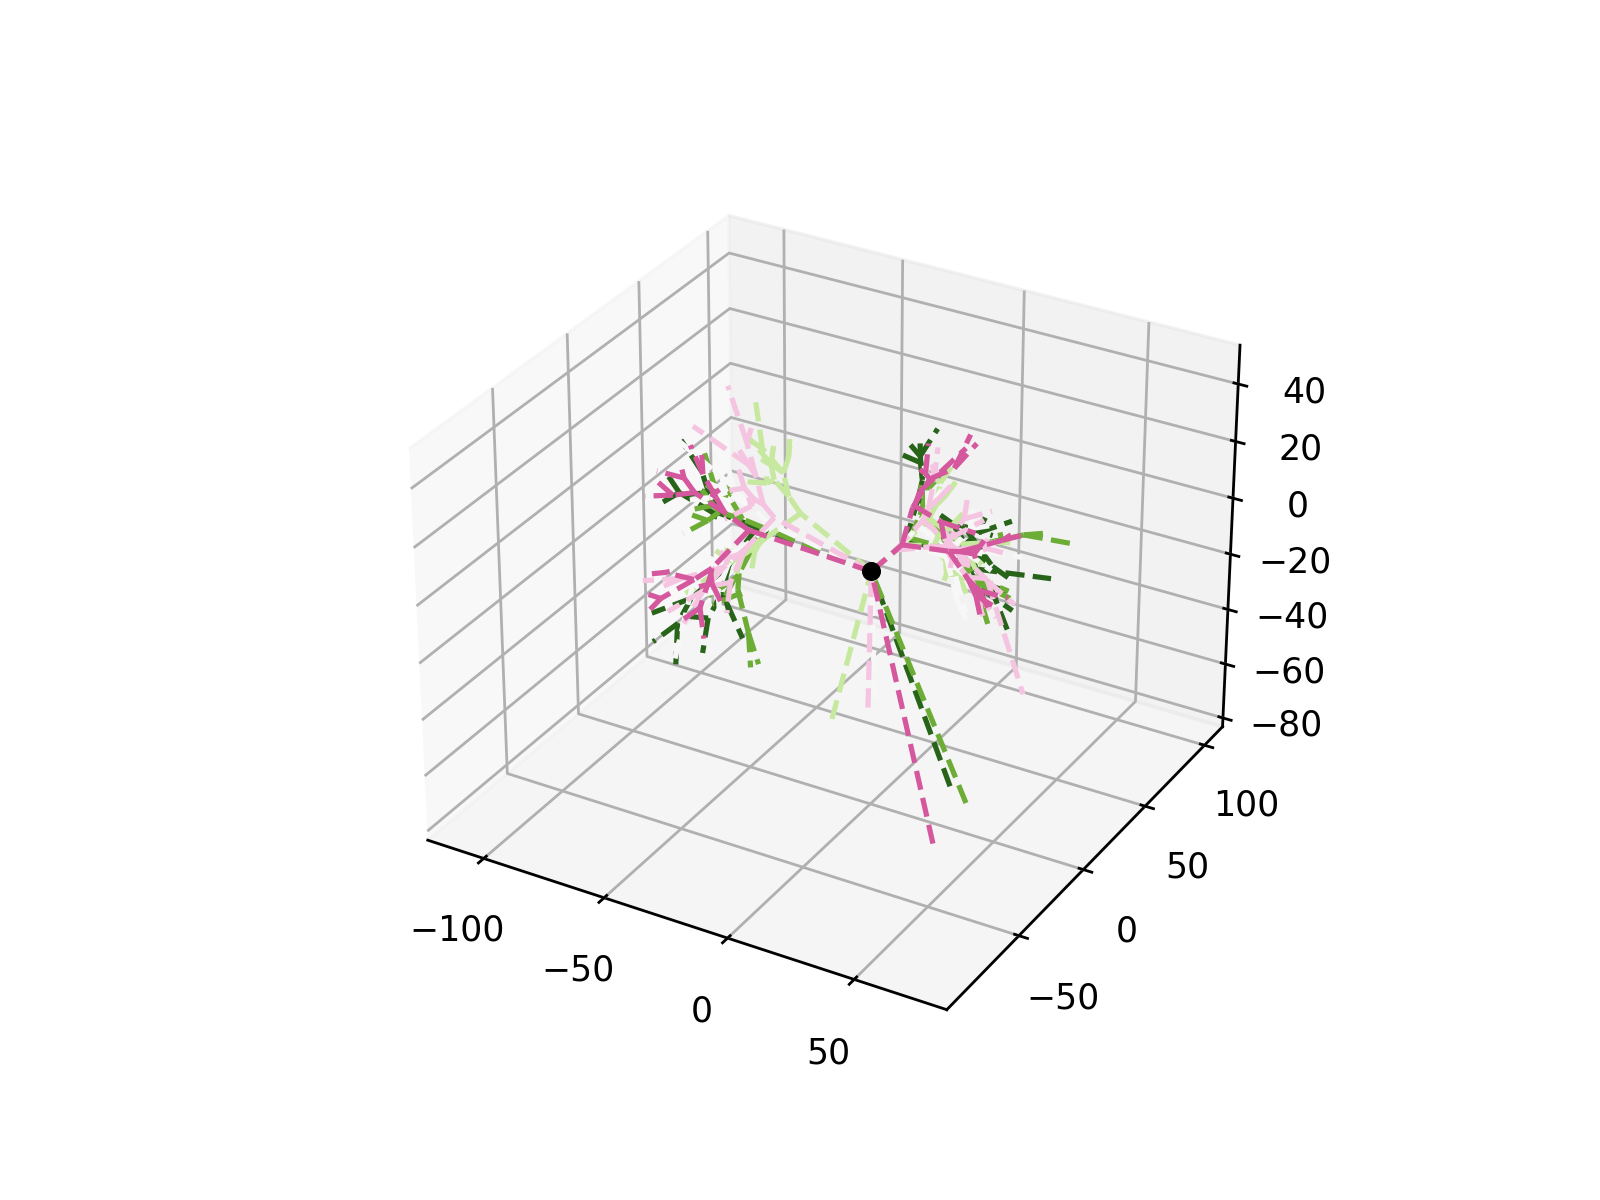

<IPython.core.display.Javascript object>


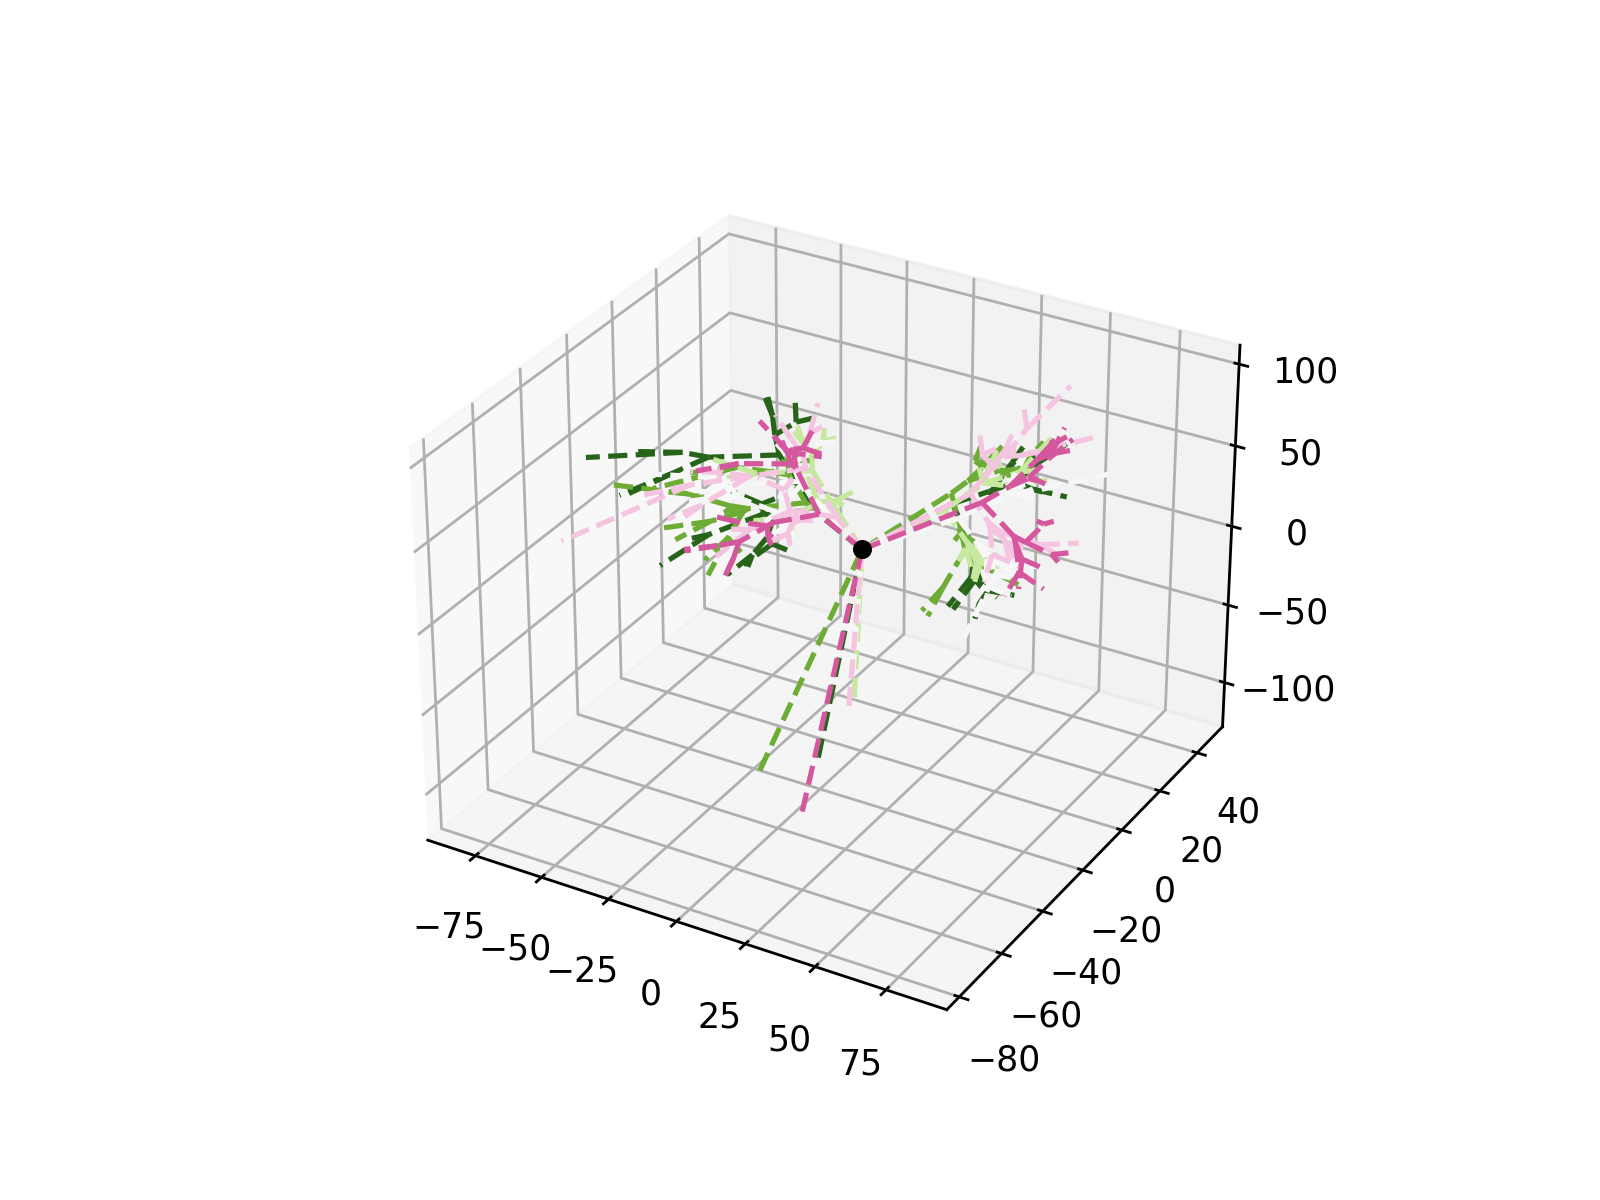

In [26]:
val_min = 0
val_max=6
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
# quick visualisation of tree

fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(rotated_coords_df.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color='k')
        ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.show()


fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(rotated_coords_df.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
        ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color=cmap(norm(i)))
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.show()

In [32]:
# Renomralising
normaliser_minmax = MinMaxScaler(feature_range=(0,1))
Xminmax = rotated_coords_df[['nx', 'ny','nz']].values
Xminmax_norm = normaliser_minmax.fit(Xminmax)
rotated_coords_df[['nx_norm', 'ny_norm','nz_norm']]= Xminmax_norm.transform(rotated_coords_df[['nx', 'ny','nz']].values)
rotated_coords_df[["parent_loc_nx_norm","parent_loc_ny_norm","parent_loc_nz_norm"]]= Xminmax_norm.transform(rotated_coords_df[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]].values)
df = rotated_coords_df.copy()

In [34]:
# add labels
df = rotated_coords_df.merge(label_df, on='idno', how='left')
df

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nx_norm,parent_loc_ny_norm,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.930155,0.088670,0.489418,Standard,1.0,0.0,0.0,0.0,0.0,0.0
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.718744,0.293178,0.593048,Standard,1.0,0.0,0.0,0.0,0.0,0.0
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.718744,0.293178,0.593048,Standard,1.0,0.0,0.0,0.0,0.0,0.0
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.718744,0.363528,0.593048,Standard,1.0,0.0,0.0,0.0,0.0,0.0
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.718744,0.363528,0.593048,Standard,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,8024995,-,7.76122,8.59789,2.0,9.0,308.0,284.0,165.5500,-0.145479,...,0.435945,0.538153,0.614905,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884129,8024995,-,18.25130,3.55283,2.0,9.0,309.0,285.0,172.0070,0.515058,...,0.366221,0.556597,0.637661,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884130,8024995,-,1.06394,-1.00000,2.0,9.0,310.0,285.0,120.9650,-0.577350,...,0.366221,0.556597,0.637661,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0
884131,8024995,-,9.27626,7.71677,2.0,9.0,311.0,286.0,152.5930,0.285831,...,0.395476,0.549087,0.604991,Acc. B*,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
# Do QC paths on standard only and randomly delete RB7 on 50%
toy_df_v1 = df.loc[(df.LL_1 == 'Standard') & (df.QC)]
print(f"There are {toy_df_v1.idno.nunique()} standard ids in the toy dataset, using only QC paths: {toy_df_v1.groupby('idno').agg({'idno':'count'}).mean().item():.0f} segments per id on average")

There are 2101 standard ids in the toy dataset, using only QC paths: 66 segments per id on average


In [36]:
# removing RB7 in 50% of cases
ids =list(toy_df_v1.idno.unique())
ids_to_remove = random.sample(ids, k=len(ids)//2)
anomalous_trees = toy_df_v1.loc[(toy_df_v1.anatomicalname.str.lower()!= 'rb7') & (toy_df_v1.idno.isin(ids_to_remove))]
standard_trees = toy_df_v1.loc[~(toy_df_v1.idno.isin(ids_to_remove))]

print('check', len(np.unique(anomalous_trees.idno.to_list() + standard_trees.idno.to_list())))

toy_df_final = pd.concat([anomalous_trees, standard_trees], axis=0)
# toy_df_final['binaryLL_1'] = toy_df_final.idno.apply(lambda x:1 if x in ids_to_remove else 0)


check 2101


In [37]:
toy_df_final['graph_label'] =  toy_df_final.idno.apply(lambda x:0 if x in ids_to_remove else 1)
# NOTE THIS IS REVERSED AS FOR NODE LABBLES I WANT ADDITION OF RB7 TO BE HIGHLIGHTED WHICH IS NORMAL JUST EASIER TO DO

In [38]:
toy_df_final['node_label'] = 0
toy_df_final.loc[(toy_df_final.graph_label==1) & (toy_df_final.anatomicalname.str.lower() == 'rb7'), 'node_label'] = 1



Standard anatomy [3010082 3010228 3010325 ... 8024537 8024650 8024979]
Anomaly anatomy [3010007 3010058 3010090 ... 8024782 8024847 8024863]
Anomaly anatomy is MISSING RB7 (no green branch visible)


/tmp/ipykernel_24758/41332420.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
/tmp/ipykernel_24758/41332420.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['color'] = tree_w_coords.anatomicalname.apply(lambda x:0 if x.lower() =='rb7' else 1)


<IPython.core.display.Javascript object>


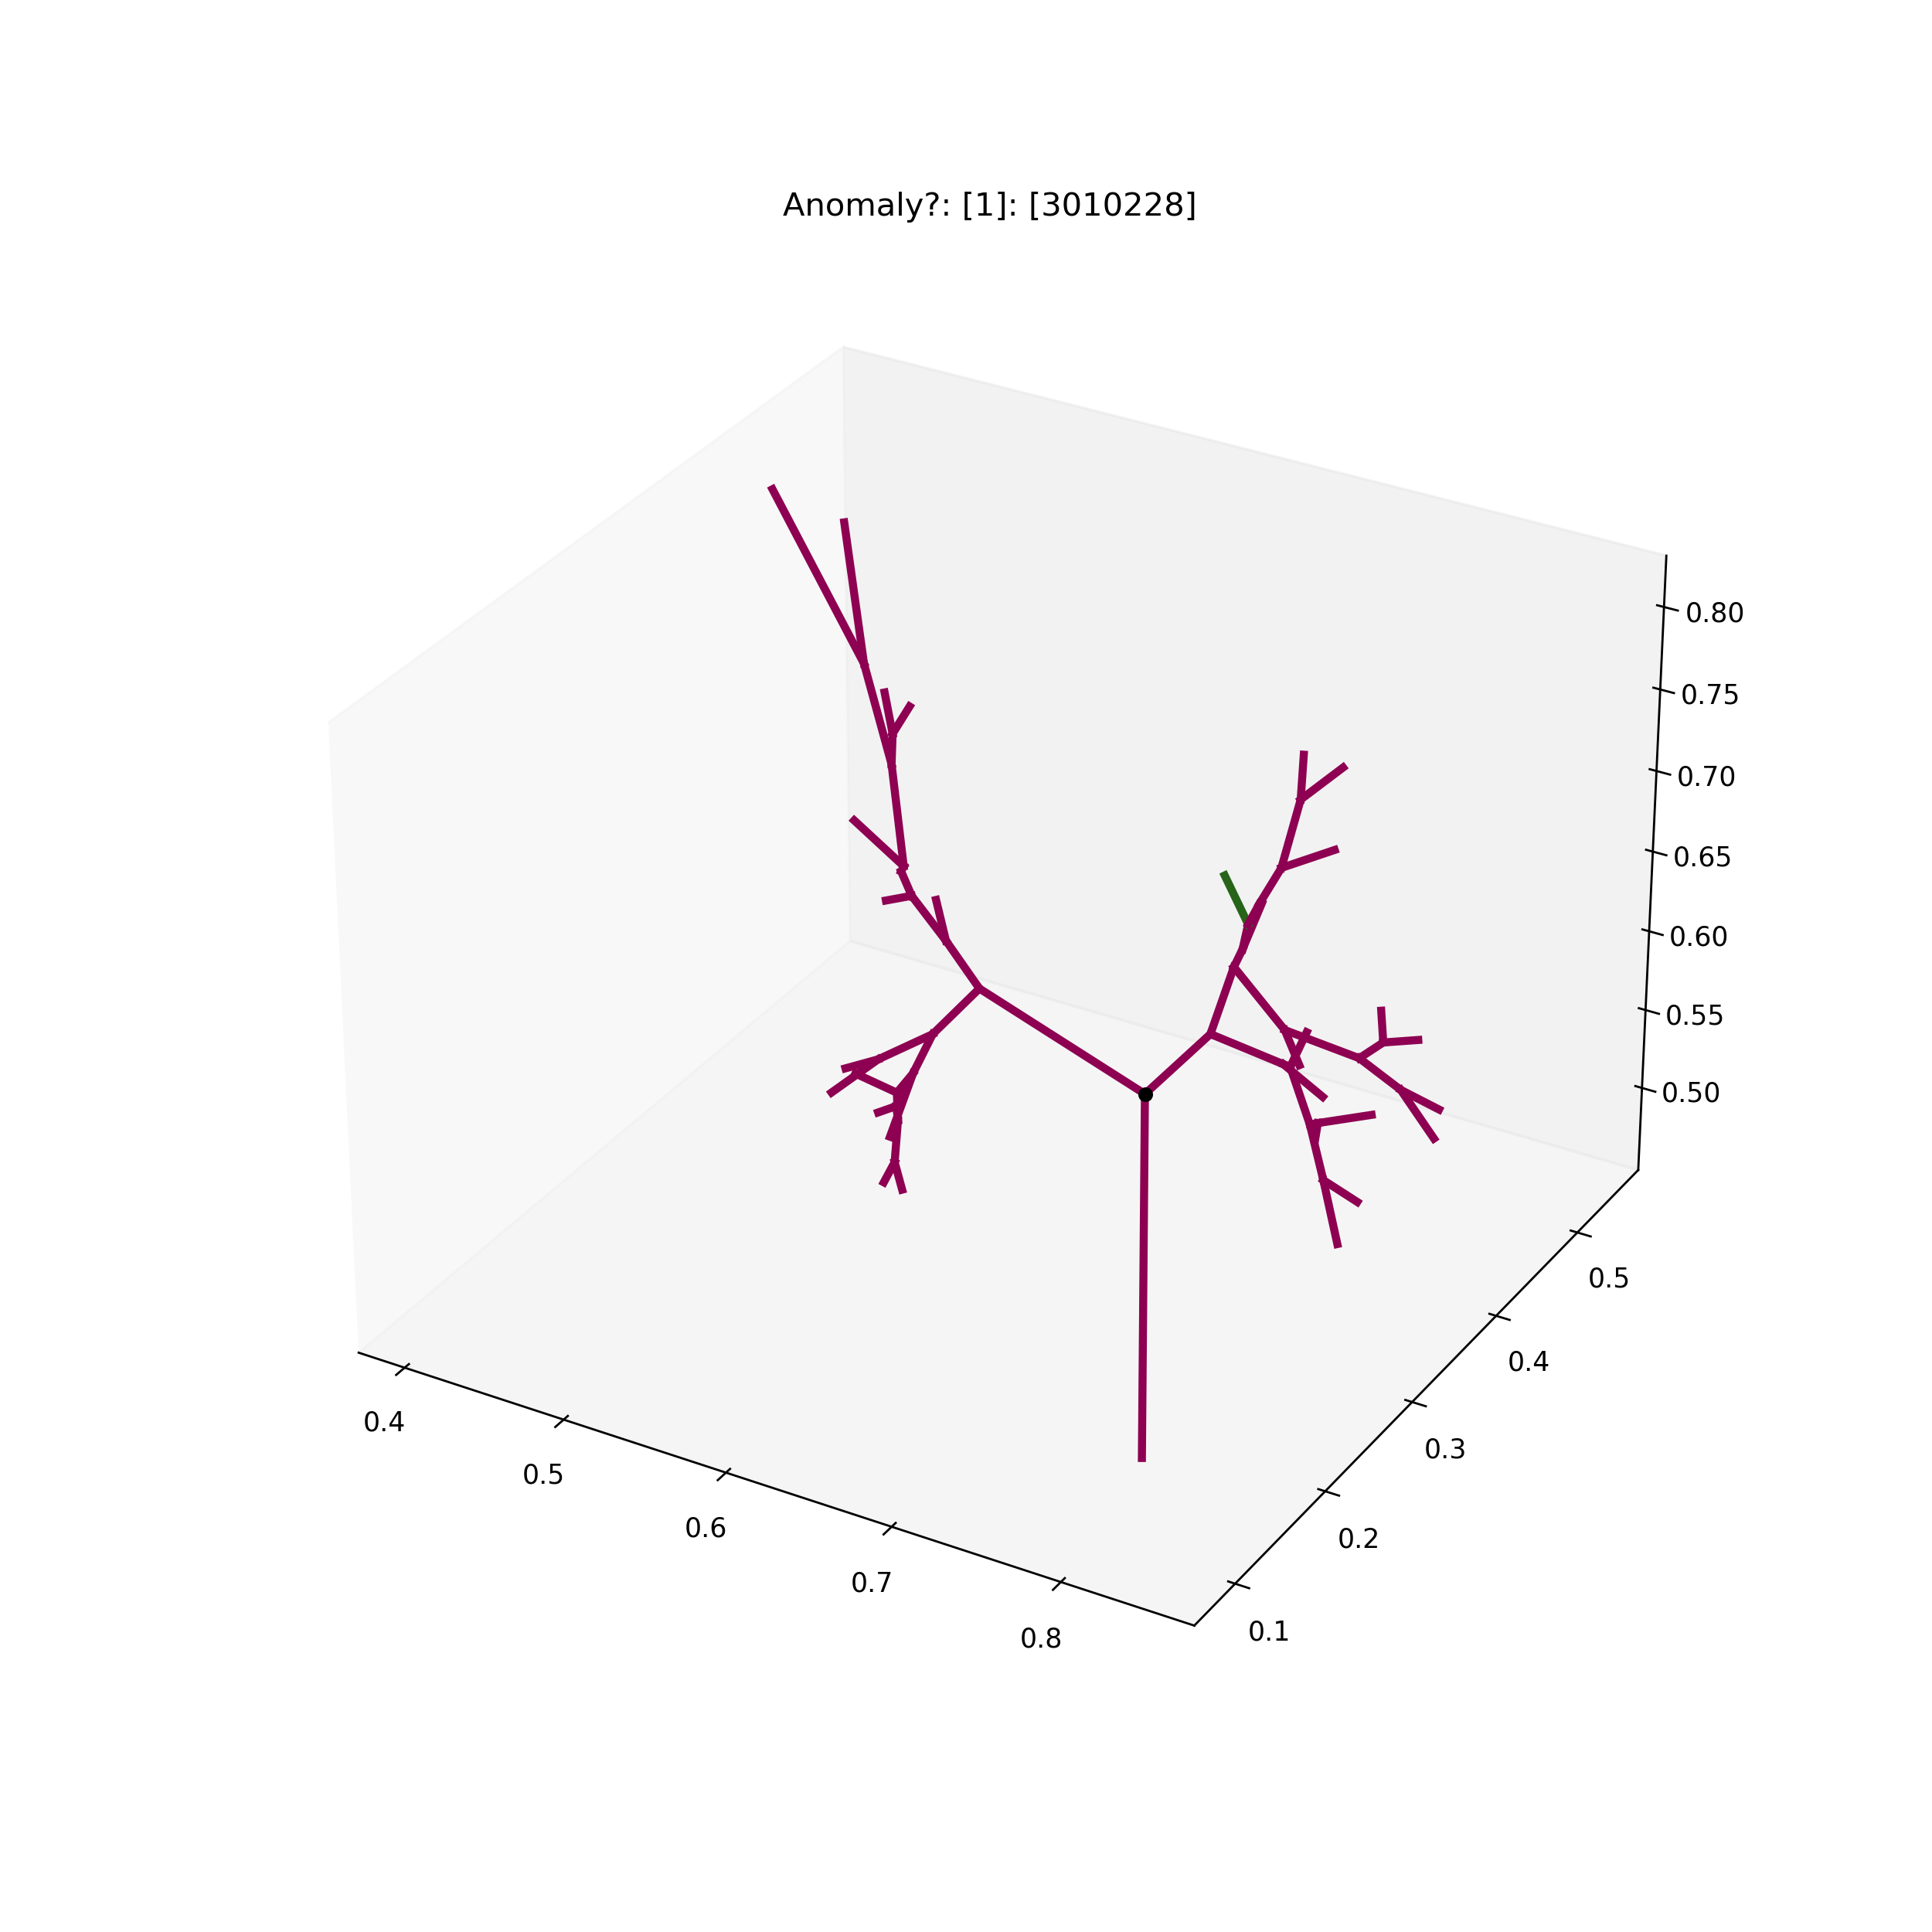

0.7187443632150984 0.29317803461358605 0.5930484185746493


In [44]:
print("Standard anatomy", standard_trees.idno.unique())
print("Anomaly anatomy", anomalous_trees.idno.unique())
print("Anomaly anatomy is MISSING RB7 (no green branch visible)")
tree_w_coords = toy_df_final.loc[(toy_df_final.idno==3010228) & (toy_df_final.weibel_generation <=8)]
val_min = 0
val_max=1
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)

# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
tree_w_coords['color'] = tree_w_coords.anatomicalname.apply(lambda x:0 if x.lower() =='rb7' else 1)
row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]
    
    if i == 0:
        ax.scatter(row.nx_norm,row.ny_norm,row.nz_norm, color='k', label='carina')
        print(row.nx_norm,row.ny_norm,row.nz_norm)
    
    ax.plot([row.parent_loc_nx_norm,row.nx_norm], [row.parent_loc_ny_norm,row.ny_norm], [row.parent_loc_nz_norm, row.nz_norm], linestyle='-',linewidth=3, color= cmap(norm(row.color)), label=row.anatomicalname)
    ax.text(int(sum([row.parent_loc_nx_norm,row.nx_norm])/2), int(sum([row.parent_loc_ny_norm,row.ny_norm])/2),int(sum([row.parent_loc_nz_norm, row.nz_norm])/2), row.anatomicalname, color='grey')

    
ax.grid(False)
ax.set_facecolor(color=(1,1,1))
plt.title('Anomaly?: '+str(tree_w_coords.graph_label.unique())+': '+str(tree_w_coords.idno.unique()))
plt.show()

In [45]:
# weird graphs where the trachea is not 1
issues_w_trachea = []
for name, graph in toy_df_final.groupby('idno'):
    try:
        assert len(graph.loc[(graph.endbpid==1) & (graph.anatomicalname.str.lower()=='trachea')]) == 1
    except:
        display(graph.loc[graph.anatomicalname.str.lower()=='trachea'])
        print(f'Adding {name} to remove')
        issues_w_trachea.append(name)
        


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
75319,3015262,Trachea,81.1159,227.061,0.0,0.0,2.0,1.0,143.116,-0.159996,...,0.593048,Standard,1.0,0.0,0.0,0.0,0.0,0.0,0,0


Adding 3015262 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
187326,4010574,Trachea,84.3457,200.113,0.0,0.0,2.0,-1.0,0.0,0.012039,...,0.588314,Standard,1.0,0.0,0.0,0.0,0.0,0.0,1,0


Adding 4010574 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
285989,4017943,Trachea,95.8271,228.707,0.0,0.0,2.0,-1.0,0.0,0.010633,...,0.589458,Standard,1.0,0.0,0.0,0.0,0.0,0.0,1,0


Adding 4017943 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
613735,7012330,Trachea,124.972,305.752,0.0,0.0,2.0,-1.0,0.0,-0.036108,...,0.593819,Standard,1.0,0.0,0.0,0.0,0.0,0.0,0,0


Adding 7012330 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
616506,7012616,Trachea,91.1765,225.075,0.0,0.0,2.0,-1.0,0.0,-0.023451,...,0.587451,Standard,1.0,0.0,0.0,0.0,0.0,0.0,1,0


Adding 7012616 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
797778,8014833,Trachea,106.053,300.18,0.0,0.0,2.0,-1.0,0.0,-0.062934,...,0.590647,Standard,1.0,0.0,0.0,0.0,0.0,0.0,1,0


Adding 8014833 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label


Adding 8015457 to remove


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,parent_loc_nz_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,graph_label,node_label
860234,8022046,Trachea,91.0915,212.411,0.0,0.0,2.0,-1.0,0.0,-0.079187,...,0.58988,Standard,1.0,0.0,0.0,0.0,0.0,0.0,0,0


Adding 8022046 to remove


In [46]:
toy_df_final = toy_df_final.loc[~(toy_df_final.idno.isin(issues_w_trachea))]
print(toy_df_final.idno.nunique())

2093


In [47]:
toy_df_final.to_csv('/home/sneha/toy_normalised_0607.csv',index=False)

In [48]:
label_df = toy_df_final[['idno', 'startbpid', 'endbpid', 'graph_label', 'node_label']]
label_df.to_csv('/home/sneha/toy_labels_0607.csv',index=False)

In [54]:


class CustomDataset(torch_geometric.data.Dataset):
    def __init__(self,
                 root,
                 filename_data,
                 filename_labels,
                 test=False,
                 transform=None,
                 pre_transform=None,
                 label_col_name = 'binaryLL_1',
                args = {'node_feature_names': [], 'edge_feature_names': []}):
        '''
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        filename_data = contains X features for nodes + edges (csv)
        filename_labels= contains Y labels for graphs (csv)
        
        IGNORE OTHERR INPUTS __> NOTE TEST IS FIXED AS FASLE NOT SURE WHAT IT DOES MAYBE FOR INDUCTIVE LEARNING
        
        '''

            
            
        self.test = False
        self.filename_data = os.path.abspath(filename_data)
        self.filename_labels = os.path.abspath(filename_labels)
        self.node_map = {}
        self.y = None
        #         super(CustomDataset, self).__init__(root, transform, pre_transform)
        if len(args['node_feature_names']) > 0:
            self.node_feature_names = args['node_feature_names']
        else:
            self.node_feature_names = None
        
        if len(args['edge_feature_names']) > 0:
            self.edge_feature_names = args['edge_feature_names']
        else:
            self.edge_feature_names = None
        print(f"Using Node features: {self.node_feature_names}, Edge features: {self.edge_feature_names}")
        self.label_col = label_col_name
        print(f"Getting labels from: {self.label_col}")
        super(CustomDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped: NOTE NOT SURE WHAT THIS IS"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = self._process_labels()
        graph_ids = self.data.idno.unique()
        
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant (resetindex is important for node relabelling)
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df,index=i)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
    
    
    def _process_labels(self):
        '''
        Reads label df - checks its binary 0,1 labels (REQUIRES COLUMN self.label_col) if not returns an error 
        Keeps only rows that match idnos in self.data_df which is processed first
        measures class proportions and saves to self.class_proportions
        returns a df which has a label per idno with label in col called 'y'
        '''
        #(NOTE THIS IS WRONG YOU NEED TO DROP UNALBELLED)
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        # binarise 
        assert self.label_col in label_df.columns, f"The column {self.label_col} cannot be found"
        # drop unnecessary cols
        
        # drop rows not matching to data ids
        data_df =  pd.read_csv(os.path.abspath(self.filename_data))
        label_df_small = label_df.loc[label_df.idno.isin(data_df.idno.unique())]
        self.y = label_df_small
        print("# Graphs", len(label_df_small), "Label Frequency", Counter(label_df_small[self.label_col].to_list()))
        self.class_proportions = {k:v/len(label_df_small) for k,v in Counter(label_df_small[self.label_col].to_list()).items()}
        print(f"Class proportions: {self.class_proportions}")
        return label_df_small
    
    def _get_edge_adjacency(self,df, index):
        '''
        NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        Turns endbpid 1 > 1, if the next one in the df is endbpid=6 it becomes 2 etc so that the endbpids are in order from 1 to max (index+1)
        Adds trachea (node 0)
        applyys relabelling to start and endbpid based on the dict 
        returns torch tensor in COO format which is a parallel list [[source_node_list], [corresponding_end_node_list]]
        in this format, at list[0][2] and list[1][2] will be source-end node of the second edge in the list
        '''
        # reindex start / endbpids
        
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # save mapping
        self.node_map[index] = (df.idno.unique().item(), relabel_map)
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        '''
        DF already contains normalised features
        Feature names in node_features
        Format to return is a tensor of shape num_nodes x node_feature_dim with dtype float 
        assumes ordered in ascending order with nodes 0 and up in integers (so node = index / row num)
        '''
        # nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
        if self.node_feature_names is not None:
            node_features = self.node_feature_names
        else:
            node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','lobe_norm',
               'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']
        
        # adding trachea info to top of list
        trachea_dict = dict.fromkeys(node_features, 0)
        for i in ['x_norm', 'y_norm', 'z_norm']:
            trachea_dict[i] = df.loc[df.endbpid==1][str('parent_loc_'+i)].item()
        
        # currently usnig as features 
        list_of_nodes = df[node_features].to_dict(orient='records')
        # add trachea to nodes
        list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
        x = torch.tensor(list_of_lists_nodes, dtype=torch.float)
#         print("Shape node features", x.shape)
        return x

    def _get_edge_features(self,df):
        '''
        get matrix of shape [# edges, edge feature size] with type float
        '''
        if self.edge_feature_names is not None:
            edge_feature_names = self.edge_feature_names
        else:
            edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']
            
        edge_norm = df[edge_feature_names].values
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df):
        '''
        for the selected idno, returns value in self.label_col as an integer
        '''
        return torch.tensor(label_df.loc[label_df.idno==idno,
                 self.label_col].values, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [55]:
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm',
                 'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm']
#                 ,'lobe_norm','sublobe_norm']
edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# DATASETS
my_data_train  = CustomDataset('data_all_toy_test/',
                               '/home/sneha/toy_normalised_0607.csv',
                               "/home/sneha/toy_labels_0607.csv",
                               args = args,
                               label_col_name='node_label'
                              )




Using Node features: ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 136974 Label Frequency Counter({0: 135936, 1: 1038})
Class proportions: {0: 0.9924219194883701, 1: 0.007578080511629944}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:15<00:00, 136.82it/s]
Done!


In [66]:

# train_loader = DataLoader(my_data_train, batch_size=batch_size, sampler = sampler_train, shuffle=True)

from torch_geometric.loader import NeighborLoader, ImbalancedSampler
from torch_geometric.data import Batch
# print(my_data_train.y)
# sampler_train = ImbalancedSampler(my_data_train)
train_obj = Batch.from_data_list(my_data_train) # loading all graphs into batch object
train_obj.n_id = torch.arange(train_obj.num_nodes)
indices = torch.where(train_obj.y==0)[0]#filtering majority class
print(len(indices)/len(train_obj.y), indices)
train_loader = NeighborLoader(train_obj,num_neighbors=[-1]*3, input_nodes=indices, batch_size=128, shuffle=True)  
data = next(iter(train_loader))
# train_loader = NeighborLoader(my_data_train,num_neighbors= -1, batch_size=2, shuffle=False)
# loader = NeighborLoader(data, input_nodes=data.train_mask,
#                         batch_size=64, num_neighbors=[-1, -1],
#                         sampler=sampler, ...)


# test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)

print(data)
data.batch, data.n_id, data.y

0.9924219194883701 tensor([     0,      1,      2,  ..., 136971, 136972, 136973])
DataBatch(x=[255, 13], edge_index=[2, 127], edge_attr=[127, 2], y=[136974], batch=[255], ptr=[2094], n_id=[255], batch_size=128)


(tensor([1516,  440,  521, 1650, 1023,  942,  536,  153,  894,  580, 1784, 1327,
         1993, 1821,  811, 1163,  408, 1364, 1607,  331,  629,  979,   15, 1169,
         1229,  599,  876, 1055,  535,  677, 1887,  325,  789, 1964, 1951, 1361,
         1143,  754,  992, 1694, 1385,  701, 1709, 1738,  340,  302, 1146,  821,
         1294,  136, 1022,  476, 1944, 1916, 1030, 1393, 1706,  280,  847, 1017,
         1265,  333, 1236,   67, 1421,  200, 1198,  879, 1182,   59, 1117, 1082,
         1439, 1088, 1961, 1270,  988, 1806,  391, 1673, 1494, 2058, 1612, 1223,
          661,   15,  635, 1351,  884,  637,  265,  187,  765, 1410, 1781, 1407,
          313,  656,  895, 1705,  500, 1593,  994,   29,  640,  769,  492,  129,
          665,  260,  297, 1188, 1117, 1967, 1157, 1945,  534, 1692,  817,  297,
         1206, 1585, 1125, 1915,   28,  494, 1961, 1174, 1516,  440,  521, 1650,
         1023,  942,  536,  153,  894,  580, 1784, 1327, 1993, 1821,  811, 1163,
          408, 1364, 1607,  

In [ ]:
index = [index for index, (idno, relabel) in my_data_train.node_map.items() if idno == 3010112][0]
data = my_data_train[index]
print(data)
label = data.y
g = to_networkx(data)
# get relabelmap
idno, relabel = my_data_train.node_map[index]
# map to original df
vis_graph  =toy_df_final.loc[toy_df_final.idno==idno]
print(vis_graph.columns)
print(f"This graph is for id: {idno}")
display(vis_graph[['x_norm', 'y_norm', 'z_norm']].head())
print(data.x[1:6,:3])
# get the relabelling to match the pytorch graph 
vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])

np.argmax(vis_graph.node_label.values), np.argmax(data.y)